## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16784270415076250398
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7091883213
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15390778076504007830
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from utils.data_generator_seq2seq import data_generator_head_sal_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_head_sal_reinject_output_5-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units
filter_dim = 5
kernel_dim = 10

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_2)
encoder_4, h4, c4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_3)
encoder_5, h5, c5 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_4)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3, h4, c4, h5, c5]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

final_width_px = 128 # 2560/20
final_height_px = 72 # 1440/20

sal_map_input = Input(shape=(final_height_px, final_width_px, 1))

conv_1 = Conv2D(filters=4, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(sal_map_input)
max_pooling_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters=8, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

print(max_pooling_4.shape)

decoder_input_raw = Flatten(data_format='channels_last')(max_pooling_4)
print(decoder_input_raw.shape)

decoder_input = Dense(latent_dim, activation="relu")(decoder_input_raw)

decoder_input = Reshape(target_shape=(1,latent_dim))(decoder_input)
print(decoder_input.shape)

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_4 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_5 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[states[2], states[3]])

    decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[states[4], states[5]])
    
    decoder_outputs_4, dh4, dc4 = decoder_4(decoder_outputs_3, initial_state=[states[6], states[7]])
    
    decoder_outputs_5, dh5, dc5 = decoder_5(decoder_outputs_4, initial_state=[states[8], states[9]])

    dense_1_outputs = dense_1(decoder_outputs_5)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = decoder_outputs_3
    states = [dh1, dc1, dh2, dc2, dh3, dc3, dh4, dc4, dh5, dc5]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, sal_map_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 4, 8, 16)
(?, ?)
(?, 1, 128)


(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 4)   40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 64, 8)    296         max_pooling2d_1[0][0]            
_________________________________________________________________________________

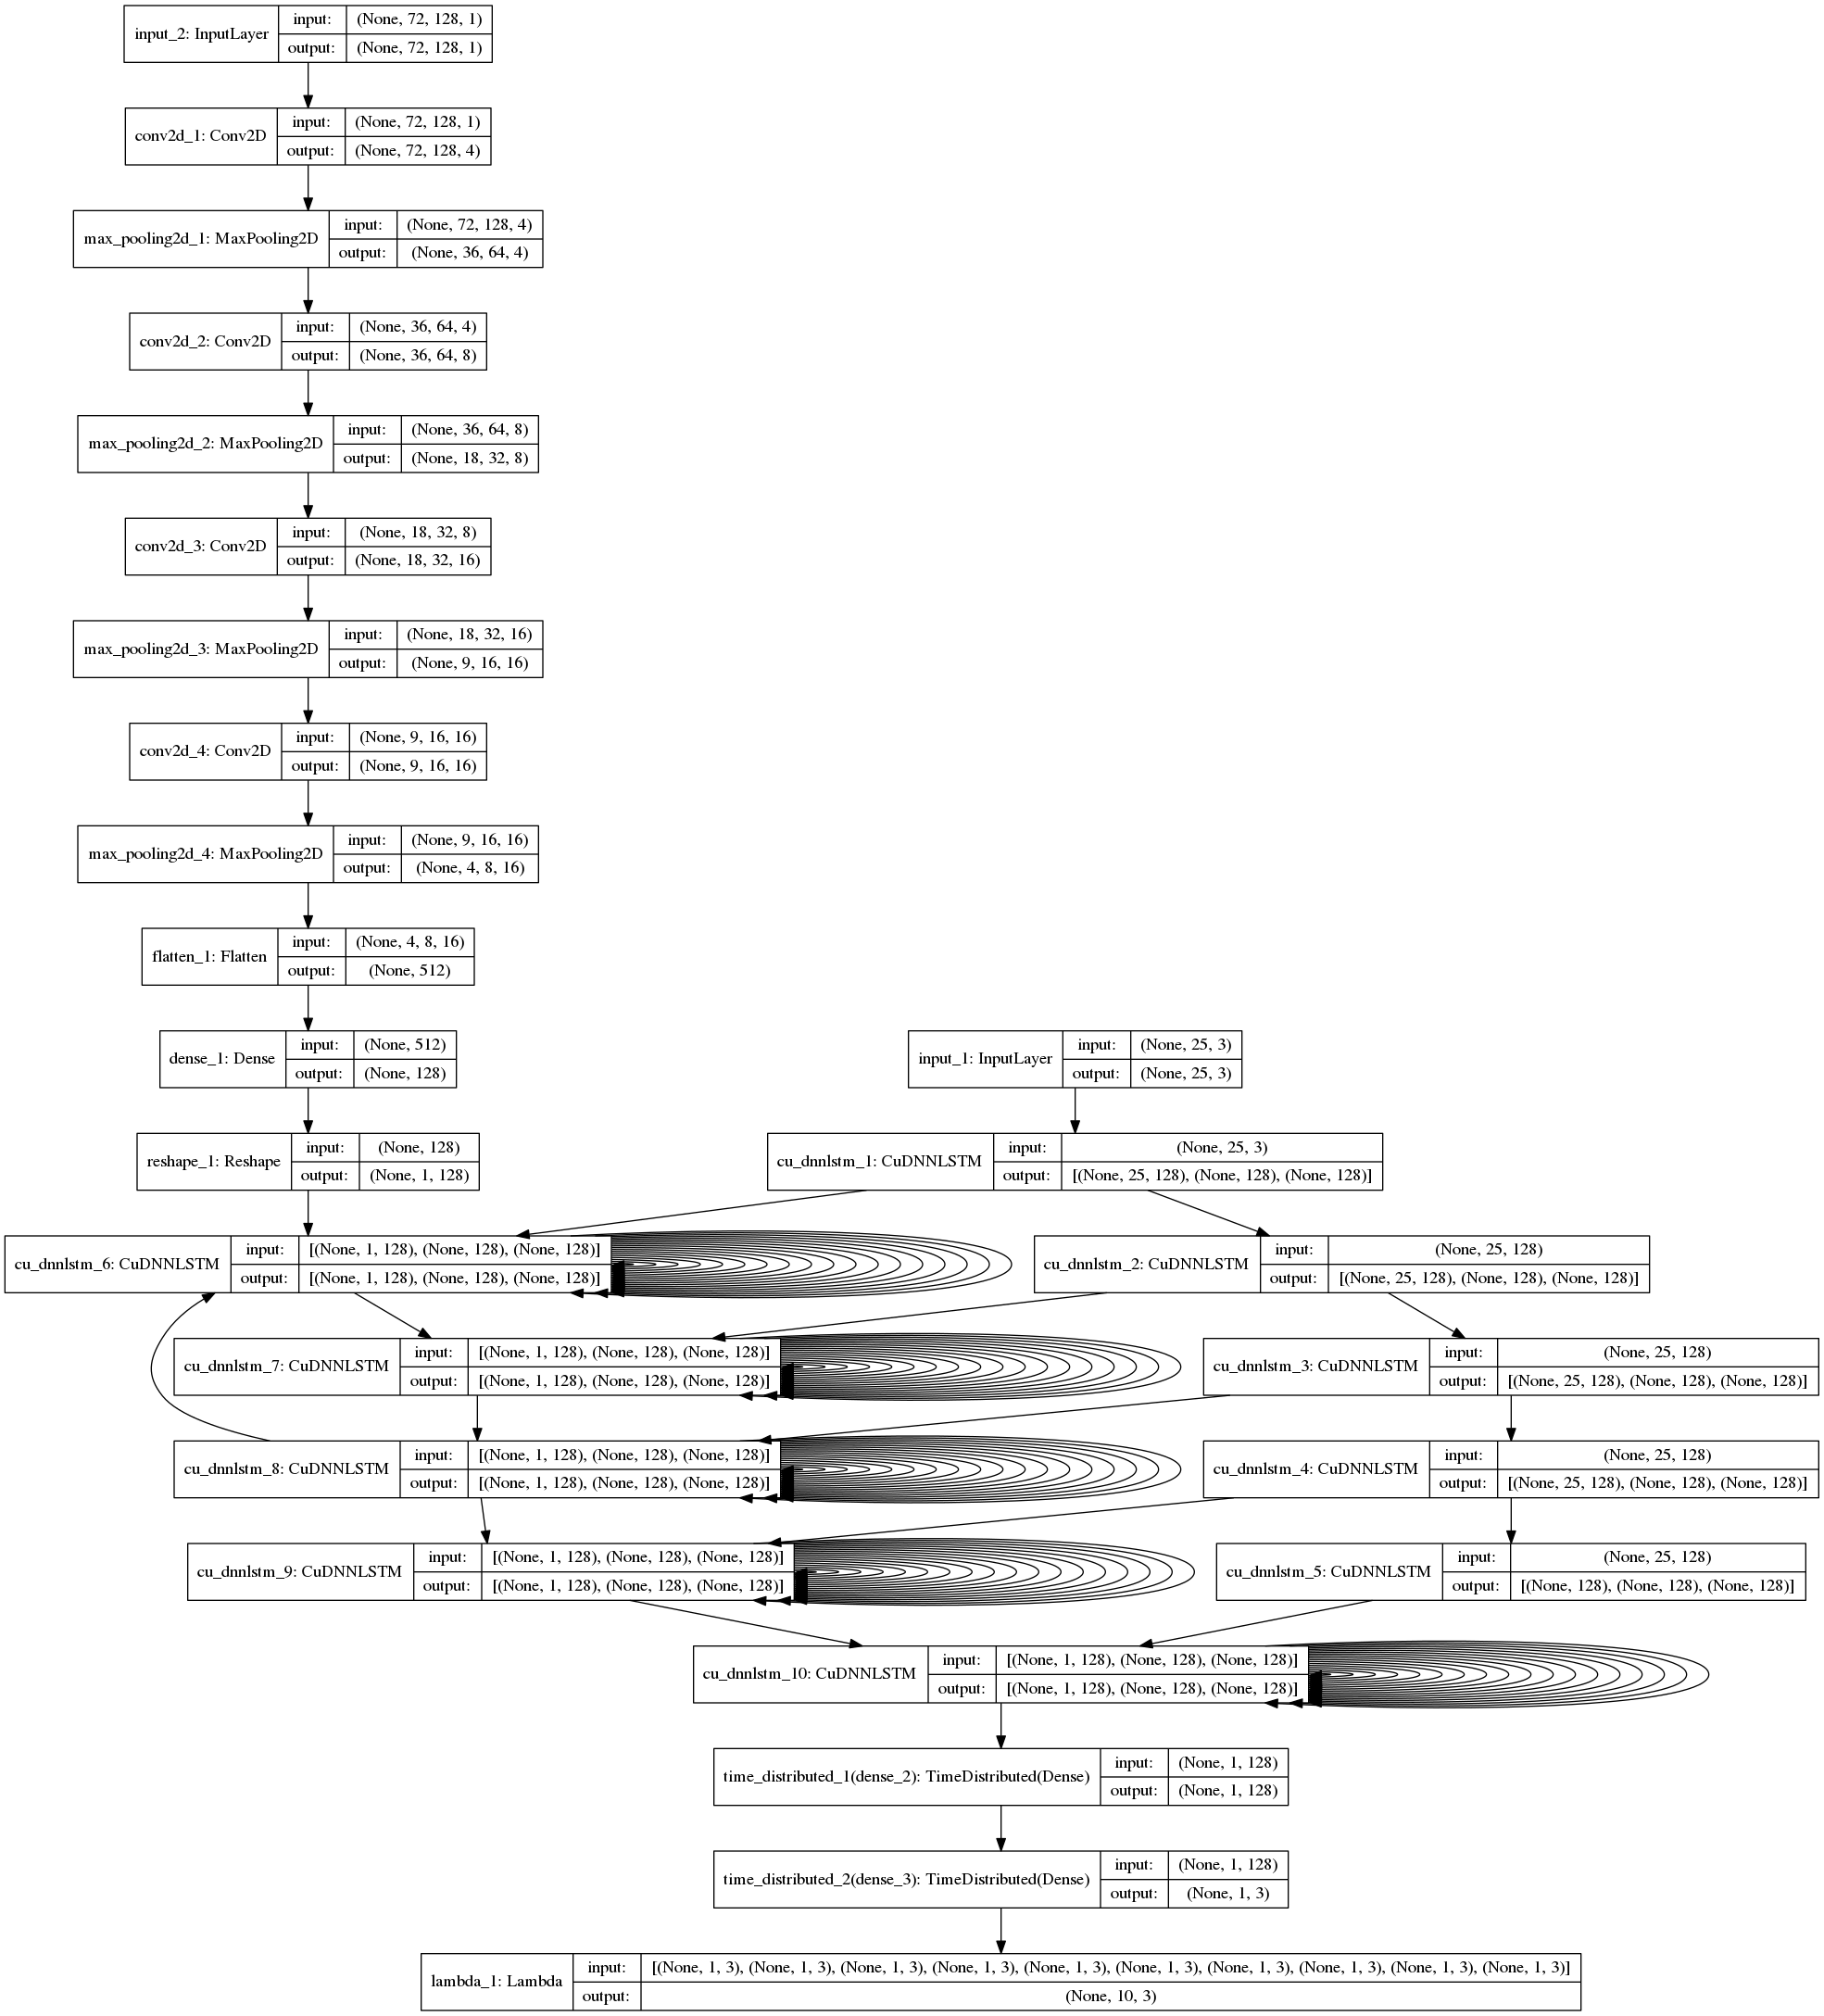

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images_train_h5_new", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(saliency_dir)
print(videos)
video_width = 3840

['013_13_times_square_static.h5', '002_01_art_gallery_static.h5', '002_02_theatre_scene_static.h5', '002_03_lions_static_cuts.h5', '002_04_copenhagen_harbour_static_cuts.h5', '002_07_factory_robots_static.h5', '002_09_elephants_static.h5', '002_12_gym_workout_static.h5', '002_13_times_square_static.h5', '002_14_new_orleans_drive_motion.h5', '002_16_interview_static.h5', '002_17_weather_forecast_static.h5', '002_18_bomb_trapped_static.h5', '002_20_car_fix_static.h5', '002_23_dog_food_factory_motion.h5', '003_01_art_gallery_static.h5', '003_02_theatre_scene_static.h5', '003_03_lions_static_cuts.h5', '003_04_copenhagen_harbour_static_cuts.h5', '003_05_florida_yacht_motion.h5', '003_07_factory_robots_static.h5', '003_08_madagascar_cuts.h5', '003_09_elephants_static.h5', '003_11_lohdi_garden_india_cuts.h5', '003_12_gym_workout_static.h5', '003_13_times_square_static.h5', '003_14_new_orleans_drive_motion.h5', '003_18_bomb_trapped_static.h5', '003_21_operation_room_static.h5', '003_23_dog_foo

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

(72, 128, 1)


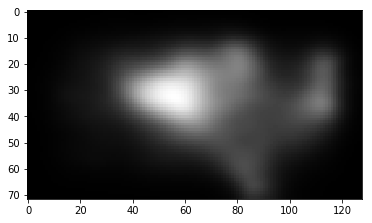

"\nfig=plt.figure(figsize=(18, 16), dpi= 80)\n\nplt.subplot(311)\nplt.plot(encoder_input[:,0,0], c='r')\nplt.grid(True)\n\nplt.subplot(312)\nplt.plot(encoder_input[:,0,1], c='g')\nplt.grid(True)\n\nplt.subplot(313)\nplt.plot(encoder_input[:,0,2], c='b')\nplt.grid(True)\n"

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)
print(decoder_input[1000].shape)
plt.imshow(decoder_input[1000,:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

'''
fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)
'''

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=(len(videos) - ind_max_train))
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/422 [..............................] - ETA: 41:21 - loss: 0.0461 - rmse: 0.1586

  2/422 [..............................] - ETA: 27:22 - loss: 0.0880 - rmse: 0.2293

  3/422 [..............................] - ETA: 23:46 - loss: 0.0875 - rmse: 0.2309

  4/422 [..............................] - ETA: 21:58 - loss: 0.0853 - rmse: 0.2159

  5/422 [..............................] - ETA: 20:50 - loss: 0.0807 - rmse: 0.2222

  6/422 [..............................] - ETA: 20:05 - loss: 0.0885 - rmse: 0.2346

  7/422 [..............................] - ETA: 19:36 - loss: 0.0876 - rmse: 0.2387

  8/422 [..............................] - ETA: 19:10 - loss: 0.0847 - rmse: 0.2305

  9/422 [..............................] - ETA: 18:53 - loss: 0.0858 - rmse: 0.2291

 10/422 [..............................] - ETA: 18:40 - loss: 0.0822 - rmse: 0.2203

 11/422 [..............................] - ETA: 18:24 - loss: 0.0794 - rmse: 0.2131

 12/422 [..............................] - ETA: 18:14 - loss: 0.0795 - rmse: 0.2154

 13/422 [..............................] - ETA: 18:02 - loss: 0.0793 - rmse: 0.2134

 14/422 [..............................] - ETA: 17:53 - loss: 0.0811 - rmse: 0.2146

 15/422 [>.............................] - ETA: 17:47 - loss: 0.0793 - rmse: 0.2140

 16/422 [>.............................] - ETA: 17:40 - loss: 0.0782 - rmse: 0.2146

 17/422 [>.............................] - ETA: 17:32 - loss: 0.0767 - rmse: 0.2099

 18/422 [>.............................] - ETA: 17:28 - loss: 0.0746 - rmse: 0.2045

 19/422 [>.............................] - ETA: 17:22 - loss: 0.0754 - rmse: 0.2051

 20/422 [>.............................] - ETA: 17:18 - loss: 0.0752 - rmse: 0.2042

 21/422 [>.............................] - ETA: 17:12 - loss: 0.0745 - rmse: 0.2024

 22/422 [>.............................] - ETA: 17:07 - loss: 0.0742 - rmse: 0.2022

 23/422 [>.............................] - ETA: 17:01 - loss: 0.0737 - rmse: 0.2023

 24/422 [>.............................] - ETA: 16:53 - loss: 0.0763 - rmse: 0.2070

 25/422 [>.............................] - ETA: 16:40 - loss: 0.0770 - rmse: 0.2069

 26/422 [>.............................] - ETA: 16:37 - loss: 0.0789 - rmse: 0.2114

 27/422 [>.............................] - ETA: 16:32 - loss: 0.0772 - rmse: 0.2063

 28/422 [>.............................] - ETA: 16:28 - loss: 0.0759 - rmse: 0.2025

 29/422 [=>............................] - ETA: 16:25 - loss: 0.0746 - rmse: 0.2015

 30/422 [=>............................] - ETA: 16:15 - loss: 0.0741 - rmse: 0.2000

 31/422 [=>............................] - ETA: 16:11 - loss: 0.0734 - rmse: 0.1976

 32/422 [=>............................] - ETA: 15:47 - loss: 0.0729 - rmse: 0.1959

 33/422 [=>............................] - ETA: 15:44 - loss: 0.0747 - rmse: 0.2008

 34/422 [=>............................] - ETA: 15:42 - loss: 0.0755 - rmse: 0.2024

 35/422 [=>............................] - ETA: 15:39 - loss: 0.0741 - rmse: 0.1984

 36/422 [=>............................] - ETA: 15:38 - loss: 0.0756 - rmse: 0.2033

 37/422 [=>............................] - ETA: 15:35 - loss: 0.0754 - rmse: 0.2028

 38/422 [=>............................] - ETA: 15:32 - loss: 0.0744 - rmse: 0.1999

 39/422 [=>............................] - ETA: 15:25 - loss: 0.0731 - rmse: 0.1965

 40/422 [=>............................] - ETA: 15:06 - loss: 0.0726 - rmse: 0.1953

 41/422 [=>............................] - ETA: 14:48 - loss: 0.0721 - rmse: 0.1936

 42/422 [=>............................] - ETA: 14:47 - loss: 0.0714 - rmse: 0.1923

 43/422 [==>...........................] - ETA: 14:46 - loss: 0.0715 - rmse: 0.1920

 44/422 [==>...........................] - ETA: 14:44 - loss: 0.0713 - rmse: 0.1916

 45/422 [==>...........................] - ETA: 14:28 - loss: 0.0715 - rmse: 0.1918

 46/422 [==>...........................] - ETA: 14:28 - loss: 0.0721 - rmse: 0.1944

 47/422 [==>...........................] - ETA: 14:27 - loss: 0.0724 - rmse: 0.1952

 48/422 [==>...........................] - ETA: 14:21 - loss: 0.0724 - rmse: 0.1956

 49/422 [==>...........................] - ETA: 14:07 - loss: 0.0728 - rmse: 0.1967

 50/422 [==>...........................] - ETA: 13:53 - loss: 0.0726 - rmse: 0.1963

 51/422 [==>...........................] - ETA: 13:49 - loss: 0.0729 - rmse: 0.1965

 52/422 [==>...........................] - ETA: 13:48 - loss: 0.0721 - rmse: 0.1940

 53/422 [==>...........................] - ETA: 13:47 - loss: 0.0720 - rmse: 0.1938

 54/422 [==>...........................] - ETA: 13:46 - loss: 0.0717 - rmse: 0.1937

 55/422 [==>...........................] - ETA: 13:45 - loss: 0.0716 - rmse: 0.1928

 56/422 [==>...........................] - ETA: 13:44 - loss: 0.0717 - rmse: 0.1936

 57/422 [===>..........................] - ETA: 13:43 - loss: 0.0714 - rmse: 0.1930

 58/422 [===>..........................] - ETA: 13:41 - loss: 0.0715 - rmse: 0.1930

 59/422 [===>..........................] - ETA: 13:39 - loss: 0.0713 - rmse: 0.1923

 60/422 [===>..........................] - ETA: 13:37 - loss: 0.0707 - rmse: 0.1906

 61/422 [===>..........................] - ETA: 13:37 - loss: 0.0709 - rmse: 0.1909

 62/422 [===>..........................] - ETA: 13:35 - loss: 0.0706 - rmse: 0.1900

 63/422 [===>..........................] - ETA: 13:33 - loss: 0.0708 - rmse: 0.1903

 64/422 [===>..........................] - ETA: 13:32 - loss: 0.0708 - rmse: 0.1900

 65/422 [===>..........................] - ETA: 13:31 - loss: 0.0703 - rmse: 0.1884

 66/422 [===>..........................] - ETA: 13:29 - loss: 0.0700 - rmse: 0.1882

 67/422 [===>..........................] - ETA: 13:19 - loss: 0.0701 - rmse: 0.1880

 68/422 [===>..........................] - ETA: 13:18 - loss: 0.0697 - rmse: 0.1866

 69/422 [===>..........................] - ETA: 13:17 - loss: 0.0689 - rmse: 0.1849

 70/422 [===>..........................] - ETA: 13:15 - loss: 0.0690 - rmse: 0.1852

 71/422 [====>.........................] - ETA: 13:14 - loss: 0.0686 - rmse: 0.1843

 72/422 [====>.........................] - ETA: 13:12 - loss: 0.0683 - rmse: 0.1838

 73/422 [====>.........................] - ETA: 13:11 - loss: 0.0681 - rmse: 0.1837

 74/422 [====>.........................] - ETA: 13:09 - loss: 0.0675 - rmse: 0.1820

 75/422 [====>.........................] - ETA: 13:08 - loss: 0.0676 - rmse: 0.1828

 76/422 [====>.........................] - ETA: 12:59 - loss: 0.0678 - rmse: 0.1832

 77/422 [====>.........................] - ETA: 12:57 - loss: 0.0675 - rmse: 0.1827

 78/422 [====>.........................] - ETA: 12:48 - loss: 0.0674 - rmse: 0.1828

 79/422 [====>.........................] - ETA: 12:47 - loss: 0.0675 - rmse: 0.1828

 80/422 [====>.........................] - ETA: 12:38 - loss: 0.0677 - rmse: 0.1829

 81/422 [====>.........................] - ETA: 12:37 - loss: 0.0670 - rmse: 0.1816

 82/422 [====>.........................] - ETA: 12:36 - loss: 0.0669 - rmse: 0.1812

 83/422 [====>.........................] - ETA: 12:34 - loss: 0.0672 - rmse: 0.1815

 84/422 [====>.........................] - ETA: 12:26 - loss: 0.0670 - rmse: 0.1806

 85/422 [=====>........................] - ETA: 12:18 - loss: 0.0668 - rmse: 0.1805

 86/422 [=====>........................] - ETA: 12:10 - loss: 0.0666 - rmse: 0.1800

 87/422 [=====>........................] - ETA: 12:09 - loss: 0.0661 - rmse: 0.1788

 88/422 [=====>........................] - ETA: 12:08 - loss: 0.0661 - rmse: 0.1790

 89/422 [=====>........................] - ETA: 12:07 - loss: 0.0655 - rmse: 0.1777

 90/422 [=====>........................] - ETA: 12:05 - loss: 0.0655 - rmse: 0.1781

 91/422 [=====>........................] - ETA: 12:04 - loss: 0.0667 - rmse: 0.1804

 92/422 [=====>........................] - ETA: 12:01 - loss: 0.0669 - rmse: 0.1814

 93/422 [=====>........................] - ETA: 12:00 - loss: 0.0669 - rmse: 0.1810

 94/422 [=====>........................] - ETA: 11:52 - loss: 0.0667 - rmse: 0.1803

 95/422 [=====>........................] - ETA: 11:45 - loss: 0.0668 - rmse: 0.1807

 96/422 [=====>........................] - ETA: 11:44 - loss: 0.0665 - rmse: 0.1796

 97/422 [=====>........................] - ETA: 11:41 - loss: 0.0669 - rmse: 0.1806

 98/422 [=====>........................] - ETA: 11:40 - loss: 0.0668 - rmse: 0.1801

 99/422 [======>.......................] - ETA: 11:37 - loss: 0.0667 - rmse: 0.1796

100/422 [======>.......................] - ETA: 11:36 - loss: 0.0665 - rmse: 0.1797

101/422 [======>.......................] - ETA: 11:35 - loss: 0.0665 - rmse: 0.1795

102/422 [======>.......................] - ETA: 11:28 - loss: 0.0661 - rmse: 0.1787

103/422 [======>.......................] - ETA: 11:27 - loss: 0.0662 - rmse: 0.1791

104/422 [======>.......................] - ETA: 11:26 - loss: 0.0659 - rmse: 0.1782

105/422 [======>.......................] - ETA: 11:19 - loss: 0.0658 - rmse: 0.1775

106/422 [======>.......................] - ETA: 11:13 - loss: 0.0658 - rmse: 0.1778

107/422 [======>.......................] - ETA: 11:06 - loss: 0.0657 - rmse: 0.1773

108/422 [======>.......................] - ETA: 11:00 - loss: 0.0657 - rmse: 0.1773

109/422 [======>.......................] - ETA: 10:54 - loss: 0.0656 - rmse: 0.1772

110/422 [======>.......................] - ETA: 10:53 - loss: 0.0655 - rmse: 0.1768

111/422 [======>.......................] - ETA: 10:47 - loss: 0.0655 - rmse: 0.1764

112/422 [======>.......................] - ETA: 10:45 - loss: 0.0653 - rmse: 0.1760

113/422 [=======>......................] - ETA: 10:44 - loss: 0.0650 - rmse: 0.1759

114/422 [=======>......................] - ETA: 10:38 - loss: 0.0652 - rmse: 0.1763

115/422 [=======>......................] - ETA: 10:37 - loss: 0.0653 - rmse: 0.1765

116/422 [=======>......................] - ETA: 10:31 - loss: 0.0655 - rmse: 0.1770

117/422 [=======>......................] - ETA: 10:30 - loss: 0.0657 - rmse: 0.1777

118/422 [=======>......................] - ETA: 10:29 - loss: 0.0654 - rmse: 0.1769

119/422 [=======>......................] - ETA: 10:24 - loss: 0.0654 - rmse: 0.1771

120/422 [=======>......................] - ETA: 10:23 - loss: 0.0653 - rmse: 0.1766

121/422 [=======>......................] - ETA: 10:22 - loss: 0.0654 - rmse: 0.1768

122/422 [=======>......................] - ETA: 10:19 - loss: 0.0649 - rmse: 0.1756

123/422 [=======>......................] - ETA: 10:14 - loss: 0.0651 - rmse: 0.1759

124/422 [=======>......................] - ETA: 10:13 - loss: 0.0653 - rmse: 0.1764

125/422 [=======>......................] - ETA: 10:08 - loss: 0.0654 - rmse: 0.1769

126/422 [=======>......................] - ETA: 10:06 - loss: 0.0651 - rmse: 0.1759

127/422 [========>.....................] - ETA: 10:05 - loss: 0.0648 - rmse: 0.1752

128/422 [========>.....................] - ETA: 10:00 - loss: 0.0647 - rmse: 0.1747

129/422 [========>.....................] - ETA: 9:55 - loss: 0.0646 - rmse: 0.1741 

130/422 [========>.....................] - ETA: 9:50 - loss: 0.0643 - rmse: 0.1735

131/422 [========>.....................] - ETA: 9:49 - loss: 0.0641 - rmse: 0.1731

132/422 [========>.....................] - ETA: 9:44 - loss: 0.0643 - rmse: 0.1737

133/422 [========>.....................] - ETA: 9:43 - loss: 0.0641 - rmse: 0.1729

134/422 [========>.....................] - ETA: 9:42 - loss: 0.0644 - rmse: 0.1740

135/422 [========>.....................] - ETA: 9:37 - loss: 0.0646 - rmse: 0.1743

136/422 [========>.....................] - ETA: 9:32 - loss: 0.0646 - rmse: 0.1747

137/422 [========>.....................] - ETA: 9:31 - loss: 0.0643 - rmse: 0.1738

138/422 [========>.....................] - ETA: 9:27 - loss: 0.0641 - rmse: 0.1735

139/422 [========>.....................] - ETA: 9:25 - loss: 0.0642 - rmse: 0.1733

140/422 [========>.....................] - ETA: 9:20 - loss: 0.0640 - rmse: 0.1729

141/422 [=========>....................] - ETA: 9:16 - loss: 0.0643 - rmse: 0.1736

142/422 [=========>....................] - ETA: 9:15 - loss: 0.0642 - rmse: 0.1735

143/422 [=========>....................] - ETA: 9:14 - loss: 0.0641 - rmse: 0.1736

144/422 [=========>....................] - ETA: 9:13 - loss: 0.0642 - rmse: 0.1736

145/422 [=========>....................] - ETA: 9:08 - loss: 0.0642 - rmse: 0.1738

146/422 [=========>....................] - ETA: 9:07 - loss: 0.0642 - rmse: 0.1740

147/422 [=========>....................] - ETA: 9:06 - loss: 0.0642 - rmse: 0.1738

148/422 [=========>....................] - ETA: 9:05 - loss: 0.0640 - rmse: 0.1736

149/422 [=========>....................] - ETA: 9:01 - loss: 0.0639 - rmse: 0.1730

150/422 [=========>....................] - ETA: 8:56 - loss: 0.0636 - rmse: 0.1722

151/422 [=========>....................] - ETA: 8:55 - loss: 0.0635 - rmse: 0.1720

152/422 [=========>....................] - ETA: 8:51 - loss: 0.0636 - rmse: 0.1721

153/422 [=========>....................] - ETA: 8:50 - loss: 0.0637 - rmse: 0.1723

154/422 [=========>....................] - ETA: 8:48 - loss: 0.0636 - rmse: 0.1722

155/422 [==========>...................] - ETA: 8:47 - loss: 0.0637 - rmse: 0.1722

156/422 [==========>...................] - ETA: 8:45 - loss: 0.0638 - rmse: 0.1724

157/422 [==========>...................] - ETA: 8:44 - loss: 0.0638 - rmse: 0.1726

158/422 [==========>...................] - ETA: 8:40 - loss: 0.0642 - rmse: 0.1732

159/422 [==========>...................] - ETA: 8:39 - loss: 0.0639 - rmse: 0.1728

160/422 [==========>...................] - ETA: 8:35 - loss: 0.0641 - rmse: 0.1731

161/422 [==========>...................] - ETA: 8:34 - loss: 0.0643 - rmse: 0.1735

162/422 [==========>...................] - ETA: 8:30 - loss: 0.0643 - rmse: 0.1734

163/422 [==========>...................] - ETA: 8:26 - loss: 0.0642 - rmse: 0.1730

164/422 [==========>...................] - ETA: 8:22 - loss: 0.0640 - rmse: 0.1727

165/422 [==========>...................] - ETA: 8:21 - loss: 0.0641 - rmse: 0.1727

166/422 [==========>...................] - ETA: 8:17 - loss: 0.0642 - rmse: 0.1729

167/422 [==========>...................] - ETA: 8:16 - loss: 0.0639 - rmse: 0.1722

168/422 [==========>...................] - ETA: 8:14 - loss: 0.0638 - rmse: 0.1718

169/422 [===========>..................] - ETA: 8:13 - loss: 0.0637 - rmse: 0.1716

170/422 [===========>..................] - ETA: 8:09 - loss: 0.0634 - rmse: 0.1711

171/422 [===========>..................] - ETA: 8:08 - loss: 0.0634 - rmse: 0.1709

172/422 [===========>..................] - ETA: 8:07 - loss: 0.0634 - rmse: 0.1709

173/422 [===========>..................] - ETA: 8:03 - loss: 0.0635 - rmse: 0.1712

174/422 [===========>..................] - ETA: 8:02 - loss: 0.0635 - rmse: 0.1712

175/422 [===========>..................] - ETA: 8:01 - loss: 0.0633 - rmse: 0.1707

176/422 [===========>..................] - ETA: 7:59 - loss: 0.0633 - rmse: 0.1706

177/422 [===========>..................] - ETA: 7:58 - loss: 0.0631 - rmse: 0.1699

178/422 [===========>..................] - ETA: 7:54 - loss: 0.0632 - rmse: 0.1703

179/422 [===========>..................] - ETA: 7:51 - loss: 0.0633 - rmse: 0.1709

180/422 [===========>..................] - ETA: 7:50 - loss: 0.0632 - rmse: 0.1706

181/422 [===========>..................] - ETA: 7:46 - loss: 0.0631 - rmse: 0.1702

182/422 [===========>..................] - ETA: 7:45 - loss: 0.0633 - rmse: 0.1708

183/422 [============>.................] - ETA: 7:41 - loss: 0.0633 - rmse: 0.1710

184/422 [============>.................] - ETA: 7:40 - loss: 0.0632 - rmse: 0.1708

185/422 [============>.................] - ETA: 7:39 - loss: 0.0631 - rmse: 0.1704

186/422 [============>.................] - ETA: 7:37 - loss: 0.0636 - rmse: 0.1715

187/422 [============>.................] - ETA: 7:34 - loss: 0.0637 - rmse: 0.1718

188/422 [============>.................] - ETA: 7:33 - loss: 0.0636 - rmse: 0.1714

189/422 [============>.................] - ETA: 7:29 - loss: 0.0635 - rmse: 0.1712

190/422 [============>.................] - ETA: 7:26 - loss: 0.0635 - rmse: 0.1710

191/422 [============>.................] - ETA: 7:25 - loss: 0.0634 - rmse: 0.1705

192/422 [============>.................] - ETA: 7:21 - loss: 0.0633 - rmse: 0.1706

193/422 [============>.................] - ETA: 7:20 - loss: 0.0631 - rmse: 0.1703

194/422 [============>.................] - ETA: 7:17 - loss: 0.0632 - rmse: 0.1704

195/422 [============>.................] - ETA: 7:13 - loss: 0.0633 - rmse: 0.1709

196/422 [============>.................] - ETA: 7:10 - loss: 0.0632 - rmse: 0.1708

197/422 [=============>................] - ETA: 7:07 - loss: 0.0631 - rmse: 0.1704

198/422 [=============>................] - ETA: 7:04 - loss: 0.0632 - rmse: 0.1705

199/422 [=============>................] - ETA: 7:02 - loss: 0.0634 - rmse: 0.1711

200/422 [=============>................] - ETA: 6:59 - loss: 0.0635 - rmse: 0.1715

201/422 [=============>................] - ETA: 6:58 - loss: 0.0634 - rmse: 0.1715

202/422 [=============>................] - ETA: 6:55 - loss: 0.0634 - rmse: 0.1716

203/422 [=============>................] - ETA: 6:52 - loss: 0.0632 - rmse: 0.1710

204/422 [=============>................] - ETA: 6:48 - loss: 0.0632 - rmse: 0.1711

205/422 [=============>................] - ETA: 6:45 - loss: 0.0631 - rmse: 0.1709

206/422 [=============>................] - ETA: 6:42 - loss: 0.0631 - rmse: 0.1711

207/422 [=============>................] - ETA: 6:41 - loss: 0.0632 - rmse: 0.1716

208/422 [=============>................] - ETA: 6:40 - loss: 0.0636 - rmse: 0.1723

209/422 [=============>................] - ETA: 6:37 - loss: 0.0636 - rmse: 0.1722

210/422 [=============>................] - ETA: 6:34 - loss: 0.0637 - rmse: 0.1725

211/422 [==============>...............] - ETA: 6:32 - loss: 0.0636 - rmse: 0.1722

212/422 [==============>...............] - ETA: 6:31 - loss: 0.0635 - rmse: 0.1721

213/422 [==============>...............] - ETA: 6:28 - loss: 0.0636 - rmse: 0.1725

214/422 [==============>...............] - ETA: 6:25 - loss: 0.0635 - rmse: 0.1724

215/422 [==============>...............] - ETA: 6:22 - loss: 0.0634 - rmse: 0.1720

216/422 [==============>...............] - ETA: 6:19 - loss: 0.0634 - rmse: 0.1720

217/422 [==============>...............] - ETA: 6:16 - loss: 0.0633 - rmse: 0.1719

218/422 [==============>...............] - ETA: 6:15 - loss: 0.0633 - rmse: 0.1719

219/422 [==============>...............] - ETA: 6:12 - loss: 0.0632 - rmse: 0.1715

220/422 [==============>...............] - ETA: 6:09 - loss: 0.0631 - rmse: 0.1714

221/422 [==============>...............] - ETA: 6:08 - loss: 0.0632 - rmse: 0.1716

222/422 [==============>...............] - ETA: 6:06 - loss: 0.0633 - rmse: 0.1716

223/422 [==============>...............] - ETA: 6:04 - loss: 0.0632 - rmse: 0.1716

224/422 [==============>...............] - ETA: 6:02 - loss: 0.0632 - rmse: 0.1715

225/422 [==============>...............] - ETA: 5:59 - loss: 0.0632 - rmse: 0.1715

226/422 [===============>..............] - ETA: 5:57 - loss: 0.0634 - rmse: 0.1719

227/422 [===============>..............] - ETA: 5:55 - loss: 0.0633 - rmse: 0.1718

228/422 [===============>..............] - ETA: 5:54 - loss: 0.0634 - rmse: 0.1718

229/422 [===============>..............] - ETA: 5:51 - loss: 0.0632 - rmse: 0.1713

230/422 [===============>..............] - ETA: 5:50 - loss: 0.0631 - rmse: 0.1711

231/422 [===============>..............] - ETA: 5:49 - loss: 0.0629 - rmse: 0.1705

232/422 [===============>..............] - ETA: 5:47 - loss: 0.0628 - rmse: 0.1702

233/422 [===============>..............] - ETA: 5:45 - loss: 0.0628 - rmse: 0.1701

234/422 [===============>..............] - ETA: 5:42 - loss: 0.0629 - rmse: 0.1704

235/422 [===============>..............] - ETA: 5:39 - loss: 0.0629 - rmse: 0.1702

236/422 [===============>..............] - ETA: 5:37 - loss: 0.0628 - rmse: 0.1701

237/422 [===============>..............] - ETA: 5:34 - loss: 0.0631 - rmse: 0.1704

238/422 [===============>..............] - ETA: 5:31 - loss: 0.0629 - rmse: 0.1700

239/422 [===============>..............] - ETA: 5:29 - loss: 0.0628 - rmse: 0.1696

240/422 [================>.............] - ETA: 5:27 - loss: 0.0627 - rmse: 0.1693

241/422 [================>.............] - ETA: 5:26 - loss: 0.0627 - rmse: 0.1693

242/422 [================>.............] - ETA: 5:25 - loss: 0.0627 - rmse: 0.1692

243/422 [================>.............] - ETA: 5:22 - loss: 0.0627 - rmse: 0.1693

244/422 [================>.............] - ETA: 5:19 - loss: 0.0627 - rmse: 0.1693

245/422 [================>.............] - ETA: 5:17 - loss: 0.0627 - rmse: 0.1694

246/422 [================>.............] - ETA: 5:16 - loss: 0.0627 - rmse: 0.1694

247/422 [================>.............] - ETA: 5:13 - loss: 0.0626 - rmse: 0.1692

248/422 [================>.............] - ETA: 5:12 - loss: 0.0624 - rmse: 0.1686

249/422 [================>.............] - ETA: 5:09 - loss: 0.0624 - rmse: 0.1686

250/422 [================>.............] - ETA: 5:08 - loss: 0.0624 - rmse: 0.1688

251/422 [================>.............] - ETA: 5:05 - loss: 0.0624 - rmse: 0.1689

252/422 [================>.............] - ETA: 5:03 - loss: 0.0625 - rmse: 0.1691

253/422 [================>.............] - ETA: 5:00 - loss: 0.0625 - rmse: 0.1694

254/422 [=================>............] - ETA: 4:59 - loss: 0.0624 - rmse: 0.1693

255/422 [=================>............] - ETA: 4:57 - loss: 0.0623 - rmse: 0.1691

256/422 [=================>............] - ETA: 4:55 - loss: 0.0622 - rmse: 0.1689

257/422 [=================>............] - ETA: 4:54 - loss: 0.0624 - rmse: 0.1693

258/422 [=================>............] - ETA: 4:52 - loss: 0.0623 - rmse: 0.1691

259/422 [=================>............] - ETA: 4:50 - loss: 0.0623 - rmse: 0.1691

260/422 [=================>............] - ETA: 4:47 - loss: 0.0624 - rmse: 0.1694

261/422 [=================>............] - ETA: 4:45 - loss: 0.0622 - rmse: 0.1688

262/422 [=================>............] - ETA: 4:43 - loss: 0.0623 - rmse: 0.1689

263/422 [=================>............] - ETA: 4:42 - loss: 0.0622 - rmse: 0.1687

264/422 [=================>............] - ETA: 4:41 - loss: 0.0621 - rmse: 0.1684

265/422 [=================>............] - ETA: 4:39 - loss: 0.0621 - rmse: 0.1682

266/422 [=================>............] - ETA: 4:37 - loss: 0.0621 - rmse: 0.1682

267/422 [=================>............] - ETA: 4:35 - loss: 0.0622 - rmse: 0.1683

268/422 [==================>...........] - ETA: 4:33 - loss: 0.0622 - rmse: 0.1682

269/422 [==================>...........] - ETA: 4:30 - loss: 0.0621 - rmse: 0.1682

270/422 [==================>...........] - ETA: 4:28 - loss: 0.0622 - rmse: 0.1684

271/422 [==================>...........] - ETA: 4:26 - loss: 0.0623 - rmse: 0.1684

272/422 [==================>...........] - ETA: 4:23 - loss: 0.0622 - rmse: 0.1683

273/422 [==================>...........] - ETA: 4:21 - loss: 0.0621 - rmse: 0.1679

274/422 [==================>...........] - ETA: 4:19 - loss: 0.0620 - rmse: 0.1678

275/422 [==================>...........] - ETA: 4:17 - loss: 0.0620 - rmse: 0.1677

276/422 [==================>...........] - ETA: 4:16 - loss: 0.0619 - rmse: 0.1673

277/422 [==================>...........] - ETA: 4:13 - loss: 0.0620 - rmse: 0.1677

278/422 [==================>...........] - ETA: 4:12 - loss: 0.0620 - rmse: 0.1677

279/422 [==================>...........] - ETA: 4:11 - loss: 0.0619 - rmse: 0.1676

280/422 [==================>...........] - ETA: 4:09 - loss: 0.0619 - rmse: 0.1677

281/422 [==================>...........] - ETA: 4:07 - loss: 0.0618 - rmse: 0.1674

282/422 [===================>..........] - ETA: 4:05 - loss: 0.0619 - rmse: 0.1676

283/422 [===================>..........] - ETA: 4:03 - loss: 0.0618 - rmse: 0.1672

284/422 [===================>..........] - ETA: 4:01 - loss: 0.0618 - rmse: 0.1674

285/422 [===================>..........] - ETA: 3:59 - loss: 0.0619 - rmse: 0.1676

286/422 [===================>..........] - ETA: 3:57 - loss: 0.0620 - rmse: 0.1681

287/422 [===================>..........] - ETA: 3:55 - loss: 0.0621 - rmse: 0.1683

288/422 [===================>..........] - ETA: 3:54 - loss: 0.0620 - rmse: 0.1683

289/422 [===================>..........] - ETA: 3:51 - loss: 0.0620 - rmse: 0.1682

290/422 [===================>..........] - ETA: 3:49 - loss: 0.0620 - rmse: 0.1682

291/422 [===================>..........] - ETA: 3:47 - loss: 0.0619 - rmse: 0.1681

292/422 [===================>..........] - ETA: 3:45 - loss: 0.0618 - rmse: 0.1679

293/422 [===================>..........] - ETA: 3:43 - loss: 0.0619 - rmse: 0.1681

294/422 [===================>..........] - ETA: 3:42 - loss: 0.0620 - rmse: 0.1685

295/422 [===================>..........] - ETA: 3:41 - loss: 0.0620 - rmse: 0.1684

296/422 [====================>.........] - ETA: 3:38 - loss: 0.0618 - rmse: 0.1680

297/422 [====================>.........] - ETA: 3:37 - loss: 0.0618 - rmse: 0.1680

298/422 [====================>.........] - ETA: 3:35 - loss: 0.0616 - rmse: 0.1676

299/422 [====================>.........] - ETA: 3:33 - loss: 0.0617 - rmse: 0.1677

300/422 [====================>.........] - ETA: 3:31 - loss: 0.0616 - rmse: 0.1676

301/422 [====================>.........] - ETA: 3:29 - loss: 0.0616 - rmse: 0.1677

302/422 [====================>.........] - ETA: 3:27 - loss: 0.0617 - rmse: 0.1679

303/422 [====================>.........] - ETA: 3:26 - loss: 0.0616 - rmse: 0.1678

304/422 [====================>.........] - ETA: 3:24 - loss: 0.0618 - rmse: 0.1682

305/422 [====================>.........] - ETA: 3:22 - loss: 0.0619 - rmse: 0.1686

306/422 [====================>.........] - ETA: 3:20 - loss: 0.0621 - rmse: 0.1689

307/422 [====================>.........] - ETA: 3:19 - loss: 0.0621 - rmse: 0.1689

308/422 [====================>.........] - ETA: 3:17 - loss: 0.0621 - rmse: 0.1688

309/422 [====================>.........] - ETA: 3:15 - loss: 0.0620 - rmse: 0.1688

310/422 [=====================>........] - ETA: 3:13 - loss: 0.0620 - rmse: 0.1687

311/422 [=====================>........] - ETA: 3:11 - loss: 0.0620 - rmse: 0.1687

312/422 [=====================>........] - ETA: 3:09 - loss: 0.0620 - rmse: 0.1688

313/422 [=====================>........] - ETA: 3:07 - loss: 0.0619 - rmse: 0.1686

314/422 [=====================>........] - ETA: 3:05 - loss: 0.0618 - rmse: 0.1682

315/422 [=====================>........] - ETA: 3:03 - loss: 0.0618 - rmse: 0.1682

316/422 [=====================>........] - ETA: 3:01 - loss: 0.0619 - rmse: 0.1684

317/422 [=====================>........] - ETA: 2:59 - loss: 0.0621 - rmse: 0.1688

318/422 [=====================>........] - ETA: 2:57 - loss: 0.0621 - rmse: 0.1688

319/422 [=====================>........] - ETA: 2:55 - loss: 0.0621 - rmse: 0.1688

320/422 [=====================>........] - ETA: 2:54 - loss: 0.0621 - rmse: 0.1689

321/422 [=====================>........] - ETA: 2:53 - loss: 0.0620 - rmse: 0.1685

322/422 [=====================>........] - ETA: 2:50 - loss: 0.0619 - rmse: 0.1683

323/422 [=====================>........] - ETA: 2:48 - loss: 0.0618 - rmse: 0.1682

324/422 [======================>.......] - ETA: 2:47 - loss: 0.0619 - rmse: 0.1681

325/422 [======================>.......] - ETA: 2:45 - loss: 0.0619 - rmse: 0.1682

326/422 [======================>.......] - ETA: 2:43 - loss: 0.0619 - rmse: 0.1682

327/422 [======================>.......] - ETA: 2:41 - loss: 0.0619 - rmse: 0.1682

328/422 [======================>.......] - ETA: 2:39 - loss: 0.0619 - rmse: 0.1682

329/422 [======================>.......] - ETA: 2:37 - loss: 0.0619 - rmse: 0.1682

330/422 [======================>.......] - ETA: 2:36 - loss: 0.0620 - rmse: 0.1682

331/422 [======================>.......] - ETA: 2:34 - loss: 0.0620 - rmse: 0.1685

332/422 [======================>.......] - ETA: 2:32 - loss: 0.0620 - rmse: 0.1685

333/422 [======================>.......] - ETA: 2:30 - loss: 0.0620 - rmse: 0.1685

334/422 [======================>.......] - ETA: 2:28 - loss: 0.0619 - rmse: 0.1681

335/422 [======================>.......] - ETA: 2:26 - loss: 0.0621 - rmse: 0.1688

336/422 [======================>.......] - ETA: 2:24 - loss: 0.0620 - rmse: 0.1685

337/422 [======================>.......] - ETA: 2:22 - loss: 0.0620 - rmse: 0.1686

338/422 [=======================>......] - ETA: 2:20 - loss: 0.0621 - rmse: 0.1687

339/422 [=======================>......] - ETA: 2:18 - loss: 0.0622 - rmse: 0.1688

340/422 [=======================>......] - ETA: 2:16 - loss: 0.0622 - rmse: 0.1690

341/422 [=======================>......] - ETA: 2:14 - loss: 0.0621 - rmse: 0.1688

342/422 [=======================>......] - ETA: 2:13 - loss: 0.0620 - rmse: 0.1685

343/422 [=======================>......] - ETA: 2:11 - loss: 0.0620 - rmse: 0.1683

344/422 [=======================>......] - ETA: 2:09 - loss: 0.0620 - rmse: 0.1683

345/422 [=======================>......] - ETA: 2:07 - loss: 0.0620 - rmse: 0.1682

346/422 [=======================>......] - ETA: 2:05 - loss: 0.0619 - rmse: 0.1680

347/422 [=======================>......] - ETA: 2:04 - loss: 0.0618 - rmse: 0.1679

348/422 [=======================>......] - ETA: 2:02 - loss: 0.0618 - rmse: 0.1678

349/422 [=======================>......] - ETA: 2:01 - loss: 0.0618 - rmse: 0.1676

350/422 [=======================>......] - ETA: 1:59 - loss: 0.0617 - rmse: 0.1674

351/422 [=======================>......] - ETA: 1:57 - loss: 0.0619 - rmse: 0.1678

352/422 [========================>.....] - ETA: 1:55 - loss: 0.0619 - rmse: 0.1680

353/422 [========================>.....] - ETA: 1:54 - loss: 0.0620 - rmse: 0.1683

354/422 [========================>.....] - ETA: 1:52 - loss: 0.0620 - rmse: 0.1683

355/422 [========================>.....] - ETA: 1:50 - loss: 0.0619 - rmse: 0.1682

356/422 [========================>.....] - ETA: 1:49 - loss: 0.0620 - rmse: 0.1683

357/422 [========================>.....] - ETA: 1:47 - loss: 0.0620 - rmse: 0.1681

358/422 [========================>.....] - ETA: 1:45 - loss: 0.0618 - rmse: 0.1677

359/422 [========================>.....] - ETA: 1:44 - loss: 0.0618 - rmse: 0.1676

360/422 [========================>.....] - ETA: 1:42 - loss: 0.0617 - rmse: 0.1674

361/422 [========================>.....] - ETA: 1:40 - loss: 0.0617 - rmse: 0.1673

362/422 [========================>.....] - ETA: 1:38 - loss: 0.0616 - rmse: 0.1670

363/422 [========================>.....] - ETA: 1:37 - loss: 0.0616 - rmse: 0.1669

364/422 [========================>.....] - ETA: 1:35 - loss: 0.0615 - rmse: 0.1667

365/422 [========================>.....] - ETA: 1:33 - loss: 0.0617 - rmse: 0.1671

366/422 [=========================>....] - ETA: 1:32 - loss: 0.0617 - rmse: 0.1673

367/422 [=========================>....] - ETA: 1:30 - loss: 0.0616 - rmse: 0.1670

368/422 [=========================>....] - ETA: 1:28 - loss: 0.0617 - rmse: 0.1671

369/422 [=========================>....] - ETA: 1:27 - loss: 0.0616 - rmse: 0.1671

370/422 [=========================>....] - ETA: 1:25 - loss: 0.0616 - rmse: 0.1671

371/422 [=========================>....] - ETA: 1:23 - loss: 0.0616 - rmse: 0.1672

372/422 [=========================>....] - ETA: 1:22 - loss: 0.0616 - rmse: 0.1671

373/422 [=========================>....] - ETA: 1:20 - loss: 0.0616 - rmse: 0.1672

374/422 [=========================>....] - ETA: 1:18 - loss: 0.0617 - rmse: 0.1674

375/422 [=========================>....] - ETA: 1:17 - loss: 0.0618 - rmse: 0.1678

376/422 [=========================>....] - ETA: 1:15 - loss: 0.0617 - rmse: 0.1675

377/422 [=========================>....] - ETA: 1:13 - loss: 0.0617 - rmse: 0.1673

378/422 [=========================>....] - ETA: 1:12 - loss: 0.0616 - rmse: 0.1671

379/422 [=========================>....] - ETA: 1:10 - loss: 0.0615 - rmse: 0.1670

380/422 [==========================>...] - ETA: 1:08 - loss: 0.0614 - rmse: 0.1668

381/422 [==========================>...] - ETA: 1:07 - loss: 0.0615 - rmse: 0.1669

382/422 [==========================>...] - ETA: 1:05 - loss: 0.0616 - rmse: 0.1671

383/422 [==========================>...] - ETA: 1:03 - loss: 0.0617 - rmse: 0.1672

384/422 [==========================>...] - ETA: 1:02 - loss: 0.0617 - rmse: 0.1672

385/422 [==========================>...] - ETA: 1:00 - loss: 0.0617 - rmse: 0.1673

386/422 [==========================>...] - ETA: 58s - loss: 0.0617 - rmse: 0.1673 

387/422 [==========================>...] - ETA: 57s - loss: 0.0617 - rmse: 0.1673

388/422 [==========================>...] - ETA: 55s - loss: 0.0618 - rmse: 0.1675

389/422 [==========================>...] - ETA: 53s - loss: 0.0617 - rmse: 0.1674

390/422 [==========================>...] - ETA: 52s - loss: 0.0617 - rmse: 0.1674

391/422 [==========================>...] - ETA: 50s - loss: 0.0617 - rmse: 0.1676

392/422 [==========================>...] - ETA: 48s - loss: 0.0617 - rmse: 0.1675

393/422 [==========================>...] - ETA: 47s - loss: 0.0617 - rmse: 0.1675

394/422 [===========================>..] - ETA: 45s - loss: 0.0617 - rmse: 0.1675

395/422 [===========================>..] - ETA: 43s - loss: 0.0617 - rmse: 0.1673

396/422 [===========================>..] - ETA: 42s - loss: 0.0616 - rmse: 0.1673

397/422 [===========================>..] - ETA: 40s - loss: 0.0617 - rmse: 0.1676

398/422 [===========================>..] - ETA: 39s - loss: 0.0617 - rmse: 0.1676

399/422 [===========================>..] - ETA: 37s - loss: 0.0618 - rmse: 0.1678

400/422 [===========================>..] - ETA: 35s - loss: 0.0617 - rmse: 0.1677

401/422 [===========================>..] - ETA: 34s - loss: 0.0617 - rmse: 0.1676

402/422 [===========================>..] - ETA: 32s - loss: 0.0617 - rmse: 0.1675

403/422 [===========================>..] - ETA: 30s - loss: 0.0616 - rmse: 0.1675

404/422 [===========================>..] - ETA: 29s - loss: 0.0616 - rmse: 0.1674

405/422 [===========================>..] - ETA: 27s - loss: 0.0616 - rmse: 0.1674

406/422 [===========================>..] - ETA: 25s - loss: 0.0617 - rmse: 0.1676

407/422 [===========================>..] - ETA: 24s - loss: 0.0617 - rmse: 0.1677

408/422 [============================>.] - ETA: 22s - loss: 0.0617 - rmse: 0.1676

409/422 [============================>.] - ETA: 20s - loss: 0.0616 - rmse: 0.1675

410/422 [============================>.] - ETA: 19s - loss: 0.0617 - rmse: 0.1676

411/422 [============================>.] - ETA: 17s - loss: 0.0616 - rmse: 0.1674

412/422 [============================>.] - ETA: 16s - loss: 0.0616 - rmse: 0.1673

413/422 [============================>.] - ETA: 14s - loss: 0.0616 - rmse: 0.1673

414/422 [============================>.] - ETA: 12s - loss: 0.0616 - rmse: 0.1674

415/422 [============================>.] - ETA: 11s - loss: 0.0616 - rmse: 0.1675

416/422 [============================>.] - ETA: 9s - loss: 0.0615 - rmse: 0.1673 

417/422 [============================>.] - ETA: 8s - loss: 0.0617 - rmse: 0.1677

418/422 [============================>.] - ETA: 6s - loss: 0.0617 - rmse: 0.1677

419/422 [============================>.] - ETA: 4s - loss: 0.0617 - rmse: 0.1679

420/422 [============================>.] - ETA: 3s - loss: 0.0617 - rmse: 0.1680

421/422 [============================>.] - ETA: 1s - loss: 0.0617 - rmse: 0.1677

422/422 [==============================] - 738s 2s/step - loss: 0.0617 - rmse: 0.1679 - val_loss: 0.0606 - val_rmse: 0.1745


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_6/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_6/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2

Epoch 2/150


  1/422 [..............................] - ETA: 5:00 - loss: 0.0844 - rmse: 0.2245

  2/422 [..............................] - ETA: 4:37 - loss: 0.0893 - rmse: 0.2295

  3/422 [..............................] - ETA: 4:45 - loss: 0.0727 - rmse: 0.1895

  4/422 [..............................] - ETA: 4:45 - loss: 0.0707 - rmse: 0.1839

  5/422 [..............................] - ETA: 4:45 - loss: 0.0720 - rmse: 0.1857

  6/422 [..............................] - ETA: 4:31 - loss: 0.0760 - rmse: 0.1905

  7/422 [..............................] - ETA: 4:34 - loss: 0.0702 - rmse: 0.1752

  8/422 [..............................] - ETA: 4:34 - loss: 0.0647 - rmse: 0.1624

  9/422 [..............................] - ETA: 4:36 - loss: 0.0639 - rmse: 0.1596

 10/422 [..............................] - ETA: 4:36 - loss: 0.0592 - rmse: 0.1507

 11/422 [..............................] - ETA: 4:37 - loss: 0.0570 - rmse: 0.1454

 12/422 [..............................] - ETA: 4:38 - loss: 0.0575 - rmse: 0.1479

 13/422 [..............................] - ETA: 4:37 - loss: 0.0556 - rmse: 0.1438

 14/422 [..............................] - ETA: 4:37 - loss: 0.0555 - rmse: 0.1463

 15/422 [>.............................] - ETA: 4:38 - loss: 0.0570 - rmse: 0.1531

 16/422 [>.............................] - ETA: 4:37 - loss: 0.0564 - rmse: 0.1552

 17/422 [>.............................] - ETA: 4:37 - loss: 0.0562 - rmse: 0.1561

 18/422 [>.............................] - ETA: 4:37 - loss: 0.0560 - rmse: 0.1543

 19/422 [>.............................] - ETA: 4:37 - loss: 0.0565 - rmse: 0.1559

 20/422 [>.............................] - ETA: 4:37 - loss: 0.0579 - rmse: 0.1591

 21/422 [>.............................] - ETA: 4:36 - loss: 0.0569 - rmse: 0.1567

 22/422 [>.............................] - ETA: 4:36 - loss: 0.0570 - rmse: 0.1572

 23/422 [>.............................] - ETA: 4:35 - loss: 0.0578 - rmse: 0.1598

 24/422 [>.............................] - ETA: 4:35 - loss: 0.0584 - rmse: 0.1608

 25/422 [>.............................] - ETA: 4:35 - loss: 0.0601 - rmse: 0.1645

 26/422 [>.............................] - ETA: 4:34 - loss: 0.0605 - rmse: 0.1652

 27/422 [>.............................] - ETA: 4:34 - loss: 0.0601 - rmse: 0.1633

 28/422 [>.............................] - ETA: 4:33 - loss: 0.0583 - rmse: 0.1584

 29/422 [=>............................] - ETA: 4:33 - loss: 0.0586 - rmse: 0.1591

 30/422 [=>............................] - ETA: 4:32 - loss: 0.0592 - rmse: 0.1599

 31/422 [=>............................] - ETA: 4:31 - loss: 0.0587 - rmse: 0.1585

 32/422 [=>............................] - ETA: 4:31 - loss: 0.0580 - rmse: 0.1588

 33/422 [=>............................] - ETA: 4:30 - loss: 0.0577 - rmse: 0.1578

 34/422 [=>............................] - ETA: 4:30 - loss: 0.0579 - rmse: 0.1588

 35/422 [=>............................] - ETA: 4:29 - loss: 0.0580 - rmse: 0.1591

 36/422 [=>............................] - ETA: 4:26 - loss: 0.0583 - rmse: 0.1593

 37/422 [=>............................] - ETA: 4:26 - loss: 0.0582 - rmse: 0.1592

 38/422 [=>............................] - ETA: 4:25 - loss: 0.0584 - rmse: 0.1597

 39/422 [=>............................] - ETA: 4:25 - loss: 0.0587 - rmse: 0.1613

 40/422 [=>............................] - ETA: 4:24 - loss: 0.0584 - rmse: 0.1603

 41/422 [=>............................] - ETA: 4:24 - loss: 0.0587 - rmse: 0.1610

 42/422 [=>............................] - ETA: 4:23 - loss: 0.0588 - rmse: 0.1608

 43/422 [==>...........................] - ETA: 4:23 - loss: 0.0595 - rmse: 0.1625

 44/422 [==>...........................] - ETA: 4:22 - loss: 0.0606 - rmse: 0.1650

 45/422 [==>...........................] - ETA: 4:21 - loss: 0.0597 - rmse: 0.1623

 46/422 [==>...........................] - ETA: 4:21 - loss: 0.0598 - rmse: 0.1622

 47/422 [==>...........................] - ETA: 4:20 - loss: 0.0597 - rmse: 0.1615

 48/422 [==>...........................] - ETA: 4:19 - loss: 0.0598 - rmse: 0.1617

 49/422 [==>...........................] - ETA: 4:19 - loss: 0.0592 - rmse: 0.1600

 50/422 [==>...........................] - ETA: 4:18 - loss: 0.0585 - rmse: 0.1578

 51/422 [==>...........................] - ETA: 4:17 - loss: 0.0596 - rmse: 0.1598

 52/422 [==>...........................] - ETA: 4:17 - loss: 0.0592 - rmse: 0.1584

 53/422 [==>...........................] - ETA: 4:16 - loss: 0.0597 - rmse: 0.1597

 54/422 [==>...........................] - ETA: 4:14 - loss: 0.0596 - rmse: 0.1590

 55/422 [==>...........................] - ETA: 4:14 - loss: 0.0593 - rmse: 0.1590

 56/422 [==>...........................] - ETA: 4:13 - loss: 0.0593 - rmse: 0.1586

 57/422 [===>..........................] - ETA: 4:12 - loss: 0.0597 - rmse: 0.1593

 58/422 [===>..........................] - ETA: 4:11 - loss: 0.0595 - rmse: 0.1585

 59/422 [===>..........................] - ETA: 4:11 - loss: 0.0595 - rmse: 0.1586

 60/422 [===>..........................] - ETA: 4:10 - loss: 0.0598 - rmse: 0.1598

 61/422 [===>..........................] - ETA: 4:10 - loss: 0.0598 - rmse: 0.1596

 62/422 [===>..........................] - ETA: 4:09 - loss: 0.0594 - rmse: 0.1590

 63/422 [===>..........................] - ETA: 4:09 - loss: 0.0594 - rmse: 0.1588

 64/422 [===>..........................] - ETA: 4:08 - loss: 0.0593 - rmse: 0.1585

 65/422 [===>..........................] - ETA: 4:07 - loss: 0.0589 - rmse: 0.1572

 66/422 [===>..........................] - ETA: 4:07 - loss: 0.0588 - rmse: 0.1563

 67/422 [===>..........................] - ETA: 4:06 - loss: 0.0594 - rmse: 0.1581

 68/422 [===>..........................] - ETA: 4:06 - loss: 0.0592 - rmse: 0.1573

 69/422 [===>..........................] - ETA: 4:05 - loss: 0.0595 - rmse: 0.1587

 70/422 [===>..........................] - ETA: 4:04 - loss: 0.0591 - rmse: 0.1575

 71/422 [====>.........................] - ETA: 4:04 - loss: 0.0587 - rmse: 0.1565

 72/422 [====>.........................] - ETA: 4:03 - loss: 0.0593 - rmse: 0.1584

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0598 - rmse: 0.1600

 74/422 [====>.........................] - ETA: 4:02 - loss: 0.0596 - rmse: 0.1597

 75/422 [====>.........................] - ETA: 4:01 - loss: 0.0598 - rmse: 0.1600

 76/422 [====>.........................] - ETA: 4:00 - loss: 0.0598 - rmse: 0.1598

 77/422 [====>.........................] - ETA: 4:00 - loss: 0.0599 - rmse: 0.1604

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0593 - rmse: 0.1593

 79/422 [====>.........................] - ETA: 3:58 - loss: 0.0593 - rmse: 0.1592

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0591 - rmse: 0.1590

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0586 - rmse: 0.1577

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0586 - rmse: 0.1574

 83/422 [====>.........................] - ETA: 3:56 - loss: 0.0583 - rmse: 0.1565

 84/422 [====>.........................] - ETA: 3:55 - loss: 0.0579 - rmse: 0.1559

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0579 - rmse: 0.1568

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0579 - rmse: 0.1570

 87/422 [=====>........................] - ETA: 3:53 - loss: 0.0574 - rmse: 0.1556

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0573 - rmse: 0.1554

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0573 - rmse: 0.1557

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0575 - rmse: 0.1566

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0574 - rmse: 0.1562

 92/422 [=====>........................] - ETA: 3:50 - loss: 0.0575 - rmse: 0.1566

 93/422 [=====>........................] - ETA: 3:49 - loss: 0.0578 - rmse: 0.1576

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0581 - rmse: 0.1584

 95/422 [=====>........................] - ETA: 3:48 - loss: 0.0580 - rmse: 0.1586

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0581 - rmse: 0.1589

 97/422 [=====>........................] - ETA: 3:47 - loss: 0.0580 - rmse: 0.1583

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0578 - rmse: 0.1578

 99/422 [======>.......................] - ETA: 3:45 - loss: 0.0579 - rmse: 0.1578

100/422 [======>.......................] - ETA: 3:44 - loss: 0.0578 - rmse: 0.1580

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0580 - rmse: 0.1582

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0584 - rmse: 0.1590

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0586 - rmse: 0.1602

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0586 - rmse: 0.1606

105/422 [======>.......................] - ETA: 3:40 - loss: 0.0582 - rmse: 0.1595

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0581 - rmse: 0.1591

107/422 [======>.......................] - ETA: 3:39 - loss: 0.0582 - rmse: 0.1592

108/422 [======>.......................] - ETA: 3:39 - loss: 0.0579 - rmse: 0.1582

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0579 - rmse: 0.1582

110/422 [======>.......................] - ETA: 3:37 - loss: 0.0580 - rmse: 0.1583

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0580 - rmse: 0.1582

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0585 - rmse: 0.1598

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0589 - rmse: 0.1607

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0586 - rmse: 0.1598

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0585 - rmse: 0.1596

116/422 [=======>......................] - ETA: 3:33 - loss: 0.0586 - rmse: 0.1600

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0586 - rmse: 0.1597

118/422 [=======>......................] - ETA: 3:32 - loss: 0.0584 - rmse: 0.1592

119/422 [=======>......................] - ETA: 3:31 - loss: 0.0582 - rmse: 0.1589

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0584 - rmse: 0.1594

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0586 - rmse: 0.1598

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0587 - rmse: 0.1600

123/422 [=======>......................] - ETA: 3:29 - loss: 0.0587 - rmse: 0.1600

124/422 [=======>......................] - ETA: 3:28 - loss: 0.0588 - rmse: 0.1602

125/422 [=======>......................] - ETA: 3:27 - loss: 0.0586 - rmse: 0.1596

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0585 - rmse: 0.1599

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0586 - rmse: 0.1602

128/422 [========>.....................] - ETA: 3:25 - loss: 0.0587 - rmse: 0.1608

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0587 - rmse: 0.1610

130/422 [========>.....................] - ETA: 3:24 - loss: 0.0586 - rmse: 0.1609

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0583 - rmse: 0.1600

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0585 - rmse: 0.1604

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0584 - rmse: 0.1605

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0584 - rmse: 0.1604

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0584 - rmse: 0.1607

136/422 [========>.....................] - ETA: 3:19 - loss: 0.0587 - rmse: 0.1614

137/422 [========>.....................] - ETA: 3:18 - loss: 0.0591 - rmse: 0.1623

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0591 - rmse: 0.1623

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0590 - rmse: 0.1624

140/422 [========>.....................] - ETA: 3:16 - loss: 0.0590 - rmse: 0.1626

141/422 [=========>....................] - ETA: 3:15 - loss: 0.0592 - rmse: 0.1628

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0593 - rmse: 0.1630

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0591 - rmse: 0.1627

144/422 [=========>....................] - ETA: 3:13 - loss: 0.0592 - rmse: 0.1628

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0590 - rmse: 0.1623

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0588 - rmse: 0.1620

147/422 [=========>....................] - ETA: 3:11 - loss: 0.0588 - rmse: 0.1618

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0587 - rmse: 0.1616

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0588 - rmse: 0.1618

150/422 [=========>....................] - ETA: 3:09 - loss: 0.0589 - rmse: 0.1620

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0587 - rmse: 0.1614

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0586 - rmse: 0.1615

153/422 [=========>....................] - ETA: 3:07 - loss: 0.0590 - rmse: 0.1624

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0588 - rmse: 0.1617

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0587 - rmse: 0.1615

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0588 - rmse: 0.1616

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0588 - rmse: 0.1616

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0591 - rmse: 0.1622

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0591 - rmse: 0.1622

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0591 - rmse: 0.1620

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0591 - rmse: 0.1618

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0590 - rmse: 0.1615

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0589 - rmse: 0.1611

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0587 - rmse: 0.1607

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0587 - rmse: 0.1605

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0585 - rmse: 0.1604

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0584 - rmse: 0.1601

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0583 - rmse: 0.1599

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0582 - rmse: 0.1595

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0579 - rmse: 0.1588

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1581

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0578 - rmse: 0.1582

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0580 - rmse: 0.1583

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0580 - rmse: 0.1584

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0581 - rmse: 0.1584

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0581 - rmse: 0.1587

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0580 - rmse: 0.1584

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0578 - rmse: 0.1582

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0579 - rmse: 0.1583

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0579 - rmse: 0.1586

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0577 - rmse: 0.1580

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0577 - rmse: 0.1579

183/422 [============>.................] - ETA: 2:46 - loss: 0.0577 - rmse: 0.1581

184/422 [============>.................] - ETA: 2:45 - loss: 0.0575 - rmse: 0.1576

185/422 [============>.................] - ETA: 2:45 - loss: 0.0579 - rmse: 0.1586

186/422 [============>.................] - ETA: 2:44 - loss: 0.0581 - rmse: 0.1592

187/422 [============>.................] - ETA: 2:43 - loss: 0.0581 - rmse: 0.1591

188/422 [============>.................] - ETA: 2:43 - loss: 0.0579 - rmse: 0.1587

189/422 [============>.................] - ETA: 2:42 - loss: 0.0580 - rmse: 0.1587

190/422 [============>.................] - ETA: 2:41 - loss: 0.0580 - rmse: 0.1587

191/422 [============>.................] - ETA: 2:41 - loss: 0.0579 - rmse: 0.1584

192/422 [============>.................] - ETA: 2:40 - loss: 0.0580 - rmse: 0.1586

193/422 [============>.................] - ETA: 2:39 - loss: 0.0579 - rmse: 0.1583

194/422 [============>.................] - ETA: 2:39 - loss: 0.0578 - rmse: 0.1582

195/422 [============>.................] - ETA: 2:38 - loss: 0.0578 - rmse: 0.1582

196/422 [============>.................] - ETA: 2:37 - loss: 0.0579 - rmse: 0.1583

197/422 [=============>................] - ETA: 2:36 - loss: 0.0579 - rmse: 0.1586

198/422 [=============>................] - ETA: 2:36 - loss: 0.0580 - rmse: 0.1588

199/422 [=============>................] - ETA: 2:35 - loss: 0.0579 - rmse: 0.1586

200/422 [=============>................] - ETA: 2:34 - loss: 0.0578 - rmse: 0.1585

201/422 [=============>................] - ETA: 2:34 - loss: 0.0580 - rmse: 0.1587

202/422 [=============>................] - ETA: 2:33 - loss: 0.0580 - rmse: 0.1588

203/422 [=============>................] - ETA: 2:32 - loss: 0.0578 - rmse: 0.1583

204/422 [=============>................] - ETA: 2:31 - loss: 0.0578 - rmse: 0.1583

205/422 [=============>................] - ETA: 2:31 - loss: 0.0578 - rmse: 0.1582

206/422 [=============>................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1581

207/422 [=============>................] - ETA: 2:29 - loss: 0.0578 - rmse: 0.1580

208/422 [=============>................] - ETA: 2:29 - loss: 0.0578 - rmse: 0.1581

209/422 [=============>................] - ETA: 2:28 - loss: 0.0578 - rmse: 0.1580

210/422 [=============>................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1581

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1577

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0579 - rmse: 0.1580

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0578 - rmse: 0.1578

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0582 - rmse: 0.1589

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0583 - rmse: 0.1590

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0584 - rmse: 0.1594

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1594

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0586 - rmse: 0.1596

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1592

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1588

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1586

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0582 - rmse: 0.1587

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0583 - rmse: 0.1592

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0587 - rmse: 0.1600

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0589 - rmse: 0.1602

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0589 - rmse: 0.1606

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0589 - rmse: 0.1604

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0589 - rmse: 0.1603

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0587 - rmse: 0.1600

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0587 - rmse: 0.1600

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0587 - rmse: 0.1602

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0587 - rmse: 0.1602

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0587 - rmse: 0.1604

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0585 - rmse: 0.1598

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0584 - rmse: 0.1595

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0585 - rmse: 0.1598

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0585 - rmse: 0.1598

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0584 - rmse: 0.1595

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0583 - rmse: 0.1592

240/422 [================>.............] - ETA: 2:07 - loss: 0.0585 - rmse: 0.1598

241/422 [================>.............] - ETA: 2:06 - loss: 0.0585 - rmse: 0.1600

242/422 [================>.............] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1595

243/422 [================>.............] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1596

244/422 [================>.............] - ETA: 2:04 - loss: 0.0583 - rmse: 0.1595

245/422 [================>.............] - ETA: 2:03 - loss: 0.0581 - rmse: 0.1591

246/422 [================>.............] - ETA: 2:02 - loss: 0.0584 - rmse: 0.1596

247/422 [================>.............] - ETA: 2:02 - loss: 0.0583 - rmse: 0.1595

248/422 [================>.............] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1597

249/422 [================>.............] - ETA: 2:00 - loss: 0.0583 - rmse: 0.1594

250/422 [================>.............] - ETA: 2:00 - loss: 0.0584 - rmse: 0.1596

251/422 [================>.............] - ETA: 1:59 - loss: 0.0584 - rmse: 0.1596

252/422 [================>.............] - ETA: 1:58 - loss: 0.0584 - rmse: 0.1598

253/422 [================>.............] - ETA: 1:57 - loss: 0.0583 - rmse: 0.1596

254/422 [=================>............] - ETA: 1:57 - loss: 0.0585 - rmse: 0.1599

255/422 [=================>............] - ETA: 1:56 - loss: 0.0584 - rmse: 0.1599

256/422 [=================>............] - ETA: 1:55 - loss: 0.0584 - rmse: 0.1600

257/422 [=================>............] - ETA: 1:55 - loss: 0.0583 - rmse: 0.1597

258/422 [=================>............] - ETA: 1:54 - loss: 0.0584 - rmse: 0.1597

259/422 [=================>............] - ETA: 1:53 - loss: 0.0583 - rmse: 0.1595

260/422 [=================>............] - ETA: 1:53 - loss: 0.0584 - rmse: 0.1598

261/422 [=================>............] - ETA: 1:52 - loss: 0.0584 - rmse: 0.1601

262/422 [=================>............] - ETA: 1:51 - loss: 0.0583 - rmse: 0.1599

263/422 [=================>............] - ETA: 1:51 - loss: 0.0583 - rmse: 0.1599

264/422 [=================>............] - ETA: 1:50 - loss: 0.0583 - rmse: 0.1598

265/422 [=================>............] - ETA: 1:49 - loss: 0.0583 - rmse: 0.1599

266/422 [=================>............] - ETA: 1:48 - loss: 0.0582 - rmse: 0.1597

267/422 [=================>............] - ETA: 1:48 - loss: 0.0581 - rmse: 0.1595

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0581 - rmse: 0.1594

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0582 - rmse: 0.1596

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0582 - rmse: 0.1597

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0581 - rmse: 0.1596

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0581 - rmse: 0.1594

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0580 - rmse: 0.1590

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0580 - rmse: 0.1591

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0580 - rmse: 0.1594

276/422 [==================>...........] - ETA: 1:42 - loss: 0.0581 - rmse: 0.1596

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0580 - rmse: 0.1592

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0580 - rmse: 0.1593

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0581 - rmse: 0.1594

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0580 - rmse: 0.1591

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0579 - rmse: 0.1591

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0578 - rmse: 0.1589

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0578 - rmse: 0.1588

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0578 - rmse: 0.1587

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1589

286/422 [===================>..........] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1592

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1591

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0580 - rmse: 0.1595

289/422 [===================>..........] - ETA: 1:33 - loss: 0.0581 - rmse: 0.1598

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0582 - rmse: 0.1602

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0582 - rmse: 0.1600

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0580 - rmse: 0.1595

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0578 - rmse: 0.1591

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1589

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0578 - rmse: 0.1590

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0578 - rmse: 0.1590

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0578 - rmse: 0.1589

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0579 - rmse: 0.1590

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0577 - rmse: 0.1586

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0577 - rmse: 0.1585

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0579 - rmse: 0.1588

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0579 - rmse: 0.1589

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0579 - rmse: 0.1588

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0577 - rmse: 0.1584

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0577 - rmse: 0.1584

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1582

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0575 - rmse: 0.1580

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0576 - rmse: 0.1582

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0575 - rmse: 0.1581

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0575 - rmse: 0.1580

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0574 - rmse: 0.1579

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1584

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1587

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1586

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0576 - rmse: 0.1587

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1585

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1583

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1582

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0575 - rmse: 0.1583

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1581

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0577 - rmse: 0.1587

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0578 - rmse: 0.1588

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0578 - rmse: 0.1591

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0578 - rmse: 0.1590

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0578 - rmse: 0.1589

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0578 - rmse: 0.1590

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0578 - rmse: 0.1591

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0578 - rmse: 0.1592

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1593

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1593

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0580 - rmse: 0.1595

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0580 - rmse: 0.1595

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1592

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0578 - rmse: 0.1590

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0578 - rmse: 0.1590

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0578 - rmse: 0.1589

337/422 [======================>.......] - ETA: 59s - loss: 0.0578 - rmse: 0.1589 

338/422 [=======================>......] - ETA: 58s - loss: 0.0577 - rmse: 0.1586

339/422 [=======================>......] - ETA: 57s - loss: 0.0577 - rmse: 0.1588

340/422 [=======================>......] - ETA: 57s - loss: 0.0577 - rmse: 0.1586

341/422 [=======================>......] - ETA: 56s - loss: 0.0577 - rmse: 0.1584

342/422 [=======================>......] - ETA: 55s - loss: 0.0576 - rmse: 0.1583

343/422 [=======================>......] - ETA: 55s - loss: 0.0576 - rmse: 0.1582

344/422 [=======================>......] - ETA: 54s - loss: 0.0575 - rmse: 0.1581

345/422 [=======================>......] - ETA: 53s - loss: 0.0576 - rmse: 0.1584

346/422 [=======================>......] - ETA: 53s - loss: 0.0577 - rmse: 0.1586

347/422 [=======================>......] - ETA: 52s - loss: 0.0577 - rmse: 0.1585

348/422 [=======================>......] - ETA: 51s - loss: 0.0578 - rmse: 0.1589

349/422 [=======================>......] - ETA: 50s - loss: 0.0580 - rmse: 0.1593

350/422 [=======================>......] - ETA: 50s - loss: 0.0581 - rmse: 0.1595

351/422 [=======================>......] - ETA: 49s - loss: 0.0581 - rmse: 0.1595

352/422 [========================>.....] - ETA: 48s - loss: 0.0581 - rmse: 0.1596

353/422 [========================>.....] - ETA: 48s - loss: 0.0581 - rmse: 0.1595

354/422 [========================>.....] - ETA: 47s - loss: 0.0581 - rmse: 0.1595

355/422 [========================>.....] - ETA: 46s - loss: 0.0581 - rmse: 0.1595

356/422 [========================>.....] - ETA: 46s - loss: 0.0580 - rmse: 0.1593

357/422 [========================>.....] - ETA: 45s - loss: 0.0582 - rmse: 0.1595

358/422 [========================>.....] - ETA: 44s - loss: 0.0581 - rmse: 0.1594

359/422 [========================>.....] - ETA: 43s - loss: 0.0581 - rmse: 0.1592

360/422 [========================>.....] - ETA: 43s - loss: 0.0581 - rmse: 0.1590

361/422 [========================>.....] - ETA: 42s - loss: 0.0581 - rmse: 0.1592

362/422 [========================>.....] - ETA: 41s - loss: 0.0581 - rmse: 0.1592

363/422 [========================>.....] - ETA: 41s - loss: 0.0580 - rmse: 0.1589

364/422 [========================>.....] - ETA: 40s - loss: 0.0580 - rmse: 0.1591

365/422 [========================>.....] - ETA: 39s - loss: 0.0581 - rmse: 0.1592

366/422 [=========================>....] - ETA: 39s - loss: 0.0581 - rmse: 0.1593

367/422 [=========================>....] - ETA: 38s - loss: 0.0581 - rmse: 0.1593

368/422 [=========================>....] - ETA: 37s - loss: 0.0581 - rmse: 0.1592

369/422 [=========================>....] - ETA: 36s - loss: 0.0581 - rmse: 0.1592

370/422 [=========================>....] - ETA: 36s - loss: 0.0581 - rmse: 0.1591

371/422 [=========================>....] - ETA: 35s - loss: 0.0581 - rmse: 0.1592

372/422 [=========================>....] - ETA: 34s - loss: 0.0581 - rmse: 0.1592

373/422 [=========================>....] - ETA: 34s - loss: 0.0581 - rmse: 0.1592

374/422 [=========================>....] - ETA: 33s - loss: 0.0581 - rmse: 0.1593

375/422 [=========================>....] - ETA: 32s - loss: 0.0581 - rmse: 0.1593

376/422 [=========================>....] - ETA: 32s - loss: 0.0581 - rmse: 0.1595

377/422 [=========================>....] - ETA: 31s - loss: 0.0582 - rmse: 0.1596

378/422 [=========================>....] - ETA: 30s - loss: 0.0582 - rmse: 0.1598

379/422 [=========================>....] - ETA: 29s - loss: 0.0584 - rmse: 0.1601

380/422 [==========================>...] - ETA: 29s - loss: 0.0583 - rmse: 0.1600

381/422 [==========================>...] - ETA: 28s - loss: 0.0583 - rmse: 0.1599

382/422 [==========================>...] - ETA: 27s - loss: 0.0583 - rmse: 0.1598

383/422 [==========================>...] - ETA: 27s - loss: 0.0583 - rmse: 0.1598

384/422 [==========================>...] - ETA: 26s - loss: 0.0582 - rmse: 0.1595

385/422 [==========================>...] - ETA: 25s - loss: 0.0581 - rmse: 0.1594

386/422 [==========================>...] - ETA: 25s - loss: 0.0582 - rmse: 0.1595

387/422 [==========================>...] - ETA: 24s - loss: 0.0582 - rmse: 0.1596

388/422 [==========================>...] - ETA: 23s - loss: 0.0582 - rmse: 0.1596

389/422 [==========================>...] - ETA: 22s - loss: 0.0582 - rmse: 0.1596

390/422 [==========================>...] - ETA: 22s - loss: 0.0581 - rmse: 0.1594

391/422 [==========================>...] - ETA: 21s - loss: 0.0581 - rmse: 0.1593

392/422 [==========================>...] - ETA: 20s - loss: 0.0581 - rmse: 0.1593

393/422 [==========================>...] - ETA: 20s - loss: 0.0580 - rmse: 0.1591

394/422 [===========================>..] - ETA: 19s - loss: 0.0580 - rmse: 0.1589

395/422 [===========================>..] - ETA: 18s - loss: 0.0580 - rmse: 0.1590

396/422 [===========================>..] - ETA: 18s - loss: 0.0580 - rmse: 0.1591

397/422 [===========================>..] - ETA: 17s - loss: 0.0580 - rmse: 0.1593

398/422 [===========================>..] - ETA: 16s - loss: 0.0580 - rmse: 0.1591

399/422 [===========================>..] - ETA: 16s - loss: 0.0580 - rmse: 0.1592

400/422 [===========================>..] - ETA: 15s - loss: 0.0581 - rmse: 0.1594

401/422 [===========================>..] - ETA: 14s - loss: 0.0581 - rmse: 0.1594

402/422 [===========================>..] - ETA: 13s - loss: 0.0580 - rmse: 0.1592

403/422 [===========================>..] - ETA: 13s - loss: 0.0581 - rmse: 0.1592

404/422 [===========================>..] - ETA: 12s - loss: 0.0580 - rmse: 0.1593

405/422 [===========================>..] - ETA: 11s - loss: 0.0580 - rmse: 0.1593

406/422 [===========================>..] - ETA: 11s - loss: 0.0580 - rmse: 0.1591

407/422 [===========================>..] - ETA: 10s - loss: 0.0581 - rmse: 0.1594

408/422 [============================>.] - ETA: 9s - loss: 0.0581 - rmse: 0.1594 

409/422 [============================>.] - ETA: 9s - loss: 0.0581 - rmse: 0.1594

410/422 [============================>.] - ETA: 8s - loss: 0.0580 - rmse: 0.1593

411/422 [============================>.] - ETA: 7s - loss: 0.0580 - rmse: 0.1593

412/422 [============================>.] - ETA: 6s - loss: 0.0581 - rmse: 0.1596

413/422 [============================>.] - ETA: 6s - loss: 0.0582 - rmse: 0.1600

414/422 [============================>.] - ETA: 5s - loss: 0.0582 - rmse: 0.1599

415/422 [============================>.] - ETA: 4s - loss: 0.0582 - rmse: 0.1600

416/422 [============================>.] - ETA: 4s - loss: 0.0583 - rmse: 0.1601

417/422 [============================>.] - ETA: 3s - loss: 0.0583 - rmse: 0.1601

418/422 [============================>.] - ETA: 2s - loss: 0.0582 - rmse: 0.1600

419/422 [============================>.] - ETA: 2s - loss: 0.0582 - rmse: 0.1600

420/422 [============================>.] - ETA: 1s - loss: 0.0582 - rmse: 0.1603

421/422 [============================>.] - ETA: 0s - loss: 0.0582 - rmse: 0.1601

422/422 [==============================] - 336s 795ms/step - loss: 0.0582 - rmse: 0.1603 - val_loss: 0.0601 - val_rmse: 0.1729


Epoch 3/150


  1/422 [..............................] - ETA: 4:51 - loss: 0.0725 - rmse: 0.1826

  2/422 [..............................] - ETA: 4:59 - loss: 0.1090 - rmse: 0.2896

  3/422 [..............................] - ETA: 4:59 - loss: 0.0883 - rmse: 0.2413

  4/422 [..............................] - ETA: 4:59 - loss: 0.0785 - rmse: 0.2152

  5/422 [..............................] - ETA: 4:55 - loss: 0.0732 - rmse: 0.2110

  6/422 [..............................] - ETA: 4:55 - loss: 0.0738 - rmse: 0.2122

  7/422 [..............................] - ETA: 4:55 - loss: 0.0712 - rmse: 0.2011

  8/422 [..............................] - ETA: 4:55 - loss: 0.0631 - rmse: 0.1784

  9/422 [..............................] - ETA: 4:55 - loss: 0.0607 - rmse: 0.1732

 10/422 [..............................] - ETA: 4:53 - loss: 0.0663 - rmse: 0.1906

 11/422 [..............................] - ETA: 4:52 - loss: 0.0673 - rmse: 0.1915

 12/422 [..............................] - ETA: 4:51 - loss: 0.0668 - rmse: 0.1898

 13/422 [..............................] - ETA: 4:51 - loss: 0.0673 - rmse: 0.1925

 14/422 [..............................] - ETA: 4:51 - loss: 0.0642 - rmse: 0.1864

 15/422 [>.............................] - ETA: 4:50 - loss: 0.0632 - rmse: 0.1819

 16/422 [>.............................] - ETA: 4:45 - loss: 0.0605 - rmse: 0.1742

 17/422 [>.............................] - ETA: 4:44 - loss: 0.0587 - rmse: 0.1690

 18/422 [>.............................] - ETA: 4:39 - loss: 0.0563 - rmse: 0.1621

 19/422 [>.............................] - ETA: 4:39 - loss: 0.0553 - rmse: 0.1622

 20/422 [>.............................] - ETA: 4:39 - loss: 0.0549 - rmse: 0.1605

 21/422 [>.............................] - ETA: 4:38 - loss: 0.0527 - rmse: 0.1540

 22/422 [>.............................] - ETA: 4:38 - loss: 0.0538 - rmse: 0.1572

 23/422 [>.............................] - ETA: 4:38 - loss: 0.0548 - rmse: 0.1589

 24/422 [>.............................] - ETA: 4:37 - loss: 0.0570 - rmse: 0.1637

 25/422 [>.............................] - ETA: 4:37 - loss: 0.0555 - rmse: 0.1594

 26/422 [>.............................] - ETA: 4:36 - loss: 0.0550 - rmse: 0.1568

 27/422 [>.............................] - ETA: 4:36 - loss: 0.0535 - rmse: 0.1523

 28/422 [>.............................] - ETA: 4:35 - loss: 0.0522 - rmse: 0.1488

 29/422 [=>............................] - ETA: 4:35 - loss: 0.0526 - rmse: 0.1500

 30/422 [=>............................] - ETA: 4:34 - loss: 0.0532 - rmse: 0.1514

 31/422 [=>............................] - ETA: 4:33 - loss: 0.0528 - rmse: 0.1520

 32/422 [=>............................] - ETA: 4:33 - loss: 0.0524 - rmse: 0.1504

 33/422 [=>............................] - ETA: 4:32 - loss: 0.0533 - rmse: 0.1534

 34/422 [=>............................] - ETA: 4:32 - loss: 0.0536 - rmse: 0.1540

 35/422 [=>............................] - ETA: 4:31 - loss: 0.0535 - rmse: 0.1546

 36/422 [=>............................] - ETA: 4:30 - loss: 0.0527 - rmse: 0.1523

 37/422 [=>............................] - ETA: 4:30 - loss: 0.0525 - rmse: 0.1513

 38/422 [=>............................] - ETA: 4:29 - loss: 0.0524 - rmse: 0.1500

 39/422 [=>............................] - ETA: 4:29 - loss: 0.0519 - rmse: 0.1483

 40/422 [=>............................] - ETA: 4:28 - loss: 0.0509 - rmse: 0.1453

 41/422 [=>............................] - ETA: 4:27 - loss: 0.0507 - rmse: 0.1455

 42/422 [=>............................] - ETA: 4:27 - loss: 0.0506 - rmse: 0.1445

 43/422 [==>...........................] - ETA: 4:26 - loss: 0.0509 - rmse: 0.1451

 44/422 [==>...........................] - ETA: 4:26 - loss: 0.0513 - rmse: 0.1473

 45/422 [==>...........................] - ETA: 4:25 - loss: 0.0514 - rmse: 0.1476

 46/422 [==>...........................] - ETA: 4:24 - loss: 0.0514 - rmse: 0.1475

 47/422 [==>...........................] - ETA: 4:23 - loss: 0.0506 - rmse: 0.1449

 48/422 [==>...........................] - ETA: 4:22 - loss: 0.0503 - rmse: 0.1438

 49/422 [==>...........................] - ETA: 4:21 - loss: 0.0503 - rmse: 0.1444

 50/422 [==>...........................] - ETA: 4:21 - loss: 0.0504 - rmse: 0.1444

 51/422 [==>...........................] - ETA: 4:19 - loss: 0.0508 - rmse: 0.1445

 52/422 [==>...........................] - ETA: 4:18 - loss: 0.0517 - rmse: 0.1461

 53/422 [==>...........................] - ETA: 4:17 - loss: 0.0516 - rmse: 0.1458

 54/422 [==>...........................] - ETA: 4:17 - loss: 0.0512 - rmse: 0.1443

 55/422 [==>...........................] - ETA: 4:16 - loss: 0.0510 - rmse: 0.1437

 56/422 [==>...........................] - ETA: 4:16 - loss: 0.0514 - rmse: 0.1448

 57/422 [===>..........................] - ETA: 4:15 - loss: 0.0515 - rmse: 0.1455

 58/422 [===>..........................] - ETA: 4:14 - loss: 0.0515 - rmse: 0.1454

 59/422 [===>..........................] - ETA: 4:14 - loss: 0.0516 - rmse: 0.1452

 60/422 [===>..........................] - ETA: 4:13 - loss: 0.0512 - rmse: 0.1440

 61/422 [===>..........................] - ETA: 4:12 - loss: 0.0513 - rmse: 0.1447

 62/422 [===>..........................] - ETA: 4:12 - loss: 0.0518 - rmse: 0.1454

 63/422 [===>..........................] - ETA: 4:11 - loss: 0.0520 - rmse: 0.1457

 64/422 [===>..........................] - ETA: 4:11 - loss: 0.0518 - rmse: 0.1455

 65/422 [===>..........................] - ETA: 4:10 - loss: 0.0517 - rmse: 0.1454

 66/422 [===>..........................] - ETA: 4:08 - loss: 0.0523 - rmse: 0.1464

 67/422 [===>..........................] - ETA: 4:07 - loss: 0.0522 - rmse: 0.1455

 68/422 [===>..........................] - ETA: 4:07 - loss: 0.0517 - rmse: 0.1451

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0525 - rmse: 0.1469

 70/422 [===>..........................] - ETA: 4:05 - loss: 0.0522 - rmse: 0.1461

 71/422 [====>.........................] - ETA: 4:04 - loss: 0.0522 - rmse: 0.1465

 72/422 [====>.........................] - ETA: 4:04 - loss: 0.0522 - rmse: 0.1466

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0522 - rmse: 0.1464

 74/422 [====>.........................] - ETA: 4:02 - loss: 0.0519 - rmse: 0.1453

 75/422 [====>.........................] - ETA: 4:01 - loss: 0.0516 - rmse: 0.1445

 76/422 [====>.........................] - ETA: 4:00 - loss: 0.0519 - rmse: 0.1450

 77/422 [====>.........................] - ETA: 4:00 - loss: 0.0520 - rmse: 0.1452

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0519 - rmse: 0.1454

 79/422 [====>.........................] - ETA: 3:58 - loss: 0.0518 - rmse: 0.1452

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0521 - rmse: 0.1463

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0522 - rmse: 0.1465

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0520 - rmse: 0.1457

 83/422 [====>.........................] - ETA: 3:56 - loss: 0.0520 - rmse: 0.1460

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0520 - rmse: 0.1457

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0518 - rmse: 0.1453

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0516 - rmse: 0.1452

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0521 - rmse: 0.1464

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0525 - rmse: 0.1473

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0531 - rmse: 0.1487

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0528 - rmse: 0.1478

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0530 - rmse: 0.1479

 92/422 [=====>........................] - ETA: 3:50 - loss: 0.0529 - rmse: 0.1476

 93/422 [=====>........................] - ETA: 3:49 - loss: 0.0531 - rmse: 0.1483

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0532 - rmse: 0.1482

 95/422 [=====>........................] - ETA: 3:48 - loss: 0.0530 - rmse: 0.1478

 96/422 [=====>........................] - ETA: 3:47 - loss: 0.0531 - rmse: 0.1479

 97/422 [=====>........................] - ETA: 3:46 - loss: 0.0538 - rmse: 0.1493

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0538 - rmse: 0.1490

 99/422 [======>.......................] - ETA: 3:45 - loss: 0.0537 - rmse: 0.1489

100/422 [======>.......................] - ETA: 3:44 - loss: 0.0541 - rmse: 0.1497

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0541 - rmse: 0.1500

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0542 - rmse: 0.1501

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0542 - rmse: 0.1502

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0550 - rmse: 0.1522

105/422 [======>.......................] - ETA: 3:41 - loss: 0.0551 - rmse: 0.1526

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0550 - rmse: 0.1528

107/422 [======>.......................] - ETA: 3:39 - loss: 0.0548 - rmse: 0.1525

108/422 [======>.......................] - ETA: 3:38 - loss: 0.0547 - rmse: 0.1524

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0548 - rmse: 0.1528

110/422 [======>.......................] - ETA: 3:37 - loss: 0.0547 - rmse: 0.1524

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0546 - rmse: 0.1520

112/422 [======>.......................] - ETA: 3:35 - loss: 0.0548 - rmse: 0.1523

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0545 - rmse: 0.1514

114/422 [=======>......................] - ETA: 3:34 - loss: 0.0543 - rmse: 0.1513

115/422 [=======>......................] - ETA: 3:33 - loss: 0.0543 - rmse: 0.1511

116/422 [=======>......................] - ETA: 3:32 - loss: 0.0546 - rmse: 0.1517

117/422 [=======>......................] - ETA: 3:32 - loss: 0.0546 - rmse: 0.1519

118/422 [=======>......................] - ETA: 3:31 - loss: 0.0548 - rmse: 0.1521

119/422 [=======>......................] - ETA: 3:30 - loss: 0.0545 - rmse: 0.1512

120/422 [=======>......................] - ETA: 3:30 - loss: 0.0543 - rmse: 0.1505

121/422 [=======>......................] - ETA: 3:29 - loss: 0.0543 - rmse: 0.1505

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0543 - rmse: 0.1509

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0542 - rmse: 0.1505

124/422 [=======>......................] - ETA: 3:26 - loss: 0.0541 - rmse: 0.1501

125/422 [=======>......................] - ETA: 3:26 - loss: 0.0545 - rmse: 0.1512

126/422 [=======>......................] - ETA: 3:25 - loss: 0.0547 - rmse: 0.1519

127/422 [========>.....................] - ETA: 3:25 - loss: 0.0547 - rmse: 0.1521

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0547 - rmse: 0.1522

129/422 [========>.....................] - ETA: 3:23 - loss: 0.0544 - rmse: 0.1515

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0545 - rmse: 0.1517

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0543 - rmse: 0.1512

132/422 [========>.....................] - ETA: 3:21 - loss: 0.0543 - rmse: 0.1510

133/422 [========>.....................] - ETA: 3:20 - loss: 0.0542 - rmse: 0.1507

134/422 [========>.....................] - ETA: 3:19 - loss: 0.0542 - rmse: 0.1509

135/422 [========>.....................] - ETA: 3:19 - loss: 0.0545 - rmse: 0.1518

136/422 [========>.....................] - ETA: 3:18 - loss: 0.0545 - rmse: 0.1518

137/422 [========>.....................] - ETA: 3:17 - loss: 0.0548 - rmse: 0.1525

138/422 [========>.....................] - ETA: 3:17 - loss: 0.0547 - rmse: 0.1520

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0547 - rmse: 0.1527

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0549 - rmse: 0.1531

141/422 [=========>....................] - ETA: 3:15 - loss: 0.0549 - rmse: 0.1534

142/422 [=========>....................] - ETA: 3:14 - loss: 0.0548 - rmse: 0.1534

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0549 - rmse: 0.1538

144/422 [=========>....................] - ETA: 3:13 - loss: 0.0548 - rmse: 0.1536

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0550 - rmse: 0.1538

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0552 - rmse: 0.1540

147/422 [=========>....................] - ETA: 3:11 - loss: 0.0553 - rmse: 0.1543

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1544

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0554 - rmse: 0.1548

150/422 [=========>....................] - ETA: 3:09 - loss: 0.0553 - rmse: 0.1545

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0551 - rmse: 0.1543

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0551 - rmse: 0.1543

153/422 [=========>....................] - ETA: 3:07 - loss: 0.0549 - rmse: 0.1539

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1535

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1533

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1533

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0548 - rmse: 0.1534

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0545 - rmse: 0.1526

159/422 [==========>...................] - ETA: 3:02 - loss: 0.0545 - rmse: 0.1528

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1529

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1534

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1534

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0546 - rmse: 0.1530

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0545 - rmse: 0.1530

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1523

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0543 - rmse: 0.1523

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0542 - rmse: 0.1520

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1515

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1523

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1525

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1525

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1529

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1528

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0547 - rmse: 0.1531

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0546 - rmse: 0.1529

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0546 - rmse: 0.1527

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0547 - rmse: 0.1529

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0546 - rmse: 0.1527

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0546 - rmse: 0.1527

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0547 - rmse: 0.1528

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1525

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1525

183/422 [============>.................] - ETA: 2:46 - loss: 0.0545 - rmse: 0.1521

184/422 [============>.................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1521

185/422 [============>.................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1519

186/422 [============>.................] - ETA: 2:44 - loss: 0.0546 - rmse: 0.1521

187/422 [============>.................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1522

188/422 [============>.................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1521

189/422 [============>.................] - ETA: 2:42 - loss: 0.0543 - rmse: 0.1518

190/422 [============>.................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1516

191/422 [============>.................] - ETA: 2:40 - loss: 0.0542 - rmse: 0.1514

192/422 [============>.................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1517

193/422 [============>.................] - ETA: 2:39 - loss: 0.0543 - rmse: 0.1516

194/422 [============>.................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1520

195/422 [============>.................] - ETA: 2:38 - loss: 0.0545 - rmse: 0.1520

196/422 [============>.................] - ETA: 2:37 - loss: 0.0545 - rmse: 0.1519

197/422 [=============>................] - ETA: 2:36 - loss: 0.0547 - rmse: 0.1525

198/422 [=============>................] - ETA: 2:36 - loss: 0.0546 - rmse: 0.1521

199/422 [=============>................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1520

200/422 [=============>................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1518

201/422 [=============>................] - ETA: 2:34 - loss: 0.0544 - rmse: 0.1514

202/422 [=============>................] - ETA: 2:33 - loss: 0.0547 - rmse: 0.1521

203/422 [=============>................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1520

204/422 [=============>................] - ETA: 2:32 - loss: 0.0545 - rmse: 0.1515

205/422 [=============>................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1516

206/422 [=============>................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1514

207/422 [=============>................] - ETA: 2:29 - loss: 0.0546 - rmse: 0.1518

208/422 [=============>................] - ETA: 2:29 - loss: 0.0547 - rmse: 0.1519

209/422 [=============>................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1524

210/422 [=============>................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1525

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0547 - rmse: 0.1523

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1526

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0549 - rmse: 0.1528

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0551 - rmse: 0.1530

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1532

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1533

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1537

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1538

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1540

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1541

221/422 [==============>...............] - ETA: 2:19 - loss: 0.0557 - rmse: 0.1543

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0557 - rmse: 0.1543

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1543

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1546

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0558 - rmse: 0.1549

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1549

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1552

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1558

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0562 - rmse: 0.1557

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1558

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1555

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1558

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1555

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1552

235/422 [===============>..............] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1552

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0561 - rmse: 0.1553

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1549

238/422 [===============>..............] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1547

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1546

240/422 [================>.............] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1547

241/422 [================>.............] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1548

242/422 [================>.............] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1546

243/422 [================>.............] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1544

244/422 [================>.............] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1540

245/422 [================>.............] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1540

246/422 [================>.............] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1536

247/422 [================>.............] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1534

248/422 [================>.............] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1537

249/422 [================>.............] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1540

250/422 [================>.............] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1540

251/422 [================>.............] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1538

252/422 [================>.............] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1536

253/422 [================>.............] - ETA: 1:57 - loss: 0.0557 - rmse: 0.1537

254/422 [=================>............] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1542

255/422 [=================>............] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1544

256/422 [=================>............] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1544

257/422 [=================>............] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1541

258/422 [=================>............] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1539

259/422 [=================>............] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1540

260/422 [=================>............] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1538

261/422 [=================>............] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1540

262/422 [=================>............] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1536

263/422 [=================>............] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1533

264/422 [=================>............] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1532

265/422 [=================>............] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1532

266/422 [=================>............] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1533

267/422 [=================>............] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1534

268/422 [==================>...........] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1534

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1534

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1532

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1539

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1540

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1540

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1539

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1540

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1539

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1538

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1543

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1542

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1542

281/422 [==================>...........] - ETA: 1:37 - loss: 0.0559 - rmse: 0.1545

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1547

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1548

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1550

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1549

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1551

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1548

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0561 - rmse: 0.1551

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1551

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1548

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1547

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1545

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1544

294/422 [===================>..........] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1545

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1545

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1546

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1546

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1542

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1543

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1544

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1543

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1542

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1542

304/422 [====================>.........] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1542

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1543

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1545

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1546

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0560 - rmse: 0.1546

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1543

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1543

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1543

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1544

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1544

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1547

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1547

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1550

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1553

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1556

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1555

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1557

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1554

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1556

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1555

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1551

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1551

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1548

327/422 [======================>.......] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1546

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1543

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1547

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1544

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1545

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1547

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1547

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1548

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1548

336/422 [======================>.......] - ETA: 59s - loss: 0.0561 - rmse: 0.1552 

337/422 [======================>.......] - ETA: 59s - loss: 0.0561 - rmse: 0.1551

338/422 [=======================>......] - ETA: 58s - loss: 0.0561 - rmse: 0.1551

339/422 [=======================>......] - ETA: 57s - loss: 0.0561 - rmse: 0.1552

340/422 [=======================>......] - ETA: 56s - loss: 0.0562 - rmse: 0.1554

341/422 [=======================>......] - ETA: 56s - loss: 0.0562 - rmse: 0.1556

342/422 [=======================>......] - ETA: 55s - loss: 0.0562 - rmse: 0.1556

343/422 [=======================>......] - ETA: 54s - loss: 0.0562 - rmse: 0.1554

344/422 [=======================>......] - ETA: 54s - loss: 0.0562 - rmse: 0.1555

345/422 [=======================>......] - ETA: 53s - loss: 0.0563 - rmse: 0.1558

346/422 [=======================>......] - ETA: 52s - loss: 0.0564 - rmse: 0.1559

347/422 [=======================>......] - ETA: 52s - loss: 0.0564 - rmse: 0.1562

348/422 [=======================>......] - ETA: 51s - loss: 0.0566 - rmse: 0.1566

349/422 [=======================>......] - ETA: 50s - loss: 0.0565 - rmse: 0.1564

350/422 [=======================>......] - ETA: 50s - loss: 0.0567 - rmse: 0.1567

351/422 [=======================>......] - ETA: 49s - loss: 0.0567 - rmse: 0.1569

352/422 [========================>.....] - ETA: 48s - loss: 0.0568 - rmse: 0.1569

353/422 [========================>.....] - ETA: 47s - loss: 0.0567 - rmse: 0.1567

354/422 [========================>.....] - ETA: 47s - loss: 0.0567 - rmse: 0.1567

355/422 [========================>.....] - ETA: 46s - loss: 0.0567 - rmse: 0.1567

356/422 [========================>.....] - ETA: 45s - loss: 0.0568 - rmse: 0.1570

357/422 [========================>.....] - ETA: 45s - loss: 0.0568 - rmse: 0.1571

358/422 [========================>.....] - ETA: 44s - loss: 0.0567 - rmse: 0.1570

359/422 [========================>.....] - ETA: 43s - loss: 0.0568 - rmse: 0.1573

360/422 [========================>.....] - ETA: 43s - loss: 0.0569 - rmse: 0.1576

361/422 [========================>.....] - ETA: 42s - loss: 0.0569 - rmse: 0.1575

362/422 [========================>.....] - ETA: 41s - loss: 0.0568 - rmse: 0.1573

363/422 [========================>.....] - ETA: 40s - loss: 0.0568 - rmse: 0.1572

364/422 [========================>.....] - ETA: 40s - loss: 0.0570 - rmse: 0.1578

365/422 [========================>.....] - ETA: 39s - loss: 0.0571 - rmse: 0.1578

366/422 [=========================>....] - ETA: 38s - loss: 0.0572 - rmse: 0.1581

367/422 [=========================>....] - ETA: 38s - loss: 0.0572 - rmse: 0.1581

368/422 [=========================>....] - ETA: 37s - loss: 0.0572 - rmse: 0.1580

369/422 [=========================>....] - ETA: 36s - loss: 0.0573 - rmse: 0.1583

370/422 [=========================>....] - ETA: 36s - loss: 0.0573 - rmse: 0.1584

371/422 [=========================>....] - ETA: 35s - loss: 0.0573 - rmse: 0.1584

372/422 [=========================>....] - ETA: 34s - loss: 0.0573 - rmse: 0.1584

373/422 [=========================>....] - ETA: 33s - loss: 0.0574 - rmse: 0.1587

374/422 [=========================>....] - ETA: 33s - loss: 0.0573 - rmse: 0.1584

375/422 [=========================>....] - ETA: 32s - loss: 0.0574 - rmse: 0.1588

376/422 [=========================>....] - ETA: 31s - loss: 0.0574 - rmse: 0.1588

377/422 [=========================>....] - ETA: 31s - loss: 0.0574 - rmse: 0.1586

378/422 [=========================>....] - ETA: 30s - loss: 0.0574 - rmse: 0.1587

379/422 [=========================>....] - ETA: 29s - loss: 0.0574 - rmse: 0.1587

380/422 [==========================>...] - ETA: 29s - loss: 0.0574 - rmse: 0.1591

381/422 [==========================>...] - ETA: 28s - loss: 0.0574 - rmse: 0.1590

382/422 [==========================>...] - ETA: 27s - loss: 0.0573 - rmse: 0.1589

383/422 [==========================>...] - ETA: 27s - loss: 0.0575 - rmse: 0.1591

384/422 [==========================>...] - ETA: 26s - loss: 0.0574 - rmse: 0.1588

385/422 [==========================>...] - ETA: 25s - loss: 0.0574 - rmse: 0.1589

386/422 [==========================>...] - ETA: 24s - loss: 0.0574 - rmse: 0.1588

387/422 [==========================>...] - ETA: 24s - loss: 0.0574 - rmse: 0.1587

388/422 [==========================>...] - ETA: 23s - loss: 0.0573 - rmse: 0.1586

389/422 [==========================>...] - ETA: 22s - loss: 0.0574 - rmse: 0.1589

390/422 [==========================>...] - ETA: 22s - loss: 0.0574 - rmse: 0.1587

391/422 [==========================>...] - ETA: 21s - loss: 0.0574 - rmse: 0.1586

392/422 [==========================>...] - ETA: 20s - loss: 0.0574 - rmse: 0.1587

393/422 [==========================>...] - ETA: 20s - loss: 0.0574 - rmse: 0.1588

394/422 [===========================>..] - ETA: 19s - loss: 0.0575 - rmse: 0.1589

395/422 [===========================>..] - ETA: 18s - loss: 0.0574 - rmse: 0.1590

396/422 [===========================>..] - ETA: 18s - loss: 0.0574 - rmse: 0.1589

397/422 [===========================>..] - ETA: 17s - loss: 0.0574 - rmse: 0.1589

398/422 [===========================>..] - ETA: 16s - loss: 0.0574 - rmse: 0.1590

399/422 [===========================>..] - ETA: 15s - loss: 0.0574 - rmse: 0.1589

400/422 [===========================>..] - ETA: 15s - loss: 0.0573 - rmse: 0.1586

401/422 [===========================>..] - ETA: 14s - loss: 0.0573 - rmse: 0.1585

402/422 [===========================>..] - ETA: 13s - loss: 0.0573 - rmse: 0.1585

403/422 [===========================>..] - ETA: 13s - loss: 0.0573 - rmse: 0.1585

404/422 [===========================>..] - ETA: 12s - loss: 0.0573 - rmse: 0.1584

405/422 [===========================>..] - ETA: 11s - loss: 0.0574 - rmse: 0.1588

406/422 [===========================>..] - ETA: 11s - loss: 0.0574 - rmse: 0.1587

407/422 [===========================>..] - ETA: 10s - loss: 0.0574 - rmse: 0.1588

408/422 [============================>.] - ETA: 9s - loss: 0.0574 - rmse: 0.1588 

409/422 [============================>.] - ETA: 9s - loss: 0.0574 - rmse: 0.1587

410/422 [============================>.] - ETA: 8s - loss: 0.0574 - rmse: 0.1587

411/422 [============================>.] - ETA: 7s - loss: 0.0574 - rmse: 0.1589

412/422 [============================>.] - ETA: 6s - loss: 0.0575 - rmse: 0.1591

413/422 [============================>.] - ETA: 6s - loss: 0.0576 - rmse: 0.1593

414/422 [============================>.] - ETA: 5s - loss: 0.0576 - rmse: 0.1593

415/422 [============================>.] - ETA: 4s - loss: 0.0576 - rmse: 0.1592

416/422 [============================>.] - ETA: 4s - loss: 0.0576 - rmse: 0.1591

417/422 [============================>.] - ETA: 3s - loss: 0.0576 - rmse: 0.1593

418/422 [============================>.] - ETA: 2s - loss: 0.0576 - rmse: 0.1594

419/422 [============================>.] - ETA: 2s - loss: 0.0576 - rmse: 0.1593

420/422 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1592

421/422 [============================>.] - ETA: 0s - loss: 0.0575 - rmse: 0.1592

422/422 [==============================] - 334s 792ms/step - loss: 0.0575 - rmse: 0.1591 - val_loss: 0.0588 - val_rmse: 0.1712


Epoch 4/150


  1/422 [..............................] - ETA: 4:57 - loss: 0.0590 - rmse: 0.1888

  2/422 [..............................] - ETA: 4:17 - loss: 0.0616 - rmse: 0.1881

  3/422 [..............................] - ETA: 4:16 - loss: 0.0633 - rmse: 0.1860

  4/422 [..............................] - ETA: 4:25 - loss: 0.0611 - rmse: 0.1791

  5/422 [..............................] - ETA: 4:29 - loss: 0.0638 - rmse: 0.1813

  6/422 [..............................] - ETA: 4:32 - loss: 0.0637 - rmse: 0.1787

  7/422 [..............................] - ETA: 4:35 - loss: 0.0683 - rmse: 0.1880

  8/422 [..............................] - ETA: 4:37 - loss: 0.0672 - rmse: 0.1897

  9/422 [..............................] - ETA: 4:38 - loss: 0.0678 - rmse: 0.1923

 10/422 [..............................] - ETA: 4:39 - loss: 0.0664 - rmse: 0.1877

 11/422 [..............................] - ETA: 4:41 - loss: 0.0694 - rmse: 0.1970

 12/422 [..............................] - ETA: 4:41 - loss: 0.0726 - rmse: 0.2032

 13/422 [..............................] - ETA: 4:38 - loss: 0.0728 - rmse: 0.2012

 14/422 [..............................] - ETA: 4:38 - loss: 0.0713 - rmse: 0.1992

 15/422 [>.............................] - ETA: 4:39 - loss: 0.0717 - rmse: 0.2015

 16/422 [>.............................] - ETA: 4:38 - loss: 0.0710 - rmse: 0.1992

 17/422 [>.............................] - ETA: 4:37 - loss: 0.0704 - rmse: 0.1960

 18/422 [>.............................] - ETA: 4:37 - loss: 0.0694 - rmse: 0.1935

 19/422 [>.............................] - ETA: 4:37 - loss: 0.0678 - rmse: 0.1900

 20/422 [>.............................] - ETA: 4:37 - loss: 0.0682 - rmse: 0.1904

 21/422 [>.............................] - ETA: 4:37 - loss: 0.0682 - rmse: 0.1907

 22/422 [>.............................] - ETA: 4:36 - loss: 0.0681 - rmse: 0.1901

 23/422 [>.............................] - ETA: 4:36 - loss: 0.0668 - rmse: 0.1874

 24/422 [>.............................] - ETA: 4:35 - loss: 0.0664 - rmse: 0.1853

 25/422 [>.............................] - ETA: 4:35 - loss: 0.0643 - rmse: 0.1794

 26/422 [>.............................] - ETA: 4:35 - loss: 0.0644 - rmse: 0.1805

 27/422 [>.............................] - ETA: 4:35 - loss: 0.0642 - rmse: 0.1788

 28/422 [>.............................] - ETA: 4:31 - loss: 0.0648 - rmse: 0.1790

 29/422 [=>............................] - ETA: 4:31 - loss: 0.0634 - rmse: 0.1759

 30/422 [=>............................] - ETA: 4:31 - loss: 0.0623 - rmse: 0.1723

 31/422 [=>............................] - ETA: 4:30 - loss: 0.0623 - rmse: 0.1719

 32/422 [=>............................] - ETA: 4:30 - loss: 0.0621 - rmse: 0.1707

 33/422 [=>............................] - ETA: 4:28 - loss: 0.0617 - rmse: 0.1689

 34/422 [=>............................] - ETA: 4:28 - loss: 0.0609 - rmse: 0.1661

 35/422 [=>............................] - ETA: 4:27 - loss: 0.0620 - rmse: 0.1686

 36/422 [=>............................] - ETA: 4:27 - loss: 0.0616 - rmse: 0.1669

 37/422 [=>............................] - ETA: 4:26 - loss: 0.0623 - rmse: 0.1677

 38/422 [=>............................] - ETA: 4:26 - loss: 0.0610 - rmse: 0.1652

 39/422 [=>............................] - ETA: 4:25 - loss: 0.0609 - rmse: 0.1661

 40/422 [=>............................] - ETA: 4:24 - loss: 0.0611 - rmse: 0.1671

 41/422 [=>............................] - ETA: 4:24 - loss: 0.0621 - rmse: 0.1695

 42/422 [=>............................] - ETA: 4:23 - loss: 0.0618 - rmse: 0.1693

 43/422 [==>...........................] - ETA: 4:23 - loss: 0.0616 - rmse: 0.1699

 44/422 [==>...........................] - ETA: 4:22 - loss: 0.0612 - rmse: 0.1689

 45/422 [==>...........................] - ETA: 4:21 - loss: 0.0603 - rmse: 0.1662

 46/422 [==>...........................] - ETA: 4:19 - loss: 0.0593 - rmse: 0.1636

 47/422 [==>...........................] - ETA: 4:18 - loss: 0.0594 - rmse: 0.1630

 48/422 [==>...........................] - ETA: 4:17 - loss: 0.0597 - rmse: 0.1634

 49/422 [==>...........................] - ETA: 4:17 - loss: 0.0601 - rmse: 0.1642

 50/422 [==>...........................] - ETA: 4:16 - loss: 0.0604 - rmse: 0.1657

 51/422 [==>...........................] - ETA: 4:16 - loss: 0.0600 - rmse: 0.1651

 52/422 [==>...........................] - ETA: 4:15 - loss: 0.0600 - rmse: 0.1651

 53/422 [==>...........................] - ETA: 4:15 - loss: 0.0609 - rmse: 0.1684

 54/422 [==>...........................] - ETA: 4:13 - loss: 0.0618 - rmse: 0.1702

 55/422 [==>...........................] - ETA: 4:13 - loss: 0.0617 - rmse: 0.1699

 56/422 [==>...........................] - ETA: 4:12 - loss: 0.0616 - rmse: 0.1702

 57/422 [===>..........................] - ETA: 4:12 - loss: 0.0618 - rmse: 0.1711

 58/422 [===>..........................] - ETA: 4:11 - loss: 0.0612 - rmse: 0.1705

 59/422 [===>..........................] - ETA: 4:11 - loss: 0.0610 - rmse: 0.1701

 60/422 [===>..........................] - ETA: 4:10 - loss: 0.0603 - rmse: 0.1680

 61/422 [===>..........................] - ETA: 4:09 - loss: 0.0605 - rmse: 0.1686

 62/422 [===>..........................] - ETA: 4:09 - loss: 0.0598 - rmse: 0.1665

 63/422 [===>..........................] - ETA: 4:08 - loss: 0.0605 - rmse: 0.1678

 64/422 [===>..........................] - ETA: 4:08 - loss: 0.0609 - rmse: 0.1694

 65/422 [===>..........................] - ETA: 4:07 - loss: 0.0607 - rmse: 0.1695

 66/422 [===>..........................] - ETA: 4:06 - loss: 0.0604 - rmse: 0.1684

 67/422 [===>..........................] - ETA: 4:06 - loss: 0.0598 - rmse: 0.1677

 68/422 [===>..........................] - ETA: 4:05 - loss: 0.0592 - rmse: 0.1661

 69/422 [===>..........................] - ETA: 4:05 - loss: 0.0594 - rmse: 0.1662

 70/422 [===>..........................] - ETA: 4:04 - loss: 0.0592 - rmse: 0.1661

 71/422 [====>.........................] - ETA: 4:03 - loss: 0.0586 - rmse: 0.1647

 72/422 [====>.........................] - ETA: 4:03 - loss: 0.0587 - rmse: 0.1649

 73/422 [====>.........................] - ETA: 4:02 - loss: 0.0586 - rmse: 0.1644

 74/422 [====>.........................] - ETA: 4:01 - loss: 0.0583 - rmse: 0.1636

 75/422 [====>.........................] - ETA: 4:01 - loss: 0.0583 - rmse: 0.1637

 76/422 [====>.........................] - ETA: 4:00 - loss: 0.0580 - rmse: 0.1638

 77/422 [====>.........................] - ETA: 4:00 - loss: 0.0579 - rmse: 0.1647

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0581 - rmse: 0.1652

 79/422 [====>.........................] - ETA: 3:58 - loss: 0.0582 - rmse: 0.1653

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0580 - rmse: 0.1647

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0577 - rmse: 0.1635

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0575 - rmse: 0.1627

 83/422 [====>.........................] - ETA: 3:56 - loss: 0.0574 - rmse: 0.1629

 84/422 [====>.........................] - ETA: 3:55 - loss: 0.0572 - rmse: 0.1624

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0571 - rmse: 0.1621

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0570 - rmse: 0.1621

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0565 - rmse: 0.1605

 88/422 [=====>........................] - ETA: 3:52 - loss: 0.0566 - rmse: 0.1611

 89/422 [=====>........................] - ETA: 3:51 - loss: 0.0563 - rmse: 0.1600

 90/422 [=====>........................] - ETA: 3:51 - loss: 0.0562 - rmse: 0.1596

 91/422 [=====>........................] - ETA: 3:50 - loss: 0.0563 - rmse: 0.1600

 92/422 [=====>........................] - ETA: 3:48 - loss: 0.0564 - rmse: 0.1601

 93/422 [=====>........................] - ETA: 3:48 - loss: 0.0563 - rmse: 0.1599

 94/422 [=====>........................] - ETA: 3:47 - loss: 0.0563 - rmse: 0.1598

 95/422 [=====>........................] - ETA: 3:46 - loss: 0.0566 - rmse: 0.1604

 96/422 [=====>........................] - ETA: 3:46 - loss: 0.0563 - rmse: 0.1595

 97/422 [=====>........................] - ETA: 3:45 - loss: 0.0569 - rmse: 0.1610

 98/422 [=====>........................] - ETA: 3:44 - loss: 0.0568 - rmse: 0.1608

 99/422 [======>.......................] - ETA: 3:44 - loss: 0.0566 - rmse: 0.1606

100/422 [======>.......................] - ETA: 3:43 - loss: 0.0565 - rmse: 0.1602

101/422 [======>.......................] - ETA: 3:42 - loss: 0.0567 - rmse: 0.1605

102/422 [======>.......................] - ETA: 3:42 - loss: 0.0567 - rmse: 0.1605

103/422 [======>.......................] - ETA: 3:41 - loss: 0.0563 - rmse: 0.1598

104/422 [======>.......................] - ETA: 3:40 - loss: 0.0561 - rmse: 0.1590

105/422 [======>.......................] - ETA: 3:40 - loss: 0.0565 - rmse: 0.1601

106/422 [======>.......................] - ETA: 3:39 - loss: 0.0567 - rmse: 0.1605

107/422 [======>.......................] - ETA: 3:38 - loss: 0.0565 - rmse: 0.1599

108/422 [======>.......................] - ETA: 3:38 - loss: 0.0564 - rmse: 0.1604

109/422 [======>.......................] - ETA: 3:37 - loss: 0.0565 - rmse: 0.1606

110/422 [======>.......................] - ETA: 3:36 - loss: 0.0568 - rmse: 0.1614

111/422 [======>.......................] - ETA: 3:36 - loss: 0.0570 - rmse: 0.1619

112/422 [======>.......................] - ETA: 3:35 - loss: 0.0573 - rmse: 0.1627

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0569 - rmse: 0.1616

114/422 [=======>......................] - ETA: 3:34 - loss: 0.0570 - rmse: 0.1616

115/422 [=======>......................] - ETA: 3:33 - loss: 0.0569 - rmse: 0.1614

116/422 [=======>......................] - ETA: 3:33 - loss: 0.0570 - rmse: 0.1617

117/422 [=======>......................] - ETA: 3:32 - loss: 0.0569 - rmse: 0.1615

118/422 [=======>......................] - ETA: 3:31 - loss: 0.0569 - rmse: 0.1613

119/422 [=======>......................] - ETA: 3:30 - loss: 0.0566 - rmse: 0.1604

120/422 [=======>......................] - ETA: 3:30 - loss: 0.0573 - rmse: 0.1624

121/422 [=======>......................] - ETA: 3:29 - loss: 0.0577 - rmse: 0.1632

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0577 - rmse: 0.1633

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0574 - rmse: 0.1627

124/422 [=======>......................] - ETA: 3:27 - loss: 0.0574 - rmse: 0.1627

125/422 [=======>......................] - ETA: 3:27 - loss: 0.0572 - rmse: 0.1622

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0577 - rmse: 0.1633

127/422 [========>.....................] - ETA: 3:25 - loss: 0.0578 - rmse: 0.1634

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0578 - rmse: 0.1636

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0576 - rmse: 0.1629

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0576 - rmse: 0.1629

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0578 - rmse: 0.1636

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0577 - rmse: 0.1634

133/422 [========>.....................] - ETA: 3:21 - loss: 0.0577 - rmse: 0.1632

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0575 - rmse: 0.1631

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0579 - rmse: 0.1640

136/422 [========>.....................] - ETA: 3:19 - loss: 0.0578 - rmse: 0.1636

137/422 [========>.....................] - ETA: 3:18 - loss: 0.0580 - rmse: 0.1643

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0580 - rmse: 0.1640

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0577 - rmse: 0.1631

140/422 [========>.....................] - ETA: 3:16 - loss: 0.0578 - rmse: 0.1633

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0579 - rmse: 0.1635

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0580 - rmse: 0.1636

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0581 - rmse: 0.1642

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0579 - rmse: 0.1635

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0579 - rmse: 0.1636

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0580 - rmse: 0.1637

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0580 - rmse: 0.1639

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0583 - rmse: 0.1648

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0582 - rmse: 0.1645

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0583 - rmse: 0.1647

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0582 - rmse: 0.1645

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0582 - rmse: 0.1646

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0583 - rmse: 0.1651

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0582 - rmse: 0.1646

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0584 - rmse: 0.1649

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0583 - rmse: 0.1648

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0584 - rmse: 0.1648

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0585 - rmse: 0.1649

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0582 - rmse: 0.1641

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0581 - rmse: 0.1640

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0580 - rmse: 0.1636

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0581 - rmse: 0.1642

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0581 - rmse: 0.1642

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0582 - rmse: 0.1646

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0581 - rmse: 0.1642

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0582 - rmse: 0.1647

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0582 - rmse: 0.1646

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1642

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0582 - rmse: 0.1643

170/422 [===========>..................] - ETA: 2:56 - loss: 0.0582 - rmse: 0.1641

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0582 - rmse: 0.1646

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0582 - rmse: 0.1646

173/422 [===========>..................] - ETA: 2:54 - loss: 0.0581 - rmse: 0.1640

174/422 [===========>..................] - ETA: 2:53 - loss: 0.0582 - rmse: 0.1644

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1650

176/422 [===========>..................] - ETA: 2:52 - loss: 0.0582 - rmse: 0.1645

177/422 [===========>..................] - ETA: 2:51 - loss: 0.0580 - rmse: 0.1640

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0581 - rmse: 0.1643

179/422 [===========>..................] - ETA: 2:50 - loss: 0.0582 - rmse: 0.1644

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0581 - rmse: 0.1644

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0583 - rmse: 0.1647

182/422 [===========>..................] - ETA: 2:48 - loss: 0.0581 - rmse: 0.1641

183/422 [============>.................] - ETA: 2:47 - loss: 0.0580 - rmse: 0.1637

184/422 [============>.................] - ETA: 2:46 - loss: 0.0579 - rmse: 0.1635

185/422 [============>.................] - ETA: 2:45 - loss: 0.0578 - rmse: 0.1632

186/422 [============>.................] - ETA: 2:45 - loss: 0.0583 - rmse: 0.1642

187/422 [============>.................] - ETA: 2:44 - loss: 0.0583 - rmse: 0.1643

188/422 [============>.................] - ETA: 2:43 - loss: 0.0584 - rmse: 0.1644

189/422 [============>.................] - ETA: 2:43 - loss: 0.0583 - rmse: 0.1640

190/422 [============>.................] - ETA: 2:42 - loss: 0.0584 - rmse: 0.1642

191/422 [============>.................] - ETA: 2:41 - loss: 0.0581 - rmse: 0.1635

192/422 [============>.................] - ETA: 2:40 - loss: 0.0581 - rmse: 0.1636

193/422 [============>.................] - ETA: 2:40 - loss: 0.0580 - rmse: 0.1634

194/422 [============>.................] - ETA: 2:39 - loss: 0.0580 - rmse: 0.1634

195/422 [============>.................] - ETA: 2:38 - loss: 0.0580 - rmse: 0.1633

196/422 [============>.................] - ETA: 2:38 - loss: 0.0579 - rmse: 0.1630

197/422 [=============>................] - ETA: 2:37 - loss: 0.0579 - rmse: 0.1630

198/422 [=============>................] - ETA: 2:36 - loss: 0.0578 - rmse: 0.1625

199/422 [=============>................] - ETA: 2:36 - loss: 0.0577 - rmse: 0.1624

200/422 [=============>................] - ETA: 2:35 - loss: 0.0576 - rmse: 0.1620

201/422 [=============>................] - ETA: 2:34 - loss: 0.0576 - rmse: 0.1619

202/422 [=============>................] - ETA: 2:34 - loss: 0.0575 - rmse: 0.1617

203/422 [=============>................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1615

204/422 [=============>................] - ETA: 2:32 - loss: 0.0577 - rmse: 0.1619

205/422 [=============>................] - ETA: 2:31 - loss: 0.0578 - rmse: 0.1619

206/422 [=============>................] - ETA: 2:31 - loss: 0.0579 - rmse: 0.1626

207/422 [=============>................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1624

208/422 [=============>................] - ETA: 2:29 - loss: 0.0579 - rmse: 0.1624

209/422 [=============>................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1627

210/422 [=============>................] - ETA: 2:28 - loss: 0.0579 - rmse: 0.1624

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1622

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1617

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1616

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1616

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0577 - rmse: 0.1613

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0578 - rmse: 0.1616

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1619

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0578 - rmse: 0.1617

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0578 - rmse: 0.1620

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0578 - rmse: 0.1620

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0577 - rmse: 0.1618

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0578 - rmse: 0.1620

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0578 - rmse: 0.1620

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0578 - rmse: 0.1618

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0577 - rmse: 0.1616

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0577 - rmse: 0.1615

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1616

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1615

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0578 - rmse: 0.1616

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0577 - rmse: 0.1615

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0577 - rmse: 0.1615

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0577 - rmse: 0.1616

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0577 - rmse: 0.1614

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0576 - rmse: 0.1613

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0575 - rmse: 0.1608

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0574 - rmse: 0.1606

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1601

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1598

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1599

240/422 [================>.............] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1597

241/422 [================>.............] - ETA: 2:06 - loss: 0.0573 - rmse: 0.1600

242/422 [================>.............] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1596

243/422 [================>.............] - ETA: 2:04 - loss: 0.0571 - rmse: 0.1596

244/422 [================>.............] - ETA: 2:04 - loss: 0.0571 - rmse: 0.1597

245/422 [================>.............] - ETA: 2:03 - loss: 0.0571 - rmse: 0.1594

246/422 [================>.............] - ETA: 2:02 - loss: 0.0570 - rmse: 0.1592

247/422 [================>.............] - ETA: 2:02 - loss: 0.0570 - rmse: 0.1590

248/422 [================>.............] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1589

249/422 [================>.............] - ETA: 2:00 - loss: 0.0569 - rmse: 0.1588

250/422 [================>.............] - ETA: 2:00 - loss: 0.0569 - rmse: 0.1587

251/422 [================>.............] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1588

252/422 [================>.............] - ETA: 1:58 - loss: 0.0570 - rmse: 0.1587

253/422 [================>.............] - ETA: 1:58 - loss: 0.0570 - rmse: 0.1588

254/422 [=================>............] - ETA: 1:57 - loss: 0.0569 - rmse: 0.1589

255/422 [=================>............] - ETA: 1:56 - loss: 0.0569 - rmse: 0.1588

256/422 [=================>............] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1587

257/422 [=================>............] - ETA: 1:55 - loss: 0.0568 - rmse: 0.1585

258/422 [=================>............] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1585

259/422 [=================>............] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1583

260/422 [=================>............] - ETA: 1:53 - loss: 0.0569 - rmse: 0.1587

261/422 [=================>............] - ETA: 1:52 - loss: 0.0571 - rmse: 0.1591

262/422 [=================>............] - ETA: 1:51 - loss: 0.0571 - rmse: 0.1591

263/422 [=================>............] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1598

264/422 [=================>............] - ETA: 1:50 - loss: 0.0574 - rmse: 0.1599

265/422 [=================>............] - ETA: 1:49 - loss: 0.0575 - rmse: 0.1601

266/422 [=================>............] - ETA: 1:48 - loss: 0.0575 - rmse: 0.1602

267/422 [=================>............] - ETA: 1:48 - loss: 0.0574 - rmse: 0.1601

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1600

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0574 - rmse: 0.1601

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0576 - rmse: 0.1607

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0575 - rmse: 0.1604

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0574 - rmse: 0.1602

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1604

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0576 - rmse: 0.1606

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0575 - rmse: 0.1602

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0574 - rmse: 0.1602

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1603

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1601

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0574 - rmse: 0.1601

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0574 - rmse: 0.1601

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0573 - rmse: 0.1598

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0573 - rmse: 0.1599

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0573 - rmse: 0.1599

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0575 - rmse: 0.1602

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1600

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1600

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1601

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1602

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1606

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0574 - rmse: 0.1603

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0574 - rmse: 0.1602

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0575 - rmse: 0.1602

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0576 - rmse: 0.1606

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0577 - rmse: 0.1608

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0576 - rmse: 0.1606

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0577 - rmse: 0.1608

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0576 - rmse: 0.1608

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0577 - rmse: 0.1607

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0577 - rmse: 0.1607

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0575 - rmse: 0.1603

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0575 - rmse: 0.1601

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0574 - rmse: 0.1600

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1602

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1603

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0576 - rmse: 0.1603

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1603

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0576 - rmse: 0.1602

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0576 - rmse: 0.1603

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0576 - rmse: 0.1605

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0576 - rmse: 0.1603

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1605

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0576 - rmse: 0.1603

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0575 - rmse: 0.1600

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1601

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0574 - rmse: 0.1598

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1594

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1593

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1593

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1592

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1591

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0570 - rmse: 0.1589

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1587

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1585

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1589

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1586

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1586

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0569 - rmse: 0.1586

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1584

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1582

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1580

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1579

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1580

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1581

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0568 - rmse: 0.1582

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1582

336/422 [======================>.......] - ETA: 59s - loss: 0.0569 - rmse: 0.1583 

337/422 [======================>.......] - ETA: 59s - loss: 0.0569 - rmse: 0.1582

338/422 [=======================>......] - ETA: 58s - loss: 0.0568 - rmse: 0.1581

339/422 [=======================>......] - ETA: 57s - loss: 0.0569 - rmse: 0.1582

340/422 [=======================>......] - ETA: 57s - loss: 0.0570 - rmse: 0.1585

341/422 [=======================>......] - ETA: 56s - loss: 0.0570 - rmse: 0.1586

342/422 [=======================>......] - ETA: 55s - loss: 0.0571 - rmse: 0.1588

343/422 [=======================>......] - ETA: 55s - loss: 0.0571 - rmse: 0.1590

344/422 [=======================>......] - ETA: 54s - loss: 0.0572 - rmse: 0.1591

345/422 [=======================>......] - ETA: 53s - loss: 0.0571 - rmse: 0.1590

346/422 [=======================>......] - ETA: 52s - loss: 0.0571 - rmse: 0.1589

347/422 [=======================>......] - ETA: 52s - loss: 0.0571 - rmse: 0.1588

348/422 [=======================>......] - ETA: 51s - loss: 0.0570 - rmse: 0.1585

349/422 [=======================>......] - ETA: 50s - loss: 0.0570 - rmse: 0.1588

350/422 [=======================>......] - ETA: 50s - loss: 0.0569 - rmse: 0.1584

351/422 [=======================>......] - ETA: 49s - loss: 0.0569 - rmse: 0.1584

352/422 [========================>.....] - ETA: 48s - loss: 0.0568 - rmse: 0.1580

353/422 [========================>.....] - ETA: 48s - loss: 0.0567 - rmse: 0.1581

354/422 [========================>.....] - ETA: 47s - loss: 0.0566 - rmse: 0.1578

355/422 [========================>.....] - ETA: 46s - loss: 0.0567 - rmse: 0.1579

356/422 [========================>.....] - ETA: 46s - loss: 0.0567 - rmse: 0.1579

357/422 [========================>.....] - ETA: 45s - loss: 0.0567 - rmse: 0.1578

358/422 [========================>.....] - ETA: 44s - loss: 0.0566 - rmse: 0.1577

359/422 [========================>.....] - ETA: 43s - loss: 0.0567 - rmse: 0.1579

360/422 [========================>.....] - ETA: 43s - loss: 0.0567 - rmse: 0.1578

361/422 [========================>.....] - ETA: 42s - loss: 0.0567 - rmse: 0.1578

362/422 [========================>.....] - ETA: 41s - loss: 0.0567 - rmse: 0.1576

363/422 [========================>.....] - ETA: 41s - loss: 0.0566 - rmse: 0.1575

364/422 [========================>.....] - ETA: 40s - loss: 0.0566 - rmse: 0.1575

365/422 [========================>.....] - ETA: 39s - loss: 0.0567 - rmse: 0.1577

366/422 [=========================>....] - ETA: 39s - loss: 0.0567 - rmse: 0.1576

367/422 [=========================>....] - ETA: 38s - loss: 0.0567 - rmse: 0.1577

368/422 [=========================>....] - ETA: 37s - loss: 0.0566 - rmse: 0.1574

369/422 [=========================>....] - ETA: 36s - loss: 0.0566 - rmse: 0.1575

370/422 [=========================>....] - ETA: 36s - loss: 0.0566 - rmse: 0.1575

371/422 [=========================>....] - ETA: 35s - loss: 0.0565 - rmse: 0.1573

372/422 [=========================>....] - ETA: 34s - loss: 0.0566 - rmse: 0.1574

373/422 [=========================>....] - ETA: 34s - loss: 0.0566 - rmse: 0.1575

374/422 [=========================>....] - ETA: 33s - loss: 0.0566 - rmse: 0.1575

375/422 [=========================>....] - ETA: 32s - loss: 0.0567 - rmse: 0.1577

376/422 [=========================>....] - ETA: 32s - loss: 0.0568 - rmse: 0.1580

377/422 [=========================>....] - ETA: 31s - loss: 0.0568 - rmse: 0.1579

378/422 [=========================>....] - ETA: 30s - loss: 0.0568 - rmse: 0.1579

379/422 [=========================>....] - ETA: 30s - loss: 0.0569 - rmse: 0.1584

380/422 [==========================>...] - ETA: 29s - loss: 0.0570 - rmse: 0.1584

381/422 [==========================>...] - ETA: 28s - loss: 0.0570 - rmse: 0.1583

382/422 [==========================>...] - ETA: 27s - loss: 0.0569 - rmse: 0.1582

383/422 [==========================>...] - ETA: 27s - loss: 0.0568 - rmse: 0.1580

384/422 [==========================>...] - ETA: 26s - loss: 0.0568 - rmse: 0.1578

385/422 [==========================>...] - ETA: 25s - loss: 0.0568 - rmse: 0.1579

386/422 [==========================>...] - ETA: 25s - loss: 0.0569 - rmse: 0.1581

387/422 [==========================>...] - ETA: 24s - loss: 0.0569 - rmse: 0.1582

388/422 [==========================>...] - ETA: 23s - loss: 0.0570 - rmse: 0.1584

389/422 [==========================>...] - ETA: 23s - loss: 0.0570 - rmse: 0.1585

390/422 [==========================>...] - ETA: 22s - loss: 0.0570 - rmse: 0.1586

391/422 [==========================>...] - ETA: 21s - loss: 0.0571 - rmse: 0.1588

392/422 [==========================>...] - ETA: 20s - loss: 0.0571 - rmse: 0.1588

393/422 [==========================>...] - ETA: 20s - loss: 0.0571 - rmse: 0.1588

394/422 [===========================>..] - ETA: 19s - loss: 0.0571 - rmse: 0.1588

395/422 [===========================>..] - ETA: 18s - loss: 0.0570 - rmse: 0.1587

396/422 [===========================>..] - ETA: 18s - loss: 0.0572 - rmse: 0.1590

397/422 [===========================>..] - ETA: 17s - loss: 0.0571 - rmse: 0.1589

398/422 [===========================>..] - ETA: 16s - loss: 0.0572 - rmse: 0.1591

399/422 [===========================>..] - ETA: 16s - loss: 0.0573 - rmse: 0.1592

400/422 [===========================>..] - ETA: 15s - loss: 0.0573 - rmse: 0.1591

401/422 [===========================>..] - ETA: 14s - loss: 0.0573 - rmse: 0.1593

402/422 [===========================>..] - ETA: 13s - loss: 0.0573 - rmse: 0.1593

403/422 [===========================>..] - ETA: 13s - loss: 0.0572 - rmse: 0.1590

404/422 [===========================>..] - ETA: 12s - loss: 0.0572 - rmse: 0.1590

405/422 [===========================>..] - ETA: 11s - loss: 0.0572 - rmse: 0.1591

406/422 [===========================>..] - ETA: 11s - loss: 0.0572 - rmse: 0.1590

407/422 [===========================>..] - ETA: 10s - loss: 0.0571 - rmse: 0.1590

408/422 [============================>.] - ETA: 9s - loss: 0.0572 - rmse: 0.1592 

409/422 [============================>.] - ETA: 9s - loss: 0.0572 - rmse: 0.1592

410/422 [============================>.] - ETA: 8s - loss: 0.0572 - rmse: 0.1592

411/422 [============================>.] - ETA: 7s - loss: 0.0572 - rmse: 0.1593

412/422 [============================>.] - ETA: 6s - loss: 0.0572 - rmse: 0.1591

413/422 [============================>.] - ETA: 6s - loss: 0.0572 - rmse: 0.1591

414/422 [============================>.] - ETA: 5s - loss: 0.0571 - rmse: 0.1589

415/422 [============================>.] - ETA: 4s - loss: 0.0572 - rmse: 0.1591

416/422 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1593

417/422 [============================>.] - ETA: 3s - loss: 0.0573 - rmse: 0.1593

418/422 [============================>.] - ETA: 2s - loss: 0.0572 - rmse: 0.1591

419/422 [============================>.] - ETA: 2s - loss: 0.0571 - rmse: 0.1590

420/422 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1592

421/422 [============================>.] - ETA: 0s - loss: 0.0572 - rmse: 0.1593

422/422 [==============================] - 336s 796ms/step - loss: 0.0573 - rmse: 0.1594 - val_loss: 0.0583 - val_rmse: 0.1699


Epoch 5/150


  1/422 [..............................] - ETA: 5:01 - loss: 0.0424 - rmse: 0.1515

  2/422 [..............................] - ETA: 5:01 - loss: 0.0443 - rmse: 0.1398

  3/422 [..............................] - ETA: 5:00 - loss: 0.0517 - rmse: 0.1667

  4/422 [..............................] - ETA: 4:49 - loss: 0.0551 - rmse: 0.1668

  5/422 [..............................] - ETA: 4:48 - loss: 0.0578 - rmse: 0.1664

  6/422 [..............................] - ETA: 4:42 - loss: 0.0593 - rmse: 0.1692

  7/422 [..............................] - ETA: 4:44 - loss: 0.0583 - rmse: 0.1666

  8/422 [..............................] - ETA: 4:43 - loss: 0.0550 - rmse: 0.1573

  9/422 [..............................] - ETA: 4:45 - loss: 0.0547 - rmse: 0.1542

 10/422 [..............................] - ETA: 4:46 - loss: 0.0520 - rmse: 0.1466

 11/422 [..............................] - ETA: 4:46 - loss: 0.0524 - rmse: 0.1456

 12/422 [..............................] - ETA: 4:45 - loss: 0.0531 - rmse: 0.1459

 13/422 [..............................] - ETA: 4:45 - loss: 0.0565 - rmse: 0.1541

 14/422 [..............................] - ETA: 4:39 - loss: 0.0562 - rmse: 0.1517

 15/422 [>.............................] - ETA: 4:39 - loss: 0.0563 - rmse: 0.1540

 16/422 [>.............................] - ETA: 4:40 - loss: 0.0561 - rmse: 0.1526

 17/422 [>.............................] - ETA: 4:40 - loss: 0.0593 - rmse: 0.1634

 18/422 [>.............................] - ETA: 4:40 - loss: 0.0602 - rmse: 0.1669

 19/422 [>.............................] - ETA: 4:40 - loss: 0.0604 - rmse: 0.1660

 20/422 [>.............................] - ETA: 4:38 - loss: 0.0607 - rmse: 0.1660

 21/422 [>.............................] - ETA: 4:37 - loss: 0.0606 - rmse: 0.1659

 22/422 [>.............................] - ETA: 4:37 - loss: 0.0613 - rmse: 0.1669

 23/422 [>.............................] - ETA: 4:36 - loss: 0.0612 - rmse: 0.1684

 24/422 [>.............................] - ETA: 4:36 - loss: 0.0603 - rmse: 0.1655

 25/422 [>.............................] - ETA: 4:35 - loss: 0.0618 - rmse: 0.1679

 26/422 [>.............................] - ETA: 4:35 - loss: 0.0606 - rmse: 0.1646

 27/422 [>.............................] - ETA: 4:35 - loss: 0.0603 - rmse: 0.1643

 28/422 [>.............................] - ETA: 4:34 - loss: 0.0598 - rmse: 0.1630

 29/422 [=>............................] - ETA: 4:34 - loss: 0.0616 - rmse: 0.1675

 30/422 [=>............................] - ETA: 4:31 - loss: 0.0609 - rmse: 0.1654

 31/422 [=>............................] - ETA: 4:28 - loss: 0.0605 - rmse: 0.1649

 32/422 [=>............................] - ETA: 4:28 - loss: 0.0612 - rmse: 0.1665

 33/422 [=>............................] - ETA: 4:28 - loss: 0.0615 - rmse: 0.1668

 34/422 [=>............................] - ETA: 4:27 - loss: 0.0608 - rmse: 0.1648

 35/422 [=>............................] - ETA: 4:27 - loss: 0.0601 - rmse: 0.1640

 36/422 [=>............................] - ETA: 4:27 - loss: 0.0606 - rmse: 0.1656

 37/422 [=>............................] - ETA: 4:26 - loss: 0.0607 - rmse: 0.1655

 38/422 [=>............................] - ETA: 4:25 - loss: 0.0604 - rmse: 0.1641

 39/422 [=>............................] - ETA: 4:24 - loss: 0.0594 - rmse: 0.1612

 40/422 [=>............................] - ETA: 4:24 - loss: 0.0585 - rmse: 0.1584

 41/422 [=>............................] - ETA: 4:22 - loss: 0.0576 - rmse: 0.1560

 42/422 [=>............................] - ETA: 4:22 - loss: 0.0575 - rmse: 0.1551

 43/422 [==>...........................] - ETA: 4:22 - loss: 0.0582 - rmse: 0.1577

 44/422 [==>...........................] - ETA: 4:21 - loss: 0.0583 - rmse: 0.1580

 45/422 [==>...........................] - ETA: 4:21 - loss: 0.0575 - rmse: 0.1555

 46/422 [==>...........................] - ETA: 4:20 - loss: 0.0569 - rmse: 0.1547

 47/422 [==>...........................] - ETA: 4:20 - loss: 0.0569 - rmse: 0.1547

 48/422 [==>...........................] - ETA: 4:19 - loss: 0.0568 - rmse: 0.1556

 49/422 [==>...........................] - ETA: 4:18 - loss: 0.0568 - rmse: 0.1555

 50/422 [==>...........................] - ETA: 4:18 - loss: 0.0565 - rmse: 0.1543

 51/422 [==>...........................] - ETA: 4:17 - loss: 0.0558 - rmse: 0.1526

 52/422 [==>...........................] - ETA: 4:17 - loss: 0.0561 - rmse: 0.1533

 53/422 [==>...........................] - ETA: 4:15 - loss: 0.0563 - rmse: 0.1533

 54/422 [==>...........................] - ETA: 4:15 - loss: 0.0574 - rmse: 0.1560

 55/422 [==>...........................] - ETA: 4:14 - loss: 0.0574 - rmse: 0.1562

 56/422 [==>...........................] - ETA: 4:13 - loss: 0.0573 - rmse: 0.1559

 57/422 [===>..........................] - ETA: 4:13 - loss: 0.0572 - rmse: 0.1560

 58/422 [===>..........................] - ETA: 4:12 - loss: 0.0568 - rmse: 0.1548

 59/422 [===>..........................] - ETA: 4:12 - loss: 0.0564 - rmse: 0.1535

 60/422 [===>..........................] - ETA: 4:11 - loss: 0.0556 - rmse: 0.1515

 61/422 [===>..........................] - ETA: 4:10 - loss: 0.0555 - rmse: 0.1524

 62/422 [===>..........................] - ETA: 4:10 - loss: 0.0555 - rmse: 0.1525

 63/422 [===>..........................] - ETA: 4:08 - loss: 0.0557 - rmse: 0.1531

 64/422 [===>..........................] - ETA: 4:08 - loss: 0.0553 - rmse: 0.1521

 65/422 [===>..........................] - ETA: 4:07 - loss: 0.0555 - rmse: 0.1526

 66/422 [===>..........................] - ETA: 4:07 - loss: 0.0558 - rmse: 0.1539

 67/422 [===>..........................] - ETA: 4:06 - loss: 0.0553 - rmse: 0.1523

 68/422 [===>..........................] - ETA: 4:05 - loss: 0.0549 - rmse: 0.1511

 69/422 [===>..........................] - ETA: 4:05 - loss: 0.0553 - rmse: 0.1521

 70/422 [===>..........................] - ETA: 4:04 - loss: 0.0549 - rmse: 0.1507

 71/422 [====>.........................] - ETA: 4:03 - loss: 0.0556 - rmse: 0.1524

 72/422 [====>.........................] - ETA: 4:02 - loss: 0.0558 - rmse: 0.1532

 73/422 [====>.........................] - ETA: 4:02 - loss: 0.0557 - rmse: 0.1529

 74/422 [====>.........................] - ETA: 4:01 - loss: 0.0557 - rmse: 0.1526

 75/422 [====>.........................] - ETA: 4:01 - loss: 0.0558 - rmse: 0.1527

 76/422 [====>.........................] - ETA: 4:00 - loss: 0.0558 - rmse: 0.1523

 77/422 [====>.........................] - ETA: 3:59 - loss: 0.0558 - rmse: 0.1521

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0557 - rmse: 0.1524

 79/422 [====>.........................] - ETA: 3:58 - loss: 0.0559 - rmse: 0.1532

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0559 - rmse: 0.1533

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0561 - rmse: 0.1536

 82/422 [====>.........................] - ETA: 3:56 - loss: 0.0562 - rmse: 0.1547

 83/422 [====>.........................] - ETA: 3:56 - loss: 0.0560 - rmse: 0.1549

 84/422 [====>.........................] - ETA: 3:55 - loss: 0.0559 - rmse: 0.1546

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0559 - rmse: 0.1545

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0561 - rmse: 0.1551

 87/422 [=====>........................] - ETA: 3:53 - loss: 0.0564 - rmse: 0.1558

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0561 - rmse: 0.1555

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0565 - rmse: 0.1562

 90/422 [=====>........................] - ETA: 3:51 - loss: 0.0567 - rmse: 0.1565

 91/422 [=====>........................] - ETA: 3:50 - loss: 0.0576 - rmse: 0.1590

 92/422 [=====>........................] - ETA: 3:50 - loss: 0.0575 - rmse: 0.1587

 93/422 [=====>........................] - ETA: 3:49 - loss: 0.0582 - rmse: 0.1600

 94/422 [=====>........................] - ETA: 3:48 - loss: 0.0578 - rmse: 0.1589

 95/422 [=====>........................] - ETA: 3:47 - loss: 0.0577 - rmse: 0.1586

 96/422 [=====>........................] - ETA: 3:47 - loss: 0.0579 - rmse: 0.1589

 97/422 [=====>........................] - ETA: 3:46 - loss: 0.0584 - rmse: 0.1602

 98/422 [=====>........................] - ETA: 3:45 - loss: 0.0580 - rmse: 0.1591

 99/422 [======>.......................] - ETA: 3:45 - loss: 0.0581 - rmse: 0.1595

100/422 [======>.......................] - ETA: 3:44 - loss: 0.0583 - rmse: 0.1599

101/422 [======>.......................] - ETA: 3:43 - loss: 0.0581 - rmse: 0.1595

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0581 - rmse: 0.1593

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0579 - rmse: 0.1590

104/422 [======>.......................] - ETA: 3:41 - loss: 0.0580 - rmse: 0.1594

105/422 [======>.......................] - ETA: 3:40 - loss: 0.0578 - rmse: 0.1587

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0578 - rmse: 0.1590

107/422 [======>.......................] - ETA: 3:39 - loss: 0.0576 - rmse: 0.1582

108/422 [======>.......................] - ETA: 3:39 - loss: 0.0577 - rmse: 0.1585

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0577 - rmse: 0.1584

110/422 [======>.......................] - ETA: 3:37 - loss: 0.0578 - rmse: 0.1585

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0578 - rmse: 0.1586

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0577 - rmse: 0.1580

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0574 - rmse: 0.1572

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0575 - rmse: 0.1572

115/422 [=======>......................] - ETA: 3:33 - loss: 0.0572 - rmse: 0.1564

116/422 [=======>......................] - ETA: 3:33 - loss: 0.0576 - rmse: 0.1574

117/422 [=======>......................] - ETA: 3:32 - loss: 0.0572 - rmse: 0.1564

118/422 [=======>......................] - ETA: 3:32 - loss: 0.0573 - rmse: 0.1568

119/422 [=======>......................] - ETA: 3:31 - loss: 0.0573 - rmse: 0.1569

120/422 [=======>......................] - ETA: 3:30 - loss: 0.0574 - rmse: 0.1571

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0576 - rmse: 0.1579

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0572 - rmse: 0.1572

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0573 - rmse: 0.1580

124/422 [=======>......................] - ETA: 3:28 - loss: 0.0571 - rmse: 0.1575

125/422 [=======>......................] - ETA: 3:27 - loss: 0.0571 - rmse: 0.1576

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0570 - rmse: 0.1571

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0572 - rmse: 0.1577

128/422 [========>.....................] - ETA: 3:25 - loss: 0.0571 - rmse: 0.1578

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0572 - rmse: 0.1581

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0570 - rmse: 0.1575

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0570 - rmse: 0.1576

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0569 - rmse: 0.1572

133/422 [========>.....................] - ETA: 3:21 - loss: 0.0567 - rmse: 0.1568

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0571 - rmse: 0.1578

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0571 - rmse: 0.1579

136/422 [========>.....................] - ETA: 3:19 - loss: 0.0569 - rmse: 0.1573

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0571 - rmse: 0.1578

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0572 - rmse: 0.1580

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0575 - rmse: 0.1586

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0575 - rmse: 0.1586

141/422 [=========>....................] - ETA: 3:15 - loss: 0.0576 - rmse: 0.1586

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0575 - rmse: 0.1582

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0576 - rmse: 0.1587

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0576 - rmse: 0.1587

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0574 - rmse: 0.1581

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0575 - rmse: 0.1584

147/422 [=========>....................] - ETA: 3:11 - loss: 0.0575 - rmse: 0.1584

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0578 - rmse: 0.1592

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0577 - rmse: 0.1589

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0577 - rmse: 0.1593

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0580 - rmse: 0.1601

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0581 - rmse: 0.1604

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0583 - rmse: 0.1612

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0584 - rmse: 0.1617

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0583 - rmse: 0.1616

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0581 - rmse: 0.1611

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0581 - rmse: 0.1613

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0578 - rmse: 0.1605

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1606

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1605

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0577 - rmse: 0.1600

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0578 - rmse: 0.1607

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0577 - rmse: 0.1603

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0577 - rmse: 0.1602

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0576 - rmse: 0.1600

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0576 - rmse: 0.1600

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0574 - rmse: 0.1597

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0577 - rmse: 0.1600

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0579 - rmse: 0.1606

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0578 - rmse: 0.1604

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0579 - rmse: 0.1607

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0581 - rmse: 0.1611

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0579 - rmse: 0.1607

174/422 [===========>..................] - ETA: 2:53 - loss: 0.0579 - rmse: 0.1606

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0577 - rmse: 0.1600

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0577 - rmse: 0.1599

177/422 [===========>..................] - ETA: 2:51 - loss: 0.0579 - rmse: 0.1601

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0577 - rmse: 0.1597

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0576 - rmse: 0.1595

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0576 - rmse: 0.1597

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0576 - rmse: 0.1596

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0578 - rmse: 0.1601

183/422 [============>.................] - ETA: 2:47 - loss: 0.0577 - rmse: 0.1601

184/422 [============>.................] - ETA: 2:46 - loss: 0.0577 - rmse: 0.1600

185/422 [============>.................] - ETA: 2:45 - loss: 0.0576 - rmse: 0.1598

186/422 [============>.................] - ETA: 2:44 - loss: 0.0576 - rmse: 0.1598

187/422 [============>.................] - ETA: 2:44 - loss: 0.0576 - rmse: 0.1599

188/422 [============>.................] - ETA: 2:43 - loss: 0.0577 - rmse: 0.1603

189/422 [============>.................] - ETA: 2:42 - loss: 0.0577 - rmse: 0.1603

190/422 [============>.................] - ETA: 2:42 - loss: 0.0576 - rmse: 0.1601

191/422 [============>.................] - ETA: 2:41 - loss: 0.0576 - rmse: 0.1599

192/422 [============>.................] - ETA: 2:40 - loss: 0.0574 - rmse: 0.1595

193/422 [============>.................] - ETA: 2:40 - loss: 0.0577 - rmse: 0.1605

194/422 [============>.................] - ETA: 2:39 - loss: 0.0577 - rmse: 0.1604

195/422 [============>.................] - ETA: 2:38 - loss: 0.0578 - rmse: 0.1606

196/422 [============>.................] - ETA: 2:38 - loss: 0.0577 - rmse: 0.1604

197/422 [=============>................] - ETA: 2:37 - loss: 0.0577 - rmse: 0.1603

198/422 [=============>................] - ETA: 2:36 - loss: 0.0577 - rmse: 0.1603

199/422 [=============>................] - ETA: 2:35 - loss: 0.0576 - rmse: 0.1601

200/422 [=============>................] - ETA: 2:35 - loss: 0.0576 - rmse: 0.1600

201/422 [=============>................] - ETA: 2:34 - loss: 0.0575 - rmse: 0.1598

202/422 [=============>................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1600

203/422 [=============>................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1601

204/422 [=============>................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1600

205/422 [=============>................] - ETA: 2:31 - loss: 0.0575 - rmse: 0.1601

206/422 [=============>................] - ETA: 2:31 - loss: 0.0576 - rmse: 0.1604

207/422 [=============>................] - ETA: 2:30 - loss: 0.0574 - rmse: 0.1598

208/422 [=============>................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1601

209/422 [=============>................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1603

210/422 [=============>................] - ETA: 2:28 - loss: 0.0575 - rmse: 0.1605

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0575 - rmse: 0.1603

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0574 - rmse: 0.1602

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0574 - rmse: 0.1600

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0573 - rmse: 0.1597

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1594

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1595

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0572 - rmse: 0.1593

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1596

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0574 - rmse: 0.1596

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0572 - rmse: 0.1591

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1586

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1587

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1591

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1590

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1592

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0573 - rmse: 0.1594

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0575 - rmse: 0.1598

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0574 - rmse: 0.1595

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0577 - rmse: 0.1603

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0578 - rmse: 0.1605

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0579 - rmse: 0.1609

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0580 - rmse: 0.1610

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0581 - rmse: 0.1612

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0581 - rmse: 0.1611

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1610

236/422 [===============>..............] - ETA: 2:10 - loss: 0.0578 - rmse: 0.1605

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0579 - rmse: 0.1609

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0579 - rmse: 0.1610

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0578 - rmse: 0.1609

240/422 [================>.............] - ETA: 2:07 - loss: 0.0577 - rmse: 0.1605

241/422 [================>.............] - ETA: 2:06 - loss: 0.0576 - rmse: 0.1603

242/422 [================>.............] - ETA: 2:05 - loss: 0.0575 - rmse: 0.1602

243/422 [================>.............] - ETA: 2:05 - loss: 0.0574 - rmse: 0.1600

244/422 [================>.............] - ETA: 2:04 - loss: 0.0573 - rmse: 0.1598

245/422 [================>.............] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1595

246/422 [================>.............] - ETA: 2:03 - loss: 0.0574 - rmse: 0.1596

247/422 [================>.............] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1596

248/422 [================>.............] - ETA: 2:01 - loss: 0.0575 - rmse: 0.1600

249/422 [================>.............] - ETA: 2:00 - loss: 0.0576 - rmse: 0.1602

250/422 [================>.............] - ETA: 2:00 - loss: 0.0580 - rmse: 0.1609

251/422 [================>.............] - ETA: 1:59 - loss: 0.0580 - rmse: 0.1609

252/422 [================>.............] - ETA: 1:58 - loss: 0.0578 - rmse: 0.1606

253/422 [================>.............] - ETA: 1:57 - loss: 0.0578 - rmse: 0.1604

254/422 [=================>............] - ETA: 1:57 - loss: 0.0578 - rmse: 0.1604

255/422 [=================>............] - ETA: 1:56 - loss: 0.0578 - rmse: 0.1603

256/422 [=================>............] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1602

257/422 [=================>............] - ETA: 1:55 - loss: 0.0576 - rmse: 0.1598

258/422 [=================>............] - ETA: 1:54 - loss: 0.0575 - rmse: 0.1597

259/422 [=================>............] - ETA: 1:53 - loss: 0.0575 - rmse: 0.1596

260/422 [=================>............] - ETA: 1:53 - loss: 0.0577 - rmse: 0.1602

261/422 [=================>............] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1601

262/422 [=================>............] - ETA: 1:51 - loss: 0.0577 - rmse: 0.1602

263/422 [=================>............] - ETA: 1:50 - loss: 0.0578 - rmse: 0.1605

264/422 [=================>............] - ETA: 1:50 - loss: 0.0577 - rmse: 0.1603

265/422 [=================>............] - ETA: 1:49 - loss: 0.0578 - rmse: 0.1607

266/422 [=================>............] - ETA: 1:48 - loss: 0.0577 - rmse: 0.1604

267/422 [=================>............] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1606

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0578 - rmse: 0.1604

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0578 - rmse: 0.1605

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0577 - rmse: 0.1603

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0576 - rmse: 0.1598

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0574 - rmse: 0.1595

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0573 - rmse: 0.1592

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0574 - rmse: 0.1595

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0573 - rmse: 0.1594

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0574 - rmse: 0.1595

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0574 - rmse: 0.1594

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0574 - rmse: 0.1594

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0574 - rmse: 0.1594

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0574 - rmse: 0.1594

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0574 - rmse: 0.1593

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0573 - rmse: 0.1591

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0573 - rmse: 0.1588

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0573 - rmse: 0.1588

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1589

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1590

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0573 - rmse: 0.1590

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1594

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0574 - rmse: 0.1592

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0573 - rmse: 0.1590

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1589

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0572 - rmse: 0.1588

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0571 - rmse: 0.1588

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0571 - rmse: 0.1588

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0571 - rmse: 0.1587

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0571 - rmse: 0.1587

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1589

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1590

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1589

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1589

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1587

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1588

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1586

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1586

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1586

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1587

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1585

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1585

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1589

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0571 - rmse: 0.1589

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1588

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1586

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1583

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1583

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0569 - rmse: 0.1584

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1586

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0571 - rmse: 0.1589

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0571 - rmse: 0.1589

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1588

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1590

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1589

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1590

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1588

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1589

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1590

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1592

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1591

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1588

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1591

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1591

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0570 - rmse: 0.1591

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1596

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1595

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0572 - rmse: 0.1595

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1593

336/422 [======================>.......] - ETA: 59s - loss: 0.0571 - rmse: 0.1592 

337/422 [======================>.......] - ETA: 59s - loss: 0.0571 - rmse: 0.1591

338/422 [=======================>......] - ETA: 58s - loss: 0.0571 - rmse: 0.1592

339/422 [=======================>......] - ETA: 57s - loss: 0.0570 - rmse: 0.1589

340/422 [=======================>......] - ETA: 57s - loss: 0.0570 - rmse: 0.1588

341/422 [=======================>......] - ETA: 56s - loss: 0.0570 - rmse: 0.1588

342/422 [=======================>......] - ETA: 55s - loss: 0.0570 - rmse: 0.1588

343/422 [=======================>......] - ETA: 55s - loss: 0.0570 - rmse: 0.1590

344/422 [=======================>......] - ETA: 54s - loss: 0.0569 - rmse: 0.1588

345/422 [=======================>......] - ETA: 53s - loss: 0.0569 - rmse: 0.1586

346/422 [=======================>......] - ETA: 53s - loss: 0.0568 - rmse: 0.1585

347/422 [=======================>......] - ETA: 52s - loss: 0.0568 - rmse: 0.1585

348/422 [=======================>......] - ETA: 51s - loss: 0.0568 - rmse: 0.1585

349/422 [=======================>......] - ETA: 50s - loss: 0.0567 - rmse: 0.1582

350/422 [=======================>......] - ETA: 50s - loss: 0.0567 - rmse: 0.1582

351/422 [=======================>......] - ETA: 49s - loss: 0.0567 - rmse: 0.1580

352/422 [========================>.....] - ETA: 48s - loss: 0.0567 - rmse: 0.1579

353/422 [========================>.....] - ETA: 48s - loss: 0.0568 - rmse: 0.1582

354/422 [========================>.....] - ETA: 47s - loss: 0.0568 - rmse: 0.1584

355/422 [========================>.....] - ETA: 46s - loss: 0.0568 - rmse: 0.1584

356/422 [========================>.....] - ETA: 46s - loss: 0.0567 - rmse: 0.1581

357/422 [========================>.....] - ETA: 45s - loss: 0.0566 - rmse: 0.1578

358/422 [========================>.....] - ETA: 44s - loss: 0.0566 - rmse: 0.1578

359/422 [========================>.....] - ETA: 43s - loss: 0.0566 - rmse: 0.1579

360/422 [========================>.....] - ETA: 43s - loss: 0.0565 - rmse: 0.1576

361/422 [========================>.....] - ETA: 42s - loss: 0.0566 - rmse: 0.1579

362/422 [========================>.....] - ETA: 41s - loss: 0.0566 - rmse: 0.1580

363/422 [========================>.....] - ETA: 41s - loss: 0.0566 - rmse: 0.1580

364/422 [========================>.....] - ETA: 40s - loss: 0.0566 - rmse: 0.1580

365/422 [========================>.....] - ETA: 39s - loss: 0.0566 - rmse: 0.1580

366/422 [=========================>....] - ETA: 39s - loss: 0.0566 - rmse: 0.1578

367/422 [=========================>....] - ETA: 38s - loss: 0.0566 - rmse: 0.1579

368/422 [=========================>....] - ETA: 37s - loss: 0.0566 - rmse: 0.1581

369/422 [=========================>....] - ETA: 36s - loss: 0.0566 - rmse: 0.1581

370/422 [=========================>....] - ETA: 36s - loss: 0.0566 - rmse: 0.1582

371/422 [=========================>....] - ETA: 35s - loss: 0.0566 - rmse: 0.1581

372/422 [=========================>....] - ETA: 34s - loss: 0.0566 - rmse: 0.1582

373/422 [=========================>....] - ETA: 34s - loss: 0.0566 - rmse: 0.1581

374/422 [=========================>....] - ETA: 33s - loss: 0.0565 - rmse: 0.1578

375/422 [=========================>....] - ETA: 32s - loss: 0.0565 - rmse: 0.1578

376/422 [=========================>....] - ETA: 32s - loss: 0.0566 - rmse: 0.1579

377/422 [=========================>....] - ETA: 31s - loss: 0.0564 - rmse: 0.1576

378/422 [=========================>....] - ETA: 30s - loss: 0.0565 - rmse: 0.1577

379/422 [=========================>....] - ETA: 29s - loss: 0.0565 - rmse: 0.1577

380/422 [==========================>...] - ETA: 29s - loss: 0.0566 - rmse: 0.1581

381/422 [==========================>...] - ETA: 28s - loss: 0.0565 - rmse: 0.1579

382/422 [==========================>...] - ETA: 27s - loss: 0.0566 - rmse: 0.1580

383/422 [==========================>...] - ETA: 27s - loss: 0.0567 - rmse: 0.1582

384/422 [==========================>...] - ETA: 26s - loss: 0.0568 - rmse: 0.1585

385/422 [==========================>...] - ETA: 25s - loss: 0.0568 - rmse: 0.1585

386/422 [==========================>...] - ETA: 25s - loss: 0.0568 - rmse: 0.1586

387/422 [==========================>...] - ETA: 24s - loss: 0.0568 - rmse: 0.1587

388/422 [==========================>...] - ETA: 23s - loss: 0.0567 - rmse: 0.1584

389/422 [==========================>...] - ETA: 22s - loss: 0.0568 - rmse: 0.1586

390/422 [==========================>...] - ETA: 22s - loss: 0.0569 - rmse: 0.1586

391/422 [==========================>...] - ETA: 21s - loss: 0.0570 - rmse: 0.1589

392/422 [==========================>...] - ETA: 20s - loss: 0.0570 - rmse: 0.1589

393/422 [==========================>...] - ETA: 20s - loss: 0.0569 - rmse: 0.1587

394/422 [===========================>..] - ETA: 19s - loss: 0.0569 - rmse: 0.1586

395/422 [===========================>..] - ETA: 18s - loss: 0.0569 - rmse: 0.1587

396/422 [===========================>..] - ETA: 18s - loss: 0.0567 - rmse: 0.1584

397/422 [===========================>..] - ETA: 17s - loss: 0.0568 - rmse: 0.1584

398/422 [===========================>..] - ETA: 16s - loss: 0.0567 - rmse: 0.1584

399/422 [===========================>..] - ETA: 16s - loss: 0.0568 - rmse: 0.1586

400/422 [===========================>..] - ETA: 15s - loss: 0.0568 - rmse: 0.1585

401/422 [===========================>..] - ETA: 14s - loss: 0.0569 - rmse: 0.1588

402/422 [===========================>..] - ETA: 13s - loss: 0.0569 - rmse: 0.1586

403/422 [===========================>..] - ETA: 13s - loss: 0.0569 - rmse: 0.1588

404/422 [===========================>..] - ETA: 12s - loss: 0.0569 - rmse: 0.1588

405/422 [===========================>..] - ETA: 11s - loss: 0.0569 - rmse: 0.1588

406/422 [===========================>..] - ETA: 11s - loss: 0.0569 - rmse: 0.1588

407/422 [===========================>..] - ETA: 10s - loss: 0.0569 - rmse: 0.1587

408/422 [============================>.] - ETA: 9s - loss: 0.0568 - rmse: 0.1585 

409/422 [============================>.] - ETA: 9s - loss: 0.0569 - rmse: 0.1585

410/422 [============================>.] - ETA: 8s - loss: 0.0568 - rmse: 0.1586

411/422 [============================>.] - ETA: 7s - loss: 0.0568 - rmse: 0.1584

412/422 [============================>.] - ETA: 6s - loss: 0.0567 - rmse: 0.1582

413/422 [============================>.] - ETA: 6s - loss: 0.0567 - rmse: 0.1582

414/422 [============================>.] - ETA: 5s - loss: 0.0567 - rmse: 0.1582

415/422 [============================>.] - ETA: 4s - loss: 0.0567 - rmse: 0.1582

416/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1585

417/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1585

418/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1587

419/422 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1585

420/422 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1586

421/422 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1587

422/422 [==============================] - 336s 796ms/step - loss: 0.0568 - rmse: 0.1587 - val_loss: 0.0582 - val_rmse: 0.1705


Epoch 6/150


  1/422 [..............................] - ETA: 3:37 - loss: 0.0785 - rmse: 0.1747

  2/422 [..............................] - ETA: 4:21 - loss: 0.0796 - rmse: 0.1963

  3/422 [..............................] - ETA: 4:33 - loss: 0.0719 - rmse: 0.1805

  4/422 [..............................] - ETA: 4:37 - loss: 0.0628 - rmse: 0.1612

  5/422 [..............................] - ETA: 4:26 - loss: 0.0541 - rmse: 0.1406

  6/422 [..............................] - ETA: 4:30 - loss: 0.0486 - rmse: 0.1252

  7/422 [..............................] - ETA: 4:33 - loss: 0.0476 - rmse: 0.1202

  8/422 [..............................] - ETA: 4:34 - loss: 0.0520 - rmse: 0.1426

  9/422 [..............................] - ETA: 4:36 - loss: 0.0474 - rmse: 0.1341

 10/422 [..............................] - ETA: 4:37 - loss: 0.0461 - rmse: 0.1288

 11/422 [..............................] - ETA: 4:31 - loss: 0.0460 - rmse: 0.1299

 12/422 [..............................] - ETA: 4:31 - loss: 0.0465 - rmse: 0.1353

 13/422 [..............................] - ETA: 4:31 - loss: 0.0442 - rmse: 0.1281

 14/422 [..............................] - ETA: 4:32 - loss: 0.0435 - rmse: 0.1274

 15/422 [>.............................] - ETA: 4:32 - loss: 0.0422 - rmse: 0.1269

 16/422 [>.............................] - ETA: 4:27 - loss: 0.0454 - rmse: 0.1323

 17/422 [>.............................] - ETA: 4:28 - loss: 0.0453 - rmse: 0.1327

 18/422 [>.............................] - ETA: 4:28 - loss: 0.0455 - rmse: 0.1309

 19/422 [>.............................] - ETA: 4:29 - loss: 0.0463 - rmse: 0.1338

 20/422 [>.............................] - ETA: 4:29 - loss: 0.0472 - rmse: 0.1346

 21/422 [>.............................] - ETA: 4:30 - loss: 0.0486 - rmse: 0.1393

 22/422 [>.............................] - ETA: 4:30 - loss: 0.0494 - rmse: 0.1404

 23/422 [>.............................] - ETA: 4:30 - loss: 0.0485 - rmse: 0.1372

 24/422 [>.............................] - ETA: 4:30 - loss: 0.0475 - rmse: 0.1370

 25/422 [>.............................] - ETA: 4:29 - loss: 0.0500 - rmse: 0.1439

 26/422 [>.............................] - ETA: 4:29 - loss: 0.0510 - rmse: 0.1453

 27/422 [>.............................] - ETA: 4:29 - loss: 0.0508 - rmse: 0.1452

 28/422 [>.............................] - ETA: 4:29 - loss: 0.0511 - rmse: 0.1457

 29/422 [=>............................] - ETA: 4:28 - loss: 0.0512 - rmse: 0.1460

 30/422 [=>............................] - ETA: 4:27 - loss: 0.0523 - rmse: 0.1485

 31/422 [=>............................] - ETA: 4:27 - loss: 0.0518 - rmse: 0.1474

 32/422 [=>............................] - ETA: 4:26 - loss: 0.0522 - rmse: 0.1486

 33/422 [=>............................] - ETA: 4:26 - loss: 0.0521 - rmse: 0.1482

 34/422 [=>............................] - ETA: 4:25 - loss: 0.0531 - rmse: 0.1502

 35/422 [=>............................] - ETA: 4:24 - loss: 0.0529 - rmse: 0.1493

 36/422 [=>............................] - ETA: 4:23 - loss: 0.0547 - rmse: 0.1529

 37/422 [=>............................] - ETA: 4:22 - loss: 0.0548 - rmse: 0.1525

 38/422 [=>............................] - ETA: 4:22 - loss: 0.0552 - rmse: 0.1531

 39/422 [=>............................] - ETA: 4:21 - loss: 0.0555 - rmse: 0.1556

 40/422 [=>............................] - ETA: 4:20 - loss: 0.0550 - rmse: 0.1542

 41/422 [=>............................] - ETA: 4:20 - loss: 0.0556 - rmse: 0.1564

 42/422 [=>............................] - ETA: 4:20 - loss: 0.0550 - rmse: 0.1547

 43/422 [==>...........................] - ETA: 4:19 - loss: 0.0549 - rmse: 0.1543

 44/422 [==>...........................] - ETA: 4:19 - loss: 0.0549 - rmse: 0.1547

 45/422 [==>...........................] - ETA: 4:18 - loss: 0.0542 - rmse: 0.1525

 46/422 [==>...........................] - ETA: 4:17 - loss: 0.0547 - rmse: 0.1548

 47/422 [==>...........................] - ETA: 4:17 - loss: 0.0551 - rmse: 0.1557

 48/422 [==>...........................] - ETA: 4:16 - loss: 0.0556 - rmse: 0.1566

 49/422 [==>...........................] - ETA: 4:16 - loss: 0.0553 - rmse: 0.1558

 50/422 [==>...........................] - ETA: 4:15 - loss: 0.0562 - rmse: 0.1581

 51/422 [==>...........................] - ETA: 4:15 - loss: 0.0561 - rmse: 0.1580

 52/422 [==>...........................] - ETA: 4:14 - loss: 0.0558 - rmse: 0.1576

 53/422 [==>...........................] - ETA: 4:14 - loss: 0.0552 - rmse: 0.1566

 54/422 [==>...........................] - ETA: 4:13 - loss: 0.0553 - rmse: 0.1569

 55/422 [==>...........................] - ETA: 4:12 - loss: 0.0550 - rmse: 0.1563

 56/422 [==>...........................] - ETA: 4:12 - loss: 0.0551 - rmse: 0.1568

 57/422 [===>..........................] - ETA: 4:11 - loss: 0.0550 - rmse: 0.1566

 58/422 [===>..........................] - ETA: 4:10 - loss: 0.0548 - rmse: 0.1561

 59/422 [===>..........................] - ETA: 4:10 - loss: 0.0548 - rmse: 0.1565

 60/422 [===>..........................] - ETA: 4:09 - loss: 0.0545 - rmse: 0.1568

 61/422 [===>..........................] - ETA: 4:09 - loss: 0.0541 - rmse: 0.1555

 62/422 [===>..........................] - ETA: 4:08 - loss: 0.0544 - rmse: 0.1560

 63/422 [===>..........................] - ETA: 4:08 - loss: 0.0544 - rmse: 0.1562

 64/422 [===>..........................] - ETA: 4:07 - loss: 0.0542 - rmse: 0.1555

 65/422 [===>..........................] - ETA: 4:06 - loss: 0.0539 - rmse: 0.1547

 66/422 [===>..........................] - ETA: 4:06 - loss: 0.0539 - rmse: 0.1545

 67/422 [===>..........................] - ETA: 4:05 - loss: 0.0538 - rmse: 0.1539

 68/422 [===>..........................] - ETA: 4:05 - loss: 0.0534 - rmse: 0.1525

 69/422 [===>..........................] - ETA: 4:04 - loss: 0.0531 - rmse: 0.1520

 70/422 [===>..........................] - ETA: 4:03 - loss: 0.0530 - rmse: 0.1515

 71/422 [====>.........................] - ETA: 4:01 - loss: 0.0534 - rmse: 0.1519

 72/422 [====>.........................] - ETA: 4:00 - loss: 0.0534 - rmse: 0.1520

 73/422 [====>.........................] - ETA: 4:00 - loss: 0.0529 - rmse: 0.1508

 74/422 [====>.........................] - ETA: 3:59 - loss: 0.0532 - rmse: 0.1520

 75/422 [====>.........................] - ETA: 3:59 - loss: 0.0535 - rmse: 0.1526

 76/422 [====>.........................] - ETA: 3:58 - loss: 0.0534 - rmse: 0.1520

 77/422 [====>.........................] - ETA: 3:57 - loss: 0.0536 - rmse: 0.1524

 78/422 [====>.........................] - ETA: 3:57 - loss: 0.0536 - rmse: 0.1521

 79/422 [====>.........................] - ETA: 3:56 - loss: 0.0537 - rmse: 0.1524

 80/422 [====>.........................] - ETA: 3:56 - loss: 0.0535 - rmse: 0.1522

 81/422 [====>.........................] - ETA: 3:55 - loss: 0.0532 - rmse: 0.1512

 82/422 [====>.........................] - ETA: 3:55 - loss: 0.0531 - rmse: 0.1510

 83/422 [====>.........................] - ETA: 3:54 - loss: 0.0537 - rmse: 0.1524

 84/422 [====>.........................] - ETA: 3:53 - loss: 0.0538 - rmse: 0.1527

 85/422 [=====>........................] - ETA: 3:53 - loss: 0.0542 - rmse: 0.1536

 86/422 [=====>........................] - ETA: 3:51 - loss: 0.0540 - rmse: 0.1530

 87/422 [=====>........................] - ETA: 3:51 - loss: 0.0538 - rmse: 0.1525

 88/422 [=====>........................] - ETA: 3:50 - loss: 0.0538 - rmse: 0.1526

 89/422 [=====>........................] - ETA: 3:49 - loss: 0.0537 - rmse: 0.1522

 90/422 [=====>........................] - ETA: 3:49 - loss: 0.0547 - rmse: 0.1549

 91/422 [=====>........................] - ETA: 3:48 - loss: 0.0549 - rmse: 0.1555

 92/422 [=====>........................] - ETA: 3:48 - loss: 0.0553 - rmse: 0.1567

 93/422 [=====>........................] - ETA: 3:47 - loss: 0.0550 - rmse: 0.1560

 94/422 [=====>........................] - ETA: 3:46 - loss: 0.0552 - rmse: 0.1567

 95/422 [=====>........................] - ETA: 3:46 - loss: 0.0552 - rmse: 0.1563

 96/422 [=====>........................] - ETA: 3:45 - loss: 0.0548 - rmse: 0.1552

 97/422 [=====>........................] - ETA: 3:45 - loss: 0.0548 - rmse: 0.1554

 98/422 [=====>........................] - ETA: 3:44 - loss: 0.0549 - rmse: 0.1554

 99/422 [======>.......................] - ETA: 3:43 - loss: 0.0554 - rmse: 0.1567

100/422 [======>.......................] - ETA: 3:43 - loss: 0.0554 - rmse: 0.1570

101/422 [======>.......................] - ETA: 3:42 - loss: 0.0555 - rmse: 0.1570

102/422 [======>.......................] - ETA: 3:41 - loss: 0.0555 - rmse: 0.1570

103/422 [======>.......................] - ETA: 3:41 - loss: 0.0554 - rmse: 0.1568

104/422 [======>.......................] - ETA: 3:40 - loss: 0.0552 - rmse: 0.1562

105/422 [======>.......................] - ETA: 3:39 - loss: 0.0554 - rmse: 0.1565

106/422 [======>.......................] - ETA: 3:39 - loss: 0.0556 - rmse: 0.1570

107/422 [======>.......................] - ETA: 3:38 - loss: 0.0558 - rmse: 0.1572

108/422 [======>.......................] - ETA: 3:37 - loss: 0.0557 - rmse: 0.1569

109/422 [======>.......................] - ETA: 3:37 - loss: 0.0554 - rmse: 0.1560

110/422 [======>.......................] - ETA: 3:36 - loss: 0.0552 - rmse: 0.1558

111/422 [======>.......................] - ETA: 3:35 - loss: 0.0554 - rmse: 0.1564

112/422 [======>.......................] - ETA: 3:35 - loss: 0.0554 - rmse: 0.1564

113/422 [=======>......................] - ETA: 3:34 - loss: 0.0552 - rmse: 0.1560

114/422 [=======>......................] - ETA: 3:33 - loss: 0.0552 - rmse: 0.1561

115/422 [=======>......................] - ETA: 3:32 - loss: 0.0554 - rmse: 0.1562

116/422 [=======>......................] - ETA: 3:31 - loss: 0.0555 - rmse: 0.1568

117/422 [=======>......................] - ETA: 3:30 - loss: 0.0553 - rmse: 0.1563

118/422 [=======>......................] - ETA: 3:30 - loss: 0.0553 - rmse: 0.1562

119/422 [=======>......................] - ETA: 3:29 - loss: 0.0553 - rmse: 0.1562

120/422 [=======>......................] - ETA: 3:28 - loss: 0.0554 - rmse: 0.1564

121/422 [=======>......................] - ETA: 3:28 - loss: 0.0552 - rmse: 0.1557

122/422 [=======>......................] - ETA: 3:27 - loss: 0.0554 - rmse: 0.1560

123/422 [=======>......................] - ETA: 3:27 - loss: 0.0552 - rmse: 0.1555

124/422 [=======>......................] - ETA: 3:26 - loss: 0.0552 - rmse: 0.1554

125/422 [=======>......................] - ETA: 3:25 - loss: 0.0550 - rmse: 0.1550

126/422 [=======>......................] - ETA: 3:24 - loss: 0.0551 - rmse: 0.1552

127/422 [========>.....................] - ETA: 3:24 - loss: 0.0553 - rmse: 0.1555

128/422 [========>.....................] - ETA: 3:23 - loss: 0.0555 - rmse: 0.1563

129/422 [========>.....................] - ETA: 3:22 - loss: 0.0555 - rmse: 0.1564

130/422 [========>.....................] - ETA: 3:21 - loss: 0.0556 - rmse: 0.1567

131/422 [========>.....................] - ETA: 3:21 - loss: 0.0557 - rmse: 0.1570

132/422 [========>.....................] - ETA: 3:20 - loss: 0.0558 - rmse: 0.1569

133/422 [========>.....................] - ETA: 3:19 - loss: 0.0562 - rmse: 0.1583

134/422 [========>.....................] - ETA: 3:19 - loss: 0.0560 - rmse: 0.1577

135/422 [========>.....................] - ETA: 3:18 - loss: 0.0559 - rmse: 0.1580

136/422 [========>.....................] - ETA: 3:17 - loss: 0.0558 - rmse: 0.1575

137/422 [========>.....................] - ETA: 3:17 - loss: 0.0556 - rmse: 0.1572

138/422 [========>.....................] - ETA: 3:16 - loss: 0.0560 - rmse: 0.1578

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0557 - rmse: 0.1568

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0558 - rmse: 0.1576

141/422 [=========>....................] - ETA: 3:14 - loss: 0.0560 - rmse: 0.1580

142/422 [=========>....................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1584

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0562 - rmse: 0.1586

144/422 [=========>....................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1584

145/422 [=========>....................] - ETA: 3:11 - loss: 0.0560 - rmse: 0.1585

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0559 - rmse: 0.1582

147/422 [=========>....................] - ETA: 3:10 - loss: 0.0560 - rmse: 0.1584

148/422 [=========>....................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1578

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1578

150/422 [=========>....................] - ETA: 3:08 - loss: 0.0558 - rmse: 0.1579

151/422 [=========>....................] - ETA: 3:07 - loss: 0.0555 - rmse: 0.1573

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0556 - rmse: 0.1575

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0555 - rmse: 0.1573

154/422 [=========>....................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1565

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1563

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1565

157/422 [==========>...................] - ETA: 3:03 - loss: 0.0550 - rmse: 0.1557

158/422 [==========>...................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1560

159/422 [==========>...................] - ETA: 3:01 - loss: 0.0551 - rmse: 0.1559

160/422 [==========>...................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1551

161/422 [==========>...................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1550

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0550 - rmse: 0.1554

163/422 [==========>...................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1550

164/422 [==========>...................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1545

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1544

166/422 [==========>...................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1540

167/422 [==========>...................] - ETA: 2:56 - loss: 0.0547 - rmse: 0.1546

168/422 [==========>...................] - ETA: 2:55 - loss: 0.0547 - rmse: 0.1547

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0548 - rmse: 0.1549

170/422 [===========>..................] - ETA: 2:54 - loss: 0.0548 - rmse: 0.1550

171/422 [===========>..................] - ETA: 2:53 - loss: 0.0552 - rmse: 0.1559

172/422 [===========>..................] - ETA: 2:52 - loss: 0.0552 - rmse: 0.1561

173/422 [===========>..................] - ETA: 2:52 - loss: 0.0554 - rmse: 0.1563

174/422 [===========>..................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1555

175/422 [===========>..................] - ETA: 2:50 - loss: 0.0551 - rmse: 0.1555

176/422 [===========>..................] - ETA: 2:50 - loss: 0.0552 - rmse: 0.1559

177/422 [===========>..................] - ETA: 2:49 - loss: 0.0552 - rmse: 0.1559

178/422 [===========>..................] - ETA: 2:48 - loss: 0.0552 - rmse: 0.1560

179/422 [===========>..................] - ETA: 2:48 - loss: 0.0552 - rmse: 0.1559

180/422 [===========>..................] - ETA: 2:47 - loss: 0.0552 - rmse: 0.1559

181/422 [===========>..................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1557

182/422 [===========>..................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1556

183/422 [============>.................] - ETA: 2:45 - loss: 0.0551 - rmse: 0.1557

184/422 [============>.................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1559

185/422 [============>.................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1556

186/422 [============>.................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1557

187/422 [============>.................] - ETA: 2:42 - loss: 0.0553 - rmse: 0.1558

188/422 [============>.................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1561

189/422 [============>.................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1562

190/422 [============>.................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1560

191/422 [============>.................] - ETA: 2:39 - loss: 0.0555 - rmse: 0.1562

192/422 [============>.................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1566

193/422 [============>.................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1568

194/422 [============>.................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1570

195/422 [============>.................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1565

196/422 [============>.................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1565

197/422 [=============>................] - ETA: 2:35 - loss: 0.0558 - rmse: 0.1567

198/422 [=============>................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1568

199/422 [=============>................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1567

200/422 [=============>................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1567

201/422 [=============>................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1570

202/422 [=============>................] - ETA: 2:32 - loss: 0.0558 - rmse: 0.1573

203/422 [=============>................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1569

204/422 [=============>................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1564

205/422 [=============>................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1564

206/422 [=============>................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1562

207/422 [=============>................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1565

208/422 [=============>................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1564

209/422 [=============>................] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1567

210/422 [=============>................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1565

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1567

212/422 [==============>...............] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1566

213/422 [==============>...............] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1565

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0554 - rmse: 0.1562

215/422 [==============>...............] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1559

216/422 [==============>...............] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1555

217/422 [==============>...............] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1564

218/422 [==============>...............] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1565

219/422 [==============>...............] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1563

220/422 [==============>...............] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1565

221/422 [==============>...............] - ETA: 2:19 - loss: 0.0557 - rmse: 0.1567

222/422 [==============>...............] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1564

223/422 [==============>...............] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1561

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1563

225/422 [==============>...............] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1567

226/422 [===============>..............] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1564

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1564

228/422 [===============>..............] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1560

229/422 [===============>..............] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1561

230/422 [===============>..............] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1562

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1562

232/422 [===============>..............] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1566

233/422 [===============>..............] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1574

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1573

235/422 [===============>..............] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1570

236/422 [===============>..............] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1571

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1575

238/422 [===============>..............] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1579

239/422 [===============>..............] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1577

240/422 [================>.............] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1576

241/422 [================>.............] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1574

242/422 [================>.............] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1574

243/422 [================>.............] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1575

244/422 [================>.............] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1575

245/422 [================>.............] - ETA: 2:02 - loss: 0.0563 - rmse: 0.1574

246/422 [================>.............] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1571

247/422 [================>.............] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1573

248/422 [================>.............] - ETA: 2:00 - loss: 0.0563 - rmse: 0.1571

249/422 [================>.............] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1572

250/422 [================>.............] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1573

251/422 [================>.............] - ETA: 1:58 - loss: 0.0562 - rmse: 0.1571

252/422 [================>.............] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1566

253/422 [================>.............] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1565

254/422 [=================>............] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1565

255/422 [=================>............] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1563

256/422 [=================>............] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1565

257/422 [=================>............] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1565

258/422 [=================>............] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1562

259/422 [=================>............] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1557

260/422 [=================>............] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1560

261/422 [=================>............] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1559

262/422 [=================>............] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1559

263/422 [=================>............] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1563

264/422 [=================>............] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1564

265/422 [=================>............] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1563

266/422 [=================>............] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1563

267/422 [=================>............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1566

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1565

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1566

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1567

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1565

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1566

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1566

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1564

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1562

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1567

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1566

278/422 [==================>...........] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1566

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1566

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1570

281/422 [==================>...........] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1573

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1572

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1572

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1573

285/422 [===================>..........] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1578

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1577

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1580

288/422 [===================>..........] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1584

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1585

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1583

291/422 [===================>..........] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1586

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1584

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0566 - rmse: 0.1584

294/422 [===================>..........] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1584

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1585

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1581

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0565 - rmse: 0.1582

298/422 [====================>.........] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1589

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1591

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1592

301/422 [====================>.........] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1592

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1589

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1592

304/422 [====================>.........] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1590

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1591

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0569 - rmse: 0.1589

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1587

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1583

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1584

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1584

311/422 [=====================>........] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1582

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1583

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1581

314/422 [=====================>........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1580

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1581

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1579

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1578

318/422 [=====================>........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1582

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1582

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1582

321/422 [=====================>........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1583

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1583

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0567 - rmse: 0.1584

324/422 [======================>.......] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1581

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1578

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1575

327/422 [======================>.......] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1577

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1575

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0564 - rmse: 0.1573

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1572

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1576

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1575

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1575

334/422 [======================>.......] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1577

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1575

336/422 [======================>.......] - ETA: 59s - loss: 0.0565 - rmse: 0.1574 

337/422 [======================>.......] - ETA: 58s - loss: 0.0565 - rmse: 0.1576

338/422 [=======================>......] - ETA: 58s - loss: 0.0565 - rmse: 0.1577

339/422 [=======================>......] - ETA: 57s - loss: 0.0564 - rmse: 0.1576

340/422 [=======================>......] - ETA: 56s - loss: 0.0564 - rmse: 0.1575

341/422 [=======================>......] - ETA: 56s - loss: 0.0565 - rmse: 0.1577

342/422 [=======================>......] - ETA: 55s - loss: 0.0565 - rmse: 0.1577

343/422 [=======================>......] - ETA: 54s - loss: 0.0566 - rmse: 0.1578

344/422 [=======================>......] - ETA: 54s - loss: 0.0565 - rmse: 0.1576

345/422 [=======================>......] - ETA: 53s - loss: 0.0565 - rmse: 0.1576

346/422 [=======================>......] - ETA: 52s - loss: 0.0566 - rmse: 0.1579

347/422 [=======================>......] - ETA: 52s - loss: 0.0566 - rmse: 0.1578

348/422 [=======================>......] - ETA: 51s - loss: 0.0566 - rmse: 0.1579

349/422 [=======================>......] - ETA: 50s - loss: 0.0566 - rmse: 0.1578

350/422 [=======================>......] - ETA: 49s - loss: 0.0566 - rmse: 0.1580

351/422 [=======================>......] - ETA: 49s - loss: 0.0566 - rmse: 0.1581

352/422 [========================>.....] - ETA: 48s - loss: 0.0566 - rmse: 0.1582

353/422 [========================>.....] - ETA: 47s - loss: 0.0565 - rmse: 0.1581

354/422 [========================>.....] - ETA: 47s - loss: 0.0565 - rmse: 0.1579

355/422 [========================>.....] - ETA: 46s - loss: 0.0565 - rmse: 0.1580

356/422 [========================>.....] - ETA: 45s - loss: 0.0566 - rmse: 0.1581

357/422 [========================>.....] - ETA: 45s - loss: 0.0565 - rmse: 0.1578

358/422 [========================>.....] - ETA: 44s - loss: 0.0564 - rmse: 0.1575

359/422 [========================>.....] - ETA: 43s - loss: 0.0564 - rmse: 0.1577

360/422 [========================>.....] - ETA: 43s - loss: 0.0564 - rmse: 0.1576

361/422 [========================>.....] - ETA: 42s - loss: 0.0563 - rmse: 0.1574

362/422 [========================>.....] - ETA: 41s - loss: 0.0564 - rmse: 0.1575

363/422 [========================>.....] - ETA: 40s - loss: 0.0563 - rmse: 0.1574

364/422 [========================>.....] - ETA: 40s - loss: 0.0564 - rmse: 0.1577

365/422 [========================>.....] - ETA: 39s - loss: 0.0563 - rmse: 0.1576

366/422 [=========================>....] - ETA: 38s - loss: 0.0562 - rmse: 0.1573

367/422 [=========================>....] - ETA: 38s - loss: 0.0564 - rmse: 0.1576

368/422 [=========================>....] - ETA: 37s - loss: 0.0563 - rmse: 0.1575

369/422 [=========================>....] - ETA: 36s - loss: 0.0563 - rmse: 0.1574

370/422 [=========================>....] - ETA: 36s - loss: 0.0564 - rmse: 0.1578

371/422 [=========================>....] - ETA: 35s - loss: 0.0564 - rmse: 0.1579

372/422 [=========================>....] - ETA: 34s - loss: 0.0564 - rmse: 0.1578

373/422 [=========================>....] - ETA: 34s - loss: 0.0564 - rmse: 0.1578

374/422 [=========================>....] - ETA: 33s - loss: 0.0563 - rmse: 0.1575

375/422 [=========================>....] - ETA: 32s - loss: 0.0563 - rmse: 0.1575

376/422 [=========================>....] - ETA: 31s - loss: 0.0563 - rmse: 0.1576

377/422 [=========================>....] - ETA: 31s - loss: 0.0564 - rmse: 0.1578

378/422 [=========================>....] - ETA: 30s - loss: 0.0565 - rmse: 0.1579

379/422 [=========================>....] - ETA: 29s - loss: 0.0566 - rmse: 0.1581

380/422 [==========================>...] - ETA: 29s - loss: 0.0566 - rmse: 0.1582

381/422 [==========================>...] - ETA: 28s - loss: 0.0567 - rmse: 0.1584

382/422 [==========================>...] - ETA: 27s - loss: 0.0567 - rmse: 0.1585

383/422 [==========================>...] - ETA: 27s - loss: 0.0567 - rmse: 0.1585

384/422 [==========================>...] - ETA: 26s - loss: 0.0567 - rmse: 0.1585

385/422 [==========================>...] - ETA: 25s - loss: 0.0566 - rmse: 0.1583

386/422 [==========================>...] - ETA: 24s - loss: 0.0567 - rmse: 0.1583

387/422 [==========================>...] - ETA: 24s - loss: 0.0567 - rmse: 0.1585

388/422 [==========================>...] - ETA: 23s - loss: 0.0567 - rmse: 0.1586

389/422 [==========================>...] - ETA: 22s - loss: 0.0566 - rmse: 0.1583

390/422 [==========================>...] - ETA: 22s - loss: 0.0567 - rmse: 0.1584

391/422 [==========================>...] - ETA: 21s - loss: 0.0567 - rmse: 0.1585

392/422 [==========================>...] - ETA: 20s - loss: 0.0566 - rmse: 0.1583

393/422 [==========================>...] - ETA: 20s - loss: 0.0565 - rmse: 0.1580

394/422 [===========================>..] - ETA: 19s - loss: 0.0565 - rmse: 0.1581

395/422 [===========================>..] - ETA: 18s - loss: 0.0565 - rmse: 0.1581

396/422 [===========================>..] - ETA: 18s - loss: 0.0565 - rmse: 0.1581

397/422 [===========================>..] - ETA: 17s - loss: 0.0564 - rmse: 0.1579

398/422 [===========================>..] - ETA: 16s - loss: 0.0564 - rmse: 0.1579

399/422 [===========================>..] - ETA: 15s - loss: 0.0564 - rmse: 0.1579

400/422 [===========================>..] - ETA: 15s - loss: 0.0564 - rmse: 0.1579

401/422 [===========================>..] - ETA: 14s - loss: 0.0565 - rmse: 0.1579

402/422 [===========================>..] - ETA: 13s - loss: 0.0565 - rmse: 0.1580

403/422 [===========================>..] - ETA: 13s - loss: 0.0566 - rmse: 0.1582

404/422 [===========================>..] - ETA: 12s - loss: 0.0566 - rmse: 0.1582

405/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1584

406/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1584

407/422 [===========================>..] - ETA: 10s - loss: 0.0566 - rmse: 0.1582

408/422 [============================>.] - ETA: 9s - loss: 0.0566 - rmse: 0.1583 

409/422 [============================>.] - ETA: 9s - loss: 0.0566 - rmse: 0.1583

410/422 [============================>.] - ETA: 8s - loss: 0.0566 - rmse: 0.1584

411/422 [============================>.] - ETA: 7s - loss: 0.0566 - rmse: 0.1583

412/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1583

413/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1583

414/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1582

415/422 [============================>.] - ETA: 4s - loss: 0.0567 - rmse: 0.1585

416/422 [============================>.] - ETA: 4s - loss: 0.0567 - rmse: 0.1585

417/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1587

418/422 [============================>.] - ETA: 2s - loss: 0.0569 - rmse: 0.1590

419/422 [============================>.] - ETA: 2s - loss: 0.0569 - rmse: 0.1591

420/422 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1588

421/422 [============================>.] - ETA: 0s - loss: 0.0568 - rmse: 0.1587

422/422 [==============================] - 334s 791ms/step - loss: 0.0567 - rmse: 0.1585 - val_loss: 0.0582 - val_rmse: 0.1702


Epoch 7/150


  1/422 [..............................] - ETA: 5:04 - loss: 0.0849 - rmse: 0.1932

  2/422 [..............................] - ETA: 4:20 - loss: 0.0758 - rmse: 0.1714

  3/422 [..............................] - ETA: 4:31 - loss: 0.0607 - rmse: 0.1412

  4/422 [..............................] - ETA: 4:36 - loss: 0.0542 - rmse: 0.1284

  5/422 [..............................] - ETA: 4:38 - loss: 0.0597 - rmse: 0.1572

  6/422 [..............................] - ETA: 4:39 - loss: 0.0563 - rmse: 0.1453

  7/422 [..............................] - ETA: 4:38 - loss: 0.0572 - rmse: 0.1492

  8/422 [..............................] - ETA: 4:40 - loss: 0.0572 - rmse: 0.1484

  9/422 [..............................] - ETA: 4:40 - loss: 0.0565 - rmse: 0.1473

 10/422 [..............................] - ETA: 4:41 - loss: 0.0558 - rmse: 0.1436

 11/422 [..............................] - ETA: 4:41 - loss: 0.0565 - rmse: 0.1455

 12/422 [..............................] - ETA: 4:41 - loss: 0.0564 - rmse: 0.1442

 13/422 [..............................] - ETA: 4:41 - loss: 0.0556 - rmse: 0.1411

 14/422 [..............................] - ETA: 4:40 - loss: 0.0571 - rmse: 0.1494

 15/422 [>.............................] - ETA: 4:35 - loss: 0.0581 - rmse: 0.1540

 16/422 [>.............................] - ETA: 4:32 - loss: 0.0598 - rmse: 0.1582

 17/422 [>.............................] - ETA: 4:33 - loss: 0.0616 - rmse: 0.1647

 18/422 [>.............................] - ETA: 4:33 - loss: 0.0596 - rmse: 0.1605

 19/422 [>.............................] - ETA: 4:33 - loss: 0.0592 - rmse: 0.1629

 20/422 [>.............................] - ETA: 4:33 - loss: 0.0586 - rmse: 0.1615

 21/422 [>.............................] - ETA: 4:33 - loss: 0.0579 - rmse: 0.1605

 22/422 [>.............................] - ETA: 4:33 - loss: 0.0600 - rmse: 0.1654

 23/422 [>.............................] - ETA: 4:33 - loss: 0.0595 - rmse: 0.1652

 24/422 [>.............................] - ETA: 4:32 - loss: 0.0595 - rmse: 0.1653

 25/422 [>.............................] - ETA: 4:32 - loss: 0.0589 - rmse: 0.1632

 26/422 [>.............................] - ETA: 4:32 - loss: 0.0583 - rmse: 0.1613

 27/422 [>.............................] - ETA: 4:31 - loss: 0.0583 - rmse: 0.1622

 28/422 [>.............................] - ETA: 4:28 - loss: 0.0586 - rmse: 0.1634

 29/422 [=>............................] - ETA: 4:28 - loss: 0.0601 - rmse: 0.1667

 30/422 [=>............................] - ETA: 4:27 - loss: 0.0604 - rmse: 0.1674

 31/422 [=>............................] - ETA: 4:27 - loss: 0.0601 - rmse: 0.1675

 32/422 [=>............................] - ETA: 4:27 - loss: 0.0613 - rmse: 0.1702

 33/422 [=>............................] - ETA: 4:27 - loss: 0.0604 - rmse: 0.1671

 34/422 [=>............................] - ETA: 4:24 - loss: 0.0598 - rmse: 0.1652

 35/422 [=>............................] - ETA: 4:24 - loss: 0.0601 - rmse: 0.1660

 36/422 [=>............................] - ETA: 4:23 - loss: 0.0601 - rmse: 0.1654

 37/422 [=>............................] - ETA: 4:21 - loss: 0.0596 - rmse: 0.1642

 38/422 [=>............................] - ETA: 4:21 - loss: 0.0583 - rmse: 0.1610

 39/422 [=>............................] - ETA: 4:20 - loss: 0.0582 - rmse: 0.1604

 40/422 [=>............................] - ETA: 4:20 - loss: 0.0576 - rmse: 0.1583

 41/422 [=>............................] - ETA: 4:19 - loss: 0.0572 - rmse: 0.1571

 42/422 [=>............................] - ETA: 4:19 - loss: 0.0576 - rmse: 0.1578

 43/422 [==>...........................] - ETA: 4:19 - loss: 0.0567 - rmse: 0.1554

 44/422 [==>...........................] - ETA: 4:18 - loss: 0.0561 - rmse: 0.1534

 45/422 [==>...........................] - ETA: 4:18 - loss: 0.0558 - rmse: 0.1520

 46/422 [==>...........................] - ETA: 4:16 - loss: 0.0553 - rmse: 0.1516

 47/422 [==>...........................] - ETA: 4:15 - loss: 0.0550 - rmse: 0.1505

 48/422 [==>...........................] - ETA: 4:15 - loss: 0.0546 - rmse: 0.1509

 49/422 [==>...........................] - ETA: 4:14 - loss: 0.0542 - rmse: 0.1500

 50/422 [==>...........................] - ETA: 4:14 - loss: 0.0535 - rmse: 0.1479

 51/422 [==>...........................] - ETA: 4:13 - loss: 0.0534 - rmse: 0.1477

 52/422 [==>...........................] - ETA: 4:12 - loss: 0.0536 - rmse: 0.1483

 53/422 [==>...........................] - ETA: 4:12 - loss: 0.0541 - rmse: 0.1491

 54/422 [==>...........................] - ETA: 4:12 - loss: 0.0542 - rmse: 0.1495

 55/422 [==>...........................] - ETA: 4:11 - loss: 0.0539 - rmse: 0.1491

 56/422 [==>...........................] - ETA: 4:11 - loss: 0.0549 - rmse: 0.1517

 57/422 [===>..........................] - ETA: 4:10 - loss: 0.0541 - rmse: 0.1502

 58/422 [===>..........................] - ETA: 4:10 - loss: 0.0539 - rmse: 0.1504

 59/422 [===>..........................] - ETA: 4:09 - loss: 0.0535 - rmse: 0.1496

 60/422 [===>..........................] - ETA: 4:09 - loss: 0.0534 - rmse: 0.1498

 61/422 [===>..........................] - ETA: 4:07 - loss: 0.0537 - rmse: 0.1503

 62/422 [===>..........................] - ETA: 4:06 - loss: 0.0538 - rmse: 0.1509

 63/422 [===>..........................] - ETA: 4:06 - loss: 0.0537 - rmse: 0.1500

 64/422 [===>..........................] - ETA: 4:05 - loss: 0.0537 - rmse: 0.1503

 65/422 [===>..........................] - ETA: 4:05 - loss: 0.0540 - rmse: 0.1510

 66/422 [===>..........................] - ETA: 4:04 - loss: 0.0548 - rmse: 0.1527

 67/422 [===>..........................] - ETA: 4:03 - loss: 0.0550 - rmse: 0.1530

 68/422 [===>..........................] - ETA: 4:03 - loss: 0.0549 - rmse: 0.1528

 69/422 [===>..........................] - ETA: 4:02 - loss: 0.0550 - rmse: 0.1528

 70/422 [===>..........................] - ETA: 4:01 - loss: 0.0549 - rmse: 0.1523

 71/422 [====>.........................] - ETA: 4:01 - loss: 0.0552 - rmse: 0.1531

 72/422 [====>.........................] - ETA: 4:00 - loss: 0.0555 - rmse: 0.1537

 73/422 [====>.........................] - ETA: 4:00 - loss: 0.0554 - rmse: 0.1534

 74/422 [====>.........................] - ETA: 3:59 - loss: 0.0552 - rmse: 0.1525

 75/422 [====>.........................] - ETA: 3:59 - loss: 0.0549 - rmse: 0.1519

 76/422 [====>.........................] - ETA: 3:58 - loss: 0.0554 - rmse: 0.1529

 77/422 [====>.........................] - ETA: 3:58 - loss: 0.0552 - rmse: 0.1522

 78/422 [====>.........................] - ETA: 3:57 - loss: 0.0553 - rmse: 0.1524

 79/422 [====>.........................] - ETA: 3:56 - loss: 0.0553 - rmse: 0.1526

 80/422 [====>.........................] - ETA: 3:55 - loss: 0.0549 - rmse: 0.1514

 81/422 [====>.........................] - ETA: 3:54 - loss: 0.0548 - rmse: 0.1514

 82/422 [====>.........................] - ETA: 3:54 - loss: 0.0549 - rmse: 0.1517

 83/422 [====>.........................] - ETA: 3:53 - loss: 0.0549 - rmse: 0.1517

 84/422 [====>.........................] - ETA: 3:53 - loss: 0.0549 - rmse: 0.1517

 85/422 [=====>........................] - ETA: 3:52 - loss: 0.0551 - rmse: 0.1522

 86/422 [=====>........................] - ETA: 3:51 - loss: 0.0549 - rmse: 0.1516

 87/422 [=====>........................] - ETA: 3:51 - loss: 0.0550 - rmse: 0.1521

 88/422 [=====>........................] - ETA: 3:50 - loss: 0.0554 - rmse: 0.1533

 89/422 [=====>........................] - ETA: 3:50 - loss: 0.0554 - rmse: 0.1536

 90/422 [=====>........................] - ETA: 3:49 - loss: 0.0555 - rmse: 0.1539

 91/422 [=====>........................] - ETA: 3:48 - loss: 0.0556 - rmse: 0.1542

 92/422 [=====>........................] - ETA: 3:47 - loss: 0.0559 - rmse: 0.1548

 93/422 [=====>........................] - ETA: 3:46 - loss: 0.0559 - rmse: 0.1549

 94/422 [=====>........................] - ETA: 3:46 - loss: 0.0557 - rmse: 0.1544

 95/422 [=====>........................] - ETA: 3:45 - loss: 0.0559 - rmse: 0.1551

 96/422 [=====>........................] - ETA: 3:45 - loss: 0.0560 - rmse: 0.1556

 97/422 [=====>........................] - ETA: 3:44 - loss: 0.0560 - rmse: 0.1554

 98/422 [=====>........................] - ETA: 3:43 - loss: 0.0559 - rmse: 0.1552

 99/422 [======>.......................] - ETA: 3:42 - loss: 0.0556 - rmse: 0.1542

100/422 [======>.......................] - ETA: 3:42 - loss: 0.0557 - rmse: 0.1545

101/422 [======>.......................] - ETA: 3:41 - loss: 0.0554 - rmse: 0.1535

102/422 [======>.......................] - ETA: 3:41 - loss: 0.0556 - rmse: 0.1542

103/422 [======>.......................] - ETA: 3:40 - loss: 0.0561 - rmse: 0.1560

104/422 [======>.......................] - ETA: 3:39 - loss: 0.0560 - rmse: 0.1554

105/422 [======>.......................] - ETA: 3:39 - loss: 0.0560 - rmse: 0.1555

106/422 [======>.......................] - ETA: 3:38 - loss: 0.0560 - rmse: 0.1556

107/422 [======>.......................] - ETA: 3:37 - loss: 0.0557 - rmse: 0.1550

108/422 [======>.......................] - ETA: 3:36 - loss: 0.0557 - rmse: 0.1549

109/422 [======>.......................] - ETA: 3:36 - loss: 0.0561 - rmse: 0.1561

110/422 [======>.......................] - ETA: 3:35 - loss: 0.0561 - rmse: 0.1560

111/422 [======>.......................] - ETA: 3:34 - loss: 0.0558 - rmse: 0.1553

112/422 [======>.......................] - ETA: 3:34 - loss: 0.0559 - rmse: 0.1557

113/422 [=======>......................] - ETA: 3:33 - loss: 0.0558 - rmse: 0.1553

114/422 [=======>......................] - ETA: 3:32 - loss: 0.0556 - rmse: 0.1546

115/422 [=======>......................] - ETA: 3:32 - loss: 0.0555 - rmse: 0.1544

116/422 [=======>......................] - ETA: 3:31 - loss: 0.0554 - rmse: 0.1542

117/422 [=======>......................] - ETA: 3:31 - loss: 0.0551 - rmse: 0.1531

118/422 [=======>......................] - ETA: 3:29 - loss: 0.0555 - rmse: 0.1540

119/422 [=======>......................] - ETA: 3:29 - loss: 0.0554 - rmse: 0.1539

120/422 [=======>......................] - ETA: 3:28 - loss: 0.0556 - rmse: 0.1542

121/422 [=======>......................] - ETA: 3:28 - loss: 0.0554 - rmse: 0.1537

122/422 [=======>......................] - ETA: 3:27 - loss: 0.0554 - rmse: 0.1541

123/422 [=======>......................] - ETA: 3:26 - loss: 0.0552 - rmse: 0.1538

124/422 [=======>......................] - ETA: 3:26 - loss: 0.0552 - rmse: 0.1538

125/422 [=======>......................] - ETA: 3:25 - loss: 0.0553 - rmse: 0.1542

126/422 [=======>......................] - ETA: 3:24 - loss: 0.0552 - rmse: 0.1542

127/422 [========>.....................] - ETA: 3:24 - loss: 0.0553 - rmse: 0.1541

128/422 [========>.....................] - ETA: 3:23 - loss: 0.0553 - rmse: 0.1541

129/422 [========>.....................] - ETA: 3:22 - loss: 0.0552 - rmse: 0.1537

130/422 [========>.....................] - ETA: 3:22 - loss: 0.0552 - rmse: 0.1539

131/422 [========>.....................] - ETA: 3:21 - loss: 0.0554 - rmse: 0.1540

132/422 [========>.....................] - ETA: 3:20 - loss: 0.0553 - rmse: 0.1540

133/422 [========>.....................] - ETA: 3:19 - loss: 0.0554 - rmse: 0.1542

134/422 [========>.....................] - ETA: 3:19 - loss: 0.0552 - rmse: 0.1536

135/422 [========>.....................] - ETA: 3:18 - loss: 0.0553 - rmse: 0.1539

136/422 [========>.....................] - ETA: 3:17 - loss: 0.0554 - rmse: 0.1543

137/422 [========>.....................] - ETA: 3:17 - loss: 0.0555 - rmse: 0.1545

138/422 [========>.....................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1546

139/422 [========>.....................] - ETA: 3:15 - loss: 0.0554 - rmse: 0.1548

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0553 - rmse: 0.1546

141/422 [=========>....................] - ETA: 3:14 - loss: 0.0555 - rmse: 0.1553

142/422 [=========>....................] - ETA: 3:13 - loss: 0.0557 - rmse: 0.1557

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0557 - rmse: 0.1557

144/422 [=========>....................] - ETA: 3:12 - loss: 0.0558 - rmse: 0.1562

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0559 - rmse: 0.1565

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0563 - rmse: 0.1574

147/422 [=========>....................] - ETA: 3:10 - loss: 0.0565 - rmse: 0.1576

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0566 - rmse: 0.1578

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0565 - rmse: 0.1577

150/422 [=========>....................] - ETA: 3:08 - loss: 0.0566 - rmse: 0.1578

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0564 - rmse: 0.1572

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0562 - rmse: 0.1567

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0562 - rmse: 0.1568

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0561 - rmse: 0.1563

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0560 - rmse: 0.1559

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0565 - rmse: 0.1571

157/422 [==========>...................] - ETA: 3:03 - loss: 0.0565 - rmse: 0.1570

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0566 - rmse: 0.1570

159/422 [==========>...................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1568

160/422 [==========>...................] - ETA: 3:01 - loss: 0.0563 - rmse: 0.1562

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0564 - rmse: 0.1566

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0564 - rmse: 0.1564

163/422 [==========>...................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1564

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0566 - rmse: 0.1568

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0565 - rmse: 0.1569

166/422 [==========>...................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1566

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1566

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0564 - rmse: 0.1565

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1559

170/422 [===========>..................] - ETA: 2:54 - loss: 0.0563 - rmse: 0.1560

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1557

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0563 - rmse: 0.1561

173/422 [===========>..................] - ETA: 2:52 - loss: 0.0565 - rmse: 0.1569

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0564 - rmse: 0.1567

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0564 - rmse: 0.1569

176/422 [===========>..................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1567

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1565

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1570

179/422 [===========>..................] - ETA: 2:48 - loss: 0.0566 - rmse: 0.1572

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0566 - rmse: 0.1571

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0566 - rmse: 0.1573

182/422 [===========>..................] - ETA: 2:46 - loss: 0.0569 - rmse: 0.1579

183/422 [============>.................] - ETA: 2:46 - loss: 0.0567 - rmse: 0.1574

184/422 [============>.................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1571

185/422 [============>.................] - ETA: 2:44 - loss: 0.0564 - rmse: 0.1565

186/422 [============>.................] - ETA: 2:43 - loss: 0.0565 - rmse: 0.1566

187/422 [============>.................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1568

188/422 [============>.................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1565

189/422 [============>.................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1568

190/422 [============>.................] - ETA: 2:41 - loss: 0.0562 - rmse: 0.1565

191/422 [============>.................] - ETA: 2:40 - loss: 0.0561 - rmse: 0.1563

192/422 [============>.................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1564

193/422 [============>.................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1569

194/422 [============>.................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1569

195/422 [============>.................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1570

196/422 [============>.................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1573

197/422 [=============>................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1574

198/422 [=============>................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1569

199/422 [=============>................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1569

200/422 [=============>................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1569

201/422 [=============>................] - ETA: 2:33 - loss: 0.0560 - rmse: 0.1564

202/422 [=============>................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1567

203/422 [=============>................] - ETA: 2:32 - loss: 0.0563 - rmse: 0.1571

204/422 [=============>................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1567

205/422 [=============>................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1566

206/422 [=============>................] - ETA: 2:30 - loss: 0.0562 - rmse: 0.1570

207/422 [=============>................] - ETA: 2:29 - loss: 0.0562 - rmse: 0.1569

208/422 [=============>................] - ETA: 2:28 - loss: 0.0563 - rmse: 0.1571

209/422 [=============>................] - ETA: 2:28 - loss: 0.0563 - rmse: 0.1570

210/422 [=============>................] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1567

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1570

212/422 [==============>...............] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1566

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1564

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1565

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1566

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1562

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1563

218/422 [==============>...............] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1562

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1561

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1565

221/422 [==============>...............] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1562

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1563

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0561 - rmse: 0.1571

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1572

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1576

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1580

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1578

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1577

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1575

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1574

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1571

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1570

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1566

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1565

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1565

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1563

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1561

238/422 [===============>..............] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1564

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1569

240/422 [================>.............] - ETA: 2:06 - loss: 0.0560 - rmse: 0.1568

241/422 [================>.............] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1568

242/422 [================>.............] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1571

243/422 [================>.............] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1568

244/422 [================>.............] - ETA: 2:03 - loss: 0.0562 - rmse: 0.1568

245/422 [================>.............] - ETA: 2:03 - loss: 0.0562 - rmse: 0.1569

246/422 [================>.............] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1568

247/422 [================>.............] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1570

248/422 [================>.............] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1567

249/422 [================>.............] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1573

250/422 [================>.............] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1574

251/422 [================>.............] - ETA: 1:58 - loss: 0.0564 - rmse: 0.1573

252/422 [================>.............] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1572

253/422 [================>.............] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1569

254/422 [=================>............] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1570

255/422 [=================>............] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1565

256/422 [=================>............] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1566

257/422 [=================>............] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1565

258/422 [=================>............] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1563

259/422 [=================>............] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1563

260/422 [=================>............] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1564

261/422 [=================>............] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1565

262/422 [=================>............] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1567

263/422 [=================>............] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1567

264/422 [=================>............] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1567

265/422 [=================>............] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1571

266/422 [=================>............] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1570

267/422 [=================>............] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1570

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1572

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1575

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0564 - rmse: 0.1576

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0565 - rmse: 0.1579

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0565 - rmse: 0.1581

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1579

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1580

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0566 - rmse: 0.1583

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1583

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1584

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1592

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1593

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1594

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1592

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1590

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1594

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0569 - rmse: 0.1591

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1591

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0569 - rmse: 0.1593

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1595

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0569 - rmse: 0.1596

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1601

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0571 - rmse: 0.1602

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0571 - rmse: 0.1605

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1603

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1599

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1598

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1598

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1594

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1591

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1589

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1592

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1594

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1597

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1598

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1598

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1598

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1602

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1603

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1603

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1603

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1604

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1600

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1600

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0571 - rmse: 0.1599

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1595

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1595

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1593

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1597

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0569 - rmse: 0.1596

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0568 - rmse: 0.1592

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1591

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1595

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0570 - rmse: 0.1595

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1596

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1598

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1597

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1595

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1595

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1595

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1596

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1594

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1595

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1596

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0569 - rmse: 0.1596

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1595

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1598

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1600

336/422 [======================>.......] - ETA: 59s - loss: 0.0570 - rmse: 0.1598 

337/422 [======================>.......] - ETA: 59s - loss: 0.0570 - rmse: 0.1599

338/422 [=======================>......] - ETA: 58s - loss: 0.0569 - rmse: 0.1595

339/422 [=======================>......] - ETA: 57s - loss: 0.0570 - rmse: 0.1598

340/422 [=======================>......] - ETA: 57s - loss: 0.0569 - rmse: 0.1598

341/422 [=======================>......] - ETA: 56s - loss: 0.0571 - rmse: 0.1602

342/422 [=======================>......] - ETA: 55s - loss: 0.0571 - rmse: 0.1602

343/422 [=======================>......] - ETA: 55s - loss: 0.0570 - rmse: 0.1601

344/422 [=======================>......] - ETA: 54s - loss: 0.0570 - rmse: 0.1599

345/422 [=======================>......] - ETA: 53s - loss: 0.0571 - rmse: 0.1601

346/422 [=======================>......] - ETA: 52s - loss: 0.0569 - rmse: 0.1598

347/422 [=======================>......] - ETA: 52s - loss: 0.0569 - rmse: 0.1597

348/422 [=======================>......] - ETA: 51s - loss: 0.0570 - rmse: 0.1597

349/422 [=======================>......] - ETA: 50s - loss: 0.0569 - rmse: 0.1596

350/422 [=======================>......] - ETA: 50s - loss: 0.0569 - rmse: 0.1595

351/422 [=======================>......] - ETA: 49s - loss: 0.0569 - rmse: 0.1596

352/422 [========================>.....] - ETA: 48s - loss: 0.0568 - rmse: 0.1592

353/422 [========================>.....] - ETA: 48s - loss: 0.0568 - rmse: 0.1593

354/422 [========================>.....] - ETA: 47s - loss: 0.0568 - rmse: 0.1593

355/422 [========================>.....] - ETA: 46s - loss: 0.0571 - rmse: 0.1598

356/422 [========================>.....] - ETA: 46s - loss: 0.0570 - rmse: 0.1596

357/422 [========================>.....] - ETA: 45s - loss: 0.0571 - rmse: 0.1600

358/422 [========================>.....] - ETA: 44s - loss: 0.0570 - rmse: 0.1598

359/422 [========================>.....] - ETA: 43s - loss: 0.0571 - rmse: 0.1600

360/422 [========================>.....] - ETA: 43s - loss: 0.0571 - rmse: 0.1599

361/422 [========================>.....] - ETA: 42s - loss: 0.0570 - rmse: 0.1596

362/422 [========================>.....] - ETA: 41s - loss: 0.0570 - rmse: 0.1595

363/422 [========================>.....] - ETA: 41s - loss: 0.0570 - rmse: 0.1594

364/422 [========================>.....] - ETA: 40s - loss: 0.0569 - rmse: 0.1592

365/422 [========================>.....] - ETA: 39s - loss: 0.0569 - rmse: 0.1593

366/422 [=========================>....] - ETA: 39s - loss: 0.0570 - rmse: 0.1595

367/422 [=========================>....] - ETA: 38s - loss: 0.0570 - rmse: 0.1593

368/422 [=========================>....] - ETA: 37s - loss: 0.0571 - rmse: 0.1594

369/422 [=========================>....] - ETA: 36s - loss: 0.0570 - rmse: 0.1593

370/422 [=========================>....] - ETA: 36s - loss: 0.0571 - rmse: 0.1594

371/422 [=========================>....] - ETA: 35s - loss: 0.0570 - rmse: 0.1593

372/422 [=========================>....] - ETA: 34s - loss: 0.0570 - rmse: 0.1593

373/422 [=========================>....] - ETA: 34s - loss: 0.0569 - rmse: 0.1593

374/422 [=========================>....] - ETA: 33s - loss: 0.0569 - rmse: 0.1592

375/422 [=========================>....] - ETA: 32s - loss: 0.0570 - rmse: 0.1593

376/422 [=========================>....] - ETA: 32s - loss: 0.0570 - rmse: 0.1595

377/422 [=========================>....] - ETA: 31s - loss: 0.0571 - rmse: 0.1597

378/422 [=========================>....] - ETA: 30s - loss: 0.0570 - rmse: 0.1594

379/422 [=========================>....] - ETA: 30s - loss: 0.0570 - rmse: 0.1596

380/422 [==========================>...] - ETA: 29s - loss: 0.0571 - rmse: 0.1596

381/422 [==========================>...] - ETA: 28s - loss: 0.0571 - rmse: 0.1596

382/422 [==========================>...] - ETA: 27s - loss: 0.0570 - rmse: 0.1596

383/422 [==========================>...] - ETA: 27s - loss: 0.0569 - rmse: 0.1593

384/422 [==========================>...] - ETA: 26s - loss: 0.0569 - rmse: 0.1592

385/422 [==========================>...] - ETA: 25s - loss: 0.0569 - rmse: 0.1592

386/422 [==========================>...] - ETA: 25s - loss: 0.0568 - rmse: 0.1589

387/422 [==========================>...] - ETA: 24s - loss: 0.0567 - rmse: 0.1587

388/422 [==========================>...] - ETA: 23s - loss: 0.0567 - rmse: 0.1586

389/422 [==========================>...] - ETA: 23s - loss: 0.0566 - rmse: 0.1585

390/422 [==========================>...] - ETA: 22s - loss: 0.0566 - rmse: 0.1584

391/422 [==========================>...] - ETA: 21s - loss: 0.0566 - rmse: 0.1582

392/422 [==========================>...] - ETA: 20s - loss: 0.0566 - rmse: 0.1584

393/422 [==========================>...] - ETA: 20s - loss: 0.0566 - rmse: 0.1585

394/422 [===========================>..] - ETA: 19s - loss: 0.0566 - rmse: 0.1585

395/422 [===========================>..] - ETA: 18s - loss: 0.0566 - rmse: 0.1585

396/422 [===========================>..] - ETA: 18s - loss: 0.0566 - rmse: 0.1585

397/422 [===========================>..] - ETA: 17s - loss: 0.0566 - rmse: 0.1585

398/422 [===========================>..] - ETA: 16s - loss: 0.0567 - rmse: 0.1587

399/422 [===========================>..] - ETA: 16s - loss: 0.0567 - rmse: 0.1587

400/422 [===========================>..] - ETA: 15s - loss: 0.0566 - rmse: 0.1585

401/422 [===========================>..] - ETA: 14s - loss: 0.0566 - rmse: 0.1584

402/422 [===========================>..] - ETA: 13s - loss: 0.0566 - rmse: 0.1585

403/422 [===========================>..] - ETA: 13s - loss: 0.0566 - rmse: 0.1586

404/422 [===========================>..] - ETA: 12s - loss: 0.0566 - rmse: 0.1588

405/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1585

406/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1585

407/422 [===========================>..] - ETA: 10s - loss: 0.0565 - rmse: 0.1584

408/422 [============================>.] - ETA: 9s - loss: 0.0564 - rmse: 0.1583 

409/422 [============================>.] - ETA: 9s - loss: 0.0564 - rmse: 0.1582

410/422 [============================>.] - ETA: 8s - loss: 0.0564 - rmse: 0.1581

411/422 [============================>.] - ETA: 7s - loss: 0.0563 - rmse: 0.1580

412/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1584

413/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1583

414/422 [============================>.] - ETA: 5s - loss: 0.0563 - rmse: 0.1581

415/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1582

416/422 [============================>.] - ETA: 4s - loss: 0.0564 - rmse: 0.1584

417/422 [============================>.] - ETA: 3s - loss: 0.0563 - rmse: 0.1583

418/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1584

419/422 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1586

420/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1586

421/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1585

422/422 [==============================] - 336s 796ms/step - loss: 0.0563 - rmse: 0.1586 - val_loss: 0.0584 - val_rmse: 0.1712


Epoch 8/150


  1/422 [..............................] - ETA: 4:59 - loss: 0.0475 - rmse: 0.1172

  2/422 [..............................] - ETA: 4:55 - loss: 0.0509 - rmse: 0.1352

  3/422 [..............................] - ETA: 4:42 - loss: 0.0421 - rmse: 0.1108

  4/422 [..............................] - ETA: 4:35 - loss: 0.0478 - rmse: 0.1285

  5/422 [..............................] - ETA: 4:38 - loss: 0.0527 - rmse: 0.1464

  6/422 [..............................] - ETA: 4:34 - loss: 0.0532 - rmse: 0.1441

  7/422 [..............................] - ETA: 4:36 - loss: 0.0523 - rmse: 0.1407

  8/422 [..............................] - ETA: 4:28 - loss: 0.0501 - rmse: 0.1400

  9/422 [..............................] - ETA: 4:30 - loss: 0.0551 - rmse: 0.1515

 10/422 [..............................] - ETA: 4:32 - loss: 0.0530 - rmse: 0.1453

 11/422 [..............................] - ETA: 4:33 - loss: 0.0535 - rmse: 0.1469

 12/422 [..............................] - ETA: 4:34 - loss: 0.0551 - rmse: 0.1501

 13/422 [..............................] - ETA: 4:35 - loss: 0.0550 - rmse: 0.1511

 14/422 [..............................] - ETA: 4:35 - loss: 0.0527 - rmse: 0.1444

 15/422 [>.............................] - ETA: 4:35 - loss: 0.0535 - rmse: 0.1466

 16/422 [>.............................] - ETA: 4:35 - loss: 0.0537 - rmse: 0.1464

 17/422 [>.............................] - ETA: 4:35 - loss: 0.0545 - rmse: 0.1489

 18/422 [>.............................] - ETA: 4:35 - loss: 0.0570 - rmse: 0.1549

 19/422 [>.............................] - ETA: 4:35 - loss: 0.0562 - rmse: 0.1515

 20/422 [>.............................] - ETA: 4:35 - loss: 0.0555 - rmse: 0.1496

 21/422 [>.............................] - ETA: 4:35 - loss: 0.0553 - rmse: 0.1483

 22/422 [>.............................] - ETA: 4:31 - loss: 0.0531 - rmse: 0.1430

 23/422 [>.............................] - ETA: 4:28 - loss: 0.0537 - rmse: 0.1454

 24/422 [>.............................] - ETA: 4:28 - loss: 0.0562 - rmse: 0.1537

 25/422 [>.............................] - ETA: 4:27 - loss: 0.0570 - rmse: 0.1556

 26/422 [>.............................] - ETA: 4:27 - loss: 0.0563 - rmse: 0.1532

 27/422 [>.............................] - ETA: 4:24 - loss: 0.0557 - rmse: 0.1519

 28/422 [>.............................] - ETA: 4:22 - loss: 0.0551 - rmse: 0.1507

 29/422 [=>............................] - ETA: 4:22 - loss: 0.0544 - rmse: 0.1481

 30/422 [=>............................] - ETA: 4:22 - loss: 0.0544 - rmse: 0.1491

 31/422 [=>............................] - ETA: 4:22 - loss: 0.0540 - rmse: 0.1484

 32/422 [=>............................] - ETA: 4:22 - loss: 0.0541 - rmse: 0.1481

 33/422 [=>............................] - ETA: 4:22 - loss: 0.0544 - rmse: 0.1490

 34/422 [=>............................] - ETA: 4:21 - loss: 0.0546 - rmse: 0.1498

 35/422 [=>............................] - ETA: 4:21 - loss: 0.0548 - rmse: 0.1503

 36/422 [=>............................] - ETA: 4:21 - loss: 0.0550 - rmse: 0.1506

 37/422 [=>............................] - ETA: 4:20 - loss: 0.0551 - rmse: 0.1519

 38/422 [=>............................] - ETA: 4:19 - loss: 0.0545 - rmse: 0.1509

 39/422 [=>............................] - ETA: 4:19 - loss: 0.0550 - rmse: 0.1519

 40/422 [=>............................] - ETA: 4:19 - loss: 0.0545 - rmse: 0.1504

 41/422 [=>............................] - ETA: 4:18 - loss: 0.0539 - rmse: 0.1490

 42/422 [=>............................] - ETA: 4:18 - loss: 0.0540 - rmse: 0.1498

 43/422 [==>...........................] - ETA: 4:17 - loss: 0.0532 - rmse: 0.1477

 44/422 [==>...........................] - ETA: 4:17 - loss: 0.0541 - rmse: 0.1504

 45/422 [==>...........................] - ETA: 4:16 - loss: 0.0540 - rmse: 0.1516

 46/422 [==>...........................] - ETA: 4:16 - loss: 0.0544 - rmse: 0.1525

 47/422 [==>...........................] - ETA: 4:15 - loss: 0.0535 - rmse: 0.1500

 48/422 [==>...........................] - ETA: 4:15 - loss: 0.0530 - rmse: 0.1482

 49/422 [==>...........................] - ETA: 4:15 - loss: 0.0530 - rmse: 0.1489

 50/422 [==>...........................] - ETA: 4:14 - loss: 0.0533 - rmse: 0.1508

 51/422 [==>...........................] - ETA: 4:14 - loss: 0.0535 - rmse: 0.1506

 52/422 [==>...........................] - ETA: 4:12 - loss: 0.0534 - rmse: 0.1507

 53/422 [==>...........................] - ETA: 4:11 - loss: 0.0537 - rmse: 0.1518

 54/422 [==>...........................] - ETA: 4:11 - loss: 0.0537 - rmse: 0.1513

 55/422 [==>...........................] - ETA: 4:10 - loss: 0.0531 - rmse: 0.1498

 56/422 [==>...........................] - ETA: 4:10 - loss: 0.0531 - rmse: 0.1498

 57/422 [===>..........................] - ETA: 4:08 - loss: 0.0525 - rmse: 0.1482

 58/422 [===>..........................] - ETA: 4:08 - loss: 0.0521 - rmse: 0.1471

 59/422 [===>..........................] - ETA: 4:07 - loss: 0.0523 - rmse: 0.1474

 60/422 [===>..........................] - ETA: 4:07 - loss: 0.0527 - rmse: 0.1483

 61/422 [===>..........................] - ETA: 4:06 - loss: 0.0526 - rmse: 0.1487

 62/422 [===>..........................] - ETA: 4:06 - loss: 0.0529 - rmse: 0.1499

 63/422 [===>..........................] - ETA: 4:05 - loss: 0.0532 - rmse: 0.1509

 64/422 [===>..........................] - ETA: 4:05 - loss: 0.0527 - rmse: 0.1492

 65/422 [===>..........................] - ETA: 4:04 - loss: 0.0522 - rmse: 0.1477

 66/422 [===>..........................] - ETA: 4:04 - loss: 0.0521 - rmse: 0.1474

 67/422 [===>..........................] - ETA: 4:03 - loss: 0.0520 - rmse: 0.1467

 68/422 [===>..........................] - ETA: 4:03 - loss: 0.0525 - rmse: 0.1485

 69/422 [===>..........................] - ETA: 4:02 - loss: 0.0527 - rmse: 0.1489

 70/422 [===>..........................] - ETA: 4:02 - loss: 0.0525 - rmse: 0.1483

 71/422 [====>.........................] - ETA: 4:01 - loss: 0.0530 - rmse: 0.1494

 72/422 [====>.........................] - ETA: 4:00 - loss: 0.0533 - rmse: 0.1498

 73/422 [====>.........................] - ETA: 4:00 - loss: 0.0531 - rmse: 0.1496

 74/422 [====>.........................] - ETA: 3:59 - loss: 0.0533 - rmse: 0.1505

 75/422 [====>.........................] - ETA: 3:58 - loss: 0.0528 - rmse: 0.1491

 76/422 [====>.........................] - ETA: 3:57 - loss: 0.0527 - rmse: 0.1491

 77/422 [====>.........................] - ETA: 3:57 - loss: 0.0523 - rmse: 0.1479

 78/422 [====>.........................] - ETA: 3:56 - loss: 0.0524 - rmse: 0.1484

 79/422 [====>.........................] - ETA: 3:56 - loss: 0.0522 - rmse: 0.1483

 80/422 [====>.........................] - ETA: 3:55 - loss: 0.0519 - rmse: 0.1474

 81/422 [====>.........................] - ETA: 3:55 - loss: 0.0521 - rmse: 0.1477

 82/422 [====>.........................] - ETA: 3:54 - loss: 0.0522 - rmse: 0.1479

 83/422 [====>.........................] - ETA: 3:53 - loss: 0.0521 - rmse: 0.1478

 84/422 [====>.........................] - ETA: 3:53 - loss: 0.0524 - rmse: 0.1483

 85/422 [=====>........................] - ETA: 3:52 - loss: 0.0525 - rmse: 0.1483

 86/422 [=====>........................] - ETA: 3:51 - loss: 0.0523 - rmse: 0.1477

 87/422 [=====>........................] - ETA: 3:51 - loss: 0.0525 - rmse: 0.1480

 88/422 [=====>........................] - ETA: 3:50 - loss: 0.0524 - rmse: 0.1480

 89/422 [=====>........................] - ETA: 3:49 - loss: 0.0527 - rmse: 0.1485

 90/422 [=====>........................] - ETA: 3:49 - loss: 0.0527 - rmse: 0.1486

 91/422 [=====>........................] - ETA: 3:48 - loss: 0.0529 - rmse: 0.1488

 92/422 [=====>........................] - ETA: 3:47 - loss: 0.0530 - rmse: 0.1491

 93/422 [=====>........................] - ETA: 3:46 - loss: 0.0530 - rmse: 0.1489

 94/422 [=====>........................] - ETA: 3:46 - loss: 0.0529 - rmse: 0.1491

 95/422 [=====>........................] - ETA: 3:45 - loss: 0.0528 - rmse: 0.1489

 96/422 [=====>........................] - ETA: 3:44 - loss: 0.0530 - rmse: 0.1494

 97/422 [=====>........................] - ETA: 3:44 - loss: 0.0532 - rmse: 0.1496

 98/422 [=====>........................] - ETA: 3:43 - loss: 0.0529 - rmse: 0.1487

 99/422 [======>.......................] - ETA: 3:43 - loss: 0.0526 - rmse: 0.1478

100/422 [======>.......................] - ETA: 3:42 - loss: 0.0527 - rmse: 0.1483

101/422 [======>.......................] - ETA: 3:41 - loss: 0.0529 - rmse: 0.1491

102/422 [======>.......................] - ETA: 3:41 - loss: 0.0525 - rmse: 0.1483

103/422 [======>.......................] - ETA: 3:40 - loss: 0.0529 - rmse: 0.1494

104/422 [======>.......................] - ETA: 3:39 - loss: 0.0527 - rmse: 0.1487

105/422 [======>.......................] - ETA: 3:39 - loss: 0.0525 - rmse: 0.1483

106/422 [======>.......................] - ETA: 3:38 - loss: 0.0526 - rmse: 0.1481

107/422 [======>.......................] - ETA: 3:37 - loss: 0.0528 - rmse: 0.1490

108/422 [======>.......................] - ETA: 3:37 - loss: 0.0528 - rmse: 0.1488

109/422 [======>.......................] - ETA: 3:36 - loss: 0.0527 - rmse: 0.1493

110/422 [======>.......................] - ETA: 3:35 - loss: 0.0528 - rmse: 0.1494

111/422 [======>.......................] - ETA: 3:35 - loss: 0.0528 - rmse: 0.1494

112/422 [======>.......................] - ETA: 3:34 - loss: 0.0529 - rmse: 0.1497

113/422 [=======>......................] - ETA: 3:33 - loss: 0.0529 - rmse: 0.1500

114/422 [=======>......................] - ETA: 3:32 - loss: 0.0533 - rmse: 0.1509

115/422 [=======>......................] - ETA: 3:32 - loss: 0.0533 - rmse: 0.1512

116/422 [=======>......................] - ETA: 3:31 - loss: 0.0535 - rmse: 0.1518

117/422 [=======>......................] - ETA: 3:30 - loss: 0.0541 - rmse: 0.1530

118/422 [=======>......................] - ETA: 3:30 - loss: 0.0539 - rmse: 0.1525

119/422 [=======>......................] - ETA: 3:29 - loss: 0.0539 - rmse: 0.1523

120/422 [=======>......................] - ETA: 3:28 - loss: 0.0540 - rmse: 0.1528

121/422 [=======>......................] - ETA: 3:28 - loss: 0.0539 - rmse: 0.1524

122/422 [=======>......................] - ETA: 3:27 - loss: 0.0540 - rmse: 0.1527

123/422 [=======>......................] - ETA: 3:26 - loss: 0.0543 - rmse: 0.1535

124/422 [=======>......................] - ETA: 3:26 - loss: 0.0540 - rmse: 0.1525

125/422 [=======>......................] - ETA: 3:25 - loss: 0.0543 - rmse: 0.1535

126/422 [=======>......................] - ETA: 3:24 - loss: 0.0543 - rmse: 0.1535

127/422 [========>.....................] - ETA: 3:24 - loss: 0.0544 - rmse: 0.1535

128/422 [========>.....................] - ETA: 3:23 - loss: 0.0545 - rmse: 0.1538

129/422 [========>.....................] - ETA: 3:22 - loss: 0.0544 - rmse: 0.1536

130/422 [========>.....................] - ETA: 3:22 - loss: 0.0545 - rmse: 0.1540

131/422 [========>.....................] - ETA: 3:21 - loss: 0.0544 - rmse: 0.1534

132/422 [========>.....................] - ETA: 3:21 - loss: 0.0545 - rmse: 0.1538

133/422 [========>.....................] - ETA: 3:20 - loss: 0.0546 - rmse: 0.1539

134/422 [========>.....................] - ETA: 3:19 - loss: 0.0544 - rmse: 0.1535

135/422 [========>.....................] - ETA: 3:19 - loss: 0.0543 - rmse: 0.1529

136/422 [========>.....................] - ETA: 3:18 - loss: 0.0544 - rmse: 0.1536

137/422 [========>.....................] - ETA: 3:17 - loss: 0.0543 - rmse: 0.1538

138/422 [========>.....................] - ETA: 3:16 - loss: 0.0542 - rmse: 0.1536

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0541 - rmse: 0.1533

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0539 - rmse: 0.1528

141/422 [=========>....................] - ETA: 3:14 - loss: 0.0538 - rmse: 0.1526

142/422 [=========>....................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1528

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0539 - rmse: 0.1527

144/422 [=========>....................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1523

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1523

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0534 - rmse: 0.1518

147/422 [=========>....................] - ETA: 3:10 - loss: 0.0537 - rmse: 0.1523

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0537 - rmse: 0.1520

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1515

150/422 [=========>....................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1518

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1516

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0538 - rmse: 0.1519

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1517

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1514

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0536 - rmse: 0.1516

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1515

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1513

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0536 - rmse: 0.1512

159/422 [==========>...................] - ETA: 3:02 - loss: 0.0534 - rmse: 0.1507

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0532 - rmse: 0.1504

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0535 - rmse: 0.1510

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1507

163/422 [==========>...................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1511

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0536 - rmse: 0.1514

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0536 - rmse: 0.1512

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0537 - rmse: 0.1513

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1507

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1504

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0532 - rmse: 0.1500

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0532 - rmse: 0.1498

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1500

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0536 - rmse: 0.1511

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0536 - rmse: 0.1511

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1508

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1509

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1507

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0536 - rmse: 0.1507

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0536 - rmse: 0.1508

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0536 - rmse: 0.1509

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1506

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0535 - rmse: 0.1505

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0535 - rmse: 0.1506

183/422 [============>.................] - ETA: 2:46 - loss: 0.0533 - rmse: 0.1504

184/422 [============>.................] - ETA: 2:45 - loss: 0.0534 - rmse: 0.1510

185/422 [============>.................] - ETA: 2:45 - loss: 0.0535 - rmse: 0.1512

186/422 [============>.................] - ETA: 2:44 - loss: 0.0536 - rmse: 0.1513

187/422 [============>.................] - ETA: 2:43 - loss: 0.0538 - rmse: 0.1519

188/422 [============>.................] - ETA: 2:43 - loss: 0.0539 - rmse: 0.1521

189/422 [============>.................] - ETA: 2:42 - loss: 0.0538 - rmse: 0.1519

190/422 [============>.................] - ETA: 2:41 - loss: 0.0539 - rmse: 0.1520

191/422 [============>.................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1521

192/422 [============>.................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1522

193/422 [============>.................] - ETA: 2:39 - loss: 0.0540 - rmse: 0.1524

194/422 [============>.................] - ETA: 2:38 - loss: 0.0539 - rmse: 0.1522

195/422 [============>.................] - ETA: 2:37 - loss: 0.0539 - rmse: 0.1521

196/422 [============>.................] - ETA: 2:37 - loss: 0.0537 - rmse: 0.1517

197/422 [=============>................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1529

198/422 [=============>................] - ETA: 2:35 - loss: 0.0542 - rmse: 0.1530

199/422 [=============>................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1528

200/422 [=============>................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1528

201/422 [=============>................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1535

202/422 [=============>................] - ETA: 2:33 - loss: 0.0544 - rmse: 0.1537

203/422 [=============>................] - ETA: 2:32 - loss: 0.0546 - rmse: 0.1540

204/422 [=============>................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1540

205/422 [=============>................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1542

206/422 [=============>................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1541

207/422 [=============>................] - ETA: 2:29 - loss: 0.0545 - rmse: 0.1540

208/422 [=============>................] - ETA: 2:29 - loss: 0.0546 - rmse: 0.1542

209/422 [=============>................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1546

210/422 [=============>................] - ETA: 2:27 - loss: 0.0547 - rmse: 0.1541

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0546 - rmse: 0.1537

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0546 - rmse: 0.1539

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0548 - rmse: 0.1544

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0548 - rmse: 0.1543

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0548 - rmse: 0.1543

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1548

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1549

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1550

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0553 - rmse: 0.1552

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0552 - rmse: 0.1550

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0554 - rmse: 0.1553

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0552 - rmse: 0.1548

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0553 - rmse: 0.1549

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0552 - rmse: 0.1547

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0553 - rmse: 0.1549

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1548

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0554 - rmse: 0.1549

228/422 [===============>..............] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1545

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1539

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0552 - rmse: 0.1542

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1538

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0552 - rmse: 0.1542

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0551 - rmse: 0.1541

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1544

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1544

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0552 - rmse: 0.1544

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1543

238/422 [===============>..............] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1544

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1544

240/422 [================>.............] - ETA: 2:06 - loss: 0.0550 - rmse: 0.1543

241/422 [================>.............] - ETA: 2:05 - loss: 0.0550 - rmse: 0.1543

242/422 [================>.............] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1540

243/422 [================>.............] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1540

244/422 [================>.............] - ETA: 2:03 - loss: 0.0548 - rmse: 0.1537

245/422 [================>.............] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1543

246/422 [================>.............] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1542

247/422 [================>.............] - ETA: 2:01 - loss: 0.0552 - rmse: 0.1548

248/422 [================>.............] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1551

249/422 [================>.............] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1552

250/422 [================>.............] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1555

251/422 [================>.............] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1553

252/422 [================>.............] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1555

253/422 [================>.............] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1558

254/422 [=================>............] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1556

255/422 [=================>............] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1554

256/422 [=================>............] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1559

257/422 [=================>............] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1557

258/422 [=================>............] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1558

259/422 [=================>............] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1560

260/422 [=================>............] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1563

261/422 [=================>............] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1564

262/422 [=================>............] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1562

263/422 [=================>............] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1564

264/422 [=================>............] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1563

265/422 [=================>............] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1559

266/422 [=================>............] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1562

267/422 [=================>............] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1561

268/422 [==================>...........] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1562

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1565

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1564

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1562

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1562

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1562

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1560

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1559

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1559

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1564

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1565

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1565

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1561

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1559

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1559

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1558

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1558

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1557

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1560

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1558

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1556

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1556

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1558

291/422 [===================>..........] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1559

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1557

294/422 [===================>..........] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1555

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1554

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1554

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1552

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1558

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1556

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1555

301/422 [====================>.........] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1556

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1555

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1556

304/422 [====================>.........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1556

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1556

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1556

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1555

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1557

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1558

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1558

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1557

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1557

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1556

314/422 [=====================>........] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1559

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1563

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1563

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1561

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1561

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1560

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1557

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1560

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1559

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1559

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1560

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1563

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1563

327/422 [======================>.......] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1561

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1564

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1563

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1562

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1564

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1565

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1562

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1561

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1562

336/422 [======================>.......] - ETA: 59s - loss: 0.0555 - rmse: 0.1559 

337/422 [======================>.......] - ETA: 59s - loss: 0.0555 - rmse: 0.1560

338/422 [=======================>......] - ETA: 58s - loss: 0.0555 - rmse: 0.1558

339/422 [=======================>......] - ETA: 57s - loss: 0.0556 - rmse: 0.1562

340/422 [=======================>......] - ETA: 57s - loss: 0.0556 - rmse: 0.1563

341/422 [=======================>......] - ETA: 56s - loss: 0.0558 - rmse: 0.1566

342/422 [=======================>......] - ETA: 55s - loss: 0.0557 - rmse: 0.1565

343/422 [=======================>......] - ETA: 54s - loss: 0.0557 - rmse: 0.1564

344/422 [=======================>......] - ETA: 54s - loss: 0.0556 - rmse: 0.1562

345/422 [=======================>......] - ETA: 53s - loss: 0.0557 - rmse: 0.1566

346/422 [=======================>......] - ETA: 52s - loss: 0.0556 - rmse: 0.1563

347/422 [=======================>......] - ETA: 52s - loss: 0.0554 - rmse: 0.1559

348/422 [=======================>......] - ETA: 51s - loss: 0.0555 - rmse: 0.1561

349/422 [=======================>......] - ETA: 50s - loss: 0.0554 - rmse: 0.1558

350/422 [=======================>......] - ETA: 50s - loss: 0.0554 - rmse: 0.1559

351/422 [=======================>......] - ETA: 49s - loss: 0.0554 - rmse: 0.1560

352/422 [========================>.....] - ETA: 48s - loss: 0.0554 - rmse: 0.1559

353/422 [========================>.....] - ETA: 48s - loss: 0.0553 - rmse: 0.1556

354/422 [========================>.....] - ETA: 47s - loss: 0.0552 - rmse: 0.1554

355/422 [========================>.....] - ETA: 46s - loss: 0.0551 - rmse: 0.1551

356/422 [========================>.....] - ETA: 45s - loss: 0.0550 - rmse: 0.1548

357/422 [========================>.....] - ETA: 45s - loss: 0.0550 - rmse: 0.1546

358/422 [========================>.....] - ETA: 44s - loss: 0.0549 - rmse: 0.1545

359/422 [========================>.....] - ETA: 43s - loss: 0.0551 - rmse: 0.1548

360/422 [========================>.....] - ETA: 43s - loss: 0.0551 - rmse: 0.1549

361/422 [========================>.....] - ETA: 42s - loss: 0.0553 - rmse: 0.1554

362/422 [========================>.....] - ETA: 41s - loss: 0.0554 - rmse: 0.1554

363/422 [========================>.....] - ETA: 41s - loss: 0.0555 - rmse: 0.1556

364/422 [========================>.....] - ETA: 40s - loss: 0.0555 - rmse: 0.1557

365/422 [========================>.....] - ETA: 39s - loss: 0.0556 - rmse: 0.1559

366/422 [=========================>....] - ETA: 38s - loss: 0.0556 - rmse: 0.1560

367/422 [=========================>....] - ETA: 38s - loss: 0.0557 - rmse: 0.1562

368/422 [=========================>....] - ETA: 37s - loss: 0.0557 - rmse: 0.1562

369/422 [=========================>....] - ETA: 36s - loss: 0.0558 - rmse: 0.1564

370/422 [=========================>....] - ETA: 36s - loss: 0.0558 - rmse: 0.1565

371/422 [=========================>....] - ETA: 35s - loss: 0.0558 - rmse: 0.1566

372/422 [=========================>....] - ETA: 34s - loss: 0.0558 - rmse: 0.1568

373/422 [=========================>....] - ETA: 34s - loss: 0.0558 - rmse: 0.1569

374/422 [=========================>....] - ETA: 33s - loss: 0.0558 - rmse: 0.1568

375/422 [=========================>....] - ETA: 32s - loss: 0.0558 - rmse: 0.1569

376/422 [=========================>....] - ETA: 31s - loss: 0.0558 - rmse: 0.1570

377/422 [=========================>....] - ETA: 31s - loss: 0.0558 - rmse: 0.1570

378/422 [=========================>....] - ETA: 30s - loss: 0.0557 - rmse: 0.1568

379/422 [=========================>....] - ETA: 29s - loss: 0.0558 - rmse: 0.1570

380/422 [==========================>...] - ETA: 29s - loss: 0.0558 - rmse: 0.1568

381/422 [==========================>...] - ETA: 28s - loss: 0.0559 - rmse: 0.1570

382/422 [==========================>...] - ETA: 27s - loss: 0.0559 - rmse: 0.1572

383/422 [==========================>...] - ETA: 27s - loss: 0.0560 - rmse: 0.1574

384/422 [==========================>...] - ETA: 26s - loss: 0.0560 - rmse: 0.1575

385/422 [==========================>...] - ETA: 25s - loss: 0.0560 - rmse: 0.1574

386/422 [==========================>...] - ETA: 25s - loss: 0.0560 - rmse: 0.1574

387/422 [==========================>...] - ETA: 24s - loss: 0.0561 - rmse: 0.1576

388/422 [==========================>...] - ETA: 23s - loss: 0.0560 - rmse: 0.1574

389/422 [==========================>...] - ETA: 22s - loss: 0.0561 - rmse: 0.1575

390/422 [==========================>...] - ETA: 22s - loss: 0.0561 - rmse: 0.1576

391/422 [==========================>...] - ETA: 21s - loss: 0.0561 - rmse: 0.1575

392/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1575

393/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1577

394/422 [===========================>..] - ETA: 19s - loss: 0.0561 - rmse: 0.1577

395/422 [===========================>..] - ETA: 18s - loss: 0.0561 - rmse: 0.1578

396/422 [===========================>..] - ETA: 18s - loss: 0.0561 - rmse: 0.1576

397/422 [===========================>..] - ETA: 17s - loss: 0.0560 - rmse: 0.1575

398/422 [===========================>..] - ETA: 16s - loss: 0.0559 - rmse: 0.1572

399/422 [===========================>..] - ETA: 15s - loss: 0.0559 - rmse: 0.1571

400/422 [===========================>..] - ETA: 15s - loss: 0.0558 - rmse: 0.1571

401/422 [===========================>..] - ETA: 14s - loss: 0.0560 - rmse: 0.1575

402/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1574

403/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1574

404/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1572

405/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1569

406/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1570

407/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1570

408/422 [============================>.] - ETA: 9s - loss: 0.0558 - rmse: 0.1572 

409/422 [============================>.] - ETA: 9s - loss: 0.0558 - rmse: 0.1571

410/422 [============================>.] - ETA: 8s - loss: 0.0558 - rmse: 0.1571

411/422 [============================>.] - ETA: 7s - loss: 0.0559 - rmse: 0.1573

412/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1575

413/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1574

414/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1575

415/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1578

416/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1576

417/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1577

418/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1580

419/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1577

420/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1577

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1577

422/422 [==============================] - 335s 794ms/step - loss: 0.0558 - rmse: 0.1574 - val_loss: 0.0579 - val_rmse: 0.1696


Epoch 9/150


  1/422 [..............................] - ETA: 4:53 - loss: 0.0302 - rmse: 0.0987

  2/422 [..............................] - ETA: 4:57 - loss: 0.0358 - rmse: 0.0944

  3/422 [..............................] - ETA: 4:56 - loss: 0.0336 - rmse: 0.0854

  4/422 [..............................] - ETA: 4:55 - loss: 0.0419 - rmse: 0.1045

  5/422 [..............................] - ETA: 4:53 - loss: 0.0405 - rmse: 0.1011

  6/422 [..............................] - ETA: 4:51 - loss: 0.0466 - rmse: 0.1215

  7/422 [..............................] - ETA: 4:52 - loss: 0.0504 - rmse: 0.1353

  8/422 [..............................] - ETA: 4:52 - loss: 0.0537 - rmse: 0.1474

  9/422 [..............................] - ETA: 4:50 - loss: 0.0506 - rmse: 0.1390

 10/422 [..............................] - ETA: 4:49 - loss: 0.0489 - rmse: 0.1386

 11/422 [..............................] - ETA: 4:49 - loss: 0.0503 - rmse: 0.1407

 12/422 [..............................] - ETA: 4:48 - loss: 0.0475 - rmse: 0.1349

 13/422 [..............................] - ETA: 4:48 - loss: 0.0496 - rmse: 0.1427

 14/422 [..............................] - ETA: 4:48 - loss: 0.0496 - rmse: 0.1424

 15/422 [>.............................] - ETA: 4:46 - loss: 0.0533 - rmse: 0.1520

 16/422 [>.............................] - ETA: 4:46 - loss: 0.0514 - rmse: 0.1461

 17/422 [>.............................] - ETA: 4:46 - loss: 0.0521 - rmse: 0.1468

 18/422 [>.............................] - ETA: 4:43 - loss: 0.0521 - rmse: 0.1464

 19/422 [>.............................] - ETA: 4:42 - loss: 0.0521 - rmse: 0.1452

 20/422 [>.............................] - ETA: 4:41 - loss: 0.0523 - rmse: 0.1458

 21/422 [>.............................] - ETA: 4:41 - loss: 0.0525 - rmse: 0.1454

 22/422 [>.............................] - ETA: 4:39 - loss: 0.0512 - rmse: 0.1416

 23/422 [>.............................] - ETA: 4:38 - loss: 0.0518 - rmse: 0.1434

 24/422 [>.............................] - ETA: 4:38 - loss: 0.0519 - rmse: 0.1440

 25/422 [>.............................] - ETA: 4:34 - loss: 0.0526 - rmse: 0.1448

 26/422 [>.............................] - ETA: 4:35 - loss: 0.0542 - rmse: 0.1487

 27/422 [>.............................] - ETA: 4:34 - loss: 0.0539 - rmse: 0.1475

 28/422 [>.............................] - ETA: 4:34 - loss: 0.0529 - rmse: 0.1456

 29/422 [=>............................] - ETA: 4:33 - loss: 0.0535 - rmse: 0.1469

 30/422 [=>............................] - ETA: 4:33 - loss: 0.0530 - rmse: 0.1455

 31/422 [=>............................] - ETA: 4:32 - loss: 0.0532 - rmse: 0.1461

 32/422 [=>............................] - ETA: 4:32 - loss: 0.0539 - rmse: 0.1484

 33/422 [=>............................] - ETA: 4:32 - loss: 0.0539 - rmse: 0.1485

 34/422 [=>............................] - ETA: 4:31 - loss: 0.0533 - rmse: 0.1476

 35/422 [=>............................] - ETA: 4:30 - loss: 0.0539 - rmse: 0.1485

 36/422 [=>............................] - ETA: 4:30 - loss: 0.0533 - rmse: 0.1475

 37/422 [=>............................] - ETA: 4:27 - loss: 0.0536 - rmse: 0.1486

 38/422 [=>............................] - ETA: 4:26 - loss: 0.0534 - rmse: 0.1490

 39/422 [=>............................] - ETA: 4:26 - loss: 0.0531 - rmse: 0.1481

 40/422 [=>............................] - ETA: 4:25 - loss: 0.0531 - rmse: 0.1479

 41/422 [=>............................] - ETA: 4:25 - loss: 0.0528 - rmse: 0.1474

 42/422 [=>............................] - ETA: 4:24 - loss: 0.0530 - rmse: 0.1475

 43/422 [==>...........................] - ETA: 4:23 - loss: 0.0529 - rmse: 0.1480

 44/422 [==>...........................] - ETA: 4:23 - loss: 0.0527 - rmse: 0.1478

 45/422 [==>...........................] - ETA: 4:22 - loss: 0.0530 - rmse: 0.1487

 46/422 [==>...........................] - ETA: 4:22 - loss: 0.0542 - rmse: 0.1511

 47/422 [==>...........................] - ETA: 4:21 - loss: 0.0541 - rmse: 0.1516

 48/422 [==>...........................] - ETA: 4:21 - loss: 0.0545 - rmse: 0.1526

 49/422 [==>...........................] - ETA: 4:20 - loss: 0.0543 - rmse: 0.1525

 50/422 [==>...........................] - ETA: 4:19 - loss: 0.0546 - rmse: 0.1531

 51/422 [==>...........................] - ETA: 4:19 - loss: 0.0546 - rmse: 0.1536

 52/422 [==>...........................] - ETA: 4:18 - loss: 0.0546 - rmse: 0.1535

 53/422 [==>...........................] - ETA: 4:18 - loss: 0.0545 - rmse: 0.1530

 54/422 [==>...........................] - ETA: 4:17 - loss: 0.0540 - rmse: 0.1514

 55/422 [==>...........................] - ETA: 4:17 - loss: 0.0537 - rmse: 0.1509

 56/422 [==>...........................] - ETA: 4:15 - loss: 0.0539 - rmse: 0.1511

 57/422 [===>..........................] - ETA: 4:13 - loss: 0.0542 - rmse: 0.1516

 58/422 [===>..........................] - ETA: 4:13 - loss: 0.0544 - rmse: 0.1518

 59/422 [===>..........................] - ETA: 4:12 - loss: 0.0538 - rmse: 0.1501

 60/422 [===>..........................] - ETA: 4:11 - loss: 0.0544 - rmse: 0.1520

 61/422 [===>..........................] - ETA: 4:11 - loss: 0.0541 - rmse: 0.1512

 62/422 [===>..........................] - ETA: 4:10 - loss: 0.0556 - rmse: 0.1543

 63/422 [===>..........................] - ETA: 4:10 - loss: 0.0558 - rmse: 0.1549

 64/422 [===>..........................] - ETA: 4:09 - loss: 0.0559 - rmse: 0.1547

 65/422 [===>..........................] - ETA: 4:09 - loss: 0.0557 - rmse: 0.1543

 66/422 [===>..........................] - ETA: 4:08 - loss: 0.0552 - rmse: 0.1533

 67/422 [===>..........................] - ETA: 4:07 - loss: 0.0556 - rmse: 0.1547

 68/422 [===>..........................] - ETA: 4:07 - loss: 0.0553 - rmse: 0.1536

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0560 - rmse: 0.1556

 70/422 [===>..........................] - ETA: 4:06 - loss: 0.0559 - rmse: 0.1552

 71/422 [====>.........................] - ETA: 4:05 - loss: 0.0558 - rmse: 0.1551

 72/422 [====>.........................] - ETA: 4:05 - loss: 0.0554 - rmse: 0.1546

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0555 - rmse: 0.1548

 74/422 [====>.........................] - ETA: 4:03 - loss: 0.0553 - rmse: 0.1538

 75/422 [====>.........................] - ETA: 4:02 - loss: 0.0549 - rmse: 0.1524

 76/422 [====>.........................] - ETA: 4:02 - loss: 0.0552 - rmse: 0.1539

 77/422 [====>.........................] - ETA: 4:01 - loss: 0.0549 - rmse: 0.1540

 78/422 [====>.........................] - ETA: 4:00 - loss: 0.0547 - rmse: 0.1538

 79/422 [====>.........................] - ETA: 3:59 - loss: 0.0547 - rmse: 0.1537

 80/422 [====>.........................] - ETA: 3:59 - loss: 0.0554 - rmse: 0.1556

 81/422 [====>.........................] - ETA: 3:58 - loss: 0.0554 - rmse: 0.1555

 82/422 [====>.........................] - ETA: 3:58 - loss: 0.0554 - rmse: 0.1557

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0555 - rmse: 0.1563

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0555 - rmse: 0.1559

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0555 - rmse: 0.1561

 86/422 [=====>........................] - ETA: 3:55 - loss: 0.0553 - rmse: 0.1556

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0549 - rmse: 0.1544

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0547 - rmse: 0.1539

 89/422 [=====>........................] - ETA: 3:53 - loss: 0.0553 - rmse: 0.1552

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0555 - rmse: 0.1558

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0556 - rmse: 0.1567

 92/422 [=====>........................] - ETA: 3:51 - loss: 0.0551 - rmse: 0.1553

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0557 - rmse: 0.1566

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0554 - rmse: 0.1559

 95/422 [=====>........................] - ETA: 3:48 - loss: 0.0554 - rmse: 0.1563

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0555 - rmse: 0.1570

 97/422 [=====>........................] - ETA: 3:47 - loss: 0.0554 - rmse: 0.1564

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0560 - rmse: 0.1582

 99/422 [======>.......................] - ETA: 3:45 - loss: 0.0562 - rmse: 0.1592

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0561 - rmse: 0.1590

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0558 - rmse: 0.1585

102/422 [======>.......................] - ETA: 3:44 - loss: 0.0555 - rmse: 0.1576

103/422 [======>.......................] - ETA: 3:43 - loss: 0.0556 - rmse: 0.1577

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0554 - rmse: 0.1571

105/422 [======>.......................] - ETA: 3:42 - loss: 0.0557 - rmse: 0.1582

106/422 [======>.......................] - ETA: 3:41 - loss: 0.0558 - rmse: 0.1582

107/422 [======>.......................] - ETA: 3:40 - loss: 0.0559 - rmse: 0.1583

108/422 [======>.......................] - ETA: 3:40 - loss: 0.0557 - rmse: 0.1575

109/422 [======>.......................] - ETA: 3:39 - loss: 0.0565 - rmse: 0.1593

110/422 [======>.......................] - ETA: 3:38 - loss: 0.0567 - rmse: 0.1603

111/422 [======>.......................] - ETA: 3:38 - loss: 0.0569 - rmse: 0.1607

112/422 [======>.......................] - ETA: 3:37 - loss: 0.0567 - rmse: 0.1602

113/422 [=======>......................] - ETA: 3:36 - loss: 0.0567 - rmse: 0.1600

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0567 - rmse: 0.1601

115/422 [=======>......................] - ETA: 3:35 - loss: 0.0569 - rmse: 0.1603

116/422 [=======>......................] - ETA: 3:34 - loss: 0.0570 - rmse: 0.1605

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0570 - rmse: 0.1604

118/422 [=======>......................] - ETA: 3:33 - loss: 0.0571 - rmse: 0.1606

119/422 [=======>......................] - ETA: 3:32 - loss: 0.0569 - rmse: 0.1601

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0569 - rmse: 0.1602

121/422 [=======>......................] - ETA: 3:31 - loss: 0.0571 - rmse: 0.1604

122/422 [=======>......................] - ETA: 3:30 - loss: 0.0569 - rmse: 0.1599

123/422 [=======>......................] - ETA: 3:29 - loss: 0.0567 - rmse: 0.1593

124/422 [=======>......................] - ETA: 3:29 - loss: 0.0567 - rmse: 0.1595

125/422 [=======>......................] - ETA: 3:28 - loss: 0.0569 - rmse: 0.1598

126/422 [=======>......................] - ETA: 3:27 - loss: 0.0572 - rmse: 0.1604

127/422 [========>.....................] - ETA: 3:27 - loss: 0.0571 - rmse: 0.1604

128/422 [========>.....................] - ETA: 3:26 - loss: 0.0573 - rmse: 0.1611

129/422 [========>.....................] - ETA: 3:25 - loss: 0.0573 - rmse: 0.1610

130/422 [========>.....................] - ETA: 3:24 - loss: 0.0572 - rmse: 0.1607

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0572 - rmse: 0.1606

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0573 - rmse: 0.1605

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0571 - rmse: 0.1599

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0574 - rmse: 0.1609

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0573 - rmse: 0.1606

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0571 - rmse: 0.1602

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0568 - rmse: 0.1594

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0569 - rmse: 0.1595

139/422 [========>.....................] - ETA: 3:18 - loss: 0.0569 - rmse: 0.1594

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0569 - rmse: 0.1596

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0568 - rmse: 0.1597

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0570 - rmse: 0.1603

143/422 [=========>....................] - ETA: 3:15 - loss: 0.0568 - rmse: 0.1597

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0569 - rmse: 0.1598

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0569 - rmse: 0.1595

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0573 - rmse: 0.1607

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0576 - rmse: 0.1614

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0574 - rmse: 0.1610

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0574 - rmse: 0.1609

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0574 - rmse: 0.1611

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0575 - rmse: 0.1614

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0574 - rmse: 0.1611

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0575 - rmse: 0.1613

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0574 - rmse: 0.1610

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0574 - rmse: 0.1611

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1603

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0570 - rmse: 0.1599

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0570 - rmse: 0.1596

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0571 - rmse: 0.1596

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0571 - rmse: 0.1596

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0571 - rmse: 0.1597

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0573 - rmse: 0.1599

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1593

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0568 - rmse: 0.1587

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0567 - rmse: 0.1584

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0566 - rmse: 0.1583

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0567 - rmse: 0.1583

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1576

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0564 - rmse: 0.1573

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0566 - rmse: 0.1576

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0566 - rmse: 0.1578

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0566 - rmse: 0.1576

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0563 - rmse: 0.1571

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0565 - rmse: 0.1572

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0566 - rmse: 0.1577

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1575

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0566 - rmse: 0.1579

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0568 - rmse: 0.1583

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1588

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0569 - rmse: 0.1586

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0569 - rmse: 0.1585

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0568 - rmse: 0.1583

183/422 [============>.................] - ETA: 2:46 - loss: 0.0568 - rmse: 0.1583

184/422 [============>.................] - ETA: 2:45 - loss: 0.0570 - rmse: 0.1586

185/422 [============>.................] - ETA: 2:44 - loss: 0.0569 - rmse: 0.1583

186/422 [============>.................] - ETA: 2:44 - loss: 0.0568 - rmse: 0.1580

187/422 [============>.................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1579

188/422 [============>.................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1580

189/422 [============>.................] - ETA: 2:42 - loss: 0.0569 - rmse: 0.1585

190/422 [============>.................] - ETA: 2:41 - loss: 0.0567 - rmse: 0.1579

191/422 [============>.................] - ETA: 2:40 - loss: 0.0565 - rmse: 0.1575

192/422 [============>.................] - ETA: 2:39 - loss: 0.0567 - rmse: 0.1580

193/422 [============>.................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1574

194/422 [============>.................] - ETA: 2:38 - loss: 0.0565 - rmse: 0.1575

195/422 [============>.................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1577

196/422 [============>.................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1577

197/422 [=============>................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1579

198/422 [=============>................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1582

199/422 [=============>................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1584

200/422 [=============>................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1583

201/422 [=============>................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1576

202/422 [=============>................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1577

203/422 [=============>................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1581

204/422 [=============>................] - ETA: 2:31 - loss: 0.0568 - rmse: 0.1581

205/422 [=============>................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1579

206/422 [=============>................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1576

207/422 [=============>................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1572

208/422 [=============>................] - ETA: 2:28 - loss: 0.0567 - rmse: 0.1575

209/422 [=============>................] - ETA: 2:27 - loss: 0.0565 - rmse: 0.1571

210/422 [=============>................] - ETA: 2:27 - loss: 0.0565 - rmse: 0.1569

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1571

212/422 [==============>...............] - ETA: 2:25 - loss: 0.0565 - rmse: 0.1569

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0564 - rmse: 0.1567

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1566

215/422 [==============>...............] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1569

216/422 [==============>...............] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1572

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1569

218/422 [==============>...............] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1566

219/422 [==============>...............] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1561

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1556

221/422 [==============>...............] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1562

222/422 [==============>...............] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1569

223/422 [==============>...............] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1567

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1567

225/422 [==============>...............] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1569

226/422 [===============>..............] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1573

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1573

228/422 [===============>..............] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1576

229/422 [===============>..............] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1575

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1575

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1577

232/422 [===============>..............] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1577

233/422 [===============>..............] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1580

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1578

235/422 [===============>..............] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1580

236/422 [===============>..............] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1577

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1576

238/422 [===============>..............] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1577

239/422 [===============>..............] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1581

240/422 [================>.............] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1582

241/422 [================>.............] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1586

242/422 [================>.............] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1587

243/422 [================>.............] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1590

244/422 [================>.............] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1588

245/422 [================>.............] - ETA: 2:02 - loss: 0.0566 - rmse: 0.1584

246/422 [================>.............] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1586

247/422 [================>.............] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1584

248/422 [================>.............] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1586

249/422 [================>.............] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1586

250/422 [================>.............] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1587

251/422 [================>.............] - ETA: 1:58 - loss: 0.0567 - rmse: 0.1587

252/422 [================>.............] - ETA: 1:57 - loss: 0.0567 - rmse: 0.1586

253/422 [================>.............] - ETA: 1:56 - loss: 0.0567 - rmse: 0.1587

254/422 [=================>............] - ETA: 1:56 - loss: 0.0567 - rmse: 0.1586

255/422 [=================>............] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1588

256/422 [=================>............] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1584

257/422 [=================>............] - ETA: 1:54 - loss: 0.0567 - rmse: 0.1585

258/422 [=================>............] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1583

259/422 [=================>............] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1580

260/422 [=================>............] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1582

261/422 [=================>............] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1584

262/422 [=================>............] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1583

263/422 [=================>............] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1584

264/422 [=================>............] - ETA: 1:49 - loss: 0.0567 - rmse: 0.1586

265/422 [=================>............] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1587

266/422 [=================>............] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1587

267/422 [=================>............] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1590

268/422 [==================>...........] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1589

269/422 [==================>...........] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1587

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1584

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1581

272/422 [==================>...........] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1580

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1579

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1578

275/422 [==================>...........] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1579

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1578

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1575

278/422 [==================>...........] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1573

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1574

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1572

281/422 [==================>...........] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1572

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1569

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0559 - rmse: 0.1568

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1566

285/422 [===================>..........] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1566

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1566

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1563

288/422 [===================>..........] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1564

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1566

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1568

291/422 [===================>..........] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1567

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1566

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1564

294/422 [===================>..........] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1563

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1564

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1565

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1565

298/422 [====================>.........] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1565

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0556 - rmse: 0.1562

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1569

301/422 [====================>.........] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1570

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1568

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1569

304/422 [====================>.........] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1572

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1571

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0560 - rmse: 0.1573

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1576

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1577

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1577

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1576

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1577

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1579

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1580

314/422 [=====================>........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1585

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1585

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1586

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1590

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1588

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1589

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1588

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1587

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1585

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1585

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1587

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1589

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1586

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1587

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1589

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1591

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1590

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1593

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0566 - rmse: 0.1592

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1591

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1592

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1594

336/422 [======================>.......] - ETA: 59s - loss: 0.0567 - rmse: 0.1595 

337/422 [======================>.......] - ETA: 59s - loss: 0.0567 - rmse: 0.1595

338/422 [=======================>......] - ETA: 58s - loss: 0.0568 - rmse: 0.1598

339/422 [=======================>......] - ETA: 57s - loss: 0.0568 - rmse: 0.1597

340/422 [=======================>......] - ETA: 56s - loss: 0.0567 - rmse: 0.1596

341/422 [=======================>......] - ETA: 56s - loss: 0.0566 - rmse: 0.1595

342/422 [=======================>......] - ETA: 55s - loss: 0.0567 - rmse: 0.1599

343/422 [=======================>......] - ETA: 54s - loss: 0.0567 - rmse: 0.1598

344/422 [=======================>......] - ETA: 54s - loss: 0.0566 - rmse: 0.1596

345/422 [=======================>......] - ETA: 53s - loss: 0.0565 - rmse: 0.1593

346/422 [=======================>......] - ETA: 52s - loss: 0.0565 - rmse: 0.1592

347/422 [=======================>......] - ETA: 52s - loss: 0.0565 - rmse: 0.1594

348/422 [=======================>......] - ETA: 51s - loss: 0.0565 - rmse: 0.1592

349/422 [=======================>......] - ETA: 50s - loss: 0.0564 - rmse: 0.1589

350/422 [=======================>......] - ETA: 50s - loss: 0.0565 - rmse: 0.1591

351/422 [=======================>......] - ETA: 49s - loss: 0.0565 - rmse: 0.1592

352/422 [========================>.....] - ETA: 48s - loss: 0.0566 - rmse: 0.1594

353/422 [========================>.....] - ETA: 47s - loss: 0.0565 - rmse: 0.1593

354/422 [========================>.....] - ETA: 47s - loss: 0.0565 - rmse: 0.1593

355/422 [========================>.....] - ETA: 46s - loss: 0.0565 - rmse: 0.1591

356/422 [========================>.....] - ETA: 45s - loss: 0.0566 - rmse: 0.1594

357/422 [========================>.....] - ETA: 45s - loss: 0.0567 - rmse: 0.1596

358/422 [========================>.....] - ETA: 44s - loss: 0.0567 - rmse: 0.1596

359/422 [========================>.....] - ETA: 43s - loss: 0.0567 - rmse: 0.1597

360/422 [========================>.....] - ETA: 43s - loss: 0.0567 - rmse: 0.1597

361/422 [========================>.....] - ETA: 42s - loss: 0.0567 - rmse: 0.1596

362/422 [========================>.....] - ETA: 41s - loss: 0.0566 - rmse: 0.1596

363/422 [========================>.....] - ETA: 41s - loss: 0.0567 - rmse: 0.1596

364/422 [========================>.....] - ETA: 40s - loss: 0.0566 - rmse: 0.1597

365/422 [========================>.....] - ETA: 39s - loss: 0.0566 - rmse: 0.1597

366/422 [=========================>....] - ETA: 38s - loss: 0.0566 - rmse: 0.1597

367/422 [=========================>....] - ETA: 38s - loss: 0.0566 - rmse: 0.1596

368/422 [=========================>....] - ETA: 37s - loss: 0.0566 - rmse: 0.1595

369/422 [=========================>....] - ETA: 36s - loss: 0.0566 - rmse: 0.1594

370/422 [=========================>....] - ETA: 36s - loss: 0.0566 - rmse: 0.1594

371/422 [=========================>....] - ETA: 35s - loss: 0.0564 - rmse: 0.1590

372/422 [=========================>....] - ETA: 34s - loss: 0.0564 - rmse: 0.1589

373/422 [=========================>....] - ETA: 34s - loss: 0.0564 - rmse: 0.1590

374/422 [=========================>....] - ETA: 33s - loss: 0.0563 - rmse: 0.1588

375/422 [=========================>....] - ETA: 32s - loss: 0.0564 - rmse: 0.1590

376/422 [=========================>....] - ETA: 31s - loss: 0.0565 - rmse: 0.1591

377/422 [=========================>....] - ETA: 31s - loss: 0.0564 - rmse: 0.1592

378/422 [=========================>....] - ETA: 30s - loss: 0.0564 - rmse: 0.1591

379/422 [=========================>....] - ETA: 29s - loss: 0.0564 - rmse: 0.1592

380/422 [==========================>...] - ETA: 29s - loss: 0.0564 - rmse: 0.1593

381/422 [==========================>...] - ETA: 28s - loss: 0.0564 - rmse: 0.1593

382/422 [==========================>...] - ETA: 27s - loss: 0.0565 - rmse: 0.1595

383/422 [==========================>...] - ETA: 27s - loss: 0.0565 - rmse: 0.1594

384/422 [==========================>...] - ETA: 26s - loss: 0.0564 - rmse: 0.1592

385/422 [==========================>...] - ETA: 25s - loss: 0.0564 - rmse: 0.1593

386/422 [==========================>...] - ETA: 25s - loss: 0.0564 - rmse: 0.1593

387/422 [==========================>...] - ETA: 24s - loss: 0.0563 - rmse: 0.1592

388/422 [==========================>...] - ETA: 23s - loss: 0.0564 - rmse: 0.1592

389/422 [==========================>...] - ETA: 22s - loss: 0.0563 - rmse: 0.1592

390/422 [==========================>...] - ETA: 22s - loss: 0.0563 - rmse: 0.1590

391/422 [==========================>...] - ETA: 21s - loss: 0.0562 - rmse: 0.1590

392/422 [==========================>...] - ETA: 20s - loss: 0.0562 - rmse: 0.1589

393/422 [==========================>...] - ETA: 20s - loss: 0.0561 - rmse: 0.1588

394/422 [===========================>..] - ETA: 19s - loss: 0.0561 - rmse: 0.1587

395/422 [===========================>..] - ETA: 18s - loss: 0.0560 - rmse: 0.1586

396/422 [===========================>..] - ETA: 18s - loss: 0.0560 - rmse: 0.1585

397/422 [===========================>..] - ETA: 17s - loss: 0.0560 - rmse: 0.1585

398/422 [===========================>..] - ETA: 16s - loss: 0.0559 - rmse: 0.1583

399/422 [===========================>..] - ETA: 15s - loss: 0.0558 - rmse: 0.1579

400/422 [===========================>..] - ETA: 15s - loss: 0.0557 - rmse: 0.1579

401/422 [===========================>..] - ETA: 14s - loss: 0.0557 - rmse: 0.1579

402/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1582

403/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1582

404/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1581

405/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1577

406/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1578

407/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1576

408/422 [============================>.] - ETA: 9s - loss: 0.0556 - rmse: 0.1574 

409/422 [============================>.] - ETA: 9s - loss: 0.0555 - rmse: 0.1571

410/422 [============================>.] - ETA: 8s - loss: 0.0556 - rmse: 0.1573

411/422 [============================>.] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

412/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

413/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

414/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1575

415/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

416/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1574

417/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1573

418/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1573

419/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1574

420/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1576

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1579

422/422 [==============================] - 336s 795ms/step - loss: 0.0558 - rmse: 0.1578 - val_loss: 0.0573 - val_rmse: 0.1688


Epoch 10/150


  1/422 [..............................] - ETA: 4:54 - loss: 0.0672 - rmse: 0.2463

  2/422 [..............................] - ETA: 4:58 - loss: 0.0569 - rmse: 0.1926

  3/422 [..............................] - ETA: 5:02 - loss: 0.0681 - rmse: 0.2137

  4/422 [..............................] - ETA: 4:58 - loss: 0.0615 - rmse: 0.1986

  5/422 [..............................] - ETA: 4:57 - loss: 0.0657 - rmse: 0.2028

  6/422 [..............................] - ETA: 4:57 - loss: 0.0603 - rmse: 0.1882

  7/422 [..............................] - ETA: 4:56 - loss: 0.0588 - rmse: 0.1812

  8/422 [..............................] - ETA: 4:55 - loss: 0.0590 - rmse: 0.1799

  9/422 [..............................] - ETA: 4:55 - loss: 0.0584 - rmse: 0.1778

 10/422 [..............................] - ETA: 4:46 - loss: 0.0636 - rmse: 0.1909

 11/422 [..............................] - ETA: 4:46 - loss: 0.0677 - rmse: 0.1999

 12/422 [..............................] - ETA: 4:45 - loss: 0.0659 - rmse: 0.1952

 13/422 [..............................] - ETA: 4:45 - loss: 0.0655 - rmse: 0.1916

 14/422 [..............................] - ETA: 4:44 - loss: 0.0657 - rmse: 0.1911

 15/422 [>.............................] - ETA: 4:41 - loss: 0.0643 - rmse: 0.1853

 16/422 [>.............................] - ETA: 4:41 - loss: 0.0622 - rmse: 0.1796

 17/422 [>.............................] - ETA: 4:41 - loss: 0.0638 - rmse: 0.1822

 18/422 [>.............................] - ETA: 4:40 - loss: 0.0654 - rmse: 0.1866

 19/422 [>.............................] - ETA: 4:39 - loss: 0.0643 - rmse: 0.1863

 20/422 [>.............................] - ETA: 4:39 - loss: 0.0629 - rmse: 0.1826

 21/422 [>.............................] - ETA: 4:36 - loss: 0.0623 - rmse: 0.1796

 22/422 [>.............................] - ETA: 4:35 - loss: 0.0622 - rmse: 0.1800

 23/422 [>.............................] - ETA: 4:34 - loss: 0.0616 - rmse: 0.1776

 24/422 [>.............................] - ETA: 4:34 - loss: 0.0615 - rmse: 0.1763

 25/422 [>.............................] - ETA: 4:33 - loss: 0.0593 - rmse: 0.1700

 26/422 [>.............................] - ETA: 4:33 - loss: 0.0612 - rmse: 0.1746

 27/422 [>.............................] - ETA: 4:32 - loss: 0.0618 - rmse: 0.1762

 28/422 [>.............................] - ETA: 4:32 - loss: 0.0613 - rmse: 0.1747

 29/422 [=>............................] - ETA: 4:32 - loss: 0.0600 - rmse: 0.1724

 30/422 [=>............................] - ETA: 4:31 - loss: 0.0601 - rmse: 0.1727

 31/422 [=>............................] - ETA: 4:31 - loss: 0.0608 - rmse: 0.1759

 32/422 [=>............................] - ETA: 4:30 - loss: 0.0605 - rmse: 0.1748

 33/422 [=>............................] - ETA: 4:30 - loss: 0.0596 - rmse: 0.1720

 34/422 [=>............................] - ETA: 4:29 - loss: 0.0595 - rmse: 0.1715

 35/422 [=>............................] - ETA: 4:29 - loss: 0.0585 - rmse: 0.1703

 36/422 [=>............................] - ETA: 4:26 - loss: 0.0593 - rmse: 0.1724

 37/422 [=>............................] - ETA: 4:25 - loss: 0.0597 - rmse: 0.1731

 38/422 [=>............................] - ETA: 4:25 - loss: 0.0596 - rmse: 0.1730

 39/422 [=>............................] - ETA: 4:24 - loss: 0.0600 - rmse: 0.1743

 40/422 [=>............................] - ETA: 4:22 - loss: 0.0593 - rmse: 0.1733

 41/422 [=>............................] - ETA: 4:20 - loss: 0.0594 - rmse: 0.1728

 42/422 [=>............................] - ETA: 4:20 - loss: 0.0591 - rmse: 0.1715

 43/422 [==>...........................] - ETA: 4:20 - loss: 0.0585 - rmse: 0.1694

 44/422 [==>...........................] - ETA: 4:19 - loss: 0.0579 - rmse: 0.1674

 45/422 [==>...........................] - ETA: 4:19 - loss: 0.0573 - rmse: 0.1666

 46/422 [==>...........................] - ETA: 4:18 - loss: 0.0573 - rmse: 0.1669

 47/422 [==>...........................] - ETA: 4:18 - loss: 0.0571 - rmse: 0.1662

 48/422 [==>...........................] - ETA: 4:17 - loss: 0.0568 - rmse: 0.1653

 49/422 [==>...........................] - ETA: 4:16 - loss: 0.0565 - rmse: 0.1642

 50/422 [==>...........................] - ETA: 4:16 - loss: 0.0562 - rmse: 0.1636

 51/422 [==>...........................] - ETA: 4:15 - loss: 0.0565 - rmse: 0.1646

 52/422 [==>...........................] - ETA: 4:15 - loss: 0.0563 - rmse: 0.1638

 53/422 [==>...........................] - ETA: 4:14 - loss: 0.0556 - rmse: 0.1617

 54/422 [==>...........................] - ETA: 4:14 - loss: 0.0554 - rmse: 0.1615

 55/422 [==>...........................] - ETA: 4:13 - loss: 0.0553 - rmse: 0.1607

 56/422 [==>...........................] - ETA: 4:13 - loss: 0.0545 - rmse: 0.1584

 57/422 [===>..........................] - ETA: 4:12 - loss: 0.0548 - rmse: 0.1590

 58/422 [===>..........................] - ETA: 4:11 - loss: 0.0550 - rmse: 0.1595

 59/422 [===>..........................] - ETA: 4:11 - loss: 0.0549 - rmse: 0.1590

 60/422 [===>..........................] - ETA: 4:09 - loss: 0.0552 - rmse: 0.1593

 61/422 [===>..........................] - ETA: 4:08 - loss: 0.0552 - rmse: 0.1591

 62/422 [===>..........................] - ETA: 4:08 - loss: 0.0549 - rmse: 0.1584

 63/422 [===>..........................] - ETA: 4:07 - loss: 0.0559 - rmse: 0.1603

 64/422 [===>..........................] - ETA: 4:06 - loss: 0.0560 - rmse: 0.1608

 65/422 [===>..........................] - ETA: 4:05 - loss: 0.0562 - rmse: 0.1608

 66/422 [===>..........................] - ETA: 4:05 - loss: 0.0558 - rmse: 0.1594

 67/422 [===>..........................] - ETA: 4:04 - loss: 0.0554 - rmse: 0.1580

 68/422 [===>..........................] - ETA: 4:04 - loss: 0.0552 - rmse: 0.1571

 69/422 [===>..........................] - ETA: 4:03 - loss: 0.0550 - rmse: 0.1565

 70/422 [===>..........................] - ETA: 4:03 - loss: 0.0549 - rmse: 0.1565

 71/422 [====>.........................] - ETA: 4:02 - loss: 0.0546 - rmse: 0.1557

 72/422 [====>.........................] - ETA: 4:01 - loss: 0.0543 - rmse: 0.1549

 73/422 [====>.........................] - ETA: 4:01 - loss: 0.0542 - rmse: 0.1542

 74/422 [====>.........................] - ETA: 4:00 - loss: 0.0541 - rmse: 0.1538

 75/422 [====>.........................] - ETA: 4:00 - loss: 0.0544 - rmse: 0.1543

 76/422 [====>.........................] - ETA: 3:59 - loss: 0.0543 - rmse: 0.1546

 77/422 [====>.........................] - ETA: 3:58 - loss: 0.0539 - rmse: 0.1531

 78/422 [====>.........................] - ETA: 3:58 - loss: 0.0534 - rmse: 0.1520

 79/422 [====>.........................] - ETA: 3:57 - loss: 0.0533 - rmse: 0.1515

 80/422 [====>.........................] - ETA: 3:56 - loss: 0.0533 - rmse: 0.1512

 81/422 [====>.........................] - ETA: 3:56 - loss: 0.0532 - rmse: 0.1508

 82/422 [====>.........................] - ETA: 3:55 - loss: 0.0527 - rmse: 0.1497

 83/422 [====>.........................] - ETA: 3:55 - loss: 0.0522 - rmse: 0.1484

 84/422 [====>.........................] - ETA: 3:53 - loss: 0.0527 - rmse: 0.1491

 85/422 [=====>........................] - ETA: 3:53 - loss: 0.0528 - rmse: 0.1496

 86/422 [=====>........................] - ETA: 3:52 - loss: 0.0528 - rmse: 0.1496

 87/422 [=====>........................] - ETA: 3:51 - loss: 0.0528 - rmse: 0.1492

 88/422 [=====>........................] - ETA: 3:51 - loss: 0.0530 - rmse: 0.1498

 89/422 [=====>........................] - ETA: 3:50 - loss: 0.0531 - rmse: 0.1499

 90/422 [=====>........................] - ETA: 3:49 - loss: 0.0530 - rmse: 0.1495

 91/422 [=====>........................] - ETA: 3:48 - loss: 0.0532 - rmse: 0.1505

 92/422 [=====>........................] - ETA: 3:48 - loss: 0.0538 - rmse: 0.1517

 93/422 [=====>........................] - ETA: 3:47 - loss: 0.0538 - rmse: 0.1516

 94/422 [=====>........................] - ETA: 3:46 - loss: 0.0539 - rmse: 0.1518

 95/422 [=====>........................] - ETA: 3:46 - loss: 0.0538 - rmse: 0.1520

 96/422 [=====>........................] - ETA: 3:45 - loss: 0.0538 - rmse: 0.1519

 97/422 [=====>........................] - ETA: 3:45 - loss: 0.0536 - rmse: 0.1519

 98/422 [=====>........................] - ETA: 3:44 - loss: 0.0536 - rmse: 0.1516

 99/422 [======>.......................] - ETA: 3:43 - loss: 0.0539 - rmse: 0.1522

100/422 [======>.......................] - ETA: 3:43 - loss: 0.0537 - rmse: 0.1514

101/422 [======>.......................] - ETA: 3:42 - loss: 0.0537 - rmse: 0.1513

102/422 [======>.......................] - ETA: 3:42 - loss: 0.0540 - rmse: 0.1520

103/422 [======>.......................] - ETA: 3:41 - loss: 0.0539 - rmse: 0.1514

104/422 [======>.......................] - ETA: 3:40 - loss: 0.0538 - rmse: 0.1515

105/422 [======>.......................] - ETA: 3:40 - loss: 0.0538 - rmse: 0.1518

106/422 [======>.......................] - ETA: 3:39 - loss: 0.0540 - rmse: 0.1524

107/422 [======>.......................] - ETA: 3:38 - loss: 0.0541 - rmse: 0.1527

108/422 [======>.......................] - ETA: 3:38 - loss: 0.0540 - rmse: 0.1529

109/422 [======>.......................] - ETA: 3:37 - loss: 0.0537 - rmse: 0.1520

110/422 [======>.......................] - ETA: 3:36 - loss: 0.0536 - rmse: 0.1517

111/422 [======>.......................] - ETA: 3:35 - loss: 0.0536 - rmse: 0.1520

112/422 [======>.......................] - ETA: 3:35 - loss: 0.0535 - rmse: 0.1517

113/422 [=======>......................] - ETA: 3:34 - loss: 0.0533 - rmse: 0.1511

114/422 [=======>......................] - ETA: 3:33 - loss: 0.0531 - rmse: 0.1503

115/422 [=======>......................] - ETA: 3:33 - loss: 0.0533 - rmse: 0.1507

116/422 [=======>......................] - ETA: 3:32 - loss: 0.0531 - rmse: 0.1508

117/422 [=======>......................] - ETA: 3:31 - loss: 0.0534 - rmse: 0.1515

118/422 [=======>......................] - ETA: 3:31 - loss: 0.0536 - rmse: 0.1523

119/422 [=======>......................] - ETA: 3:30 - loss: 0.0533 - rmse: 0.1514

120/422 [=======>......................] - ETA: 3:29 - loss: 0.0532 - rmse: 0.1511

121/422 [=======>......................] - ETA: 3:29 - loss: 0.0532 - rmse: 0.1514

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0536 - rmse: 0.1522

123/422 [=======>......................] - ETA: 3:27 - loss: 0.0537 - rmse: 0.1526

124/422 [=======>......................] - ETA: 3:27 - loss: 0.0539 - rmse: 0.1530

125/422 [=======>......................] - ETA: 3:26 - loss: 0.0542 - rmse: 0.1538

126/422 [=======>......................] - ETA: 3:25 - loss: 0.0542 - rmse: 0.1538

127/422 [========>.....................] - ETA: 3:24 - loss: 0.0540 - rmse: 0.1535

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0539 - rmse: 0.1533

129/422 [========>.....................] - ETA: 3:23 - loss: 0.0544 - rmse: 0.1548

130/422 [========>.....................] - ETA: 3:22 - loss: 0.0544 - rmse: 0.1547

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0542 - rmse: 0.1541

132/422 [========>.....................] - ETA: 3:21 - loss: 0.0543 - rmse: 0.1544

133/422 [========>.....................] - ETA: 3:20 - loss: 0.0543 - rmse: 0.1542

134/422 [========>.....................] - ETA: 3:19 - loss: 0.0540 - rmse: 0.1537

135/422 [========>.....................] - ETA: 3:19 - loss: 0.0543 - rmse: 0.1545

136/422 [========>.....................] - ETA: 3:18 - loss: 0.0539 - rmse: 0.1536

137/422 [========>.....................] - ETA: 3:17 - loss: 0.0539 - rmse: 0.1538

138/422 [========>.....................] - ETA: 3:16 - loss: 0.0541 - rmse: 0.1542

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0541 - rmse: 0.1540

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0543 - rmse: 0.1545

141/422 [=========>....................] - ETA: 3:14 - loss: 0.0543 - rmse: 0.1546

142/422 [=========>....................] - ETA: 3:13 - loss: 0.0543 - rmse: 0.1547

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0542 - rmse: 0.1541

144/422 [=========>....................] - ETA: 3:12 - loss: 0.0542 - rmse: 0.1541

145/422 [=========>....................] - ETA: 3:11 - loss: 0.0543 - rmse: 0.1543

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0542 - rmse: 0.1541

147/422 [=========>....................] - ETA: 3:10 - loss: 0.0540 - rmse: 0.1535

148/422 [=========>....................] - ETA: 3:09 - loss: 0.0540 - rmse: 0.1534

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1531

150/422 [=========>....................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1526

151/422 [=========>....................] - ETA: 3:07 - loss: 0.0539 - rmse: 0.1529

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0538 - rmse: 0.1527

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0538 - rmse: 0.1526

154/422 [=========>....................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1525

155/422 [==========>...................] - ETA: 3:04 - loss: 0.0538 - rmse: 0.1522

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1523

157/422 [==========>...................] - ETA: 3:03 - loss: 0.0535 - rmse: 0.1519

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0535 - rmse: 0.1519

159/422 [==========>...................] - ETA: 3:02 - loss: 0.0536 - rmse: 0.1526

160/422 [==========>...................] - ETA: 3:01 - loss: 0.0535 - rmse: 0.1522

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0533 - rmse: 0.1517

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0535 - rmse: 0.1519

163/422 [==========>...................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1521

164/422 [==========>...................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1522

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0536 - rmse: 0.1524

166/422 [==========>...................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1524

167/422 [==========>...................] - ETA: 2:56 - loss: 0.0536 - rmse: 0.1526

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1528

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1532

170/422 [===========>..................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1534

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1537

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0540 - rmse: 0.1536

173/422 [===========>..................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1533

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1537

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0538 - rmse: 0.1532

176/422 [===========>..................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1538

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1537

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0539 - rmse: 0.1539

179/422 [===========>..................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1541

180/422 [===========>..................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1541

181/422 [===========>..................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1535

182/422 [===========>..................] - ETA: 2:46 - loss: 0.0537 - rmse: 0.1532

183/422 [============>.................] - ETA: 2:45 - loss: 0.0537 - rmse: 0.1532

184/422 [============>.................] - ETA: 2:44 - loss: 0.0538 - rmse: 0.1534

185/422 [============>.................] - ETA: 2:44 - loss: 0.0538 - rmse: 0.1535

186/422 [============>.................] - ETA: 2:43 - loss: 0.0537 - rmse: 0.1534

187/422 [============>.................] - ETA: 2:42 - loss: 0.0539 - rmse: 0.1539

188/422 [============>.................] - ETA: 2:42 - loss: 0.0539 - rmse: 0.1538

189/422 [============>.................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1541

190/422 [============>.................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1538

191/422 [============>.................] - ETA: 2:39 - loss: 0.0537 - rmse: 0.1533

192/422 [============>.................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1530

193/422 [============>.................] - ETA: 2:38 - loss: 0.0537 - rmse: 0.1532

194/422 [============>.................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1528

195/422 [============>.................] - ETA: 2:37 - loss: 0.0535 - rmse: 0.1526

196/422 [============>.................] - ETA: 2:36 - loss: 0.0534 - rmse: 0.1523

197/422 [=============>................] - ETA: 2:35 - loss: 0.0533 - rmse: 0.1520

198/422 [=============>................] - ETA: 2:35 - loss: 0.0533 - rmse: 0.1524

199/422 [=============>................] - ETA: 2:34 - loss: 0.0533 - rmse: 0.1524

200/422 [=============>................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1525

201/422 [=============>................] - ETA: 2:33 - loss: 0.0533 - rmse: 0.1524

202/422 [=============>................] - ETA: 2:32 - loss: 0.0531 - rmse: 0.1518

203/422 [=============>................] - ETA: 2:31 - loss: 0.0532 - rmse: 0.1521

204/422 [=============>................] - ETA: 2:31 - loss: 0.0535 - rmse: 0.1528

205/422 [=============>................] - ETA: 2:30 - loss: 0.0536 - rmse: 0.1529

206/422 [=============>................] - ETA: 2:29 - loss: 0.0534 - rmse: 0.1523

207/422 [=============>................] - ETA: 2:29 - loss: 0.0535 - rmse: 0.1528

208/422 [=============>................] - ETA: 2:28 - loss: 0.0536 - rmse: 0.1535

209/422 [=============>................] - ETA: 2:27 - loss: 0.0537 - rmse: 0.1538

210/422 [=============>................] - ETA: 2:27 - loss: 0.0537 - rmse: 0.1536

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0537 - rmse: 0.1535

212/422 [==============>...............] - ETA: 2:25 - loss: 0.0538 - rmse: 0.1539

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0539 - rmse: 0.1545

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1544

215/422 [==============>...............] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1540

216/422 [==============>...............] - ETA: 2:22 - loss: 0.0539 - rmse: 0.1541

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0538 - rmse: 0.1539

218/422 [==============>...............] - ETA: 2:21 - loss: 0.0538 - rmse: 0.1539

219/422 [==============>...............] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1536

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0538 - rmse: 0.1536

221/422 [==============>...............] - ETA: 2:19 - loss: 0.0537 - rmse: 0.1534

222/422 [==============>...............] - ETA: 2:18 - loss: 0.0537 - rmse: 0.1533

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0536 - rmse: 0.1531

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0537 - rmse: 0.1534

225/422 [==============>...............] - ETA: 2:16 - loss: 0.0538 - rmse: 0.1537

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1539

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0539 - rmse: 0.1542

228/422 [===============>..............] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1542

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1542

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0538 - rmse: 0.1541

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0537 - rmse: 0.1536

232/422 [===============>..............] - ETA: 2:11 - loss: 0.0537 - rmse: 0.1538

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0539 - rmse: 0.1542

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0540 - rmse: 0.1544

235/422 [===============>..............] - ETA: 2:09 - loss: 0.0541 - rmse: 0.1545

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1553

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1554

238/422 [===============>..............] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1554

239/422 [===============>..............] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1558

240/422 [================>.............] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1562

241/422 [================>.............] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1568

242/422 [================>.............] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1568

243/422 [================>.............] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1565

244/422 [================>.............] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1562

245/422 [================>.............] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1567

246/422 [================>.............] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1570

247/422 [================>.............] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1577

248/422 [================>.............] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1578

249/422 [================>.............] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1582

250/422 [================>.............] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1582

251/422 [================>.............] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1580

252/422 [================>.............] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1578

253/422 [================>.............] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1575

254/422 [=================>............] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1574

255/422 [=================>............] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1575

256/422 [=================>............] - ETA: 1:55 - loss: 0.0556 - rmse: 0.1579

257/422 [=================>............] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1576

258/422 [=================>............] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1577

259/422 [=================>............] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1574

260/422 [=================>............] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1577

261/422 [=================>............] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1579

262/422 [=================>............] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1578

263/422 [=================>............] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1573

264/422 [=================>............] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1572

265/422 [=================>............] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1570

266/422 [=================>............] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1571

267/422 [=================>............] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1572

268/422 [==================>...........] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1575

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1578

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1579

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1577

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1573

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1569

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1567

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1567

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1568

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1569

278/422 [==================>...........] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1569

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1567

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1567

281/422 [==================>...........] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1568

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1569

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1569

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1566

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1563

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1560

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0549 - rmse: 0.1557

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1559

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1561

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0550 - rmse: 0.1561

291/422 [===================>..........] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1561

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1558

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1560

294/422 [===================>..........] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1558

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1555

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1555

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1556

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1558

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1558

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1560

301/422 [====================>.........] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1560

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1561

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1563

304/422 [====================>.........] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1563

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1562

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1562

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1567

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1566

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1566

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1569

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1571

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1573

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1573

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1573

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1572

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1571

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1571

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1569

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1569

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1569

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1568

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1575

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1576

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1574

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1574

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1573

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1575

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1573

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1579

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1580

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1578

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1579

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1578

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1579

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1579

336/422 [======================>.......] - ETA: 59s - loss: 0.0558 - rmse: 0.1582 

337/422 [======================>.......] - ETA: 59s - loss: 0.0557 - rmse: 0.1579

338/422 [=======================>......] - ETA: 58s - loss: 0.0557 - rmse: 0.1578

339/422 [=======================>......] - ETA: 57s - loss: 0.0558 - rmse: 0.1581

340/422 [=======================>......] - ETA: 57s - loss: 0.0558 - rmse: 0.1581

341/422 [=======================>......] - ETA: 56s - loss: 0.0559 - rmse: 0.1582

342/422 [=======================>......] - ETA: 55s - loss: 0.0559 - rmse: 0.1582

343/422 [=======================>......] - ETA: 54s - loss: 0.0558 - rmse: 0.1581

344/422 [=======================>......] - ETA: 54s - loss: 0.0559 - rmse: 0.1581

345/422 [=======================>......] - ETA: 53s - loss: 0.0559 - rmse: 0.1581

346/422 [=======================>......] - ETA: 52s - loss: 0.0559 - rmse: 0.1581

347/422 [=======================>......] - ETA: 52s - loss: 0.0559 - rmse: 0.1584

348/422 [=======================>......] - ETA: 51s - loss: 0.0560 - rmse: 0.1586

349/422 [=======================>......] - ETA: 50s - loss: 0.0560 - rmse: 0.1587

350/422 [=======================>......] - ETA: 50s - loss: 0.0561 - rmse: 0.1589

351/422 [=======================>......] - ETA: 49s - loss: 0.0560 - rmse: 0.1588

352/422 [========================>.....] - ETA: 48s - loss: 0.0560 - rmse: 0.1589

353/422 [========================>.....] - ETA: 47s - loss: 0.0561 - rmse: 0.1589

354/422 [========================>.....] - ETA: 47s - loss: 0.0560 - rmse: 0.1588

355/422 [========================>.....] - ETA: 46s - loss: 0.0560 - rmse: 0.1586

356/422 [========================>.....] - ETA: 45s - loss: 0.0560 - rmse: 0.1586

357/422 [========================>.....] - ETA: 45s - loss: 0.0560 - rmse: 0.1585

358/422 [========================>.....] - ETA: 44s - loss: 0.0560 - rmse: 0.1587

359/422 [========================>.....] - ETA: 43s - loss: 0.0559 - rmse: 0.1585

360/422 [========================>.....] - ETA: 43s - loss: 0.0559 - rmse: 0.1585

361/422 [========================>.....] - ETA: 42s - loss: 0.0559 - rmse: 0.1583

362/422 [========================>.....] - ETA: 41s - loss: 0.0559 - rmse: 0.1583

363/422 [========================>.....] - ETA: 41s - loss: 0.0560 - rmse: 0.1585

364/422 [========================>.....] - ETA: 40s - loss: 0.0560 - rmse: 0.1584

365/422 [========================>.....] - ETA: 39s - loss: 0.0558 - rmse: 0.1581

366/422 [=========================>....] - ETA: 38s - loss: 0.0558 - rmse: 0.1579

367/422 [=========================>....] - ETA: 38s - loss: 0.0559 - rmse: 0.1580

368/422 [=========================>....] - ETA: 37s - loss: 0.0559 - rmse: 0.1581

369/422 [=========================>....] - ETA: 36s - loss: 0.0559 - rmse: 0.1581

370/422 [=========================>....] - ETA: 36s - loss: 0.0559 - rmse: 0.1580

371/422 [=========================>....] - ETA: 35s - loss: 0.0558 - rmse: 0.1578

372/422 [=========================>....] - ETA: 34s - loss: 0.0558 - rmse: 0.1580

373/422 [=========================>....] - ETA: 34s - loss: 0.0559 - rmse: 0.1580

374/422 [=========================>....] - ETA: 33s - loss: 0.0559 - rmse: 0.1581

375/422 [=========================>....] - ETA: 32s - loss: 0.0561 - rmse: 0.1584

376/422 [=========================>....] - ETA: 31s - loss: 0.0560 - rmse: 0.1582

377/422 [=========================>....] - ETA: 31s - loss: 0.0559 - rmse: 0.1580

378/422 [=========================>....] - ETA: 30s - loss: 0.0558 - rmse: 0.1577

379/422 [=========================>....] - ETA: 29s - loss: 0.0559 - rmse: 0.1580

380/422 [==========================>...] - ETA: 29s - loss: 0.0558 - rmse: 0.1577

381/422 [==========================>...] - ETA: 28s - loss: 0.0558 - rmse: 0.1577

382/422 [==========================>...] - ETA: 27s - loss: 0.0557 - rmse: 0.1578

383/422 [==========================>...] - ETA: 27s - loss: 0.0557 - rmse: 0.1576

384/422 [==========================>...] - ETA: 26s - loss: 0.0557 - rmse: 0.1576

385/422 [==========================>...] - ETA: 25s - loss: 0.0556 - rmse: 0.1575

386/422 [==========================>...] - ETA: 24s - loss: 0.0555 - rmse: 0.1572

387/422 [==========================>...] - ETA: 24s - loss: 0.0557 - rmse: 0.1575

388/422 [==========================>...] - ETA: 23s - loss: 0.0557 - rmse: 0.1575

389/422 [==========================>...] - ETA: 22s - loss: 0.0556 - rmse: 0.1575

390/422 [==========================>...] - ETA: 22s - loss: 0.0556 - rmse: 0.1574

391/422 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1572

392/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1571

393/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1573

394/422 [===========================>..] - ETA: 19s - loss: 0.0556 - rmse: 0.1572

395/422 [===========================>..] - ETA: 18s - loss: 0.0557 - rmse: 0.1576

396/422 [===========================>..] - ETA: 18s - loss: 0.0556 - rmse: 0.1575

397/422 [===========================>..] - ETA: 17s - loss: 0.0557 - rmse: 0.1576

398/422 [===========================>..] - ETA: 16s - loss: 0.0556 - rmse: 0.1573

399/422 [===========================>..] - ETA: 15s - loss: 0.0556 - rmse: 0.1574

400/422 [===========================>..] - ETA: 15s - loss: 0.0556 - rmse: 0.1574

401/422 [===========================>..] - ETA: 14s - loss: 0.0556 - rmse: 0.1574

402/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1572

403/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1572

404/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1573

405/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1573

406/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1573

407/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1573

408/422 [============================>.] - ETA: 9s - loss: 0.0556 - rmse: 0.1573 

409/422 [============================>.] - ETA: 9s - loss: 0.0556 - rmse: 0.1574

410/422 [============================>.] - ETA: 8s - loss: 0.0556 - rmse: 0.1574

411/422 [============================>.] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

412/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

413/422 [============================>.] - ETA: 6s - loss: 0.0555 - rmse: 0.1572

414/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1572

415/422 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1571

416/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1573

417/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1574

418/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1572

419/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1573

420/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1572

421/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1572

422/422 [==============================] - 335s 794ms/step - loss: 0.0556 - rmse: 0.1571 - val_loss: 0.0573 - val_rmse: 0.1693


Epoch 11/150


  1/422 [..............................] - ETA: 4:56 - loss: 0.0355 - rmse: 0.1051

  2/422 [..............................] - ETA: 4:54 - loss: 0.0588 - rmse: 0.1625

  3/422 [..............................] - ETA: 4:57 - loss: 0.0536 - rmse: 0.1462

  4/422 [..............................] - ETA: 4:55 - loss: 0.0551 - rmse: 0.1568

  5/422 [..............................] - ETA: 4:53 - loss: 0.0546 - rmse: 0.1590

  6/422 [..............................] - ETA: 4:53 - loss: 0.0504 - rmse: 0.1452

  7/422 [..............................] - ETA: 4:46 - loss: 0.0502 - rmse: 0.1403

  8/422 [..............................] - ETA: 4:47 - loss: 0.0516 - rmse: 0.1417

  9/422 [..............................] - ETA: 4:45 - loss: 0.0517 - rmse: 0.1479

 10/422 [..............................] - ETA: 4:46 - loss: 0.0527 - rmse: 0.1496

 11/422 [..............................] - ETA: 4:47 - loss: 0.0508 - rmse: 0.1433

 12/422 [..............................] - ETA: 4:47 - loss: 0.0515 - rmse: 0.1456

 13/422 [..............................] - ETA: 4:40 - loss: 0.0551 - rmse: 0.1541

 14/422 [..............................] - ETA: 4:40 - loss: 0.0562 - rmse: 0.1578

 15/422 [>.............................] - ETA: 4:40 - loss: 0.0571 - rmse: 0.1605

 16/422 [>.............................] - ETA: 4:40 - loss: 0.0583 - rmse: 0.1641

 17/422 [>.............................] - ETA: 4:39 - loss: 0.0559 - rmse: 0.1569

 18/422 [>.............................] - ETA: 4:38 - loss: 0.0551 - rmse: 0.1548

 19/422 [>.............................] - ETA: 4:38 - loss: 0.0552 - rmse: 0.1552

 20/422 [>.............................] - ETA: 4:38 - loss: 0.0568 - rmse: 0.1595

 21/422 [>.............................] - ETA: 4:38 - loss: 0.0577 - rmse: 0.1630

 22/422 [>.............................] - ETA: 4:37 - loss: 0.0595 - rmse: 0.1678

 23/422 [>.............................] - ETA: 4:36 - loss: 0.0599 - rmse: 0.1685

 24/422 [>.............................] - ETA: 4:36 - loss: 0.0606 - rmse: 0.1705

 25/422 [>.............................] - ETA: 4:36 - loss: 0.0595 - rmse: 0.1685

 26/422 [>.............................] - ETA: 4:32 - loss: 0.0596 - rmse: 0.1692

 27/422 [>.............................] - ETA: 4:32 - loss: 0.0585 - rmse: 0.1654

 28/422 [>.............................] - ETA: 4:31 - loss: 0.0587 - rmse: 0.1659

 29/422 [=>............................] - ETA: 4:30 - loss: 0.0586 - rmse: 0.1665

 30/422 [=>............................] - ETA: 4:30 - loss: 0.0590 - rmse: 0.1682

 31/422 [=>............................] - ETA: 4:29 - loss: 0.0606 - rmse: 0.1720

 32/422 [=>............................] - ETA: 4:29 - loss: 0.0621 - rmse: 0.1758

 33/422 [=>............................] - ETA: 4:29 - loss: 0.0626 - rmse: 0.1760

 34/422 [=>............................] - ETA: 4:29 - loss: 0.0622 - rmse: 0.1776

 35/422 [=>............................] - ETA: 4:28 - loss: 0.0618 - rmse: 0.1773

 36/422 [=>............................] - ETA: 4:28 - loss: 0.0621 - rmse: 0.1788

 37/422 [=>............................] - ETA: 4:27 - loss: 0.0609 - rmse: 0.1754

 38/422 [=>............................] - ETA: 4:27 - loss: 0.0621 - rmse: 0.1776

 39/422 [=>............................] - ETA: 4:26 - loss: 0.0626 - rmse: 0.1784

 40/422 [=>............................] - ETA: 4:26 - loss: 0.0624 - rmse: 0.1784

 41/422 [=>............................] - ETA: 4:25 - loss: 0.0622 - rmse: 0.1774

 42/422 [=>............................] - ETA: 4:24 - loss: 0.0627 - rmse: 0.1803

 43/422 [==>...........................] - ETA: 4:24 - loss: 0.0618 - rmse: 0.1781

 44/422 [==>...........................] - ETA: 4:22 - loss: 0.0630 - rmse: 0.1811

 45/422 [==>...........................] - ETA: 4:21 - loss: 0.0632 - rmse: 0.1816

 46/422 [==>...........................] - ETA: 4:20 - loss: 0.0631 - rmse: 0.1813

 47/422 [==>...........................] - ETA: 4:20 - loss: 0.0630 - rmse: 0.1816

 48/422 [==>...........................] - ETA: 4:19 - loss: 0.0632 - rmse: 0.1819

 49/422 [==>...........................] - ETA: 4:18 - loss: 0.0628 - rmse: 0.1802

 50/422 [==>...........................] - ETA: 4:18 - loss: 0.0628 - rmse: 0.1810

 51/422 [==>...........................] - ETA: 4:17 - loss: 0.0625 - rmse: 0.1801

 52/422 [==>...........................] - ETA: 4:17 - loss: 0.0617 - rmse: 0.1775

 53/422 [==>...........................] - ETA: 4:16 - loss: 0.0611 - rmse: 0.1757

 54/422 [==>...........................] - ETA: 4:14 - loss: 0.0606 - rmse: 0.1748

 55/422 [==>...........................] - ETA: 4:14 - loss: 0.0598 - rmse: 0.1726

 56/422 [==>...........................] - ETA: 4:13 - loss: 0.0604 - rmse: 0.1740

 57/422 [===>..........................] - ETA: 4:13 - loss: 0.0600 - rmse: 0.1724

 58/422 [===>..........................] - ETA: 4:12 - loss: 0.0598 - rmse: 0.1724

 59/422 [===>..........................] - ETA: 4:11 - loss: 0.0597 - rmse: 0.1716

 60/422 [===>..........................] - ETA: 4:11 - loss: 0.0590 - rmse: 0.1699

 61/422 [===>..........................] - ETA: 4:10 - loss: 0.0584 - rmse: 0.1691

 62/422 [===>..........................] - ETA: 4:09 - loss: 0.0583 - rmse: 0.1683

 63/422 [===>..........................] - ETA: 4:09 - loss: 0.0579 - rmse: 0.1677

 64/422 [===>..........................] - ETA: 4:08 - loss: 0.0579 - rmse: 0.1670

 65/422 [===>..........................] - ETA: 4:08 - loss: 0.0575 - rmse: 0.1658

 66/422 [===>..........................] - ETA: 4:07 - loss: 0.0572 - rmse: 0.1653

 67/422 [===>..........................] - ETA: 4:06 - loss: 0.0574 - rmse: 0.1657

 68/422 [===>..........................] - ETA: 4:06 - loss: 0.0578 - rmse: 0.1662

 69/422 [===>..........................] - ETA: 4:05 - loss: 0.0577 - rmse: 0.1657

 70/422 [===>..........................] - ETA: 4:04 - loss: 0.0578 - rmse: 0.1662

 71/422 [====>.........................] - ETA: 4:04 - loss: 0.0575 - rmse: 0.1653

 72/422 [====>.........................] - ETA: 4:03 - loss: 0.0577 - rmse: 0.1656

 73/422 [====>.........................] - ETA: 4:02 - loss: 0.0581 - rmse: 0.1664

 74/422 [====>.........................] - ETA: 4:02 - loss: 0.0577 - rmse: 0.1657

 75/422 [====>.........................] - ETA: 4:01 - loss: 0.0575 - rmse: 0.1650

 76/422 [====>.........................] - ETA: 4:01 - loss: 0.0576 - rmse: 0.1655

 77/422 [====>.........................] - ETA: 4:00 - loss: 0.0578 - rmse: 0.1659

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0578 - rmse: 0.1661

 79/422 [====>.........................] - ETA: 3:59 - loss: 0.0582 - rmse: 0.1672

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0581 - rmse: 0.1669

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0578 - rmse: 0.1659

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0575 - rmse: 0.1649

 83/422 [====>.........................] - ETA: 3:56 - loss: 0.0573 - rmse: 0.1648

 84/422 [====>.........................] - ETA: 3:55 - loss: 0.0573 - rmse: 0.1645

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0574 - rmse: 0.1654

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0577 - rmse: 0.1665

 87/422 [=====>........................] - ETA: 3:53 - loss: 0.0571 - rmse: 0.1649

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0570 - rmse: 0.1644

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0569 - rmse: 0.1645

 90/422 [=====>........................] - ETA: 3:51 - loss: 0.0568 - rmse: 0.1640

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0563 - rmse: 0.1626

 92/422 [=====>........................] - ETA: 3:50 - loss: 0.0565 - rmse: 0.1627

 93/422 [=====>........................] - ETA: 3:49 - loss: 0.0564 - rmse: 0.1625

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0562 - rmse: 0.1621

 95/422 [=====>........................] - ETA: 3:47 - loss: 0.0566 - rmse: 0.1630

 96/422 [=====>........................] - ETA: 3:47 - loss: 0.0564 - rmse: 0.1625

 97/422 [=====>........................] - ETA: 3:46 - loss: 0.0563 - rmse: 0.1627

 98/422 [=====>........................] - ETA: 3:45 - loss: 0.0561 - rmse: 0.1627

 99/422 [======>.......................] - ETA: 3:44 - loss: 0.0565 - rmse: 0.1638

100/422 [======>.......................] - ETA: 3:43 - loss: 0.0565 - rmse: 0.1635

101/422 [======>.......................] - ETA: 3:43 - loss: 0.0565 - rmse: 0.1633

102/422 [======>.......................] - ETA: 3:42 - loss: 0.0561 - rmse: 0.1621

103/422 [======>.......................] - ETA: 3:41 - loss: 0.0566 - rmse: 0.1632

104/422 [======>.......................] - ETA: 3:40 - loss: 0.0564 - rmse: 0.1631

105/422 [======>.......................] - ETA: 3:39 - loss: 0.0564 - rmse: 0.1631

106/422 [======>.......................] - ETA: 3:39 - loss: 0.0562 - rmse: 0.1624

107/422 [======>.......................] - ETA: 3:38 - loss: 0.0564 - rmse: 0.1627

108/422 [======>.......................] - ETA: 3:37 - loss: 0.0563 - rmse: 0.1623

109/422 [======>.......................] - ETA: 3:37 - loss: 0.0563 - rmse: 0.1627

110/422 [======>.......................] - ETA: 3:36 - loss: 0.0564 - rmse: 0.1629

111/422 [======>.......................] - ETA: 3:35 - loss: 0.0563 - rmse: 0.1625

112/422 [======>.......................] - ETA: 3:34 - loss: 0.0564 - rmse: 0.1626

113/422 [=======>......................] - ETA: 3:34 - loss: 0.0562 - rmse: 0.1619

114/422 [=======>......................] - ETA: 3:33 - loss: 0.0561 - rmse: 0.1619

115/422 [=======>......................] - ETA: 3:32 - loss: 0.0560 - rmse: 0.1616

116/422 [=======>......................] - ETA: 3:32 - loss: 0.0558 - rmse: 0.1609

117/422 [=======>......................] - ETA: 3:31 - loss: 0.0556 - rmse: 0.1604

118/422 [=======>......................] - ETA: 3:30 - loss: 0.0554 - rmse: 0.1599

119/422 [=======>......................] - ETA: 3:30 - loss: 0.0553 - rmse: 0.1597

120/422 [=======>......................] - ETA: 3:29 - loss: 0.0553 - rmse: 0.1595

121/422 [=======>......................] - ETA: 3:28 - loss: 0.0552 - rmse: 0.1590

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0556 - rmse: 0.1599

123/422 [=======>......................] - ETA: 3:27 - loss: 0.0554 - rmse: 0.1597

124/422 [=======>......................] - ETA: 3:26 - loss: 0.0557 - rmse: 0.1605

125/422 [=======>......................] - ETA: 3:25 - loss: 0.0559 - rmse: 0.1605

126/422 [=======>......................] - ETA: 3:25 - loss: 0.0558 - rmse: 0.1603

127/422 [========>.....................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1604

128/422 [========>.....................] - ETA: 3:23 - loss: 0.0557 - rmse: 0.1603

129/422 [========>.....................] - ETA: 3:23 - loss: 0.0561 - rmse: 0.1613

130/422 [========>.....................] - ETA: 3:22 - loss: 0.0560 - rmse: 0.1613

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0559 - rmse: 0.1607

132/422 [========>.....................] - ETA: 3:21 - loss: 0.0558 - rmse: 0.1606

133/422 [========>.....................] - ETA: 3:20 - loss: 0.0560 - rmse: 0.1614

134/422 [========>.....................] - ETA: 3:20 - loss: 0.0560 - rmse: 0.1614

135/422 [========>.....................] - ETA: 3:19 - loss: 0.0557 - rmse: 0.1604

136/422 [========>.....................] - ETA: 3:18 - loss: 0.0556 - rmse: 0.1600

137/422 [========>.....................] - ETA: 3:18 - loss: 0.0559 - rmse: 0.1607

138/422 [========>.....................] - ETA: 3:17 - loss: 0.0557 - rmse: 0.1601

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0556 - rmse: 0.1601

140/422 [========>.....................] - ETA: 3:16 - loss: 0.0556 - rmse: 0.1600

141/422 [=========>....................] - ETA: 3:15 - loss: 0.0556 - rmse: 0.1596

142/422 [=========>....................] - ETA: 3:14 - loss: 0.0552 - rmse: 0.1588

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0553 - rmse: 0.1589

144/422 [=========>....................] - ETA: 3:13 - loss: 0.0552 - rmse: 0.1588

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0553 - rmse: 0.1590

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0553 - rmse: 0.1591

147/422 [=========>....................] - ETA: 3:11 - loss: 0.0553 - rmse: 0.1590

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0554 - rmse: 0.1592

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1589

150/422 [=========>....................] - ETA: 3:09 - loss: 0.0553 - rmse: 0.1588

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0556 - rmse: 0.1594

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0556 - rmse: 0.1595

153/422 [=========>....................] - ETA: 3:07 - loss: 0.0555 - rmse: 0.1592

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0554 - rmse: 0.1587

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1581

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0552 - rmse: 0.1581

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1584

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0555 - rmse: 0.1586

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0555 - rmse: 0.1585

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0556 - rmse: 0.1588

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0557 - rmse: 0.1588

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0556 - rmse: 0.1586

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0556 - rmse: 0.1585

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0556 - rmse: 0.1585

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1582

166/422 [==========>...................] - ETA: 2:57 - loss: 0.0558 - rmse: 0.1585

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1583

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0556 - rmse: 0.1579

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0556 - rmse: 0.1579

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1575

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0558 - rmse: 0.1584

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0558 - rmse: 0.1583

173/422 [===========>..................] - ETA: 2:52 - loss: 0.0559 - rmse: 0.1583

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0557 - rmse: 0.1578

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0555 - rmse: 0.1572

176/422 [===========>..................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1570

177/422 [===========>..................] - ETA: 2:49 - loss: 0.0553 - rmse: 0.1568

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1578

179/422 [===========>..................] - ETA: 2:48 - loss: 0.0555 - rmse: 0.1574

180/422 [===========>..................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1575

181/422 [===========>..................] - ETA: 2:46 - loss: 0.0557 - rmse: 0.1576

182/422 [===========>..................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1571

183/422 [============>.................] - ETA: 2:45 - loss: 0.0554 - rmse: 0.1566

184/422 [============>.................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1565

185/422 [============>.................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1572

186/422 [============>.................] - ETA: 2:43 - loss: 0.0556 - rmse: 0.1570

187/422 [============>.................] - ETA: 2:42 - loss: 0.0561 - rmse: 0.1580

188/422 [============>.................] - ETA: 2:41 - loss: 0.0560 - rmse: 0.1579

189/422 [============>.................] - ETA: 2:41 - loss: 0.0561 - rmse: 0.1581

190/422 [============>.................] - ETA: 2:40 - loss: 0.0561 - rmse: 0.1579

191/422 [============>.................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1582

192/422 [============>.................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1592

193/422 [============>.................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1595

194/422 [============>.................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1596

195/422 [============>.................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1596

196/422 [============>.................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1594

197/422 [=============>................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1588

198/422 [=============>................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1585

199/422 [=============>................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1584

200/422 [=============>................] - ETA: 2:33 - loss: 0.0560 - rmse: 0.1577

201/422 [=============>................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1575

202/422 [=============>................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1575

203/422 [=============>................] - ETA: 2:31 - loss: 0.0560 - rmse: 0.1577

204/422 [=============>................] - ETA: 2:30 - loss: 0.0562 - rmse: 0.1580

205/422 [=============>................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1575

206/422 [=============>................] - ETA: 2:29 - loss: 0.0560 - rmse: 0.1575

207/422 [=============>................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1572

208/422 [=============>................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1573

209/422 [=============>................] - ETA: 2:27 - loss: 0.0558 - rmse: 0.1571

210/422 [=============>................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1569

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1570

212/422 [==============>...............] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1573

213/422 [==============>...............] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1576

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1578

215/422 [==============>...............] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1574

216/422 [==============>...............] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1575

217/422 [==============>...............] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1574

218/422 [==============>...............] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1572

219/422 [==============>...............] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1572

220/422 [==============>...............] - ETA: 2:19 - loss: 0.0557 - rmse: 0.1572

221/422 [==============>...............] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1571

222/422 [==============>...............] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1571

223/422 [==============>...............] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1572

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1572

225/422 [==============>...............] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1573

226/422 [===============>..............] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1572

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1568

228/422 [===============>..............] - ETA: 2:14 - loss: 0.0556 - rmse: 0.1570

229/422 [===============>..............] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1571

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1570

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1567

232/422 [===============>..............] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1567

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1562

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1566

235/422 [===============>..............] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1566

236/422 [===============>..............] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1562

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1563

238/422 [===============>..............] - ETA: 2:07 - loss: 0.0552 - rmse: 0.1558

239/422 [===============>..............] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1561

240/422 [================>.............] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1561

241/422 [================>.............] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1563

242/422 [================>.............] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1561

243/422 [================>.............] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1561

244/422 [================>.............] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1559

245/422 [================>.............] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1556

246/422 [================>.............] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1556

247/422 [================>.............] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1558

248/422 [================>.............] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1565

249/422 [================>.............] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1565

250/422 [================>.............] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1565

251/422 [================>.............] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1566

252/422 [================>.............] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1566

253/422 [================>.............] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1564

254/422 [=================>............] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1568

255/422 [=================>............] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1564

256/422 [=================>............] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1569

257/422 [=================>............] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1571

258/422 [=================>............] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1570

259/422 [=================>............] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1565

260/422 [=================>............] - ETA: 1:52 - loss: 0.0554 - rmse: 0.1564

261/422 [=================>............] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1563

262/422 [=================>............] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1560

263/422 [=================>............] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1561

264/422 [=================>............] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1561

265/422 [=================>............] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1559

266/422 [=================>............] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1558

267/422 [=================>............] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1561

268/422 [==================>...........] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1564

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1567

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1567

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1568

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1566

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1568

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1565

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1566

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1569

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1565

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1564

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1565

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1565

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1567

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1569

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1570

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1570

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1569

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1570

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1571

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1573

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1574

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1576

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1576

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1578

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1576

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1571

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1570

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1569

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1570

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1569

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1571

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1574

301/422 [====================>.........] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1575

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1576

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1576

304/422 [====================>.........] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1575

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0555 - rmse: 0.1574

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1575

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1574

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1577

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1578

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1577

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1578

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1578

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1576

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1575

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1574

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1573

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1581

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1584

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1583

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1584

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1583

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1581

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1582

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1579

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1579

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1579

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1581

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1582

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1584

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1584

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1585

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1589

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1587

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1584

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1583

336/422 [======================>.......] - ETA: 59s - loss: 0.0557 - rmse: 0.1586 

337/422 [======================>.......] - ETA: 59s - loss: 0.0558 - rmse: 0.1587

338/422 [=======================>......] - ETA: 58s - loss: 0.0557 - rmse: 0.1586

339/422 [=======================>......] - ETA: 57s - loss: 0.0556 - rmse: 0.1583

340/422 [=======================>......] - ETA: 56s - loss: 0.0556 - rmse: 0.1586

341/422 [=======================>......] - ETA: 56s - loss: 0.0556 - rmse: 0.1585

342/422 [=======================>......] - ETA: 55s - loss: 0.0556 - rmse: 0.1585

343/422 [=======================>......] - ETA: 54s - loss: 0.0556 - rmse: 0.1582

344/422 [=======================>......] - ETA: 54s - loss: 0.0555 - rmse: 0.1580

345/422 [=======================>......] - ETA: 53s - loss: 0.0555 - rmse: 0.1581

346/422 [=======================>......] - ETA: 52s - loss: 0.0554 - rmse: 0.1579

347/422 [=======================>......] - ETA: 52s - loss: 0.0554 - rmse: 0.1577

348/422 [=======================>......] - ETA: 51s - loss: 0.0555 - rmse: 0.1581

349/422 [=======================>......] - ETA: 50s - loss: 0.0556 - rmse: 0.1581

350/422 [=======================>......] - ETA: 50s - loss: 0.0556 - rmse: 0.1581

351/422 [=======================>......] - ETA: 49s - loss: 0.0555 - rmse: 0.1581

352/422 [========================>.....] - ETA: 48s - loss: 0.0555 - rmse: 0.1582

353/422 [========================>.....] - ETA: 47s - loss: 0.0556 - rmse: 0.1583

354/422 [========================>.....] - ETA: 47s - loss: 0.0557 - rmse: 0.1586

355/422 [========================>.....] - ETA: 46s - loss: 0.0557 - rmse: 0.1587

356/422 [========================>.....] - ETA: 45s - loss: 0.0558 - rmse: 0.1588

357/422 [========================>.....] - ETA: 45s - loss: 0.0558 - rmse: 0.1588

358/422 [========================>.....] - ETA: 44s - loss: 0.0557 - rmse: 0.1585

359/422 [========================>.....] - ETA: 43s - loss: 0.0556 - rmse: 0.1585

360/422 [========================>.....] - ETA: 43s - loss: 0.0556 - rmse: 0.1584

361/422 [========================>.....] - ETA: 42s - loss: 0.0555 - rmse: 0.1582

362/422 [========================>.....] - ETA: 41s - loss: 0.0556 - rmse: 0.1581

363/422 [========================>.....] - ETA: 41s - loss: 0.0555 - rmse: 0.1583

364/422 [========================>.....] - ETA: 40s - loss: 0.0555 - rmse: 0.1581

365/422 [========================>.....] - ETA: 39s - loss: 0.0554 - rmse: 0.1579

366/422 [=========================>....] - ETA: 38s - loss: 0.0554 - rmse: 0.1577

367/422 [=========================>....] - ETA: 38s - loss: 0.0553 - rmse: 0.1576

368/422 [=========================>....] - ETA: 37s - loss: 0.0554 - rmse: 0.1576

369/422 [=========================>....] - ETA: 36s - loss: 0.0553 - rmse: 0.1576

370/422 [=========================>....] - ETA: 36s - loss: 0.0553 - rmse: 0.1575

371/422 [=========================>....] - ETA: 35s - loss: 0.0554 - rmse: 0.1576

372/422 [=========================>....] - ETA: 34s - loss: 0.0554 - rmse: 0.1575

373/422 [=========================>....] - ETA: 34s - loss: 0.0554 - rmse: 0.1575

374/422 [=========================>....] - ETA: 33s - loss: 0.0554 - rmse: 0.1575

375/422 [=========================>....] - ETA: 32s - loss: 0.0554 - rmse: 0.1575

376/422 [=========================>....] - ETA: 32s - loss: 0.0554 - rmse: 0.1576

377/422 [=========================>....] - ETA: 31s - loss: 0.0553 - rmse: 0.1573

378/422 [=========================>....] - ETA: 30s - loss: 0.0553 - rmse: 0.1572

379/422 [=========================>....] - ETA: 29s - loss: 0.0552 - rmse: 0.1570

380/422 [==========================>...] - ETA: 29s - loss: 0.0553 - rmse: 0.1572

381/422 [==========================>...] - ETA: 28s - loss: 0.0552 - rmse: 0.1570

382/422 [==========================>...] - ETA: 27s - loss: 0.0553 - rmse: 0.1571

383/422 [==========================>...] - ETA: 27s - loss: 0.0552 - rmse: 0.1570

384/422 [==========================>...] - ETA: 26s - loss: 0.0552 - rmse: 0.1570

385/422 [==========================>...] - ETA: 25s - loss: 0.0551 - rmse: 0.1568

386/422 [==========================>...] - ETA: 25s - loss: 0.0551 - rmse: 0.1568

387/422 [==========================>...] - ETA: 24s - loss: 0.0551 - rmse: 0.1570

388/422 [==========================>...] - ETA: 23s - loss: 0.0552 - rmse: 0.1570

389/422 [==========================>...] - ETA: 22s - loss: 0.0551 - rmse: 0.1568

390/422 [==========================>...] - ETA: 22s - loss: 0.0551 - rmse: 0.1568

391/422 [==========================>...] - ETA: 21s - loss: 0.0552 - rmse: 0.1571

392/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1573

393/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1574

394/422 [===========================>..] - ETA: 19s - loss: 0.0553 - rmse: 0.1572

395/422 [===========================>..] - ETA: 18s - loss: 0.0553 - rmse: 0.1572

396/422 [===========================>..] - ETA: 18s - loss: 0.0553 - rmse: 0.1572

397/422 [===========================>..] - ETA: 17s - loss: 0.0553 - rmse: 0.1571

398/422 [===========================>..] - ETA: 16s - loss: 0.0553 - rmse: 0.1571

399/422 [===========================>..] - ETA: 16s - loss: 0.0553 - rmse: 0.1572

400/422 [===========================>..] - ETA: 15s - loss: 0.0554 - rmse: 0.1573

401/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1574

402/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1572

403/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1571

404/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1571

405/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1571

406/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1571

407/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1570

408/422 [============================>.] - ETA: 9s - loss: 0.0553 - rmse: 0.1570 

409/422 [============================>.] - ETA: 9s - loss: 0.0552 - rmse: 0.1568

410/422 [============================>.] - ETA: 8s - loss: 0.0553 - rmse: 0.1569

411/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1569

412/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1569

413/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1567

414/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1570

415/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1569

416/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1571

417/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1574

418/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1575

419/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1574

420/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1571

421/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1572

422/422 [==============================] - 336s 796ms/step - loss: 0.0555 - rmse: 0.1573 - val_loss: 0.0570 - val_rmse: 0.1692


Epoch 12/150


  1/422 [..............................] - ETA: 5:11 - loss: 0.0974 - rmse: 0.2866

  2/422 [..............................] - ETA: 4:43 - loss: 0.0714 - rmse: 0.1955

  3/422 [..............................] - ETA: 4:48 - loss: 0.0641 - rmse: 0.1770

  4/422 [..............................] - ETA: 4:51 - loss: 0.0596 - rmse: 0.1635

  5/422 [..............................] - ETA: 4:52 - loss: 0.0627 - rmse: 0.1770

  6/422 [..............................] - ETA: 4:53 - loss: 0.0639 - rmse: 0.1825

  7/422 [..............................] - ETA: 4:52 - loss: 0.0589 - rmse: 0.1686

  8/422 [..............................] - ETA: 4:50 - loss: 0.0684 - rmse: 0.1910

  9/422 [..............................] - ETA: 4:50 - loss: 0.0631 - rmse: 0.1753

 10/422 [..............................] - ETA: 4:50 - loss: 0.0627 - rmse: 0.1749

 11/422 [..............................] - ETA: 4:49 - loss: 0.0593 - rmse: 0.1674

 12/422 [..............................] - ETA: 4:49 - loss: 0.0627 - rmse: 0.1768

 13/422 [..............................] - ETA: 4:45 - loss: 0.0634 - rmse: 0.1763

 14/422 [..............................] - ETA: 4:45 - loss: 0.0612 - rmse: 0.1696

 15/422 [>.............................] - ETA: 4:44 - loss: 0.0604 - rmse: 0.1674

 16/422 [>.............................] - ETA: 4:44 - loss: 0.0607 - rmse: 0.1675

 17/422 [>.............................] - ETA: 4:44 - loss: 0.0599 - rmse: 0.1652

 18/422 [>.............................] - ETA: 4:43 - loss: 0.0593 - rmse: 0.1638

 19/422 [>.............................] - ETA: 4:43 - loss: 0.0584 - rmse: 0.1614

 20/422 [>.............................] - ETA: 4:43 - loss: 0.0569 - rmse: 0.1579

 21/422 [>.............................] - ETA: 4:40 - loss: 0.0569 - rmse: 0.1566

 22/422 [>.............................] - ETA: 4:40 - loss: 0.0557 - rmse: 0.1532

 23/422 [>.............................] - ETA: 4:39 - loss: 0.0540 - rmse: 0.1485

 24/422 [>.............................] - ETA: 4:39 - loss: 0.0536 - rmse: 0.1472

 25/422 [>.............................] - ETA: 4:39 - loss: 0.0525 - rmse: 0.1445

 26/422 [>.............................] - ETA: 4:39 - loss: 0.0518 - rmse: 0.1421

 27/422 [>.............................] - ETA: 4:37 - loss: 0.0514 - rmse: 0.1413

 28/422 [>.............................] - ETA: 4:36 - loss: 0.0529 - rmse: 0.1452

 29/422 [=>............................] - ETA: 4:35 - loss: 0.0537 - rmse: 0.1477

 30/422 [=>............................] - ETA: 4:35 - loss: 0.0529 - rmse: 0.1479

 31/422 [=>............................] - ETA: 4:34 - loss: 0.0528 - rmse: 0.1474

 32/422 [=>............................] - ETA: 4:34 - loss: 0.0535 - rmse: 0.1489

 33/422 [=>............................] - ETA: 4:33 - loss: 0.0538 - rmse: 0.1493

 34/422 [=>............................] - ETA: 4:32 - loss: 0.0535 - rmse: 0.1476

 35/422 [=>............................] - ETA: 4:32 - loss: 0.0534 - rmse: 0.1471

 36/422 [=>............................] - ETA: 4:31 - loss: 0.0531 - rmse: 0.1468

 37/422 [=>............................] - ETA: 4:31 - loss: 0.0539 - rmse: 0.1489

 38/422 [=>............................] - ETA: 4:30 - loss: 0.0533 - rmse: 0.1484

 39/422 [=>............................] - ETA: 4:30 - loss: 0.0528 - rmse: 0.1470

 40/422 [=>............................] - ETA: 4:29 - loss: 0.0523 - rmse: 0.1456

 41/422 [=>............................] - ETA: 4:28 - loss: 0.0520 - rmse: 0.1451

 42/422 [=>............................] - ETA: 4:28 - loss: 0.0524 - rmse: 0.1469

 43/422 [==>...........................] - ETA: 4:27 - loss: 0.0518 - rmse: 0.1449

 44/422 [==>...........................] - ETA: 4:26 - loss: 0.0530 - rmse: 0.1481

 45/422 [==>...........................] - ETA: 4:26 - loss: 0.0532 - rmse: 0.1483

 46/422 [==>...........................] - ETA: 4:25 - loss: 0.0532 - rmse: 0.1489

 47/422 [==>...........................] - ETA: 4:25 - loss: 0.0528 - rmse: 0.1486

 48/422 [==>...........................] - ETA: 4:22 - loss: 0.0525 - rmse: 0.1476

 49/422 [==>...........................] - ETA: 4:20 - loss: 0.0524 - rmse: 0.1483

 50/422 [==>...........................] - ETA: 4:20 - loss: 0.0521 - rmse: 0.1473

 51/422 [==>...........................] - ETA: 4:19 - loss: 0.0518 - rmse: 0.1469

 52/422 [==>...........................] - ETA: 4:19 - loss: 0.0521 - rmse: 0.1474

 53/422 [==>...........................] - ETA: 4:18 - loss: 0.0525 - rmse: 0.1484

 54/422 [==>...........................] - ETA: 4:17 - loss: 0.0527 - rmse: 0.1491

 55/422 [==>...........................] - ETA: 4:17 - loss: 0.0534 - rmse: 0.1511

 56/422 [==>...........................] - ETA: 4:16 - loss: 0.0526 - rmse: 0.1489

 57/422 [===>..........................] - ETA: 4:15 - loss: 0.0526 - rmse: 0.1489

 58/422 [===>..........................] - ETA: 4:15 - loss: 0.0526 - rmse: 0.1499

 59/422 [===>..........................] - ETA: 4:14 - loss: 0.0528 - rmse: 0.1502

 60/422 [===>..........................] - ETA: 4:13 - loss: 0.0531 - rmse: 0.1507

 61/422 [===>..........................] - ETA: 4:12 - loss: 0.0533 - rmse: 0.1512

 62/422 [===>..........................] - ETA: 4:11 - loss: 0.0529 - rmse: 0.1499

 63/422 [===>..........................] - ETA: 4:10 - loss: 0.0529 - rmse: 0.1503

 64/422 [===>..........................] - ETA: 4:10 - loss: 0.0529 - rmse: 0.1502

 65/422 [===>..........................] - ETA: 4:09 - loss: 0.0529 - rmse: 0.1503

 66/422 [===>..........................] - ETA: 4:09 - loss: 0.0528 - rmse: 0.1497

 67/422 [===>..........................] - ETA: 4:08 - loss: 0.0532 - rmse: 0.1519

 68/422 [===>..........................] - ETA: 4:07 - loss: 0.0532 - rmse: 0.1515

 69/422 [===>..........................] - ETA: 4:07 - loss: 0.0530 - rmse: 0.1510

 70/422 [===>..........................] - ETA: 4:06 - loss: 0.0533 - rmse: 0.1515

 71/422 [====>.........................] - ETA: 4:05 - loss: 0.0534 - rmse: 0.1518

 72/422 [====>.........................] - ETA: 4:05 - loss: 0.0534 - rmse: 0.1517

 73/422 [====>.........................] - ETA: 4:04 - loss: 0.0533 - rmse: 0.1510

 74/422 [====>.........................] - ETA: 4:04 - loss: 0.0535 - rmse: 0.1519

 75/422 [====>.........................] - ETA: 4:03 - loss: 0.0537 - rmse: 0.1528

 76/422 [====>.........................] - ETA: 4:02 - loss: 0.0538 - rmse: 0.1527

 77/422 [====>.........................] - ETA: 4:02 - loss: 0.0537 - rmse: 0.1520

 78/422 [====>.........................] - ETA: 4:01 - loss: 0.0536 - rmse: 0.1519

 79/422 [====>.........................] - ETA: 4:00 - loss: 0.0535 - rmse: 0.1521

 80/422 [====>.........................] - ETA: 4:00 - loss: 0.0535 - rmse: 0.1523

 81/422 [====>.........................] - ETA: 3:58 - loss: 0.0537 - rmse: 0.1526

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0533 - rmse: 0.1513

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0537 - rmse: 0.1524

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0536 - rmse: 0.1521

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0532 - rmse: 0.1509

 86/422 [=====>........................] - ETA: 3:55 - loss: 0.0530 - rmse: 0.1507

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0533 - rmse: 0.1514

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0529 - rmse: 0.1500

 89/422 [=====>........................] - ETA: 3:53 - loss: 0.0534 - rmse: 0.1514

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0536 - rmse: 0.1519

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0534 - rmse: 0.1512

 92/422 [=====>........................] - ETA: 3:51 - loss: 0.0533 - rmse: 0.1515

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0530 - rmse: 0.1510

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0532 - rmse: 0.1520

 95/422 [=====>........................] - ETA: 3:49 - loss: 0.0532 - rmse: 0.1522

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0532 - rmse: 0.1524

 97/422 [=====>........................] - ETA: 3:47 - loss: 0.0528 - rmse: 0.1513

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0528 - rmse: 0.1515

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0530 - rmse: 0.1517

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0531 - rmse: 0.1519

101/422 [======>.......................] - ETA: 3:43 - loss: 0.0531 - rmse: 0.1518

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0529 - rmse: 0.1513

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0532 - rmse: 0.1518

104/422 [======>.......................] - ETA: 3:41 - loss: 0.0532 - rmse: 0.1519

105/422 [======>.......................] - ETA: 3:41 - loss: 0.0531 - rmse: 0.1516

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0531 - rmse: 0.1514

107/422 [======>.......................] - ETA: 3:39 - loss: 0.0529 - rmse: 0.1516

108/422 [======>.......................] - ETA: 3:38 - loss: 0.0530 - rmse: 0.1520

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0530 - rmse: 0.1518

110/422 [======>.......................] - ETA: 3:37 - loss: 0.0532 - rmse: 0.1524

111/422 [======>.......................] - ETA: 3:36 - loss: 0.0533 - rmse: 0.1524

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0531 - rmse: 0.1517

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0529 - rmse: 0.1510

114/422 [=======>......................] - ETA: 3:34 - loss: 0.0530 - rmse: 0.1512

115/422 [=======>......................] - ETA: 3:33 - loss: 0.0533 - rmse: 0.1518

116/422 [=======>......................] - ETA: 3:33 - loss: 0.0533 - rmse: 0.1520

117/422 [=======>......................] - ETA: 3:32 - loss: 0.0533 - rmse: 0.1521

118/422 [=======>......................] - ETA: 3:31 - loss: 0.0532 - rmse: 0.1517

119/422 [=======>......................] - ETA: 3:31 - loss: 0.0533 - rmse: 0.1518

120/422 [=======>......................] - ETA: 3:30 - loss: 0.0533 - rmse: 0.1517

121/422 [=======>......................] - ETA: 3:29 - loss: 0.0531 - rmse: 0.1514

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0533 - rmse: 0.1521

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0534 - rmse: 0.1523

124/422 [=======>......................] - ETA: 3:27 - loss: 0.0534 - rmse: 0.1524

125/422 [=======>......................] - ETA: 3:26 - loss: 0.0532 - rmse: 0.1521

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0534 - rmse: 0.1523

127/422 [========>.....................] - ETA: 3:25 - loss: 0.0533 - rmse: 0.1522

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0533 - rmse: 0.1525

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0535 - rmse: 0.1531

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0535 - rmse: 0.1527

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0535 - rmse: 0.1527

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0535 - rmse: 0.1530

133/422 [========>.....................] - ETA: 3:21 - loss: 0.0533 - rmse: 0.1526

134/422 [========>.....................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1528

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1527

136/422 [========>.....................] - ETA: 3:19 - loss: 0.0534 - rmse: 0.1524

137/422 [========>.....................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1525

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1523

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0535 - rmse: 0.1528

140/422 [========>.....................] - ETA: 3:16 - loss: 0.0536 - rmse: 0.1531

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0538 - rmse: 0.1536

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0538 - rmse: 0.1537

143/422 [=========>....................] - ETA: 3:15 - loss: 0.0539 - rmse: 0.1539

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1542

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0542 - rmse: 0.1547

146/422 [=========>....................] - ETA: 3:13 - loss: 0.0544 - rmse: 0.1551

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0545 - rmse: 0.1555

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0548 - rmse: 0.1561

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0548 - rmse: 0.1558

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0549 - rmse: 0.1562

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0551 - rmse: 0.1567

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0551 - rmse: 0.1566

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0551 - rmse: 0.1566

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0552 - rmse: 0.1566

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0554 - rmse: 0.1572

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0554 - rmse: 0.1570

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0551 - rmse: 0.1562

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0550 - rmse: 0.1561

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1556

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0549 - rmse: 0.1561

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0547 - rmse: 0.1555

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0546 - rmse: 0.1554

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1555

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1549

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0546 - rmse: 0.1553

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1553

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1549

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1548

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1546

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0545 - rmse: 0.1549

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0545 - rmse: 0.1546

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1546

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0544 - rmse: 0.1544

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1558

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0547 - rmse: 0.1554

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0545 - rmse: 0.1549

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1551

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1550

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0546 - rmse: 0.1551

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0548 - rmse: 0.1556

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0547 - rmse: 0.1554

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1550

183/422 [============>.................] - ETA: 2:46 - loss: 0.0546 - rmse: 0.1550

184/422 [============>.................] - ETA: 2:46 - loss: 0.0548 - rmse: 0.1555

185/422 [============>.................] - ETA: 2:45 - loss: 0.0548 - rmse: 0.1556

186/422 [============>.................] - ETA: 2:44 - loss: 0.0549 - rmse: 0.1561

187/422 [============>.................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1561

188/422 [============>.................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1561

189/422 [============>.................] - ETA: 2:42 - loss: 0.0549 - rmse: 0.1559

190/422 [============>.................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1562

191/422 [============>.................] - ETA: 2:41 - loss: 0.0552 - rmse: 0.1563

192/422 [============>.................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1556

193/422 [============>.................] - ETA: 2:39 - loss: 0.0552 - rmse: 0.1563

194/422 [============>.................] - ETA: 2:39 - loss: 0.0551 - rmse: 0.1562

195/422 [============>.................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1558

196/422 [============>.................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1563

197/422 [=============>................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1562

198/422 [=============>................] - ETA: 2:36 - loss: 0.0548 - rmse: 0.1556

199/422 [=============>................] - ETA: 2:35 - loss: 0.0549 - rmse: 0.1559

200/422 [=============>................] - ETA: 2:35 - loss: 0.0550 - rmse: 0.1561

201/422 [=============>................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1558

202/422 [=============>................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1560

203/422 [=============>................] - ETA: 2:32 - loss: 0.0549 - rmse: 0.1560

204/422 [=============>................] - ETA: 2:32 - loss: 0.0551 - rmse: 0.1565

205/422 [=============>................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1568

206/422 [=============>................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1569

207/422 [=============>................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1567

208/422 [=============>................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1569

209/422 [=============>................] - ETA: 2:28 - loss: 0.0553 - rmse: 0.1567

210/422 [=============>................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1564

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1566

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1562

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1564

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1563

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1565

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0552 - rmse: 0.1561

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1561

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1561

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1561

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1561

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1557

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0550 - rmse: 0.1558

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1553

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0546 - rmse: 0.1549

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0546 - rmse: 0.1548

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1550

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1550

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1547

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1548

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1547

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1548

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1545

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0545 - rmse: 0.1546

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0543 - rmse: 0.1542

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1547

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1548

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1549

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1548

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1546

240/422 [================>.............] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1545

241/422 [================>.............] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1540

242/422 [================>.............] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1537

243/422 [================>.............] - ETA: 2:04 - loss: 0.0542 - rmse: 0.1535

244/422 [================>.............] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1533

245/422 [================>.............] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1534

246/422 [================>.............] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1535

247/422 [================>.............] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1538

248/422 [================>.............] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1544

249/422 [================>.............] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1547

250/422 [================>.............] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1547

251/422 [================>.............] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1544

252/422 [================>.............] - ETA: 1:58 - loss: 0.0542 - rmse: 0.1541

253/422 [================>.............] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1546

254/422 [=================>............] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1553

255/422 [=================>............] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1553

256/422 [=================>............] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1556

257/422 [=================>............] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1559

258/422 [=================>............] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1556

259/422 [=================>............] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1557

260/422 [=================>............] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1557

261/422 [=================>............] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1555

262/422 [=================>............] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1552

263/422 [=================>............] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1553

264/422 [=================>............] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1557

265/422 [=================>............] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1558

266/422 [=================>............] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1558

267/422 [=================>............] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1559

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0550 - rmse: 0.1560

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1557

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1557

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1559

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1557

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1558

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1562

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1563

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1563

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1561

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1562

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1563

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1562

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1565

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1565

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1565

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1569

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1569

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1569

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1569

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1568

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1571

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1573

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1571

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1570

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1571

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1569

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1570

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1571

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1571

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1571

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1574

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1573

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1573

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1574

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1575

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1581

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1580

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1577

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1580

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1577

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1581

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1581

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1579

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1577

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1579

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1577

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1576

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0552 - rmse: 0.1579

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1578

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1581

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1582

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1581

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1582

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1586

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1584

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1585

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1582

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1585

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1585

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1582

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1581

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1582

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1587

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1586

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1585

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1582

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1584

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1589

337/422 [======================>.......] - ETA: 59s - loss: 0.0556 - rmse: 0.1587 

338/422 [=======================>......] - ETA: 58s - loss: 0.0556 - rmse: 0.1587

339/422 [=======================>......] - ETA: 57s - loss: 0.0557 - rmse: 0.1588

340/422 [=======================>......] - ETA: 57s - loss: 0.0558 - rmse: 0.1591

341/422 [=======================>......] - ETA: 56s - loss: 0.0558 - rmse: 0.1592

342/422 [=======================>......] - ETA: 55s - loss: 0.0557 - rmse: 0.1588

343/422 [=======================>......] - ETA: 55s - loss: 0.0556 - rmse: 0.1586

344/422 [=======================>......] - ETA: 54s - loss: 0.0556 - rmse: 0.1585

345/422 [=======================>......] - ETA: 53s - loss: 0.0556 - rmse: 0.1585

346/422 [=======================>......] - ETA: 53s - loss: 0.0557 - rmse: 0.1585

347/422 [=======================>......] - ETA: 52s - loss: 0.0555 - rmse: 0.1582

348/422 [=======================>......] - ETA: 51s - loss: 0.0556 - rmse: 0.1582

349/422 [=======================>......] - ETA: 50s - loss: 0.0556 - rmse: 0.1583

350/422 [=======================>......] - ETA: 50s - loss: 0.0556 - rmse: 0.1583

351/422 [=======================>......] - ETA: 49s - loss: 0.0557 - rmse: 0.1585

352/422 [========================>.....] - ETA: 48s - loss: 0.0558 - rmse: 0.1588

353/422 [========================>.....] - ETA: 48s - loss: 0.0557 - rmse: 0.1586

354/422 [========================>.....] - ETA: 47s - loss: 0.0558 - rmse: 0.1588

355/422 [========================>.....] - ETA: 46s - loss: 0.0557 - rmse: 0.1585

356/422 [========================>.....] - ETA: 46s - loss: 0.0558 - rmse: 0.1587

357/422 [========================>.....] - ETA: 45s - loss: 0.0558 - rmse: 0.1587

358/422 [========================>.....] - ETA: 44s - loss: 0.0557 - rmse: 0.1584

359/422 [========================>.....] - ETA: 43s - loss: 0.0557 - rmse: 0.1583

360/422 [========================>.....] - ETA: 43s - loss: 0.0557 - rmse: 0.1582

361/422 [========================>.....] - ETA: 42s - loss: 0.0556 - rmse: 0.1582

362/422 [========================>.....] - ETA: 41s - loss: 0.0556 - rmse: 0.1580

363/422 [========================>.....] - ETA: 41s - loss: 0.0554 - rmse: 0.1577

364/422 [========================>.....] - ETA: 40s - loss: 0.0554 - rmse: 0.1576

365/422 [========================>.....] - ETA: 39s - loss: 0.0555 - rmse: 0.1577

366/422 [=========================>....] - ETA: 39s - loss: 0.0554 - rmse: 0.1576

367/422 [=========================>....] - ETA: 38s - loss: 0.0554 - rmse: 0.1575

368/422 [=========================>....] - ETA: 37s - loss: 0.0554 - rmse: 0.1574

369/422 [=========================>....] - ETA: 36s - loss: 0.0554 - rmse: 0.1575

370/422 [=========================>....] - ETA: 36s - loss: 0.0554 - rmse: 0.1573

371/422 [=========================>....] - ETA: 35s - loss: 0.0554 - rmse: 0.1573

372/422 [=========================>....] - ETA: 34s - loss: 0.0554 - rmse: 0.1575

373/422 [=========================>....] - ETA: 34s - loss: 0.0555 - rmse: 0.1577

374/422 [=========================>....] - ETA: 33s - loss: 0.0555 - rmse: 0.1577

375/422 [=========================>....] - ETA: 32s - loss: 0.0555 - rmse: 0.1577

376/422 [=========================>....] - ETA: 32s - loss: 0.0554 - rmse: 0.1574

377/422 [=========================>....] - ETA: 31s - loss: 0.0554 - rmse: 0.1572

378/422 [=========================>....] - ETA: 30s - loss: 0.0553 - rmse: 0.1573

379/422 [=========================>....] - ETA: 29s - loss: 0.0552 - rmse: 0.1570

380/422 [==========================>...] - ETA: 29s - loss: 0.0554 - rmse: 0.1574

381/422 [==========================>...] - ETA: 28s - loss: 0.0555 - rmse: 0.1577

382/422 [==========================>...] - ETA: 27s - loss: 0.0554 - rmse: 0.1576

383/422 [==========================>...] - ETA: 27s - loss: 0.0555 - rmse: 0.1575

384/422 [==========================>...] - ETA: 26s - loss: 0.0554 - rmse: 0.1574

385/422 [==========================>...] - ETA: 25s - loss: 0.0554 - rmse: 0.1573

386/422 [==========================>...] - ETA: 25s - loss: 0.0555 - rmse: 0.1576

387/422 [==========================>...] - ETA: 24s - loss: 0.0554 - rmse: 0.1574

388/422 [==========================>...] - ETA: 23s - loss: 0.0554 - rmse: 0.1574

389/422 [==========================>...] - ETA: 23s - loss: 0.0554 - rmse: 0.1572

390/422 [==========================>...] - ETA: 22s - loss: 0.0554 - rmse: 0.1572

391/422 [==========================>...] - ETA: 21s - loss: 0.0554 - rmse: 0.1572

392/422 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1573

393/422 [==========================>...] - ETA: 20s - loss: 0.0554 - rmse: 0.1572

394/422 [===========================>..] - ETA: 19s - loss: 0.0554 - rmse: 0.1572

395/422 [===========================>..] - ETA: 18s - loss: 0.0553 - rmse: 0.1570

396/422 [===========================>..] - ETA: 18s - loss: 0.0552 - rmse: 0.1568

397/422 [===========================>..] - ETA: 17s - loss: 0.0553 - rmse: 0.1570

398/422 [===========================>..] - ETA: 16s - loss: 0.0553 - rmse: 0.1570

399/422 [===========================>..] - ETA: 16s - loss: 0.0553 - rmse: 0.1568

400/422 [===========================>..] - ETA: 15s - loss: 0.0553 - rmse: 0.1569

401/422 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1569

402/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1568

403/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1571

404/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1571

405/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1570

406/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1569

407/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1570

408/422 [============================>.] - ETA: 9s - loss: 0.0554 - rmse: 0.1571 

409/422 [============================>.] - ETA: 9s - loss: 0.0554 - rmse: 0.1571

410/422 [============================>.] - ETA: 8s - loss: 0.0554 - rmse: 0.1572

411/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1571

412/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1571

413/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1571

414/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1572

415/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1573

416/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1571

417/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1570

418/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1570

419/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1569

420/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1568

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1566

422/422 [==============================] - 336s 795ms/step - loss: 0.0551 - rmse: 0.1564 - val_loss: 0.0571 - val_rmse: 0.1689


Epoch 13/150


  1/422 [..............................] - ETA: 5:14 - loss: 0.0500 - rmse: 0.1260

  2/422 [..............................] - ETA: 5:07 - loss: 0.0496 - rmse: 0.1452

  3/422 [..............................] - ETA: 5:04 - loss: 0.0530 - rmse: 0.1513

  4/422 [..............................] - ETA: 5:04 - loss: 0.0445 - rmse: 0.1282

  5/422 [..............................] - ETA: 5:04 - loss: 0.0633 - rmse: 0.1796

  6/422 [..............................] - ETA: 5:02 - loss: 0.0624 - rmse: 0.1762

  7/422 [..............................] - ETA: 4:59 - loss: 0.0591 - rmse: 0.1669

  8/422 [..............................] - ETA: 4:58 - loss: 0.0559 - rmse: 0.1569

  9/422 [..............................] - ETA: 4:57 - loss: 0.0551 - rmse: 0.1545

 10/422 [..............................] - ETA: 4:56 - loss: 0.0524 - rmse: 0.1454

 11/422 [..............................] - ETA: 4:55 - loss: 0.0528 - rmse: 0.1464

 12/422 [..............................] - ETA: 4:54 - loss: 0.0594 - rmse: 0.1620

 13/422 [..............................] - ETA: 4:54 - loss: 0.0575 - rmse: 0.1584

 14/422 [..............................] - ETA: 4:52 - loss: 0.0558 - rmse: 0.1551

 15/422 [>.............................] - ETA: 4:51 - loss: 0.0543 - rmse: 0.1535

 16/422 [>.............................] - ETA: 4:50 - loss: 0.0543 - rmse: 0.1553

 17/422 [>.............................] - ETA: 4:49 - loss: 0.0533 - rmse: 0.1537

 18/422 [>.............................] - ETA: 4:48 - loss: 0.0532 - rmse: 0.1520

 19/422 [>.............................] - ETA: 4:47 - loss: 0.0535 - rmse: 0.1528

 20/422 [>.............................] - ETA: 4:47 - loss: 0.0531 - rmse: 0.1514

 21/422 [>.............................] - ETA: 4:45 - loss: 0.0536 - rmse: 0.1530

 22/422 [>.............................] - ETA: 4:45 - loss: 0.0530 - rmse: 0.1514

 23/422 [>.............................] - ETA: 4:44 - loss: 0.0533 - rmse: 0.1512

 24/422 [>.............................] - ETA: 4:43 - loss: 0.0553 - rmse: 0.1561

 25/422 [>.............................] - ETA: 4:43 - loss: 0.0553 - rmse: 0.1572

 26/422 [>.............................] - ETA: 4:42 - loss: 0.0559 - rmse: 0.1583

 27/422 [>.............................] - ETA: 4:41 - loss: 0.0565 - rmse: 0.1593

 28/422 [>.............................] - ETA: 4:40 - loss: 0.0561 - rmse: 0.1591

 29/422 [=>............................] - ETA: 4:40 - loss: 0.0551 - rmse: 0.1559

 30/422 [=>............................] - ETA: 4:39 - loss: 0.0553 - rmse: 0.1562

 31/422 [=>............................] - ETA: 4:38 - loss: 0.0551 - rmse: 0.1557

 32/422 [=>............................] - ETA: 4:36 - loss: 0.0549 - rmse: 0.1542

 33/422 [=>............................] - ETA: 4:35 - loss: 0.0567 - rmse: 0.1600

 34/422 [=>............................] - ETA: 4:35 - loss: 0.0566 - rmse: 0.1599

 35/422 [=>............................] - ETA: 4:34 - loss: 0.0579 - rmse: 0.1628

 36/422 [=>............................] - ETA: 4:34 - loss: 0.0581 - rmse: 0.1629

 37/422 [=>............................] - ETA: 4:31 - loss: 0.0578 - rmse: 0.1625

 38/422 [=>............................] - ETA: 4:31 - loss: 0.0579 - rmse: 0.1644

 39/422 [=>............................] - ETA: 4:30 - loss: 0.0580 - rmse: 0.1645

 40/422 [=>............................] - ETA: 4:29 - loss: 0.0584 - rmse: 0.1655

 41/422 [=>............................] - ETA: 4:29 - loss: 0.0587 - rmse: 0.1675

 42/422 [=>............................] - ETA: 4:28 - loss: 0.0584 - rmse: 0.1677

 43/422 [==>...........................] - ETA: 4:26 - loss: 0.0585 - rmse: 0.1676

 44/422 [==>...........................] - ETA: 4:25 - loss: 0.0579 - rmse: 0.1656

 45/422 [==>...........................] - ETA: 4:24 - loss: 0.0582 - rmse: 0.1662

 46/422 [==>...........................] - ETA: 4:24 - loss: 0.0578 - rmse: 0.1653

 47/422 [==>...........................] - ETA: 4:23 - loss: 0.0588 - rmse: 0.1687

 48/422 [==>...........................] - ETA: 4:23 - loss: 0.0588 - rmse: 0.1688

 49/422 [==>...........................] - ETA: 4:22 - loss: 0.0583 - rmse: 0.1669

 50/422 [==>...........................] - ETA: 4:21 - loss: 0.0582 - rmse: 0.1666

 51/422 [==>...........................] - ETA: 4:21 - loss: 0.0585 - rmse: 0.1670

 52/422 [==>...........................] - ETA: 4:20 - loss: 0.0584 - rmse: 0.1663

 53/422 [==>...........................] - ETA: 4:20 - loss: 0.0582 - rmse: 0.1655

 54/422 [==>...........................] - ETA: 4:19 - loss: 0.0580 - rmse: 0.1653

 55/422 [==>...........................] - ETA: 4:18 - loss: 0.0575 - rmse: 0.1640

 56/422 [==>...........................] - ETA: 4:16 - loss: 0.0566 - rmse: 0.1616

 57/422 [===>..........................] - ETA: 4:16 - loss: 0.0564 - rmse: 0.1608

 58/422 [===>..........................] - ETA: 4:15 - loss: 0.0564 - rmse: 0.1607

 59/422 [===>..........................] - ETA: 4:15 - loss: 0.0560 - rmse: 0.1607

 60/422 [===>..........................] - ETA: 4:14 - loss: 0.0558 - rmse: 0.1599

 61/422 [===>..........................] - ETA: 4:13 - loss: 0.0560 - rmse: 0.1602

 62/422 [===>..........................] - ETA: 4:13 - loss: 0.0557 - rmse: 0.1592

 63/422 [===>..........................] - ETA: 4:12 - loss: 0.0559 - rmse: 0.1595

 64/422 [===>..........................] - ETA: 4:11 - loss: 0.0558 - rmse: 0.1596

 65/422 [===>..........................] - ETA: 4:11 - loss: 0.0562 - rmse: 0.1606

 66/422 [===>..........................] - ETA: 4:10 - loss: 0.0563 - rmse: 0.1606

 67/422 [===>..........................] - ETA: 4:10 - loss: 0.0570 - rmse: 0.1622

 68/422 [===>..........................] - ETA: 4:09 - loss: 0.0574 - rmse: 0.1630

 69/422 [===>..........................] - ETA: 4:08 - loss: 0.0574 - rmse: 0.1631

 70/422 [===>..........................] - ETA: 4:08 - loss: 0.0571 - rmse: 0.1619

 71/422 [====>.........................] - ETA: 4:07 - loss: 0.0573 - rmse: 0.1626

 72/422 [====>.........................] - ETA: 4:05 - loss: 0.0571 - rmse: 0.1623

 73/422 [====>.........................] - ETA: 4:05 - loss: 0.0568 - rmse: 0.1614

 74/422 [====>.........................] - ETA: 4:04 - loss: 0.0568 - rmse: 0.1610

 75/422 [====>.........................] - ETA: 4:03 - loss: 0.0563 - rmse: 0.1594

 76/422 [====>.........................] - ETA: 4:02 - loss: 0.0564 - rmse: 0.1597

 77/422 [====>.........................] - ETA: 4:01 - loss: 0.0561 - rmse: 0.1589

 78/422 [====>.........................] - ETA: 4:01 - loss: 0.0561 - rmse: 0.1591

 79/422 [====>.........................] - ETA: 4:00 - loss: 0.0559 - rmse: 0.1584

 80/422 [====>.........................] - ETA: 3:59 - loss: 0.0555 - rmse: 0.1572

 81/422 [====>.........................] - ETA: 3:58 - loss: 0.0553 - rmse: 0.1573

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0555 - rmse: 0.1575

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0553 - rmse: 0.1569

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0549 - rmse: 0.1556

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0549 - rmse: 0.1558

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0543 - rmse: 0.1542

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0550 - rmse: 0.1558

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0549 - rmse: 0.1555

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0550 - rmse: 0.1560

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0548 - rmse: 0.1554

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0550 - rmse: 0.1563

 92/422 [=====>........................] - ETA: 3:51 - loss: 0.0552 - rmse: 0.1570

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0549 - rmse: 0.1563

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0550 - rmse: 0.1565

 95/422 [=====>........................] - ETA: 3:49 - loss: 0.0548 - rmse: 0.1558

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0547 - rmse: 0.1552

 97/422 [=====>........................] - ETA: 3:47 - loss: 0.0546 - rmse: 0.1554

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0546 - rmse: 0.1549

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0548 - rmse: 0.1554

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0549 - rmse: 0.1552

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0550 - rmse: 0.1559

102/422 [======>.......................] - ETA: 3:44 - loss: 0.0548 - rmse: 0.1551

103/422 [======>.......................] - ETA: 3:43 - loss: 0.0548 - rmse: 0.1550

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0547 - rmse: 0.1548

105/422 [======>.......................] - ETA: 3:42 - loss: 0.0545 - rmse: 0.1541

106/422 [======>.......................] - ETA: 3:41 - loss: 0.0545 - rmse: 0.1540

107/422 [======>.......................] - ETA: 3:40 - loss: 0.0544 - rmse: 0.1536

108/422 [======>.......................] - ETA: 3:40 - loss: 0.0543 - rmse: 0.1534

109/422 [======>.......................] - ETA: 3:39 - loss: 0.0546 - rmse: 0.1542

110/422 [======>.......................] - ETA: 3:38 - loss: 0.0546 - rmse: 0.1541

111/422 [======>.......................] - ETA: 3:38 - loss: 0.0547 - rmse: 0.1542

112/422 [======>.......................] - ETA: 3:37 - loss: 0.0549 - rmse: 0.1551

113/422 [=======>......................] - ETA: 3:36 - loss: 0.0547 - rmse: 0.1547

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0548 - rmse: 0.1545

115/422 [=======>......................] - ETA: 3:35 - loss: 0.0555 - rmse: 0.1561

116/422 [=======>......................] - ETA: 3:34 - loss: 0.0555 - rmse: 0.1563

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0555 - rmse: 0.1561

118/422 [=======>......................] - ETA: 3:33 - loss: 0.0554 - rmse: 0.1560

119/422 [=======>......................] - ETA: 3:32 - loss: 0.0557 - rmse: 0.1569

120/422 [=======>......................] - ETA: 3:32 - loss: 0.0558 - rmse: 0.1571

121/422 [=======>......................] - ETA: 3:31 - loss: 0.0560 - rmse: 0.1578

122/422 [=======>......................] - ETA: 3:30 - loss: 0.0561 - rmse: 0.1582

123/422 [=======>......................] - ETA: 3:29 - loss: 0.0558 - rmse: 0.1574

124/422 [=======>......................] - ETA: 3:29 - loss: 0.0560 - rmse: 0.1578

125/422 [=======>......................] - ETA: 3:28 - loss: 0.0558 - rmse: 0.1571

126/422 [=======>......................] - ETA: 3:27 - loss: 0.0554 - rmse: 0.1561

127/422 [========>.....................] - ETA: 3:27 - loss: 0.0555 - rmse: 0.1566

128/422 [========>.....................] - ETA: 3:26 - loss: 0.0556 - rmse: 0.1567

129/422 [========>.....................] - ETA: 3:25 - loss: 0.0556 - rmse: 0.1570

130/422 [========>.....................] - ETA: 3:25 - loss: 0.0556 - rmse: 0.1574

131/422 [========>.....................] - ETA: 3:24 - loss: 0.0556 - rmse: 0.1572

132/422 [========>.....................] - ETA: 3:23 - loss: 0.0555 - rmse: 0.1572

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0554 - rmse: 0.1568

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0554 - rmse: 0.1567

135/422 [========>.....................] - ETA: 3:21 - loss: 0.0554 - rmse: 0.1566

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0551 - rmse: 0.1559

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0548 - rmse: 0.1550

138/422 [========>.....................] - ETA: 3:19 - loss: 0.0551 - rmse: 0.1559

139/422 [========>.....................] - ETA: 3:18 - loss: 0.0551 - rmse: 0.1559

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0550 - rmse: 0.1555

141/422 [=========>....................] - ETA: 3:17 - loss: 0.0549 - rmse: 0.1551

142/422 [=========>....................] - ETA: 3:16 - loss: 0.0549 - rmse: 0.1549

143/422 [=========>....................] - ETA: 3:15 - loss: 0.0548 - rmse: 0.1551

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0546 - rmse: 0.1546

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0548 - rmse: 0.1547

146/422 [=========>....................] - ETA: 3:13 - loss: 0.0548 - rmse: 0.1552

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0548 - rmse: 0.1551

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0547 - rmse: 0.1548

149/422 [=========>....................] - ETA: 3:11 - loss: 0.0547 - rmse: 0.1548

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0546 - rmse: 0.1545

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1554

152/422 [=========>....................] - ETA: 3:09 - loss: 0.0547 - rmse: 0.1551

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0545 - rmse: 0.1547

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0548 - rmse: 0.1554

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1554

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1553

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0547 - rmse: 0.1547

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1554

159/422 [==========>...................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1556

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0550 - rmse: 0.1559

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1560

162/422 [==========>...................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1559

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1557

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1555

165/422 [==========>...................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1555

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0547 - rmse: 0.1555

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1550

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0549 - rmse: 0.1557

169/422 [===========>..................] - ETA: 2:57 - loss: 0.0550 - rmse: 0.1558

170/422 [===========>..................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1560

171/422 [===========>..................] - ETA: 2:56 - loss: 0.0549 - rmse: 0.1557

172/422 [===========>..................] - ETA: 2:55 - loss: 0.0549 - rmse: 0.1559

173/422 [===========>..................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1565

174/422 [===========>..................] - ETA: 2:53 - loss: 0.0551 - rmse: 0.1565

175/422 [===========>..................] - ETA: 2:53 - loss: 0.0551 - rmse: 0.1568

176/422 [===========>..................] - ETA: 2:52 - loss: 0.0552 - rmse: 0.1568

177/422 [===========>..................] - ETA: 2:51 - loss: 0.0553 - rmse: 0.1569

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1578

179/422 [===========>..................] - ETA: 2:50 - loss: 0.0558 - rmse: 0.1582

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0558 - rmse: 0.1579

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1582

182/422 [===========>..................] - ETA: 2:48 - loss: 0.0556 - rmse: 0.1575

183/422 [============>.................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1573

184/422 [============>.................] - ETA: 2:46 - loss: 0.0556 - rmse: 0.1575

185/422 [============>.................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1579

186/422 [============>.................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1577

187/422 [============>.................] - ETA: 2:44 - loss: 0.0555 - rmse: 0.1572

188/422 [============>.................] - ETA: 2:43 - loss: 0.0555 - rmse: 0.1571

189/422 [============>.................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1570

190/422 [============>.................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1572

191/422 [============>.................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1570

192/422 [============>.................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1568

193/422 [============>.................] - ETA: 2:40 - loss: 0.0552 - rmse: 0.1565

194/422 [============>.................] - ETA: 2:39 - loss: 0.0553 - rmse: 0.1567

195/422 [============>.................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1569

196/422 [============>.................] - ETA: 2:38 - loss: 0.0552 - rmse: 0.1568

197/422 [=============>................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1572

198/422 [=============>................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1570

199/422 [=============>................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1565

200/422 [=============>................] - ETA: 2:35 - loss: 0.0552 - rmse: 0.1568

201/422 [=============>................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1565

202/422 [=============>................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1571

203/422 [=============>................] - ETA: 2:33 - loss: 0.0554 - rmse: 0.1577

204/422 [=============>................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1581

205/422 [=============>................] - ETA: 2:31 - loss: 0.0555 - rmse: 0.1577

206/422 [=============>................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1580

207/422 [=============>................] - ETA: 2:30 - loss: 0.0557 - rmse: 0.1580

208/422 [=============>................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1578

209/422 [=============>................] - ETA: 2:29 - loss: 0.0557 - rmse: 0.1582

210/422 [=============>................] - ETA: 2:28 - loss: 0.0558 - rmse: 0.1585

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0557 - rmse: 0.1585

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1582

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1580

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0557 - rmse: 0.1583

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1584

216/422 [==============>...............] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1583

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1585

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1581

219/422 [==============>...............] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1580

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1584

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1585

222/422 [==============>...............] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1586

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0560 - rmse: 0.1590

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1589

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1587

226/422 [===============>..............] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1591

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1591

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1586

229/422 [===============>..............] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1588

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1590

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1587

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1588

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1585

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1585

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1588

236/422 [===============>..............] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1587

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1588

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1586

239/422 [===============>..............] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1588

240/422 [================>.............] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1592

241/422 [================>.............] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1594

242/422 [================>.............] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1592

243/422 [================>.............] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1597

244/422 [================>.............] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1594

245/422 [================>.............] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1590

246/422 [================>.............] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1585

247/422 [================>.............] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1588

248/422 [================>.............] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1590

249/422 [================>.............] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1592

250/422 [================>.............] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1593

251/422 [================>.............] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1594

252/422 [================>.............] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1596

253/422 [================>.............] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1597

254/422 [=================>............] - ETA: 1:57 - loss: 0.0564 - rmse: 0.1601

255/422 [=================>............] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1602

256/422 [=================>............] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1600

257/422 [=================>............] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1600

258/422 [=================>............] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1603

259/422 [=================>............] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1602

260/422 [=================>............] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1600

261/422 [=================>............] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1597

262/422 [=================>............] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1597

263/422 [=================>............] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1602

264/422 [=================>............] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1602

265/422 [=================>............] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1605

266/422 [=================>............] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1605

267/422 [=================>............] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1604

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1604

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1602

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1601

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1600

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1601

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1601

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0566 - rmse: 0.1603

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1600

276/422 [==================>...........] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1599

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1597

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1597

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1597

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1598

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0563 - rmse: 0.1597

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1595

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1598

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1600

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1605

286/422 [===================>..........] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1606

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1607

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0567 - rmse: 0.1607

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1606

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0567 - rmse: 0.1607

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1608

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1609

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1610

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1611

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1616

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1617

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1617

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1620

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1619

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1618

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1619

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1615

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1614

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1616

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1614

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1614

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1617

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1616

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1615

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1616

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0570 - rmse: 0.1615

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1616

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0570 - rmse: 0.1616

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0569 - rmse: 0.1611

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1608

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1608

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1607

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1605

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1602

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1604

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1604

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1605

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1606

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1604

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1601

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1598

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1595

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1596

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1592

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1592

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1593

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1592

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1589

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1586

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1586

336/422 [======================>.......] - ETA: 59s - loss: 0.0558 - rmse: 0.1584 

337/422 [======================>.......] - ETA: 59s - loss: 0.0558 - rmse: 0.1582

338/422 [=======================>......] - ETA: 58s - loss: 0.0559 - rmse: 0.1585

339/422 [=======================>......] - ETA: 57s - loss: 0.0558 - rmse: 0.1581

340/422 [=======================>......] - ETA: 57s - loss: 0.0557 - rmse: 0.1579

341/422 [=======================>......] - ETA: 56s - loss: 0.0556 - rmse: 0.1577

342/422 [=======================>......] - ETA: 55s - loss: 0.0556 - rmse: 0.1576

343/422 [=======================>......] - ETA: 55s - loss: 0.0555 - rmse: 0.1574

344/422 [=======================>......] - ETA: 54s - loss: 0.0556 - rmse: 0.1576

345/422 [=======================>......] - ETA: 53s - loss: 0.0556 - rmse: 0.1577

346/422 [=======================>......] - ETA: 52s - loss: 0.0555 - rmse: 0.1575

347/422 [=======================>......] - ETA: 52s - loss: 0.0555 - rmse: 0.1575

348/422 [=======================>......] - ETA: 51s - loss: 0.0554 - rmse: 0.1574

349/422 [=======================>......] - ETA: 50s - loss: 0.0553 - rmse: 0.1573

350/422 [=======================>......] - ETA: 50s - loss: 0.0553 - rmse: 0.1572

351/422 [=======================>......] - ETA: 49s - loss: 0.0552 - rmse: 0.1569

352/422 [========================>.....] - ETA: 48s - loss: 0.0552 - rmse: 0.1569

353/422 [========================>.....] - ETA: 48s - loss: 0.0553 - rmse: 0.1570

354/422 [========================>.....] - ETA: 47s - loss: 0.0553 - rmse: 0.1570

355/422 [========================>.....] - ETA: 46s - loss: 0.0553 - rmse: 0.1571

356/422 [========================>.....] - ETA: 45s - loss: 0.0554 - rmse: 0.1572

357/422 [========================>.....] - ETA: 45s - loss: 0.0555 - rmse: 0.1573

358/422 [========================>.....] - ETA: 44s - loss: 0.0556 - rmse: 0.1575

359/422 [========================>.....] - ETA: 43s - loss: 0.0555 - rmse: 0.1573

360/422 [========================>.....] - ETA: 43s - loss: 0.0555 - rmse: 0.1574

361/422 [========================>.....] - ETA: 42s - loss: 0.0555 - rmse: 0.1574

362/422 [========================>.....] - ETA: 41s - loss: 0.0555 - rmse: 0.1573

363/422 [========================>.....] - ETA: 41s - loss: 0.0555 - rmse: 0.1573

364/422 [========================>.....] - ETA: 40s - loss: 0.0556 - rmse: 0.1576

365/422 [========================>.....] - ETA: 39s - loss: 0.0556 - rmse: 0.1575

366/422 [=========================>....] - ETA: 38s - loss: 0.0556 - rmse: 0.1575

367/422 [=========================>....] - ETA: 38s - loss: 0.0556 - rmse: 0.1575

368/422 [=========================>....] - ETA: 37s - loss: 0.0556 - rmse: 0.1575

369/422 [=========================>....] - ETA: 36s - loss: 0.0556 - rmse: 0.1575

370/422 [=========================>....] - ETA: 36s - loss: 0.0557 - rmse: 0.1576

371/422 [=========================>....] - ETA: 35s - loss: 0.0557 - rmse: 0.1576

372/422 [=========================>....] - ETA: 34s - loss: 0.0557 - rmse: 0.1576

373/422 [=========================>....] - ETA: 34s - loss: 0.0556 - rmse: 0.1574

374/422 [=========================>....] - ETA: 33s - loss: 0.0557 - rmse: 0.1575

375/422 [=========================>....] - ETA: 32s - loss: 0.0557 - rmse: 0.1575

376/422 [=========================>....] - ETA: 32s - loss: 0.0557 - rmse: 0.1575

377/422 [=========================>....] - ETA: 31s - loss: 0.0558 - rmse: 0.1576

378/422 [=========================>....] - ETA: 30s - loss: 0.0557 - rmse: 0.1574

379/422 [=========================>....] - ETA: 29s - loss: 0.0556 - rmse: 0.1572

380/422 [==========================>...] - ETA: 29s - loss: 0.0556 - rmse: 0.1570

381/422 [==========================>...] - ETA: 28s - loss: 0.0556 - rmse: 0.1572

382/422 [==========================>...] - ETA: 27s - loss: 0.0557 - rmse: 0.1573

383/422 [==========================>...] - ETA: 27s - loss: 0.0556 - rmse: 0.1573

384/422 [==========================>...] - ETA: 26s - loss: 0.0557 - rmse: 0.1573

385/422 [==========================>...] - ETA: 25s - loss: 0.0556 - rmse: 0.1574

386/422 [==========================>...] - ETA: 25s - loss: 0.0557 - rmse: 0.1574

387/422 [==========================>...] - ETA: 24s - loss: 0.0556 - rmse: 0.1573

388/422 [==========================>...] - ETA: 23s - loss: 0.0556 - rmse: 0.1572

389/422 [==========================>...] - ETA: 22s - loss: 0.0556 - rmse: 0.1572

390/422 [==========================>...] - ETA: 22s - loss: 0.0556 - rmse: 0.1572

391/422 [==========================>...] - ETA: 21s - loss: 0.0556 - rmse: 0.1572

392/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1572

393/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1570

394/422 [===========================>..] - ETA: 19s - loss: 0.0554 - rmse: 0.1569

395/422 [===========================>..] - ETA: 18s - loss: 0.0554 - rmse: 0.1568

396/422 [===========================>..] - ETA: 18s - loss: 0.0554 - rmse: 0.1568

397/422 [===========================>..] - ETA: 17s - loss: 0.0553 - rmse: 0.1565

398/422 [===========================>..] - ETA: 16s - loss: 0.0553 - rmse: 0.1568

399/422 [===========================>..] - ETA: 16s - loss: 0.0553 - rmse: 0.1567

400/422 [===========================>..] - ETA: 15s - loss: 0.0553 - rmse: 0.1567

401/422 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1568

402/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1568

403/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1567

404/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1569

405/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1567

406/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1565

407/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1563

408/422 [============================>.] - ETA: 9s - loss: 0.0553 - rmse: 0.1565 

409/422 [============================>.] - ETA: 9s - loss: 0.0552 - rmse: 0.1565

410/422 [============================>.] - ETA: 8s - loss: 0.0552 - rmse: 0.1564

411/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1566

412/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1564

413/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1563

414/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1565

415/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1568

416/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1568

417/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1568

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1566

419/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1564

420/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1566

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1564

422/422 [==============================] - 336s 796ms/step - loss: 0.0551 - rmse: 0.1564 - val_loss: 0.0567 - val_rmse: 0.1683


Epoch 14/150


  1/422 [..............................] - ETA: 4:56 - loss: 0.0447 - rmse: 0.1251

  2/422 [..............................] - ETA: 4:59 - loss: 0.0481 - rmse: 0.1309

  3/422 [..............................] - ETA: 4:58 - loss: 0.0631 - rmse: 0.1693

  4/422 [..............................] - ETA: 4:56 - loss: 0.0636 - rmse: 0.1668

  5/422 [..............................] - ETA: 4:55 - loss: 0.0631 - rmse: 0.1657

  6/422 [..............................] - ETA: 4:57 - loss: 0.0662 - rmse: 0.1820

  7/422 [..............................] - ETA: 4:56 - loss: 0.0638 - rmse: 0.1765

  8/422 [..............................] - ETA: 4:55 - loss: 0.0596 - rmse: 0.1645

  9/422 [..............................] - ETA: 4:55 - loss: 0.0610 - rmse: 0.1697

 10/422 [..............................] - ETA: 4:54 - loss: 0.0582 - rmse: 0.1611

 11/422 [..............................] - ETA: 4:49 - loss: 0.0549 - rmse: 0.1518

 12/422 [..............................] - ETA: 4:48 - loss: 0.0560 - rmse: 0.1599

 13/422 [..............................] - ETA: 4:48 - loss: 0.0547 - rmse: 0.1563

 14/422 [..............................] - ETA: 4:48 - loss: 0.0535 - rmse: 0.1519

 15/422 [>.............................] - ETA: 4:47 - loss: 0.0549 - rmse: 0.1549

 16/422 [>.............................] - ETA: 4:47 - loss: 0.0550 - rmse: 0.1565

 17/422 [>.............................] - ETA: 4:46 - loss: 0.0556 - rmse: 0.1577

 18/422 [>.............................] - ETA: 4:45 - loss: 0.0554 - rmse: 0.1579

 19/422 [>.............................] - ETA: 4:45 - loss: 0.0556 - rmse: 0.1580

 20/422 [>.............................] - ETA: 4:40 - loss: 0.0564 - rmse: 0.1589

 21/422 [>.............................] - ETA: 4:40 - loss: 0.0561 - rmse: 0.1584

 22/422 [>.............................] - ETA: 4:39 - loss: 0.0569 - rmse: 0.1601

 23/422 [>.............................] - ETA: 4:35 - loss: 0.0591 - rmse: 0.1664

 24/422 [>.............................] - ETA: 4:33 - loss: 0.0588 - rmse: 0.1666

 25/422 [>.............................] - ETA: 4:33 - loss: 0.0573 - rmse: 0.1621

 26/422 [>.............................] - ETA: 4:33 - loss: 0.0565 - rmse: 0.1596

 27/422 [>.............................] - ETA: 4:31 - loss: 0.0570 - rmse: 0.1599

 28/422 [>.............................] - ETA: 4:31 - loss: 0.0562 - rmse: 0.1582

 29/422 [=>............................] - ETA: 4:30 - loss: 0.0574 - rmse: 0.1612

 30/422 [=>............................] - ETA: 4:30 - loss: 0.0571 - rmse: 0.1604

 31/422 [=>............................] - ETA: 4:29 - loss: 0.0575 - rmse: 0.1611

 32/422 [=>............................] - ETA: 4:29 - loss: 0.0571 - rmse: 0.1593

 33/422 [=>............................] - ETA: 4:28 - loss: 0.0572 - rmse: 0.1595

 34/422 [=>............................] - ETA: 4:28 - loss: 0.0564 - rmse: 0.1583

 35/422 [=>............................] - ETA: 4:27 - loss: 0.0558 - rmse: 0.1562

 36/422 [=>............................] - ETA: 4:25 - loss: 0.0560 - rmse: 0.1561

 37/422 [=>............................] - ETA: 4:25 - loss: 0.0558 - rmse: 0.1552

 38/422 [=>............................] - ETA: 4:25 - loss: 0.0556 - rmse: 0.1544

 39/422 [=>............................] - ETA: 4:24 - loss: 0.0564 - rmse: 0.1563

 40/422 [=>............................] - ETA: 4:24 - loss: 0.0564 - rmse: 0.1565

 41/422 [=>............................] - ETA: 4:23 - loss: 0.0561 - rmse: 0.1565

 42/422 [=>............................] - ETA: 4:21 - loss: 0.0549 - rmse: 0.1535

 43/422 [==>...........................] - ETA: 4:20 - loss: 0.0547 - rmse: 0.1536

 44/422 [==>...........................] - ETA: 4:20 - loss: 0.0545 - rmse: 0.1536

 45/422 [==>...........................] - ETA: 4:19 - loss: 0.0540 - rmse: 0.1527

 46/422 [==>...........................] - ETA: 4:17 - loss: 0.0539 - rmse: 0.1519

 47/422 [==>...........................] - ETA: 4:17 - loss: 0.0533 - rmse: 0.1505

 48/422 [==>...........................] - ETA: 4:16 - loss: 0.0530 - rmse: 0.1503

 49/422 [==>...........................] - ETA: 4:16 - loss: 0.0530 - rmse: 0.1507

 50/422 [==>...........................] - ETA: 4:15 - loss: 0.0527 - rmse: 0.1501

 51/422 [==>...........................] - ETA: 4:15 - loss: 0.0530 - rmse: 0.1515

 52/422 [==>...........................] - ETA: 4:14 - loss: 0.0537 - rmse: 0.1532

 53/422 [==>...........................] - ETA: 4:13 - loss: 0.0552 - rmse: 0.1568

 54/422 [==>...........................] - ETA: 4:13 - loss: 0.0555 - rmse: 0.1572

 55/422 [==>...........................] - ETA: 4:13 - loss: 0.0560 - rmse: 0.1592

 56/422 [==>...........................] - ETA: 4:12 - loss: 0.0558 - rmse: 0.1583

 57/422 [===>..........................] - ETA: 4:12 - loss: 0.0555 - rmse: 0.1577

 58/422 [===>..........................] - ETA: 4:11 - loss: 0.0554 - rmse: 0.1568

 59/422 [===>..........................] - ETA: 4:10 - loss: 0.0553 - rmse: 0.1576

 60/422 [===>..........................] - ETA: 4:09 - loss: 0.0551 - rmse: 0.1567

 61/422 [===>..........................] - ETA: 4:09 - loss: 0.0549 - rmse: 0.1564

 62/422 [===>..........................] - ETA: 4:08 - loss: 0.0545 - rmse: 0.1551

 63/422 [===>..........................] - ETA: 4:07 - loss: 0.0545 - rmse: 0.1551

 64/422 [===>..........................] - ETA: 4:07 - loss: 0.0547 - rmse: 0.1555

 65/422 [===>..........................] - ETA: 4:06 - loss: 0.0544 - rmse: 0.1556

 66/422 [===>..........................] - ETA: 4:06 - loss: 0.0547 - rmse: 0.1567

 67/422 [===>..........................] - ETA: 4:05 - loss: 0.0547 - rmse: 0.1570

 68/422 [===>..........................] - ETA: 4:05 - loss: 0.0555 - rmse: 0.1592

 69/422 [===>..........................] - ETA: 4:04 - loss: 0.0559 - rmse: 0.1601

 70/422 [===>..........................] - ETA: 4:03 - loss: 0.0552 - rmse: 0.1582

 71/422 [====>.........................] - ETA: 4:03 - loss: 0.0549 - rmse: 0.1582

 72/422 [====>.........................] - ETA: 4:02 - loss: 0.0547 - rmse: 0.1581

 73/422 [====>.........................] - ETA: 4:02 - loss: 0.0546 - rmse: 0.1581

 74/422 [====>.........................] - ETA: 4:01 - loss: 0.0548 - rmse: 0.1584

 75/422 [====>.........................] - ETA: 4:00 - loss: 0.0545 - rmse: 0.1576

 76/422 [====>.........................] - ETA: 4:00 - loss: 0.0545 - rmse: 0.1576

 77/422 [====>.........................] - ETA: 3:59 - loss: 0.0550 - rmse: 0.1588

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0548 - rmse: 0.1583

 79/422 [====>.........................] - ETA: 3:58 - loss: 0.0553 - rmse: 0.1594

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0554 - rmse: 0.1597

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0555 - rmse: 0.1598

 82/422 [====>.........................] - ETA: 3:56 - loss: 0.0558 - rmse: 0.1611

 83/422 [====>.........................] - ETA: 3:55 - loss: 0.0554 - rmse: 0.1598

 84/422 [====>.........................] - ETA: 3:55 - loss: 0.0553 - rmse: 0.1595

 85/422 [=====>........................] - ETA: 3:54 - loss: 0.0555 - rmse: 0.1598

 86/422 [=====>........................] - ETA: 3:53 - loss: 0.0551 - rmse: 0.1594

 87/422 [=====>........................] - ETA: 3:53 - loss: 0.0546 - rmse: 0.1585

 88/422 [=====>........................] - ETA: 3:52 - loss: 0.0546 - rmse: 0.1581

 89/422 [=====>........................] - ETA: 3:51 - loss: 0.0555 - rmse: 0.1606

 90/422 [=====>........................] - ETA: 3:51 - loss: 0.0553 - rmse: 0.1600

 91/422 [=====>........................] - ETA: 3:50 - loss: 0.0548 - rmse: 0.1585

 92/422 [=====>........................] - ETA: 3:49 - loss: 0.0551 - rmse: 0.1592

 93/422 [=====>........................] - ETA: 3:49 - loss: 0.0551 - rmse: 0.1592

 94/422 [=====>........................] - ETA: 3:48 - loss: 0.0550 - rmse: 0.1589

 95/422 [=====>........................] - ETA: 3:48 - loss: 0.0552 - rmse: 0.1595

 96/422 [=====>........................] - ETA: 3:47 - loss: 0.0552 - rmse: 0.1593

 97/422 [=====>........................] - ETA: 3:46 - loss: 0.0553 - rmse: 0.1598

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0555 - rmse: 0.1604

 99/422 [======>.......................] - ETA: 3:45 - loss: 0.0553 - rmse: 0.1595

100/422 [======>.......................] - ETA: 3:44 - loss: 0.0555 - rmse: 0.1596

101/422 [======>.......................] - ETA: 3:43 - loss: 0.0554 - rmse: 0.1598

102/422 [======>.......................] - ETA: 3:42 - loss: 0.0552 - rmse: 0.1591

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0551 - rmse: 0.1588

104/422 [======>.......................] - ETA: 3:41 - loss: 0.0551 - rmse: 0.1588

105/422 [======>.......................] - ETA: 3:40 - loss: 0.0550 - rmse: 0.1585

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0555 - rmse: 0.1598

107/422 [======>.......................] - ETA: 3:39 - loss: 0.0557 - rmse: 0.1604

108/422 [======>.......................] - ETA: 3:38 - loss: 0.0558 - rmse: 0.1606

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0558 - rmse: 0.1605

110/422 [======>.......................] - ETA: 3:37 - loss: 0.0560 - rmse: 0.1609

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0557 - rmse: 0.1599

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0557 - rmse: 0.1598

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0557 - rmse: 0.1595

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0556 - rmse: 0.1593

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0557 - rmse: 0.1600

116/422 [=======>......................] - ETA: 3:33 - loss: 0.0556 - rmse: 0.1597

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0554 - rmse: 0.1593

118/422 [=======>......................] - ETA: 3:32 - loss: 0.0555 - rmse: 0.1595

119/422 [=======>......................] - ETA: 3:31 - loss: 0.0552 - rmse: 0.1585

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0548 - rmse: 0.1578

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0548 - rmse: 0.1576

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0548 - rmse: 0.1577

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0545 - rmse: 0.1569

124/422 [=======>......................] - ETA: 3:28 - loss: 0.0545 - rmse: 0.1569

125/422 [=======>......................] - ETA: 3:27 - loss: 0.0552 - rmse: 0.1584

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0556 - rmse: 0.1591

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0559 - rmse: 0.1600

128/422 [========>.....................] - ETA: 3:25 - loss: 0.0561 - rmse: 0.1607

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0559 - rmse: 0.1601

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0560 - rmse: 0.1603

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0562 - rmse: 0.1606

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0560 - rmse: 0.1604

133/422 [========>.....................] - ETA: 3:21 - loss: 0.0560 - rmse: 0.1605

134/422 [========>.....................] - ETA: 3:20 - loss: 0.0559 - rmse: 0.1601

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0558 - rmse: 0.1601

136/422 [========>.....................] - ETA: 3:19 - loss: 0.0558 - rmse: 0.1602

137/422 [========>.....................] - ETA: 3:18 - loss: 0.0556 - rmse: 0.1599

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0559 - rmse: 0.1607

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0560 - rmse: 0.1609

140/422 [========>.....................] - ETA: 3:16 - loss: 0.0559 - rmse: 0.1603

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0558 - rmse: 0.1604

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0558 - rmse: 0.1604

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1613

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0565 - rmse: 0.1625

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0565 - rmse: 0.1624

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0566 - rmse: 0.1626

147/422 [=========>....................] - ETA: 3:11 - loss: 0.0564 - rmse: 0.1622

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0563 - rmse: 0.1617

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0563 - rmse: 0.1618

150/422 [=========>....................] - ETA: 3:09 - loss: 0.0562 - rmse: 0.1615

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0561 - rmse: 0.1611

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0561 - rmse: 0.1612

153/422 [=========>....................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1615

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0563 - rmse: 0.1613

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0563 - rmse: 0.1613

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0566 - rmse: 0.1620

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0567 - rmse: 0.1625

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0567 - rmse: 0.1625

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0568 - rmse: 0.1627

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0567 - rmse: 0.1626

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0566 - rmse: 0.1622

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0566 - rmse: 0.1622

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0564 - rmse: 0.1618

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1618

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0565 - rmse: 0.1621

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0566 - rmse: 0.1621

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1617

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0564 - rmse: 0.1618

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1625

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1622

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0564 - rmse: 0.1617

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0563 - rmse: 0.1615

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0563 - rmse: 0.1615

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0562 - rmse: 0.1611

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0562 - rmse: 0.1612

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0563 - rmse: 0.1613

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1615

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0563 - rmse: 0.1612

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0566 - rmse: 0.1617

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1621

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1615

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1617

183/422 [============>.................] - ETA: 2:46 - loss: 0.0564 - rmse: 0.1618

184/422 [============>.................] - ETA: 2:46 - loss: 0.0564 - rmse: 0.1615

185/422 [============>.................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1616

186/422 [============>.................] - ETA: 2:44 - loss: 0.0564 - rmse: 0.1615

187/422 [============>.................] - ETA: 2:43 - loss: 0.0564 - rmse: 0.1615

188/422 [============>.................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1620

189/422 [============>.................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1618

190/422 [============>.................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1612

191/422 [============>.................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1611

192/422 [============>.................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1608

193/422 [============>.................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1611

194/422 [============>.................] - ETA: 2:38 - loss: 0.0564 - rmse: 0.1611

195/422 [============>.................] - ETA: 2:38 - loss: 0.0565 - rmse: 0.1611

196/422 [============>.................] - ETA: 2:37 - loss: 0.0565 - rmse: 0.1611

197/422 [=============>................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1611

198/422 [=============>................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1617

199/422 [=============>................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1616

200/422 [=============>................] - ETA: 2:34 - loss: 0.0570 - rmse: 0.1621

201/422 [=============>................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1624

202/422 [=============>................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1620

203/422 [=============>................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1619

204/422 [=============>................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1620

205/422 [=============>................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1621

206/422 [=============>................] - ETA: 2:30 - loss: 0.0570 - rmse: 0.1619

207/422 [=============>................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1614

208/422 [=============>................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1619

209/422 [=============>................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1618

210/422 [=============>................] - ETA: 2:27 - loss: 0.0569 - rmse: 0.1622

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1619

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1621

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1626

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1626

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1627

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1629

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0572 - rmse: 0.1630

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0570 - rmse: 0.1626

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0570 - rmse: 0.1623

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0568 - rmse: 0.1619

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1624

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1627

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1626

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1624

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0570 - rmse: 0.1619

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1618

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0570 - rmse: 0.1620

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0572 - rmse: 0.1625

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0572 - rmse: 0.1625

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0572 - rmse: 0.1624

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0572 - rmse: 0.1625

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0571 - rmse: 0.1622

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0569 - rmse: 0.1617

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1615

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1612

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0566 - rmse: 0.1609

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1605

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1609

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1609

240/422 [================>.............] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1609

241/422 [================>.............] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1610

242/422 [================>.............] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1607

243/422 [================>.............] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1604

244/422 [================>.............] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1602

245/422 [================>.............] - ETA: 2:03 - loss: 0.0562 - rmse: 0.1597

246/422 [================>.............] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1598

247/422 [================>.............] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1595

248/422 [================>.............] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1593

249/422 [================>.............] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1595

250/422 [================>.............] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1594

251/422 [================>.............] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1596

252/422 [================>.............] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1597

253/422 [================>.............] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1600

254/422 [=================>............] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1600

255/422 [=================>............] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1601

256/422 [=================>............] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1604

257/422 [=================>............] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1598

258/422 [=================>............] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1602

259/422 [=================>............] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1605

260/422 [=================>............] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1604

261/422 [=================>............] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1602

262/422 [=================>............] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1603

263/422 [=================>............] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1606

264/422 [=================>............] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1608

265/422 [=================>............] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1604

266/422 [=================>............] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1603

267/422 [=================>............] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1602

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0563 - rmse: 0.1602

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1603

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1606

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1602

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1602

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1600

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1596

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1595

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1594

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1594

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1594

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1595

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1594

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1595

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1593

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1594

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1590

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1591

286/422 [===================>..........] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1592

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1593

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1591

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1588

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1586

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1587

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1589

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1588

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1586

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1584

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1583

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1583

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1584

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1586

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1586

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1583

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1582

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1583

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1584

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1581

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1582

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1584

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1584

309/422 [====================>.........] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1585

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1585

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0557 - rmse: 0.1584

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1587

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1588

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1589

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1590

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1590

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1590

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1589

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1589

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1592

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1594

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1591

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1591

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1590

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1592

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1592

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1591

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1589

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1585

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1588

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1587

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1586

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1585

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1584

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1583

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1580

337/422 [======================>.......] - ETA: 59s - loss: 0.0554 - rmse: 0.1579 

338/422 [=======================>......] - ETA: 58s - loss: 0.0554 - rmse: 0.1578

339/422 [=======================>......] - ETA: 57s - loss: 0.0554 - rmse: 0.1578

340/422 [=======================>......] - ETA: 57s - loss: 0.0553 - rmse: 0.1575

341/422 [=======================>......] - ETA: 56s - loss: 0.0552 - rmse: 0.1572

342/422 [=======================>......] - ETA: 55s - loss: 0.0552 - rmse: 0.1571

343/422 [=======================>......] - ETA: 55s - loss: 0.0551 - rmse: 0.1569

344/422 [=======================>......] - ETA: 54s - loss: 0.0551 - rmse: 0.1567

345/422 [=======================>......] - ETA: 53s - loss: 0.0550 - rmse: 0.1565

346/422 [=======================>......] - ETA: 52s - loss: 0.0551 - rmse: 0.1567

347/422 [=======================>......] - ETA: 52s - loss: 0.0552 - rmse: 0.1569

348/422 [=======================>......] - ETA: 51s - loss: 0.0552 - rmse: 0.1568

349/422 [=======================>......] - ETA: 50s - loss: 0.0553 - rmse: 0.1570

350/422 [=======================>......] - ETA: 50s - loss: 0.0552 - rmse: 0.1568

351/422 [=======================>......] - ETA: 49s - loss: 0.0552 - rmse: 0.1567

352/422 [========================>.....] - ETA: 48s - loss: 0.0551 - rmse: 0.1565

353/422 [========================>.....] - ETA: 48s - loss: 0.0551 - rmse: 0.1566

354/422 [========================>.....] - ETA: 47s - loss: 0.0550 - rmse: 0.1563

355/422 [========================>.....] - ETA: 46s - loss: 0.0550 - rmse: 0.1564

356/422 [========================>.....] - ETA: 45s - loss: 0.0551 - rmse: 0.1564

357/422 [========================>.....] - ETA: 45s - loss: 0.0551 - rmse: 0.1565

358/422 [========================>.....] - ETA: 44s - loss: 0.0551 - rmse: 0.1565

359/422 [========================>.....] - ETA: 43s - loss: 0.0550 - rmse: 0.1564

360/422 [========================>.....] - ETA: 43s - loss: 0.0550 - rmse: 0.1563

361/422 [========================>.....] - ETA: 42s - loss: 0.0551 - rmse: 0.1563

362/422 [========================>.....] - ETA: 41s - loss: 0.0550 - rmse: 0.1562

363/422 [========================>.....] - ETA: 41s - loss: 0.0550 - rmse: 0.1562

364/422 [========================>.....] - ETA: 40s - loss: 0.0549 - rmse: 0.1559

365/422 [========================>.....] - ETA: 39s - loss: 0.0548 - rmse: 0.1558

366/422 [=========================>....] - ETA: 38s - loss: 0.0550 - rmse: 0.1561

367/422 [=========================>....] - ETA: 38s - loss: 0.0550 - rmse: 0.1561

368/422 [=========================>....] - ETA: 37s - loss: 0.0551 - rmse: 0.1564

369/422 [=========================>....] - ETA: 36s - loss: 0.0551 - rmse: 0.1565

370/422 [=========================>....] - ETA: 36s - loss: 0.0551 - rmse: 0.1562

371/422 [=========================>....] - ETA: 35s - loss: 0.0550 - rmse: 0.1560

372/422 [=========================>....] - ETA: 34s - loss: 0.0550 - rmse: 0.1559

373/422 [=========================>....] - ETA: 34s - loss: 0.0549 - rmse: 0.1559

374/422 [=========================>....] - ETA: 33s - loss: 0.0550 - rmse: 0.1562

375/422 [=========================>....] - ETA: 32s - loss: 0.0550 - rmse: 0.1561

376/422 [=========================>....] - ETA: 32s - loss: 0.0550 - rmse: 0.1563

377/422 [=========================>....] - ETA: 31s - loss: 0.0550 - rmse: 0.1562

378/422 [=========================>....] - ETA: 30s - loss: 0.0552 - rmse: 0.1567

379/422 [=========================>....] - ETA: 29s - loss: 0.0552 - rmse: 0.1567

380/422 [==========================>...] - ETA: 29s - loss: 0.0552 - rmse: 0.1568

381/422 [==========================>...] - ETA: 28s - loss: 0.0552 - rmse: 0.1568

382/422 [==========================>...] - ETA: 27s - loss: 0.0552 - rmse: 0.1569

383/422 [==========================>...] - ETA: 27s - loss: 0.0552 - rmse: 0.1569

384/422 [==========================>...] - ETA: 26s - loss: 0.0552 - rmse: 0.1567

385/422 [==========================>...] - ETA: 25s - loss: 0.0551 - rmse: 0.1566

386/422 [==========================>...] - ETA: 25s - loss: 0.0553 - rmse: 0.1569

387/422 [==========================>...] - ETA: 24s - loss: 0.0552 - rmse: 0.1568

388/422 [==========================>...] - ETA: 23s - loss: 0.0552 - rmse: 0.1566

389/422 [==========================>...] - ETA: 22s - loss: 0.0551 - rmse: 0.1564

390/422 [==========================>...] - ETA: 22s - loss: 0.0551 - rmse: 0.1563

391/422 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1564

392/422 [==========================>...] - ETA: 20s - loss: 0.0550 - rmse: 0.1563

393/422 [==========================>...] - ETA: 20s - loss: 0.0551 - rmse: 0.1563

394/422 [===========================>..] - ETA: 19s - loss: 0.0550 - rmse: 0.1563

395/422 [===========================>..] - ETA: 18s - loss: 0.0550 - rmse: 0.1562

396/422 [===========================>..] - ETA: 18s - loss: 0.0550 - rmse: 0.1561

397/422 [===========================>..] - ETA: 17s - loss: 0.0550 - rmse: 0.1561

398/422 [===========================>..] - ETA: 16s - loss: 0.0550 - rmse: 0.1563

399/422 [===========================>..] - ETA: 16s - loss: 0.0551 - rmse: 0.1564

400/422 [===========================>..] - ETA: 15s - loss: 0.0550 - rmse: 0.1563

401/422 [===========================>..] - ETA: 14s - loss: 0.0551 - rmse: 0.1565

402/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1566

403/422 [===========================>..] - ETA: 13s - loss: 0.0552 - rmse: 0.1568

404/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1568

405/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1567

406/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1566

407/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1566

408/422 [============================>.] - ETA: 9s - loss: 0.0551 - rmse: 0.1564 

409/422 [============================>.] - ETA: 9s - loss: 0.0552 - rmse: 0.1565

410/422 [============================>.] - ETA: 8s - loss: 0.0552 - rmse: 0.1566

411/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1564

412/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1562

413/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1562

414/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1563

415/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1563

416/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1564

417/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1563

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1565

419/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1565

420/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1565

421/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1563

422/422 [==============================] - 335s 793ms/step - loss: 0.0551 - rmse: 0.1564 - val_loss: 0.0568 - val_rmse: 0.1681


Epoch 15/150


  1/422 [..............................] - ETA: 5:00 - loss: 0.0567 - rmse: 0.1812

  2/422 [..............................] - ETA: 4:58 - loss: 0.0593 - rmse: 0.1843

  3/422 [..............................] - ETA: 4:54 - loss: 0.0587 - rmse: 0.1871

  4/422 [..............................] - ETA: 4:53 - loss: 0.0552 - rmse: 0.1716

  5/422 [..............................] - ETA: 4:53 - loss: 0.0629 - rmse: 0.1830

  6/422 [..............................] - ETA: 4:52 - loss: 0.0606 - rmse: 0.1717

  7/422 [..............................] - ETA: 4:51 - loss: 0.0604 - rmse: 0.1719

  8/422 [..............................] - ETA: 4:52 - loss: 0.0591 - rmse: 0.1689

  9/422 [..............................] - ETA: 4:52 - loss: 0.0588 - rmse: 0.1663

 10/422 [..............................] - ETA: 4:51 - loss: 0.0581 - rmse: 0.1657

 11/422 [..............................] - ETA: 4:51 - loss: 0.0554 - rmse: 0.1589

 12/422 [..............................] - ETA: 4:50 - loss: 0.0541 - rmse: 0.1555

 13/422 [..............................] - ETA: 4:46 - loss: 0.0564 - rmse: 0.1599

 14/422 [..............................] - ETA: 4:46 - loss: 0.0576 - rmse: 0.1651

 15/422 [>.............................] - ETA: 4:45 - loss: 0.0572 - rmse: 0.1678

 16/422 [>.............................] - ETA: 4:45 - loss: 0.0559 - rmse: 0.1656

 17/422 [>.............................] - ETA: 4:40 - loss: 0.0549 - rmse: 0.1618

 18/422 [>.............................] - ETA: 4:39 - loss: 0.0531 - rmse: 0.1560

 19/422 [>.............................] - ETA: 4:39 - loss: 0.0527 - rmse: 0.1541

 20/422 [>.............................] - ETA: 4:39 - loss: 0.0519 - rmse: 0.1526

 21/422 [>.............................] - ETA: 4:39 - loss: 0.0542 - rmse: 0.1565

 22/422 [>.............................] - ETA: 4:38 - loss: 0.0545 - rmse: 0.1566

 23/422 [>.............................] - ETA: 4:38 - loss: 0.0539 - rmse: 0.1546

 24/422 [>.............................] - ETA: 4:34 - loss: 0.0522 - rmse: 0.1500

 25/422 [>.............................] - ETA: 4:34 - loss: 0.0526 - rmse: 0.1501

 26/422 [>.............................] - ETA: 4:34 - loss: 0.0521 - rmse: 0.1502

 27/422 [>.............................] - ETA: 4:34 - loss: 0.0528 - rmse: 0.1512

 28/422 [>.............................] - ETA: 4:33 - loss: 0.0540 - rmse: 0.1537

 29/422 [=>............................] - ETA: 4:32 - loss: 0.0537 - rmse: 0.1533

 30/422 [=>............................] - ETA: 4:31 - loss: 0.0534 - rmse: 0.1516

 31/422 [=>............................] - ETA: 4:28 - loss: 0.0552 - rmse: 0.1564

 32/422 [=>............................] - ETA: 4:27 - loss: 0.0557 - rmse: 0.1589

 33/422 [=>............................] - ETA: 4:27 - loss: 0.0551 - rmse: 0.1577

 34/422 [=>............................] - ETA: 4:27 - loss: 0.0558 - rmse: 0.1584

 35/422 [=>............................] - ETA: 4:27 - loss: 0.0561 - rmse: 0.1602

 36/422 [=>............................] - ETA: 4:26 - loss: 0.0561 - rmse: 0.1599

 37/422 [=>............................] - ETA: 4:26 - loss: 0.0573 - rmse: 0.1625

 38/422 [=>............................] - ETA: 4:25 - loss: 0.0567 - rmse: 0.1607

 39/422 [=>............................] - ETA: 4:25 - loss: 0.0563 - rmse: 0.1598

 40/422 [=>............................] - ETA: 4:24 - loss: 0.0557 - rmse: 0.1591

 41/422 [=>............................] - ETA: 4:24 - loss: 0.0554 - rmse: 0.1579

 42/422 [=>............................] - ETA: 4:23 - loss: 0.0554 - rmse: 0.1580

 43/422 [==>...........................] - ETA: 4:23 - loss: 0.0552 - rmse: 0.1579

 44/422 [==>...........................] - ETA: 4:22 - loss: 0.0546 - rmse: 0.1561

 45/422 [==>...........................] - ETA: 4:22 - loss: 0.0546 - rmse: 0.1566

 46/422 [==>...........................] - ETA: 4:21 - loss: 0.0551 - rmse: 0.1585

 47/422 [==>...........................] - ETA: 4:21 - loss: 0.0555 - rmse: 0.1589

 48/422 [==>...........................] - ETA: 4:20 - loss: 0.0560 - rmse: 0.1600

 49/422 [==>...........................] - ETA: 4:19 - loss: 0.0561 - rmse: 0.1598

 50/422 [==>...........................] - ETA: 4:19 - loss: 0.0555 - rmse: 0.1579

 51/422 [==>...........................] - ETA: 4:18 - loss: 0.0552 - rmse: 0.1572

 52/422 [==>...........................] - ETA: 4:18 - loss: 0.0549 - rmse: 0.1572

 53/422 [==>...........................] - ETA: 4:17 - loss: 0.0545 - rmse: 0.1561

 54/422 [==>...........................] - ETA: 4:16 - loss: 0.0539 - rmse: 0.1554

 55/422 [==>...........................] - ETA: 4:15 - loss: 0.0535 - rmse: 0.1546

 56/422 [==>...........................] - ETA: 4:15 - loss: 0.0537 - rmse: 0.1547

 57/422 [===>..........................] - ETA: 4:14 - loss: 0.0529 - rmse: 0.1527

 58/422 [===>..........................] - ETA: 4:13 - loss: 0.0522 - rmse: 0.1513

 59/422 [===>..........................] - ETA: 4:12 - loss: 0.0531 - rmse: 0.1533

 60/422 [===>..........................] - ETA: 4:11 - loss: 0.0528 - rmse: 0.1520

 61/422 [===>..........................] - ETA: 4:11 - loss: 0.0523 - rmse: 0.1510

 62/422 [===>..........................] - ETA: 4:10 - loss: 0.0530 - rmse: 0.1525

 63/422 [===>..........................] - ETA: 4:10 - loss: 0.0529 - rmse: 0.1521

 64/422 [===>..........................] - ETA: 4:08 - loss: 0.0535 - rmse: 0.1536

 65/422 [===>..........................] - ETA: 4:07 - loss: 0.0537 - rmse: 0.1537

 66/422 [===>..........................] - ETA: 4:07 - loss: 0.0536 - rmse: 0.1533

 67/422 [===>..........................] - ETA: 4:06 - loss: 0.0537 - rmse: 0.1535

 68/422 [===>..........................] - ETA: 4:05 - loss: 0.0538 - rmse: 0.1535

 69/422 [===>..........................] - ETA: 4:05 - loss: 0.0534 - rmse: 0.1523

 70/422 [===>..........................] - ETA: 4:04 - loss: 0.0534 - rmse: 0.1525

 71/422 [====>.........................] - ETA: 4:04 - loss: 0.0532 - rmse: 0.1520

 72/422 [====>.........................] - ETA: 4:03 - loss: 0.0531 - rmse: 0.1521

 73/422 [====>.........................] - ETA: 4:02 - loss: 0.0528 - rmse: 0.1511

 74/422 [====>.........................] - ETA: 4:02 - loss: 0.0531 - rmse: 0.1519

 75/422 [====>.........................] - ETA: 4:01 - loss: 0.0531 - rmse: 0.1521

 76/422 [====>.........................] - ETA: 4:00 - loss: 0.0531 - rmse: 0.1519

 77/422 [====>.........................] - ETA: 4:00 - loss: 0.0529 - rmse: 0.1513

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0531 - rmse: 0.1517

 79/422 [====>.........................] - ETA: 3:58 - loss: 0.0531 - rmse: 0.1519

 80/422 [====>.........................] - ETA: 3:57 - loss: 0.0527 - rmse: 0.1513

 81/422 [====>.........................] - ETA: 3:56 - loss: 0.0522 - rmse: 0.1499

 82/422 [====>.........................] - ETA: 3:55 - loss: 0.0518 - rmse: 0.1487

 83/422 [====>.........................] - ETA: 3:55 - loss: 0.0517 - rmse: 0.1482

 84/422 [====>.........................] - ETA: 3:54 - loss: 0.0517 - rmse: 0.1480

 85/422 [=====>........................] - ETA: 3:53 - loss: 0.0513 - rmse: 0.1469

 86/422 [=====>........................] - ETA: 3:53 - loss: 0.0512 - rmse: 0.1463

 87/422 [=====>........................] - ETA: 3:52 - loss: 0.0514 - rmse: 0.1467

 88/422 [=====>........................] - ETA: 3:51 - loss: 0.0514 - rmse: 0.1465

 89/422 [=====>........................] - ETA: 3:51 - loss: 0.0518 - rmse: 0.1478

 90/422 [=====>........................] - ETA: 3:50 - loss: 0.0516 - rmse: 0.1475

 91/422 [=====>........................] - ETA: 3:50 - loss: 0.0518 - rmse: 0.1479

 92/422 [=====>........................] - ETA: 3:49 - loss: 0.0521 - rmse: 0.1492

 93/422 [=====>........................] - ETA: 3:48 - loss: 0.0520 - rmse: 0.1488

 94/422 [=====>........................] - ETA: 3:48 - loss: 0.0519 - rmse: 0.1486

 95/422 [=====>........................] - ETA: 3:47 - loss: 0.0518 - rmse: 0.1480

 96/422 [=====>........................] - ETA: 3:46 - loss: 0.0521 - rmse: 0.1485

 97/422 [=====>........................] - ETA: 3:45 - loss: 0.0521 - rmse: 0.1483

 98/422 [=====>........................] - ETA: 3:45 - loss: 0.0523 - rmse: 0.1495

 99/422 [======>.......................] - ETA: 3:44 - loss: 0.0524 - rmse: 0.1495

100/422 [======>.......................] - ETA: 3:44 - loss: 0.0522 - rmse: 0.1489

101/422 [======>.......................] - ETA: 3:43 - loss: 0.0524 - rmse: 0.1495

102/422 [======>.......................] - ETA: 3:42 - loss: 0.0524 - rmse: 0.1492

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0525 - rmse: 0.1494

104/422 [======>.......................] - ETA: 3:41 - loss: 0.0527 - rmse: 0.1497

105/422 [======>.......................] - ETA: 3:40 - loss: 0.0525 - rmse: 0.1491

106/422 [======>.......................] - ETA: 3:39 - loss: 0.0527 - rmse: 0.1495

107/422 [======>.......................] - ETA: 3:38 - loss: 0.0526 - rmse: 0.1493

108/422 [======>.......................] - ETA: 3:38 - loss: 0.0525 - rmse: 0.1492

109/422 [======>.......................] - ETA: 3:37 - loss: 0.0522 - rmse: 0.1484

110/422 [======>.......................] - ETA: 3:36 - loss: 0.0521 - rmse: 0.1480

111/422 [======>.......................] - ETA: 3:36 - loss: 0.0520 - rmse: 0.1476

112/422 [======>.......................] - ETA: 3:35 - loss: 0.0522 - rmse: 0.1480

113/422 [=======>......................] - ETA: 3:34 - loss: 0.0524 - rmse: 0.1490

114/422 [=======>......................] - ETA: 3:34 - loss: 0.0527 - rmse: 0.1499

115/422 [=======>......................] - ETA: 3:33 - loss: 0.0528 - rmse: 0.1501

116/422 [=======>......................] - ETA: 3:32 - loss: 0.0527 - rmse: 0.1500

117/422 [=======>......................] - ETA: 3:31 - loss: 0.0532 - rmse: 0.1512

118/422 [=======>......................] - ETA: 3:31 - loss: 0.0530 - rmse: 0.1505

119/422 [=======>......................] - ETA: 3:30 - loss: 0.0530 - rmse: 0.1504

120/422 [=======>......................] - ETA: 3:29 - loss: 0.0529 - rmse: 0.1500

121/422 [=======>......................] - ETA: 3:28 - loss: 0.0530 - rmse: 0.1502

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0530 - rmse: 0.1503

123/422 [=======>......................] - ETA: 3:27 - loss: 0.0529 - rmse: 0.1497

124/422 [=======>......................] - ETA: 3:26 - loss: 0.0528 - rmse: 0.1494

125/422 [=======>......................] - ETA: 3:26 - loss: 0.0529 - rmse: 0.1499

126/422 [=======>......................] - ETA: 3:25 - loss: 0.0530 - rmse: 0.1501

127/422 [========>.....................] - ETA: 3:25 - loss: 0.0528 - rmse: 0.1499

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0529 - rmse: 0.1502

129/422 [========>.....................] - ETA: 3:23 - loss: 0.0528 - rmse: 0.1501

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0528 - rmse: 0.1502

131/422 [========>.....................] - ETA: 3:21 - loss: 0.0529 - rmse: 0.1504

132/422 [========>.....................] - ETA: 3:21 - loss: 0.0529 - rmse: 0.1507

133/422 [========>.....................] - ETA: 3:20 - loss: 0.0529 - rmse: 0.1506

134/422 [========>.....................] - ETA: 3:19 - loss: 0.0529 - rmse: 0.1506

135/422 [========>.....................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1509

136/422 [========>.....................] - ETA: 3:18 - loss: 0.0533 - rmse: 0.1516

137/422 [========>.....................] - ETA: 3:17 - loss: 0.0537 - rmse: 0.1526

138/422 [========>.....................] - ETA: 3:16 - loss: 0.0538 - rmse: 0.1529

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0538 - rmse: 0.1531

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0538 - rmse: 0.1529

141/422 [=========>....................] - ETA: 3:14 - loss: 0.0536 - rmse: 0.1527

142/422 [=========>....................] - ETA: 3:14 - loss: 0.0537 - rmse: 0.1525

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1530

144/422 [=========>....................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1531

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0541 - rmse: 0.1537

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0543 - rmse: 0.1541

147/422 [=========>....................] - ETA: 3:10 - loss: 0.0543 - rmse: 0.1543

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0545 - rmse: 0.1546

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0544 - rmse: 0.1543

150/422 [=========>....................] - ETA: 3:09 - loss: 0.0545 - rmse: 0.1544

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0543 - rmse: 0.1540

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0542 - rmse: 0.1537

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0540 - rmse: 0.1533

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0541 - rmse: 0.1537

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0541 - rmse: 0.1533

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0543 - rmse: 0.1537

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0542 - rmse: 0.1533

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0543 - rmse: 0.1535

159/422 [==========>...................] - ETA: 3:02 - loss: 0.0545 - rmse: 0.1539

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1540

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0546 - rmse: 0.1542

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0546 - rmse: 0.1540

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0545 - rmse: 0.1537

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0543 - rmse: 0.1532

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1533

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1533

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0540 - rmse: 0.1527

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0542 - rmse: 0.1532

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0539 - rmse: 0.1525

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1528

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0541 - rmse: 0.1529

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1530

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0543 - rmse: 0.1533

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0543 - rmse: 0.1533

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1527

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1526

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1530

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1531

179/422 [===========>..................] - ETA: 2:48 - loss: 0.0541 - rmse: 0.1526

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0540 - rmse: 0.1521

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0539 - rmse: 0.1522

182/422 [===========>..................] - ETA: 2:46 - loss: 0.0540 - rmse: 0.1525

183/422 [============>.................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1520

184/422 [============>.................] - ETA: 2:45 - loss: 0.0537 - rmse: 0.1516

185/422 [============>.................] - ETA: 2:44 - loss: 0.0536 - rmse: 0.1513

186/422 [============>.................] - ETA: 2:44 - loss: 0.0536 - rmse: 0.1516

187/422 [============>.................] - ETA: 2:43 - loss: 0.0536 - rmse: 0.1515

188/422 [============>.................] - ETA: 2:42 - loss: 0.0537 - rmse: 0.1515

189/422 [============>.................] - ETA: 2:41 - loss: 0.0537 - rmse: 0.1517

190/422 [============>.................] - ETA: 2:41 - loss: 0.0536 - rmse: 0.1514

191/422 [============>.................] - ETA: 2:40 - loss: 0.0536 - rmse: 0.1513

192/422 [============>.................] - ETA: 2:39 - loss: 0.0534 - rmse: 0.1509

193/422 [============>.................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1510

194/422 [============>.................] - ETA: 2:38 - loss: 0.0536 - rmse: 0.1512

195/422 [============>.................] - ETA: 2:37 - loss: 0.0537 - rmse: 0.1513

196/422 [============>.................] - ETA: 2:36 - loss: 0.0538 - rmse: 0.1516

197/422 [=============>................] - ETA: 2:36 - loss: 0.0539 - rmse: 0.1517

198/422 [=============>................] - ETA: 2:35 - loss: 0.0538 - rmse: 0.1516

199/422 [=============>................] - ETA: 2:34 - loss: 0.0538 - rmse: 0.1515

200/422 [=============>................] - ETA: 2:34 - loss: 0.0536 - rmse: 0.1511

201/422 [=============>................] - ETA: 2:33 - loss: 0.0537 - rmse: 0.1514

202/422 [=============>................] - ETA: 2:32 - loss: 0.0536 - rmse: 0.1511

203/422 [=============>................] - ETA: 2:32 - loss: 0.0538 - rmse: 0.1515

204/422 [=============>................] - ETA: 2:31 - loss: 0.0539 - rmse: 0.1519

205/422 [=============>................] - ETA: 2:30 - loss: 0.0538 - rmse: 0.1518

206/422 [=============>................] - ETA: 2:30 - loss: 0.0537 - rmse: 0.1514

207/422 [=============>................] - ETA: 2:29 - loss: 0.0537 - rmse: 0.1515

208/422 [=============>................] - ETA: 2:28 - loss: 0.0537 - rmse: 0.1514

209/422 [=============>................] - ETA: 2:27 - loss: 0.0534 - rmse: 0.1508

210/422 [=============>................] - ETA: 2:27 - loss: 0.0534 - rmse: 0.1505

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0533 - rmse: 0.1504

212/422 [==============>...............] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1506

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1507

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1509

215/422 [==============>...............] - ETA: 2:23 - loss: 0.0536 - rmse: 0.1513

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0536 - rmse: 0.1513

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1513

218/422 [==============>...............] - ETA: 2:21 - loss: 0.0534 - rmse: 0.1508

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0536 - rmse: 0.1513

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0536 - rmse: 0.1515

221/422 [==============>...............] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1513

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1513

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0535 - rmse: 0.1510

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0536 - rmse: 0.1512

225/422 [==============>...............] - ETA: 2:16 - loss: 0.0536 - rmse: 0.1512

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0535 - rmse: 0.1510

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0535 - rmse: 0.1509

228/422 [===============>..............] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1515

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1515

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0536 - rmse: 0.1513

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0537 - rmse: 0.1515

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0537 - rmse: 0.1515

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0537 - rmse: 0.1516

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1513

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1514

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1515

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0536 - rmse: 0.1517

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0536 - rmse: 0.1516

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1516

240/422 [================>.............] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1518

241/422 [================>.............] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1516

242/422 [================>.............] - ETA: 2:05 - loss: 0.0537 - rmse: 0.1516

243/422 [================>.............] - ETA: 2:04 - loss: 0.0537 - rmse: 0.1517

244/422 [================>.............] - ETA: 2:03 - loss: 0.0536 - rmse: 0.1513

245/422 [================>.............] - ETA: 2:03 - loss: 0.0537 - rmse: 0.1517

246/422 [================>.............] - ETA: 2:02 - loss: 0.0536 - rmse: 0.1516

247/422 [================>.............] - ETA: 2:01 - loss: 0.0536 - rmse: 0.1512

248/422 [================>.............] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1515

249/422 [================>.............] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1515

250/422 [================>.............] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1515

251/422 [================>.............] - ETA: 1:58 - loss: 0.0535 - rmse: 0.1512

252/422 [================>.............] - ETA: 1:58 - loss: 0.0536 - rmse: 0.1513

253/422 [================>.............] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1517

254/422 [=================>............] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1519

255/422 [=================>............] - ETA: 1:55 - loss: 0.0537 - rmse: 0.1517

256/422 [=================>............] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1519

257/422 [=================>............] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1518

258/422 [=================>............] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1519

259/422 [=================>............] - ETA: 1:53 - loss: 0.0540 - rmse: 0.1526

260/422 [=================>............] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1534

261/422 [=================>............] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1532

262/422 [=================>............] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1531

263/422 [=================>............] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1531

264/422 [=================>............] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1531

265/422 [=================>............] - ETA: 1:49 - loss: 0.0543 - rmse: 0.1533

266/422 [=================>............] - ETA: 1:48 - loss: 0.0542 - rmse: 0.1530

267/422 [=================>............] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1528

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1529

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1532

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1530

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1530

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1531

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1528

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1529

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1526

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1529

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1535

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1536

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1537

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1538

281/422 [==================>...........] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1536

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1537

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1538

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1538

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1538

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1537

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0543 - rmse: 0.1538

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0544 - rmse: 0.1538

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1535

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1534

291/422 [===================>..........] - ETA: 1:30 - loss: 0.0543 - rmse: 0.1535

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1535

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1537

294/422 [===================>..........] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1539

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1541

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1541

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1541

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1544

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1545

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1551

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1550

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1549

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1551

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1550

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1554

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0548 - rmse: 0.1553

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1551

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1553

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1553

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1553

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1553

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1550

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1549

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1549

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1548

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1548

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1550

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1551

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1552

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1549

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1549

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1549

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1548

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1546

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1545

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1547

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1547

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1545

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1543

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1541

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1539

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1538

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1534

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0543 - rmse: 0.1538

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0541 - rmse: 0.1534

336/422 [======================>.......] - ETA: 59s - loss: 0.0542 - rmse: 0.1535 

337/422 [======================>.......] - ETA: 59s - loss: 0.0540 - rmse: 0.1531

338/422 [=======================>......] - ETA: 58s - loss: 0.0541 - rmse: 0.1532

339/422 [=======================>......] - ETA: 57s - loss: 0.0540 - rmse: 0.1529

340/422 [=======================>......] - ETA: 57s - loss: 0.0538 - rmse: 0.1525

341/422 [=======================>......] - ETA: 56s - loss: 0.0538 - rmse: 0.1525

342/422 [=======================>......] - ETA: 55s - loss: 0.0538 - rmse: 0.1525

343/422 [=======================>......] - ETA: 54s - loss: 0.0538 - rmse: 0.1524

344/422 [=======================>......] - ETA: 54s - loss: 0.0539 - rmse: 0.1526

345/422 [=======================>......] - ETA: 53s - loss: 0.0540 - rmse: 0.1529

346/422 [=======================>......] - ETA: 52s - loss: 0.0541 - rmse: 0.1532

347/422 [=======================>......] - ETA: 52s - loss: 0.0541 - rmse: 0.1534

348/422 [=======================>......] - ETA: 51s - loss: 0.0541 - rmse: 0.1534

349/422 [=======================>......] - ETA: 50s - loss: 0.0541 - rmse: 0.1532

350/422 [=======================>......] - ETA: 50s - loss: 0.0540 - rmse: 0.1530

351/422 [=======================>......] - ETA: 49s - loss: 0.0540 - rmse: 0.1530

352/422 [========================>.....] - ETA: 48s - loss: 0.0541 - rmse: 0.1534

353/422 [========================>.....] - ETA: 48s - loss: 0.0541 - rmse: 0.1533

354/422 [========================>.....] - ETA: 47s - loss: 0.0541 - rmse: 0.1533

355/422 [========================>.....] - ETA: 46s - loss: 0.0541 - rmse: 0.1532

356/422 [========================>.....] - ETA: 45s - loss: 0.0541 - rmse: 0.1531

357/422 [========================>.....] - ETA: 45s - loss: 0.0542 - rmse: 0.1534

358/422 [========================>.....] - ETA: 44s - loss: 0.0542 - rmse: 0.1533

359/422 [========================>.....] - ETA: 43s - loss: 0.0542 - rmse: 0.1536

360/422 [========================>.....] - ETA: 43s - loss: 0.0543 - rmse: 0.1539

361/422 [========================>.....] - ETA: 42s - loss: 0.0542 - rmse: 0.1538

362/422 [========================>.....] - ETA: 41s - loss: 0.0542 - rmse: 0.1536

363/422 [========================>.....] - ETA: 41s - loss: 0.0543 - rmse: 0.1539

364/422 [========================>.....] - ETA: 40s - loss: 0.0543 - rmse: 0.1539

365/422 [========================>.....] - ETA: 39s - loss: 0.0543 - rmse: 0.1540

366/422 [=========================>....] - ETA: 38s - loss: 0.0543 - rmse: 0.1538

367/422 [=========================>....] - ETA: 38s - loss: 0.0542 - rmse: 0.1538

368/422 [=========================>....] - ETA: 37s - loss: 0.0541 - rmse: 0.1535

369/422 [=========================>....] - ETA: 36s - loss: 0.0543 - rmse: 0.1539

370/422 [=========================>....] - ETA: 36s - loss: 0.0543 - rmse: 0.1539

371/422 [=========================>....] - ETA: 35s - loss: 0.0542 - rmse: 0.1539

372/422 [=========================>....] - ETA: 34s - loss: 0.0542 - rmse: 0.1538

373/422 [=========================>....] - ETA: 34s - loss: 0.0543 - rmse: 0.1539

374/422 [=========================>....] - ETA: 33s - loss: 0.0543 - rmse: 0.1540

375/422 [=========================>....] - ETA: 32s - loss: 0.0542 - rmse: 0.1538

376/422 [=========================>....] - ETA: 32s - loss: 0.0542 - rmse: 0.1538

377/422 [=========================>....] - ETA: 31s - loss: 0.0543 - rmse: 0.1539

378/422 [=========================>....] - ETA: 30s - loss: 0.0545 - rmse: 0.1544

379/422 [=========================>....] - ETA: 29s - loss: 0.0546 - rmse: 0.1545

380/422 [==========================>...] - ETA: 29s - loss: 0.0547 - rmse: 0.1548

381/422 [==========================>...] - ETA: 28s - loss: 0.0548 - rmse: 0.1550

382/422 [==========================>...] - ETA: 27s - loss: 0.0548 - rmse: 0.1551

383/422 [==========================>...] - ETA: 27s - loss: 0.0547 - rmse: 0.1549

384/422 [==========================>...] - ETA: 26s - loss: 0.0548 - rmse: 0.1552

385/422 [==========================>...] - ETA: 25s - loss: 0.0547 - rmse: 0.1549

386/422 [==========================>...] - ETA: 25s - loss: 0.0547 - rmse: 0.1547

387/422 [==========================>...] - ETA: 24s - loss: 0.0546 - rmse: 0.1546

388/422 [==========================>...] - ETA: 23s - loss: 0.0546 - rmse: 0.1546

389/422 [==========================>...] - ETA: 22s - loss: 0.0547 - rmse: 0.1549

390/422 [==========================>...] - ETA: 22s - loss: 0.0546 - rmse: 0.1548

391/422 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1549

392/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1548

393/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1549

394/422 [===========================>..] - ETA: 19s - loss: 0.0547 - rmse: 0.1549

395/422 [===========================>..] - ETA: 18s - loss: 0.0547 - rmse: 0.1550

396/422 [===========================>..] - ETA: 18s - loss: 0.0547 - rmse: 0.1550

397/422 [===========================>..] - ETA: 17s - loss: 0.0548 - rmse: 0.1553

398/422 [===========================>..] - ETA: 16s - loss: 0.0549 - rmse: 0.1554

399/422 [===========================>..] - ETA: 16s - loss: 0.0549 - rmse: 0.1555

400/422 [===========================>..] - ETA: 15s - loss: 0.0549 - rmse: 0.1555

401/422 [===========================>..] - ETA: 14s - loss: 0.0549 - rmse: 0.1555

402/422 [===========================>..] - ETA: 13s - loss: 0.0548 - rmse: 0.1553

403/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1558

404/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1556

405/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1557

406/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1554

407/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1554

408/422 [============================>.] - ETA: 9s - loss: 0.0548 - rmse: 0.1553 

409/422 [============================>.] - ETA: 9s - loss: 0.0548 - rmse: 0.1553

410/422 [============================>.] - ETA: 8s - loss: 0.0548 - rmse: 0.1552

411/422 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1553

412/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1553

413/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1553

414/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1554

415/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1554

416/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1553

417/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1554

418/422 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1555

419/422 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1554

420/422 [============================>.] - ETA: 1s - loss: 0.0549 - rmse: 0.1557

421/422 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1557

422/422 [==============================] - 335s 795ms/step - loss: 0.0549 - rmse: 0.1558 - val_loss: 0.0569 - val_rmse: 0.1684


Epoch 16/150


  1/422 [..............................] - ETA: 4:56 - loss: 0.0901 - rmse: 0.2455

  2/422 [..............................] - ETA: 4:54 - loss: 0.0747 - rmse: 0.1958

  3/422 [..............................] - ETA: 4:55 - loss: 0.0645 - rmse: 0.1646

  4/422 [..............................] - ETA: 4:55 - loss: 0.0508 - rmse: 0.1296

  5/422 [..............................] - ETA: 4:55 - loss: 0.0521 - rmse: 0.1362

  6/422 [..............................] - ETA: 4:57 - loss: 0.0557 - rmse: 0.1525

  7/422 [..............................] - ETA: 4:57 - loss: 0.0564 - rmse: 0.1523

  8/422 [..............................] - ETA: 4:56 - loss: 0.0587 - rmse: 0.1608

  9/422 [..............................] - ETA: 4:54 - loss: 0.0581 - rmse: 0.1570

 10/422 [..............................] - ETA: 4:54 - loss: 0.0576 - rmse: 0.1561

 11/422 [..............................] - ETA: 4:46 - loss: 0.0559 - rmse: 0.1511

 12/422 [..............................] - ETA: 4:45 - loss: 0.0555 - rmse: 0.1556

 13/422 [..............................] - ETA: 4:42 - loss: 0.0594 - rmse: 0.1642

 14/422 [..............................] - ETA: 4:42 - loss: 0.0590 - rmse: 0.1635

 15/422 [>.............................] - ETA: 4:42 - loss: 0.0584 - rmse: 0.1610

 16/422 [>.............................] - ETA: 4:42 - loss: 0.0594 - rmse: 0.1631

 17/422 [>.............................] - ETA: 4:42 - loss: 0.0598 - rmse: 0.1637

 18/422 [>.............................] - ETA: 4:41 - loss: 0.0599 - rmse: 0.1646

 19/422 [>.............................] - ETA: 4:41 - loss: 0.0608 - rmse: 0.1666

 20/422 [>.............................] - ETA: 4:41 - loss: 0.0627 - rmse: 0.1698

 21/422 [>.............................] - ETA: 4:41 - loss: 0.0620 - rmse: 0.1700

 22/422 [>.............................] - ETA: 4:40 - loss: 0.0608 - rmse: 0.1668

 23/422 [>.............................] - ETA: 4:40 - loss: 0.0606 - rmse: 0.1664

 24/422 [>.............................] - ETA: 4:40 - loss: 0.0597 - rmse: 0.1650

 25/422 [>.............................] - ETA: 4:39 - loss: 0.0590 - rmse: 0.1646

 26/422 [>.............................] - ETA: 4:38 - loss: 0.0579 - rmse: 0.1620

 27/422 [>.............................] - ETA: 4:38 - loss: 0.0581 - rmse: 0.1627

 28/422 [>.............................] - ETA: 4:37 - loss: 0.0574 - rmse: 0.1618

 29/422 [=>............................] - ETA: 4:37 - loss: 0.0569 - rmse: 0.1601

 30/422 [=>............................] - ETA: 4:36 - loss: 0.0560 - rmse: 0.1587

 31/422 [=>............................] - ETA: 4:35 - loss: 0.0561 - rmse: 0.1587

 32/422 [=>............................] - ETA: 4:35 - loss: 0.0575 - rmse: 0.1621

 33/422 [=>............................] - ETA: 4:34 - loss: 0.0582 - rmse: 0.1630

 34/422 [=>............................] - ETA: 4:33 - loss: 0.0596 - rmse: 0.1666

 35/422 [=>............................] - ETA: 4:33 - loss: 0.0596 - rmse: 0.1663

 36/422 [=>............................] - ETA: 4:32 - loss: 0.0601 - rmse: 0.1691

 37/422 [=>............................] - ETA: 4:32 - loss: 0.0610 - rmse: 0.1711

 38/422 [=>............................] - ETA: 4:31 - loss: 0.0612 - rmse: 0.1720

 39/422 [=>............................] - ETA: 4:30 - loss: 0.0604 - rmse: 0.1694

 40/422 [=>............................] - ETA: 4:30 - loss: 0.0597 - rmse: 0.1670

 41/422 [=>............................] - ETA: 4:29 - loss: 0.0593 - rmse: 0.1662

 42/422 [=>............................] - ETA: 4:28 - loss: 0.0591 - rmse: 0.1659

 43/422 [==>...........................] - ETA: 4:28 - loss: 0.0589 - rmse: 0.1659

 44/422 [==>...........................] - ETA: 4:27 - loss: 0.0585 - rmse: 0.1657

 45/422 [==>...........................] - ETA: 4:26 - loss: 0.0587 - rmse: 0.1661

 46/422 [==>...........................] - ETA: 4:25 - loss: 0.0599 - rmse: 0.1700

 47/422 [==>...........................] - ETA: 4:25 - loss: 0.0597 - rmse: 0.1712

 48/422 [==>...........................] - ETA: 4:24 - loss: 0.0596 - rmse: 0.1711

 49/422 [==>...........................] - ETA: 4:24 - loss: 0.0595 - rmse: 0.1710

 50/422 [==>...........................] - ETA: 4:22 - loss: 0.0601 - rmse: 0.1717

 51/422 [==>...........................] - ETA: 4:21 - loss: 0.0595 - rmse: 0.1697

 52/422 [==>...........................] - ETA: 4:20 - loss: 0.0598 - rmse: 0.1699

 53/422 [==>...........................] - ETA: 4:19 - loss: 0.0597 - rmse: 0.1696

 54/422 [==>...........................] - ETA: 4:19 - loss: 0.0593 - rmse: 0.1686

 55/422 [==>...........................] - ETA: 4:18 - loss: 0.0586 - rmse: 0.1664

 56/422 [==>...........................] - ETA: 4:17 - loss: 0.0583 - rmse: 0.1653

 57/422 [===>..........................] - ETA: 4:17 - loss: 0.0583 - rmse: 0.1659

 58/422 [===>..........................] - ETA: 4:16 - loss: 0.0582 - rmse: 0.1651

 59/422 [===>..........................] - ETA: 4:15 - loss: 0.0575 - rmse: 0.1631

 60/422 [===>..........................] - ETA: 4:15 - loss: 0.0574 - rmse: 0.1624

 61/422 [===>..........................] - ETA: 4:14 - loss: 0.0586 - rmse: 0.1652

 62/422 [===>..........................] - ETA: 4:12 - loss: 0.0584 - rmse: 0.1647

 63/422 [===>..........................] - ETA: 4:12 - loss: 0.0582 - rmse: 0.1645

 64/422 [===>..........................] - ETA: 4:11 - loss: 0.0581 - rmse: 0.1642

 65/422 [===>..........................] - ETA: 4:10 - loss: 0.0577 - rmse: 0.1627

 66/422 [===>..........................] - ETA: 4:10 - loss: 0.0574 - rmse: 0.1621

 67/422 [===>..........................] - ETA: 4:08 - loss: 0.0575 - rmse: 0.1618

 68/422 [===>..........................] - ETA: 4:07 - loss: 0.0569 - rmse: 0.1605

 69/422 [===>..........................] - ETA: 4:07 - loss: 0.0566 - rmse: 0.1601

 70/422 [===>..........................] - ETA: 4:06 - loss: 0.0568 - rmse: 0.1608

 71/422 [====>.........................] - ETA: 4:05 - loss: 0.0580 - rmse: 0.1634

 72/422 [====>.........................] - ETA: 4:05 - loss: 0.0580 - rmse: 0.1637

 73/422 [====>.........................] - ETA: 4:04 - loss: 0.0579 - rmse: 0.1629

 74/422 [====>.........................] - ETA: 4:03 - loss: 0.0580 - rmse: 0.1632

 75/422 [====>.........................] - ETA: 4:02 - loss: 0.0582 - rmse: 0.1637

 76/422 [====>.........................] - ETA: 4:02 - loss: 0.0584 - rmse: 0.1644

 77/422 [====>.........................] - ETA: 4:01 - loss: 0.0580 - rmse: 0.1639

 78/422 [====>.........................] - ETA: 4:00 - loss: 0.0578 - rmse: 0.1632

 79/422 [====>.........................] - ETA: 4:00 - loss: 0.0577 - rmse: 0.1631

 80/422 [====>.........................] - ETA: 3:59 - loss: 0.0580 - rmse: 0.1637

 81/422 [====>.........................] - ETA: 3:59 - loss: 0.0581 - rmse: 0.1640

 82/422 [====>.........................] - ETA: 3:58 - loss: 0.0577 - rmse: 0.1635

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0575 - rmse: 0.1630

 84/422 [====>.........................] - ETA: 3:57 - loss: 0.0578 - rmse: 0.1640

 85/422 [=====>........................] - ETA: 3:56 - loss: 0.0578 - rmse: 0.1640

 86/422 [=====>........................] - ETA: 3:55 - loss: 0.0582 - rmse: 0.1651

 87/422 [=====>........................] - ETA: 3:55 - loss: 0.0581 - rmse: 0.1648

 88/422 [=====>........................] - ETA: 3:54 - loss: 0.0577 - rmse: 0.1639

 89/422 [=====>........................] - ETA: 3:54 - loss: 0.0577 - rmse: 0.1640

 90/422 [=====>........................] - ETA: 3:53 - loss: 0.0577 - rmse: 0.1639

 91/422 [=====>........................] - ETA: 3:52 - loss: 0.0577 - rmse: 0.1636

 92/422 [=====>........................] - ETA: 3:52 - loss: 0.0574 - rmse: 0.1627

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0575 - rmse: 0.1629

 94/422 [=====>........................] - ETA: 3:50 - loss: 0.0573 - rmse: 0.1624

 95/422 [=====>........................] - ETA: 3:49 - loss: 0.0578 - rmse: 0.1634

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0575 - rmse: 0.1626

 97/422 [=====>........................] - ETA: 3:48 - loss: 0.0578 - rmse: 0.1632

 98/422 [=====>........................] - ETA: 3:47 - loss: 0.0577 - rmse: 0.1628

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0574 - rmse: 0.1619

100/422 [======>.......................] - ETA: 3:46 - loss: 0.0575 - rmse: 0.1619

101/422 [======>.......................] - ETA: 3:45 - loss: 0.0575 - rmse: 0.1619

102/422 [======>.......................] - ETA: 3:44 - loss: 0.0576 - rmse: 0.1621

103/422 [======>.......................] - ETA: 3:43 - loss: 0.0575 - rmse: 0.1619

104/422 [======>.......................] - ETA: 3:43 - loss: 0.0575 - rmse: 0.1623

105/422 [======>.......................] - ETA: 3:42 - loss: 0.0573 - rmse: 0.1623

106/422 [======>.......................] - ETA: 3:41 - loss: 0.0575 - rmse: 0.1625

107/422 [======>.......................] - ETA: 3:41 - loss: 0.0577 - rmse: 0.1630

108/422 [======>.......................] - ETA: 3:40 - loss: 0.0574 - rmse: 0.1624

109/422 [======>.......................] - ETA: 3:39 - loss: 0.0578 - rmse: 0.1633

110/422 [======>.......................] - ETA: 3:38 - loss: 0.0581 - rmse: 0.1645

111/422 [======>.......................] - ETA: 3:38 - loss: 0.0581 - rmse: 0.1643

112/422 [======>.......................] - ETA: 3:37 - loss: 0.0578 - rmse: 0.1638

113/422 [=======>......................] - ETA: 3:36 - loss: 0.0573 - rmse: 0.1627

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0572 - rmse: 0.1622

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0575 - rmse: 0.1630

116/422 [=======>......................] - ETA: 3:33 - loss: 0.0575 - rmse: 0.1629

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0574 - rmse: 0.1626

118/422 [=======>......................] - ETA: 3:32 - loss: 0.0576 - rmse: 0.1631

119/422 [=======>......................] - ETA: 3:31 - loss: 0.0576 - rmse: 0.1630

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0572 - rmse: 0.1620

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0573 - rmse: 0.1621

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0570 - rmse: 0.1613

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0568 - rmse: 0.1607

124/422 [=======>......................] - ETA: 3:27 - loss: 0.0572 - rmse: 0.1619

125/422 [=======>......................] - ETA: 3:26 - loss: 0.0573 - rmse: 0.1620

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0573 - rmse: 0.1621

127/422 [========>.....................] - ETA: 3:25 - loss: 0.0573 - rmse: 0.1621

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0575 - rmse: 0.1622

129/422 [========>.....................] - ETA: 3:23 - loss: 0.0575 - rmse: 0.1628

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0575 - rmse: 0.1624

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0574 - rmse: 0.1624

132/422 [========>.....................] - ETA: 3:21 - loss: 0.0574 - rmse: 0.1624

133/422 [========>.....................] - ETA: 3:21 - loss: 0.0575 - rmse: 0.1626

134/422 [========>.....................] - ETA: 3:20 - loss: 0.0575 - rmse: 0.1624

135/422 [========>.....................] - ETA: 3:19 - loss: 0.0572 - rmse: 0.1617

136/422 [========>.....................] - ETA: 3:19 - loss: 0.0571 - rmse: 0.1617

137/422 [========>.....................] - ETA: 3:18 - loss: 0.0570 - rmse: 0.1616

138/422 [========>.....................] - ETA: 3:17 - loss: 0.0574 - rmse: 0.1624

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0577 - rmse: 0.1630

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0577 - rmse: 0.1631

141/422 [=========>....................] - ETA: 3:15 - loss: 0.0574 - rmse: 0.1622

142/422 [=========>....................] - ETA: 3:14 - loss: 0.0573 - rmse: 0.1618

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0572 - rmse: 0.1615

144/422 [=========>....................] - ETA: 3:13 - loss: 0.0573 - rmse: 0.1617

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0574 - rmse: 0.1621

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0572 - rmse: 0.1616

147/422 [=========>....................] - ETA: 3:11 - loss: 0.0575 - rmse: 0.1624

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0576 - rmse: 0.1625

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0574 - rmse: 0.1621

150/422 [=========>....................] - ETA: 3:08 - loss: 0.0574 - rmse: 0.1622

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0572 - rmse: 0.1617

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0574 - rmse: 0.1621

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0573 - rmse: 0.1619

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0571 - rmse: 0.1613

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0570 - rmse: 0.1607

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0569 - rmse: 0.1608

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0568 - rmse: 0.1602

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0571 - rmse: 0.1608

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1605

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0568 - rmse: 0.1602

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0565 - rmse: 0.1594

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0565 - rmse: 0.1593

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0567 - rmse: 0.1599

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0566 - rmse: 0.1597

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0565 - rmse: 0.1593

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0565 - rmse: 0.1592

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1592

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1593

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0564 - rmse: 0.1593

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0561 - rmse: 0.1588

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1589

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0561 - rmse: 0.1586

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1587

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0560 - rmse: 0.1584

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0559 - rmse: 0.1579

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0558 - rmse: 0.1577

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0557 - rmse: 0.1574

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0559 - rmse: 0.1580

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0560 - rmse: 0.1582

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0561 - rmse: 0.1585

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0560 - rmse: 0.1582

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1580

183/422 [============>.................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1581

184/422 [============>.................] - ETA: 2:46 - loss: 0.0558 - rmse: 0.1579

185/422 [============>.................] - ETA: 2:45 - loss: 0.0559 - rmse: 0.1581

186/422 [============>.................] - ETA: 2:44 - loss: 0.0559 - rmse: 0.1583

187/422 [============>.................] - ETA: 2:44 - loss: 0.0559 - rmse: 0.1584

188/422 [============>.................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1585

189/422 [============>.................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1583

190/422 [============>.................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1583

191/422 [============>.................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1580

192/422 [============>.................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1578

193/422 [============>.................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1577

194/422 [============>.................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1579

195/422 [============>.................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1579

196/422 [============>.................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1577

197/422 [=============>................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1580

198/422 [=============>................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1581

199/422 [=============>................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1580

200/422 [=============>................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1573

201/422 [=============>................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1571

202/422 [=============>................] - ETA: 2:33 - loss: 0.0553 - rmse: 0.1570

203/422 [=============>................] - ETA: 2:32 - loss: 0.0554 - rmse: 0.1575

204/422 [=============>................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1580

205/422 [=============>................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1581

206/422 [=============>................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1579

207/422 [=============>................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1583

208/422 [=============>................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1583

209/422 [=============>................] - ETA: 2:28 - loss: 0.0554 - rmse: 0.1582

210/422 [=============>................] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1585

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1583

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1584

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1583

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0554 - rmse: 0.1581

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1585

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1583

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1579

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0555 - rmse: 0.1584

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1586

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1585

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1585

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1587

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1585

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1583

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0554 - rmse: 0.1581

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1584

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1581

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0554 - rmse: 0.1579

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0554 - rmse: 0.1581

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0556 - rmse: 0.1586

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1590

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1589

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0557 - rmse: 0.1592

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1594

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1593

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1593

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1594

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1596

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1592

240/422 [================>.............] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1591

241/422 [================>.............] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1591

242/422 [================>.............] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1590

243/422 [================>.............] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1591

244/422 [================>.............] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1589

245/422 [================>.............] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1589

246/422 [================>.............] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1587

247/422 [================>.............] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1585

248/422 [================>.............] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1586

249/422 [================>.............] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1586

250/422 [================>.............] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1589

251/422 [================>.............] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1588

252/422 [================>.............] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1587

253/422 [================>.............] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1589

254/422 [=================>............] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1588

255/422 [=================>............] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1588

256/422 [=================>............] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1585

257/422 [=================>............] - ETA: 1:55 - loss: 0.0553 - rmse: 0.1581

258/422 [=================>............] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1579

259/422 [=================>............] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1580

260/422 [=================>............] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1580

261/422 [=================>............] - ETA: 1:52 - loss: 0.0554 - rmse: 0.1584

262/422 [=================>............] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1585

263/422 [=================>............] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1585

264/422 [=================>............] - ETA: 1:50 - loss: 0.0554 - rmse: 0.1582

265/422 [=================>............] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1584

266/422 [=================>............] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1584

267/422 [=================>............] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1583

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1580

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1576

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1574

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1571

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1572

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1575

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1577

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1578

276/422 [==================>...........] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1576

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1577

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1577

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1575

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1576

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1576

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1581

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1582

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1578

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1577

286/422 [===================>..........] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1575

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1578

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1581

289/422 [===================>..........] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1578

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1577

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1581

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1579

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1579

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1576

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1577

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1576

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1574

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1574

299/422 [====================>.........] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1572

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1572

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1569

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1566

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1565

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1565

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1562

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1562

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1563

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1561

309/422 [====================>.........] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1557

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1559

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1556

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1559

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1561

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1562

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1562

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1565

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1566

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1565

319/422 [=====================>........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1563

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1560

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1560

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1561

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1560

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1556

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1557

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1558

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1560

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1560

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1559

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1559

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1562

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1560

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1562

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1560

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1565

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1561

337/422 [======================>.......] - ETA: 59s - loss: 0.0549 - rmse: 0.1564 

338/422 [=======================>......] - ETA: 58s - loss: 0.0549 - rmse: 0.1563

339/422 [=======================>......] - ETA: 57s - loss: 0.0548 - rmse: 0.1560

340/422 [=======================>......] - ETA: 57s - loss: 0.0547 - rmse: 0.1557

341/422 [=======================>......] - ETA: 56s - loss: 0.0548 - rmse: 0.1559

342/422 [=======================>......] - ETA: 55s - loss: 0.0547 - rmse: 0.1557

343/422 [=======================>......] - ETA: 55s - loss: 0.0547 - rmse: 0.1556

344/422 [=======================>......] - ETA: 54s - loss: 0.0546 - rmse: 0.1553

345/422 [=======================>......] - ETA: 53s - loss: 0.0545 - rmse: 0.1551

346/422 [=======================>......] - ETA: 53s - loss: 0.0545 - rmse: 0.1550

347/422 [=======================>......] - ETA: 52s - loss: 0.0544 - rmse: 0.1549

348/422 [=======================>......] - ETA: 51s - loss: 0.0545 - rmse: 0.1550

349/422 [=======================>......] - ETA: 50s - loss: 0.0544 - rmse: 0.1550

350/422 [=======================>......] - ETA: 50s - loss: 0.0544 - rmse: 0.1549

351/422 [=======================>......] - ETA: 49s - loss: 0.0544 - rmse: 0.1549

352/422 [========================>.....] - ETA: 48s - loss: 0.0544 - rmse: 0.1548

353/422 [========================>.....] - ETA: 48s - loss: 0.0544 - rmse: 0.1548

354/422 [========================>.....] - ETA: 47s - loss: 0.0544 - rmse: 0.1547

355/422 [========================>.....] - ETA: 46s - loss: 0.0545 - rmse: 0.1549

356/422 [========================>.....] - ETA: 46s - loss: 0.0545 - rmse: 0.1552

357/422 [========================>.....] - ETA: 45s - loss: 0.0545 - rmse: 0.1551

358/422 [========================>.....] - ETA: 44s - loss: 0.0544 - rmse: 0.1548

359/422 [========================>.....] - ETA: 44s - loss: 0.0544 - rmse: 0.1548

360/422 [========================>.....] - ETA: 43s - loss: 0.0544 - rmse: 0.1548

361/422 [========================>.....] - ETA: 42s - loss: 0.0545 - rmse: 0.1552

362/422 [========================>.....] - ETA: 41s - loss: 0.0546 - rmse: 0.1553

363/422 [========================>.....] - ETA: 41s - loss: 0.0546 - rmse: 0.1554

364/422 [========================>.....] - ETA: 40s - loss: 0.0546 - rmse: 0.1555

365/422 [========================>.....] - ETA: 39s - loss: 0.0546 - rmse: 0.1556

366/422 [=========================>....] - ETA: 39s - loss: 0.0546 - rmse: 0.1557

367/422 [=========================>....] - ETA: 38s - loss: 0.0546 - rmse: 0.1556

368/422 [=========================>....] - ETA: 37s - loss: 0.0546 - rmse: 0.1558

369/422 [=========================>....] - ETA: 37s - loss: 0.0547 - rmse: 0.1560

370/422 [=========================>....] - ETA: 36s - loss: 0.0547 - rmse: 0.1560

371/422 [=========================>....] - ETA: 35s - loss: 0.0547 - rmse: 0.1562

372/422 [=========================>....] - ETA: 34s - loss: 0.0546 - rmse: 0.1560

373/422 [=========================>....] - ETA: 34s - loss: 0.0545 - rmse: 0.1558

374/422 [=========================>....] - ETA: 33s - loss: 0.0546 - rmse: 0.1559

375/422 [=========================>....] - ETA: 32s - loss: 0.0545 - rmse: 0.1557

376/422 [=========================>....] - ETA: 32s - loss: 0.0546 - rmse: 0.1557

377/422 [=========================>....] - ETA: 31s - loss: 0.0545 - rmse: 0.1556

378/422 [=========================>....] - ETA: 30s - loss: 0.0546 - rmse: 0.1556

379/422 [=========================>....] - ETA: 30s - loss: 0.0546 - rmse: 0.1556

380/422 [==========================>...] - ETA: 29s - loss: 0.0546 - rmse: 0.1558

381/422 [==========================>...] - ETA: 28s - loss: 0.0546 - rmse: 0.1557

382/422 [==========================>...] - ETA: 27s - loss: 0.0546 - rmse: 0.1557

383/422 [==========================>...] - ETA: 27s - loss: 0.0547 - rmse: 0.1557

384/422 [==========================>...] - ETA: 26s - loss: 0.0546 - rmse: 0.1557

385/422 [==========================>...] - ETA: 25s - loss: 0.0547 - rmse: 0.1558

386/422 [==========================>...] - ETA: 25s - loss: 0.0546 - rmse: 0.1557

387/422 [==========================>...] - ETA: 24s - loss: 0.0546 - rmse: 0.1556

388/422 [==========================>...] - ETA: 23s - loss: 0.0545 - rmse: 0.1554

389/422 [==========================>...] - ETA: 23s - loss: 0.0545 - rmse: 0.1554

390/422 [==========================>...] - ETA: 22s - loss: 0.0545 - rmse: 0.1553

391/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1553

392/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1550

393/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1551

394/422 [===========================>..] - ETA: 19s - loss: 0.0545 - rmse: 0.1551

395/422 [===========================>..] - ETA: 18s - loss: 0.0545 - rmse: 0.1551

396/422 [===========================>..] - ETA: 18s - loss: 0.0545 - rmse: 0.1552

397/422 [===========================>..] - ETA: 17s - loss: 0.0545 - rmse: 0.1552

398/422 [===========================>..] - ETA: 16s - loss: 0.0546 - rmse: 0.1553

399/422 [===========================>..] - ETA: 16s - loss: 0.0545 - rmse: 0.1551

400/422 [===========================>..] - ETA: 15s - loss: 0.0544 - rmse: 0.1548

401/422 [===========================>..] - ETA: 14s - loss: 0.0544 - rmse: 0.1547

402/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1547

403/422 [===========================>..] - ETA: 13s - loss: 0.0543 - rmse: 0.1546

404/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1547

405/422 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1548

406/422 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1548

407/422 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1549

408/422 [============================>.] - ETA: 9s - loss: 0.0545 - rmse: 0.1550 

409/422 [============================>.] - ETA: 9s - loss: 0.0545 - rmse: 0.1551

410/422 [============================>.] - ETA: 8s - loss: 0.0545 - rmse: 0.1552

411/422 [============================>.] - ETA: 7s - loss: 0.0544 - rmse: 0.1549

412/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1547

413/422 [============================>.] - ETA: 6s - loss: 0.0543 - rmse: 0.1545

414/422 [============================>.] - ETA: 5s - loss: 0.0543 - rmse: 0.1546

415/422 [============================>.] - ETA: 4s - loss: 0.0544 - rmse: 0.1546

416/422 [============================>.] - ETA: 4s - loss: 0.0543 - rmse: 0.1545

417/422 [============================>.] - ETA: 3s - loss: 0.0543 - rmse: 0.1545

418/422 [============================>.] - ETA: 2s - loss: 0.0543 - rmse: 0.1544

419/422 [============================>.] - ETA: 2s - loss: 0.0544 - rmse: 0.1546

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1552

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1555

422/422 [==============================] - 336s 797ms/step - loss: 0.0548 - rmse: 0.1556 - val_loss: 0.0566 - val_rmse: 0.1671


Epoch 17/150


  1/422 [..............................] - ETA: 4:53 - loss: 0.0538 - rmse: 0.1283

  2/422 [..............................] - ETA: 4:15 - loss: 0.0502 - rmse: 0.1512

  3/422 [..............................] - ETA: 4:27 - loss: 0.0478 - rmse: 0.1412

  4/422 [..............................] - ETA: 4:35 - loss: 0.0454 - rmse: 0.1319

  5/422 [..............................] - ETA: 4:37 - loss: 0.0498 - rmse: 0.1449

  6/422 [..............................] - ETA: 4:40 - loss: 0.0460 - rmse: 0.1354

  7/422 [..............................] - ETA: 4:41 - loss: 0.0518 - rmse: 0.1517

  8/422 [..............................] - ETA: 4:41 - loss: 0.0529 - rmse: 0.1528

  9/422 [..............................] - ETA: 4:42 - loss: 0.0541 - rmse: 0.1582

 10/422 [..............................] - ETA: 4:43 - loss: 0.0531 - rmse: 0.1526

 11/422 [..............................] - ETA: 4:43 - loss: 0.0516 - rmse: 0.1482

 12/422 [..............................] - ETA: 4:43 - loss: 0.0523 - rmse: 0.1481

 13/422 [..............................] - ETA: 4:43 - loss: 0.0506 - rmse: 0.1426

 14/422 [..............................] - ETA: 4:43 - loss: 0.0516 - rmse: 0.1437

 15/422 [>.............................] - ETA: 4:42 - loss: 0.0507 - rmse: 0.1413

 16/422 [>.............................] - ETA: 4:42 - loss: 0.0509 - rmse: 0.1421

 17/422 [>.............................] - ETA: 4:42 - loss: 0.0504 - rmse: 0.1407

 18/422 [>.............................] - ETA: 4:42 - loss: 0.0498 - rmse: 0.1391

 19/422 [>.............................] - ETA: 4:42 - loss: 0.0483 - rmse: 0.1345

 20/422 [>.............................] - ETA: 4:41 - loss: 0.0486 - rmse: 0.1369

 21/422 [>.............................] - ETA: 4:41 - loss: 0.0468 - rmse: 0.1335

 22/422 [>.............................] - ETA: 4:40 - loss: 0.0489 - rmse: 0.1385

 23/422 [>.............................] - ETA: 4:40 - loss: 0.0482 - rmse: 0.1363

 24/422 [>.............................] - ETA: 4:39 - loss: 0.0477 - rmse: 0.1344

 25/422 [>.............................] - ETA: 4:38 - loss: 0.0471 - rmse: 0.1333

 26/422 [>.............................] - ETA: 4:37 - loss: 0.0474 - rmse: 0.1340

 27/422 [>.............................] - ETA: 4:37 - loss: 0.0471 - rmse: 0.1326

 28/422 [>.............................] - ETA: 4:36 - loss: 0.0473 - rmse: 0.1328

 29/422 [=>............................] - ETA: 4:35 - loss: 0.0477 - rmse: 0.1338

 30/422 [=>............................] - ETA: 4:34 - loss: 0.0466 - rmse: 0.1306

 31/422 [=>............................] - ETA: 4:34 - loss: 0.0462 - rmse: 0.1300

 32/422 [=>............................] - ETA: 4:33 - loss: 0.0451 - rmse: 0.1268

 33/422 [=>............................] - ETA: 4:33 - loss: 0.0457 - rmse: 0.1284

 34/422 [=>............................] - ETA: 4:32 - loss: 0.0450 - rmse: 0.1260

 35/422 [=>............................] - ETA: 4:30 - loss: 0.0461 - rmse: 0.1286

 36/422 [=>............................] - ETA: 4:30 - loss: 0.0475 - rmse: 0.1323

 37/422 [=>............................] - ETA: 4:27 - loss: 0.0483 - rmse: 0.1336

 38/422 [=>............................] - ETA: 4:26 - loss: 0.0492 - rmse: 0.1350

 39/422 [=>............................] - ETA: 4:25 - loss: 0.0497 - rmse: 0.1358

 40/422 [=>............................] - ETA: 4:24 - loss: 0.0497 - rmse: 0.1375

 41/422 [=>............................] - ETA: 4:24 - loss: 0.0489 - rmse: 0.1352

 42/422 [=>............................] - ETA: 4:22 - loss: 0.0488 - rmse: 0.1345

 43/422 [==>...........................] - ETA: 4:22 - loss: 0.0485 - rmse: 0.1337

 44/422 [==>...........................] - ETA: 4:21 - loss: 0.0480 - rmse: 0.1336

 45/422 [==>...........................] - ETA: 4:21 - loss: 0.0480 - rmse: 0.1337

 46/422 [==>...........................] - ETA: 4:19 - loss: 0.0477 - rmse: 0.1335

 47/422 [==>...........................] - ETA: 4:18 - loss: 0.0472 - rmse: 0.1323

 48/422 [==>...........................] - ETA: 4:18 - loss: 0.0471 - rmse: 0.1320

 49/422 [==>...........................] - ETA: 4:18 - loss: 0.0465 - rmse: 0.1304

 50/422 [==>...........................] - ETA: 4:17 - loss: 0.0477 - rmse: 0.1336

 51/422 [==>...........................] - ETA: 4:17 - loss: 0.0472 - rmse: 0.1326

 52/422 [==>...........................] - ETA: 4:17 - loss: 0.0476 - rmse: 0.1335

 53/422 [==>...........................] - ETA: 4:16 - loss: 0.0474 - rmse: 0.1334

 54/422 [==>...........................] - ETA: 4:15 - loss: 0.0476 - rmse: 0.1346

 55/422 [==>...........................] - ETA: 4:15 - loss: 0.0478 - rmse: 0.1347

 56/422 [==>...........................] - ETA: 4:14 - loss: 0.0474 - rmse: 0.1338

 57/422 [===>..........................] - ETA: 4:14 - loss: 0.0476 - rmse: 0.1342

 58/422 [===>..........................] - ETA: 4:12 - loss: 0.0470 - rmse: 0.1326

 59/422 [===>..........................] - ETA: 4:12 - loss: 0.0469 - rmse: 0.1327

 60/422 [===>..........................] - ETA: 4:11 - loss: 0.0467 - rmse: 0.1321

 61/422 [===>..........................] - ETA: 4:10 - loss: 0.0468 - rmse: 0.1324

 62/422 [===>..........................] - ETA: 4:10 - loss: 0.0470 - rmse: 0.1332

 63/422 [===>..........................] - ETA: 4:09 - loss: 0.0473 - rmse: 0.1341

 64/422 [===>..........................] - ETA: 4:09 - loss: 0.0476 - rmse: 0.1347

 65/422 [===>..........................] - ETA: 4:08 - loss: 0.0473 - rmse: 0.1340

 66/422 [===>..........................] - ETA: 4:08 - loss: 0.0471 - rmse: 0.1333

 67/422 [===>..........................] - ETA: 4:07 - loss: 0.0471 - rmse: 0.1333

 68/422 [===>..........................] - ETA: 4:06 - loss: 0.0470 - rmse: 0.1332

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0472 - rmse: 0.1332

 70/422 [===>..........................] - ETA: 4:05 - loss: 0.0472 - rmse: 0.1337

 71/422 [====>.........................] - ETA: 4:05 - loss: 0.0476 - rmse: 0.1343

 72/422 [====>.........................] - ETA: 4:04 - loss: 0.0476 - rmse: 0.1348

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0477 - rmse: 0.1355

 74/422 [====>.........................] - ETA: 4:02 - loss: 0.0475 - rmse: 0.1348

 75/422 [====>.........................] - ETA: 4:01 - loss: 0.0478 - rmse: 0.1352

 76/422 [====>.........................] - ETA: 4:01 - loss: 0.0481 - rmse: 0.1364

 77/422 [====>.........................] - ETA: 4:00 - loss: 0.0481 - rmse: 0.1365

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0478 - rmse: 0.1363

 79/422 [====>.........................] - ETA: 3:59 - loss: 0.0478 - rmse: 0.1363

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0485 - rmse: 0.1381

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0485 - rmse: 0.1381

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0493 - rmse: 0.1405

 83/422 [====>.........................] - ETA: 3:56 - loss: 0.0496 - rmse: 0.1411

 84/422 [====>.........................] - ETA: 3:55 - loss: 0.0494 - rmse: 0.1404

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0493 - rmse: 0.1398

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0490 - rmse: 0.1391

 87/422 [=====>........................] - ETA: 3:53 - loss: 0.0489 - rmse: 0.1388

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0486 - rmse: 0.1377

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0488 - rmse: 0.1380

 90/422 [=====>........................] - ETA: 3:51 - loss: 0.0488 - rmse: 0.1379

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0489 - rmse: 0.1379

 92/422 [=====>........................] - ETA: 3:50 - loss: 0.0490 - rmse: 0.1381

 93/422 [=====>........................] - ETA: 3:49 - loss: 0.0491 - rmse: 0.1384

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0493 - rmse: 0.1392

 95/422 [=====>........................] - ETA: 3:48 - loss: 0.0491 - rmse: 0.1383

 96/422 [=====>........................] - ETA: 3:47 - loss: 0.0491 - rmse: 0.1383

 97/422 [=====>........................] - ETA: 3:46 - loss: 0.0490 - rmse: 0.1385

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0488 - rmse: 0.1378

 99/422 [======>.......................] - ETA: 3:45 - loss: 0.0488 - rmse: 0.1376

100/422 [======>.......................] - ETA: 3:44 - loss: 0.0488 - rmse: 0.1377

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0490 - rmse: 0.1382

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0487 - rmse: 0.1376

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0486 - rmse: 0.1373

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0488 - rmse: 0.1378

105/422 [======>.......................] - ETA: 3:41 - loss: 0.0487 - rmse: 0.1380

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0484 - rmse: 0.1372

107/422 [======>.......................] - ETA: 3:40 - loss: 0.0484 - rmse: 0.1369

108/422 [======>.......................] - ETA: 3:39 - loss: 0.0483 - rmse: 0.1366

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0485 - rmse: 0.1368

110/422 [======>.......................] - ETA: 3:37 - loss: 0.0486 - rmse: 0.1370

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0487 - rmse: 0.1371

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0488 - rmse: 0.1374

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0489 - rmse: 0.1377

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0489 - rmse: 0.1376

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0489 - rmse: 0.1377

116/422 [=======>......................] - ETA: 3:33 - loss: 0.0488 - rmse: 0.1371

117/422 [=======>......................] - ETA: 3:32 - loss: 0.0484 - rmse: 0.1362

118/422 [=======>......................] - ETA: 3:31 - loss: 0.0485 - rmse: 0.1365

119/422 [=======>......................] - ETA: 3:31 - loss: 0.0485 - rmse: 0.1366

120/422 [=======>......................] - ETA: 3:30 - loss: 0.0485 - rmse: 0.1366

121/422 [=======>......................] - ETA: 3:29 - loss: 0.0482 - rmse: 0.1358

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0484 - rmse: 0.1363

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0482 - rmse: 0.1357

124/422 [=======>......................] - ETA: 3:27 - loss: 0.0482 - rmse: 0.1358

125/422 [=======>......................] - ETA: 3:26 - loss: 0.0485 - rmse: 0.1367

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0485 - rmse: 0.1366

127/422 [========>.....................] - ETA: 3:25 - loss: 0.0485 - rmse: 0.1370

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0486 - rmse: 0.1373

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0487 - rmse: 0.1378

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0489 - rmse: 0.1386

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0487 - rmse: 0.1381

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0487 - rmse: 0.1381

133/422 [========>.....................] - ETA: 3:21 - loss: 0.0487 - rmse: 0.1378

134/422 [========>.....................] - ETA: 3:20 - loss: 0.0489 - rmse: 0.1386

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0489 - rmse: 0.1386

136/422 [========>.....................] - ETA: 3:19 - loss: 0.0490 - rmse: 0.1391

137/422 [========>.....................] - ETA: 3:18 - loss: 0.0490 - rmse: 0.1388

138/422 [========>.....................] - ETA: 3:17 - loss: 0.0492 - rmse: 0.1395

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0491 - rmse: 0.1391

140/422 [========>.....................] - ETA: 3:16 - loss: 0.0492 - rmse: 0.1394

141/422 [=========>....................] - ETA: 3:15 - loss: 0.0492 - rmse: 0.1394

142/422 [=========>....................] - ETA: 3:14 - loss: 0.0492 - rmse: 0.1392

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0495 - rmse: 0.1400

144/422 [=========>....................] - ETA: 3:12 - loss: 0.0496 - rmse: 0.1402

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0497 - rmse: 0.1405

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0497 - rmse: 0.1405

147/422 [=========>....................] - ETA: 3:10 - loss: 0.0499 - rmse: 0.1408

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0500 - rmse: 0.1413

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0498 - rmse: 0.1411

150/422 [=========>....................] - ETA: 3:08 - loss: 0.0500 - rmse: 0.1416

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0498 - rmse: 0.1412

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0497 - rmse: 0.1407

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0498 - rmse: 0.1409

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0498 - rmse: 0.1407

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0497 - rmse: 0.1404

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0496 - rmse: 0.1402

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0500 - rmse: 0.1411

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0500 - rmse: 0.1411

159/422 [==========>...................] - ETA: 3:02 - loss: 0.0499 - rmse: 0.1408

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0499 - rmse: 0.1413

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0501 - rmse: 0.1417

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0502 - rmse: 0.1420

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0501 - rmse: 0.1419

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0503 - rmse: 0.1422

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0505 - rmse: 0.1431

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0504 - rmse: 0.1426

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0503 - rmse: 0.1424

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0506 - rmse: 0.1428

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0506 - rmse: 0.1426

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0507 - rmse: 0.1431

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0508 - rmse: 0.1436

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0508 - rmse: 0.1435

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0511 - rmse: 0.1439

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0511 - rmse: 0.1439

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0510 - rmse: 0.1435

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0511 - rmse: 0.1439

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0514 - rmse: 0.1445

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0513 - rmse: 0.1443

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0513 - rmse: 0.1442

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0514 - rmse: 0.1446

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0514 - rmse: 0.1443

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0514 - rmse: 0.1445

183/422 [============>.................] - ETA: 2:46 - loss: 0.0514 - rmse: 0.1444

184/422 [============>.................] - ETA: 2:45 - loss: 0.0515 - rmse: 0.1447

185/422 [============>.................] - ETA: 2:45 - loss: 0.0516 - rmse: 0.1454

186/422 [============>.................] - ETA: 2:44 - loss: 0.0516 - rmse: 0.1452

187/422 [============>.................] - ETA: 2:43 - loss: 0.0517 - rmse: 0.1454

188/422 [============>.................] - ETA: 2:42 - loss: 0.0518 - rmse: 0.1455

189/422 [============>.................] - ETA: 2:42 - loss: 0.0517 - rmse: 0.1452

190/422 [============>.................] - ETA: 2:41 - loss: 0.0516 - rmse: 0.1452

191/422 [============>.................] - ETA: 2:40 - loss: 0.0514 - rmse: 0.1448

192/422 [============>.................] - ETA: 2:40 - loss: 0.0513 - rmse: 0.1444

193/422 [============>.................] - ETA: 2:39 - loss: 0.0516 - rmse: 0.1449

194/422 [============>.................] - ETA: 2:38 - loss: 0.0514 - rmse: 0.1444

195/422 [============>.................] - ETA: 2:38 - loss: 0.0516 - rmse: 0.1452

196/422 [============>.................] - ETA: 2:37 - loss: 0.0516 - rmse: 0.1453

197/422 [=============>................] - ETA: 2:36 - loss: 0.0517 - rmse: 0.1456

198/422 [=============>................] - ETA: 2:36 - loss: 0.0517 - rmse: 0.1455

199/422 [=============>................] - ETA: 2:35 - loss: 0.0515 - rmse: 0.1450

200/422 [=============>................] - ETA: 2:34 - loss: 0.0517 - rmse: 0.1456

201/422 [=============>................] - ETA: 2:33 - loss: 0.0516 - rmse: 0.1451

202/422 [=============>................] - ETA: 2:33 - loss: 0.0516 - rmse: 0.1454

203/422 [=============>................] - ETA: 2:32 - loss: 0.0515 - rmse: 0.1452

204/422 [=============>................] - ETA: 2:31 - loss: 0.0515 - rmse: 0.1450

205/422 [=============>................] - ETA: 2:31 - loss: 0.0515 - rmse: 0.1451

206/422 [=============>................] - ETA: 2:30 - loss: 0.0518 - rmse: 0.1460

207/422 [=============>................] - ETA: 2:29 - loss: 0.0518 - rmse: 0.1460

208/422 [=============>................] - ETA: 2:29 - loss: 0.0519 - rmse: 0.1462

209/422 [=============>................] - ETA: 2:28 - loss: 0.0520 - rmse: 0.1464

210/422 [=============>................] - ETA: 2:27 - loss: 0.0520 - rmse: 0.1464

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0518 - rmse: 0.1463

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0520 - rmse: 0.1466

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0520 - rmse: 0.1468

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0520 - rmse: 0.1467

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0521 - rmse: 0.1469

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0520 - rmse: 0.1468

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0521 - rmse: 0.1471

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0521 - rmse: 0.1470

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0525 - rmse: 0.1479

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0528 - rmse: 0.1487

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0528 - rmse: 0.1487

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0527 - rmse: 0.1485

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0528 - rmse: 0.1486

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0528 - rmse: 0.1487

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0528 - rmse: 0.1488

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0529 - rmse: 0.1489

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0529 - rmse: 0.1491

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0529 - rmse: 0.1489

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0529 - rmse: 0.1491

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0529 - rmse: 0.1491

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0530 - rmse: 0.1494

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0532 - rmse: 0.1498

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0532 - rmse: 0.1500

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0534 - rmse: 0.1505

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0533 - rmse: 0.1503

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1505

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0533 - rmse: 0.1503

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1505

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0534 - rmse: 0.1507

240/422 [================>.............] - ETA: 2:07 - loss: 0.0534 - rmse: 0.1509

241/422 [================>.............] - ETA: 2:06 - loss: 0.0535 - rmse: 0.1512

242/422 [================>.............] - ETA: 2:05 - loss: 0.0534 - rmse: 0.1509

243/422 [================>.............] - ETA: 2:04 - loss: 0.0535 - rmse: 0.1513

244/422 [================>.............] - ETA: 2:04 - loss: 0.0533 - rmse: 0.1508

245/422 [================>.............] - ETA: 2:03 - loss: 0.0532 - rmse: 0.1506

246/422 [================>.............] - ETA: 2:02 - loss: 0.0532 - rmse: 0.1507

247/422 [================>.............] - ETA: 2:02 - loss: 0.0532 - rmse: 0.1507

248/422 [================>.............] - ETA: 2:01 - loss: 0.0534 - rmse: 0.1511

249/422 [================>.............] - ETA: 2:00 - loss: 0.0534 - rmse: 0.1509

250/422 [================>.............] - ETA: 2:00 - loss: 0.0533 - rmse: 0.1508

251/422 [================>.............] - ETA: 1:59 - loss: 0.0533 - rmse: 0.1507

252/422 [================>.............] - ETA: 1:58 - loss: 0.0532 - rmse: 0.1504

253/422 [================>.............] - ETA: 1:57 - loss: 0.0531 - rmse: 0.1504

254/422 [=================>............] - ETA: 1:57 - loss: 0.0533 - rmse: 0.1507

255/422 [=================>............] - ETA: 1:56 - loss: 0.0533 - rmse: 0.1507

256/422 [=================>............] - ETA: 1:55 - loss: 0.0534 - rmse: 0.1509

257/422 [=================>............] - ETA: 1:55 - loss: 0.0534 - rmse: 0.1511

258/422 [=================>............] - ETA: 1:54 - loss: 0.0536 - rmse: 0.1515

259/422 [=================>............] - ETA: 1:53 - loss: 0.0535 - rmse: 0.1512

260/422 [=================>............] - ETA: 1:53 - loss: 0.0535 - rmse: 0.1513

261/422 [=================>............] - ETA: 1:52 - loss: 0.0534 - rmse: 0.1513

262/422 [=================>............] - ETA: 1:51 - loss: 0.0534 - rmse: 0.1513

263/422 [=================>............] - ETA: 1:51 - loss: 0.0535 - rmse: 0.1516

264/422 [=================>............] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1519

265/422 [=================>............] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1517

266/422 [=================>............] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1516

267/422 [=================>............] - ETA: 1:48 - loss: 0.0538 - rmse: 0.1520

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1522

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1523

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1524

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1524

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0540 - rmse: 0.1528

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1528

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1524

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1524

276/422 [==================>...........] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1532

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1532

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1535

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1537

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1536

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1536

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1537

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1538

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0544 - rmse: 0.1541

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0545 - rmse: 0.1543

286/422 [===================>..........] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1544

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1546

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0546 - rmse: 0.1546

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1543

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1544

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0545 - rmse: 0.1545

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1544

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1544

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1545

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1545

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1548

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0546 - rmse: 0.1547

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1546

299/422 [====================>.........] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1545

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1542

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1543

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1546

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1549

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1548

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1550

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1547

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1548

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1545

309/422 [====================>.........] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1545

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1547

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1547

312/422 [=====================>........] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1547

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1551

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1551

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1550

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1548

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1553

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1553

319/422 [=====================>........] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1552

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1552

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1553

322/422 [=====================>........] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1552

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1549

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1550

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1550

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1548

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1548

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1551

329/422 [======================>.......] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1555

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1555

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1557

332/422 [======================>.......] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1556

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1554

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1554

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1555

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1554

337/422 [======================>.......] - ETA: 59s - loss: 0.0548 - rmse: 0.1553 

338/422 [=======================>......] - ETA: 58s - loss: 0.0546 - rmse: 0.1550

339/422 [=======================>......] - ETA: 58s - loss: 0.0547 - rmse: 0.1550

340/422 [=======================>......] - ETA: 57s - loss: 0.0546 - rmse: 0.1548

341/422 [=======================>......] - ETA: 56s - loss: 0.0547 - rmse: 0.1549

342/422 [=======================>......] - ETA: 55s - loss: 0.0548 - rmse: 0.1552

343/422 [=======================>......] - ETA: 55s - loss: 0.0548 - rmse: 0.1553

344/422 [=======================>......] - ETA: 54s - loss: 0.0547 - rmse: 0.1553

345/422 [=======================>......] - ETA: 53s - loss: 0.0547 - rmse: 0.1551

346/422 [=======================>......] - ETA: 53s - loss: 0.0547 - rmse: 0.1554

347/422 [=======================>......] - ETA: 52s - loss: 0.0548 - rmse: 0.1557

348/422 [=======================>......] - ETA: 51s - loss: 0.0547 - rmse: 0.1555

349/422 [=======================>......] - ETA: 51s - loss: 0.0547 - rmse: 0.1553

350/422 [=======================>......] - ETA: 50s - loss: 0.0546 - rmse: 0.1551

351/422 [=======================>......] - ETA: 49s - loss: 0.0546 - rmse: 0.1551

352/422 [========================>.....] - ETA: 48s - loss: 0.0548 - rmse: 0.1554

353/422 [========================>.....] - ETA: 48s - loss: 0.0548 - rmse: 0.1555

354/422 [========================>.....] - ETA: 47s - loss: 0.0547 - rmse: 0.1554

355/422 [========================>.....] - ETA: 46s - loss: 0.0547 - rmse: 0.1553

356/422 [========================>.....] - ETA: 46s - loss: 0.0547 - rmse: 0.1554

357/422 [========================>.....] - ETA: 45s - loss: 0.0547 - rmse: 0.1554

358/422 [========================>.....] - ETA: 44s - loss: 0.0547 - rmse: 0.1555

359/422 [========================>.....] - ETA: 44s - loss: 0.0548 - rmse: 0.1556

360/422 [========================>.....] - ETA: 43s - loss: 0.0548 - rmse: 0.1558

361/422 [========================>.....] - ETA: 42s - loss: 0.0549 - rmse: 0.1560

362/422 [========================>.....] - ETA: 41s - loss: 0.0549 - rmse: 0.1560

363/422 [========================>.....] - ETA: 41s - loss: 0.0548 - rmse: 0.1557

364/422 [========================>.....] - ETA: 40s - loss: 0.0550 - rmse: 0.1560

365/422 [========================>.....] - ETA: 39s - loss: 0.0549 - rmse: 0.1557

366/422 [=========================>....] - ETA: 39s - loss: 0.0549 - rmse: 0.1557

367/422 [=========================>....] - ETA: 38s - loss: 0.0548 - rmse: 0.1557

368/422 [=========================>....] - ETA: 37s - loss: 0.0548 - rmse: 0.1557

369/422 [=========================>....] - ETA: 37s - loss: 0.0548 - rmse: 0.1556

370/422 [=========================>....] - ETA: 36s - loss: 0.0548 - rmse: 0.1557

371/422 [=========================>....] - ETA: 35s - loss: 0.0548 - rmse: 0.1558

372/422 [=========================>....] - ETA: 34s - loss: 0.0548 - rmse: 0.1558

373/422 [=========================>....] - ETA: 34s - loss: 0.0548 - rmse: 0.1558

374/422 [=========================>....] - ETA: 33s - loss: 0.0549 - rmse: 0.1561

375/422 [=========================>....] - ETA: 32s - loss: 0.0549 - rmse: 0.1560

376/422 [=========================>....] - ETA: 32s - loss: 0.0549 - rmse: 0.1560

377/422 [=========================>....] - ETA: 31s - loss: 0.0549 - rmse: 0.1559

378/422 [=========================>....] - ETA: 30s - loss: 0.0548 - rmse: 0.1557

379/422 [=========================>....] - ETA: 30s - loss: 0.0548 - rmse: 0.1557

380/422 [==========================>...] - ETA: 29s - loss: 0.0548 - rmse: 0.1556

381/422 [==========================>...] - ETA: 28s - loss: 0.0548 - rmse: 0.1557

382/422 [==========================>...] - ETA: 27s - loss: 0.0548 - rmse: 0.1556

383/422 [==========================>...] - ETA: 27s - loss: 0.0548 - rmse: 0.1555

384/422 [==========================>...] - ETA: 26s - loss: 0.0547 - rmse: 0.1553

385/422 [==========================>...] - ETA: 25s - loss: 0.0546 - rmse: 0.1552

386/422 [==========================>...] - ETA: 25s - loss: 0.0547 - rmse: 0.1553

387/422 [==========================>...] - ETA: 24s - loss: 0.0547 - rmse: 0.1553

388/422 [==========================>...] - ETA: 23s - loss: 0.0547 - rmse: 0.1553

389/422 [==========================>...] - ETA: 23s - loss: 0.0547 - rmse: 0.1552

390/422 [==========================>...] - ETA: 22s - loss: 0.0546 - rmse: 0.1549

391/422 [==========================>...] - ETA: 21s - loss: 0.0546 - rmse: 0.1549

392/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1548

393/422 [==========================>...] - ETA: 20s - loss: 0.0545 - rmse: 0.1546

394/422 [===========================>..] - ETA: 19s - loss: 0.0546 - rmse: 0.1548

395/422 [===========================>..] - ETA: 18s - loss: 0.0545 - rmse: 0.1549

396/422 [===========================>..] - ETA: 18s - loss: 0.0546 - rmse: 0.1549

397/422 [===========================>..] - ETA: 17s - loss: 0.0546 - rmse: 0.1549

398/422 [===========================>..] - ETA: 16s - loss: 0.0545 - rmse: 0.1547

399/422 [===========================>..] - ETA: 16s - loss: 0.0545 - rmse: 0.1546

400/422 [===========================>..] - ETA: 15s - loss: 0.0546 - rmse: 0.1550

401/422 [===========================>..] - ETA: 14s - loss: 0.0546 - rmse: 0.1549

402/422 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1549

403/422 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1548

404/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1549

405/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1550

406/422 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1547

407/422 [===========================>..] - ETA: 10s - loss: 0.0544 - rmse: 0.1546

408/422 [============================>.] - ETA: 9s - loss: 0.0544 - rmse: 0.1545 

409/422 [============================>.] - ETA: 9s - loss: 0.0544 - rmse: 0.1546

410/422 [============================>.] - ETA: 8s - loss: 0.0544 - rmse: 0.1544

411/422 [============================>.] - ETA: 7s - loss: 0.0543 - rmse: 0.1543

412/422 [============================>.] - ETA: 6s - loss: 0.0543 - rmse: 0.1543

413/422 [============================>.] - ETA: 6s - loss: 0.0543 - rmse: 0.1543

414/422 [============================>.] - ETA: 5s - loss: 0.0544 - rmse: 0.1545

415/422 [============================>.] - ETA: 4s - loss: 0.0544 - rmse: 0.1547

416/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1549

417/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1549

418/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1549

419/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1549

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1553

421/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1553

422/422 [==============================] - 336s 796ms/step - loss: 0.0546 - rmse: 0.1552 - val_loss: 0.0566 - val_rmse: 0.1674


Epoch 18/150


  1/422 [..............................] - ETA: 4:51 - loss: 0.0328 - rmse: 0.0785

  2/422 [..............................] - ETA: 4:56 - loss: 0.0518 - rmse: 0.1309

  3/422 [..............................] - ETA: 4:58 - loss: 0.0558 - rmse: 0.1431

  4/422 [..............................] - ETA: 4:57 - loss: 0.0559 - rmse: 0.1525

  5/422 [..............................] - ETA: 4:59 - loss: 0.0588 - rmse: 0.1581

  6/422 [..............................] - ETA: 4:57 - loss: 0.0547 - rmse: 0.1466

  7/422 [..............................] - ETA: 4:57 - loss: 0.0518 - rmse: 0.1397

  8/422 [..............................] - ETA: 4:55 - loss: 0.0537 - rmse: 0.1531

  9/422 [..............................] - ETA: 4:54 - loss: 0.0549 - rmse: 0.1567

 10/422 [..............................] - ETA: 4:53 - loss: 0.0541 - rmse: 0.1538

 11/422 [..............................] - ETA: 4:53 - loss: 0.0533 - rmse: 0.1506

 12/422 [..............................] - ETA: 4:52 - loss: 0.0537 - rmse: 0.1512

 13/422 [..............................] - ETA: 4:51 - loss: 0.0555 - rmse: 0.1585

 14/422 [..............................] - ETA: 4:50 - loss: 0.0548 - rmse: 0.1591

 15/422 [>.............................] - ETA: 4:50 - loss: 0.0572 - rmse: 0.1633

 16/422 [>.............................] - ETA: 4:50 - loss: 0.0562 - rmse: 0.1605

 17/422 [>.............................] - ETA: 4:49 - loss: 0.0554 - rmse: 0.1582

 18/422 [>.............................] - ETA: 4:49 - loss: 0.0546 - rmse: 0.1557

 19/422 [>.............................] - ETA: 4:48 - loss: 0.0547 - rmse: 0.1568

 20/422 [>.............................] - ETA: 4:48 - loss: 0.0533 - rmse: 0.1530

 21/422 [>.............................] - ETA: 4:48 - loss: 0.0513 - rmse: 0.1488

 22/422 [>.............................] - ETA: 4:47 - loss: 0.0508 - rmse: 0.1471

 23/422 [>.............................] - ETA: 4:46 - loss: 0.0496 - rmse: 0.1446

 24/422 [>.............................] - ETA: 4:45 - loss: 0.0482 - rmse: 0.1404

 25/422 [>.............................] - ETA: 4:45 - loss: 0.0487 - rmse: 0.1413

 26/422 [>.............................] - ETA: 4:44 - loss: 0.0484 - rmse: 0.1417

 27/422 [>.............................] - ETA: 4:43 - loss: 0.0496 - rmse: 0.1444

 28/422 [>.............................] - ETA: 4:41 - loss: 0.0500 - rmse: 0.1451

 29/422 [=>............................] - ETA: 4:40 - loss: 0.0502 - rmse: 0.1465

 30/422 [=>............................] - ETA: 4:37 - loss: 0.0501 - rmse: 0.1476

 31/422 [=>............................] - ETA: 4:36 - loss: 0.0500 - rmse: 0.1469

 32/422 [=>............................] - ETA: 4:36 - loss: 0.0501 - rmse: 0.1467

 33/422 [=>............................] - ETA: 4:35 - loss: 0.0494 - rmse: 0.1450

 34/422 [=>............................] - ETA: 4:34 - loss: 0.0497 - rmse: 0.1451

 35/422 [=>............................] - ETA: 4:34 - loss: 0.0498 - rmse: 0.1450

 36/422 [=>............................] - ETA: 4:33 - loss: 0.0494 - rmse: 0.1455

 37/422 [=>............................] - ETA: 4:33 - loss: 0.0490 - rmse: 0.1444

 38/422 [=>............................] - ETA: 4:32 - loss: 0.0490 - rmse: 0.1444

 39/422 [=>............................] - ETA: 4:31 - loss: 0.0485 - rmse: 0.1430

 40/422 [=>............................] - ETA: 4:31 - loss: 0.0484 - rmse: 0.1429

 41/422 [=>............................] - ETA: 4:30 - loss: 0.0484 - rmse: 0.1423

 42/422 [=>............................] - ETA: 4:29 - loss: 0.0505 - rmse: 0.1479

 43/422 [==>...........................] - ETA: 4:29 - loss: 0.0509 - rmse: 0.1488

 44/422 [==>...........................] - ETA: 4:28 - loss: 0.0504 - rmse: 0.1469

 45/422 [==>...........................] - ETA: 4:27 - loss: 0.0499 - rmse: 0.1451

 46/422 [==>...........................] - ETA: 4:27 - loss: 0.0503 - rmse: 0.1466

 47/422 [==>...........................] - ETA: 4:26 - loss: 0.0506 - rmse: 0.1471

 48/422 [==>...........................] - ETA: 4:25 - loss: 0.0504 - rmse: 0.1472

 49/422 [==>...........................] - ETA: 4:25 - loss: 0.0504 - rmse: 0.1471

 50/422 [==>...........................] - ETA: 4:24 - loss: 0.0500 - rmse: 0.1464

 51/422 [==>...........................] - ETA: 4:23 - loss: 0.0498 - rmse: 0.1455

 52/422 [==>...........................] - ETA: 4:22 - loss: 0.0496 - rmse: 0.1458

 53/422 [==>...........................] - ETA: 4:22 - loss: 0.0495 - rmse: 0.1451

 54/422 [==>...........................] - ETA: 4:21 - loss: 0.0489 - rmse: 0.1435

 55/422 [==>...........................] - ETA: 4:20 - loss: 0.0488 - rmse: 0.1428

 56/422 [==>...........................] - ETA: 4:20 - loss: 0.0494 - rmse: 0.1441

 57/422 [===>..........................] - ETA: 4:19 - loss: 0.0493 - rmse: 0.1448

 58/422 [===>..........................] - ETA: 4:18 - loss: 0.0494 - rmse: 0.1457

 59/422 [===>..........................] - ETA: 4:16 - loss: 0.0499 - rmse: 0.1462

 60/422 [===>..........................] - ETA: 4:16 - loss: 0.0501 - rmse: 0.1464

 61/422 [===>..........................] - ETA: 4:15 - loss: 0.0501 - rmse: 0.1473

 62/422 [===>..........................] - ETA: 4:14 - loss: 0.0501 - rmse: 0.1468

 63/422 [===>..........................] - ETA: 4:14 - loss: 0.0500 - rmse: 0.1462

 64/422 [===>..........................] - ETA: 4:12 - loss: 0.0503 - rmse: 0.1472

 65/422 [===>..........................] - ETA: 4:11 - loss: 0.0505 - rmse: 0.1478

 66/422 [===>..........................] - ETA: 4:10 - loss: 0.0500 - rmse: 0.1462

 67/422 [===>..........................] - ETA: 4:10 - loss: 0.0500 - rmse: 0.1460

 68/422 [===>..........................] - ETA: 4:09 - loss: 0.0503 - rmse: 0.1468

 69/422 [===>..........................] - ETA: 4:09 - loss: 0.0502 - rmse: 0.1461

 70/422 [===>..........................] - ETA: 4:08 - loss: 0.0508 - rmse: 0.1478

 71/422 [====>.........................] - ETA: 4:07 - loss: 0.0510 - rmse: 0.1478

 72/422 [====>.........................] - ETA: 4:07 - loss: 0.0510 - rmse: 0.1478

 73/422 [====>.........................] - ETA: 4:06 - loss: 0.0511 - rmse: 0.1481

 74/422 [====>.........................] - ETA: 4:05 - loss: 0.0514 - rmse: 0.1488

 75/422 [====>.........................] - ETA: 4:04 - loss: 0.0511 - rmse: 0.1478

 76/422 [====>.........................] - ETA: 4:04 - loss: 0.0511 - rmse: 0.1482

 77/422 [====>.........................] - ETA: 4:03 - loss: 0.0515 - rmse: 0.1497

 78/422 [====>.........................] - ETA: 4:03 - loss: 0.0516 - rmse: 0.1499

 79/422 [====>.........................] - ETA: 4:02 - loss: 0.0512 - rmse: 0.1489

 80/422 [====>.........................] - ETA: 4:01 - loss: 0.0516 - rmse: 0.1504

 81/422 [====>.........................] - ETA: 4:01 - loss: 0.0515 - rmse: 0.1500

 82/422 [====>.........................] - ETA: 4:00 - loss: 0.0513 - rmse: 0.1495

 83/422 [====>.........................] - ETA: 3:59 - loss: 0.0513 - rmse: 0.1498

 84/422 [====>.........................] - ETA: 3:58 - loss: 0.0516 - rmse: 0.1504

 85/422 [=====>........................] - ETA: 3:57 - loss: 0.0519 - rmse: 0.1510

 86/422 [=====>........................] - ETA: 3:57 - loss: 0.0524 - rmse: 0.1521

 87/422 [=====>........................] - ETA: 3:56 - loss: 0.0521 - rmse: 0.1509

 88/422 [=====>........................] - ETA: 3:55 - loss: 0.0526 - rmse: 0.1518

 89/422 [=====>........................] - ETA: 3:54 - loss: 0.0527 - rmse: 0.1520

 90/422 [=====>........................] - ETA: 3:54 - loss: 0.0525 - rmse: 0.1512

 91/422 [=====>........................] - ETA: 3:52 - loss: 0.0527 - rmse: 0.1515

 92/422 [=====>........................] - ETA: 3:52 - loss: 0.0524 - rmse: 0.1515

 93/422 [=====>........................] - ETA: 3:51 - loss: 0.0523 - rmse: 0.1509

 94/422 [=====>........................] - ETA: 3:50 - loss: 0.0524 - rmse: 0.1511

 95/422 [=====>........................] - ETA: 3:50 - loss: 0.0525 - rmse: 0.1512

 96/422 [=====>........................] - ETA: 3:49 - loss: 0.0526 - rmse: 0.1511

 97/422 [=====>........................] - ETA: 3:48 - loss: 0.0527 - rmse: 0.1514

 98/422 [=====>........................] - ETA: 3:47 - loss: 0.0529 - rmse: 0.1516

 99/422 [======>.......................] - ETA: 3:47 - loss: 0.0531 - rmse: 0.1525

100/422 [======>.......................] - ETA: 3:46 - loss: 0.0532 - rmse: 0.1528

101/422 [======>.......................] - ETA: 3:45 - loss: 0.0535 - rmse: 0.1534

102/422 [======>.......................] - ETA: 3:44 - loss: 0.0539 - rmse: 0.1546

103/422 [======>.......................] - ETA: 3:44 - loss: 0.0539 - rmse: 0.1547

104/422 [======>.......................] - ETA: 3:43 - loss: 0.0537 - rmse: 0.1543

105/422 [======>.......................] - ETA: 3:42 - loss: 0.0537 - rmse: 0.1550

106/422 [======>.......................] - ETA: 3:42 - loss: 0.0534 - rmse: 0.1544

107/422 [======>.......................] - ETA: 3:41 - loss: 0.0534 - rmse: 0.1546

108/422 [======>.......................] - ETA: 3:40 - loss: 0.0534 - rmse: 0.1543

109/422 [======>.......................] - ETA: 3:40 - loss: 0.0534 - rmse: 0.1542

110/422 [======>.......................] - ETA: 3:39 - loss: 0.0533 - rmse: 0.1540

111/422 [======>.......................] - ETA: 3:38 - loss: 0.0531 - rmse: 0.1534

112/422 [======>.......................] - ETA: 3:38 - loss: 0.0529 - rmse: 0.1526

113/422 [=======>......................] - ETA: 3:37 - loss: 0.0532 - rmse: 0.1536

114/422 [=======>......................] - ETA: 3:36 - loss: 0.0532 - rmse: 0.1533

115/422 [=======>......................] - ETA: 3:36 - loss: 0.0532 - rmse: 0.1533

116/422 [=======>......................] - ETA: 3:35 - loss: 0.0533 - rmse: 0.1533

117/422 [=======>......................] - ETA: 3:34 - loss: 0.0532 - rmse: 0.1531

118/422 [=======>......................] - ETA: 3:33 - loss: 0.0529 - rmse: 0.1521

119/422 [=======>......................] - ETA: 3:33 - loss: 0.0528 - rmse: 0.1521

120/422 [=======>......................] - ETA: 3:32 - loss: 0.0530 - rmse: 0.1524

121/422 [=======>......................] - ETA: 3:31 - loss: 0.0530 - rmse: 0.1523

122/422 [=======>......................] - ETA: 3:30 - loss: 0.0528 - rmse: 0.1518

123/422 [=======>......................] - ETA: 3:30 - loss: 0.0528 - rmse: 0.1516

124/422 [=======>......................] - ETA: 3:29 - loss: 0.0526 - rmse: 0.1510

125/422 [=======>......................] - ETA: 3:28 - loss: 0.0527 - rmse: 0.1513

126/422 [=======>......................] - ETA: 3:28 - loss: 0.0525 - rmse: 0.1506

127/422 [========>.....................] - ETA: 3:27 - loss: 0.0525 - rmse: 0.1505

128/422 [========>.....................] - ETA: 3:26 - loss: 0.0521 - rmse: 0.1496

129/422 [========>.....................] - ETA: 3:26 - loss: 0.0522 - rmse: 0.1497

130/422 [========>.....................] - ETA: 3:25 - loss: 0.0524 - rmse: 0.1502

131/422 [========>.....................] - ETA: 3:24 - loss: 0.0525 - rmse: 0.1502

132/422 [========>.....................] - ETA: 3:23 - loss: 0.0525 - rmse: 0.1503

133/422 [========>.....................] - ETA: 3:23 - loss: 0.0525 - rmse: 0.1503

134/422 [========>.....................] - ETA: 3:22 - loss: 0.0529 - rmse: 0.1517

135/422 [========>.....................] - ETA: 3:21 - loss: 0.0534 - rmse: 0.1530

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0533 - rmse: 0.1528

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0536 - rmse: 0.1535

138/422 [========>.....................] - ETA: 3:19 - loss: 0.0539 - rmse: 0.1542

139/422 [========>.....................] - ETA: 3:18 - loss: 0.0537 - rmse: 0.1537

140/422 [========>.....................] - ETA: 3:18 - loss: 0.0536 - rmse: 0.1534

141/422 [=========>....................] - ETA: 3:17 - loss: 0.0535 - rmse: 0.1533

142/422 [=========>....................] - ETA: 3:16 - loss: 0.0536 - rmse: 0.1537

143/422 [=========>....................] - ETA: 3:16 - loss: 0.0534 - rmse: 0.1536

144/422 [=========>....................] - ETA: 3:15 - loss: 0.0533 - rmse: 0.1532

145/422 [=========>....................] - ETA: 3:14 - loss: 0.0533 - rmse: 0.1530

146/422 [=========>....................] - ETA: 3:13 - loss: 0.0531 - rmse: 0.1525

147/422 [=========>....................] - ETA: 3:13 - loss: 0.0530 - rmse: 0.1520

148/422 [=========>....................] - ETA: 3:12 - loss: 0.0532 - rmse: 0.1524

149/422 [=========>....................] - ETA: 3:11 - loss: 0.0534 - rmse: 0.1530

150/422 [=========>....................] - ETA: 3:11 - loss: 0.0534 - rmse: 0.1531

151/422 [=========>....................] - ETA: 3:10 - loss: 0.0535 - rmse: 0.1531

152/422 [=========>....................] - ETA: 3:09 - loss: 0.0534 - rmse: 0.1528

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0533 - rmse: 0.1524

154/422 [=========>....................] - ETA: 3:08 - loss: 0.0532 - rmse: 0.1520

155/422 [==========>...................] - ETA: 3:07 - loss: 0.0531 - rmse: 0.1516

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0530 - rmse: 0.1512

157/422 [==========>...................] - ETA: 3:06 - loss: 0.0531 - rmse: 0.1519

158/422 [==========>...................] - ETA: 3:05 - loss: 0.0530 - rmse: 0.1515

159/422 [==========>...................] - ETA: 3:04 - loss: 0.0529 - rmse: 0.1513

160/422 [==========>...................] - ETA: 3:04 - loss: 0.0528 - rmse: 0.1510

161/422 [==========>...................] - ETA: 3:03 - loss: 0.0530 - rmse: 0.1513

162/422 [==========>...................] - ETA: 3:02 - loss: 0.0529 - rmse: 0.1511

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1522

164/422 [==========>...................] - ETA: 3:01 - loss: 0.0533 - rmse: 0.1519

165/422 [==========>...................] - ETA: 3:00 - loss: 0.0533 - rmse: 0.1517

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0533 - rmse: 0.1519

167/422 [==========>...................] - ETA: 2:59 - loss: 0.0533 - rmse: 0.1520

168/422 [==========>...................] - ETA: 2:58 - loss: 0.0533 - rmse: 0.1520

169/422 [===========>..................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1522

170/422 [===========>..................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1522

171/422 [===========>..................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1521

172/422 [===========>..................] - ETA: 2:55 - loss: 0.0535 - rmse: 0.1523

173/422 [===========>..................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1518

174/422 [===========>..................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1517

175/422 [===========>..................] - ETA: 2:53 - loss: 0.0536 - rmse: 0.1522

176/422 [===========>..................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1516

177/422 [===========>..................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1520

178/422 [===========>..................] - ETA: 2:51 - loss: 0.0535 - rmse: 0.1520

179/422 [===========>..................] - ETA: 2:50 - loss: 0.0535 - rmse: 0.1519

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0536 - rmse: 0.1522

181/422 [===========>..................] - ETA: 2:49 - loss: 0.0535 - rmse: 0.1519

182/422 [===========>..................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1517

183/422 [============>.................] - ETA: 2:47 - loss: 0.0534 - rmse: 0.1513

184/422 [============>.................] - ETA: 2:47 - loss: 0.0534 - rmse: 0.1516

185/422 [============>.................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1513

186/422 [============>.................] - ETA: 2:45 - loss: 0.0534 - rmse: 0.1514

187/422 [============>.................] - ETA: 2:44 - loss: 0.0532 - rmse: 0.1509

188/422 [============>.................] - ETA: 2:44 - loss: 0.0533 - rmse: 0.1510

189/422 [============>.................] - ETA: 2:43 - loss: 0.0532 - rmse: 0.1508

190/422 [============>.................] - ETA: 2:42 - loss: 0.0532 - rmse: 0.1506

191/422 [============>.................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1508

192/422 [============>.................] - ETA: 2:41 - loss: 0.0535 - rmse: 0.1515

193/422 [============>.................] - ETA: 2:40 - loss: 0.0536 - rmse: 0.1517

194/422 [============>.................] - ETA: 2:39 - loss: 0.0537 - rmse: 0.1519

195/422 [============>.................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1516

196/422 [============>.................] - ETA: 2:38 - loss: 0.0536 - rmse: 0.1516

197/422 [=============>................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1518

198/422 [=============>................] - ETA: 2:37 - loss: 0.0535 - rmse: 0.1514

199/422 [=============>................] - ETA: 2:36 - loss: 0.0535 - rmse: 0.1512

200/422 [=============>................] - ETA: 2:35 - loss: 0.0534 - rmse: 0.1510

201/422 [=============>................] - ETA: 2:35 - loss: 0.0533 - rmse: 0.1506

202/422 [=============>................] - ETA: 2:34 - loss: 0.0532 - rmse: 0.1501

203/422 [=============>................] - ETA: 2:33 - loss: 0.0532 - rmse: 0.1503

204/422 [=============>................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1504

205/422 [=============>................] - ETA: 2:32 - loss: 0.0534 - rmse: 0.1508

206/422 [=============>................] - ETA: 2:31 - loss: 0.0534 - rmse: 0.1510

207/422 [=============>................] - ETA: 2:30 - loss: 0.0536 - rmse: 0.1515

208/422 [=============>................] - ETA: 2:30 - loss: 0.0536 - rmse: 0.1516

209/422 [=============>................] - ETA: 2:29 - loss: 0.0538 - rmse: 0.1521

210/422 [=============>................] - ETA: 2:28 - loss: 0.0538 - rmse: 0.1521

211/422 [==============>...............] - ETA: 2:28 - loss: 0.0539 - rmse: 0.1522

212/422 [==============>...............] - ETA: 2:27 - loss: 0.0538 - rmse: 0.1520

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0539 - rmse: 0.1524

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0539 - rmse: 0.1524

215/422 [==============>...............] - ETA: 2:25 - loss: 0.0538 - rmse: 0.1522

216/422 [==============>...............] - ETA: 2:24 - loss: 0.0538 - rmse: 0.1520

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0539 - rmse: 0.1522

218/422 [==============>...............] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1520

219/422 [==============>...............] - ETA: 2:22 - loss: 0.0538 - rmse: 0.1519

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0538 - rmse: 0.1519

221/422 [==============>...............] - ETA: 2:21 - loss: 0.0536 - rmse: 0.1514

222/422 [==============>...............] - ETA: 2:20 - loss: 0.0538 - rmse: 0.1519

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0538 - rmse: 0.1518

224/422 [==============>...............] - ETA: 2:19 - loss: 0.0538 - rmse: 0.1517

225/422 [==============>...............] - ETA: 2:18 - loss: 0.0538 - rmse: 0.1519

226/422 [===============>..............] - ETA: 2:17 - loss: 0.0538 - rmse: 0.1519

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0538 - rmse: 0.1520

228/422 [===============>..............] - ETA: 2:16 - loss: 0.0537 - rmse: 0.1516

229/422 [===============>..............] - ETA: 2:15 - loss: 0.0536 - rmse: 0.1514

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0534 - rmse: 0.1511

231/422 [===============>..............] - ETA: 2:14 - loss: 0.0533 - rmse: 0.1508

232/422 [===============>..............] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1507

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0533 - rmse: 0.1507

234/422 [===============>..............] - ETA: 2:12 - loss: 0.0533 - rmse: 0.1506

235/422 [===============>..............] - ETA: 2:11 - loss: 0.0532 - rmse: 0.1504

236/422 [===============>..............] - ETA: 2:10 - loss: 0.0532 - rmse: 0.1506

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1505

238/422 [===============>..............] - ETA: 2:09 - loss: 0.0533 - rmse: 0.1506

239/422 [===============>..............] - ETA: 2:08 - loss: 0.0535 - rmse: 0.1511

240/422 [================>.............] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1516

241/422 [================>.............] - ETA: 2:07 - loss: 0.0536 - rmse: 0.1515

242/422 [================>.............] - ETA: 2:06 - loss: 0.0536 - rmse: 0.1514

243/422 [================>.............] - ETA: 2:05 - loss: 0.0536 - rmse: 0.1516

244/422 [================>.............] - ETA: 2:04 - loss: 0.0535 - rmse: 0.1513

245/422 [================>.............] - ETA: 2:04 - loss: 0.0536 - rmse: 0.1514

246/422 [================>.............] - ETA: 2:03 - loss: 0.0536 - rmse: 0.1514

247/422 [================>.............] - ETA: 2:02 - loss: 0.0537 - rmse: 0.1517

248/422 [================>.............] - ETA: 2:02 - loss: 0.0537 - rmse: 0.1518

249/422 [================>.............] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1516

250/422 [================>.............] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1516

251/422 [================>.............] - ETA: 1:59 - loss: 0.0538 - rmse: 0.1517

252/422 [================>.............] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1522

253/422 [================>.............] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1521

254/422 [=================>............] - ETA: 1:57 - loss: 0.0540 - rmse: 0.1522

255/422 [=================>............] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1528

256/422 [=================>............] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1530

257/422 [=================>............] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1530

258/422 [=================>............] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1533

259/422 [=================>............] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1535

260/422 [=================>............] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1535

261/422 [=================>............] - ETA: 1:52 - loss: 0.0546 - rmse: 0.1537

262/422 [=================>............] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1538

263/422 [=================>............] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1537

264/422 [=================>............] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1539

265/422 [=================>............] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1539

266/422 [=================>............] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1542

267/422 [=================>............] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1539

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1537

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1540

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1541

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0546 - rmse: 0.1541

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0546 - rmse: 0.1541

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0546 - rmse: 0.1542

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0546 - rmse: 0.1541

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1540

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0546 - rmse: 0.1540

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0547 - rmse: 0.1542

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1544

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0547 - rmse: 0.1543

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0547 - rmse: 0.1545

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1546

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1547

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1543

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0546 - rmse: 0.1541

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1542

286/422 [===================>..........] - ETA: 1:35 - loss: 0.0546 - rmse: 0.1542

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1545

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1545

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1544

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1546

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1549

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1550

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1550

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1549

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1550

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1551

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1555

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1552

299/422 [====================>.........] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1553

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1554

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1552

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1551

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1550

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1548

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1547

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1549

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1549

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1551

309/422 [====================>.........] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1554

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1553

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1552

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1548

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0545 - rmse: 0.1548

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1554

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1554

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1551

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1553

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1553

319/422 [=====================>........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1553

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1553

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1556

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1555

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1558

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1557

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1557

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1554

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1554

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1554

329/422 [======================>.......] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1556

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1554

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1556

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1553

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1552

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1554

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1558

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1557

337/422 [======================>.......] - ETA: 59s - loss: 0.0550 - rmse: 0.1560 

338/422 [=======================>......] - ETA: 58s - loss: 0.0550 - rmse: 0.1560

339/422 [=======================>......] - ETA: 57s - loss: 0.0550 - rmse: 0.1560

340/422 [=======================>......] - ETA: 57s - loss: 0.0550 - rmse: 0.1560

341/422 [=======================>......] - ETA: 56s - loss: 0.0550 - rmse: 0.1560

342/422 [=======================>......] - ETA: 55s - loss: 0.0551 - rmse: 0.1562

343/422 [=======================>......] - ETA: 55s - loss: 0.0550 - rmse: 0.1561

344/422 [=======================>......] - ETA: 54s - loss: 0.0551 - rmse: 0.1564

345/422 [=======================>......] - ETA: 53s - loss: 0.0551 - rmse: 0.1563

346/422 [=======================>......] - ETA: 53s - loss: 0.0551 - rmse: 0.1564

347/422 [=======================>......] - ETA: 52s - loss: 0.0550 - rmse: 0.1563

348/422 [=======================>......] - ETA: 51s - loss: 0.0549 - rmse: 0.1559

349/422 [=======================>......] - ETA: 50s - loss: 0.0548 - rmse: 0.1556

350/422 [=======================>......] - ETA: 50s - loss: 0.0548 - rmse: 0.1556

351/422 [=======================>......] - ETA: 49s - loss: 0.0546 - rmse: 0.1552

352/422 [========================>.....] - ETA: 48s - loss: 0.0548 - rmse: 0.1556

353/422 [========================>.....] - ETA: 48s - loss: 0.0548 - rmse: 0.1555

354/422 [========================>.....] - ETA: 47s - loss: 0.0548 - rmse: 0.1556

355/422 [========================>.....] - ETA: 46s - loss: 0.0549 - rmse: 0.1557

356/422 [========================>.....] - ETA: 46s - loss: 0.0548 - rmse: 0.1556

357/422 [========================>.....] - ETA: 45s - loss: 0.0547 - rmse: 0.1554

358/422 [========================>.....] - ETA: 44s - loss: 0.0547 - rmse: 0.1554

359/422 [========================>.....] - ETA: 44s - loss: 0.0547 - rmse: 0.1553

360/422 [========================>.....] - ETA: 43s - loss: 0.0547 - rmse: 0.1552

361/422 [========================>.....] - ETA: 42s - loss: 0.0547 - rmse: 0.1553

362/422 [========================>.....] - ETA: 41s - loss: 0.0548 - rmse: 0.1554

363/422 [========================>.....] - ETA: 41s - loss: 0.0548 - rmse: 0.1554

364/422 [========================>.....] - ETA: 40s - loss: 0.0548 - rmse: 0.1557

365/422 [========================>.....] - ETA: 39s - loss: 0.0548 - rmse: 0.1557

366/422 [=========================>....] - ETA: 39s - loss: 0.0549 - rmse: 0.1557

367/422 [=========================>....] - ETA: 38s - loss: 0.0548 - rmse: 0.1555

368/422 [=========================>....] - ETA: 37s - loss: 0.0548 - rmse: 0.1557

369/422 [=========================>....] - ETA: 37s - loss: 0.0549 - rmse: 0.1559

370/422 [=========================>....] - ETA: 36s - loss: 0.0548 - rmse: 0.1558

371/422 [=========================>....] - ETA: 35s - loss: 0.0549 - rmse: 0.1559

372/422 [=========================>....] - ETA: 34s - loss: 0.0548 - rmse: 0.1555

373/422 [=========================>....] - ETA: 34s - loss: 0.0546 - rmse: 0.1552

374/422 [=========================>....] - ETA: 33s - loss: 0.0546 - rmse: 0.1553

375/422 [=========================>....] - ETA: 32s - loss: 0.0545 - rmse: 0.1552

376/422 [=========================>....] - ETA: 32s - loss: 0.0544 - rmse: 0.1549

377/422 [=========================>....] - ETA: 31s - loss: 0.0544 - rmse: 0.1548

378/422 [=========================>....] - ETA: 30s - loss: 0.0543 - rmse: 0.1547

379/422 [=========================>....] - ETA: 30s - loss: 0.0543 - rmse: 0.1546

380/422 [==========================>...] - ETA: 29s - loss: 0.0542 - rmse: 0.1543

381/422 [==========================>...] - ETA: 28s - loss: 0.0542 - rmse: 0.1544

382/422 [==========================>...] - ETA: 27s - loss: 0.0542 - rmse: 0.1544

383/422 [==========================>...] - ETA: 27s - loss: 0.0542 - rmse: 0.1543

384/422 [==========================>...] - ETA: 26s - loss: 0.0542 - rmse: 0.1543

385/422 [==========================>...] - ETA: 25s - loss: 0.0542 - rmse: 0.1544

386/422 [==========================>...] - ETA: 25s - loss: 0.0542 - rmse: 0.1543

387/422 [==========================>...] - ETA: 24s - loss: 0.0542 - rmse: 0.1545

388/422 [==========================>...] - ETA: 23s - loss: 0.0544 - rmse: 0.1548

389/422 [==========================>...] - ETA: 23s - loss: 0.0543 - rmse: 0.1545

390/422 [==========================>...] - ETA: 22s - loss: 0.0543 - rmse: 0.1547

391/422 [==========================>...] - ETA: 21s - loss: 0.0543 - rmse: 0.1547

392/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1546

393/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1547

394/422 [===========================>..] - ETA: 19s - loss: 0.0544 - rmse: 0.1549

395/422 [===========================>..] - ETA: 18s - loss: 0.0543 - rmse: 0.1548

396/422 [===========================>..] - ETA: 18s - loss: 0.0544 - rmse: 0.1550

397/422 [===========================>..] - ETA: 17s - loss: 0.0543 - rmse: 0.1548

398/422 [===========================>..] - ETA: 16s - loss: 0.0543 - rmse: 0.1548

399/422 [===========================>..] - ETA: 16s - loss: 0.0543 - rmse: 0.1546

400/422 [===========================>..] - ETA: 15s - loss: 0.0543 - rmse: 0.1545

401/422 [===========================>..] - ETA: 14s - loss: 0.0544 - rmse: 0.1548

402/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1548

403/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1547

404/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1548

405/422 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1551

406/422 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1551

407/422 [===========================>..] - ETA: 10s - loss: 0.0544 - rmse: 0.1550

408/422 [============================>.] - ETA: 9s - loss: 0.0543 - rmse: 0.1547 

409/422 [============================>.] - ETA: 9s - loss: 0.0543 - rmse: 0.1548

410/422 [============================>.] - ETA: 8s - loss: 0.0543 - rmse: 0.1547

411/422 [============================>.] - ETA: 7s - loss: 0.0543 - rmse: 0.1547

412/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1546

413/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1549

414/422 [============================>.] - ETA: 5s - loss: 0.0544 - rmse: 0.1550

415/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1553

416/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1552

417/422 [============================>.] - ETA: 3s - loss: 0.0544 - rmse: 0.1549

418/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1551

419/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1552

420/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1551

421/422 [============================>.] - ETA: 0s - loss: 0.0545 - rmse: 0.1551

422/422 [==============================] - 336s 796ms/step - loss: 0.0545 - rmse: 0.1550 - val_loss: 0.0569 - val_rmse: 0.1680


Epoch 19/150


  1/422 [..............................] - ETA: 5:05 - loss: 0.0556 - rmse: 0.1422

  2/422 [..............................] - ETA: 4:58 - loss: 0.0612 - rmse: 0.1629

  3/422 [..............................] - ETA: 5:00 - loss: 0.0643 - rmse: 0.1691

  4/422 [..............................] - ETA: 5:01 - loss: 0.0576 - rmse: 0.1516

  5/422 [..............................] - ETA: 5:00 - loss: 0.0534 - rmse: 0.1412

  6/422 [..............................] - ETA: 4:45 - loss: 0.0603 - rmse: 0.1589

  7/422 [..............................] - ETA: 4:46 - loss: 0.0544 - rmse: 0.1447

  8/422 [..............................] - ETA: 4:47 - loss: 0.0523 - rmse: 0.1405

  9/422 [..............................] - ETA: 4:48 - loss: 0.0499 - rmse: 0.1339

 10/422 [..............................] - ETA: 4:47 - loss: 0.0482 - rmse: 0.1282

 11/422 [..............................] - ETA: 4:47 - loss: 0.0480 - rmse: 0.1298

 12/422 [..............................] - ETA: 4:47 - loss: 0.0485 - rmse: 0.1342

 13/422 [..............................] - ETA: 4:47 - loss: 0.0492 - rmse: 0.1360

 14/422 [..............................] - ETA: 4:41 - loss: 0.0501 - rmse: 0.1391

 15/422 [>.............................] - ETA: 4:41 - loss: 0.0504 - rmse: 0.1413

 16/422 [>.............................] - ETA: 4:41 - loss: 0.0536 - rmse: 0.1492

 17/422 [>.............................] - ETA: 4:40 - loss: 0.0550 - rmse: 0.1537

 18/422 [>.............................] - ETA: 4:40 - loss: 0.0543 - rmse: 0.1533

 19/422 [>.............................] - ETA: 4:40 - loss: 0.0551 - rmse: 0.1549

 20/422 [>.............................] - ETA: 4:40 - loss: 0.0550 - rmse: 0.1538

 21/422 [>.............................] - ETA: 4:36 - loss: 0.0546 - rmse: 0.1535

 22/422 [>.............................] - ETA: 4:35 - loss: 0.0535 - rmse: 0.1495

 23/422 [>.............................] - ETA: 4:35 - loss: 0.0556 - rmse: 0.1537

 24/422 [>.............................] - ETA: 4:35 - loss: 0.0568 - rmse: 0.1564

 25/422 [>.............................] - ETA: 4:32 - loss: 0.0573 - rmse: 0.1586

 26/422 [>.............................] - ETA: 4:31 - loss: 0.0566 - rmse: 0.1571

 27/422 [>.............................] - ETA: 4:28 - loss: 0.0578 - rmse: 0.1590

 28/422 [>.............................] - ETA: 4:26 - loss: 0.0587 - rmse: 0.1608

 29/422 [=>............................] - ETA: 4:26 - loss: 0.0592 - rmse: 0.1621

 30/422 [=>............................] - ETA: 4:26 - loss: 0.0590 - rmse: 0.1620

 31/422 [=>............................] - ETA: 4:26 - loss: 0.0591 - rmse: 0.1619

 32/422 [=>............................] - ETA: 4:26 - loss: 0.0593 - rmse: 0.1643

 33/422 [=>............................] - ETA: 4:25 - loss: 0.0586 - rmse: 0.1633

 34/422 [=>............................] - ETA: 4:25 - loss: 0.0580 - rmse: 0.1618

 35/422 [=>............................] - ETA: 4:25 - loss: 0.0569 - rmse: 0.1584

 36/422 [=>............................] - ETA: 4:25 - loss: 0.0575 - rmse: 0.1607

 37/422 [=>............................] - ETA: 4:24 - loss: 0.0576 - rmse: 0.1609

 38/422 [=>............................] - ETA: 4:24 - loss: 0.0571 - rmse: 0.1596

 39/422 [=>............................] - ETA: 4:24 - loss: 0.0574 - rmse: 0.1601

 40/422 [=>............................] - ETA: 4:23 - loss: 0.0564 - rmse: 0.1575

 41/422 [=>............................] - ETA: 4:21 - loss: 0.0560 - rmse: 0.1560

 42/422 [=>............................] - ETA: 4:20 - loss: 0.0569 - rmse: 0.1585

 43/422 [==>...........................] - ETA: 4:20 - loss: 0.0566 - rmse: 0.1572

 44/422 [==>...........................] - ETA: 4:19 - loss: 0.0564 - rmse: 0.1564

 45/422 [==>...........................] - ETA: 4:19 - loss: 0.0564 - rmse: 0.1560

 46/422 [==>...........................] - ETA: 4:18 - loss: 0.0567 - rmse: 0.1573

 47/422 [==>...........................] - ETA: 4:18 - loss: 0.0567 - rmse: 0.1578

 48/422 [==>...........................] - ETA: 4:17 - loss: 0.0572 - rmse: 0.1589

 49/422 [==>...........................] - ETA: 4:17 - loss: 0.0569 - rmse: 0.1582

 50/422 [==>...........................] - ETA: 4:16 - loss: 0.0566 - rmse: 0.1576

 51/422 [==>...........................] - ETA: 4:16 - loss: 0.0570 - rmse: 0.1590

 52/422 [==>...........................] - ETA: 4:15 - loss: 0.0574 - rmse: 0.1598

 53/422 [==>...........................] - ETA: 4:15 - loss: 0.0571 - rmse: 0.1586

 54/422 [==>...........................] - ETA: 4:14 - loss: 0.0565 - rmse: 0.1567

 55/422 [==>...........................] - ETA: 4:14 - loss: 0.0556 - rmse: 0.1542

 56/422 [==>...........................] - ETA: 4:13 - loss: 0.0555 - rmse: 0.1536

 57/422 [===>..........................] - ETA: 4:13 - loss: 0.0556 - rmse: 0.1538

 58/422 [===>..........................] - ETA: 4:12 - loss: 0.0551 - rmse: 0.1526

 59/422 [===>..........................] - ETA: 4:11 - loss: 0.0560 - rmse: 0.1552

 60/422 [===>..........................] - ETA: 4:09 - loss: 0.0559 - rmse: 0.1549

 61/422 [===>..........................] - ETA: 4:09 - loss: 0.0559 - rmse: 0.1551

 62/422 [===>..........................] - ETA: 4:08 - loss: 0.0553 - rmse: 0.1540

 63/422 [===>..........................] - ETA: 4:08 - loss: 0.0556 - rmse: 0.1549

 64/422 [===>..........................] - ETA: 4:07 - loss: 0.0553 - rmse: 0.1545

 65/422 [===>..........................] - ETA: 4:06 - loss: 0.0551 - rmse: 0.1539

 66/422 [===>..........................] - ETA: 4:06 - loss: 0.0552 - rmse: 0.1540

 67/422 [===>..........................] - ETA: 4:05 - loss: 0.0549 - rmse: 0.1529

 68/422 [===>..........................] - ETA: 4:05 - loss: 0.0543 - rmse: 0.1514

 69/422 [===>..........................] - ETA: 4:04 - loss: 0.0539 - rmse: 0.1505

 70/422 [===>..........................] - ETA: 4:03 - loss: 0.0536 - rmse: 0.1499

 71/422 [====>.........................] - ETA: 4:03 - loss: 0.0538 - rmse: 0.1507

 72/422 [====>.........................] - ETA: 4:01 - loss: 0.0540 - rmse: 0.1509

 73/422 [====>.........................] - ETA: 4:01 - loss: 0.0542 - rmse: 0.1514

 74/422 [====>.........................] - ETA: 4:00 - loss: 0.0545 - rmse: 0.1523

 75/422 [====>.........................] - ETA: 4:00 - loss: 0.0544 - rmse: 0.1521

 76/422 [====>.........................] - ETA: 3:59 - loss: 0.0555 - rmse: 0.1545

 77/422 [====>.........................] - ETA: 3:59 - loss: 0.0556 - rmse: 0.1547

 78/422 [====>.........................] - ETA: 3:58 - loss: 0.0556 - rmse: 0.1545

 79/422 [====>.........................] - ETA: 3:58 - loss: 0.0553 - rmse: 0.1545

 80/422 [====>.........................] - ETA: 3:57 - loss: 0.0553 - rmse: 0.1540

 81/422 [====>.........................] - ETA: 3:56 - loss: 0.0553 - rmse: 0.1540

 82/422 [====>.........................] - ETA: 3:56 - loss: 0.0558 - rmse: 0.1549

 83/422 [====>.........................] - ETA: 3:55 - loss: 0.0560 - rmse: 0.1552

 84/422 [====>.........................] - ETA: 3:55 - loss: 0.0559 - rmse: 0.1550

 85/422 [=====>........................] - ETA: 3:54 - loss: 0.0562 - rmse: 0.1566

 86/422 [=====>........................] - ETA: 3:53 - loss: 0.0564 - rmse: 0.1567

 87/422 [=====>........................] - ETA: 3:52 - loss: 0.0566 - rmse: 0.1573

 88/422 [=====>........................] - ETA: 3:52 - loss: 0.0564 - rmse: 0.1572

 89/422 [=====>........................] - ETA: 3:51 - loss: 0.0565 - rmse: 0.1572

 90/422 [=====>........................] - ETA: 3:51 - loss: 0.0565 - rmse: 0.1574

 91/422 [=====>........................] - ETA: 3:50 - loss: 0.0564 - rmse: 0.1576

 92/422 [=====>........................] - ETA: 3:49 - loss: 0.0566 - rmse: 0.1580

 93/422 [=====>........................] - ETA: 3:48 - loss: 0.0568 - rmse: 0.1590

 94/422 [=====>........................] - ETA: 3:47 - loss: 0.0568 - rmse: 0.1592

 95/422 [=====>........................] - ETA: 3:47 - loss: 0.0566 - rmse: 0.1592

 96/422 [=====>........................] - ETA: 3:46 - loss: 0.0564 - rmse: 0.1584

 97/422 [=====>........................] - ETA: 3:45 - loss: 0.0562 - rmse: 0.1576

 98/422 [=====>........................] - ETA: 3:45 - loss: 0.0560 - rmse: 0.1570

 99/422 [======>.......................] - ETA: 3:44 - loss: 0.0561 - rmse: 0.1574

100/422 [======>.......................] - ETA: 3:44 - loss: 0.0556 - rmse: 0.1561

101/422 [======>.......................] - ETA: 3:43 - loss: 0.0556 - rmse: 0.1562

102/422 [======>.......................] - ETA: 3:42 - loss: 0.0556 - rmse: 0.1566

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0559 - rmse: 0.1578

104/422 [======>.......................] - ETA: 3:41 - loss: 0.0562 - rmse: 0.1582

105/422 [======>.......................] - ETA: 3:40 - loss: 0.0562 - rmse: 0.1581

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0566 - rmse: 0.1592

107/422 [======>.......................] - ETA: 3:39 - loss: 0.0565 - rmse: 0.1590

108/422 [======>.......................] - ETA: 3:38 - loss: 0.0566 - rmse: 0.1595

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0563 - rmse: 0.1591

110/422 [======>.......................] - ETA: 3:37 - loss: 0.0563 - rmse: 0.1591

111/422 [======>.......................] - ETA: 3:36 - loss: 0.0560 - rmse: 0.1581

112/422 [======>.......................] - ETA: 3:35 - loss: 0.0562 - rmse: 0.1583

113/422 [=======>......................] - ETA: 3:34 - loss: 0.0563 - rmse: 0.1585

114/422 [=======>......................] - ETA: 3:33 - loss: 0.0563 - rmse: 0.1583

115/422 [=======>......................] - ETA: 3:33 - loss: 0.0569 - rmse: 0.1601

116/422 [=======>......................] - ETA: 3:32 - loss: 0.0567 - rmse: 0.1596

117/422 [=======>......................] - ETA: 3:31 - loss: 0.0566 - rmse: 0.1595

118/422 [=======>......................] - ETA: 3:31 - loss: 0.0565 - rmse: 0.1596

119/422 [=======>......................] - ETA: 3:30 - loss: 0.0566 - rmse: 0.1598

120/422 [=======>......................] - ETA: 3:30 - loss: 0.0569 - rmse: 0.1605

121/422 [=======>......................] - ETA: 3:29 - loss: 0.0567 - rmse: 0.1599

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0568 - rmse: 0.1605

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0569 - rmse: 0.1612

124/422 [=======>......................] - ETA: 3:27 - loss: 0.0571 - rmse: 0.1616

125/422 [=======>......................] - ETA: 3:26 - loss: 0.0569 - rmse: 0.1614

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0573 - rmse: 0.1624

127/422 [========>.....................] - ETA: 3:25 - loss: 0.0572 - rmse: 0.1620

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0575 - rmse: 0.1630

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0574 - rmse: 0.1628

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0571 - rmse: 0.1620

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0570 - rmse: 0.1615

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0570 - rmse: 0.1617

133/422 [========>.....................] - ETA: 3:21 - loss: 0.0569 - rmse: 0.1618

134/422 [========>.....................] - ETA: 3:20 - loss: 0.0566 - rmse: 0.1608

135/422 [========>.....................] - ETA: 3:19 - loss: 0.0567 - rmse: 0.1614

136/422 [========>.....................] - ETA: 3:19 - loss: 0.0567 - rmse: 0.1619

137/422 [========>.....................] - ETA: 3:18 - loss: 0.0564 - rmse: 0.1609

138/422 [========>.....................] - ETA: 3:17 - loss: 0.0564 - rmse: 0.1608

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0565 - rmse: 0.1611

140/422 [========>.....................] - ETA: 3:16 - loss: 0.0566 - rmse: 0.1612

141/422 [=========>....................] - ETA: 3:15 - loss: 0.0565 - rmse: 0.1610

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0563 - rmse: 0.1604

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1598

144/422 [=========>....................] - ETA: 3:13 - loss: 0.0563 - rmse: 0.1603

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0560 - rmse: 0.1594

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1595

147/422 [=========>....................] - ETA: 3:11 - loss: 0.0560 - rmse: 0.1592

148/422 [=========>....................] - ETA: 3:10 - loss: 0.0561 - rmse: 0.1594

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1593

150/422 [=========>....................] - ETA: 3:09 - loss: 0.0559 - rmse: 0.1589

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0559 - rmse: 0.1589

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0560 - rmse: 0.1590

153/422 [=========>....................] - ETA: 3:07 - loss: 0.0559 - rmse: 0.1586

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0559 - rmse: 0.1588

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0560 - rmse: 0.1589

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0558 - rmse: 0.1584

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0556 - rmse: 0.1580

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0557 - rmse: 0.1581

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0561 - rmse: 0.1589

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0563 - rmse: 0.1594

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0564 - rmse: 0.1598

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0564 - rmse: 0.1598

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0565 - rmse: 0.1605

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1600

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0563 - rmse: 0.1596

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0562 - rmse: 0.1593

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0562 - rmse: 0.1590

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0562 - rmse: 0.1591

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0562 - rmse: 0.1590

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0563 - rmse: 0.1590

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1589

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0563 - rmse: 0.1592

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0564 - rmse: 0.1593

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0564 - rmse: 0.1592

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0567 - rmse: 0.1602

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0567 - rmse: 0.1602

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0566 - rmse: 0.1600

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0567 - rmse: 0.1603

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0567 - rmse: 0.1602

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1597

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1599

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0565 - rmse: 0.1599

183/422 [============>.................] - ETA: 2:46 - loss: 0.0564 - rmse: 0.1598

184/422 [============>.................] - ETA: 2:46 - loss: 0.0563 - rmse: 0.1596

185/422 [============>.................] - ETA: 2:45 - loss: 0.0563 - rmse: 0.1594

186/422 [============>.................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1593

187/422 [============>.................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1588

188/422 [============>.................] - ETA: 2:43 - loss: 0.0561 - rmse: 0.1590

189/422 [============>.................] - ETA: 2:42 - loss: 0.0560 - rmse: 0.1588

190/422 [============>.................] - ETA: 2:42 - loss: 0.0560 - rmse: 0.1588

191/422 [============>.................] - ETA: 2:41 - loss: 0.0561 - rmse: 0.1591

192/422 [============>.................] - ETA: 2:40 - loss: 0.0561 - rmse: 0.1590

193/422 [============>.................] - ETA: 2:40 - loss: 0.0561 - rmse: 0.1589

194/422 [============>.................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1599

195/422 [============>.................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1597

196/422 [============>.................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1597

197/422 [=============>................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1595

198/422 [=============>................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1597

199/422 [=============>................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1595

200/422 [=============>................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1595

201/422 [=============>................] - ETA: 2:34 - loss: 0.0563 - rmse: 0.1594

202/422 [=============>................] - ETA: 2:33 - loss: 0.0564 - rmse: 0.1595

203/422 [=============>................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1594

204/422 [=============>................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1599

205/422 [=============>................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1601

206/422 [=============>................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1596

207/422 [=============>................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1596

208/422 [=============>................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1595

209/422 [=============>................] - ETA: 2:28 - loss: 0.0562 - rmse: 0.1591

210/422 [=============>................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1590

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1588

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1589

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1589

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1588

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1587

216/422 [==============>...............] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1585

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1587

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1586

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1585

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1584

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1587

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1586

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1585

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0558 - rmse: 0.1584

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0558 - rmse: 0.1585

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1588

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1586

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1587

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1584

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1579

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1575

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1575

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1576

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1578

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0556 - rmse: 0.1576

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1575

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1578

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1579

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1580

240/422 [================>.............] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1580

241/422 [================>.............] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1579

242/422 [================>.............] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1576

243/422 [================>.............] - ETA: 2:04 - loss: 0.0556 - rmse: 0.1574

244/422 [================>.............] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1580

245/422 [================>.............] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1577

246/422 [================>.............] - ETA: 2:02 - loss: 0.0555 - rmse: 0.1573

247/422 [================>.............] - ETA: 2:02 - loss: 0.0555 - rmse: 0.1573

248/422 [================>.............] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1572

249/422 [================>.............] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1570

250/422 [================>.............] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1570

251/422 [================>.............] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1565

252/422 [================>.............] - ETA: 1:58 - loss: 0.0552 - rmse: 0.1564

253/422 [================>.............] - ETA: 1:58 - loss: 0.0552 - rmse: 0.1564

254/422 [=================>............] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1564

255/422 [=================>............] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1564

256/422 [=================>............] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1565

257/422 [=================>............] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1564

258/422 [=================>............] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1563

259/422 [=================>............] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1565

260/422 [=================>............] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1567

261/422 [=================>............] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1567

262/422 [=================>............] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1564

263/422 [=================>............] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1564

264/422 [=================>............] - ETA: 1:50 - loss: 0.0550 - rmse: 0.1563

265/422 [=================>............] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1560

266/422 [=================>............] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1564

267/422 [=================>............] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1560

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1559

269/422 [==================>...........] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1555

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1555

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1556

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1560

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1557

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1560

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1562

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1563

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1562

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1564

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1562

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1559

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1559

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1562

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1564

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1562

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1566

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1569

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1572

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1568

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1568

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1567

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1568

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1572

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1569

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1568

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1568

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1566

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1569

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1566

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1565

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1563

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1564

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1565

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1567

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1570

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1568

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1567

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1563

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1561

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1559

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1559

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1560

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1558

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1559

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1558

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1560

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1559

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1559

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1558

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1557

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1563

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1564

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1565

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1565

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1565

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1565

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1567

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1568

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1568

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1567

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1568

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0552 - rmse: 0.1567

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1567

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1567

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1567

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1566

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1565

337/422 [======================>.......] - ETA: 59s - loss: 0.0552 - rmse: 0.1567 

338/422 [=======================>......] - ETA: 58s - loss: 0.0551 - rmse: 0.1565

339/422 [=======================>......] - ETA: 58s - loss: 0.0552 - rmse: 0.1566

340/422 [=======================>......] - ETA: 57s - loss: 0.0553 - rmse: 0.1568

341/422 [=======================>......] - ETA: 56s - loss: 0.0553 - rmse: 0.1568

342/422 [=======================>......] - ETA: 55s - loss: 0.0552 - rmse: 0.1566

343/422 [=======================>......] - ETA: 55s - loss: 0.0552 - rmse: 0.1567

344/422 [=======================>......] - ETA: 54s - loss: 0.0552 - rmse: 0.1566

345/422 [=======================>......] - ETA: 53s - loss: 0.0553 - rmse: 0.1567

346/422 [=======================>......] - ETA: 53s - loss: 0.0552 - rmse: 0.1564

347/422 [=======================>......] - ETA: 52s - loss: 0.0552 - rmse: 0.1564

348/422 [=======================>......] - ETA: 51s - loss: 0.0551 - rmse: 0.1561

349/422 [=======================>......] - ETA: 51s - loss: 0.0551 - rmse: 0.1561

350/422 [=======================>......] - ETA: 50s - loss: 0.0550 - rmse: 0.1558

351/422 [=======================>......] - ETA: 49s - loss: 0.0551 - rmse: 0.1560

352/422 [========================>.....] - ETA: 48s - loss: 0.0550 - rmse: 0.1559

353/422 [========================>.....] - ETA: 48s - loss: 0.0550 - rmse: 0.1560

354/422 [========================>.....] - ETA: 47s - loss: 0.0549 - rmse: 0.1559

355/422 [========================>.....] - ETA: 46s - loss: 0.0548 - rmse: 0.1555

356/422 [========================>.....] - ETA: 46s - loss: 0.0548 - rmse: 0.1556

357/422 [========================>.....] - ETA: 45s - loss: 0.0549 - rmse: 0.1559

358/422 [========================>.....] - ETA: 44s - loss: 0.0549 - rmse: 0.1558

359/422 [========================>.....] - ETA: 44s - loss: 0.0549 - rmse: 0.1558

360/422 [========================>.....] - ETA: 43s - loss: 0.0550 - rmse: 0.1561

361/422 [========================>.....] - ETA: 42s - loss: 0.0550 - rmse: 0.1560

362/422 [========================>.....] - ETA: 41s - loss: 0.0549 - rmse: 0.1557

363/422 [========================>.....] - ETA: 41s - loss: 0.0548 - rmse: 0.1555

364/422 [========================>.....] - ETA: 40s - loss: 0.0547 - rmse: 0.1553

365/422 [========================>.....] - ETA: 39s - loss: 0.0547 - rmse: 0.1552

366/422 [=========================>....] - ETA: 39s - loss: 0.0547 - rmse: 0.1551

367/422 [=========================>....] - ETA: 38s - loss: 0.0547 - rmse: 0.1551

368/422 [=========================>....] - ETA: 37s - loss: 0.0547 - rmse: 0.1551

369/422 [=========================>....] - ETA: 37s - loss: 0.0547 - rmse: 0.1551

370/422 [=========================>....] - ETA: 36s - loss: 0.0547 - rmse: 0.1552

371/422 [=========================>....] - ETA: 35s - loss: 0.0547 - rmse: 0.1552

372/422 [=========================>....] - ETA: 34s - loss: 0.0547 - rmse: 0.1552

373/422 [=========================>....] - ETA: 34s - loss: 0.0548 - rmse: 0.1554

374/422 [=========================>....] - ETA: 33s - loss: 0.0548 - rmse: 0.1555

375/422 [=========================>....] - ETA: 32s - loss: 0.0548 - rmse: 0.1553

376/422 [=========================>....] - ETA: 32s - loss: 0.0548 - rmse: 0.1554

377/422 [=========================>....] - ETA: 31s - loss: 0.0548 - rmse: 0.1555

378/422 [=========================>....] - ETA: 30s - loss: 0.0548 - rmse: 0.1556

379/422 [=========================>....] - ETA: 30s - loss: 0.0548 - rmse: 0.1555

380/422 [==========================>...] - ETA: 29s - loss: 0.0547 - rmse: 0.1554

381/422 [==========================>...] - ETA: 28s - loss: 0.0548 - rmse: 0.1553

382/422 [==========================>...] - ETA: 27s - loss: 0.0547 - rmse: 0.1551

383/422 [==========================>...] - ETA: 27s - loss: 0.0547 - rmse: 0.1551

384/422 [==========================>...] - ETA: 26s - loss: 0.0546 - rmse: 0.1549

385/422 [==========================>...] - ETA: 25s - loss: 0.0546 - rmse: 0.1550

386/422 [==========================>...] - ETA: 25s - loss: 0.0545 - rmse: 0.1548

387/422 [==========================>...] - ETA: 24s - loss: 0.0545 - rmse: 0.1549

388/422 [==========================>...] - ETA: 23s - loss: 0.0545 - rmse: 0.1549

389/422 [==========================>...] - ETA: 23s - loss: 0.0545 - rmse: 0.1549

390/422 [==========================>...] - ETA: 22s - loss: 0.0545 - rmse: 0.1549

391/422 [==========================>...] - ETA: 21s - loss: 0.0544 - rmse: 0.1548

392/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1545

393/422 [==========================>...] - ETA: 20s - loss: 0.0543 - rmse: 0.1544

394/422 [===========================>..] - ETA: 19s - loss: 0.0544 - rmse: 0.1547

395/422 [===========================>..] - ETA: 18s - loss: 0.0544 - rmse: 0.1545

396/422 [===========================>..] - ETA: 18s - loss: 0.0543 - rmse: 0.1544

397/422 [===========================>..] - ETA: 17s - loss: 0.0542 - rmse: 0.1543

398/422 [===========================>..] - ETA: 16s - loss: 0.0542 - rmse: 0.1543

399/422 [===========================>..] - ETA: 16s - loss: 0.0543 - rmse: 0.1546

400/422 [===========================>..] - ETA: 15s - loss: 0.0544 - rmse: 0.1548

401/422 [===========================>..] - ETA: 14s - loss: 0.0544 - rmse: 0.1546

402/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1547

403/422 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1548

404/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1551

405/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1553

406/422 [===========================>..] - ETA: 11s - loss: 0.0547 - rmse: 0.1555

407/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1555

408/422 [============================>.] - ETA: 9s - loss: 0.0547 - rmse: 0.1555 

409/422 [============================>.] - ETA: 9s - loss: 0.0547 - rmse: 0.1556

410/422 [============================>.] - ETA: 8s - loss: 0.0546 - rmse: 0.1553

411/422 [============================>.] - ETA: 7s - loss: 0.0546 - rmse: 0.1552

412/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1551

413/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1550

414/422 [============================>.] - ETA: 5s - loss: 0.0545 - rmse: 0.1549

415/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1551

416/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1549

417/422 [============================>.] - ETA: 3s - loss: 0.0544 - rmse: 0.1548

418/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1549

419/422 [============================>.] - ETA: 2s - loss: 0.0545 - rmse: 0.1548

420/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1549

421/422 [============================>.] - ETA: 0s - loss: 0.0544 - rmse: 0.1548

422/422 [==============================] - 337s 799ms/step - loss: 0.0545 - rmse: 0.1550 - val_loss: 0.0566 - val_rmse: 0.1677


Epoch 20/150


  1/422 [..............................] - ETA: 5:02 - loss: 0.0547 - rmse: 0.1386

  2/422 [..............................] - ETA: 5:01 - loss: 0.0528 - rmse: 0.1306

  3/422 [..............................] - ETA: 5:01 - loss: 0.0680 - rmse: 0.1719

  4/422 [..............................] - ETA: 5:01 - loss: 0.0663 - rmse: 0.1676

  5/422 [..............................] - ETA: 4:58 - loss: 0.0643 - rmse: 0.1701

  6/422 [..............................] - ETA: 4:56 - loss: 0.0564 - rmse: 0.1536

  7/422 [..............................] - ETA: 4:56 - loss: 0.0542 - rmse: 0.1442

  8/422 [..............................] - ETA: 4:54 - loss: 0.0525 - rmse: 0.1451

  9/422 [..............................] - ETA: 4:49 - loss: 0.0512 - rmse: 0.1426

 10/422 [..............................] - ETA: 4:49 - loss: 0.0501 - rmse: 0.1396

 11/422 [..............................] - ETA: 4:49 - loss: 0.0518 - rmse: 0.1431

 12/422 [..............................] - ETA: 4:50 - loss: 0.0546 - rmse: 0.1529

 13/422 [..............................] - ETA: 4:48 - loss: 0.0548 - rmse: 0.1524

 14/422 [..............................] - ETA: 4:48 - loss: 0.0550 - rmse: 0.1526

 15/422 [>.............................] - ETA: 4:48 - loss: 0.0526 - rmse: 0.1480

 16/422 [>.............................] - ETA: 4:47 - loss: 0.0563 - rmse: 0.1599

 17/422 [>.............................] - ETA: 4:47 - loss: 0.0561 - rmse: 0.1608

 18/422 [>.............................] - ETA: 4:45 - loss: 0.0564 - rmse: 0.1597

 19/422 [>.............................] - ETA: 4:46 - loss: 0.0555 - rmse: 0.1574

 20/422 [>.............................] - ETA: 4:45 - loss: 0.0547 - rmse: 0.1545

 21/422 [>.............................] - ETA: 4:44 - loss: 0.0555 - rmse: 0.1571

 22/422 [>.............................] - ETA: 4:44 - loss: 0.0566 - rmse: 0.1611

 23/422 [>.............................] - ETA: 4:44 - loss: 0.0554 - rmse: 0.1575

 24/422 [>.............................] - ETA: 4:42 - loss: 0.0564 - rmse: 0.1599

 25/422 [>.............................] - ETA: 4:42 - loss: 0.0559 - rmse: 0.1584

 26/422 [>.............................] - ETA: 4:42 - loss: 0.0559 - rmse: 0.1584

 27/422 [>.............................] - ETA: 4:41 - loss: 0.0549 - rmse: 0.1551

 28/422 [>.............................] - ETA: 4:40 - loss: 0.0541 - rmse: 0.1535

 29/422 [=>............................] - ETA: 4:39 - loss: 0.0537 - rmse: 0.1528

 30/422 [=>............................] - ETA: 4:39 - loss: 0.0545 - rmse: 0.1544

 31/422 [=>............................] - ETA: 4:38 - loss: 0.0549 - rmse: 0.1564

 32/422 [=>............................] - ETA: 4:37 - loss: 0.0555 - rmse: 0.1577

 33/422 [=>............................] - ETA: 4:35 - loss: 0.0563 - rmse: 0.1595

 34/422 [=>............................] - ETA: 4:35 - loss: 0.0555 - rmse: 0.1573

 35/422 [=>............................] - ETA: 4:34 - loss: 0.0554 - rmse: 0.1566

 36/422 [=>............................] - ETA: 4:34 - loss: 0.0545 - rmse: 0.1547

 37/422 [=>............................] - ETA: 4:31 - loss: 0.0548 - rmse: 0.1556

 38/422 [=>............................] - ETA: 4:29 - loss: 0.0563 - rmse: 0.1587

 39/422 [=>............................] - ETA: 4:29 - loss: 0.0556 - rmse: 0.1576

 40/422 [=>............................] - ETA: 4:28 - loss: 0.0549 - rmse: 0.1554

 41/422 [=>............................] - ETA: 4:27 - loss: 0.0544 - rmse: 0.1535

 42/422 [=>............................] - ETA: 4:27 - loss: 0.0543 - rmse: 0.1539

 43/422 [==>...........................] - ETA: 4:26 - loss: 0.0561 - rmse: 0.1582

 44/422 [==>...........................] - ETA: 4:25 - loss: 0.0559 - rmse: 0.1577

 45/422 [==>...........................] - ETA: 4:25 - loss: 0.0559 - rmse: 0.1575

 46/422 [==>...........................] - ETA: 4:23 - loss: 0.0559 - rmse: 0.1570

 47/422 [==>...........................] - ETA: 4:21 - loss: 0.0549 - rmse: 0.1543

 48/422 [==>...........................] - ETA: 4:20 - loss: 0.0556 - rmse: 0.1561

 49/422 [==>...........................] - ETA: 4:20 - loss: 0.0557 - rmse: 0.1567

 50/422 [==>...........................] - ETA: 4:19 - loss: 0.0550 - rmse: 0.1547

 51/422 [==>...........................] - ETA: 4:19 - loss: 0.0549 - rmse: 0.1554

 52/422 [==>...........................] - ETA: 4:18 - loss: 0.0541 - rmse: 0.1529

 53/422 [==>...........................] - ETA: 4:18 - loss: 0.0541 - rmse: 0.1530

 54/422 [==>...........................] - ETA: 4:17 - loss: 0.0537 - rmse: 0.1517

 55/422 [==>...........................] - ETA: 4:16 - loss: 0.0539 - rmse: 0.1520

 56/422 [==>...........................] - ETA: 4:15 - loss: 0.0533 - rmse: 0.1504

 57/422 [===>..........................] - ETA: 4:15 - loss: 0.0535 - rmse: 0.1509

 58/422 [===>..........................] - ETA: 4:14 - loss: 0.0543 - rmse: 0.1529

 59/422 [===>..........................] - ETA: 4:13 - loss: 0.0544 - rmse: 0.1530

 60/422 [===>..........................] - ETA: 4:12 - loss: 0.0544 - rmse: 0.1530

 61/422 [===>..........................] - ETA: 4:12 - loss: 0.0542 - rmse: 0.1523

 62/422 [===>..........................] - ETA: 4:11 - loss: 0.0545 - rmse: 0.1532

 63/422 [===>..........................] - ETA: 4:10 - loss: 0.0542 - rmse: 0.1523

 64/422 [===>..........................] - ETA: 4:10 - loss: 0.0543 - rmse: 0.1523

 65/422 [===>..........................] - ETA: 4:09 - loss: 0.0539 - rmse: 0.1511

 66/422 [===>..........................] - ETA: 4:08 - loss: 0.0536 - rmse: 0.1501

 67/422 [===>..........................] - ETA: 4:08 - loss: 0.0533 - rmse: 0.1491

 68/422 [===>..........................] - ETA: 4:07 - loss: 0.0535 - rmse: 0.1499

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0537 - rmse: 0.1503

 70/422 [===>..........................] - ETA: 4:06 - loss: 0.0538 - rmse: 0.1504

 71/422 [====>.........................] - ETA: 4:05 - loss: 0.0537 - rmse: 0.1501

 72/422 [====>.........................] - ETA: 4:05 - loss: 0.0534 - rmse: 0.1495

 73/422 [====>.........................] - ETA: 4:04 - loss: 0.0529 - rmse: 0.1483

 74/422 [====>.........................] - ETA: 4:03 - loss: 0.0530 - rmse: 0.1489

 75/422 [====>.........................] - ETA: 4:03 - loss: 0.0532 - rmse: 0.1492

 76/422 [====>.........................] - ETA: 4:02 - loss: 0.0527 - rmse: 0.1480

 77/422 [====>.........................] - ETA: 4:01 - loss: 0.0527 - rmse: 0.1477

 78/422 [====>.........................] - ETA: 4:01 - loss: 0.0524 - rmse: 0.1471

 79/422 [====>.........................] - ETA: 4:00 - loss: 0.0528 - rmse: 0.1478

 80/422 [====>.........................] - ETA: 3:59 - loss: 0.0524 - rmse: 0.1468

 81/422 [====>.........................] - ETA: 3:59 - loss: 0.0523 - rmse: 0.1466

 82/422 [====>.........................] - ETA: 3:58 - loss: 0.0522 - rmse: 0.1465

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0518 - rmse: 0.1453

 84/422 [====>.........................] - ETA: 3:57 - loss: 0.0519 - rmse: 0.1456

 85/422 [=====>........................] - ETA: 3:56 - loss: 0.0514 - rmse: 0.1443

 86/422 [=====>........................] - ETA: 3:55 - loss: 0.0509 - rmse: 0.1431

 87/422 [=====>........................] - ETA: 3:55 - loss: 0.0509 - rmse: 0.1436

 88/422 [=====>........................] - ETA: 3:54 - loss: 0.0504 - rmse: 0.1423

 89/422 [=====>........................] - ETA: 3:53 - loss: 0.0504 - rmse: 0.1430

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0509 - rmse: 0.1439

 91/422 [=====>........................] - ETA: 3:52 - loss: 0.0506 - rmse: 0.1430

 92/422 [=====>........................] - ETA: 3:51 - loss: 0.0504 - rmse: 0.1423

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0507 - rmse: 0.1433

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0506 - rmse: 0.1431

 95/422 [=====>........................] - ETA: 3:48 - loss: 0.0507 - rmse: 0.1434

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0507 - rmse: 0.1432

 97/422 [=====>........................] - ETA: 3:47 - loss: 0.0509 - rmse: 0.1436

 98/422 [=====>........................] - ETA: 3:47 - loss: 0.0508 - rmse: 0.1433

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0509 - rmse: 0.1439

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0509 - rmse: 0.1437

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0508 - rmse: 0.1434

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0508 - rmse: 0.1432

103/422 [======>.......................] - ETA: 3:43 - loss: 0.0508 - rmse: 0.1433

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0509 - rmse: 0.1433

105/422 [======>.......................] - ETA: 3:41 - loss: 0.0509 - rmse: 0.1433

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0511 - rmse: 0.1439

107/422 [======>.......................] - ETA: 3:40 - loss: 0.0512 - rmse: 0.1441

108/422 [======>.......................] - ETA: 3:39 - loss: 0.0518 - rmse: 0.1454

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0523 - rmse: 0.1471

110/422 [======>.......................] - ETA: 3:38 - loss: 0.0520 - rmse: 0.1464

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0520 - rmse: 0.1465

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0520 - rmse: 0.1465

113/422 [=======>......................] - ETA: 3:36 - loss: 0.0519 - rmse: 0.1461

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0519 - rmse: 0.1462

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0520 - rmse: 0.1465

116/422 [=======>......................] - ETA: 3:34 - loss: 0.0520 - rmse: 0.1467

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0522 - rmse: 0.1473

118/422 [=======>......................] - ETA: 3:32 - loss: 0.0525 - rmse: 0.1483

119/422 [=======>......................] - ETA: 3:32 - loss: 0.0523 - rmse: 0.1475

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0525 - rmse: 0.1481

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0528 - rmse: 0.1487

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0527 - rmse: 0.1483

123/422 [=======>......................] - ETA: 3:29 - loss: 0.0525 - rmse: 0.1478

124/422 [=======>......................] - ETA: 3:28 - loss: 0.0525 - rmse: 0.1477

125/422 [=======>......................] - ETA: 3:27 - loss: 0.0528 - rmse: 0.1482

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0528 - rmse: 0.1482

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0527 - rmse: 0.1480

128/422 [========>.....................] - ETA: 3:25 - loss: 0.0528 - rmse: 0.1481

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0528 - rmse: 0.1480

130/422 [========>.....................] - ETA: 3:24 - loss: 0.0529 - rmse: 0.1480

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0529 - rmse: 0.1481

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0530 - rmse: 0.1483

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0533 - rmse: 0.1493

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0534 - rmse: 0.1496

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1491

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0533 - rmse: 0.1493

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0536 - rmse: 0.1499

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0535 - rmse: 0.1496

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0534 - rmse: 0.1493

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0532 - rmse: 0.1488

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0532 - rmse: 0.1486

142/422 [=========>....................] - ETA: 3:16 - loss: 0.0531 - rmse: 0.1484

143/422 [=========>....................] - ETA: 3:15 - loss: 0.0530 - rmse: 0.1482

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0530 - rmse: 0.1484

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0529 - rmse: 0.1480

146/422 [=========>....................] - ETA: 3:13 - loss: 0.0528 - rmse: 0.1480

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0528 - rmse: 0.1480

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0531 - rmse: 0.1487

149/422 [=========>....................] - ETA: 3:11 - loss: 0.0533 - rmse: 0.1492

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1494

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0531 - rmse: 0.1487

152/422 [=========>....................] - ETA: 3:09 - loss: 0.0531 - rmse: 0.1487

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0530 - rmse: 0.1485

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0531 - rmse: 0.1488

155/422 [==========>...................] - ETA: 3:07 - loss: 0.0532 - rmse: 0.1491

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0532 - rmse: 0.1490

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0531 - rmse: 0.1487

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0532 - rmse: 0.1489

159/422 [==========>...................] - ETA: 3:04 - loss: 0.0532 - rmse: 0.1493

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0534 - rmse: 0.1496

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0535 - rmse: 0.1499

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0535 - rmse: 0.1499

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1495

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0537 - rmse: 0.1502

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0536 - rmse: 0.1502

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0538 - rmse: 0.1510

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0537 - rmse: 0.1509

168/422 [==========>...................] - ETA: 2:58 - loss: 0.0538 - rmse: 0.1511

169/422 [===========>..................] - ETA: 2:57 - loss: 0.0538 - rmse: 0.1511

170/422 [===========>..................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1515

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1509

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1510

173/422 [===========>..................] - ETA: 2:54 - loss: 0.0538 - rmse: 0.1513

174/422 [===========>..................] - ETA: 2:53 - loss: 0.0538 - rmse: 0.1513

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0539 - rmse: 0.1515

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0538 - rmse: 0.1513

177/422 [===========>..................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1509

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1513

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0538 - rmse: 0.1515

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0539 - rmse: 0.1516

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1515

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0538 - rmse: 0.1514

183/422 [============>.................] - ETA: 2:46 - loss: 0.0541 - rmse: 0.1520

184/422 [============>.................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1522

185/422 [============>.................] - ETA: 2:45 - loss: 0.0544 - rmse: 0.1526

186/422 [============>.................] - ETA: 2:44 - loss: 0.0544 - rmse: 0.1527

187/422 [============>.................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1526

188/422 [============>.................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1525

189/422 [============>.................] - ETA: 2:42 - loss: 0.0541 - rmse: 0.1521

190/422 [============>.................] - ETA: 2:42 - loss: 0.0539 - rmse: 0.1516

191/422 [============>.................] - ETA: 2:41 - loss: 0.0538 - rmse: 0.1513

192/422 [============>.................] - ETA: 2:40 - loss: 0.0539 - rmse: 0.1516

193/422 [============>.................] - ETA: 2:40 - loss: 0.0541 - rmse: 0.1519

194/422 [============>.................] - ETA: 2:39 - loss: 0.0540 - rmse: 0.1516

195/422 [============>.................] - ETA: 2:38 - loss: 0.0540 - rmse: 0.1517

196/422 [============>.................] - ETA: 2:38 - loss: 0.0540 - rmse: 0.1517

197/422 [=============>................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1522

198/422 [=============>................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1524

199/422 [=============>................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1524

200/422 [=============>................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1519

201/422 [=============>................] - ETA: 2:34 - loss: 0.0540 - rmse: 0.1515

202/422 [=============>................] - ETA: 2:33 - loss: 0.0541 - rmse: 0.1519

203/422 [=============>................] - ETA: 2:33 - loss: 0.0540 - rmse: 0.1515

204/422 [=============>................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1518

205/422 [=============>................] - ETA: 2:31 - loss: 0.0541 - rmse: 0.1517

206/422 [=============>................] - ETA: 2:30 - loss: 0.0541 - rmse: 0.1518

207/422 [=============>................] - ETA: 2:30 - loss: 0.0540 - rmse: 0.1518

208/422 [=============>................] - ETA: 2:29 - loss: 0.0540 - rmse: 0.1519

209/422 [=============>................] - ETA: 2:28 - loss: 0.0539 - rmse: 0.1514

210/422 [=============>................] - ETA: 2:28 - loss: 0.0541 - rmse: 0.1521

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0541 - rmse: 0.1521

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0541 - rmse: 0.1522

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0541 - rmse: 0.1523

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0541 - rmse: 0.1524

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0541 - rmse: 0.1522

216/422 [==============>...............] - ETA: 2:24 - loss: 0.0541 - rmse: 0.1520

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0542 - rmse: 0.1524

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0542 - rmse: 0.1523

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1525

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0544 - rmse: 0.1527

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0543 - rmse: 0.1526

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0543 - rmse: 0.1527

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1537

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0546 - rmse: 0.1535

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0546 - rmse: 0.1535

226/422 [===============>..............] - ETA: 2:17 - loss: 0.0545 - rmse: 0.1536

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0545 - rmse: 0.1535

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1535

229/422 [===============>..............] - ETA: 2:15 - loss: 0.0547 - rmse: 0.1541

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1547

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1546

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1543

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1540

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1540

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1536

236/422 [===============>..............] - ETA: 2:10 - loss: 0.0543 - rmse: 0.1531

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0542 - rmse: 0.1526

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1525

239/422 [===============>..............] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1529

240/422 [================>.............] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1528

241/422 [================>.............] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1527

242/422 [================>.............] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1524

243/422 [================>.............] - ETA: 2:05 - loss: 0.0541 - rmse: 0.1527

244/422 [================>.............] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1525

245/422 [================>.............] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1524

246/422 [================>.............] - ETA: 2:03 - loss: 0.0541 - rmse: 0.1525

247/422 [================>.............] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1525

248/422 [================>.............] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1526

249/422 [================>.............] - ETA: 2:01 - loss: 0.0542 - rmse: 0.1527

250/422 [================>.............] - ETA: 2:00 - loss: 0.0541 - rmse: 0.1524

251/422 [================>.............] - ETA: 1:59 - loss: 0.0541 - rmse: 0.1524

252/422 [================>.............] - ETA: 1:58 - loss: 0.0540 - rmse: 0.1521

253/422 [================>.............] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1519

254/422 [=================>............] - ETA: 1:57 - loss: 0.0540 - rmse: 0.1520

255/422 [=================>............] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1519

256/422 [=================>............] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1517

257/422 [=================>............] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1516

258/422 [=================>............] - ETA: 1:54 - loss: 0.0537 - rmse: 0.1516

259/422 [=================>............] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1514

260/422 [=================>............] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1514

261/422 [=================>............] - ETA: 1:52 - loss: 0.0538 - rmse: 0.1515

262/422 [=================>............] - ETA: 1:51 - loss: 0.0536 - rmse: 0.1511

263/422 [=================>............] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1515

264/422 [=================>............] - ETA: 1:50 - loss: 0.0538 - rmse: 0.1516

265/422 [=================>............] - ETA: 1:49 - loss: 0.0536 - rmse: 0.1515

266/422 [=================>............] - ETA: 1:49 - loss: 0.0536 - rmse: 0.1514

267/422 [=================>............] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1518

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0537 - rmse: 0.1516

269/422 [==================>...........] - ETA: 1:47 - loss: 0.0537 - rmse: 0.1516

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0538 - rmse: 0.1519

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0538 - rmse: 0.1519

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0536 - rmse: 0.1515

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0536 - rmse: 0.1514

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0536 - rmse: 0.1514

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0535 - rmse: 0.1511

276/422 [==================>...........] - ETA: 1:42 - loss: 0.0534 - rmse: 0.1510

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1511

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1509

279/422 [==================>...........] - ETA: 1:40 - loss: 0.0534 - rmse: 0.1511

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0533 - rmse: 0.1510

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0533 - rmse: 0.1511

282/422 [===================>..........] - ETA: 1:38 - loss: 0.0534 - rmse: 0.1513

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0534 - rmse: 0.1516

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0534 - rmse: 0.1514

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0534 - rmse: 0.1515

286/422 [===================>..........] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1518

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1517

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1515

289/422 [===================>..........] - ETA: 1:33 - loss: 0.0535 - rmse: 0.1516

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1515

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0535 - rmse: 0.1515

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0534 - rmse: 0.1513

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0533 - rmse: 0.1512

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1515

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0534 - rmse: 0.1513

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0534 - rmse: 0.1513

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0534 - rmse: 0.1514

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1515

299/422 [====================>.........] - ETA: 1:26 - loss: 0.0535 - rmse: 0.1514

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0536 - rmse: 0.1517

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1515

302/422 [====================>.........] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1512

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1513

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0535 - rmse: 0.1514

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1512

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1515

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1516

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1516

309/422 [====================>.........] - ETA: 1:19 - loss: 0.0536 - rmse: 0.1516

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0536 - rmse: 0.1517

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1520

312/422 [=====================>........] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1519

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0536 - rmse: 0.1516

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0535 - rmse: 0.1515

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1515

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0535 - rmse: 0.1514

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0536 - rmse: 0.1516

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1519

319/422 [=====================>........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1518

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1519

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1519

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1522

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1520

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1521

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1521

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1521

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1523

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1526

329/422 [======================>.......] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1527

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1529

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0542 - rmse: 0.1533

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1532

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1533

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1532

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1533

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0542 - rmse: 0.1535

337/422 [======================>.......] - ETA: 59s - loss: 0.0541 - rmse: 0.1533 

338/422 [=======================>......] - ETA: 58s - loss: 0.0541 - rmse: 0.1533

339/422 [=======================>......] - ETA: 58s - loss: 0.0542 - rmse: 0.1536

340/422 [=======================>......] - ETA: 57s - loss: 0.0542 - rmse: 0.1537

341/422 [=======================>......] - ETA: 56s - loss: 0.0543 - rmse: 0.1538

342/422 [=======================>......] - ETA: 56s - loss: 0.0542 - rmse: 0.1536

343/422 [=======================>......] - ETA: 55s - loss: 0.0542 - rmse: 0.1535

344/422 [=======================>......] - ETA: 54s - loss: 0.0543 - rmse: 0.1539

345/422 [=======================>......] - ETA: 53s - loss: 0.0545 - rmse: 0.1545

346/422 [=======================>......] - ETA: 53s - loss: 0.0546 - rmse: 0.1547

347/422 [=======================>......] - ETA: 52s - loss: 0.0546 - rmse: 0.1547

348/422 [=======================>......] - ETA: 51s - loss: 0.0546 - rmse: 0.1547

349/422 [=======================>......] - ETA: 51s - loss: 0.0546 - rmse: 0.1547

350/422 [=======================>......] - ETA: 50s - loss: 0.0546 - rmse: 0.1546

351/422 [=======================>......] - ETA: 49s - loss: 0.0545 - rmse: 0.1545

352/422 [========================>.....] - ETA: 48s - loss: 0.0544 - rmse: 0.1543

353/422 [========================>.....] - ETA: 48s - loss: 0.0544 - rmse: 0.1542

354/422 [========================>.....] - ETA: 47s - loss: 0.0544 - rmse: 0.1541

355/422 [========================>.....] - ETA: 46s - loss: 0.0544 - rmse: 0.1542

356/422 [========================>.....] - ETA: 46s - loss: 0.0543 - rmse: 0.1540

357/422 [========================>.....] - ETA: 45s - loss: 0.0543 - rmse: 0.1541

358/422 [========================>.....] - ETA: 44s - loss: 0.0543 - rmse: 0.1540

359/422 [========================>.....] - ETA: 44s - loss: 0.0543 - rmse: 0.1541

360/422 [========================>.....] - ETA: 43s - loss: 0.0544 - rmse: 0.1543

361/422 [========================>.....] - ETA: 42s - loss: 0.0544 - rmse: 0.1544

362/422 [========================>.....] - ETA: 41s - loss: 0.0544 - rmse: 0.1543

363/422 [========================>.....] - ETA: 41s - loss: 0.0544 - rmse: 0.1544

364/422 [========================>.....] - ETA: 40s - loss: 0.0544 - rmse: 0.1546

365/422 [========================>.....] - ETA: 39s - loss: 0.0544 - rmse: 0.1544

366/422 [=========================>....] - ETA: 39s - loss: 0.0543 - rmse: 0.1544

367/422 [=========================>....] - ETA: 38s - loss: 0.0544 - rmse: 0.1546

368/422 [=========================>....] - ETA: 37s - loss: 0.0545 - rmse: 0.1546

369/422 [=========================>....] - ETA: 37s - loss: 0.0544 - rmse: 0.1544

370/422 [=========================>....] - ETA: 36s - loss: 0.0544 - rmse: 0.1544

371/422 [=========================>....] - ETA: 35s - loss: 0.0545 - rmse: 0.1547

372/422 [=========================>....] - ETA: 34s - loss: 0.0545 - rmse: 0.1547

373/422 [=========================>....] - ETA: 34s - loss: 0.0545 - rmse: 0.1547

374/422 [=========================>....] - ETA: 33s - loss: 0.0545 - rmse: 0.1546

375/422 [=========================>....] - ETA: 32s - loss: 0.0545 - rmse: 0.1549

376/422 [=========================>....] - ETA: 32s - loss: 0.0545 - rmse: 0.1547

377/422 [=========================>....] - ETA: 31s - loss: 0.0545 - rmse: 0.1548

378/422 [=========================>....] - ETA: 30s - loss: 0.0545 - rmse: 0.1548

379/422 [=========================>....] - ETA: 30s - loss: 0.0546 - rmse: 0.1550

380/422 [==========================>...] - ETA: 29s - loss: 0.0546 - rmse: 0.1550

381/422 [==========================>...] - ETA: 28s - loss: 0.0546 - rmse: 0.1550

382/422 [==========================>...] - ETA: 27s - loss: 0.0545 - rmse: 0.1547

383/422 [==========================>...] - ETA: 27s - loss: 0.0545 - rmse: 0.1546

384/422 [==========================>...] - ETA: 26s - loss: 0.0545 - rmse: 0.1546

385/422 [==========================>...] - ETA: 25s - loss: 0.0544 - rmse: 0.1545

386/422 [==========================>...] - ETA: 25s - loss: 0.0545 - rmse: 0.1547

387/422 [==========================>...] - ETA: 24s - loss: 0.0544 - rmse: 0.1547

388/422 [==========================>...] - ETA: 23s - loss: 0.0544 - rmse: 0.1545

389/422 [==========================>...] - ETA: 23s - loss: 0.0544 - rmse: 0.1545

390/422 [==========================>...] - ETA: 22s - loss: 0.0544 - rmse: 0.1545

391/422 [==========================>...] - ETA: 21s - loss: 0.0544 - rmse: 0.1545

392/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1546

393/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1545

394/422 [===========================>..] - ETA: 19s - loss: 0.0545 - rmse: 0.1546

395/422 [===========================>..] - ETA: 18s - loss: 0.0545 - rmse: 0.1545

396/422 [===========================>..] - ETA: 18s - loss: 0.0544 - rmse: 0.1545

397/422 [===========================>..] - ETA: 17s - loss: 0.0544 - rmse: 0.1545

398/422 [===========================>..] - ETA: 16s - loss: 0.0544 - rmse: 0.1545

399/422 [===========================>..] - ETA: 16s - loss: 0.0545 - rmse: 0.1547

400/422 [===========================>..] - ETA: 15s - loss: 0.0545 - rmse: 0.1547

401/422 [===========================>..] - ETA: 14s - loss: 0.0545 - rmse: 0.1547

402/422 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1548

403/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1547

404/422 [===========================>..] - ETA: 12s - loss: 0.0544 - rmse: 0.1547

405/422 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1548

406/422 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1548

407/422 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1551

408/422 [============================>.] - ETA: 9s - loss: 0.0544 - rmse: 0.1548 

409/422 [============================>.] - ETA: 9s - loss: 0.0543 - rmse: 0.1546

410/422 [============================>.] - ETA: 8s - loss: 0.0543 - rmse: 0.1545

411/422 [============================>.] - ETA: 7s - loss: 0.0543 - rmse: 0.1544

412/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1543

413/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1541

414/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1540

415/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1538

416/422 [============================>.] - ETA: 4s - loss: 0.0541 - rmse: 0.1540

417/422 [============================>.] - ETA: 3s - loss: 0.0541 - rmse: 0.1541

418/422 [============================>.] - ETA: 2s - loss: 0.0542 - rmse: 0.1543

419/422 [============================>.] - ETA: 2s - loss: 0.0542 - rmse: 0.1543

420/422 [============================>.] - ETA: 1s - loss: 0.0541 - rmse: 0.1541

421/422 [============================>.] - ETA: 0s - loss: 0.0541 - rmse: 0.1541

422/422 [==============================] - 336s 795ms/step - loss: 0.0541 - rmse: 0.1541 - val_loss: 0.0570 - val_rmse: 0.1686


Epoch 21/150


  1/422 [..............................] - ETA: 5:18 - loss: 0.0719 - rmse: 0.2311

  2/422 [..............................] - ETA: 5:10 - loss: 0.0475 - rmse: 0.1585

  3/422 [..............................] - ETA: 5:06 - loss: 0.0371 - rmse: 0.1206

  4/422 [..............................] - ETA: 5:04 - loss: 0.0447 - rmse: 0.1355

  5/422 [..............................] - ETA: 5:03 - loss: 0.0489 - rmse: 0.1455

  6/422 [..............................] - ETA: 5:01 - loss: 0.0507 - rmse: 0.1484

  7/422 [..............................] - ETA: 5:01 - loss: 0.0487 - rmse: 0.1507

  8/422 [..............................] - ETA: 4:58 - loss: 0.0442 - rmse: 0.1409

  9/422 [..............................] - ETA: 4:59 - loss: 0.0451 - rmse: 0.1433

 10/422 [..............................] - ETA: 5:00 - loss: 0.0447 - rmse: 0.1393

 11/422 [..............................] - ETA: 4:58 - loss: 0.0466 - rmse: 0.1436

 12/422 [..............................] - ETA: 4:57 - loss: 0.0474 - rmse: 0.1470

 13/422 [..............................] - ETA: 4:57 - loss: 0.0466 - rmse: 0.1449

 14/422 [..............................] - ETA: 4:56 - loss: 0.0485 - rmse: 0.1497

 15/422 [>.............................] - ETA: 4:55 - loss: 0.0475 - rmse: 0.1452

 16/422 [>.............................] - ETA: 4:55 - loss: 0.0474 - rmse: 0.1468

 17/422 [>.............................] - ETA: 4:54 - loss: 0.0490 - rmse: 0.1496

 18/422 [>.............................] - ETA: 4:53 - loss: 0.0495 - rmse: 0.1507

 19/422 [>.............................] - ETA: 4:52 - loss: 0.0523 - rmse: 0.1562

 20/422 [>.............................] - ETA: 4:51 - loss: 0.0542 - rmse: 0.1596

 21/422 [>.............................] - ETA: 4:50 - loss: 0.0542 - rmse: 0.1581

 22/422 [>.............................] - ETA: 4:49 - loss: 0.0538 - rmse: 0.1569

 23/422 [>.............................] - ETA: 4:45 - loss: 0.0547 - rmse: 0.1577

 24/422 [>.............................] - ETA: 4:44 - loss: 0.0556 - rmse: 0.1617

 25/422 [>.............................] - ETA: 4:43 - loss: 0.0548 - rmse: 0.1594

 26/422 [>.............................] - ETA: 4:42 - loss: 0.0539 - rmse: 0.1570

 27/422 [>.............................] - ETA: 4:41 - loss: 0.0541 - rmse: 0.1567

 28/422 [>.............................] - ETA: 4:41 - loss: 0.0526 - rmse: 0.1523

 29/422 [=>............................] - ETA: 4:37 - loss: 0.0531 - rmse: 0.1537

 30/422 [=>............................] - ETA: 4:37 - loss: 0.0526 - rmse: 0.1518

 31/422 [=>............................] - ETA: 4:36 - loss: 0.0532 - rmse: 0.1534

 32/422 [=>............................] - ETA: 4:36 - loss: 0.0521 - rmse: 0.1511

 33/422 [=>............................] - ETA: 4:35 - loss: 0.0522 - rmse: 0.1520

 34/422 [=>............................] - ETA: 4:35 - loss: 0.0520 - rmse: 0.1513

 35/422 [=>............................] - ETA: 4:34 - loss: 0.0527 - rmse: 0.1544

 36/422 [=>............................] - ETA: 4:32 - loss: 0.0524 - rmse: 0.1535

 37/422 [=>............................] - ETA: 4:31 - loss: 0.0524 - rmse: 0.1546

 38/422 [=>............................] - ETA: 4:31 - loss: 0.0532 - rmse: 0.1559

 39/422 [=>............................] - ETA: 4:30 - loss: 0.0521 - rmse: 0.1526

 40/422 [=>............................] - ETA: 4:29 - loss: 0.0512 - rmse: 0.1498

 41/422 [=>............................] - ETA: 4:26 - loss: 0.0516 - rmse: 0.1503

 42/422 [=>............................] - ETA: 4:26 - loss: 0.0508 - rmse: 0.1479

 43/422 [==>...........................] - ETA: 4:25 - loss: 0.0506 - rmse: 0.1479

 44/422 [==>...........................] - ETA: 4:25 - loss: 0.0509 - rmse: 0.1484

 45/422 [==>...........................] - ETA: 4:24 - loss: 0.0516 - rmse: 0.1498

 46/422 [==>...........................] - ETA: 4:23 - loss: 0.0511 - rmse: 0.1485

 47/422 [==>...........................] - ETA: 4:23 - loss: 0.0530 - rmse: 0.1525

 48/422 [==>...........................] - ETA: 4:22 - loss: 0.0529 - rmse: 0.1521

 49/422 [==>...........................] - ETA: 4:20 - loss: 0.0528 - rmse: 0.1514

 50/422 [==>...........................] - ETA: 4:19 - loss: 0.0529 - rmse: 0.1518

 51/422 [==>...........................] - ETA: 4:19 - loss: 0.0528 - rmse: 0.1512

 52/422 [==>...........................] - ETA: 4:18 - loss: 0.0527 - rmse: 0.1511

 53/422 [==>...........................] - ETA: 4:17 - loss: 0.0524 - rmse: 0.1508

 54/422 [==>...........................] - ETA: 4:17 - loss: 0.0526 - rmse: 0.1520

 55/422 [==>...........................] - ETA: 4:16 - loss: 0.0527 - rmse: 0.1523

 56/422 [==>...........................] - ETA: 4:16 - loss: 0.0523 - rmse: 0.1508

 57/422 [===>..........................] - ETA: 4:15 - loss: 0.0525 - rmse: 0.1511

 58/422 [===>..........................] - ETA: 4:15 - loss: 0.0526 - rmse: 0.1519

 59/422 [===>..........................] - ETA: 4:14 - loss: 0.0531 - rmse: 0.1529

 60/422 [===>..........................] - ETA: 4:13 - loss: 0.0531 - rmse: 0.1528

 61/422 [===>..........................] - ETA: 4:12 - loss: 0.0530 - rmse: 0.1535

 62/422 [===>..........................] - ETA: 4:12 - loss: 0.0527 - rmse: 0.1528

 63/422 [===>..........................] - ETA: 4:11 - loss: 0.0527 - rmse: 0.1526

 64/422 [===>..........................] - ETA: 4:10 - loss: 0.0526 - rmse: 0.1522

 65/422 [===>..........................] - ETA: 4:10 - loss: 0.0528 - rmse: 0.1529

 66/422 [===>..........................] - ETA: 4:09 - loss: 0.0530 - rmse: 0.1532

 67/422 [===>..........................] - ETA: 4:07 - loss: 0.0531 - rmse: 0.1532

 68/422 [===>..........................] - ETA: 4:06 - loss: 0.0532 - rmse: 0.1528

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0531 - rmse: 0.1527

 70/422 [===>..........................] - ETA: 4:05 - loss: 0.0534 - rmse: 0.1534

 71/422 [====>.........................] - ETA: 4:05 - loss: 0.0534 - rmse: 0.1531

 72/422 [====>.........................] - ETA: 4:04 - loss: 0.0533 - rmse: 0.1531

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0534 - rmse: 0.1531

 74/422 [====>.........................] - ETA: 4:03 - loss: 0.0534 - rmse: 0.1529

 75/422 [====>.........................] - ETA: 4:02 - loss: 0.0537 - rmse: 0.1537

 76/422 [====>.........................] - ETA: 4:02 - loss: 0.0537 - rmse: 0.1538

 77/422 [====>.........................] - ETA: 4:01 - loss: 0.0534 - rmse: 0.1529

 78/422 [====>.........................] - ETA: 4:00 - loss: 0.0534 - rmse: 0.1530

 79/422 [====>.........................] - ETA: 4:00 - loss: 0.0535 - rmse: 0.1534

 80/422 [====>.........................] - ETA: 3:59 - loss: 0.0533 - rmse: 0.1524

 81/422 [====>.........................] - ETA: 3:58 - loss: 0.0529 - rmse: 0.1513

 82/422 [====>.........................] - ETA: 3:58 - loss: 0.0527 - rmse: 0.1505

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0526 - rmse: 0.1505

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0522 - rmse: 0.1496

 85/422 [=====>........................] - ETA: 3:56 - loss: 0.0526 - rmse: 0.1504

 86/422 [=====>........................] - ETA: 3:55 - loss: 0.0525 - rmse: 0.1498

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0525 - rmse: 0.1497

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0526 - rmse: 0.1502

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0528 - rmse: 0.1504

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0525 - rmse: 0.1496

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0521 - rmse: 0.1486

 92/422 [=====>........................] - ETA: 3:50 - loss: 0.0519 - rmse: 0.1479

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0518 - rmse: 0.1475

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0519 - rmse: 0.1477

 95/422 [=====>........................] - ETA: 3:48 - loss: 0.0521 - rmse: 0.1486

 96/422 [=====>........................] - ETA: 3:47 - loss: 0.0522 - rmse: 0.1488

 97/422 [=====>........................] - ETA: 3:46 - loss: 0.0526 - rmse: 0.1500

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0526 - rmse: 0.1498

 99/422 [======>.......................] - ETA: 3:45 - loss: 0.0525 - rmse: 0.1495

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0524 - rmse: 0.1491

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0526 - rmse: 0.1494

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0529 - rmse: 0.1503

103/422 [======>.......................] - ETA: 3:43 - loss: 0.0532 - rmse: 0.1507

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0532 - rmse: 0.1507

105/422 [======>.......................] - ETA: 3:41 - loss: 0.0535 - rmse: 0.1515

106/422 [======>.......................] - ETA: 3:41 - loss: 0.0535 - rmse: 0.1514

107/422 [======>.......................] - ETA: 3:40 - loss: 0.0535 - rmse: 0.1521

108/422 [======>.......................] - ETA: 3:39 - loss: 0.0535 - rmse: 0.1519

109/422 [======>.......................] - ETA: 3:39 - loss: 0.0536 - rmse: 0.1522

110/422 [======>.......................] - ETA: 3:38 - loss: 0.0538 - rmse: 0.1528

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0538 - rmse: 0.1530

112/422 [======>.......................] - ETA: 3:37 - loss: 0.0535 - rmse: 0.1521

113/422 [=======>......................] - ETA: 3:36 - loss: 0.0535 - rmse: 0.1522

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0533 - rmse: 0.1519

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0533 - rmse: 0.1521

116/422 [=======>......................] - ETA: 3:34 - loss: 0.0532 - rmse: 0.1517

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0533 - rmse: 0.1519

118/422 [=======>......................] - ETA: 3:32 - loss: 0.0534 - rmse: 0.1520

119/422 [=======>......................] - ETA: 3:31 - loss: 0.0534 - rmse: 0.1519

120/422 [=======>......................] - ETA: 3:30 - loss: 0.0532 - rmse: 0.1516

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0530 - rmse: 0.1508

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0532 - rmse: 0.1512

123/422 [=======>......................] - ETA: 3:28 - loss: 0.0531 - rmse: 0.1509

124/422 [=======>......................] - ETA: 3:28 - loss: 0.0530 - rmse: 0.1504

125/422 [=======>......................] - ETA: 3:27 - loss: 0.0529 - rmse: 0.1505

126/422 [=======>......................] - ETA: 3:26 - loss: 0.0529 - rmse: 0.1507

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0533 - rmse: 0.1518

128/422 [========>.....................] - ETA: 3:25 - loss: 0.0532 - rmse: 0.1519

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0530 - rmse: 0.1512

130/422 [========>.....................] - ETA: 3:24 - loss: 0.0530 - rmse: 0.1513

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0529 - rmse: 0.1510

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0531 - rmse: 0.1513

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0531 - rmse: 0.1512

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1512

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0533 - rmse: 0.1516

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1515

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0535 - rmse: 0.1521

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1522

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0533 - rmse: 0.1520

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0534 - rmse: 0.1521

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0533 - rmse: 0.1516

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0532 - rmse: 0.1512

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0532 - rmse: 0.1513

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0530 - rmse: 0.1507

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0532 - rmse: 0.1514

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0530 - rmse: 0.1511

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0532 - rmse: 0.1515

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0532 - rmse: 0.1516

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1515

150/422 [=========>....................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1522

151/422 [=========>....................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1528

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0536 - rmse: 0.1524

153/422 [=========>....................] - ETA: 3:07 - loss: 0.0536 - rmse: 0.1525

154/422 [=========>....................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1522

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0534 - rmse: 0.1517

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0533 - rmse: 0.1513

157/422 [==========>...................] - ETA: 3:04 - loss: 0.0532 - rmse: 0.1511

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0530 - rmse: 0.1505

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0529 - rmse: 0.1506

160/422 [==========>...................] - ETA: 3:02 - loss: 0.0526 - rmse: 0.1498

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0527 - rmse: 0.1502

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0527 - rmse: 0.1501

163/422 [==========>...................] - ETA: 3:00 - loss: 0.0530 - rmse: 0.1509

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0529 - rmse: 0.1508

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0529 - rmse: 0.1509

166/422 [==========>...................] - ETA: 2:57 - loss: 0.0533 - rmse: 0.1517

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1522

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0535 - rmse: 0.1527

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0535 - rmse: 0.1527

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0534 - rmse: 0.1525

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1522

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1521

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0532 - rmse: 0.1519

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0533 - rmse: 0.1520

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0533 - rmse: 0.1520

176/422 [===========>..................] - ETA: 2:50 - loss: 0.0533 - rmse: 0.1518

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0533 - rmse: 0.1519

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1520

179/422 [===========>..................] - ETA: 2:48 - loss: 0.0534 - rmse: 0.1522

180/422 [===========>..................] - ETA: 2:47 - loss: 0.0534 - rmse: 0.1527

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0533 - rmse: 0.1523

182/422 [===========>..................] - ETA: 2:46 - loss: 0.0535 - rmse: 0.1527

183/422 [============>.................] - ETA: 2:45 - loss: 0.0534 - rmse: 0.1525

184/422 [============>.................] - ETA: 2:45 - loss: 0.0536 - rmse: 0.1530

185/422 [============>.................] - ETA: 2:44 - loss: 0.0536 - rmse: 0.1529

186/422 [============>.................] - ETA: 2:43 - loss: 0.0534 - rmse: 0.1523

187/422 [============>.................] - ETA: 2:43 - loss: 0.0534 - rmse: 0.1523

188/422 [============>.................] - ETA: 2:42 - loss: 0.0535 - rmse: 0.1523

189/422 [============>.................] - ETA: 2:41 - loss: 0.0535 - rmse: 0.1525

190/422 [============>.................] - ETA: 2:41 - loss: 0.0535 - rmse: 0.1525

191/422 [============>.................] - ETA: 2:40 - loss: 0.0537 - rmse: 0.1528

192/422 [============>.................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1525

193/422 [============>.................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1522

194/422 [============>.................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1522

195/422 [============>.................] - ETA: 2:37 - loss: 0.0535 - rmse: 0.1520

196/422 [============>.................] - ETA: 2:37 - loss: 0.0535 - rmse: 0.1519

197/422 [=============>................] - ETA: 2:36 - loss: 0.0535 - rmse: 0.1520

198/422 [=============>................] - ETA: 2:35 - loss: 0.0536 - rmse: 0.1524

199/422 [=============>................] - ETA: 2:35 - loss: 0.0536 - rmse: 0.1522

200/422 [=============>................] - ETA: 2:34 - loss: 0.0538 - rmse: 0.1526

201/422 [=============>................] - ETA: 2:33 - loss: 0.0537 - rmse: 0.1526

202/422 [=============>................] - ETA: 2:33 - loss: 0.0535 - rmse: 0.1520

203/422 [=============>................] - ETA: 2:32 - loss: 0.0534 - rmse: 0.1516

204/422 [=============>................] - ETA: 2:31 - loss: 0.0534 - rmse: 0.1518

205/422 [=============>................] - ETA: 2:31 - loss: 0.0534 - rmse: 0.1518

206/422 [=============>................] - ETA: 2:30 - loss: 0.0535 - rmse: 0.1521

207/422 [=============>................] - ETA: 2:29 - loss: 0.0535 - rmse: 0.1524

208/422 [=============>................] - ETA: 2:29 - loss: 0.0535 - rmse: 0.1525

209/422 [=============>................] - ETA: 2:28 - loss: 0.0535 - rmse: 0.1524

210/422 [=============>................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1523

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0536 - rmse: 0.1527

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0536 - rmse: 0.1527

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0536 - rmse: 0.1528

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0536 - rmse: 0.1526

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0536 - rmse: 0.1528

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0537 - rmse: 0.1530

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0538 - rmse: 0.1533

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0537 - rmse: 0.1532

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0538 - rmse: 0.1535

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1533

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1532

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1540

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1539

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1535

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0540 - rmse: 0.1541

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1540

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1539

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0538 - rmse: 0.1536

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1540

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1540

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0538 - rmse: 0.1536

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0537 - rmse: 0.1535

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1534

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1532

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1533

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0535 - rmse: 0.1530

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0537 - rmse: 0.1536

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0538 - rmse: 0.1535

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0536 - rmse: 0.1533

240/422 [================>.............] - ETA: 2:07 - loss: 0.0538 - rmse: 0.1538

241/422 [================>.............] - ETA: 2:06 - loss: 0.0540 - rmse: 0.1543

242/422 [================>.............] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1549

243/422 [================>.............] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1553

244/422 [================>.............] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1549

245/422 [================>.............] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1550

246/422 [================>.............] - ETA: 2:02 - loss: 0.0542 - rmse: 0.1548

247/422 [================>.............] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1552

248/422 [================>.............] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1553

249/422 [================>.............] - ETA: 2:00 - loss: 0.0544 - rmse: 0.1553

250/422 [================>.............] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1555

251/422 [================>.............] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1556

252/422 [================>.............] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1552

253/422 [================>.............] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1554

254/422 [=================>............] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1551

255/422 [=================>............] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1549

256/422 [=================>............] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1545

257/422 [=================>............] - ETA: 1:55 - loss: 0.0541 - rmse: 0.1543

258/422 [=================>............] - ETA: 1:54 - loss: 0.0541 - rmse: 0.1543

259/422 [=================>............] - ETA: 1:53 - loss: 0.0541 - rmse: 0.1545

260/422 [=================>............] - ETA: 1:53 - loss: 0.0540 - rmse: 0.1543

261/422 [=================>............] - ETA: 1:52 - loss: 0.0541 - rmse: 0.1544

262/422 [=================>............] - ETA: 1:51 - loss: 0.0541 - rmse: 0.1543

263/422 [=================>............] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1545

264/422 [=================>............] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1551

265/422 [=================>............] - ETA: 1:49 - loss: 0.0544 - rmse: 0.1551

266/422 [=================>............] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1550

267/422 [=================>............] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1550

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1550

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1549

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0545 - rmse: 0.1553

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1551

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0544 - rmse: 0.1552

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1554

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0544 - rmse: 0.1550

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1549

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1549

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1548

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1546

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1547

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1545

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1549

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1547

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1547

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1544

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1547

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1545

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1543

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1543

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1543

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1543

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1540

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1538

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1536

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0539 - rmse: 0.1534

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1537

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1539

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0541 - rmse: 0.1537

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1538

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1536

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0542 - rmse: 0.1537

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0540 - rmse: 0.1533

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1531

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1534

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1537

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1533

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1535

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1538

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1540

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1541

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1540

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1539

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1539

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1536

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1536

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1534

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1535

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1535

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1536

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1536

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1532

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1532

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1531

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1532

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1536

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1535

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1535

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1533

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1533

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1533

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1536

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1537

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1539

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1536

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1535

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1532

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1532

337/422 [======================>.......] - ETA: 59s - loss: 0.0539 - rmse: 0.1534 

338/422 [=======================>......] - ETA: 58s - loss: 0.0541 - rmse: 0.1538

339/422 [=======================>......] - ETA: 58s - loss: 0.0540 - rmse: 0.1535

340/422 [=======================>......] - ETA: 57s - loss: 0.0539 - rmse: 0.1533

341/422 [=======================>......] - ETA: 56s - loss: 0.0540 - rmse: 0.1535

342/422 [=======================>......] - ETA: 55s - loss: 0.0541 - rmse: 0.1540

343/422 [=======================>......] - ETA: 55s - loss: 0.0541 - rmse: 0.1540

344/422 [=======================>......] - ETA: 54s - loss: 0.0541 - rmse: 0.1539

345/422 [=======================>......] - ETA: 53s - loss: 0.0540 - rmse: 0.1537

346/422 [=======================>......] - ETA: 53s - loss: 0.0539 - rmse: 0.1534

347/422 [=======================>......] - ETA: 52s - loss: 0.0539 - rmse: 0.1535

348/422 [=======================>......] - ETA: 51s - loss: 0.0539 - rmse: 0.1534

349/422 [=======================>......] - ETA: 50s - loss: 0.0541 - rmse: 0.1541

350/422 [=======================>......] - ETA: 50s - loss: 0.0542 - rmse: 0.1541

351/422 [=======================>......] - ETA: 49s - loss: 0.0542 - rmse: 0.1543

352/422 [========================>.....] - ETA: 48s - loss: 0.0541 - rmse: 0.1542

353/422 [========================>.....] - ETA: 48s - loss: 0.0541 - rmse: 0.1541

354/422 [========================>.....] - ETA: 47s - loss: 0.0542 - rmse: 0.1543

355/422 [========================>.....] - ETA: 46s - loss: 0.0542 - rmse: 0.1543

356/422 [========================>.....] - ETA: 46s - loss: 0.0542 - rmse: 0.1543

357/422 [========================>.....] - ETA: 45s - loss: 0.0542 - rmse: 0.1543

358/422 [========================>.....] - ETA: 44s - loss: 0.0543 - rmse: 0.1544

359/422 [========================>.....] - ETA: 44s - loss: 0.0542 - rmse: 0.1543

360/422 [========================>.....] - ETA: 43s - loss: 0.0543 - rmse: 0.1544

361/422 [========================>.....] - ETA: 42s - loss: 0.0544 - rmse: 0.1546

362/422 [========================>.....] - ETA: 41s - loss: 0.0543 - rmse: 0.1544

363/422 [========================>.....] - ETA: 41s - loss: 0.0543 - rmse: 0.1545

364/422 [========================>.....] - ETA: 40s - loss: 0.0542 - rmse: 0.1543

365/422 [========================>.....] - ETA: 39s - loss: 0.0542 - rmse: 0.1542

366/422 [=========================>....] - ETA: 39s - loss: 0.0543 - rmse: 0.1544

367/422 [=========================>....] - ETA: 38s - loss: 0.0542 - rmse: 0.1544

368/422 [=========================>....] - ETA: 37s - loss: 0.0542 - rmse: 0.1544

369/422 [=========================>....] - ETA: 37s - loss: 0.0543 - rmse: 0.1545

370/422 [=========================>....] - ETA: 36s - loss: 0.0542 - rmse: 0.1544

371/422 [=========================>....] - ETA: 35s - loss: 0.0542 - rmse: 0.1544

372/422 [=========================>....] - ETA: 34s - loss: 0.0542 - rmse: 0.1543

373/422 [=========================>....] - ETA: 34s - loss: 0.0544 - rmse: 0.1548

374/422 [=========================>....] - ETA: 33s - loss: 0.0545 - rmse: 0.1550

375/422 [=========================>....] - ETA: 32s - loss: 0.0545 - rmse: 0.1551

376/422 [=========================>....] - ETA: 32s - loss: 0.0546 - rmse: 0.1552

377/422 [=========================>....] - ETA: 31s - loss: 0.0546 - rmse: 0.1552

378/422 [=========================>....] - ETA: 30s - loss: 0.0545 - rmse: 0.1551

379/422 [=========================>....] - ETA: 30s - loss: 0.0545 - rmse: 0.1550

380/422 [==========================>...] - ETA: 29s - loss: 0.0545 - rmse: 0.1548

381/422 [==========================>...] - ETA: 28s - loss: 0.0544 - rmse: 0.1547

382/422 [==========================>...] - ETA: 27s - loss: 0.0544 - rmse: 0.1548

383/422 [==========================>...] - ETA: 27s - loss: 0.0545 - rmse: 0.1550

384/422 [==========================>...] - ETA: 26s - loss: 0.0544 - rmse: 0.1548

385/422 [==========================>...] - ETA: 25s - loss: 0.0544 - rmse: 0.1547

386/422 [==========================>...] - ETA: 25s - loss: 0.0543 - rmse: 0.1545

387/422 [==========================>...] - ETA: 24s - loss: 0.0543 - rmse: 0.1545

388/422 [==========================>...] - ETA: 23s - loss: 0.0542 - rmse: 0.1542

389/422 [==========================>...] - ETA: 23s - loss: 0.0541 - rmse: 0.1539

390/422 [==========================>...] - ETA: 22s - loss: 0.0540 - rmse: 0.1538

391/422 [==========================>...] - ETA: 21s - loss: 0.0539 - rmse: 0.1535

392/422 [==========================>...] - ETA: 20s - loss: 0.0539 - rmse: 0.1536

393/422 [==========================>...] - ETA: 20s - loss: 0.0540 - rmse: 0.1537

394/422 [===========================>..] - ETA: 19s - loss: 0.0540 - rmse: 0.1537

395/422 [===========================>..] - ETA: 18s - loss: 0.0540 - rmse: 0.1536

396/422 [===========================>..] - ETA: 18s - loss: 0.0541 - rmse: 0.1539

397/422 [===========================>..] - ETA: 17s - loss: 0.0540 - rmse: 0.1537

398/422 [===========================>..] - ETA: 16s - loss: 0.0540 - rmse: 0.1537

399/422 [===========================>..] - ETA: 16s - loss: 0.0541 - rmse: 0.1537

400/422 [===========================>..] - ETA: 15s - loss: 0.0541 - rmse: 0.1538

401/422 [===========================>..] - ETA: 14s - loss: 0.0541 - rmse: 0.1539

402/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1538

403/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1537

404/422 [===========================>..] - ETA: 12s - loss: 0.0540 - rmse: 0.1536

405/422 [===========================>..] - ETA: 11s - loss: 0.0540 - rmse: 0.1537

406/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1539

407/422 [===========================>..] - ETA: 10s - loss: 0.0541 - rmse: 0.1539

408/422 [============================>.] - ETA: 9s - loss: 0.0541 - rmse: 0.1538 

409/422 [============================>.] - ETA: 9s - loss: 0.0541 - rmse: 0.1538

410/422 [============================>.] - ETA: 8s - loss: 0.0540 - rmse: 0.1536

411/422 [============================>.] - ETA: 7s - loss: 0.0539 - rmse: 0.1535

412/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1536

413/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1538

414/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1538

415/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1538

416/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1539

417/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1538

418/422 [============================>.] - ETA: 2s - loss: 0.0541 - rmse: 0.1540

419/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1540

420/422 [============================>.] - ETA: 1s - loss: 0.0541 - rmse: 0.1541

421/422 [============================>.] - ETA: 0s - loss: 0.0541 - rmse: 0.1542

422/422 [==============================] - 336s 797ms/step - loss: 0.0541 - rmse: 0.1542 - val_loss: 0.0564 - val_rmse: 0.1671


Epoch 22/150


  1/422 [..............................] - ETA: 4:52 - loss: 0.0655 - rmse: 0.1840

  2/422 [..............................] - ETA: 4:56 - loss: 0.0507 - rmse: 0.1723

  3/422 [..............................] - ETA: 4:58 - loss: 0.0501 - rmse: 0.1708

  4/422 [..............................] - ETA: 5:00 - loss: 0.0513 - rmse: 0.1610

  5/422 [..............................] - ETA: 4:59 - loss: 0.0506 - rmse: 0.1604

  6/422 [..............................] - ETA: 4:58 - loss: 0.0467 - rmse: 0.1484

  7/422 [..............................] - ETA: 4:46 - loss: 0.0426 - rmse: 0.1350

  8/422 [..............................] - ETA: 4:47 - loss: 0.0410 - rmse: 0.1266

  9/422 [..............................] - ETA: 4:46 - loss: 0.0415 - rmse: 0.1283

 10/422 [..............................] - ETA: 4:46 - loss: 0.0406 - rmse: 0.1241

 11/422 [..............................] - ETA: 4:47 - loss: 0.0405 - rmse: 0.1232

 12/422 [..............................] - ETA: 4:40 - loss: 0.0443 - rmse: 0.1299

 13/422 [..............................] - ETA: 4:40 - loss: 0.0444 - rmse: 0.1295

 14/422 [..............................] - ETA: 4:40 - loss: 0.0463 - rmse: 0.1334

 15/422 [>.............................] - ETA: 4:39 - loss: 0.0479 - rmse: 0.1368

 16/422 [>.............................] - ETA: 4:39 - loss: 0.0492 - rmse: 0.1395

 17/422 [>.............................] - ETA: 4:39 - loss: 0.0479 - rmse: 0.1352

 18/422 [>.............................] - ETA: 4:37 - loss: 0.0465 - rmse: 0.1309

 19/422 [>.............................] - ETA: 4:37 - loss: 0.0462 - rmse: 0.1299

 20/422 [>.............................] - ETA: 4:33 - loss: 0.0474 - rmse: 0.1316

 21/422 [>.............................] - ETA: 4:33 - loss: 0.0481 - rmse: 0.1326

 22/422 [>.............................] - ETA: 4:33 - loss: 0.0472 - rmse: 0.1300

 23/422 [>.............................] - ETA: 4:33 - loss: 0.0481 - rmse: 0.1330

 24/422 [>.............................] - ETA: 4:33 - loss: 0.0502 - rmse: 0.1382

 25/422 [>.............................] - ETA: 4:33 - loss: 0.0491 - rmse: 0.1370

 26/422 [>.............................] - ETA: 4:33 - loss: 0.0488 - rmse: 0.1370

 27/422 [>.............................] - ETA: 4:33 - loss: 0.0487 - rmse: 0.1381

 28/422 [>.............................] - ETA: 4:33 - loss: 0.0491 - rmse: 0.1386

 29/422 [=>............................] - ETA: 4:32 - loss: 0.0504 - rmse: 0.1421

 30/422 [=>............................] - ETA: 4:32 - loss: 0.0507 - rmse: 0.1421

 31/422 [=>............................] - ETA: 4:31 - loss: 0.0503 - rmse: 0.1405

 32/422 [=>............................] - ETA: 4:30 - loss: 0.0507 - rmse: 0.1413

 33/422 [=>............................] - ETA: 4:29 - loss: 0.0507 - rmse: 0.1417

 34/422 [=>............................] - ETA: 4:28 - loss: 0.0510 - rmse: 0.1426

 35/422 [=>............................] - ETA: 4:25 - loss: 0.0498 - rmse: 0.1395

 36/422 [=>............................] - ETA: 4:25 - loss: 0.0501 - rmse: 0.1410

 37/422 [=>............................] - ETA: 4:22 - loss: 0.0516 - rmse: 0.1454

 38/422 [=>............................] - ETA: 4:22 - loss: 0.0521 - rmse: 0.1471

 39/422 [=>............................] - ETA: 4:21 - loss: 0.0517 - rmse: 0.1457

 40/422 [=>............................] - ETA: 4:21 - loss: 0.0522 - rmse: 0.1471

 41/422 [=>............................] - ETA: 4:20 - loss: 0.0521 - rmse: 0.1472

 42/422 [=>............................] - ETA: 4:18 - loss: 0.0524 - rmse: 0.1475

 43/422 [==>...........................] - ETA: 4:18 - loss: 0.0536 - rmse: 0.1500

 44/422 [==>...........................] - ETA: 4:17 - loss: 0.0536 - rmse: 0.1506

 45/422 [==>...........................] - ETA: 4:17 - loss: 0.0536 - rmse: 0.1510

 46/422 [==>...........................] - ETA: 4:17 - loss: 0.0536 - rmse: 0.1511

 47/422 [==>...........................] - ETA: 4:16 - loss: 0.0539 - rmse: 0.1516

 48/422 [==>...........................] - ETA: 4:16 - loss: 0.0536 - rmse: 0.1505

 49/422 [==>...........................] - ETA: 4:16 - loss: 0.0536 - rmse: 0.1501

 50/422 [==>...........................] - ETA: 4:15 - loss: 0.0541 - rmse: 0.1514

 51/422 [==>...........................] - ETA: 4:15 - loss: 0.0537 - rmse: 0.1506

 52/422 [==>...........................] - ETA: 4:14 - loss: 0.0534 - rmse: 0.1498

 53/422 [==>...........................] - ETA: 4:14 - loss: 0.0542 - rmse: 0.1517

 54/422 [==>...........................] - ETA: 4:14 - loss: 0.0545 - rmse: 0.1527

 55/422 [==>...........................] - ETA: 4:13 - loss: 0.0551 - rmse: 0.1547

 56/422 [==>...........................] - ETA: 4:13 - loss: 0.0549 - rmse: 0.1541

 57/422 [===>..........................] - ETA: 4:12 - loss: 0.0549 - rmse: 0.1541

 58/422 [===>..........................] - ETA: 4:12 - loss: 0.0541 - rmse: 0.1526

 59/422 [===>..........................] - ETA: 4:11 - loss: 0.0544 - rmse: 0.1533

 60/422 [===>..........................] - ETA: 4:11 - loss: 0.0545 - rmse: 0.1540

 61/422 [===>..........................] - ETA: 4:10 - loss: 0.0543 - rmse: 0.1535

 62/422 [===>..........................] - ETA: 4:09 - loss: 0.0547 - rmse: 0.1557

 63/422 [===>..........................] - ETA: 4:08 - loss: 0.0548 - rmse: 0.1555

 64/422 [===>..........................] - ETA: 4:08 - loss: 0.0548 - rmse: 0.1557

 65/422 [===>..........................] - ETA: 4:06 - loss: 0.0547 - rmse: 0.1551

 66/422 [===>..........................] - ETA: 4:06 - loss: 0.0548 - rmse: 0.1553

 67/422 [===>..........................] - ETA: 4:04 - loss: 0.0547 - rmse: 0.1552

 68/422 [===>..........................] - ETA: 4:04 - loss: 0.0549 - rmse: 0.1559

 69/422 [===>..........................] - ETA: 4:03 - loss: 0.0546 - rmse: 0.1551

 70/422 [===>..........................] - ETA: 4:02 - loss: 0.0546 - rmse: 0.1551

 71/422 [====>.........................] - ETA: 4:02 - loss: 0.0542 - rmse: 0.1540

 72/422 [====>.........................] - ETA: 4:01 - loss: 0.0538 - rmse: 0.1526

 73/422 [====>.........................] - ETA: 4:00 - loss: 0.0536 - rmse: 0.1530

 74/422 [====>.........................] - ETA: 3:59 - loss: 0.0538 - rmse: 0.1533

 75/422 [====>.........................] - ETA: 3:59 - loss: 0.0535 - rmse: 0.1522

 76/422 [====>.........................] - ETA: 3:58 - loss: 0.0536 - rmse: 0.1524

 77/422 [====>.........................] - ETA: 3:58 - loss: 0.0537 - rmse: 0.1531

 78/422 [====>.........................] - ETA: 3:56 - loss: 0.0538 - rmse: 0.1536

 79/422 [====>.........................] - ETA: 3:56 - loss: 0.0542 - rmse: 0.1542

 80/422 [====>.........................] - ETA: 3:55 - loss: 0.0542 - rmse: 0.1544

 81/422 [====>.........................] - ETA: 3:54 - loss: 0.0541 - rmse: 0.1539

 82/422 [====>.........................] - ETA: 3:54 - loss: 0.0541 - rmse: 0.1537

 83/422 [====>.........................] - ETA: 3:53 - loss: 0.0538 - rmse: 0.1532

 84/422 [====>.........................] - ETA: 3:52 - loss: 0.0542 - rmse: 0.1545

 85/422 [=====>........................] - ETA: 3:52 - loss: 0.0541 - rmse: 0.1541

 86/422 [=====>........................] - ETA: 3:51 - loss: 0.0542 - rmse: 0.1545

 87/422 [=====>........................] - ETA: 3:51 - loss: 0.0540 - rmse: 0.1539

 88/422 [=====>........................] - ETA: 3:50 - loss: 0.0540 - rmse: 0.1536

 89/422 [=====>........................] - ETA: 3:49 - loss: 0.0538 - rmse: 0.1530

 90/422 [=====>........................] - ETA: 3:49 - loss: 0.0538 - rmse: 0.1530

 91/422 [=====>........................] - ETA: 3:48 - loss: 0.0538 - rmse: 0.1528

 92/422 [=====>........................] - ETA: 3:47 - loss: 0.0538 - rmse: 0.1528

 93/422 [=====>........................] - ETA: 3:47 - loss: 0.0537 - rmse: 0.1530

 94/422 [=====>........................] - ETA: 3:46 - loss: 0.0538 - rmse: 0.1533

 95/422 [=====>........................] - ETA: 3:45 - loss: 0.0538 - rmse: 0.1531

 96/422 [=====>........................] - ETA: 3:44 - loss: 0.0535 - rmse: 0.1523

 97/422 [=====>........................] - ETA: 3:44 - loss: 0.0537 - rmse: 0.1530

 98/422 [=====>........................] - ETA: 3:43 - loss: 0.0540 - rmse: 0.1539

 99/422 [======>.......................] - ETA: 3:42 - loss: 0.0536 - rmse: 0.1530

100/422 [======>.......................] - ETA: 3:42 - loss: 0.0538 - rmse: 0.1533

101/422 [======>.......................] - ETA: 3:41 - loss: 0.0538 - rmse: 0.1537

102/422 [======>.......................] - ETA: 3:40 - loss: 0.0534 - rmse: 0.1526

103/422 [======>.......................] - ETA: 3:40 - loss: 0.0534 - rmse: 0.1527

104/422 [======>.......................] - ETA: 3:39 - loss: 0.0535 - rmse: 0.1526

105/422 [======>.......................] - ETA: 3:38 - loss: 0.0535 - rmse: 0.1527

106/422 [======>.......................] - ETA: 3:38 - loss: 0.0533 - rmse: 0.1524

107/422 [======>.......................] - ETA: 3:37 - loss: 0.0533 - rmse: 0.1522

108/422 [======>.......................] - ETA: 3:37 - loss: 0.0539 - rmse: 0.1535

109/422 [======>.......................] - ETA: 3:36 - loss: 0.0536 - rmse: 0.1525

110/422 [======>.......................] - ETA: 3:35 - loss: 0.0535 - rmse: 0.1522

111/422 [======>.......................] - ETA: 3:35 - loss: 0.0532 - rmse: 0.1513

112/422 [======>.......................] - ETA: 3:34 - loss: 0.0539 - rmse: 0.1533

113/422 [=======>......................] - ETA: 3:33 - loss: 0.0540 - rmse: 0.1535

114/422 [=======>......................] - ETA: 3:33 - loss: 0.0537 - rmse: 0.1525

115/422 [=======>......................] - ETA: 3:32 - loss: 0.0541 - rmse: 0.1534

116/422 [=======>......................] - ETA: 3:31 - loss: 0.0540 - rmse: 0.1532

117/422 [=======>......................] - ETA: 3:31 - loss: 0.0537 - rmse: 0.1523

118/422 [=======>......................] - ETA: 3:30 - loss: 0.0536 - rmse: 0.1519

119/422 [=======>......................] - ETA: 3:29 - loss: 0.0536 - rmse: 0.1525

120/422 [=======>......................] - ETA: 3:29 - loss: 0.0535 - rmse: 0.1525

121/422 [=======>......................] - ETA: 3:28 - loss: 0.0536 - rmse: 0.1525

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0534 - rmse: 0.1519

123/422 [=======>......................] - ETA: 3:27 - loss: 0.0533 - rmse: 0.1517

124/422 [=======>......................] - ETA: 3:26 - loss: 0.0535 - rmse: 0.1522

125/422 [=======>......................] - ETA: 3:25 - loss: 0.0537 - rmse: 0.1523

126/422 [=======>......................] - ETA: 3:25 - loss: 0.0533 - rmse: 0.1514

127/422 [========>.....................] - ETA: 3:24 - loss: 0.0535 - rmse: 0.1520

128/422 [========>.....................] - ETA: 3:23 - loss: 0.0536 - rmse: 0.1522

129/422 [========>.....................] - ETA: 3:22 - loss: 0.0534 - rmse: 0.1519

130/422 [========>.....................] - ETA: 3:22 - loss: 0.0535 - rmse: 0.1522

131/422 [========>.....................] - ETA: 3:21 - loss: 0.0537 - rmse: 0.1526

132/422 [========>.....................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1521

133/422 [========>.....................] - ETA: 3:20 - loss: 0.0537 - rmse: 0.1523

134/422 [========>.....................] - ETA: 3:19 - loss: 0.0537 - rmse: 0.1523

135/422 [========>.....................] - ETA: 3:18 - loss: 0.0535 - rmse: 0.1521

136/422 [========>.....................] - ETA: 3:18 - loss: 0.0538 - rmse: 0.1530

137/422 [========>.....................] - ETA: 3:17 - loss: 0.0538 - rmse: 0.1529

138/422 [========>.....................] - ETA: 3:16 - loss: 0.0540 - rmse: 0.1533

139/422 [========>.....................] - ETA: 3:16 - loss: 0.0540 - rmse: 0.1534

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0537 - rmse: 0.1528

141/422 [=========>....................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1530

142/422 [=========>....................] - ETA: 3:14 - loss: 0.0537 - rmse: 0.1524

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0539 - rmse: 0.1526

144/422 [=========>....................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1523

145/422 [=========>....................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1522

146/422 [=========>....................] - ETA: 3:11 - loss: 0.0537 - rmse: 0.1521

147/422 [=========>....................] - ETA: 3:10 - loss: 0.0538 - rmse: 0.1524

148/422 [=========>....................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1525

149/422 [=========>....................] - ETA: 3:09 - loss: 0.0543 - rmse: 0.1535

150/422 [=========>....................] - ETA: 3:08 - loss: 0.0540 - rmse: 0.1527

151/422 [=========>....................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1519

152/422 [=========>....................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1515

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1513

154/422 [=========>....................] - ETA: 3:05 - loss: 0.0536 - rmse: 0.1512

155/422 [==========>...................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1516

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0539 - rmse: 0.1522

157/422 [==========>...................] - ETA: 3:03 - loss: 0.0536 - rmse: 0.1515

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0536 - rmse: 0.1515

159/422 [==========>...................] - ETA: 3:02 - loss: 0.0536 - rmse: 0.1513

160/422 [==========>...................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1512

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0533 - rmse: 0.1509

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1513

163/422 [==========>...................] - ETA: 2:59 - loss: 0.0536 - rmse: 0.1516

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0534 - rmse: 0.1514

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0533 - rmse: 0.1510

166/422 [==========>...................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1513

167/422 [==========>...................] - ETA: 2:56 - loss: 0.0535 - rmse: 0.1517

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0533 - rmse: 0.1513

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0534 - rmse: 0.1514

170/422 [===========>..................] - ETA: 2:54 - loss: 0.0534 - rmse: 0.1515

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0534 - rmse: 0.1514

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0535 - rmse: 0.1518

173/422 [===========>..................] - ETA: 2:52 - loss: 0.0537 - rmse: 0.1525

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0537 - rmse: 0.1525

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1525

176/422 [===========>..................] - ETA: 2:50 - loss: 0.0535 - rmse: 0.1519

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0535 - rmse: 0.1517

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0535 - rmse: 0.1517

179/422 [===========>..................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1518

180/422 [===========>..................] - ETA: 2:47 - loss: 0.0534 - rmse: 0.1515

181/422 [===========>..................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1513

182/422 [===========>..................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1513

183/422 [============>.................] - ETA: 2:45 - loss: 0.0535 - rmse: 0.1518

184/422 [============>.................] - ETA: 2:44 - loss: 0.0536 - rmse: 0.1522

185/422 [============>.................] - ETA: 2:44 - loss: 0.0536 - rmse: 0.1521

186/422 [============>.................] - ETA: 2:43 - loss: 0.0537 - rmse: 0.1523

187/422 [============>.................] - ETA: 2:42 - loss: 0.0535 - rmse: 0.1518

188/422 [============>.................] - ETA: 2:42 - loss: 0.0535 - rmse: 0.1518

189/422 [============>.................] - ETA: 2:41 - loss: 0.0536 - rmse: 0.1519

190/422 [============>.................] - ETA: 2:40 - loss: 0.0535 - rmse: 0.1516

191/422 [============>.................] - ETA: 2:40 - loss: 0.0535 - rmse: 0.1518

192/422 [============>.................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1516

193/422 [============>.................] - ETA: 2:38 - loss: 0.0534 - rmse: 0.1512

194/422 [============>.................] - ETA: 2:38 - loss: 0.0534 - rmse: 0.1511

195/422 [============>.................] - ETA: 2:37 - loss: 0.0533 - rmse: 0.1509

196/422 [============>.................] - ETA: 2:36 - loss: 0.0532 - rmse: 0.1509

197/422 [=============>................] - ETA: 2:35 - loss: 0.0535 - rmse: 0.1516

198/422 [=============>................] - ETA: 2:35 - loss: 0.0533 - rmse: 0.1512

199/422 [=============>................] - ETA: 2:34 - loss: 0.0532 - rmse: 0.1508

200/422 [=============>................] - ETA: 2:33 - loss: 0.0531 - rmse: 0.1505

201/422 [=============>................] - ETA: 2:33 - loss: 0.0533 - rmse: 0.1511

202/422 [=============>................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1509

203/422 [=============>................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1503

204/422 [=============>................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1504

205/422 [=============>................] - ETA: 2:30 - loss: 0.0533 - rmse: 0.1509

206/422 [=============>................] - ETA: 2:29 - loss: 0.0533 - rmse: 0.1510

207/422 [=============>................] - ETA: 2:29 - loss: 0.0531 - rmse: 0.1507

208/422 [=============>................] - ETA: 2:28 - loss: 0.0530 - rmse: 0.1504

209/422 [=============>................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1505

210/422 [=============>................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1506

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0530 - rmse: 0.1508

212/422 [==============>...............] - ETA: 2:25 - loss: 0.0529 - rmse: 0.1505

213/422 [==============>...............] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1506

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0530 - rmse: 0.1509

215/422 [==============>...............] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1508

216/422 [==============>...............] - ETA: 2:22 - loss: 0.0530 - rmse: 0.1508

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0530 - rmse: 0.1508

218/422 [==============>...............] - ETA: 2:21 - loss: 0.0529 - rmse: 0.1506

219/422 [==============>...............] - ETA: 2:20 - loss: 0.0529 - rmse: 0.1503

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1509

221/422 [==============>...............] - ETA: 2:19 - loss: 0.0531 - rmse: 0.1510

222/422 [==============>...............] - ETA: 2:18 - loss: 0.0531 - rmse: 0.1508

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0531 - rmse: 0.1509

224/422 [==============>...............] - ETA: 2:17 - loss: 0.0531 - rmse: 0.1510

225/422 [==============>...............] - ETA: 2:16 - loss: 0.0531 - rmse: 0.1511

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0532 - rmse: 0.1512

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1513

228/422 [===============>..............] - ETA: 2:14 - loss: 0.0531 - rmse: 0.1511

229/422 [===============>..............] - ETA: 2:13 - loss: 0.0532 - rmse: 0.1514

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1510

231/422 [===============>..............] - ETA: 2:12 - loss: 0.0530 - rmse: 0.1508

232/422 [===============>..............] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1509

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1508

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0530 - rmse: 0.1506

235/422 [===============>..............] - ETA: 2:09 - loss: 0.0530 - rmse: 0.1507

236/422 [===============>..............] - ETA: 2:08 - loss: 0.0530 - rmse: 0.1507

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0531 - rmse: 0.1508

238/422 [===============>..............] - ETA: 2:07 - loss: 0.0531 - rmse: 0.1509

239/422 [===============>..............] - ETA: 2:06 - loss: 0.0531 - rmse: 0.1507

240/422 [================>.............] - ETA: 2:06 - loss: 0.0533 - rmse: 0.1510

241/422 [================>.............] - ETA: 2:05 - loss: 0.0533 - rmse: 0.1510

242/422 [================>.............] - ETA: 2:04 - loss: 0.0532 - rmse: 0.1509

243/422 [================>.............] - ETA: 2:04 - loss: 0.0533 - rmse: 0.1512

244/422 [================>.............] - ETA: 2:03 - loss: 0.0536 - rmse: 0.1519

245/422 [================>.............] - ETA: 2:02 - loss: 0.0537 - rmse: 0.1520

246/422 [================>.............] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1521

247/422 [================>.............] - ETA: 2:01 - loss: 0.0538 - rmse: 0.1525

248/422 [================>.............] - ETA: 2:00 - loss: 0.0539 - rmse: 0.1525

249/422 [================>.............] - ETA: 1:59 - loss: 0.0538 - rmse: 0.1524

250/422 [================>.............] - ETA: 1:59 - loss: 0.0538 - rmse: 0.1524

251/422 [================>.............] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1524

252/422 [================>.............] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1524

253/422 [================>.............] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1522

254/422 [=================>............] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1525

255/422 [=================>............] - ETA: 1:55 - loss: 0.0540 - rmse: 0.1529

256/422 [=================>............] - ETA: 1:55 - loss: 0.0540 - rmse: 0.1528

257/422 [=================>............] - ETA: 1:54 - loss: 0.0543 - rmse: 0.1535

258/422 [=================>............] - ETA: 1:53 - loss: 0.0541 - rmse: 0.1531

259/422 [=================>............] - ETA: 1:52 - loss: 0.0541 - rmse: 0.1531

260/422 [=================>............] - ETA: 1:52 - loss: 0.0541 - rmse: 0.1529

261/422 [=================>............] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1526

262/422 [=================>............] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1527

263/422 [=================>............] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1526

264/422 [=================>............] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1525

265/422 [=================>............] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1526

266/422 [=================>............] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1525

267/422 [=================>............] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1524

268/422 [==================>...........] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1524

269/422 [==================>...........] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1523

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1523

271/422 [==================>...........] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1521

272/422 [==================>...........] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1523

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1524

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1522

275/422 [==================>...........] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1523

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1525

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1527

278/422 [==================>...........] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1528

279/422 [==================>...........] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1529

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1532

281/422 [==================>...........] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1529

282/422 [===================>..........] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1529

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1532

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0544 - rmse: 0.1536

285/422 [===================>..........] - ETA: 1:34 - loss: 0.0544 - rmse: 0.1535

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0544 - rmse: 0.1534

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0543 - rmse: 0.1533

288/422 [===================>..........] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1532

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1533

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1531

291/422 [===================>..........] - ETA: 1:30 - loss: 0.0543 - rmse: 0.1531

292/422 [===================>..........] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1532

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0543 - rmse: 0.1531

294/422 [===================>..........] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1529

295/422 [===================>..........] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1532

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1532

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1531

298/422 [====================>.........] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1532

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1533

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1534

301/422 [====================>.........] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1533

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1532

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1532

304/422 [====================>.........] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1530

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1532

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1531

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1529

308/422 [====================>.........] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1528

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1526

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1526

311/422 [=====================>........] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1525

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0541 - rmse: 0.1522

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1524

314/422 [=====================>........] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1526

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1524

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1522

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1522

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1527

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1526

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1528

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0543 - rmse: 0.1532

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0542 - rmse: 0.1529

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1531

324/422 [======================>.......] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1532

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1530

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1533

327/422 [======================>.......] - ETA: 1:05 - loss: 0.0542 - rmse: 0.1534

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1538

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1539

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1536

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1536

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1535

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1533

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1531

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1537

336/422 [======================>.......] - ETA: 59s - loss: 0.0543 - rmse: 0.1536 

337/422 [======================>.......] - ETA: 58s - loss: 0.0544 - rmse: 0.1539

338/422 [=======================>......] - ETA: 58s - loss: 0.0543 - rmse: 0.1535

339/422 [=======================>......] - ETA: 57s - loss: 0.0543 - rmse: 0.1535

340/422 [=======================>......] - ETA: 56s - loss: 0.0543 - rmse: 0.1536

341/422 [=======================>......] - ETA: 56s - loss: 0.0544 - rmse: 0.1538

342/422 [=======================>......] - ETA: 55s - loss: 0.0543 - rmse: 0.1537

343/422 [=======================>......] - ETA: 54s - loss: 0.0544 - rmse: 0.1538

344/422 [=======================>......] - ETA: 54s - loss: 0.0545 - rmse: 0.1540

345/422 [=======================>......] - ETA: 53s - loss: 0.0544 - rmse: 0.1537

346/422 [=======================>......] - ETA: 52s - loss: 0.0544 - rmse: 0.1538

347/422 [=======================>......] - ETA: 52s - loss: 0.0543 - rmse: 0.1535

348/422 [=======================>......] - ETA: 51s - loss: 0.0542 - rmse: 0.1535

349/422 [=======================>......] - ETA: 50s - loss: 0.0542 - rmse: 0.1536

350/422 [=======================>......] - ETA: 50s - loss: 0.0542 - rmse: 0.1534

351/422 [=======================>......] - ETA: 49s - loss: 0.0542 - rmse: 0.1533

352/422 [========================>.....] - ETA: 48s - loss: 0.0540 - rmse: 0.1530

353/422 [========================>.....] - ETA: 47s - loss: 0.0540 - rmse: 0.1529

354/422 [========================>.....] - ETA: 47s - loss: 0.0540 - rmse: 0.1528

355/422 [========================>.....] - ETA: 46s - loss: 0.0539 - rmse: 0.1525

356/422 [========================>.....] - ETA: 45s - loss: 0.0538 - rmse: 0.1524

357/422 [========================>.....] - ETA: 45s - loss: 0.0538 - rmse: 0.1524

358/422 [========================>.....] - ETA: 44s - loss: 0.0538 - rmse: 0.1524

359/422 [========================>.....] - ETA: 43s - loss: 0.0538 - rmse: 0.1522

360/422 [========================>.....] - ETA: 43s - loss: 0.0539 - rmse: 0.1525

361/422 [========================>.....] - ETA: 42s - loss: 0.0538 - rmse: 0.1524

362/422 [========================>.....] - ETA: 41s - loss: 0.0539 - rmse: 0.1525

363/422 [========================>.....] - ETA: 40s - loss: 0.0539 - rmse: 0.1524

364/422 [========================>.....] - ETA: 40s - loss: 0.0539 - rmse: 0.1527

365/422 [========================>.....] - ETA: 39s - loss: 0.0540 - rmse: 0.1527

366/422 [=========================>....] - ETA: 38s - loss: 0.0540 - rmse: 0.1527

367/422 [=========================>....] - ETA: 38s - loss: 0.0540 - rmse: 0.1529

368/422 [=========================>....] - ETA: 37s - loss: 0.0540 - rmse: 0.1528

369/422 [=========================>....] - ETA: 36s - loss: 0.0540 - rmse: 0.1528

370/422 [=========================>....] - ETA: 36s - loss: 0.0540 - rmse: 0.1527

371/422 [=========================>....] - ETA: 35s - loss: 0.0540 - rmse: 0.1527

372/422 [=========================>....] - ETA: 34s - loss: 0.0540 - rmse: 0.1526

373/422 [=========================>....] - ETA: 34s - loss: 0.0540 - rmse: 0.1527

374/422 [=========================>....] - ETA: 33s - loss: 0.0540 - rmse: 0.1528

375/422 [=========================>....] - ETA: 32s - loss: 0.0540 - rmse: 0.1526

376/422 [=========================>....] - ETA: 31s - loss: 0.0540 - rmse: 0.1526

377/422 [=========================>....] - ETA: 31s - loss: 0.0540 - rmse: 0.1526

378/422 [=========================>....] - ETA: 30s - loss: 0.0541 - rmse: 0.1529

379/422 [=========================>....] - ETA: 29s - loss: 0.0542 - rmse: 0.1532

380/422 [==========================>...] - ETA: 29s - loss: 0.0542 - rmse: 0.1533

381/422 [==========================>...] - ETA: 28s - loss: 0.0544 - rmse: 0.1536

382/422 [==========================>...] - ETA: 27s - loss: 0.0545 - rmse: 0.1538

383/422 [==========================>...] - ETA: 27s - loss: 0.0545 - rmse: 0.1539

384/422 [==========================>...] - ETA: 26s - loss: 0.0544 - rmse: 0.1539

385/422 [==========================>...] - ETA: 25s - loss: 0.0544 - rmse: 0.1539

386/422 [==========================>...] - ETA: 24s - loss: 0.0544 - rmse: 0.1539

387/422 [==========================>...] - ETA: 24s - loss: 0.0544 - rmse: 0.1540

388/422 [==========================>...] - ETA: 23s - loss: 0.0544 - rmse: 0.1540

389/422 [==========================>...] - ETA: 22s - loss: 0.0543 - rmse: 0.1538

390/422 [==========================>...] - ETA: 22s - loss: 0.0543 - rmse: 0.1538

391/422 [==========================>...] - ETA: 21s - loss: 0.0542 - rmse: 0.1536

392/422 [==========================>...] - ETA: 20s - loss: 0.0542 - rmse: 0.1534

393/422 [==========================>...] - ETA: 20s - loss: 0.0541 - rmse: 0.1533

394/422 [===========================>..] - ETA: 19s - loss: 0.0541 - rmse: 0.1532

395/422 [===========================>..] - ETA: 18s - loss: 0.0542 - rmse: 0.1534

396/422 [===========================>..] - ETA: 18s - loss: 0.0541 - rmse: 0.1532

397/422 [===========================>..] - ETA: 17s - loss: 0.0540 - rmse: 0.1530

398/422 [===========================>..] - ETA: 16s - loss: 0.0540 - rmse: 0.1528

399/422 [===========================>..] - ETA: 15s - loss: 0.0540 - rmse: 0.1530

400/422 [===========================>..] - ETA: 15s - loss: 0.0540 - rmse: 0.1529

401/422 [===========================>..] - ETA: 14s - loss: 0.0539 - rmse: 0.1527

402/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1529

403/422 [===========================>..] - ETA: 13s - loss: 0.0539 - rmse: 0.1526

404/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1528

405/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1528

406/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1529

407/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1532

408/422 [============================>.] - ETA: 9s - loss: 0.0539 - rmse: 0.1531 

409/422 [============================>.] - ETA: 9s - loss: 0.0539 - rmse: 0.1530

410/422 [============================>.] - ETA: 8s - loss: 0.0539 - rmse: 0.1531

411/422 [============================>.] - ETA: 7s - loss: 0.0539 - rmse: 0.1532

412/422 [============================>.] - ETA: 6s - loss: 0.0539 - rmse: 0.1531

413/422 [============================>.] - ETA: 6s - loss: 0.0539 - rmse: 0.1532

414/422 [============================>.] - ETA: 5s - loss: 0.0539 - rmse: 0.1532

415/422 [============================>.] - ETA: 4s - loss: 0.0539 - rmse: 0.1532

416/422 [============================>.] - ETA: 4s - loss: 0.0539 - rmse: 0.1531

417/422 [============================>.] - ETA: 3s - loss: 0.0539 - rmse: 0.1531

418/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1533

419/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1533

420/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1535

421/422 [============================>.] - ETA: 0s - loss: 0.0539 - rmse: 0.1534

422/422 [==============================] - 335s 795ms/step - loss: 0.0539 - rmse: 0.1534 - val_loss: 0.0567 - val_rmse: 0.1676


Epoch 23/150


  1/422 [..............................] - ETA: 5:03 - loss: 0.0653 - rmse: 0.2147

  2/422 [..............................] - ETA: 4:55 - loss: 0.0760 - rmse: 0.2252

  3/422 [..............................] - ETA: 4:56 - loss: 0.0745 - rmse: 0.2245

  4/422 [..............................] - ETA: 4:53 - loss: 0.0833 - rmse: 0.2515

  5/422 [..............................] - ETA: 4:52 - loss: 0.0723 - rmse: 0.2202

  6/422 [..............................] - ETA: 4:51 - loss: 0.0688 - rmse: 0.2038

  7/422 [..............................] - ETA: 4:50 - loss: 0.0639 - rmse: 0.1892

  8/422 [..............................] - ETA: 4:49 - loss: 0.0609 - rmse: 0.1844

  9/422 [..............................] - ETA: 4:49 - loss: 0.0612 - rmse: 0.1819

 10/422 [..............................] - ETA: 4:48 - loss: 0.0607 - rmse: 0.1780

 11/422 [..............................] - ETA: 4:48 - loss: 0.0599 - rmse: 0.1757

 12/422 [..............................] - ETA: 4:48 - loss: 0.0586 - rmse: 0.1723

 13/422 [..............................] - ETA: 4:48 - loss: 0.0576 - rmse: 0.1687

 14/422 [..............................] - ETA: 4:48 - loss: 0.0549 - rmse: 0.1601

 15/422 [>.............................] - ETA: 4:47 - loss: 0.0533 - rmse: 0.1569

 16/422 [>.............................] - ETA: 4:47 - loss: 0.0565 - rmse: 0.1673

 17/422 [>.............................] - ETA: 4:46 - loss: 0.0589 - rmse: 0.1736

 18/422 [>.............................] - ETA: 4:46 - loss: 0.0601 - rmse: 0.1751

 19/422 [>.............................] - ETA: 4:44 - loss: 0.0619 - rmse: 0.1793

 20/422 [>.............................] - ETA: 4:42 - loss: 0.0612 - rmse: 0.1758

 21/422 [>.............................] - ETA: 4:40 - loss: 0.0610 - rmse: 0.1738

 22/422 [>.............................] - ETA: 4:40 - loss: 0.0602 - rmse: 0.1722

 23/422 [>.............................] - ETA: 4:39 - loss: 0.0590 - rmse: 0.1688

 24/422 [>.............................] - ETA: 4:38 - loss: 0.0584 - rmse: 0.1671

 25/422 [>.............................] - ETA: 4:38 - loss: 0.0570 - rmse: 0.1626

 26/422 [>.............................] - ETA: 4:38 - loss: 0.0566 - rmse: 0.1628

 27/422 [>.............................] - ETA: 4:38 - loss: 0.0565 - rmse: 0.1626

 28/422 [>.............................] - ETA: 4:37 - loss: 0.0557 - rmse: 0.1598

 29/422 [=>............................] - ETA: 4:37 - loss: 0.0556 - rmse: 0.1590

 30/422 [=>............................] - ETA: 4:34 - loss: 0.0569 - rmse: 0.1620

 31/422 [=>............................] - ETA: 4:33 - loss: 0.0563 - rmse: 0.1610

 32/422 [=>............................] - ETA: 4:33 - loss: 0.0563 - rmse: 0.1617

 33/422 [=>............................] - ETA: 4:32 - loss: 0.0567 - rmse: 0.1625

 34/422 [=>............................] - ETA: 4:32 - loss: 0.0566 - rmse: 0.1616

 35/422 [=>............................] - ETA: 4:31 - loss: 0.0564 - rmse: 0.1606

 36/422 [=>............................] - ETA: 4:31 - loss: 0.0556 - rmse: 0.1580

 37/422 [=>............................] - ETA: 4:30 - loss: 0.0557 - rmse: 0.1583

 38/422 [=>............................] - ETA: 4:29 - loss: 0.0553 - rmse: 0.1570

 39/422 [=>............................] - ETA: 4:29 - loss: 0.0550 - rmse: 0.1561

 40/422 [=>............................] - ETA: 4:28 - loss: 0.0560 - rmse: 0.1580

 41/422 [=>............................] - ETA: 4:27 - loss: 0.0562 - rmse: 0.1580

 42/422 [=>............................] - ETA: 4:27 - loss: 0.0560 - rmse: 0.1580

 43/422 [==>...........................] - ETA: 4:26 - loss: 0.0550 - rmse: 0.1550

 44/422 [==>...........................] - ETA: 4:26 - loss: 0.0549 - rmse: 0.1549

 45/422 [==>...........................] - ETA: 4:25 - loss: 0.0560 - rmse: 0.1576

 46/422 [==>...........................] - ETA: 4:24 - loss: 0.0554 - rmse: 0.1559

 47/422 [==>...........................] - ETA: 4:24 - loss: 0.0553 - rmse: 0.1564

 48/422 [==>...........................] - ETA: 4:23 - loss: 0.0556 - rmse: 0.1567

 49/422 [==>...........................] - ETA: 4:22 - loss: 0.0548 - rmse: 0.1547

 50/422 [==>...........................] - ETA: 4:22 - loss: 0.0546 - rmse: 0.1544

 51/422 [==>...........................] - ETA: 4:21 - loss: 0.0547 - rmse: 0.1549

 52/422 [==>...........................] - ETA: 4:20 - loss: 0.0548 - rmse: 0.1549

 53/422 [==>...........................] - ETA: 4:20 - loss: 0.0546 - rmse: 0.1544

 54/422 [==>...........................] - ETA: 4:19 - loss: 0.0549 - rmse: 0.1549

 55/422 [==>...........................] - ETA: 4:17 - loss: 0.0552 - rmse: 0.1551

 56/422 [==>...........................] - ETA: 4:15 - loss: 0.0553 - rmse: 0.1549

 57/422 [===>..........................] - ETA: 4:15 - loss: 0.0561 - rmse: 0.1566

 58/422 [===>..........................] - ETA: 4:14 - loss: 0.0562 - rmse: 0.1571

 59/422 [===>..........................] - ETA: 4:13 - loss: 0.0563 - rmse: 0.1571

 60/422 [===>..........................] - ETA: 4:13 - loss: 0.0561 - rmse: 0.1564

 61/422 [===>..........................] - ETA: 4:12 - loss: 0.0557 - rmse: 0.1554

 62/422 [===>..........................] - ETA: 4:11 - loss: 0.0557 - rmse: 0.1553

 63/422 [===>..........................] - ETA: 4:11 - loss: 0.0555 - rmse: 0.1548

 64/422 [===>..........................] - ETA: 4:09 - loss: 0.0557 - rmse: 0.1548

 65/422 [===>..........................] - ETA: 4:08 - loss: 0.0560 - rmse: 0.1564

 66/422 [===>..........................] - ETA: 4:08 - loss: 0.0560 - rmse: 0.1561

 67/422 [===>..........................] - ETA: 4:07 - loss: 0.0563 - rmse: 0.1570

 68/422 [===>..........................] - ETA: 4:06 - loss: 0.0556 - rmse: 0.1552

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0557 - rmse: 0.1553

 70/422 [===>..........................] - ETA: 4:05 - loss: 0.0559 - rmse: 0.1560

 71/422 [====>.........................] - ETA: 4:04 - loss: 0.0561 - rmse: 0.1563

 72/422 [====>.........................] - ETA: 4:04 - loss: 0.0567 - rmse: 0.1577

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0565 - rmse: 0.1571

 74/422 [====>.........................] - ETA: 4:02 - loss: 0.0569 - rmse: 0.1580

 75/422 [====>.........................] - ETA: 4:02 - loss: 0.0565 - rmse: 0.1568

 76/422 [====>.........................] - ETA: 4:01 - loss: 0.0561 - rmse: 0.1556

 77/422 [====>.........................] - ETA: 4:00 - loss: 0.0568 - rmse: 0.1575

 78/422 [====>.........................] - ETA: 4:00 - loss: 0.0563 - rmse: 0.1560

 79/422 [====>.........................] - ETA: 3:59 - loss: 0.0568 - rmse: 0.1575

 80/422 [====>.........................] - ETA: 3:59 - loss: 0.0563 - rmse: 0.1561

 81/422 [====>.........................] - ETA: 3:58 - loss: 0.0563 - rmse: 0.1563

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0563 - rmse: 0.1562

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0565 - rmse: 0.1571

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0562 - rmse: 0.1564

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0562 - rmse: 0.1564

 86/422 [=====>........................] - ETA: 3:55 - loss: 0.0562 - rmse: 0.1565

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0563 - rmse: 0.1570

 88/422 [=====>........................] - ETA: 3:54 - loss: 0.0560 - rmse: 0.1564

 89/422 [=====>........................] - ETA: 3:53 - loss: 0.0563 - rmse: 0.1570

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0565 - rmse: 0.1575

 91/422 [=====>........................] - ETA: 3:52 - loss: 0.0566 - rmse: 0.1577

 92/422 [=====>........................] - ETA: 3:51 - loss: 0.0569 - rmse: 0.1587

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0565 - rmse: 0.1576

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0561 - rmse: 0.1565

 95/422 [=====>........................] - ETA: 3:49 - loss: 0.0560 - rmse: 0.1566

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0559 - rmse: 0.1562

 97/422 [=====>........................] - ETA: 3:47 - loss: 0.0557 - rmse: 0.1554

 98/422 [=====>........................] - ETA: 3:47 - loss: 0.0553 - rmse: 0.1544

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0551 - rmse: 0.1537

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0550 - rmse: 0.1536

101/422 [======>.......................] - ETA: 3:45 - loss: 0.0552 - rmse: 0.1543

102/422 [======>.......................] - ETA: 3:44 - loss: 0.0555 - rmse: 0.1554

103/422 [======>.......................] - ETA: 3:43 - loss: 0.0557 - rmse: 0.1559

104/422 [======>.......................] - ETA: 3:43 - loss: 0.0558 - rmse: 0.1567

105/422 [======>.......................] - ETA: 3:42 - loss: 0.0560 - rmse: 0.1579

106/422 [======>.......................] - ETA: 3:41 - loss: 0.0561 - rmse: 0.1585

107/422 [======>.......................] - ETA: 3:41 - loss: 0.0562 - rmse: 0.1586

108/422 [======>.......................] - ETA: 3:40 - loss: 0.0569 - rmse: 0.1602

109/422 [======>.......................] - ETA: 3:39 - loss: 0.0567 - rmse: 0.1596

110/422 [======>.......................] - ETA: 3:39 - loss: 0.0566 - rmse: 0.1595

111/422 [======>.......................] - ETA: 3:38 - loss: 0.0563 - rmse: 0.1586

112/422 [======>.......................] - ETA: 3:37 - loss: 0.0562 - rmse: 0.1587

113/422 [=======>......................] - ETA: 3:36 - loss: 0.0567 - rmse: 0.1596

114/422 [=======>......................] - ETA: 3:36 - loss: 0.0564 - rmse: 0.1590

115/422 [=======>......................] - ETA: 3:35 - loss: 0.0567 - rmse: 0.1601

116/422 [=======>......................] - ETA: 3:34 - loss: 0.0568 - rmse: 0.1601

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0568 - rmse: 0.1607

118/422 [=======>......................] - ETA: 3:33 - loss: 0.0565 - rmse: 0.1604

119/422 [=======>......................] - ETA: 3:32 - loss: 0.0565 - rmse: 0.1605

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0562 - rmse: 0.1595

121/422 [=======>......................] - ETA: 3:31 - loss: 0.0559 - rmse: 0.1589

122/422 [=======>......................] - ETA: 3:30 - loss: 0.0560 - rmse: 0.1590

123/422 [=======>......................] - ETA: 3:29 - loss: 0.0559 - rmse: 0.1587

124/422 [=======>......................] - ETA: 3:29 - loss: 0.0559 - rmse: 0.1587

125/422 [=======>......................] - ETA: 3:28 - loss: 0.0557 - rmse: 0.1584

126/422 [=======>......................] - ETA: 3:27 - loss: 0.0557 - rmse: 0.1584

127/422 [========>.....................] - ETA: 3:27 - loss: 0.0556 - rmse: 0.1582

128/422 [========>.....................] - ETA: 3:26 - loss: 0.0554 - rmse: 0.1579

129/422 [========>.....................] - ETA: 3:25 - loss: 0.0554 - rmse: 0.1580

130/422 [========>.....................] - ETA: 3:24 - loss: 0.0555 - rmse: 0.1581

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0556 - rmse: 0.1587

132/422 [========>.....................] - ETA: 3:23 - loss: 0.0555 - rmse: 0.1582

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0552 - rmse: 0.1573

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0553 - rmse: 0.1578

135/422 [========>.....................] - ETA: 3:21 - loss: 0.0552 - rmse: 0.1573

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0552 - rmse: 0.1575

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0551 - rmse: 0.1573

138/422 [========>.....................] - ETA: 3:19 - loss: 0.0552 - rmse: 0.1576

139/422 [========>.....................] - ETA: 3:18 - loss: 0.0554 - rmse: 0.1582

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0556 - rmse: 0.1586

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0557 - rmse: 0.1586

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0554 - rmse: 0.1580

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0552 - rmse: 0.1576

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0555 - rmse: 0.1582

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0556 - rmse: 0.1584

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0556 - rmse: 0.1583

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0555 - rmse: 0.1581

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0554 - rmse: 0.1576

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0554 - rmse: 0.1577

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1575

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0552 - rmse: 0.1576

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0551 - rmse: 0.1571

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0549 - rmse: 0.1571

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0550 - rmse: 0.1573

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1574

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1572

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0547 - rmse: 0.1569

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1568

159/422 [==========>...................] - ETA: 3:04 - loss: 0.0551 - rmse: 0.1581

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0552 - rmse: 0.1582

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1579

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0551 - rmse: 0.1575

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0555 - rmse: 0.1586

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0555 - rmse: 0.1585

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0555 - rmse: 0.1585

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0556 - rmse: 0.1585

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1585

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0559 - rmse: 0.1592

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0559 - rmse: 0.1592

170/422 [===========>..................] - ETA: 2:56 - loss: 0.0558 - rmse: 0.1595

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0560 - rmse: 0.1599

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1605

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1604

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0560 - rmse: 0.1600

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0560 - rmse: 0.1599

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0560 - rmse: 0.1597

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0558 - rmse: 0.1592

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1587

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1589

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1583

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1582

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0554 - rmse: 0.1583

183/422 [============>.................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1581

184/422 [============>.................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1584

185/422 [============>.................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1584

186/422 [============>.................] - ETA: 2:44 - loss: 0.0555 - rmse: 0.1583

187/422 [============>.................] - ETA: 2:43 - loss: 0.0555 - rmse: 0.1584

188/422 [============>.................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1580

189/422 [============>.................] - ETA: 2:42 - loss: 0.0556 - rmse: 0.1585

190/422 [============>.................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1583

191/422 [============>.................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1583

192/422 [============>.................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1579

193/422 [============>.................] - ETA: 2:39 - loss: 0.0553 - rmse: 0.1575

194/422 [============>.................] - ETA: 2:39 - loss: 0.0553 - rmse: 0.1575

195/422 [============>.................] - ETA: 2:38 - loss: 0.0551 - rmse: 0.1572

196/422 [============>.................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1568

197/422 [=============>................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1572

198/422 [=============>................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1569

199/422 [=============>................] - ETA: 2:35 - loss: 0.0552 - rmse: 0.1572

200/422 [=============>................] - ETA: 2:35 - loss: 0.0551 - rmse: 0.1569

201/422 [=============>................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1569

202/422 [=============>................] - ETA: 2:33 - loss: 0.0551 - rmse: 0.1569

203/422 [=============>................] - ETA: 2:32 - loss: 0.0551 - rmse: 0.1567

204/422 [=============>................] - ETA: 2:32 - loss: 0.0552 - rmse: 0.1571

205/422 [=============>................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1575

206/422 [=============>................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1577

207/422 [=============>................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1579

208/422 [=============>................] - ETA: 2:29 - loss: 0.0555 - rmse: 0.1581

209/422 [=============>................] - ETA: 2:28 - loss: 0.0556 - rmse: 0.1582

210/422 [=============>................] - ETA: 2:28 - loss: 0.0556 - rmse: 0.1583

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1581

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1578

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1577

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1575

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1573

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1571

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1573

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1568

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1568

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1562

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0550 - rmse: 0.1564

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0551 - rmse: 0.1566

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0550 - rmse: 0.1564

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0549 - rmse: 0.1561

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0548 - rmse: 0.1560

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0548 - rmse: 0.1559

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0547 - rmse: 0.1558

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0547 - rmse: 0.1557

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1556

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1556

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0545 - rmse: 0.1551

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1554

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1551

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0545 - rmse: 0.1553

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0544 - rmse: 0.1551

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1548

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0542 - rmse: 0.1544

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1545

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1549

240/422 [================>.............] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1549

241/422 [================>.............] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1548

242/422 [================>.............] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1550

243/422 [================>.............] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1552

244/422 [================>.............] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1548

245/422 [================>.............] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1547

246/422 [================>.............] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1546

247/422 [================>.............] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1547

248/422 [================>.............] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1549

249/422 [================>.............] - ETA: 2:00 - loss: 0.0544 - rmse: 0.1547

250/422 [================>.............] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1547

251/422 [================>.............] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1542

252/422 [================>.............] - ETA: 1:58 - loss: 0.0542 - rmse: 0.1540

253/422 [================>.............] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1538

254/422 [=================>............] - ETA: 1:57 - loss: 0.0540 - rmse: 0.1536

255/422 [=================>............] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1536

256/422 [=================>............] - ETA: 1:55 - loss: 0.0540 - rmse: 0.1535

257/422 [=================>............] - ETA: 1:54 - loss: 0.0541 - rmse: 0.1536

258/422 [=================>............] - ETA: 1:54 - loss: 0.0542 - rmse: 0.1539

259/422 [=================>............] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1539

260/422 [=================>............] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1540

261/422 [=================>............] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1537

262/422 [=================>............] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1532

263/422 [=================>............] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1531

264/422 [=================>............] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1532

265/422 [=================>............] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1534

266/422 [=================>............] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1535

267/422 [=================>............] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1539

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1538

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1538

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1539

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1543

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1544

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1545

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1546

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1545

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1546

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1547

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1544

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1545

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1544

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1543

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1542

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1541

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1539

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1539

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1542

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1541

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1538

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1536

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1537

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1539

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1541

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1540

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1539

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1540

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1541

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0541 - rmse: 0.1539

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1538

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1538

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1536

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1534

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1536

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1539

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1537

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0540 - rmse: 0.1534

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1531

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1528

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1528

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1528

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1527

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1527

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1529

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1530

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1531

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1529

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1528

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1529

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0540 - rmse: 0.1531

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1532

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1530

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1530

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1529

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1531

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1530

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1529

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1528

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1526

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1525

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1524

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1523

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0536 - rmse: 0.1521

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1519

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1520

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1521

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1520

336/422 [======================>.......] - ETA: 59s - loss: 0.0536 - rmse: 0.1521 

337/422 [======================>.......] - ETA: 59s - loss: 0.0535 - rmse: 0.1521

338/422 [=======================>......] - ETA: 58s - loss: 0.0536 - rmse: 0.1522

339/422 [=======================>......] - ETA: 57s - loss: 0.0535 - rmse: 0.1522

340/422 [=======================>......] - ETA: 57s - loss: 0.0534 - rmse: 0.1519

341/422 [=======================>......] - ETA: 56s - loss: 0.0534 - rmse: 0.1518

342/422 [=======================>......] - ETA: 55s - loss: 0.0534 - rmse: 0.1516

343/422 [=======================>......] - ETA: 55s - loss: 0.0533 - rmse: 0.1515

344/422 [=======================>......] - ETA: 54s - loss: 0.0533 - rmse: 0.1515

345/422 [=======================>......] - ETA: 53s - loss: 0.0533 - rmse: 0.1513

346/422 [=======================>......] - ETA: 53s - loss: 0.0532 - rmse: 0.1512

347/422 [=======================>......] - ETA: 52s - loss: 0.0533 - rmse: 0.1513

348/422 [=======================>......] - ETA: 51s - loss: 0.0533 - rmse: 0.1516

349/422 [=======================>......] - ETA: 50s - loss: 0.0533 - rmse: 0.1516

350/422 [=======================>......] - ETA: 50s - loss: 0.0534 - rmse: 0.1517

351/422 [=======================>......] - ETA: 49s - loss: 0.0534 - rmse: 0.1517

352/422 [========================>.....] - ETA: 48s - loss: 0.0534 - rmse: 0.1515

353/422 [========================>.....] - ETA: 48s - loss: 0.0533 - rmse: 0.1515

354/422 [========================>.....] - ETA: 47s - loss: 0.0533 - rmse: 0.1515

355/422 [========================>.....] - ETA: 46s - loss: 0.0533 - rmse: 0.1514

356/422 [========================>.....] - ETA: 46s - loss: 0.0533 - rmse: 0.1513

357/422 [========================>.....] - ETA: 45s - loss: 0.0533 - rmse: 0.1513

358/422 [========================>.....] - ETA: 44s - loss: 0.0532 - rmse: 0.1510

359/422 [========================>.....] - ETA: 43s - loss: 0.0533 - rmse: 0.1512

360/422 [========================>.....] - ETA: 43s - loss: 0.0533 - rmse: 0.1512

361/422 [========================>.....] - ETA: 42s - loss: 0.0533 - rmse: 0.1512

362/422 [========================>.....] - ETA: 41s - loss: 0.0534 - rmse: 0.1514

363/422 [========================>.....] - ETA: 41s - loss: 0.0534 - rmse: 0.1514

364/422 [========================>.....] - ETA: 40s - loss: 0.0533 - rmse: 0.1512

365/422 [========================>.....] - ETA: 39s - loss: 0.0533 - rmse: 0.1510

366/422 [=========================>....] - ETA: 39s - loss: 0.0532 - rmse: 0.1510

367/422 [=========================>....] - ETA: 38s - loss: 0.0532 - rmse: 0.1509

368/422 [=========================>....] - ETA: 37s - loss: 0.0532 - rmse: 0.1510

369/422 [=========================>....] - ETA: 36s - loss: 0.0532 - rmse: 0.1510

370/422 [=========================>....] - ETA: 36s - loss: 0.0531 - rmse: 0.1508

371/422 [=========================>....] - ETA: 35s - loss: 0.0531 - rmse: 0.1509

372/422 [=========================>....] - ETA: 34s - loss: 0.0531 - rmse: 0.1509

373/422 [=========================>....] - ETA: 34s - loss: 0.0532 - rmse: 0.1509

374/422 [=========================>....] - ETA: 33s - loss: 0.0530 - rmse: 0.1506

375/422 [=========================>....] - ETA: 32s - loss: 0.0531 - rmse: 0.1507

376/422 [=========================>....] - ETA: 32s - loss: 0.0531 - rmse: 0.1508

377/422 [=========================>....] - ETA: 31s - loss: 0.0531 - rmse: 0.1508

378/422 [=========================>....] - ETA: 30s - loss: 0.0532 - rmse: 0.1510

379/422 [=========================>....] - ETA: 29s - loss: 0.0531 - rmse: 0.1508

380/422 [==========================>...] - ETA: 29s - loss: 0.0530 - rmse: 0.1505

381/422 [==========================>...] - ETA: 28s - loss: 0.0530 - rmse: 0.1506

382/422 [==========================>...] - ETA: 27s - loss: 0.0530 - rmse: 0.1506

383/422 [==========================>...] - ETA: 27s - loss: 0.0531 - rmse: 0.1509

384/422 [==========================>...] - ETA: 26s - loss: 0.0531 - rmse: 0.1510

385/422 [==========================>...] - ETA: 25s - loss: 0.0530 - rmse: 0.1509

386/422 [==========================>...] - ETA: 25s - loss: 0.0530 - rmse: 0.1508

387/422 [==========================>...] - ETA: 24s - loss: 0.0531 - rmse: 0.1511

388/422 [==========================>...] - ETA: 23s - loss: 0.0530 - rmse: 0.1509

389/422 [==========================>...] - ETA: 22s - loss: 0.0530 - rmse: 0.1510

390/422 [==========================>...] - ETA: 22s - loss: 0.0530 - rmse: 0.1510

391/422 [==========================>...] - ETA: 21s - loss: 0.0530 - rmse: 0.1508

392/422 [==========================>...] - ETA: 20s - loss: 0.0531 - rmse: 0.1511

393/422 [==========================>...] - ETA: 20s - loss: 0.0532 - rmse: 0.1514

394/422 [===========================>..] - ETA: 19s - loss: 0.0532 - rmse: 0.1513

395/422 [===========================>..] - ETA: 18s - loss: 0.0532 - rmse: 0.1515

396/422 [===========================>..] - ETA: 18s - loss: 0.0533 - rmse: 0.1517

397/422 [===========================>..] - ETA: 17s - loss: 0.0533 - rmse: 0.1517

398/422 [===========================>..] - ETA: 16s - loss: 0.0533 - rmse: 0.1518

399/422 [===========================>..] - ETA: 16s - loss: 0.0534 - rmse: 0.1519

400/422 [===========================>..] - ETA: 15s - loss: 0.0534 - rmse: 0.1520

401/422 [===========================>..] - ETA: 14s - loss: 0.0533 - rmse: 0.1518

402/422 [===========================>..] - ETA: 13s - loss: 0.0533 - rmse: 0.1519

403/422 [===========================>..] - ETA: 13s - loss: 0.0535 - rmse: 0.1522

404/422 [===========================>..] - ETA: 12s - loss: 0.0535 - rmse: 0.1522

405/422 [===========================>..] - ETA: 11s - loss: 0.0535 - rmse: 0.1524

406/422 [===========================>..] - ETA: 11s - loss: 0.0535 - rmse: 0.1524

407/422 [===========================>..] - ETA: 10s - loss: 0.0535 - rmse: 0.1525

408/422 [============================>.] - ETA: 9s - loss: 0.0535 - rmse: 0.1523 

409/422 [============================>.] - ETA: 9s - loss: 0.0535 - rmse: 0.1524

410/422 [============================>.] - ETA: 8s - loss: 0.0536 - rmse: 0.1525

411/422 [============================>.] - ETA: 7s - loss: 0.0536 - rmse: 0.1526

412/422 [============================>.] - ETA: 6s - loss: 0.0536 - rmse: 0.1526

413/422 [============================>.] - ETA: 6s - loss: 0.0536 - rmse: 0.1526

414/422 [============================>.] - ETA: 5s - loss: 0.0537 - rmse: 0.1527

415/422 [============================>.] - ETA: 4s - loss: 0.0537 - rmse: 0.1528

416/422 [============================>.] - ETA: 4s - loss: 0.0537 - rmse: 0.1527

417/422 [============================>.] - ETA: 3s - loss: 0.0537 - rmse: 0.1527

418/422 [============================>.] - ETA: 2s - loss: 0.0538 - rmse: 0.1530

419/422 [============================>.] - ETA: 2s - loss: 0.0538 - rmse: 0.1531

420/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1532

421/422 [============================>.] - ETA: 0s - loss: 0.0538 - rmse: 0.1532

422/422 [==============================] - 336s 796ms/step - loss: 0.0538 - rmse: 0.1530 - val_loss: 0.0565 - val_rmse: 0.1672


Epoch 24/150


  1/422 [..............................] - ETA: 3:35 - loss: 0.0861 - rmse: 0.2015

  2/422 [..............................] - ETA: 4:16 - loss: 0.0655 - rmse: 0.1567

  3/422 [..............................] - ETA: 4:31 - loss: 0.0609 - rmse: 0.1540

  4/422 [..............................] - ETA: 4:40 - loss: 0.0653 - rmse: 0.1798

  5/422 [..............................] - ETA: 4:42 - loss: 0.0615 - rmse: 0.1640

  6/422 [..............................] - ETA: 4:44 - loss: 0.0567 - rmse: 0.1518

  7/422 [..............................] - ETA: 4:43 - loss: 0.0566 - rmse: 0.1571

  8/422 [..............................] - ETA: 4:44 - loss: 0.0547 - rmse: 0.1490

  9/422 [..............................] - ETA: 4:44 - loss: 0.0514 - rmse: 0.1402

 10/422 [..............................] - ETA: 4:44 - loss: 0.0514 - rmse: 0.1411

 11/422 [..............................] - ETA: 4:43 - loss: 0.0536 - rmse: 0.1483

 12/422 [..............................] - ETA: 4:42 - loss: 0.0518 - rmse: 0.1424

 13/422 [..............................] - ETA: 4:42 - loss: 0.0528 - rmse: 0.1440

 14/422 [..............................] - ETA: 4:42 - loss: 0.0525 - rmse: 0.1430

 15/422 [>.............................] - ETA: 4:42 - loss: 0.0546 - rmse: 0.1479

 16/422 [>.............................] - ETA: 4:42 - loss: 0.0530 - rmse: 0.1434

 17/422 [>.............................] - ETA: 4:37 - loss: 0.0543 - rmse: 0.1489

 18/422 [>.............................] - ETA: 4:37 - loss: 0.0529 - rmse: 0.1444

 19/422 [>.............................] - ETA: 4:35 - loss: 0.0544 - rmse: 0.1479

 20/422 [>.............................] - ETA: 4:35 - loss: 0.0537 - rmse: 0.1460

 21/422 [>.............................] - ETA: 4:35 - loss: 0.0554 - rmse: 0.1504

 22/422 [>.............................] - ETA: 4:34 - loss: 0.0545 - rmse: 0.1482

 23/422 [>.............................] - ETA: 4:34 - loss: 0.0566 - rmse: 0.1540

 24/422 [>.............................] - ETA: 4:33 - loss: 0.0565 - rmse: 0.1557

 25/422 [>.............................] - ETA: 4:33 - loss: 0.0561 - rmse: 0.1544

 26/422 [>.............................] - ETA: 4:33 - loss: 0.0552 - rmse: 0.1515

 27/422 [>.............................] - ETA: 4:33 - loss: 0.0545 - rmse: 0.1508

 28/422 [>.............................] - ETA: 4:32 - loss: 0.0545 - rmse: 0.1508

 29/422 [=>............................] - ETA: 4:32 - loss: 0.0545 - rmse: 0.1508

 30/422 [=>............................] - ETA: 4:32 - loss: 0.0554 - rmse: 0.1524

 31/422 [=>............................] - ETA: 4:30 - loss: 0.0548 - rmse: 0.1513

 32/422 [=>............................] - ETA: 4:30 - loss: 0.0536 - rmse: 0.1479

 33/422 [=>............................] - ETA: 4:29 - loss: 0.0530 - rmse: 0.1468

 34/422 [=>............................] - ETA: 4:28 - loss: 0.0525 - rmse: 0.1450

 35/422 [=>............................] - ETA: 4:28 - loss: 0.0525 - rmse: 0.1457

 36/422 [=>............................] - ETA: 4:26 - loss: 0.0528 - rmse: 0.1458

 37/422 [=>............................] - ETA: 4:25 - loss: 0.0530 - rmse: 0.1458

 38/422 [=>............................] - ETA: 4:25 - loss: 0.0532 - rmse: 0.1477

 39/422 [=>............................] - ETA: 4:24 - loss: 0.0535 - rmse: 0.1483

 40/422 [=>............................] - ETA: 4:24 - loss: 0.0548 - rmse: 0.1527

 41/422 [=>............................] - ETA: 4:23 - loss: 0.0549 - rmse: 0.1529

 42/422 [=>............................] - ETA: 4:23 - loss: 0.0546 - rmse: 0.1539

 43/422 [==>...........................] - ETA: 4:22 - loss: 0.0550 - rmse: 0.1551

 44/422 [==>...........................] - ETA: 4:22 - loss: 0.0552 - rmse: 0.1555

 45/422 [==>...........................] - ETA: 4:21 - loss: 0.0549 - rmse: 0.1540

 46/422 [==>...........................] - ETA: 4:21 - loss: 0.0543 - rmse: 0.1533

 47/422 [==>...........................] - ETA: 4:21 - loss: 0.0543 - rmse: 0.1527

 48/422 [==>...........................] - ETA: 4:20 - loss: 0.0541 - rmse: 0.1519

 49/422 [==>...........................] - ETA: 4:19 - loss: 0.0540 - rmse: 0.1516

 50/422 [==>...........................] - ETA: 4:18 - loss: 0.0536 - rmse: 0.1513

 51/422 [==>...........................] - ETA: 4:18 - loss: 0.0541 - rmse: 0.1524

 52/422 [==>...........................] - ETA: 4:17 - loss: 0.0534 - rmse: 0.1503

 53/422 [==>...........................] - ETA: 4:17 - loss: 0.0537 - rmse: 0.1512

 54/422 [==>...........................] - ETA: 4:16 - loss: 0.0537 - rmse: 0.1512

 55/422 [==>...........................] - ETA: 4:16 - loss: 0.0541 - rmse: 0.1527

 56/422 [==>...........................] - ETA: 4:15 - loss: 0.0539 - rmse: 0.1525

 57/422 [===>..........................] - ETA: 4:14 - loss: 0.0542 - rmse: 0.1536

 58/422 [===>..........................] - ETA: 4:14 - loss: 0.0541 - rmse: 0.1537

 59/422 [===>..........................] - ETA: 4:13 - loss: 0.0540 - rmse: 0.1538

 60/422 [===>..........................] - ETA: 4:13 - loss: 0.0544 - rmse: 0.1548

 61/422 [===>..........................] - ETA: 4:12 - loss: 0.0558 - rmse: 0.1577

 62/422 [===>..........................] - ETA: 4:12 - loss: 0.0556 - rmse: 0.1567

 63/422 [===>..........................] - ETA: 4:11 - loss: 0.0554 - rmse: 0.1565

 64/422 [===>..........................] - ETA: 4:10 - loss: 0.0549 - rmse: 0.1550

 65/422 [===>..........................] - ETA: 4:09 - loss: 0.0546 - rmse: 0.1541

 66/422 [===>..........................] - ETA: 4:09 - loss: 0.0544 - rmse: 0.1538

 67/422 [===>..........................] - ETA: 4:08 - loss: 0.0541 - rmse: 0.1533

 68/422 [===>..........................] - ETA: 4:07 - loss: 0.0541 - rmse: 0.1533

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0541 - rmse: 0.1535

 70/422 [===>..........................] - ETA: 4:05 - loss: 0.0542 - rmse: 0.1536

 71/422 [====>.........................] - ETA: 4:04 - loss: 0.0541 - rmse: 0.1532

 72/422 [====>.........................] - ETA: 4:04 - loss: 0.0547 - rmse: 0.1547

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0548 - rmse: 0.1547

 74/422 [====>.........................] - ETA: 4:02 - loss: 0.0546 - rmse: 0.1549

 75/422 [====>.........................] - ETA: 4:02 - loss: 0.0551 - rmse: 0.1558

 76/422 [====>.........................] - ETA: 4:01 - loss: 0.0557 - rmse: 0.1569

 77/422 [====>.........................] - ETA: 4:01 - loss: 0.0564 - rmse: 0.1592

 78/422 [====>.........................] - ETA: 4:00 - loss: 0.0560 - rmse: 0.1583

 79/422 [====>.........................] - ETA: 3:59 - loss: 0.0564 - rmse: 0.1595

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0571 - rmse: 0.1613

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0570 - rmse: 0.1611

 82/422 [====>.........................] - ETA: 3:56 - loss: 0.0572 - rmse: 0.1613

 83/422 [====>.........................] - ETA: 3:56 - loss: 0.0573 - rmse: 0.1620

 84/422 [====>.........................] - ETA: 3:55 - loss: 0.0570 - rmse: 0.1618

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0576 - rmse: 0.1633

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0571 - rmse: 0.1618

 87/422 [=====>........................] - ETA: 3:53 - loss: 0.0568 - rmse: 0.1614

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0570 - rmse: 0.1617

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0574 - rmse: 0.1624

 90/422 [=====>........................] - ETA: 3:51 - loss: 0.0576 - rmse: 0.1626

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0573 - rmse: 0.1620

 92/422 [=====>........................] - ETA: 3:50 - loss: 0.0574 - rmse: 0.1619

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0574 - rmse: 0.1618

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0570 - rmse: 0.1608

 95/422 [=====>........................] - ETA: 3:48 - loss: 0.0572 - rmse: 0.1612

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0571 - rmse: 0.1607

 97/422 [=====>........................] - ETA: 3:47 - loss: 0.0572 - rmse: 0.1608

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0574 - rmse: 0.1610

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0575 - rmse: 0.1618

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0576 - rmse: 0.1620

101/422 [======>.......................] - ETA: 3:45 - loss: 0.0576 - rmse: 0.1620

102/422 [======>.......................] - ETA: 3:44 - loss: 0.0577 - rmse: 0.1619

103/422 [======>.......................] - ETA: 3:43 - loss: 0.0576 - rmse: 0.1621

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0575 - rmse: 0.1616

105/422 [======>.......................] - ETA: 3:42 - loss: 0.0576 - rmse: 0.1620

106/422 [======>.......................] - ETA: 3:41 - loss: 0.0575 - rmse: 0.1619

107/422 [======>.......................] - ETA: 3:40 - loss: 0.0576 - rmse: 0.1619

108/422 [======>.......................] - ETA: 3:39 - loss: 0.0577 - rmse: 0.1620

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0581 - rmse: 0.1632

110/422 [======>.......................] - ETA: 3:38 - loss: 0.0582 - rmse: 0.1638

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0582 - rmse: 0.1637

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0582 - rmse: 0.1637

113/422 [=======>......................] - ETA: 3:36 - loss: 0.0581 - rmse: 0.1633

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0582 - rmse: 0.1636

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0583 - rmse: 0.1637

116/422 [=======>......................] - ETA: 3:34 - loss: 0.0583 - rmse: 0.1637

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0583 - rmse: 0.1637

118/422 [=======>......................] - ETA: 3:32 - loss: 0.0583 - rmse: 0.1635

119/422 [=======>......................] - ETA: 3:32 - loss: 0.0581 - rmse: 0.1631

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0581 - rmse: 0.1630

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0580 - rmse: 0.1631

122/422 [=======>......................] - ETA: 3:30 - loss: 0.0580 - rmse: 0.1631

123/422 [=======>......................] - ETA: 3:29 - loss: 0.0581 - rmse: 0.1639

124/422 [=======>......................] - ETA: 3:28 - loss: 0.0581 - rmse: 0.1641

125/422 [=======>......................] - ETA: 3:28 - loss: 0.0582 - rmse: 0.1643

126/422 [=======>......................] - ETA: 3:27 - loss: 0.0582 - rmse: 0.1643

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0583 - rmse: 0.1645

128/422 [========>.....................] - ETA: 3:25 - loss: 0.0583 - rmse: 0.1642

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0581 - rmse: 0.1638

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0580 - rmse: 0.1636

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0583 - rmse: 0.1643

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0585 - rmse: 0.1647

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0582 - rmse: 0.1644

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0579 - rmse: 0.1640

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0579 - rmse: 0.1639

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0579 - rmse: 0.1639

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0580 - rmse: 0.1640

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0579 - rmse: 0.1637

139/422 [========>.....................] - ETA: 3:18 - loss: 0.0579 - rmse: 0.1636

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0580 - rmse: 0.1641

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0581 - rmse: 0.1645

142/422 [=========>....................] - ETA: 3:16 - loss: 0.0584 - rmse: 0.1652

143/422 [=========>....................] - ETA: 3:15 - loss: 0.0584 - rmse: 0.1651

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0583 - rmse: 0.1650

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0582 - rmse: 0.1647

146/422 [=========>....................] - ETA: 3:13 - loss: 0.0582 - rmse: 0.1645

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0581 - rmse: 0.1643

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0580 - rmse: 0.1638

149/422 [=========>....................] - ETA: 3:11 - loss: 0.0579 - rmse: 0.1635

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0580 - rmse: 0.1638

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0580 - rmse: 0.1636

152/422 [=========>....................] - ETA: 3:09 - loss: 0.0578 - rmse: 0.1634

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0579 - rmse: 0.1633

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0580 - rmse: 0.1639

155/422 [==========>...................] - ETA: 3:07 - loss: 0.0580 - rmse: 0.1640

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0578 - rmse: 0.1637

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0578 - rmse: 0.1633

158/422 [==========>...................] - ETA: 3:05 - loss: 0.0577 - rmse: 0.1634

159/422 [==========>...................] - ETA: 3:04 - loss: 0.0578 - rmse: 0.1635

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0577 - rmse: 0.1632

161/422 [==========>...................] - ETA: 3:03 - loss: 0.0576 - rmse: 0.1627

162/422 [==========>...................] - ETA: 3:02 - loss: 0.0576 - rmse: 0.1629

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0574 - rmse: 0.1624

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0574 - rmse: 0.1624

165/422 [==========>...................] - ETA: 3:00 - loss: 0.0575 - rmse: 0.1624

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0573 - rmse: 0.1621

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0575 - rmse: 0.1625

168/422 [==========>...................] - ETA: 2:58 - loss: 0.0576 - rmse: 0.1631

169/422 [===========>..................] - ETA: 2:57 - loss: 0.0575 - rmse: 0.1625

170/422 [===========>..................] - ETA: 2:56 - loss: 0.0572 - rmse: 0.1618

171/422 [===========>..................] - ETA: 2:56 - loss: 0.0571 - rmse: 0.1615

172/422 [===========>..................] - ETA: 2:55 - loss: 0.0570 - rmse: 0.1615

173/422 [===========>..................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1613

174/422 [===========>..................] - ETA: 2:53 - loss: 0.0570 - rmse: 0.1613

175/422 [===========>..................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1618

176/422 [===========>..................] - ETA: 2:52 - loss: 0.0570 - rmse: 0.1616

177/422 [===========>..................] - ETA: 2:51 - loss: 0.0571 - rmse: 0.1617

178/422 [===========>..................] - ETA: 2:51 - loss: 0.0570 - rmse: 0.1614

179/422 [===========>..................] - ETA: 2:50 - loss: 0.0571 - rmse: 0.1616

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0569 - rmse: 0.1610

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0567 - rmse: 0.1608

182/422 [===========>..................] - ETA: 2:48 - loss: 0.0568 - rmse: 0.1611

183/422 [============>.................] - ETA: 2:47 - loss: 0.0567 - rmse: 0.1611

184/422 [============>.................] - ETA: 2:46 - loss: 0.0569 - rmse: 0.1617

185/422 [============>.................] - ETA: 2:46 - loss: 0.0569 - rmse: 0.1615

186/422 [============>.................] - ETA: 2:45 - loss: 0.0569 - rmse: 0.1614

187/422 [============>.................] - ETA: 2:44 - loss: 0.0567 - rmse: 0.1611

188/422 [============>.................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1607

189/422 [============>.................] - ETA: 2:43 - loss: 0.0569 - rmse: 0.1613

190/422 [============>.................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1613

191/422 [============>.................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1612

192/422 [============>.................] - ETA: 2:41 - loss: 0.0566 - rmse: 0.1609

193/422 [============>.................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1607

194/422 [============>.................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1610

195/422 [============>.................] - ETA: 2:39 - loss: 0.0568 - rmse: 0.1614

196/422 [============>.................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1614

197/422 [=============>................] - ETA: 2:38 - loss: 0.0565 - rmse: 0.1607

198/422 [=============>................] - ETA: 2:37 - loss: 0.0564 - rmse: 0.1604

199/422 [=============>................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1609

200/422 [=============>................] - ETA: 2:35 - loss: 0.0565 - rmse: 0.1604

201/422 [=============>................] - ETA: 2:34 - loss: 0.0563 - rmse: 0.1599

202/422 [=============>................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1595

203/422 [=============>................] - ETA: 2:33 - loss: 0.0563 - rmse: 0.1599

204/422 [=============>................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1598

205/422 [=============>................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1595

206/422 [=============>................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1595

207/422 [=============>................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1593

208/422 [=============>................] - ETA: 2:29 - loss: 0.0558 - rmse: 0.1589

209/422 [=============>................] - ETA: 2:29 - loss: 0.0558 - rmse: 0.1588

210/422 [=============>................] - ETA: 2:28 - loss: 0.0556 - rmse: 0.1582

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1580

212/422 [==============>...............] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1580

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1581

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0556 - rmse: 0.1580

215/422 [==============>...............] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1575

216/422 [==============>...............] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1578

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0555 - rmse: 0.1578

218/422 [==============>...............] - ETA: 2:23 - loss: 0.0554 - rmse: 0.1574

219/422 [==============>...............] - ETA: 2:22 - loss: 0.0555 - rmse: 0.1578

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1577

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0554 - rmse: 0.1574

222/422 [==============>...............] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1576

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1577

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1575

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1576

226/422 [===============>..............] - ETA: 2:17 - loss: 0.0555 - rmse: 0.1575

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1574

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1576

229/422 [===============>..............] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1578

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0557 - rmse: 0.1578

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1579

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1578

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0556 - rmse: 0.1578

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0557 - rmse: 0.1580

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1583

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1583

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1582

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1580

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1580

240/422 [================>.............] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1575

241/422 [================>.............] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1574

242/422 [================>.............] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1573

243/422 [================>.............] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1569

244/422 [================>.............] - ETA: 2:04 - loss: 0.0555 - rmse: 0.1569

245/422 [================>.............] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1575

246/422 [================>.............] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1575

247/422 [================>.............] - ETA: 2:01 - loss: 0.0556 - rmse: 0.1577

248/422 [================>.............] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1574

249/422 [================>.............] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1575

250/422 [================>.............] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1576

251/422 [================>.............] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1579

252/422 [================>.............] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1574

253/422 [================>.............] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1572

254/422 [=================>............] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1573

255/422 [=================>............] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1576

256/422 [=================>............] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1576

257/422 [=================>............] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1578

258/422 [=================>............] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1575

259/422 [=================>............] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1571

260/422 [=================>............] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1571

261/422 [=================>............] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1569

262/422 [=================>............] - ETA: 1:51 - loss: 0.0551 - rmse: 0.1566

263/422 [=================>............] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1565

264/422 [=================>............] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1564

265/422 [=================>............] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1562

266/422 [=================>............] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1568

267/422 [=================>............] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1566

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1566

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1569

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1572

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1573

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1573

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1573

274/422 [==================>...........] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1572

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1570

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1572

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1574

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1573

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1570

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1569

281/422 [==================>...........] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1566

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1566

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1561

284/422 [===================>..........] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1559

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1559

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0550 - rmse: 0.1561

287/422 [===================>..........] - ETA: 1:33 - loss: 0.0550 - rmse: 0.1562

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0549 - rmse: 0.1559

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1556

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1554

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1556

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1560

294/422 [===================>..........] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1561

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1558

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1558

297/422 [====================>.........] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1561

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1563

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1562

300/422 [====================>.........] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1561

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1561

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1558

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1559

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1558

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1560

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1558

307/422 [====================>.........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1559

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1559

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1559

310/422 [=====================>........] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1560

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1561

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1562

313/422 [=====================>........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1561

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1557

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1560

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1559

317/422 [=====================>........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1560

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1561

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0551 - rmse: 0.1560

320/422 [=====================>........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1559

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1561

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1559

323/422 [=====================>........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1558

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1557

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1554

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1553

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1553

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1553

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1552

330/422 [======================>.......] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1549

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1548

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1548

333/422 [======================>.......] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1547

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1544

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1543

336/422 [======================>.......] - ETA: 59s - loss: 0.0543 - rmse: 0.1541 

337/422 [======================>.......] - ETA: 59s - loss: 0.0544 - rmse: 0.1541

338/422 [=======================>......] - ETA: 58s - loss: 0.0544 - rmse: 0.1542

339/422 [=======================>......] - ETA: 57s - loss: 0.0543 - rmse: 0.1540

340/422 [=======================>......] - ETA: 57s - loss: 0.0543 - rmse: 0.1539

341/422 [=======================>......] - ETA: 56s - loss: 0.0543 - rmse: 0.1539

342/422 [=======================>......] - ETA: 55s - loss: 0.0543 - rmse: 0.1540

343/422 [=======================>......] - ETA: 54s - loss: 0.0543 - rmse: 0.1541

344/422 [=======================>......] - ETA: 54s - loss: 0.0542 - rmse: 0.1539

345/422 [=======================>......] - ETA: 53s - loss: 0.0543 - rmse: 0.1540

346/422 [=======================>......] - ETA: 52s - loss: 0.0543 - rmse: 0.1540

347/422 [=======================>......] - ETA: 52s - loss: 0.0542 - rmse: 0.1537

348/422 [=======================>......] - ETA: 51s - loss: 0.0541 - rmse: 0.1535

349/422 [=======================>......] - ETA: 50s - loss: 0.0541 - rmse: 0.1535

350/422 [=======================>......] - ETA: 50s - loss: 0.0542 - rmse: 0.1536

351/422 [=======================>......] - ETA: 49s - loss: 0.0542 - rmse: 0.1537

352/422 [========================>.....] - ETA: 48s - loss: 0.0544 - rmse: 0.1543

353/422 [========================>.....] - ETA: 48s - loss: 0.0544 - rmse: 0.1542

354/422 [========================>.....] - ETA: 47s - loss: 0.0544 - rmse: 0.1542

355/422 [========================>.....] - ETA: 46s - loss: 0.0544 - rmse: 0.1541

356/422 [========================>.....] - ETA: 45s - loss: 0.0544 - rmse: 0.1542

357/422 [========================>.....] - ETA: 45s - loss: 0.0544 - rmse: 0.1542

358/422 [========================>.....] - ETA: 44s - loss: 0.0545 - rmse: 0.1546

359/422 [========================>.....] - ETA: 43s - loss: 0.0545 - rmse: 0.1547

360/422 [========================>.....] - ETA: 43s - loss: 0.0544 - rmse: 0.1545

361/422 [========================>.....] - ETA: 42s - loss: 0.0545 - rmse: 0.1548

362/422 [========================>.....] - ETA: 41s - loss: 0.0544 - rmse: 0.1544

363/422 [========================>.....] - ETA: 41s - loss: 0.0544 - rmse: 0.1544

364/422 [========================>.....] - ETA: 40s - loss: 0.0543 - rmse: 0.1542

365/422 [========================>.....] - ETA: 39s - loss: 0.0542 - rmse: 0.1539

366/422 [=========================>....] - ETA: 38s - loss: 0.0542 - rmse: 0.1538

367/422 [=========================>....] - ETA: 38s - loss: 0.0542 - rmse: 0.1538

368/422 [=========================>....] - ETA: 37s - loss: 0.0541 - rmse: 0.1536

369/422 [=========================>....] - ETA: 36s - loss: 0.0541 - rmse: 0.1536

370/422 [=========================>....] - ETA: 36s - loss: 0.0541 - rmse: 0.1537

371/422 [=========================>....] - ETA: 35s - loss: 0.0541 - rmse: 0.1538

372/422 [=========================>....] - ETA: 34s - loss: 0.0541 - rmse: 0.1538

373/422 [=========================>....] - ETA: 34s - loss: 0.0541 - rmse: 0.1537

374/422 [=========================>....] - ETA: 33s - loss: 0.0541 - rmse: 0.1537

375/422 [=========================>....] - ETA: 32s - loss: 0.0541 - rmse: 0.1539

376/422 [=========================>....] - ETA: 31s - loss: 0.0542 - rmse: 0.1538

377/422 [=========================>....] - ETA: 31s - loss: 0.0542 - rmse: 0.1538

378/422 [=========================>....] - ETA: 30s - loss: 0.0540 - rmse: 0.1535

379/422 [=========================>....] - ETA: 29s - loss: 0.0540 - rmse: 0.1534

380/422 [==========================>...] - ETA: 29s - loss: 0.0540 - rmse: 0.1535

381/422 [==========================>...] - ETA: 28s - loss: 0.0540 - rmse: 0.1535

382/422 [==========================>...] - ETA: 27s - loss: 0.0540 - rmse: 0.1535

383/422 [==========================>...] - ETA: 27s - loss: 0.0539 - rmse: 0.1533

384/422 [==========================>...] - ETA: 26s - loss: 0.0539 - rmse: 0.1531

385/422 [==========================>...] - ETA: 25s - loss: 0.0540 - rmse: 0.1534

386/422 [==========================>...] - ETA: 25s - loss: 0.0540 - rmse: 0.1535

387/422 [==========================>...] - ETA: 24s - loss: 0.0539 - rmse: 0.1533

388/422 [==========================>...] - ETA: 23s - loss: 0.0538 - rmse: 0.1530

389/422 [==========================>...] - ETA: 22s - loss: 0.0538 - rmse: 0.1528

390/422 [==========================>...] - ETA: 22s - loss: 0.0538 - rmse: 0.1530

391/422 [==========================>...] - ETA: 21s - loss: 0.0538 - rmse: 0.1528

392/422 [==========================>...] - ETA: 20s - loss: 0.0537 - rmse: 0.1526

393/422 [==========================>...] - ETA: 20s - loss: 0.0537 - rmse: 0.1527

394/422 [===========================>..] - ETA: 19s - loss: 0.0537 - rmse: 0.1529

395/422 [===========================>..] - ETA: 18s - loss: 0.0538 - rmse: 0.1530

396/422 [===========================>..] - ETA: 18s - loss: 0.0538 - rmse: 0.1530

397/422 [===========================>..] - ETA: 17s - loss: 0.0538 - rmse: 0.1530

398/422 [===========================>..] - ETA: 16s - loss: 0.0537 - rmse: 0.1527

399/422 [===========================>..] - ETA: 16s - loss: 0.0537 - rmse: 0.1526

400/422 [===========================>..] - ETA: 15s - loss: 0.0537 - rmse: 0.1526

401/422 [===========================>..] - ETA: 14s - loss: 0.0537 - rmse: 0.1526

402/422 [===========================>..] - ETA: 13s - loss: 0.0536 - rmse: 0.1525

403/422 [===========================>..] - ETA: 13s - loss: 0.0536 - rmse: 0.1525

404/422 [===========================>..] - ETA: 12s - loss: 0.0536 - rmse: 0.1524

405/422 [===========================>..] - ETA: 11s - loss: 0.0536 - rmse: 0.1524

406/422 [===========================>..] - ETA: 11s - loss: 0.0535 - rmse: 0.1521

407/422 [===========================>..] - ETA: 10s - loss: 0.0535 - rmse: 0.1522

408/422 [============================>.] - ETA: 9s - loss: 0.0536 - rmse: 0.1524 

409/422 [============================>.] - ETA: 9s - loss: 0.0535 - rmse: 0.1523

410/422 [============================>.] - ETA: 8s - loss: 0.0536 - rmse: 0.1524

411/422 [============================>.] - ETA: 7s - loss: 0.0536 - rmse: 0.1523

412/422 [============================>.] - ETA: 6s - loss: 0.0536 - rmse: 0.1524

413/422 [============================>.] - ETA: 6s - loss: 0.0536 - rmse: 0.1525

414/422 [============================>.] - ETA: 5s - loss: 0.0537 - rmse: 0.1526

415/422 [============================>.] - ETA: 4s - loss: 0.0537 - rmse: 0.1528

416/422 [============================>.] - ETA: 4s - loss: 0.0538 - rmse: 0.1529

417/422 [============================>.] - ETA: 3s - loss: 0.0538 - rmse: 0.1529

418/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1532

419/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1531

420/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1529

421/422 [============================>.] - ETA: 0s - loss: 0.0537 - rmse: 0.1528

422/422 [==============================] - 336s 795ms/step - loss: 0.0537 - rmse: 0.1527 - val_loss: 0.0570 - val_rmse: 0.1664


Epoch 25/150


  1/422 [..............................] - ETA: 4:53 - loss: 0.0585 - rmse: 0.1353

  2/422 [..............................] - ETA: 4:56 - loss: 0.0583 - rmse: 0.1383

  3/422 [..............................] - ETA: 4:54 - loss: 0.0607 - rmse: 0.1501

  4/422 [..............................] - ETA: 4:54 - loss: 0.0551 - rmse: 0.1384

  5/422 [..............................] - ETA: 4:46 - loss: 0.0551 - rmse: 0.1375

  6/422 [..............................] - ETA: 4:46 - loss: 0.0577 - rmse: 0.1435

  7/422 [..............................] - ETA: 4:47 - loss: 0.0582 - rmse: 0.1465

  8/422 [..............................] - ETA: 4:46 - loss: 0.0584 - rmse: 0.1516

  9/422 [..............................] - ETA: 4:46 - loss: 0.0530 - rmse: 0.1391

 10/422 [..............................] - ETA: 4:47 - loss: 0.0531 - rmse: 0.1376

 11/422 [..............................] - ETA: 4:47 - loss: 0.0531 - rmse: 0.1412

 12/422 [..............................] - ETA: 4:46 - loss: 0.0530 - rmse: 0.1431

 13/422 [..............................] - ETA: 4:46 - loss: 0.0519 - rmse: 0.1444

 14/422 [..............................] - ETA: 4:46 - loss: 0.0490 - rmse: 0.1365

 15/422 [>.............................] - ETA: 4:45 - loss: 0.0494 - rmse: 0.1366

 16/422 [>.............................] - ETA: 4:45 - loss: 0.0489 - rmse: 0.1362

 17/422 [>.............................] - ETA: 4:44 - loss: 0.0486 - rmse: 0.1353

 18/422 [>.............................] - ETA: 4:45 - loss: 0.0502 - rmse: 0.1378

 19/422 [>.............................] - ETA: 4:40 - loss: 0.0515 - rmse: 0.1395

 20/422 [>.............................] - ETA: 4:39 - loss: 0.0517 - rmse: 0.1422

 21/422 [>.............................] - ETA: 4:39 - loss: 0.0540 - rmse: 0.1477

 22/422 [>.............................] - ETA: 4:38 - loss: 0.0540 - rmse: 0.1489

 23/422 [>.............................] - ETA: 4:38 - loss: 0.0543 - rmse: 0.1502

 24/422 [>.............................] - ETA: 4:37 - loss: 0.0550 - rmse: 0.1522

 25/422 [>.............................] - ETA: 4:37 - loss: 0.0546 - rmse: 0.1523

 26/422 [>.............................] - ETA: 4:36 - loss: 0.0553 - rmse: 0.1538

 27/422 [>.............................] - ETA: 4:36 - loss: 0.0548 - rmse: 0.1517

 28/422 [>.............................] - ETA: 4:35 - loss: 0.0547 - rmse: 0.1514

 29/422 [=>............................] - ETA: 4:35 - loss: 0.0550 - rmse: 0.1524

 30/422 [=>............................] - ETA: 4:34 - loss: 0.0551 - rmse: 0.1526

 31/422 [=>............................] - ETA: 4:34 - loss: 0.0546 - rmse: 0.1509

 32/422 [=>............................] - ETA: 4:33 - loss: 0.0540 - rmse: 0.1489

 33/422 [=>............................] - ETA: 4:33 - loss: 0.0529 - rmse: 0.1460

 34/422 [=>............................] - ETA: 4:32 - loss: 0.0529 - rmse: 0.1460

 35/422 [=>............................] - ETA: 4:31 - loss: 0.0527 - rmse: 0.1450

 36/422 [=>............................] - ETA: 4:31 - loss: 0.0529 - rmse: 0.1472

 37/422 [=>............................] - ETA: 4:30 - loss: 0.0538 - rmse: 0.1496

 38/422 [=>............................] - ETA: 4:30 - loss: 0.0537 - rmse: 0.1490

 39/422 [=>............................] - ETA: 4:28 - loss: 0.0539 - rmse: 0.1493

 40/422 [=>............................] - ETA: 4:28 - loss: 0.0535 - rmse: 0.1486

 41/422 [=>............................] - ETA: 4:27 - loss: 0.0534 - rmse: 0.1480

 42/422 [=>............................] - ETA: 4:26 - loss: 0.0534 - rmse: 0.1480

 43/422 [==>...........................] - ETA: 4:26 - loss: 0.0533 - rmse: 0.1476

 44/422 [==>...........................] - ETA: 4:25 - loss: 0.0532 - rmse: 0.1473

 45/422 [==>...........................] - ETA: 4:24 - loss: 0.0530 - rmse: 0.1467

 46/422 [==>...........................] - ETA: 4:24 - loss: 0.0525 - rmse: 0.1455

 47/422 [==>...........................] - ETA: 4:23 - loss: 0.0523 - rmse: 0.1452

 48/422 [==>...........................] - ETA: 4:23 - loss: 0.0519 - rmse: 0.1443

 49/422 [==>...........................] - ETA: 4:22 - loss: 0.0525 - rmse: 0.1460

 50/422 [==>...........................] - ETA: 4:21 - loss: 0.0522 - rmse: 0.1449

 51/422 [==>...........................] - ETA: 4:19 - loss: 0.0520 - rmse: 0.1440

 52/422 [==>...........................] - ETA: 4:19 - loss: 0.0525 - rmse: 0.1462

 53/422 [==>...........................] - ETA: 4:18 - loss: 0.0523 - rmse: 0.1467

 54/422 [==>...........................] - ETA: 4:18 - loss: 0.0520 - rmse: 0.1458

 55/422 [==>...........................] - ETA: 4:17 - loss: 0.0515 - rmse: 0.1444

 56/422 [==>...........................] - ETA: 4:17 - loss: 0.0514 - rmse: 0.1441

 57/422 [===>..........................] - ETA: 4:16 - loss: 0.0515 - rmse: 0.1439

 58/422 [===>..........................] - ETA: 4:15 - loss: 0.0515 - rmse: 0.1438

 59/422 [===>..........................] - ETA: 4:15 - loss: 0.0520 - rmse: 0.1450

 60/422 [===>..........................] - ETA: 4:14 - loss: 0.0517 - rmse: 0.1440

 61/422 [===>..........................] - ETA: 4:13 - loss: 0.0518 - rmse: 0.1442

 62/422 [===>..........................] - ETA: 4:13 - loss: 0.0514 - rmse: 0.1432

 63/422 [===>..........................] - ETA: 4:12 - loss: 0.0513 - rmse: 0.1431

 64/422 [===>..........................] - ETA: 4:12 - loss: 0.0513 - rmse: 0.1429

 65/422 [===>..........................] - ETA: 4:11 - loss: 0.0511 - rmse: 0.1424

 66/422 [===>..........................] - ETA: 4:11 - loss: 0.0511 - rmse: 0.1427

 67/422 [===>..........................] - ETA: 4:09 - loss: 0.0510 - rmse: 0.1426

 68/422 [===>..........................] - ETA: 4:08 - loss: 0.0509 - rmse: 0.1430

 69/422 [===>..........................] - ETA: 4:08 - loss: 0.0514 - rmse: 0.1447

 70/422 [===>..........................] - ETA: 4:07 - loss: 0.0517 - rmse: 0.1456

 71/422 [====>.........................] - ETA: 4:07 - loss: 0.0513 - rmse: 0.1454

 72/422 [====>.........................] - ETA: 4:06 - loss: 0.0513 - rmse: 0.1456

 73/422 [====>.........................] - ETA: 4:05 - loss: 0.0512 - rmse: 0.1448

 74/422 [====>.........................] - ETA: 4:05 - loss: 0.0514 - rmse: 0.1452

 75/422 [====>.........................] - ETA: 4:04 - loss: 0.0509 - rmse: 0.1439

 76/422 [====>.........................] - ETA: 4:03 - loss: 0.0512 - rmse: 0.1445

 77/422 [====>.........................] - ETA: 4:03 - loss: 0.0513 - rmse: 0.1450

 78/422 [====>.........................] - ETA: 4:02 - loss: 0.0514 - rmse: 0.1452

 79/422 [====>.........................] - ETA: 4:01 - loss: 0.0510 - rmse: 0.1444

 80/422 [====>.........................] - ETA: 4:00 - loss: 0.0507 - rmse: 0.1444

 81/422 [====>.........................] - ETA: 4:00 - loss: 0.0506 - rmse: 0.1440

 82/422 [====>.........................] - ETA: 3:59 - loss: 0.0506 - rmse: 0.1441

 83/422 [====>.........................] - ETA: 3:58 - loss: 0.0507 - rmse: 0.1443

 84/422 [====>.........................] - ETA: 3:57 - loss: 0.0507 - rmse: 0.1443

 85/422 [=====>........................] - ETA: 3:56 - loss: 0.0504 - rmse: 0.1435

 86/422 [=====>........................] - ETA: 3:56 - loss: 0.0506 - rmse: 0.1440

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0511 - rmse: 0.1446

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0511 - rmse: 0.1450

 89/422 [=====>........................] - ETA: 3:53 - loss: 0.0511 - rmse: 0.1452

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0513 - rmse: 0.1455

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0510 - rmse: 0.1452

 92/422 [=====>........................] - ETA: 3:51 - loss: 0.0510 - rmse: 0.1456

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0510 - rmse: 0.1458

 94/422 [=====>........................] - ETA: 3:49 - loss: 0.0508 - rmse: 0.1454

 95/422 [=====>........................] - ETA: 3:49 - loss: 0.0504 - rmse: 0.1446

 96/422 [=====>........................] - ETA: 3:47 - loss: 0.0508 - rmse: 0.1456

 97/422 [=====>........................] - ETA: 3:47 - loss: 0.0508 - rmse: 0.1455

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0513 - rmse: 0.1468

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0514 - rmse: 0.1472

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0516 - rmse: 0.1482

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0515 - rmse: 0.1481

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0517 - rmse: 0.1486

103/422 [======>.......................] - ETA: 3:43 - loss: 0.0516 - rmse: 0.1482

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0513 - rmse: 0.1472

105/422 [======>.......................] - ETA: 3:41 - loss: 0.0513 - rmse: 0.1468

106/422 [======>.......................] - ETA: 3:41 - loss: 0.0512 - rmse: 0.1467

107/422 [======>.......................] - ETA: 3:40 - loss: 0.0520 - rmse: 0.1484

108/422 [======>.......................] - ETA: 3:39 - loss: 0.0516 - rmse: 0.1474

109/422 [======>.......................] - ETA: 3:38 - loss: 0.0516 - rmse: 0.1475

110/422 [======>.......................] - ETA: 3:38 - loss: 0.0514 - rmse: 0.1472

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0513 - rmse: 0.1470

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0514 - rmse: 0.1472

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0515 - rmse: 0.1473

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0514 - rmse: 0.1472

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0514 - rmse: 0.1472

116/422 [=======>......................] - ETA: 3:33 - loss: 0.0517 - rmse: 0.1478

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0517 - rmse: 0.1477

118/422 [=======>......................] - ETA: 3:32 - loss: 0.0520 - rmse: 0.1486

119/422 [=======>......................] - ETA: 3:31 - loss: 0.0520 - rmse: 0.1491

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0518 - rmse: 0.1485

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0518 - rmse: 0.1483

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0519 - rmse: 0.1487

123/422 [=======>......................] - ETA: 3:29 - loss: 0.0520 - rmse: 0.1487

124/422 [=======>......................] - ETA: 3:28 - loss: 0.0517 - rmse: 0.1481

125/422 [=======>......................] - ETA: 3:27 - loss: 0.0519 - rmse: 0.1484

126/422 [=======>......................] - ETA: 3:27 - loss: 0.0522 - rmse: 0.1495

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0524 - rmse: 0.1506

128/422 [========>.....................] - ETA: 3:25 - loss: 0.0523 - rmse: 0.1502

129/422 [========>.....................] - ETA: 3:25 - loss: 0.0524 - rmse: 0.1502

130/422 [========>.....................] - ETA: 3:24 - loss: 0.0524 - rmse: 0.1504

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0523 - rmse: 0.1503

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0519 - rmse: 0.1493

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0520 - rmse: 0.1494

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0519 - rmse: 0.1493

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0521 - rmse: 0.1497

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0521 - rmse: 0.1497

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0522 - rmse: 0.1500

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0523 - rmse: 0.1505

139/422 [========>.....................] - ETA: 3:17 - loss: 0.0522 - rmse: 0.1502

140/422 [========>.....................] - ETA: 3:16 - loss: 0.0522 - rmse: 0.1504

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0520 - rmse: 0.1497

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0521 - rmse: 0.1497

143/422 [=========>....................] - ETA: 3:14 - loss: 0.0519 - rmse: 0.1492

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0519 - rmse: 0.1494

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0521 - rmse: 0.1497

146/422 [=========>....................] - ETA: 3:12 - loss: 0.0522 - rmse: 0.1501

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0525 - rmse: 0.1506

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0525 - rmse: 0.1505

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0524 - rmse: 0.1503

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0521 - rmse: 0.1495

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0522 - rmse: 0.1502

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0523 - rmse: 0.1502

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0524 - rmse: 0.1504

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0525 - rmse: 0.1505

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1512

156/422 [==========>...................] - ETA: 3:05 - loss: 0.0530 - rmse: 0.1520

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0529 - rmse: 0.1517

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0531 - rmse: 0.1520

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0531 - rmse: 0.1520

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0530 - rmse: 0.1516

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0531 - rmse: 0.1518

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0532 - rmse: 0.1520

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0530 - rmse: 0.1515

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0531 - rmse: 0.1519

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0531 - rmse: 0.1517

166/422 [==========>...................] - ETA: 2:58 - loss: 0.0529 - rmse: 0.1515

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0529 - rmse: 0.1512

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0530 - rmse: 0.1514

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0528 - rmse: 0.1509

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0528 - rmse: 0.1507

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0530 - rmse: 0.1513

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0531 - rmse: 0.1514

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1514

174/422 [===========>..................] - ETA: 2:53 - loss: 0.0532 - rmse: 0.1519

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0532 - rmse: 0.1521

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0533 - rmse: 0.1523

177/422 [===========>..................] - ETA: 2:51 - loss: 0.0531 - rmse: 0.1519

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1526

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0535 - rmse: 0.1527

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0535 - rmse: 0.1531

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0536 - rmse: 0.1531

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0538 - rmse: 0.1535

183/422 [============>.................] - ETA: 2:47 - loss: 0.0536 - rmse: 0.1531

184/422 [============>.................] - ETA: 2:46 - loss: 0.0536 - rmse: 0.1530

185/422 [============>.................] - ETA: 2:45 - loss: 0.0535 - rmse: 0.1525

186/422 [============>.................] - ETA: 2:45 - loss: 0.0534 - rmse: 0.1524

187/422 [============>.................] - ETA: 2:44 - loss: 0.0533 - rmse: 0.1522

188/422 [============>.................] - ETA: 2:43 - loss: 0.0533 - rmse: 0.1519

189/422 [============>.................] - ETA: 2:42 - loss: 0.0532 - rmse: 0.1517

190/422 [============>.................] - ETA: 2:42 - loss: 0.0532 - rmse: 0.1519

191/422 [============>.................] - ETA: 2:41 - loss: 0.0531 - rmse: 0.1517

192/422 [============>.................] - ETA: 2:40 - loss: 0.0530 - rmse: 0.1515

193/422 [============>.................] - ETA: 2:40 - loss: 0.0530 - rmse: 0.1513

194/422 [============>.................] - ETA: 2:39 - loss: 0.0531 - rmse: 0.1517

195/422 [============>.................] - ETA: 2:38 - loss: 0.0532 - rmse: 0.1519

196/422 [============>.................] - ETA: 2:37 - loss: 0.0531 - rmse: 0.1517

197/422 [=============>................] - ETA: 2:36 - loss: 0.0529 - rmse: 0.1511

198/422 [=============>................] - ETA: 2:36 - loss: 0.0528 - rmse: 0.1508

199/422 [=============>................] - ETA: 2:35 - loss: 0.0529 - rmse: 0.1513

200/422 [=============>................] - ETA: 2:34 - loss: 0.0529 - rmse: 0.1512

201/422 [=============>................] - ETA: 2:34 - loss: 0.0530 - rmse: 0.1513

202/422 [=============>................] - ETA: 2:33 - loss: 0.0530 - rmse: 0.1513

203/422 [=============>................] - ETA: 2:32 - loss: 0.0529 - rmse: 0.1510

204/422 [=============>................] - ETA: 2:32 - loss: 0.0528 - rmse: 0.1508

205/422 [=============>................] - ETA: 2:31 - loss: 0.0528 - rmse: 0.1509

206/422 [=============>................] - ETA: 2:30 - loss: 0.0529 - rmse: 0.1509

207/422 [=============>................] - ETA: 2:29 - loss: 0.0528 - rmse: 0.1510

208/422 [=============>................] - ETA: 2:29 - loss: 0.0529 - rmse: 0.1511

209/422 [=============>................] - ETA: 2:28 - loss: 0.0528 - rmse: 0.1507

210/422 [=============>................] - ETA: 2:27 - loss: 0.0529 - rmse: 0.1510

211/422 [==============>...............] - ETA: 2:26 - loss: 0.0528 - rmse: 0.1511

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1511

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0530 - rmse: 0.1513

214/422 [==============>...............] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1510

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0528 - rmse: 0.1507

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0529 - rmse: 0.1508

217/422 [==============>...............] - ETA: 2:22 - loss: 0.0528 - rmse: 0.1507

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0532 - rmse: 0.1517

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0533 - rmse: 0.1519

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0533 - rmse: 0.1521

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1515

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0531 - rmse: 0.1515

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0531 - rmse: 0.1515

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0531 - rmse: 0.1515

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0532 - rmse: 0.1519

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0532 - rmse: 0.1519

227/422 [===============>..............] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1519

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0533 - rmse: 0.1522

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0533 - rmse: 0.1523

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1518

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0531 - rmse: 0.1518

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0530 - rmse: 0.1514

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0530 - rmse: 0.1515

234/422 [===============>..............] - ETA: 2:10 - loss: 0.0529 - rmse: 0.1511

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0528 - rmse: 0.1508

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0528 - rmse: 0.1506

237/422 [===============>..............] - ETA: 2:08 - loss: 0.0529 - rmse: 0.1507

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0529 - rmse: 0.1507

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0529 - rmse: 0.1507

240/422 [================>.............] - ETA: 2:06 - loss: 0.0529 - rmse: 0.1507

241/422 [================>.............] - ETA: 2:06 - loss: 0.0529 - rmse: 0.1509

242/422 [================>.............] - ETA: 2:05 - loss: 0.0531 - rmse: 0.1514

243/422 [================>.............] - ETA: 2:04 - loss: 0.0531 - rmse: 0.1512

244/422 [================>.............] - ETA: 2:04 - loss: 0.0530 - rmse: 0.1508

245/422 [================>.............] - ETA: 2:03 - loss: 0.0530 - rmse: 0.1509

246/422 [================>.............] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1507

247/422 [================>.............] - ETA: 2:01 - loss: 0.0530 - rmse: 0.1509

248/422 [================>.............] - ETA: 2:01 - loss: 0.0531 - rmse: 0.1511

249/422 [================>.............] - ETA: 2:00 - loss: 0.0530 - rmse: 0.1510

250/422 [================>.............] - ETA: 1:59 - loss: 0.0530 - rmse: 0.1510

251/422 [================>.............] - ETA: 1:59 - loss: 0.0531 - rmse: 0.1512

252/422 [================>.............] - ETA: 1:58 - loss: 0.0531 - rmse: 0.1513

253/422 [================>.............] - ETA: 1:57 - loss: 0.0532 - rmse: 0.1516

254/422 [=================>............] - ETA: 1:57 - loss: 0.0532 - rmse: 0.1518

255/422 [=================>............] - ETA: 1:56 - loss: 0.0534 - rmse: 0.1524

256/422 [=================>............] - ETA: 1:55 - loss: 0.0533 - rmse: 0.1521

257/422 [=================>............] - ETA: 1:55 - loss: 0.0533 - rmse: 0.1524

258/422 [=================>............] - ETA: 1:54 - loss: 0.0532 - rmse: 0.1521

259/422 [=================>............] - ETA: 1:53 - loss: 0.0531 - rmse: 0.1520

260/422 [=================>............] - ETA: 1:52 - loss: 0.0531 - rmse: 0.1517

261/422 [=================>............] - ETA: 1:52 - loss: 0.0532 - rmse: 0.1521

262/422 [=================>............] - ETA: 1:51 - loss: 0.0531 - rmse: 0.1520

263/422 [=================>............] - ETA: 1:50 - loss: 0.0532 - rmse: 0.1521

264/422 [=================>............] - ETA: 1:50 - loss: 0.0532 - rmse: 0.1520

265/422 [=================>............] - ETA: 1:49 - loss: 0.0531 - rmse: 0.1518

266/422 [=================>............] - ETA: 1:48 - loss: 0.0531 - rmse: 0.1517

267/422 [=================>............] - ETA: 1:48 - loss: 0.0530 - rmse: 0.1515

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0530 - rmse: 0.1514

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0530 - rmse: 0.1514

270/422 [==================>...........] - ETA: 1:45 - loss: 0.0531 - rmse: 0.1515

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0529 - rmse: 0.1510

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0528 - rmse: 0.1508

273/422 [==================>...........] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1508

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1509

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0530 - rmse: 0.1513

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0530 - rmse: 0.1510

277/422 [==================>...........] - ETA: 1:40 - loss: 0.0531 - rmse: 0.1513

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0532 - rmse: 0.1516

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0532 - rmse: 0.1515

280/422 [==================>...........] - ETA: 1:38 - loss: 0.0532 - rmse: 0.1515

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0532 - rmse: 0.1515

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0532 - rmse: 0.1518

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0532 - rmse: 0.1517

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0532 - rmse: 0.1517

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0531 - rmse: 0.1515

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1513

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0530 - rmse: 0.1512

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0531 - rmse: 0.1514

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0532 - rmse: 0.1517

290/422 [===================>..........] - ETA: 1:31 - loss: 0.0533 - rmse: 0.1519

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0532 - rmse: 0.1518

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0533 - rmse: 0.1518

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1518

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0533 - rmse: 0.1518

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1515

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0534 - rmse: 0.1521

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0533 - rmse: 0.1518

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0533 - rmse: 0.1517

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1519

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0534 - rmse: 0.1521

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0535 - rmse: 0.1522

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0535 - rmse: 0.1524

303/422 [====================>.........] - ETA: 1:22 - loss: 0.0536 - rmse: 0.1525

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0537 - rmse: 0.1527

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0537 - rmse: 0.1526

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0538 - rmse: 0.1531

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1529

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0538 - rmse: 0.1529

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1529

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1528

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1531

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1532

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1535

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1533

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1533

316/422 [=====================>........] - ETA: 1:13 - loss: 0.0540 - rmse: 0.1533

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1539

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1538

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1535

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1535

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1535

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1535

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1534

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1532

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1530

326/422 [======================>.......] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1534

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1533

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1535

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1533

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1530

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1527

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1527

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1524

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1525

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1525

336/422 [======================>.......] - ETA: 59s - loss: 0.0537 - rmse: 0.1525 

337/422 [======================>.......] - ETA: 59s - loss: 0.0536 - rmse: 0.1525

338/422 [=======================>......] - ETA: 58s - loss: 0.0536 - rmse: 0.1524

339/422 [=======================>......] - ETA: 57s - loss: 0.0535 - rmse: 0.1522

340/422 [=======================>......] - ETA: 57s - loss: 0.0535 - rmse: 0.1523

341/422 [=======================>......] - ETA: 56s - loss: 0.0536 - rmse: 0.1523

342/422 [=======================>......] - ETA: 55s - loss: 0.0537 - rmse: 0.1526

343/422 [=======================>......] - ETA: 55s - loss: 0.0538 - rmse: 0.1530

344/422 [=======================>......] - ETA: 54s - loss: 0.0538 - rmse: 0.1530

345/422 [=======================>......] - ETA: 53s - loss: 0.0538 - rmse: 0.1530

346/422 [=======================>......] - ETA: 53s - loss: 0.0538 - rmse: 0.1530

347/422 [=======================>......] - ETA: 52s - loss: 0.0539 - rmse: 0.1532

348/422 [=======================>......] - ETA: 51s - loss: 0.0540 - rmse: 0.1535

349/422 [=======================>......] - ETA: 50s - loss: 0.0539 - rmse: 0.1534

350/422 [=======================>......] - ETA: 50s - loss: 0.0540 - rmse: 0.1536

351/422 [=======================>......] - ETA: 49s - loss: 0.0540 - rmse: 0.1536

352/422 [========================>.....] - ETA: 48s - loss: 0.0540 - rmse: 0.1536

353/422 [========================>.....] - ETA: 48s - loss: 0.0541 - rmse: 0.1538

354/422 [========================>.....] - ETA: 47s - loss: 0.0541 - rmse: 0.1538

355/422 [========================>.....] - ETA: 46s - loss: 0.0540 - rmse: 0.1537

356/422 [========================>.....] - ETA: 46s - loss: 0.0541 - rmse: 0.1538

357/422 [========================>.....] - ETA: 45s - loss: 0.0541 - rmse: 0.1538

358/422 [========================>.....] - ETA: 44s - loss: 0.0541 - rmse: 0.1539

359/422 [========================>.....] - ETA: 43s - loss: 0.0540 - rmse: 0.1536

360/422 [========================>.....] - ETA: 43s - loss: 0.0539 - rmse: 0.1534

361/422 [========================>.....] - ETA: 42s - loss: 0.0539 - rmse: 0.1532

362/422 [========================>.....] - ETA: 41s - loss: 0.0540 - rmse: 0.1535

363/422 [========================>.....] - ETA: 41s - loss: 0.0540 - rmse: 0.1535

364/422 [========================>.....] - ETA: 40s - loss: 0.0540 - rmse: 0.1535

365/422 [========================>.....] - ETA: 39s - loss: 0.0540 - rmse: 0.1534

366/422 [=========================>....] - ETA: 39s - loss: 0.0540 - rmse: 0.1536

367/422 [=========================>....] - ETA: 38s - loss: 0.0540 - rmse: 0.1536

368/422 [=========================>....] - ETA: 37s - loss: 0.0541 - rmse: 0.1538

369/422 [=========================>....] - ETA: 37s - loss: 0.0542 - rmse: 0.1539

370/422 [=========================>....] - ETA: 36s - loss: 0.0542 - rmse: 0.1539

371/422 [=========================>....] - ETA: 35s - loss: 0.0541 - rmse: 0.1537

372/422 [=========================>....] - ETA: 34s - loss: 0.0541 - rmse: 0.1536

373/422 [=========================>....] - ETA: 34s - loss: 0.0540 - rmse: 0.1535

374/422 [=========================>....] - ETA: 33s - loss: 0.0541 - rmse: 0.1536

375/422 [=========================>....] - ETA: 32s - loss: 0.0541 - rmse: 0.1536

376/422 [=========================>....] - ETA: 32s - loss: 0.0541 - rmse: 0.1536

377/422 [=========================>....] - ETA: 31s - loss: 0.0542 - rmse: 0.1538

378/422 [=========================>....] - ETA: 30s - loss: 0.0542 - rmse: 0.1540

379/422 [=========================>....] - ETA: 30s - loss: 0.0543 - rmse: 0.1541

380/422 [==========================>...] - ETA: 29s - loss: 0.0541 - rmse: 0.1539

381/422 [==========================>...] - ETA: 28s - loss: 0.0542 - rmse: 0.1540

382/422 [==========================>...] - ETA: 27s - loss: 0.0541 - rmse: 0.1539

383/422 [==========================>...] - ETA: 27s - loss: 0.0541 - rmse: 0.1538

384/422 [==========================>...] - ETA: 26s - loss: 0.0541 - rmse: 0.1539

385/422 [==========================>...] - ETA: 25s - loss: 0.0541 - rmse: 0.1538

386/422 [==========================>...] - ETA: 25s - loss: 0.0540 - rmse: 0.1536

387/422 [==========================>...] - ETA: 24s - loss: 0.0539 - rmse: 0.1534

388/422 [==========================>...] - ETA: 23s - loss: 0.0539 - rmse: 0.1532

389/422 [==========================>...] - ETA: 23s - loss: 0.0538 - rmse: 0.1529

390/422 [==========================>...] - ETA: 22s - loss: 0.0538 - rmse: 0.1529

391/422 [==========================>...] - ETA: 21s - loss: 0.0537 - rmse: 0.1528

392/422 [==========================>...] - ETA: 20s - loss: 0.0537 - rmse: 0.1526

393/422 [==========================>...] - ETA: 20s - loss: 0.0537 - rmse: 0.1527

394/422 [===========================>..] - ETA: 19s - loss: 0.0537 - rmse: 0.1526

395/422 [===========================>..] - ETA: 18s - loss: 0.0536 - rmse: 0.1525

396/422 [===========================>..] - ETA: 18s - loss: 0.0536 - rmse: 0.1524

397/422 [===========================>..] - ETA: 17s - loss: 0.0537 - rmse: 0.1528

398/422 [===========================>..] - ETA: 16s - loss: 0.0537 - rmse: 0.1528

399/422 [===========================>..] - ETA: 16s - loss: 0.0538 - rmse: 0.1530

400/422 [===========================>..] - ETA: 15s - loss: 0.0538 - rmse: 0.1530

401/422 [===========================>..] - ETA: 14s - loss: 0.0538 - rmse: 0.1532

402/422 [===========================>..] - ETA: 13s - loss: 0.0538 - rmse: 0.1531

403/422 [===========================>..] - ETA: 13s - loss: 0.0537 - rmse: 0.1530

404/422 [===========================>..] - ETA: 12s - loss: 0.0537 - rmse: 0.1529

405/422 [===========================>..] - ETA: 11s - loss: 0.0536 - rmse: 0.1528

406/422 [===========================>..] - ETA: 11s - loss: 0.0537 - rmse: 0.1528

407/422 [===========================>..] - ETA: 10s - loss: 0.0537 - rmse: 0.1527

408/422 [============================>.] - ETA: 9s - loss: 0.0536 - rmse: 0.1526 

409/422 [============================>.] - ETA: 9s - loss: 0.0536 - rmse: 0.1524

410/422 [============================>.] - ETA: 8s - loss: 0.0537 - rmse: 0.1527

411/422 [============================>.] - ETA: 7s - loss: 0.0537 - rmse: 0.1526

412/422 [============================>.] - ETA: 6s - loss: 0.0536 - rmse: 0.1525

413/422 [============================>.] - ETA: 6s - loss: 0.0536 - rmse: 0.1525

414/422 [============================>.] - ETA: 5s - loss: 0.0536 - rmse: 0.1526

415/422 [============================>.] - ETA: 4s - loss: 0.0537 - rmse: 0.1525

416/422 [============================>.] - ETA: 4s - loss: 0.0536 - rmse: 0.1523

417/422 [============================>.] - ETA: 3s - loss: 0.0536 - rmse: 0.1523

418/422 [============================>.] - ETA: 2s - loss: 0.0536 - rmse: 0.1525

419/422 [============================>.] - ETA: 2s - loss: 0.0536 - rmse: 0.1525

420/422 [============================>.] - ETA: 1s - loss: 0.0536 - rmse: 0.1525

421/422 [============================>.] - ETA: 0s - loss: 0.0535 - rmse: 0.1523

422/422 [==============================] - 336s 797ms/step - loss: 0.0536 - rmse: 0.1523 - val_loss: 0.0565 - val_rmse: 0.1670


Epoch 26/150


  1/422 [..............................] - ETA: 5:15 - loss: 0.0396 - rmse: 0.1360

  2/422 [..............................] - ETA: 5:08 - loss: 0.0646 - rmse: 0.1773

  3/422 [..............................] - ETA: 5:04 - loss: 0.0463 - rmse: 0.1264

  4/422 [..............................] - ETA: 4:59 - loss: 0.0458 - rmse: 0.1353

  5/422 [..............................] - ETA: 4:57 - loss: 0.0538 - rmse: 0.1554

  6/422 [..............................] - ETA: 4:56 - loss: 0.0617 - rmse: 0.1710

  7/422 [..............................] - ETA: 4:55 - loss: 0.0573 - rmse: 0.1567

  8/422 [..............................] - ETA: 4:55 - loss: 0.0562 - rmse: 0.1529

  9/422 [..............................] - ETA: 4:53 - loss: 0.0565 - rmse: 0.1541

 10/422 [..............................] - ETA: 4:48 - loss: 0.0588 - rmse: 0.1587

 11/422 [..............................] - ETA: 4:48 - loss: 0.0586 - rmse: 0.1579

 12/422 [..............................] - ETA: 4:48 - loss: 0.0592 - rmse: 0.1587

 13/422 [..............................] - ETA: 4:48 - loss: 0.0571 - rmse: 0.1555

 14/422 [..............................] - ETA: 4:47 - loss: 0.0576 - rmse: 0.1615

 15/422 [>.............................] - ETA: 4:46 - loss: 0.0572 - rmse: 0.1599

 16/422 [>.............................] - ETA: 4:43 - loss: 0.0600 - rmse: 0.1663

 17/422 [>.............................] - ETA: 4:43 - loss: 0.0597 - rmse: 0.1658

 18/422 [>.............................] - ETA: 4:43 - loss: 0.0606 - rmse: 0.1664

 19/422 [>.............................] - ETA: 4:43 - loss: 0.0589 - rmse: 0.1626

 20/422 [>.............................] - ETA: 4:42 - loss: 0.0569 - rmse: 0.1573

 21/422 [>.............................] - ETA: 4:40 - loss: 0.0565 - rmse: 0.1562

 22/422 [>.............................] - ETA: 4:40 - loss: 0.0560 - rmse: 0.1544

 23/422 [>.............................] - ETA: 4:39 - loss: 0.0551 - rmse: 0.1530

 24/422 [>.............................] - ETA: 4:38 - loss: 0.0551 - rmse: 0.1544

 25/422 [>.............................] - ETA: 4:38 - loss: 0.0547 - rmse: 0.1522

 26/422 [>.............................] - ETA: 4:38 - loss: 0.0544 - rmse: 0.1525

 27/422 [>.............................] - ETA: 4:37 - loss: 0.0545 - rmse: 0.1521

 28/422 [>.............................] - ETA: 4:37 - loss: 0.0549 - rmse: 0.1527

 29/422 [=>............................] - ETA: 4:36 - loss: 0.0536 - rmse: 0.1491

 30/422 [=>............................] - ETA: 4:36 - loss: 0.0525 - rmse: 0.1467

 31/422 [=>............................] - ETA: 4:35 - loss: 0.0529 - rmse: 0.1480

 32/422 [=>............................] - ETA: 4:35 - loss: 0.0521 - rmse: 0.1455

 33/422 [=>............................] - ETA: 4:34 - loss: 0.0510 - rmse: 0.1424

 34/422 [=>............................] - ETA: 4:33 - loss: 0.0511 - rmse: 0.1433

 35/422 [=>............................] - ETA: 4:32 - loss: 0.0532 - rmse: 0.1485

 36/422 [=>............................] - ETA: 4:32 - loss: 0.0533 - rmse: 0.1488

 37/422 [=>............................] - ETA: 4:31 - loss: 0.0530 - rmse: 0.1479

 38/422 [=>............................] - ETA: 4:30 - loss: 0.0523 - rmse: 0.1457

 39/422 [=>............................] - ETA: 4:29 - loss: 0.0526 - rmse: 0.1466

 40/422 [=>............................] - ETA: 4:27 - loss: 0.0516 - rmse: 0.1440

 41/422 [=>............................] - ETA: 4:26 - loss: 0.0518 - rmse: 0.1451

 42/422 [=>............................] - ETA: 4:26 - loss: 0.0521 - rmse: 0.1463

 43/422 [==>...........................] - ETA: 4:25 - loss: 0.0516 - rmse: 0.1452

 44/422 [==>...........................] - ETA: 4:25 - loss: 0.0517 - rmse: 0.1460

 45/422 [==>...........................] - ETA: 4:24 - loss: 0.0514 - rmse: 0.1450

 46/422 [==>...........................] - ETA: 4:22 - loss: 0.0513 - rmse: 0.1443

 47/422 [==>...........................] - ETA: 4:21 - loss: 0.0516 - rmse: 0.1455

 48/422 [==>...........................] - ETA: 4:21 - loss: 0.0513 - rmse: 0.1459

 49/422 [==>...........................] - ETA: 4:20 - loss: 0.0510 - rmse: 0.1450

 50/422 [==>...........................] - ETA: 4:19 - loss: 0.0508 - rmse: 0.1444

 51/422 [==>...........................] - ETA: 4:19 - loss: 0.0506 - rmse: 0.1441

 52/422 [==>...........................] - ETA: 4:18 - loss: 0.0508 - rmse: 0.1456

 53/422 [==>...........................] - ETA: 4:18 - loss: 0.0512 - rmse: 0.1471

 54/422 [==>...........................] - ETA: 4:17 - loss: 0.0508 - rmse: 0.1464

 55/422 [==>...........................] - ETA: 4:16 - loss: 0.0505 - rmse: 0.1455

 56/422 [==>...........................] - ETA: 4:16 - loss: 0.0510 - rmse: 0.1472

 57/422 [===>..........................] - ETA: 4:15 - loss: 0.0509 - rmse: 0.1481

 58/422 [===>..........................] - ETA: 4:15 - loss: 0.0512 - rmse: 0.1487

 59/422 [===>..........................] - ETA: 4:14 - loss: 0.0519 - rmse: 0.1502

 60/422 [===>..........................] - ETA: 4:13 - loss: 0.0520 - rmse: 0.1501

 61/422 [===>..........................] - ETA: 4:13 - loss: 0.0519 - rmse: 0.1497

 62/422 [===>..........................] - ETA: 4:12 - loss: 0.0519 - rmse: 0.1493

 63/422 [===>..........................] - ETA: 4:12 - loss: 0.0519 - rmse: 0.1493

 64/422 [===>..........................] - ETA: 4:11 - loss: 0.0532 - rmse: 0.1521

 65/422 [===>..........................] - ETA: 4:10 - loss: 0.0530 - rmse: 0.1517

 66/422 [===>..........................] - ETA: 4:10 - loss: 0.0531 - rmse: 0.1522

 67/422 [===>..........................] - ETA: 4:09 - loss: 0.0532 - rmse: 0.1528

 68/422 [===>..........................] - ETA: 4:08 - loss: 0.0534 - rmse: 0.1531

 69/422 [===>..........................] - ETA: 4:08 - loss: 0.0532 - rmse: 0.1528

 70/422 [===>..........................] - ETA: 4:07 - loss: 0.0537 - rmse: 0.1540

 71/422 [====>.........................] - ETA: 4:06 - loss: 0.0538 - rmse: 0.1541

 72/422 [====>.........................] - ETA: 4:05 - loss: 0.0535 - rmse: 0.1530

 73/422 [====>.........................] - ETA: 4:05 - loss: 0.0538 - rmse: 0.1544

 74/422 [====>.........................] - ETA: 4:04 - loss: 0.0532 - rmse: 0.1532

 75/422 [====>.........................] - ETA: 4:04 - loss: 0.0532 - rmse: 0.1532

 76/422 [====>.........................] - ETA: 4:03 - loss: 0.0529 - rmse: 0.1524

 77/422 [====>.........................] - ETA: 4:02 - loss: 0.0533 - rmse: 0.1530

 78/422 [====>.........................] - ETA: 4:01 - loss: 0.0527 - rmse: 0.1515

 79/422 [====>.........................] - ETA: 4:00 - loss: 0.0523 - rmse: 0.1510

 80/422 [====>.........................] - ETA: 3:59 - loss: 0.0518 - rmse: 0.1499

 81/422 [====>.........................] - ETA: 3:59 - loss: 0.0518 - rmse: 0.1498

 82/422 [====>.........................] - ETA: 3:58 - loss: 0.0515 - rmse: 0.1486

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0515 - rmse: 0.1485

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0514 - rmse: 0.1486

 85/422 [=====>........................] - ETA: 3:56 - loss: 0.0510 - rmse: 0.1477

 86/422 [=====>........................] - ETA: 3:55 - loss: 0.0513 - rmse: 0.1484

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0514 - rmse: 0.1487

 88/422 [=====>........................] - ETA: 3:54 - loss: 0.0517 - rmse: 0.1496

 89/422 [=====>........................] - ETA: 3:53 - loss: 0.0517 - rmse: 0.1497

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0514 - rmse: 0.1490

 91/422 [=====>........................] - ETA: 3:52 - loss: 0.0512 - rmse: 0.1481

 92/422 [=====>........................] - ETA: 3:51 - loss: 0.0508 - rmse: 0.1469

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0506 - rmse: 0.1462

 94/422 [=====>........................] - ETA: 3:50 - loss: 0.0509 - rmse: 0.1473

 95/422 [=====>........................] - ETA: 3:49 - loss: 0.0511 - rmse: 0.1477

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0511 - rmse: 0.1475

 97/422 [=====>........................] - ETA: 3:48 - loss: 0.0511 - rmse: 0.1474

 98/422 [=====>........................] - ETA: 3:46 - loss: 0.0508 - rmse: 0.1464

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0507 - rmse: 0.1463

100/422 [======>.......................] - ETA: 3:45 - loss: 0.0508 - rmse: 0.1466

101/422 [======>.......................] - ETA: 3:44 - loss: 0.0508 - rmse: 0.1470

102/422 [======>.......................] - ETA: 3:43 - loss: 0.0509 - rmse: 0.1470

103/422 [======>.......................] - ETA: 3:42 - loss: 0.0510 - rmse: 0.1471

104/422 [======>.......................] - ETA: 3:42 - loss: 0.0510 - rmse: 0.1472

105/422 [======>.......................] - ETA: 3:41 - loss: 0.0510 - rmse: 0.1473

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0514 - rmse: 0.1482

107/422 [======>.......................] - ETA: 3:40 - loss: 0.0515 - rmse: 0.1485

108/422 [======>.......................] - ETA: 3:39 - loss: 0.0518 - rmse: 0.1491

109/422 [======>.......................] - ETA: 3:39 - loss: 0.0515 - rmse: 0.1482

110/422 [======>.......................] - ETA: 3:38 - loss: 0.0517 - rmse: 0.1485

111/422 [======>.......................] - ETA: 3:37 - loss: 0.0518 - rmse: 0.1489

112/422 [======>.......................] - ETA: 3:36 - loss: 0.0523 - rmse: 0.1498

113/422 [=======>......................] - ETA: 3:36 - loss: 0.0524 - rmse: 0.1499

114/422 [=======>......................] - ETA: 3:35 - loss: 0.0525 - rmse: 0.1501

115/422 [=======>......................] - ETA: 3:34 - loss: 0.0523 - rmse: 0.1492

116/422 [=======>......................] - ETA: 3:34 - loss: 0.0524 - rmse: 0.1495

117/422 [=======>......................] - ETA: 3:33 - loss: 0.0527 - rmse: 0.1505

118/422 [=======>......................] - ETA: 3:33 - loss: 0.0526 - rmse: 0.1502

119/422 [=======>......................] - ETA: 3:32 - loss: 0.0525 - rmse: 0.1502

120/422 [=======>......................] - ETA: 3:31 - loss: 0.0527 - rmse: 0.1511

121/422 [=======>......................] - ETA: 3:30 - loss: 0.0528 - rmse: 0.1515

122/422 [=======>......................] - ETA: 3:29 - loss: 0.0527 - rmse: 0.1515

123/422 [=======>......................] - ETA: 3:29 - loss: 0.0527 - rmse: 0.1516

124/422 [=======>......................] - ETA: 3:28 - loss: 0.0528 - rmse: 0.1519

125/422 [=======>......................] - ETA: 3:27 - loss: 0.0527 - rmse: 0.1515

126/422 [=======>......................] - ETA: 3:27 - loss: 0.0526 - rmse: 0.1511

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0527 - rmse: 0.1511

128/422 [========>.....................] - ETA: 3:25 - loss: 0.0527 - rmse: 0.1512

129/422 [========>.....................] - ETA: 3:24 - loss: 0.0528 - rmse: 0.1512

130/422 [========>.....................] - ETA: 3:24 - loss: 0.0527 - rmse: 0.1509

131/422 [========>.....................] - ETA: 3:23 - loss: 0.0528 - rmse: 0.1513

132/422 [========>.....................] - ETA: 3:22 - loss: 0.0526 - rmse: 0.1508

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0530 - rmse: 0.1521

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0532 - rmse: 0.1525

135/422 [========>.....................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1525

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0532 - rmse: 0.1524

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0535 - rmse: 0.1530

138/422 [========>.....................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1525

139/422 [========>.....................] - ETA: 3:18 - loss: 0.0535 - rmse: 0.1529

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0535 - rmse: 0.1529

141/422 [=========>....................] - ETA: 3:16 - loss: 0.0536 - rmse: 0.1531

142/422 [=========>....................] - ETA: 3:15 - loss: 0.0537 - rmse: 0.1532

143/422 [=========>....................] - ETA: 3:15 - loss: 0.0536 - rmse: 0.1529

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0538 - rmse: 0.1532

145/422 [=========>....................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1532

146/422 [=========>....................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1533

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1531

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0535 - rmse: 0.1525

149/422 [=========>....................] - ETA: 3:11 - loss: 0.0533 - rmse: 0.1523

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1523

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0532 - rmse: 0.1522

152/422 [=========>....................] - ETA: 3:09 - loss: 0.0534 - rmse: 0.1526

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0536 - rmse: 0.1530

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0535 - rmse: 0.1533

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0534 - rmse: 0.1531

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0532 - rmse: 0.1524

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0534 - rmse: 0.1531

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0534 - rmse: 0.1529

159/422 [==========>...................] - ETA: 3:04 - loss: 0.0533 - rmse: 0.1526

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0532 - rmse: 0.1523

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0532 - rmse: 0.1522

162/422 [==========>...................] - ETA: 3:02 - loss: 0.0532 - rmse: 0.1524

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0530 - rmse: 0.1518

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0530 - rmse: 0.1516

165/422 [==========>...................] - ETA: 3:00 - loss: 0.0531 - rmse: 0.1517

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0529 - rmse: 0.1513

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0527 - rmse: 0.1506

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0529 - rmse: 0.1512

169/422 [===========>..................] - ETA: 2:57 - loss: 0.0530 - rmse: 0.1514

170/422 [===========>..................] - ETA: 2:56 - loss: 0.0530 - rmse: 0.1513

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0531 - rmse: 0.1515

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0531 - rmse: 0.1515

173/422 [===========>..................] - ETA: 2:54 - loss: 0.0531 - rmse: 0.1516

174/422 [===========>..................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1513

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0531 - rmse: 0.1514

176/422 [===========>..................] - ETA: 2:52 - loss: 0.0531 - rmse: 0.1513

177/422 [===========>..................] - ETA: 2:51 - loss: 0.0532 - rmse: 0.1515

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0532 - rmse: 0.1518

179/422 [===========>..................] - ETA: 2:50 - loss: 0.0530 - rmse: 0.1512

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0530 - rmse: 0.1511

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0531 - rmse: 0.1512

182/422 [===========>..................] - ETA: 2:48 - loss: 0.0530 - rmse: 0.1509

183/422 [============>.................] - ETA: 2:47 - loss: 0.0528 - rmse: 0.1507

184/422 [============>.................] - ETA: 2:46 - loss: 0.0527 - rmse: 0.1503

185/422 [============>.................] - ETA: 2:45 - loss: 0.0529 - rmse: 0.1509

186/422 [============>.................] - ETA: 2:45 - loss: 0.0530 - rmse: 0.1509

187/422 [============>.................] - ETA: 2:44 - loss: 0.0531 - rmse: 0.1510

188/422 [============>.................] - ETA: 2:43 - loss: 0.0530 - rmse: 0.1510

189/422 [============>.................] - ETA: 2:42 - loss: 0.0529 - rmse: 0.1510

190/422 [============>.................] - ETA: 2:42 - loss: 0.0529 - rmse: 0.1507

191/422 [============>.................] - ETA: 2:41 - loss: 0.0528 - rmse: 0.1507

192/422 [============>.................] - ETA: 2:40 - loss: 0.0527 - rmse: 0.1506

193/422 [============>.................] - ETA: 2:40 - loss: 0.0527 - rmse: 0.1504

194/422 [============>.................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1509

195/422 [============>.................] - ETA: 2:38 - loss: 0.0527 - rmse: 0.1506

196/422 [============>.................] - ETA: 2:38 - loss: 0.0529 - rmse: 0.1509

197/422 [=============>................] - ETA: 2:37 - loss: 0.0529 - rmse: 0.1509

198/422 [=============>................] - ETA: 2:36 - loss: 0.0528 - rmse: 0.1506

199/422 [=============>................] - ETA: 2:36 - loss: 0.0527 - rmse: 0.1503

200/422 [=============>................] - ETA: 2:35 - loss: 0.0526 - rmse: 0.1502

201/422 [=============>................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1498

202/422 [=============>................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1497

203/422 [=============>................] - ETA: 2:33 - loss: 0.0528 - rmse: 0.1504

204/422 [=============>................] - ETA: 2:32 - loss: 0.0527 - rmse: 0.1502

205/422 [=============>................] - ETA: 2:32 - loss: 0.0527 - rmse: 0.1502

206/422 [=============>................] - ETA: 2:31 - loss: 0.0530 - rmse: 0.1511

207/422 [=============>................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1505

208/422 [=============>................] - ETA: 2:30 - loss: 0.0527 - rmse: 0.1504

209/422 [=============>................] - ETA: 2:29 - loss: 0.0528 - rmse: 0.1504

210/422 [=============>................] - ETA: 2:28 - loss: 0.0529 - rmse: 0.1507

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0529 - rmse: 0.1507

212/422 [==============>...............] - ETA: 2:27 - loss: 0.0531 - rmse: 0.1511

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0530 - rmse: 0.1510

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0529 - rmse: 0.1509

215/422 [==============>...............] - ETA: 2:25 - loss: 0.0530 - rmse: 0.1509

216/422 [==============>...............] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1508

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0528 - rmse: 0.1503

218/422 [==============>...............] - ETA: 2:23 - loss: 0.0527 - rmse: 0.1500

219/422 [==============>...............] - ETA: 2:22 - loss: 0.0526 - rmse: 0.1496

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0525 - rmse: 0.1497

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0526 - rmse: 0.1496

222/422 [==============>...............] - ETA: 2:20 - loss: 0.0526 - rmse: 0.1496

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0527 - rmse: 0.1497

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0526 - rmse: 0.1494

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0528 - rmse: 0.1500

226/422 [===============>..............] - ETA: 2:17 - loss: 0.0527 - rmse: 0.1500

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0526 - rmse: 0.1496

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0527 - rmse: 0.1500

229/422 [===============>..............] - ETA: 2:15 - loss: 0.0527 - rmse: 0.1500

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0526 - rmse: 0.1497

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0524 - rmse: 0.1491

232/422 [===============>..............] - ETA: 2:13 - loss: 0.0525 - rmse: 0.1492

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0524 - rmse: 0.1489

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0523 - rmse: 0.1489

235/422 [===============>..............] - ETA: 2:11 - loss: 0.0523 - rmse: 0.1488

236/422 [===============>..............] - ETA: 2:10 - loss: 0.0523 - rmse: 0.1488

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0521 - rmse: 0.1484

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0523 - rmse: 0.1487

239/422 [===============>..............] - ETA: 2:08 - loss: 0.0523 - rmse: 0.1486

240/422 [================>.............] - ETA: 2:07 - loss: 0.0523 - rmse: 0.1487

241/422 [================>.............] - ETA: 2:06 - loss: 0.0522 - rmse: 0.1485

242/422 [================>.............] - ETA: 2:06 - loss: 0.0522 - rmse: 0.1483

243/422 [================>.............] - ETA: 2:05 - loss: 0.0522 - rmse: 0.1486

244/422 [================>.............] - ETA: 2:04 - loss: 0.0521 - rmse: 0.1482

245/422 [================>.............] - ETA: 2:03 - loss: 0.0520 - rmse: 0.1479

246/422 [================>.............] - ETA: 2:03 - loss: 0.0520 - rmse: 0.1477

247/422 [================>.............] - ETA: 2:02 - loss: 0.0520 - rmse: 0.1479

248/422 [================>.............] - ETA: 2:01 - loss: 0.0520 - rmse: 0.1479

249/422 [================>.............] - ETA: 2:01 - loss: 0.0519 - rmse: 0.1479

250/422 [================>.............] - ETA: 2:00 - loss: 0.0520 - rmse: 0.1479

251/422 [================>.............] - ETA: 1:59 - loss: 0.0520 - rmse: 0.1481

252/422 [================>.............] - ETA: 1:58 - loss: 0.0520 - rmse: 0.1480

253/422 [================>.............] - ETA: 1:58 - loss: 0.0520 - rmse: 0.1480

254/422 [=================>............] - ETA: 1:57 - loss: 0.0519 - rmse: 0.1477

255/422 [=================>............] - ETA: 1:56 - loss: 0.0519 - rmse: 0.1478

256/422 [=================>............] - ETA: 1:56 - loss: 0.0519 - rmse: 0.1477

257/422 [=================>............] - ETA: 1:55 - loss: 0.0518 - rmse: 0.1474

258/422 [=================>............] - ETA: 1:54 - loss: 0.0518 - rmse: 0.1474

259/422 [=================>............] - ETA: 1:53 - loss: 0.0517 - rmse: 0.1471

260/422 [=================>............] - ETA: 1:53 - loss: 0.0517 - rmse: 0.1472

261/422 [=================>............] - ETA: 1:52 - loss: 0.0518 - rmse: 0.1474

262/422 [=================>............] - ETA: 1:51 - loss: 0.0518 - rmse: 0.1472

263/422 [=================>............] - ETA: 1:51 - loss: 0.0517 - rmse: 0.1473

264/422 [=================>............] - ETA: 1:50 - loss: 0.0518 - rmse: 0.1476

265/422 [=================>............] - ETA: 1:49 - loss: 0.0519 - rmse: 0.1479

266/422 [=================>............] - ETA: 1:48 - loss: 0.0518 - rmse: 0.1477

267/422 [=================>............] - ETA: 1:48 - loss: 0.0519 - rmse: 0.1478

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0520 - rmse: 0.1480

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0519 - rmse: 0.1479

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0518 - rmse: 0.1478

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0518 - rmse: 0.1477

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0517 - rmse: 0.1473

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0516 - rmse: 0.1471

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0517 - rmse: 0.1472

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0517 - rmse: 0.1471

276/422 [==================>...........] - ETA: 1:42 - loss: 0.0519 - rmse: 0.1476

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0519 - rmse: 0.1476

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0520 - rmse: 0.1476

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0519 - rmse: 0.1473

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0520 - rmse: 0.1476

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0519 - rmse: 0.1474

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0518 - rmse: 0.1471

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0519 - rmse: 0.1472

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0520 - rmse: 0.1474

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0520 - rmse: 0.1475

286/422 [===================>..........] - ETA: 1:35 - loss: 0.0520 - rmse: 0.1476

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0520 - rmse: 0.1475

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0519 - rmse: 0.1475

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1474

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0519 - rmse: 0.1474

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0520 - rmse: 0.1474

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0520 - rmse: 0.1477

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0520 - rmse: 0.1476

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0519 - rmse: 0.1473

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0520 - rmse: 0.1475

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0520 - rmse: 0.1476

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0519 - rmse: 0.1474

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0520 - rmse: 0.1474

299/422 [====================>.........] - ETA: 1:26 - loss: 0.0520 - rmse: 0.1475

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0521 - rmse: 0.1476

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0520 - rmse: 0.1475

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0521 - rmse: 0.1476

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0520 - rmse: 0.1474

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0520 - rmse: 0.1473

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0520 - rmse: 0.1476

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0521 - rmse: 0.1477

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0520 - rmse: 0.1475

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0521 - rmse: 0.1476

309/422 [====================>.........] - ETA: 1:19 - loss: 0.0521 - rmse: 0.1478

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0521 - rmse: 0.1477

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0522 - rmse: 0.1479

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0521 - rmse: 0.1477

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0521 - rmse: 0.1478

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0522 - rmse: 0.1479

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0522 - rmse: 0.1478

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0522 - rmse: 0.1479

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0524 - rmse: 0.1482

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0524 - rmse: 0.1485

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0524 - rmse: 0.1484

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0523 - rmse: 0.1481

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0525 - rmse: 0.1486

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0525 - rmse: 0.1487

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0525 - rmse: 0.1485

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0525 - rmse: 0.1485

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0526 - rmse: 0.1489

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0526 - rmse: 0.1488

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0525 - rmse: 0.1487

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0525 - rmse: 0.1488

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0525 - rmse: 0.1486

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0525 - rmse: 0.1489

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0526 - rmse: 0.1490

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0526 - rmse: 0.1490

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0526 - rmse: 0.1490

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0526 - rmse: 0.1491

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1490

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0526 - rmse: 0.1491

337/422 [======================>.......] - ETA: 59s - loss: 0.0526 - rmse: 0.1490 

338/422 [=======================>......] - ETA: 58s - loss: 0.0525 - rmse: 0.1489

339/422 [=======================>......] - ETA: 58s - loss: 0.0525 - rmse: 0.1489

340/422 [=======================>......] - ETA: 57s - loss: 0.0526 - rmse: 0.1491

341/422 [=======================>......] - ETA: 56s - loss: 0.0527 - rmse: 0.1492

342/422 [=======================>......] - ETA: 55s - loss: 0.0527 - rmse: 0.1493

343/422 [=======================>......] - ETA: 55s - loss: 0.0528 - rmse: 0.1495

344/422 [=======================>......] - ETA: 54s - loss: 0.0529 - rmse: 0.1495

345/422 [=======================>......] - ETA: 53s - loss: 0.0528 - rmse: 0.1494

346/422 [=======================>......] - ETA: 53s - loss: 0.0528 - rmse: 0.1492

347/422 [=======================>......] - ETA: 52s - loss: 0.0527 - rmse: 0.1490

348/422 [=======================>......] - ETA: 51s - loss: 0.0528 - rmse: 0.1491

349/422 [=======================>......] - ETA: 51s - loss: 0.0528 - rmse: 0.1493

350/422 [=======================>......] - ETA: 50s - loss: 0.0528 - rmse: 0.1492

351/422 [=======================>......] - ETA: 49s - loss: 0.0529 - rmse: 0.1493

352/422 [========================>.....] - ETA: 48s - loss: 0.0529 - rmse: 0.1495

353/422 [========================>.....] - ETA: 48s - loss: 0.0529 - rmse: 0.1494

354/422 [========================>.....] - ETA: 47s - loss: 0.0529 - rmse: 0.1494

355/422 [========================>.....] - ETA: 46s - loss: 0.0528 - rmse: 0.1492

356/422 [========================>.....] - ETA: 46s - loss: 0.0529 - rmse: 0.1493

357/422 [========================>.....] - ETA: 45s - loss: 0.0529 - rmse: 0.1497

358/422 [========================>.....] - ETA: 44s - loss: 0.0531 - rmse: 0.1502

359/422 [========================>.....] - ETA: 43s - loss: 0.0532 - rmse: 0.1503

360/422 [========================>.....] - ETA: 43s - loss: 0.0531 - rmse: 0.1503

361/422 [========================>.....] - ETA: 42s - loss: 0.0531 - rmse: 0.1502

362/422 [========================>.....] - ETA: 41s - loss: 0.0530 - rmse: 0.1501

363/422 [========================>.....] - ETA: 41s - loss: 0.0530 - rmse: 0.1500

364/422 [========================>.....] - ETA: 40s - loss: 0.0530 - rmse: 0.1499

365/422 [========================>.....] - ETA: 39s - loss: 0.0529 - rmse: 0.1498

366/422 [=========================>....] - ETA: 39s - loss: 0.0529 - rmse: 0.1499

367/422 [=========================>....] - ETA: 38s - loss: 0.0529 - rmse: 0.1498

368/422 [=========================>....] - ETA: 37s - loss: 0.0529 - rmse: 0.1501

369/422 [=========================>....] - ETA: 37s - loss: 0.0529 - rmse: 0.1502

370/422 [=========================>....] - ETA: 36s - loss: 0.0529 - rmse: 0.1500

371/422 [=========================>....] - ETA: 35s - loss: 0.0529 - rmse: 0.1499

372/422 [=========================>....] - ETA: 34s - loss: 0.0529 - rmse: 0.1499

373/422 [=========================>....] - ETA: 34s - loss: 0.0528 - rmse: 0.1497

374/422 [=========================>....] - ETA: 33s - loss: 0.0530 - rmse: 0.1501

375/422 [=========================>....] - ETA: 32s - loss: 0.0529 - rmse: 0.1501

376/422 [=========================>....] - ETA: 32s - loss: 0.0529 - rmse: 0.1502

377/422 [=========================>....] - ETA: 31s - loss: 0.0530 - rmse: 0.1504

378/422 [=========================>....] - ETA: 30s - loss: 0.0529 - rmse: 0.1502

379/422 [=========================>....] - ETA: 30s - loss: 0.0529 - rmse: 0.1502

380/422 [==========================>...] - ETA: 29s - loss: 0.0530 - rmse: 0.1503

381/422 [==========================>...] - ETA: 28s - loss: 0.0530 - rmse: 0.1505

382/422 [==========================>...] - ETA: 27s - loss: 0.0530 - rmse: 0.1503

383/422 [==========================>...] - ETA: 27s - loss: 0.0530 - rmse: 0.1504

384/422 [==========================>...] - ETA: 26s - loss: 0.0530 - rmse: 0.1504

385/422 [==========================>...] - ETA: 25s - loss: 0.0532 - rmse: 0.1509

386/422 [==========================>...] - ETA: 25s - loss: 0.0532 - rmse: 0.1510

387/422 [==========================>...] - ETA: 24s - loss: 0.0532 - rmse: 0.1509

388/422 [==========================>...] - ETA: 23s - loss: 0.0532 - rmse: 0.1509

389/422 [==========================>...] - ETA: 23s - loss: 0.0531 - rmse: 0.1507

390/422 [==========================>...] - ETA: 22s - loss: 0.0531 - rmse: 0.1505

391/422 [==========================>...] - ETA: 21s - loss: 0.0531 - rmse: 0.1505

392/422 [==========================>...] - ETA: 20s - loss: 0.0530 - rmse: 0.1505

393/422 [==========================>...] - ETA: 20s - loss: 0.0531 - rmse: 0.1505

394/422 [===========================>..] - ETA: 19s - loss: 0.0530 - rmse: 0.1503

395/422 [===========================>..] - ETA: 18s - loss: 0.0531 - rmse: 0.1505

396/422 [===========================>..] - ETA: 18s - loss: 0.0531 - rmse: 0.1506

397/422 [===========================>..] - ETA: 17s - loss: 0.0532 - rmse: 0.1508

398/422 [===========================>..] - ETA: 16s - loss: 0.0532 - rmse: 0.1509

399/422 [===========================>..] - ETA: 16s - loss: 0.0531 - rmse: 0.1508

400/422 [===========================>..] - ETA: 15s - loss: 0.0532 - rmse: 0.1509

401/422 [===========================>..] - ETA: 14s - loss: 0.0531 - rmse: 0.1508

402/422 [===========================>..] - ETA: 13s - loss: 0.0532 - rmse: 0.1510

403/422 [===========================>..] - ETA: 13s - loss: 0.0533 - rmse: 0.1512

404/422 [===========================>..] - ETA: 12s - loss: 0.0532 - rmse: 0.1512

405/422 [===========================>..] - ETA: 11s - loss: 0.0532 - rmse: 0.1510

406/422 [===========================>..] - ETA: 11s - loss: 0.0532 - rmse: 0.1510

407/422 [===========================>..] - ETA: 10s - loss: 0.0533 - rmse: 0.1514

408/422 [============================>.] - ETA: 9s - loss: 0.0533 - rmse: 0.1514 

409/422 [============================>.] - ETA: 9s - loss: 0.0533 - rmse: 0.1514

410/422 [============================>.] - ETA: 8s - loss: 0.0532 - rmse: 0.1511

411/422 [============================>.] - ETA: 7s - loss: 0.0531 - rmse: 0.1510

412/422 [============================>.] - ETA: 6s - loss: 0.0531 - rmse: 0.1510

413/422 [============================>.] - ETA: 6s - loss: 0.0531 - rmse: 0.1509

414/422 [============================>.] - ETA: 5s - loss: 0.0531 - rmse: 0.1511

415/422 [============================>.] - ETA: 4s - loss: 0.0532 - rmse: 0.1512

416/422 [============================>.] - ETA: 4s - loss: 0.0533 - rmse: 0.1514

417/422 [============================>.] - ETA: 3s - loss: 0.0532 - rmse: 0.1513

418/422 [============================>.] - ETA: 2s - loss: 0.0532 - rmse: 0.1512

419/422 [============================>.] - ETA: 2s - loss: 0.0532 - rmse: 0.1513

420/422 [============================>.] - ETA: 1s - loss: 0.0533 - rmse: 0.1514

421/422 [============================>.] - ETA: 0s - loss: 0.0533 - rmse: 0.1516

422/422 [==============================] - 336s 797ms/step - loss: 0.0532 - rmse: 0.1515 - val_loss: 0.0568 - val_rmse: 0.1680


Epoch 27/150


  1/422 [..............................] - ETA: 5:00 - loss: 0.0190 - rmse: 0.0427

  2/422 [..............................] - ETA: 4:37 - loss: 0.0395 - rmse: 0.1048

  3/422 [..............................] - ETA: 4:43 - loss: 0.0450 - rmse: 0.1231

  4/422 [..............................] - ETA: 4:46 - loss: 0.0503 - rmse: 0.1359

  5/422 [..............................] - ETA: 4:48 - loss: 0.0511 - rmse: 0.1389

  6/422 [..............................] - ETA: 4:48 - loss: 0.0516 - rmse: 0.1388

  7/422 [..............................] - ETA: 4:48 - loss: 0.0526 - rmse: 0.1416

  8/422 [..............................] - ETA: 4:50 - loss: 0.0548 - rmse: 0.1521

  9/422 [..............................] - ETA: 4:50 - loss: 0.0535 - rmse: 0.1486

 10/422 [..............................] - ETA: 4:48 - loss: 0.0540 - rmse: 0.1501

 11/422 [..............................] - ETA: 4:49 - loss: 0.0526 - rmse: 0.1467

 12/422 [..............................] - ETA: 4:42 - loss: 0.0531 - rmse: 0.1475

 13/422 [..............................] - ETA: 4:41 - loss: 0.0520 - rmse: 0.1473

 14/422 [..............................] - ETA: 4:41 - loss: 0.0487 - rmse: 0.1381

 15/422 [>.............................] - ETA: 4:42 - loss: 0.0502 - rmse: 0.1430

 16/422 [>.............................] - ETA: 4:42 - loss: 0.0478 - rmse: 0.1364

 17/422 [>.............................] - ETA: 4:41 - loss: 0.0494 - rmse: 0.1431

 18/422 [>.............................] - ETA: 4:41 - loss: 0.0509 - rmse: 0.1455

 19/422 [>.............................] - ETA: 4:40 - loss: 0.0510 - rmse: 0.1478

 20/422 [>.............................] - ETA: 4:40 - loss: 0.0493 - rmse: 0.1431

 21/422 [>.............................] - ETA: 4:39 - loss: 0.0495 - rmse: 0.1443

 22/422 [>.............................] - ETA: 4:38 - loss: 0.0515 - rmse: 0.1494

 23/422 [>.............................] - ETA: 4:38 - loss: 0.0512 - rmse: 0.1485

 24/422 [>.............................] - ETA: 4:37 - loss: 0.0513 - rmse: 0.1484

 25/422 [>.............................] - ETA: 4:37 - loss: 0.0512 - rmse: 0.1506

 26/422 [>.............................] - ETA: 4:36 - loss: 0.0508 - rmse: 0.1498

 27/422 [>.............................] - ETA: 4:36 - loss: 0.0514 - rmse: 0.1508

 28/422 [>.............................] - ETA: 4:35 - loss: 0.0523 - rmse: 0.1530

 29/422 [=>............................] - ETA: 4:34 - loss: 0.0525 - rmse: 0.1525

 30/422 [=>............................] - ETA: 4:34 - loss: 0.0525 - rmse: 0.1520

 31/422 [=>............................] - ETA: 4:33 - loss: 0.0521 - rmse: 0.1508

 32/422 [=>............................] - ETA: 4:33 - loss: 0.0518 - rmse: 0.1491

 33/422 [=>............................] - ETA: 4:32 - loss: 0.0521 - rmse: 0.1500

 34/422 [=>............................] - ETA: 4:30 - loss: 0.0525 - rmse: 0.1511

 35/422 [=>............................] - ETA: 4:29 - loss: 0.0537 - rmse: 0.1535

 36/422 [=>............................] - ETA: 4:28 - loss: 0.0533 - rmse: 0.1521

 37/422 [=>............................] - ETA: 4:27 - loss: 0.0541 - rmse: 0.1540

 38/422 [=>............................] - ETA: 4:27 - loss: 0.0535 - rmse: 0.1521

 39/422 [=>............................] - ETA: 4:26 - loss: 0.0539 - rmse: 0.1541

 40/422 [=>............................] - ETA: 4:26 - loss: 0.0537 - rmse: 0.1543

 41/422 [=>............................] - ETA: 4:25 - loss: 0.0533 - rmse: 0.1535

 42/422 [=>............................] - ETA: 4:25 - loss: 0.0540 - rmse: 0.1549

 43/422 [==>...........................] - ETA: 4:24 - loss: 0.0536 - rmse: 0.1550

 44/422 [==>...........................] - ETA: 4:24 - loss: 0.0532 - rmse: 0.1538

 45/422 [==>...........................] - ETA: 4:23 - loss: 0.0540 - rmse: 0.1551

 46/422 [==>...........................] - ETA: 4:23 - loss: 0.0533 - rmse: 0.1535

 47/422 [==>...........................] - ETA: 4:22 - loss: 0.0527 - rmse: 0.1529

 48/422 [==>...........................] - ETA: 4:22 - loss: 0.0530 - rmse: 0.1543

 49/422 [==>...........................] - ETA: 4:21 - loss: 0.0528 - rmse: 0.1539

 50/422 [==>...........................] - ETA: 4:20 - loss: 0.0524 - rmse: 0.1534

 51/422 [==>...........................] - ETA: 4:20 - loss: 0.0523 - rmse: 0.1528

 52/422 [==>...........................] - ETA: 4:19 - loss: 0.0519 - rmse: 0.1514

 53/422 [==>...........................] - ETA: 4:18 - loss: 0.0513 - rmse: 0.1498

 54/422 [==>...........................] - ETA: 4:18 - loss: 0.0518 - rmse: 0.1507

 55/422 [==>...........................] - ETA: 4:17 - loss: 0.0517 - rmse: 0.1505

 56/422 [==>...........................] - ETA: 4:17 - loss: 0.0518 - rmse: 0.1506

 57/422 [===>..........................] - ETA: 4:16 - loss: 0.0516 - rmse: 0.1500

 58/422 [===>..........................] - ETA: 4:14 - loss: 0.0519 - rmse: 0.1501

 59/422 [===>..........................] - ETA: 4:13 - loss: 0.0515 - rmse: 0.1487

 60/422 [===>..........................] - ETA: 4:13 - loss: 0.0515 - rmse: 0.1489

 61/422 [===>..........................] - ETA: 4:12 - loss: 0.0515 - rmse: 0.1488

 62/422 [===>..........................] - ETA: 4:11 - loss: 0.0519 - rmse: 0.1510

 63/422 [===>..........................] - ETA: 4:11 - loss: 0.0519 - rmse: 0.1510

 64/422 [===>..........................] - ETA: 4:10 - loss: 0.0518 - rmse: 0.1508

 65/422 [===>..........................] - ETA: 4:10 - loss: 0.0524 - rmse: 0.1526

 66/422 [===>..........................] - ETA: 4:08 - loss: 0.0527 - rmse: 0.1528

 67/422 [===>..........................] - ETA: 4:08 - loss: 0.0526 - rmse: 0.1525

 68/422 [===>..........................] - ETA: 4:07 - loss: 0.0525 - rmse: 0.1518

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0528 - rmse: 0.1525

 70/422 [===>..........................] - ETA: 4:05 - loss: 0.0528 - rmse: 0.1527

 71/422 [====>.........................] - ETA: 4:05 - loss: 0.0526 - rmse: 0.1521

 72/422 [====>.........................] - ETA: 4:04 - loss: 0.0526 - rmse: 0.1524

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0524 - rmse: 0.1520

 74/422 [====>.........................] - ETA: 4:03 - loss: 0.0521 - rmse: 0.1510

 75/422 [====>.........................] - ETA: 4:02 - loss: 0.0522 - rmse: 0.1510

 76/422 [====>.........................] - ETA: 4:01 - loss: 0.0518 - rmse: 0.1497

 77/422 [====>.........................] - ETA: 4:01 - loss: 0.0519 - rmse: 0.1499

 78/422 [====>.........................] - ETA: 4:00 - loss: 0.0517 - rmse: 0.1492

 79/422 [====>.........................] - ETA: 4:00 - loss: 0.0524 - rmse: 0.1514

 80/422 [====>.........................] - ETA: 3:59 - loss: 0.0521 - rmse: 0.1507

 81/422 [====>.........................] - ETA: 3:58 - loss: 0.0523 - rmse: 0.1514

 82/422 [====>.........................] - ETA: 3:58 - loss: 0.0523 - rmse: 0.1511

 83/422 [====>.........................] - ETA: 3:57 - loss: 0.0530 - rmse: 0.1528

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0532 - rmse: 0.1534

 85/422 [=====>........................] - ETA: 3:56 - loss: 0.0537 - rmse: 0.1550

 86/422 [=====>........................] - ETA: 3:55 - loss: 0.0537 - rmse: 0.1554

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0536 - rmse: 0.1552

 88/422 [=====>........................] - ETA: 3:54 - loss: 0.0537 - rmse: 0.1553

 89/422 [=====>........................] - ETA: 3:53 - loss: 0.0535 - rmse: 0.1552

 90/422 [=====>........................] - ETA: 3:52 - loss: 0.0534 - rmse: 0.1547

 91/422 [=====>........................] - ETA: 3:51 - loss: 0.0533 - rmse: 0.1543

 92/422 [=====>........................] - ETA: 3:51 - loss: 0.0532 - rmse: 0.1550

 93/422 [=====>........................] - ETA: 3:50 - loss: 0.0533 - rmse: 0.1551

 94/422 [=====>........................] - ETA: 3:50 - loss: 0.0536 - rmse: 0.1561

 95/422 [=====>........................] - ETA: 3:49 - loss: 0.0535 - rmse: 0.1557

 96/422 [=====>........................] - ETA: 3:48 - loss: 0.0530 - rmse: 0.1545

 97/422 [=====>........................] - ETA: 3:48 - loss: 0.0530 - rmse: 0.1543

 98/422 [=====>........................] - ETA: 3:47 - loss: 0.0531 - rmse: 0.1545

 99/422 [======>.......................] - ETA: 3:46 - loss: 0.0532 - rmse: 0.1548

100/422 [======>.......................] - ETA: 3:46 - loss: 0.0532 - rmse: 0.1545

101/422 [======>.......................] - ETA: 3:45 - loss: 0.0531 - rmse: 0.1542

102/422 [======>.......................] - ETA: 3:44 - loss: 0.0529 - rmse: 0.1537

103/422 [======>.......................] - ETA: 3:44 - loss: 0.0529 - rmse: 0.1535

104/422 [======>.......................] - ETA: 3:43 - loss: 0.0529 - rmse: 0.1533

105/422 [======>.......................] - ETA: 3:42 - loss: 0.0527 - rmse: 0.1526

106/422 [======>.......................] - ETA: 3:41 - loss: 0.0530 - rmse: 0.1535

107/422 [======>.......................] - ETA: 3:41 - loss: 0.0530 - rmse: 0.1537

108/422 [======>.......................] - ETA: 3:40 - loss: 0.0530 - rmse: 0.1537

109/422 [======>.......................] - ETA: 3:40 - loss: 0.0528 - rmse: 0.1530

110/422 [======>.......................] - ETA: 3:39 - loss: 0.0528 - rmse: 0.1533

111/422 [======>.......................] - ETA: 3:38 - loss: 0.0529 - rmse: 0.1534

112/422 [======>.......................] - ETA: 3:37 - loss: 0.0533 - rmse: 0.1543

113/422 [=======>......................] - ETA: 3:37 - loss: 0.0531 - rmse: 0.1537

114/422 [=======>......................] - ETA: 3:36 - loss: 0.0532 - rmse: 0.1537

115/422 [=======>......................] - ETA: 3:35 - loss: 0.0531 - rmse: 0.1533

116/422 [=======>......................] - ETA: 3:35 - loss: 0.0529 - rmse: 0.1533

117/422 [=======>......................] - ETA: 3:34 - loss: 0.0536 - rmse: 0.1551

118/422 [=======>......................] - ETA: 3:34 - loss: 0.0537 - rmse: 0.1553

119/422 [=======>......................] - ETA: 3:32 - loss: 0.0538 - rmse: 0.1554

120/422 [=======>......................] - ETA: 3:32 - loss: 0.0536 - rmse: 0.1549

121/422 [=======>......................] - ETA: 3:31 - loss: 0.0536 - rmse: 0.1548

122/422 [=======>......................] - ETA: 3:30 - loss: 0.0535 - rmse: 0.1542

123/422 [=======>......................] - ETA: 3:30 - loss: 0.0535 - rmse: 0.1544

124/422 [=======>......................] - ETA: 3:29 - loss: 0.0539 - rmse: 0.1553

125/422 [=======>......................] - ETA: 3:28 - loss: 0.0538 - rmse: 0.1548

126/422 [=======>......................] - ETA: 3:27 - loss: 0.0539 - rmse: 0.1552

127/422 [========>.....................] - ETA: 3:26 - loss: 0.0539 - rmse: 0.1549

128/422 [========>.....................] - ETA: 3:26 - loss: 0.0537 - rmse: 0.1543

129/422 [========>.....................] - ETA: 3:25 - loss: 0.0536 - rmse: 0.1540

130/422 [========>.....................] - ETA: 3:24 - loss: 0.0536 - rmse: 0.1538

131/422 [========>.....................] - ETA: 3:24 - loss: 0.0536 - rmse: 0.1540

132/422 [========>.....................] - ETA: 3:23 - loss: 0.0538 - rmse: 0.1545

133/422 [========>.....................] - ETA: 3:22 - loss: 0.0539 - rmse: 0.1548

134/422 [========>.....................] - ETA: 3:21 - loss: 0.0538 - rmse: 0.1543

135/422 [========>.....................] - ETA: 3:21 - loss: 0.0535 - rmse: 0.1535

136/422 [========>.....................] - ETA: 3:20 - loss: 0.0533 - rmse: 0.1529

137/422 [========>.....................] - ETA: 3:19 - loss: 0.0533 - rmse: 0.1529

138/422 [========>.....................] - ETA: 3:19 - loss: 0.0533 - rmse: 0.1527

139/422 [========>.....................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1529

140/422 [========>.....................] - ETA: 3:17 - loss: 0.0532 - rmse: 0.1522

141/422 [=========>....................] - ETA: 3:17 - loss: 0.0531 - rmse: 0.1518

142/422 [=========>....................] - ETA: 3:16 - loss: 0.0530 - rmse: 0.1514

143/422 [=========>....................] - ETA: 3:15 - loss: 0.0533 - rmse: 0.1520

144/422 [=========>....................] - ETA: 3:14 - loss: 0.0530 - rmse: 0.1512

145/422 [=========>....................] - ETA: 3:14 - loss: 0.0528 - rmse: 0.1511

146/422 [=========>....................] - ETA: 3:13 - loss: 0.0530 - rmse: 0.1516

147/422 [=========>....................] - ETA: 3:12 - loss: 0.0530 - rmse: 0.1517

148/422 [=========>....................] - ETA: 3:11 - loss: 0.0527 - rmse: 0.1508

149/422 [=========>....................] - ETA: 3:10 - loss: 0.0526 - rmse: 0.1505

150/422 [=========>....................] - ETA: 3:10 - loss: 0.0528 - rmse: 0.1511

151/422 [=========>....................] - ETA: 3:09 - loss: 0.0529 - rmse: 0.1515

152/422 [=========>....................] - ETA: 3:08 - loss: 0.0530 - rmse: 0.1515

153/422 [=========>....................] - ETA: 3:08 - loss: 0.0529 - rmse: 0.1513

154/422 [=========>....................] - ETA: 3:07 - loss: 0.0527 - rmse: 0.1511

155/422 [==========>...................] - ETA: 3:06 - loss: 0.0528 - rmse: 0.1514

156/422 [==========>...................] - ETA: 3:06 - loss: 0.0529 - rmse: 0.1517

157/422 [==========>...................] - ETA: 3:05 - loss: 0.0527 - rmse: 0.1512

158/422 [==========>...................] - ETA: 3:04 - loss: 0.0526 - rmse: 0.1509

159/422 [==========>...................] - ETA: 3:03 - loss: 0.0526 - rmse: 0.1510

160/422 [==========>...................] - ETA: 3:03 - loss: 0.0528 - rmse: 0.1517

161/422 [==========>...................] - ETA: 3:02 - loss: 0.0528 - rmse: 0.1518

162/422 [==========>...................] - ETA: 3:01 - loss: 0.0527 - rmse: 0.1516

163/422 [==========>...................] - ETA: 3:01 - loss: 0.0526 - rmse: 0.1514

164/422 [==========>...................] - ETA: 3:00 - loss: 0.0525 - rmse: 0.1512

165/422 [==========>...................] - ETA: 2:59 - loss: 0.0524 - rmse: 0.1509

166/422 [==========>...................] - ETA: 2:59 - loss: 0.0523 - rmse: 0.1505

167/422 [==========>...................] - ETA: 2:58 - loss: 0.0522 - rmse: 0.1503

168/422 [==========>...................] - ETA: 2:57 - loss: 0.0521 - rmse: 0.1500

169/422 [===========>..................] - ETA: 2:56 - loss: 0.0520 - rmse: 0.1501

170/422 [===========>..................] - ETA: 2:56 - loss: 0.0521 - rmse: 0.1502

171/422 [===========>..................] - ETA: 2:55 - loss: 0.0519 - rmse: 0.1497

172/422 [===========>..................] - ETA: 2:54 - loss: 0.0521 - rmse: 0.1503

173/422 [===========>..................] - ETA: 2:54 - loss: 0.0522 - rmse: 0.1506

174/422 [===========>..................] - ETA: 2:53 - loss: 0.0523 - rmse: 0.1512

175/422 [===========>..................] - ETA: 2:52 - loss: 0.0524 - rmse: 0.1513

176/422 [===========>..................] - ETA: 2:52 - loss: 0.0527 - rmse: 0.1519

177/422 [===========>..................] - ETA: 2:51 - loss: 0.0524 - rmse: 0.1512

178/422 [===========>..................] - ETA: 2:50 - loss: 0.0524 - rmse: 0.1511

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0523 - rmse: 0.1509

180/422 [===========>..................] - ETA: 2:49 - loss: 0.0522 - rmse: 0.1507

181/422 [===========>..................] - ETA: 2:48 - loss: 0.0522 - rmse: 0.1507

182/422 [===========>..................] - ETA: 2:47 - loss: 0.0522 - rmse: 0.1505

183/422 [============>.................] - ETA: 2:47 - loss: 0.0521 - rmse: 0.1501

184/422 [============>.................] - ETA: 2:46 - loss: 0.0522 - rmse: 0.1501

185/422 [============>.................] - ETA: 2:45 - loss: 0.0522 - rmse: 0.1500

186/422 [============>.................] - ETA: 2:44 - loss: 0.0522 - rmse: 0.1499

187/422 [============>.................] - ETA: 2:44 - loss: 0.0520 - rmse: 0.1493

188/422 [============>.................] - ETA: 2:43 - loss: 0.0518 - rmse: 0.1489

189/422 [============>.................] - ETA: 2:42 - loss: 0.0519 - rmse: 0.1491

190/422 [============>.................] - ETA: 2:41 - loss: 0.0520 - rmse: 0.1492

191/422 [============>.................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1495

192/422 [============>.................] - ETA: 2:40 - loss: 0.0520 - rmse: 0.1494

193/422 [============>.................] - ETA: 2:39 - loss: 0.0520 - rmse: 0.1494

194/422 [============>.................] - ETA: 2:39 - loss: 0.0518 - rmse: 0.1489

195/422 [============>.................] - ETA: 2:38 - loss: 0.0518 - rmse: 0.1487

196/422 [============>.................] - ETA: 2:37 - loss: 0.0519 - rmse: 0.1489

197/422 [=============>................] - ETA: 2:37 - loss: 0.0518 - rmse: 0.1485

198/422 [=============>................] - ETA: 2:36 - loss: 0.0516 - rmse: 0.1480

199/422 [=============>................] - ETA: 2:35 - loss: 0.0516 - rmse: 0.1481

200/422 [=============>................] - ETA: 2:35 - loss: 0.0515 - rmse: 0.1477

201/422 [=============>................] - ETA: 2:34 - loss: 0.0515 - rmse: 0.1479

202/422 [=============>................] - ETA: 2:33 - loss: 0.0516 - rmse: 0.1480

203/422 [=============>................] - ETA: 2:32 - loss: 0.0516 - rmse: 0.1477

204/422 [=============>................] - ETA: 2:32 - loss: 0.0515 - rmse: 0.1478

205/422 [=============>................] - ETA: 2:31 - loss: 0.0517 - rmse: 0.1484

206/422 [=============>................] - ETA: 2:30 - loss: 0.0518 - rmse: 0.1486

207/422 [=============>................] - ETA: 2:30 - loss: 0.0518 - rmse: 0.1486

208/422 [=============>................] - ETA: 2:29 - loss: 0.0519 - rmse: 0.1488

209/422 [=============>................] - ETA: 2:28 - loss: 0.0519 - rmse: 0.1490

210/422 [=============>................] - ETA: 2:28 - loss: 0.0519 - rmse: 0.1491

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0518 - rmse: 0.1486

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0520 - rmse: 0.1491

213/422 [==============>...............] - ETA: 2:26 - loss: 0.0519 - rmse: 0.1488

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0519 - rmse: 0.1484

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0519 - rmse: 0.1485

216/422 [==============>...............] - ETA: 2:24 - loss: 0.0517 - rmse: 0.1479

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0516 - rmse: 0.1476

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0516 - rmse: 0.1478

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0517 - rmse: 0.1479

220/422 [==============>...............] - ETA: 2:21 - loss: 0.0516 - rmse: 0.1476

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0515 - rmse: 0.1473

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0517 - rmse: 0.1476

223/422 [==============>...............] - ETA: 2:19 - loss: 0.0516 - rmse: 0.1475

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0516 - rmse: 0.1473

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0515 - rmse: 0.1471

226/422 [===============>..............] - ETA: 2:17 - loss: 0.0516 - rmse: 0.1472

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0515 - rmse: 0.1469

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0516 - rmse: 0.1472

229/422 [===============>..............] - ETA: 2:15 - loss: 0.0516 - rmse: 0.1471

230/422 [===============>..............] - ETA: 2:14 - loss: 0.0515 - rmse: 0.1469

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0517 - rmse: 0.1473

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0517 - rmse: 0.1474

233/422 [===============>..............] - ETA: 2:12 - loss: 0.0518 - rmse: 0.1474

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0516 - rmse: 0.1471

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0518 - rmse: 0.1474

236/422 [===============>..............] - ETA: 2:10 - loss: 0.0519 - rmse: 0.1477

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0520 - rmse: 0.1480

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0520 - rmse: 0.1479

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0522 - rmse: 0.1485

240/422 [================>.............] - ETA: 2:07 - loss: 0.0522 - rmse: 0.1485

241/422 [================>.............] - ETA: 2:06 - loss: 0.0525 - rmse: 0.1492

242/422 [================>.............] - ETA: 2:05 - loss: 0.0525 - rmse: 0.1492

243/422 [================>.............] - ETA: 2:05 - loss: 0.0526 - rmse: 0.1494

244/422 [================>.............] - ETA: 2:04 - loss: 0.0525 - rmse: 0.1492

245/422 [================>.............] - ETA: 2:03 - loss: 0.0525 - rmse: 0.1494

246/422 [================>.............] - ETA: 2:03 - loss: 0.0526 - rmse: 0.1495

247/422 [================>.............] - ETA: 2:02 - loss: 0.0525 - rmse: 0.1495

248/422 [================>.............] - ETA: 2:01 - loss: 0.0527 - rmse: 0.1497

249/422 [================>.............] - ETA: 2:00 - loss: 0.0526 - rmse: 0.1493

250/422 [================>.............] - ETA: 2:00 - loss: 0.0525 - rmse: 0.1492

251/422 [================>.............] - ETA: 1:59 - loss: 0.0525 - rmse: 0.1491

252/422 [================>.............] - ETA: 1:58 - loss: 0.0524 - rmse: 0.1487

253/422 [================>.............] - ETA: 1:58 - loss: 0.0524 - rmse: 0.1488

254/422 [=================>............] - ETA: 1:57 - loss: 0.0523 - rmse: 0.1484

255/422 [=================>............] - ETA: 1:56 - loss: 0.0524 - rmse: 0.1487

256/422 [=================>............] - ETA: 1:55 - loss: 0.0523 - rmse: 0.1486

257/422 [=================>............] - ETA: 1:55 - loss: 0.0523 - rmse: 0.1486

258/422 [=================>............] - ETA: 1:54 - loss: 0.0523 - rmse: 0.1487

259/422 [=================>............] - ETA: 1:53 - loss: 0.0523 - rmse: 0.1488

260/422 [=================>............] - ETA: 1:53 - loss: 0.0524 - rmse: 0.1488

261/422 [=================>............] - ETA: 1:52 - loss: 0.0523 - rmse: 0.1487

262/422 [=================>............] - ETA: 1:51 - loss: 0.0523 - rmse: 0.1489

263/422 [=================>............] - ETA: 1:51 - loss: 0.0524 - rmse: 0.1489

264/422 [=================>............] - ETA: 1:50 - loss: 0.0523 - rmse: 0.1486

265/422 [=================>............] - ETA: 1:49 - loss: 0.0522 - rmse: 0.1485

266/422 [=================>............] - ETA: 1:49 - loss: 0.0523 - rmse: 0.1489

267/422 [=================>............] - ETA: 1:48 - loss: 0.0522 - rmse: 0.1487

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0522 - rmse: 0.1485

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0522 - rmse: 0.1486

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0522 - rmse: 0.1486

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0522 - rmse: 0.1488

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0522 - rmse: 0.1487

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0522 - rmse: 0.1487

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0522 - rmse: 0.1487

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0522 - rmse: 0.1489

276/422 [==================>...........] - ETA: 1:41 - loss: 0.0524 - rmse: 0.1494

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0525 - rmse: 0.1497

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0524 - rmse: 0.1495

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0523 - rmse: 0.1493

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0524 - rmse: 0.1496

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0524 - rmse: 0.1498

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0525 - rmse: 0.1500

283/422 [===================>..........] - ETA: 1:37 - loss: 0.0524 - rmse: 0.1500

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0525 - rmse: 0.1501

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0528 - rmse: 0.1507

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0527 - rmse: 0.1505

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0526 - rmse: 0.1503

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0526 - rmse: 0.1502

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0526 - rmse: 0.1501

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0526 - rmse: 0.1502

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0526 - rmse: 0.1501

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0526 - rmse: 0.1501

293/422 [===================>..........] - ETA: 1:29 - loss: 0.0526 - rmse: 0.1501

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0526 - rmse: 0.1502

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0524 - rmse: 0.1499

296/422 [====================>.........] - ETA: 1:27 - loss: 0.0523 - rmse: 0.1495

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1497

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0523 - rmse: 0.1494

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0523 - rmse: 0.1495

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0524 - rmse: 0.1496

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0523 - rmse: 0.1494

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0523 - rmse: 0.1492

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0523 - rmse: 0.1493

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0523 - rmse: 0.1493

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0524 - rmse: 0.1493

306/422 [====================>.........] - ETA: 1:20 - loss: 0.0523 - rmse: 0.1491

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0522 - rmse: 0.1489

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0524 - rmse: 0.1494

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0524 - rmse: 0.1494

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0524 - rmse: 0.1494

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0523 - rmse: 0.1491

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0524 - rmse: 0.1494

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0524 - rmse: 0.1496

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0524 - rmse: 0.1494

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0523 - rmse: 0.1494

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0523 - rmse: 0.1494

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0523 - rmse: 0.1493

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0523 - rmse: 0.1493

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0523 - rmse: 0.1494

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0522 - rmse: 0.1491

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0522 - rmse: 0.1491

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0523 - rmse: 0.1494

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0522 - rmse: 0.1493

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0523 - rmse: 0.1493

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0523 - rmse: 0.1495

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0523 - rmse: 0.1494

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0523 - rmse: 0.1493

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0522 - rmse: 0.1492

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0522 - rmse: 0.1493

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0522 - rmse: 0.1492

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0522 - rmse: 0.1491

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0522 - rmse: 0.1490

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0522 - rmse: 0.1490

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0522 - rmse: 0.1490

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0522 - rmse: 0.1488

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0522 - rmse: 0.1487

337/422 [======================>.......] - ETA: 59s - loss: 0.0522 - rmse: 0.1488 

338/422 [=======================>......] - ETA: 58s - loss: 0.0521 - rmse: 0.1487

339/422 [=======================>......] - ETA: 57s - loss: 0.0522 - rmse: 0.1487

340/422 [=======================>......] - ETA: 57s - loss: 0.0522 - rmse: 0.1488

341/422 [=======================>......] - ETA: 56s - loss: 0.0521 - rmse: 0.1485

342/422 [=======================>......] - ETA: 55s - loss: 0.0521 - rmse: 0.1484

343/422 [=======================>......] - ETA: 55s - loss: 0.0521 - rmse: 0.1484

344/422 [=======================>......] - ETA: 54s - loss: 0.0521 - rmse: 0.1484

345/422 [=======================>......] - ETA: 53s - loss: 0.0521 - rmse: 0.1486

346/422 [=======================>......] - ETA: 53s - loss: 0.0521 - rmse: 0.1484

347/422 [=======================>......] - ETA: 52s - loss: 0.0521 - rmse: 0.1485

348/422 [=======================>......] - ETA: 51s - loss: 0.0521 - rmse: 0.1485

349/422 [=======================>......] - ETA: 51s - loss: 0.0522 - rmse: 0.1487

350/422 [=======================>......] - ETA: 50s - loss: 0.0522 - rmse: 0.1488

351/422 [=======================>......] - ETA: 49s - loss: 0.0521 - rmse: 0.1487

352/422 [========================>.....] - ETA: 48s - loss: 0.0522 - rmse: 0.1488

353/422 [========================>.....] - ETA: 48s - loss: 0.0521 - rmse: 0.1486

354/422 [========================>.....] - ETA: 47s - loss: 0.0522 - rmse: 0.1488

355/422 [========================>.....] - ETA: 46s - loss: 0.0521 - rmse: 0.1486

356/422 [========================>.....] - ETA: 46s - loss: 0.0521 - rmse: 0.1487

357/422 [========================>.....] - ETA: 45s - loss: 0.0523 - rmse: 0.1493

358/422 [========================>.....] - ETA: 44s - loss: 0.0523 - rmse: 0.1492

359/422 [========================>.....] - ETA: 44s - loss: 0.0523 - rmse: 0.1493

360/422 [========================>.....] - ETA: 43s - loss: 0.0524 - rmse: 0.1495

361/422 [========================>.....] - ETA: 42s - loss: 0.0525 - rmse: 0.1496

362/422 [========================>.....] - ETA: 41s - loss: 0.0525 - rmse: 0.1496

363/422 [========================>.....] - ETA: 41s - loss: 0.0526 - rmse: 0.1498

364/422 [========================>.....] - ETA: 40s - loss: 0.0526 - rmse: 0.1500

365/422 [========================>.....] - ETA: 39s - loss: 0.0526 - rmse: 0.1499

366/422 [=========================>....] - ETA: 39s - loss: 0.0526 - rmse: 0.1500

367/422 [=========================>....] - ETA: 38s - loss: 0.0526 - rmse: 0.1500

368/422 [=========================>....] - ETA: 37s - loss: 0.0526 - rmse: 0.1501

369/422 [=========================>....] - ETA: 37s - loss: 0.0527 - rmse: 0.1502

370/422 [=========================>....] - ETA: 36s - loss: 0.0527 - rmse: 0.1503

371/422 [=========================>....] - ETA: 35s - loss: 0.0529 - rmse: 0.1507

372/422 [=========================>....] - ETA: 34s - loss: 0.0529 - rmse: 0.1509

373/422 [=========================>....] - ETA: 34s - loss: 0.0530 - rmse: 0.1510

374/422 [=========================>....] - ETA: 33s - loss: 0.0530 - rmse: 0.1511

375/422 [=========================>....] - ETA: 32s - loss: 0.0531 - rmse: 0.1511

376/422 [=========================>....] - ETA: 32s - loss: 0.0530 - rmse: 0.1509

377/422 [=========================>....] - ETA: 31s - loss: 0.0529 - rmse: 0.1508

378/422 [=========================>....] - ETA: 30s - loss: 0.0530 - rmse: 0.1510

379/422 [=========================>....] - ETA: 30s - loss: 0.0530 - rmse: 0.1508

380/422 [==========================>...] - ETA: 29s - loss: 0.0530 - rmse: 0.1510

381/422 [==========================>...] - ETA: 28s - loss: 0.0530 - rmse: 0.1510

382/422 [==========================>...] - ETA: 27s - loss: 0.0531 - rmse: 0.1512

383/422 [==========================>...] - ETA: 27s - loss: 0.0532 - rmse: 0.1514

384/422 [==========================>...] - ETA: 26s - loss: 0.0531 - rmse: 0.1513

385/422 [==========================>...] - ETA: 25s - loss: 0.0532 - rmse: 0.1513

386/422 [==========================>...] - ETA: 25s - loss: 0.0532 - rmse: 0.1514

387/422 [==========================>...] - ETA: 24s - loss: 0.0531 - rmse: 0.1512

388/422 [==========================>...] - ETA: 23s - loss: 0.0532 - rmse: 0.1514

389/422 [==========================>...] - ETA: 23s - loss: 0.0532 - rmse: 0.1514

390/422 [==========================>...] - ETA: 22s - loss: 0.0533 - rmse: 0.1515

391/422 [==========================>...] - ETA: 21s - loss: 0.0533 - rmse: 0.1516

392/422 [==========================>...] - ETA: 20s - loss: 0.0534 - rmse: 0.1517

393/422 [==========================>...] - ETA: 20s - loss: 0.0533 - rmse: 0.1515

394/422 [===========================>..] - ETA: 19s - loss: 0.0534 - rmse: 0.1517

395/422 [===========================>..] - ETA: 18s - loss: 0.0534 - rmse: 0.1517

396/422 [===========================>..] - ETA: 18s - loss: 0.0533 - rmse: 0.1516

397/422 [===========================>..] - ETA: 17s - loss: 0.0534 - rmse: 0.1518

398/422 [===========================>..] - ETA: 16s - loss: 0.0533 - rmse: 0.1517

399/422 [===========================>..] - ETA: 16s - loss: 0.0533 - rmse: 0.1518

400/422 [===========================>..] - ETA: 15s - loss: 0.0533 - rmse: 0.1518

401/422 [===========================>..] - ETA: 14s - loss: 0.0533 - rmse: 0.1517

402/422 [===========================>..] - ETA: 13s - loss: 0.0533 - rmse: 0.1519

403/422 [===========================>..] - ETA: 13s - loss: 0.0533 - rmse: 0.1518

404/422 [===========================>..] - ETA: 12s - loss: 0.0533 - rmse: 0.1518

405/422 [===========================>..] - ETA: 11s - loss: 0.0532 - rmse: 0.1517

406/422 [===========================>..] - ETA: 11s - loss: 0.0532 - rmse: 0.1516

407/422 [===========================>..] - ETA: 10s - loss: 0.0531 - rmse: 0.1514

408/422 [============================>.] - ETA: 9s - loss: 0.0532 - rmse: 0.1514 

409/422 [============================>.] - ETA: 9s - loss: 0.0532 - rmse: 0.1514

410/422 [============================>.] - ETA: 8s - loss: 0.0532 - rmse: 0.1514

411/422 [============================>.] - ETA: 7s - loss: 0.0531 - rmse: 0.1513

412/422 [============================>.] - ETA: 6s - loss: 0.0531 - rmse: 0.1513

413/422 [============================>.] - ETA: 6s - loss: 0.0531 - rmse: 0.1512

414/422 [============================>.] - ETA: 5s - loss: 0.0531 - rmse: 0.1513

415/422 [============================>.] - ETA: 4s - loss: 0.0531 - rmse: 0.1513

416/422 [============================>.] - ETA: 4s - loss: 0.0532 - rmse: 0.1516

417/422 [============================>.] - ETA: 3s - loss: 0.0531 - rmse: 0.1513

418/422 [============================>.] - ETA: 2s - loss: 0.0531 - rmse: 0.1513

419/422 [============================>.] - ETA: 2s - loss: 0.0531 - rmse: 0.1512

420/422 [============================>.] - ETA: 1s - loss: 0.0531 - rmse: 0.1512

421/422 [============================>.] - ETA: 0s - loss: 0.0531 - rmse: 0.1511

422/422 [==============================] - 336s 795ms/step - loss: 0.0531 - rmse: 0.1513 - val_loss: 0.0570 - val_rmse: 0.1673


Epoch 28/150


  1/422 [..............................] - ETA: 4:17 - loss: 0.0554 - rmse: 0.1304

  2/422 [..............................] - ETA: 4:32 - loss: 0.0347 - rmse: 0.0831

  3/422 [..............................] - ETA: 4:38 - loss: 0.0408 - rmse: 0.1179

  4/422 [..............................] - ETA: 4:42 - loss: 0.0474 - rmse: 0.1396

  5/422 [..............................] - ETA: 4:43 - loss: 0.0562 - rmse: 0.1619

  6/422 [..............................] - ETA: 4:46 - loss: 0.0553 - rmse: 0.1593

  7/422 [..............................] - ETA: 4:44 - loss: 0.0489 - rmse: 0.1407

  8/422 [..............................] - ETA: 4:39 - loss: 0.0511 - rmse: 0.1428

  9/422 [..............................] - ETA: 4:40 - loss: 0.0486 - rmse: 0.1353

 10/422 [..............................] - ETA: 4:41 - loss: 0.0502 - rmse: 0.1386

 11/422 [..............................] - ETA: 4:42 - loss: 0.0474 - rmse: 0.1333

 12/422 [..............................] - ETA: 4:36 - loss: 0.0467 - rmse: 0.1304

 13/422 [..............................] - ETA: 4:33 - loss: 0.0461 - rmse: 0.1295

 14/422 [..............................] - ETA: 4:33 - loss: 0.0491 - rmse: 0.1382

 15/422 [>.............................] - ETA: 4:31 - loss: 0.0510 - rmse: 0.1426

 16/422 [>.............................] - ETA: 4:32 - loss: 0.0509 - rmse: 0.1422

 17/422 [>.............................] - ETA: 4:32 - loss: 0.0495 - rmse: 0.1377

 18/422 [>.............................] - ETA: 4:33 - loss: 0.0488 - rmse: 0.1366

 19/422 [>.............................] - ETA: 4:33 - loss: 0.0479 - rmse: 0.1336

 20/422 [>.............................] - ETA: 4:33 - loss: 0.0485 - rmse: 0.1365

 21/422 [>.............................] - ETA: 4:34 - loss: 0.0477 - rmse: 0.1338

 22/422 [>.............................] - ETA: 4:30 - loss: 0.0485 - rmse: 0.1366

 23/422 [>.............................] - ETA: 4:30 - loss: 0.0495 - rmse: 0.1389

 24/422 [>.............................] - ETA: 4:29 - loss: 0.0506 - rmse: 0.1449

 25/422 [>.............................] - ETA: 4:29 - loss: 0.0504 - rmse: 0.1459

 26/422 [>.............................] - ETA: 4:29 - loss: 0.0501 - rmse: 0.1460

 27/422 [>.............................] - ETA: 4:29 - loss: 0.0510 - rmse: 0.1472

 28/422 [>.............................] - ETA: 4:29 - loss: 0.0509 - rmse: 0.1497

 29/422 [=>............................] - ETA: 4:28 - loss: 0.0515 - rmse: 0.1507

 30/422 [=>............................] - ETA: 4:28 - loss: 0.0515 - rmse: 0.1511

 31/422 [=>............................] - ETA: 4:28 - loss: 0.0511 - rmse: 0.1493

 32/422 [=>............................] - ETA: 4:25 - loss: 0.0523 - rmse: 0.1520

 33/422 [=>............................] - ETA: 4:23 - loss: 0.0530 - rmse: 0.1535

 34/422 [=>............................] - ETA: 4:23 - loss: 0.0527 - rmse: 0.1521

 35/422 [=>............................] - ETA: 4:23 - loss: 0.0527 - rmse: 0.1529

 36/422 [=>............................] - ETA: 4:22 - loss: 0.0522 - rmse: 0.1509

 37/422 [=>............................] - ETA: 4:22 - loss: 0.0521 - rmse: 0.1502

 38/422 [=>............................] - ETA: 4:21 - loss: 0.0522 - rmse: 0.1511

 39/422 [=>............................] - ETA: 4:21 - loss: 0.0513 - rmse: 0.1485

 40/422 [=>............................] - ETA: 4:20 - loss: 0.0515 - rmse: 0.1481

 41/422 [=>............................] - ETA: 4:20 - loss: 0.0522 - rmse: 0.1507

 42/422 [=>............................] - ETA: 4:18 - loss: 0.0526 - rmse: 0.1510

 43/422 [==>...........................] - ETA: 4:16 - loss: 0.0523 - rmse: 0.1506

 44/422 [==>...........................] - ETA: 4:15 - loss: 0.0521 - rmse: 0.1497

 45/422 [==>...........................] - ETA: 4:15 - loss: 0.0526 - rmse: 0.1515

 46/422 [==>...........................] - ETA: 4:15 - loss: 0.0526 - rmse: 0.1518

 47/422 [==>...........................] - ETA: 4:14 - loss: 0.0523 - rmse: 0.1507

 48/422 [==>...........................] - ETA: 4:13 - loss: 0.0523 - rmse: 0.1504

 49/422 [==>...........................] - ETA: 4:13 - loss: 0.0515 - rmse: 0.1482

 50/422 [==>...........................] - ETA: 4:13 - loss: 0.0513 - rmse: 0.1475

 51/422 [==>...........................] - ETA: 4:12 - loss: 0.0513 - rmse: 0.1471

 52/422 [==>...........................] - ETA: 4:11 - loss: 0.0516 - rmse: 0.1476

 53/422 [==>...........................] - ETA: 4:11 - loss: 0.0520 - rmse: 0.1488

 54/422 [==>...........................] - ETA: 4:10 - loss: 0.0531 - rmse: 0.1513

 55/422 [==>...........................] - ETA: 4:10 - loss: 0.0525 - rmse: 0.1493

 56/422 [==>...........................] - ETA: 4:09 - loss: 0.0527 - rmse: 0.1497

 57/422 [===>..........................] - ETA: 4:09 - loss: 0.0523 - rmse: 0.1491

 58/422 [===>..........................] - ETA: 4:08 - loss: 0.0522 - rmse: 0.1483

 59/422 [===>..........................] - ETA: 4:08 - loss: 0.0519 - rmse: 0.1475

 60/422 [===>..........................] - ETA: 4:07 - loss: 0.0522 - rmse: 0.1479

 61/422 [===>..........................] - ETA: 4:07 - loss: 0.0522 - rmse: 0.1480

 62/422 [===>..........................] - ETA: 4:06 - loss: 0.0523 - rmse: 0.1483

 63/422 [===>..........................] - ETA: 4:05 - loss: 0.0522 - rmse: 0.1490

 64/422 [===>..........................] - ETA: 4:05 - loss: 0.0526 - rmse: 0.1498

 65/422 [===>..........................] - ETA: 4:04 - loss: 0.0527 - rmse: 0.1500

 66/422 [===>..........................] - ETA: 4:03 - loss: 0.0533 - rmse: 0.1510

 67/422 [===>..........................] - ETA: 4:03 - loss: 0.0533 - rmse: 0.1513

 68/422 [===>..........................] - ETA: 4:02 - loss: 0.0534 - rmse: 0.1514

 69/422 [===>..........................] - ETA: 4:02 - loss: 0.0530 - rmse: 0.1505

 70/422 [===>..........................] - ETA: 4:01 - loss: 0.0529 - rmse: 0.1498

 71/422 [====>.........................] - ETA: 4:00 - loss: 0.0526 - rmse: 0.1493

 72/422 [====>.........................] - ETA: 3:59 - loss: 0.0527 - rmse: 0.1496

 73/422 [====>.........................] - ETA: 3:59 - loss: 0.0527 - rmse: 0.1495

 74/422 [====>.........................] - ETA: 3:58 - loss: 0.0527 - rmse: 0.1498

 75/422 [====>.........................] - ETA: 3:58 - loss: 0.0524 - rmse: 0.1492

 76/422 [====>.........................] - ETA: 3:57 - loss: 0.0527 - rmse: 0.1500

 77/422 [====>.........................] - ETA: 3:57 - loss: 0.0525 - rmse: 0.1494

 78/422 [====>.........................] - ETA: 3:56 - loss: 0.0525 - rmse: 0.1493

 79/422 [====>.........................] - ETA: 3:56 - loss: 0.0535 - rmse: 0.1515

 80/422 [====>.........................] - ETA: 3:55 - loss: 0.0540 - rmse: 0.1529

 81/422 [====>.........................] - ETA: 3:55 - loss: 0.0541 - rmse: 0.1530

 82/422 [====>.........................] - ETA: 3:54 - loss: 0.0544 - rmse: 0.1538

 83/422 [====>.........................] - ETA: 3:53 - loss: 0.0548 - rmse: 0.1546

 84/422 [====>.........................] - ETA: 3:53 - loss: 0.0549 - rmse: 0.1549

 85/422 [=====>........................] - ETA: 3:52 - loss: 0.0553 - rmse: 0.1562

 86/422 [=====>........................] - ETA: 3:52 - loss: 0.0549 - rmse: 0.1550

 87/422 [=====>........................] - ETA: 3:51 - loss: 0.0550 - rmse: 0.1550

 88/422 [=====>........................] - ETA: 3:50 - loss: 0.0551 - rmse: 0.1552

 89/422 [=====>........................] - ETA: 3:50 - loss: 0.0547 - rmse: 0.1541

 90/422 [=====>........................] - ETA: 3:49 - loss: 0.0545 - rmse: 0.1538

 91/422 [=====>........................] - ETA: 3:48 - loss: 0.0545 - rmse: 0.1538

 92/422 [=====>........................] - ETA: 3:48 - loss: 0.0540 - rmse: 0.1529

 93/422 [=====>........................] - ETA: 3:46 - loss: 0.0542 - rmse: 0.1529

 94/422 [=====>........................] - ETA: 3:46 - loss: 0.0539 - rmse: 0.1520

 95/422 [=====>........................] - ETA: 3:45 - loss: 0.0537 - rmse: 0.1513

 96/422 [=====>........................] - ETA: 3:45 - loss: 0.0536 - rmse: 0.1510

 97/422 [=====>........................] - ETA: 3:44 - loss: 0.0534 - rmse: 0.1509

 98/422 [=====>........................] - ETA: 3:43 - loss: 0.0535 - rmse: 0.1515

 99/422 [======>.......................] - ETA: 3:43 - loss: 0.0535 - rmse: 0.1515

100/422 [======>.......................] - ETA: 3:42 - loss: 0.0535 - rmse: 0.1514

101/422 [======>.......................] - ETA: 3:41 - loss: 0.0537 - rmse: 0.1517

102/422 [======>.......................] - ETA: 3:41 - loss: 0.0534 - rmse: 0.1510

103/422 [======>.......................] - ETA: 3:40 - loss: 0.0536 - rmse: 0.1520

104/422 [======>.......................] - ETA: 3:40 - loss: 0.0535 - rmse: 0.1520

105/422 [======>.......................] - ETA: 3:39 - loss: 0.0536 - rmse: 0.1520

106/422 [======>.......................] - ETA: 3:38 - loss: 0.0532 - rmse: 0.1510

107/422 [======>.......................] - ETA: 3:37 - loss: 0.0530 - rmse: 0.1502

108/422 [======>.......................] - ETA: 3:37 - loss: 0.0529 - rmse: 0.1497

109/422 [======>.......................] - ETA: 3:36 - loss: 0.0528 - rmse: 0.1492

110/422 [======>.......................] - ETA: 3:35 - loss: 0.0527 - rmse: 0.1489

111/422 [======>.......................] - ETA: 3:35 - loss: 0.0525 - rmse: 0.1486

112/422 [======>.......................] - ETA: 3:34 - loss: 0.0525 - rmse: 0.1488

113/422 [=======>......................] - ETA: 3:34 - loss: 0.0522 - rmse: 0.1478

114/422 [=======>......................] - ETA: 3:33 - loss: 0.0521 - rmse: 0.1478

115/422 [=======>......................] - ETA: 3:32 - loss: 0.0523 - rmse: 0.1481

116/422 [=======>......................] - ETA: 3:32 - loss: 0.0523 - rmse: 0.1479

117/422 [=======>......................] - ETA: 3:31 - loss: 0.0522 - rmse: 0.1481

118/422 [=======>......................] - ETA: 3:30 - loss: 0.0520 - rmse: 0.1475

119/422 [=======>......................] - ETA: 3:30 - loss: 0.0519 - rmse: 0.1472

120/422 [=======>......................] - ETA: 3:29 - loss: 0.0518 - rmse: 0.1465

121/422 [=======>......................] - ETA: 3:28 - loss: 0.0519 - rmse: 0.1470

122/422 [=======>......................] - ETA: 3:28 - loss: 0.0518 - rmse: 0.1467

123/422 [=======>......................] - ETA: 3:27 - loss: 0.0516 - rmse: 0.1462

124/422 [=======>......................] - ETA: 3:26 - loss: 0.0516 - rmse: 0.1463

125/422 [=======>......................] - ETA: 3:26 - loss: 0.0520 - rmse: 0.1471

126/422 [=======>......................] - ETA: 3:25 - loss: 0.0519 - rmse: 0.1470

127/422 [========>.....................] - ETA: 3:25 - loss: 0.0517 - rmse: 0.1468

128/422 [========>.....................] - ETA: 3:24 - loss: 0.0515 - rmse: 0.1461

129/422 [========>.....................] - ETA: 3:23 - loss: 0.0518 - rmse: 0.1469

130/422 [========>.....................] - ETA: 3:23 - loss: 0.0519 - rmse: 0.1472

131/422 [========>.....................] - ETA: 3:22 - loss: 0.0519 - rmse: 0.1471

132/422 [========>.....................] - ETA: 3:21 - loss: 0.0516 - rmse: 0.1464

133/422 [========>.....................] - ETA: 3:21 - loss: 0.0514 - rmse: 0.1458

134/422 [========>.....................] - ETA: 3:20 - loss: 0.0513 - rmse: 0.1455

135/422 [========>.....................] - ETA: 3:19 - loss: 0.0512 - rmse: 0.1452

136/422 [========>.....................] - ETA: 3:18 - loss: 0.0511 - rmse: 0.1451

137/422 [========>.....................] - ETA: 3:17 - loss: 0.0512 - rmse: 0.1452

138/422 [========>.....................] - ETA: 3:16 - loss: 0.0509 - rmse: 0.1445

139/422 [========>.....................] - ETA: 3:15 - loss: 0.0508 - rmse: 0.1442

140/422 [========>.....................] - ETA: 3:15 - loss: 0.0508 - rmse: 0.1443

141/422 [=========>....................] - ETA: 3:14 - loss: 0.0508 - rmse: 0.1443

142/422 [=========>....................] - ETA: 3:13 - loss: 0.0508 - rmse: 0.1439

143/422 [=========>....................] - ETA: 3:13 - loss: 0.0509 - rmse: 0.1446

144/422 [=========>....................] - ETA: 3:12 - loss: 0.0511 - rmse: 0.1449

145/422 [=========>....................] - ETA: 3:11 - loss: 0.0511 - rmse: 0.1451

146/422 [=========>....................] - ETA: 3:10 - loss: 0.0515 - rmse: 0.1461

147/422 [=========>....................] - ETA: 3:10 - loss: 0.0515 - rmse: 0.1461

148/422 [=========>....................] - ETA: 3:09 - loss: 0.0515 - rmse: 0.1462

149/422 [=========>....................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1459

150/422 [=========>....................] - ETA: 3:08 - loss: 0.0513 - rmse: 0.1455

151/422 [=========>....................] - ETA: 3:07 - loss: 0.0513 - rmse: 0.1458

152/422 [=========>....................] - ETA: 3:06 - loss: 0.0513 - rmse: 0.1458

153/422 [=========>....................] - ETA: 3:06 - loss: 0.0512 - rmse: 0.1459

154/422 [=========>....................] - ETA: 3:05 - loss: 0.0513 - rmse: 0.1460

155/422 [==========>...................] - ETA: 3:04 - loss: 0.0511 - rmse: 0.1453

156/422 [==========>...................] - ETA: 3:04 - loss: 0.0509 - rmse: 0.1447

157/422 [==========>...................] - ETA: 3:03 - loss: 0.0508 - rmse: 0.1444

158/422 [==========>...................] - ETA: 3:03 - loss: 0.0507 - rmse: 0.1441

159/422 [==========>...................] - ETA: 3:02 - loss: 0.0507 - rmse: 0.1442

160/422 [==========>...................] - ETA: 3:01 - loss: 0.0507 - rmse: 0.1442

161/422 [==========>...................] - ETA: 3:01 - loss: 0.0507 - rmse: 0.1441

162/422 [==========>...................] - ETA: 3:00 - loss: 0.0505 - rmse: 0.1437

163/422 [==========>...................] - ETA: 2:59 - loss: 0.0506 - rmse: 0.1440

164/422 [==========>...................] - ETA: 2:59 - loss: 0.0504 - rmse: 0.1434

165/422 [==========>...................] - ETA: 2:58 - loss: 0.0504 - rmse: 0.1436

166/422 [==========>...................] - ETA: 2:57 - loss: 0.0503 - rmse: 0.1433

167/422 [==========>...................] - ETA: 2:57 - loss: 0.0503 - rmse: 0.1436

168/422 [==========>...................] - ETA: 2:56 - loss: 0.0503 - rmse: 0.1434

169/422 [===========>..................] - ETA: 2:55 - loss: 0.0504 - rmse: 0.1438

170/422 [===========>..................] - ETA: 2:55 - loss: 0.0506 - rmse: 0.1445

171/422 [===========>..................] - ETA: 2:54 - loss: 0.0506 - rmse: 0.1447

172/422 [===========>..................] - ETA: 2:53 - loss: 0.0505 - rmse: 0.1448

173/422 [===========>..................] - ETA: 2:53 - loss: 0.0503 - rmse: 0.1441

174/422 [===========>..................] - ETA: 2:52 - loss: 0.0504 - rmse: 0.1443

175/422 [===========>..................] - ETA: 2:51 - loss: 0.0505 - rmse: 0.1447

176/422 [===========>..................] - ETA: 2:51 - loss: 0.0506 - rmse: 0.1448

177/422 [===========>..................] - ETA: 2:50 - loss: 0.0505 - rmse: 0.1446

178/422 [===========>..................] - ETA: 2:49 - loss: 0.0506 - rmse: 0.1446

179/422 [===========>..................] - ETA: 2:49 - loss: 0.0504 - rmse: 0.1442

180/422 [===========>..................] - ETA: 2:48 - loss: 0.0505 - rmse: 0.1443

181/422 [===========>..................] - ETA: 2:47 - loss: 0.0507 - rmse: 0.1448

182/422 [===========>..................] - ETA: 2:46 - loss: 0.0506 - rmse: 0.1446

183/422 [============>.................] - ETA: 2:46 - loss: 0.0507 - rmse: 0.1450

184/422 [============>.................] - ETA: 2:45 - loss: 0.0510 - rmse: 0.1455

185/422 [============>.................] - ETA: 2:44 - loss: 0.0509 - rmse: 0.1455

186/422 [============>.................] - ETA: 2:44 - loss: 0.0510 - rmse: 0.1457

187/422 [============>.................] - ETA: 2:43 - loss: 0.0510 - rmse: 0.1455

188/422 [============>.................] - ETA: 2:42 - loss: 0.0510 - rmse: 0.1456

189/422 [============>.................] - ETA: 2:42 - loss: 0.0510 - rmse: 0.1455

190/422 [============>.................] - ETA: 2:41 - loss: 0.0510 - rmse: 0.1455

191/422 [============>.................] - ETA: 2:40 - loss: 0.0513 - rmse: 0.1462

192/422 [============>.................] - ETA: 2:40 - loss: 0.0513 - rmse: 0.1463

193/422 [============>.................] - ETA: 2:39 - loss: 0.0513 - rmse: 0.1464

194/422 [============>.................] - ETA: 2:38 - loss: 0.0513 - rmse: 0.1462

195/422 [============>.................] - ETA: 2:38 - loss: 0.0513 - rmse: 0.1463

196/422 [============>.................] - ETA: 2:37 - loss: 0.0512 - rmse: 0.1458

197/422 [=============>................] - ETA: 2:36 - loss: 0.0514 - rmse: 0.1462

198/422 [=============>................] - ETA: 2:35 - loss: 0.0513 - rmse: 0.1461

199/422 [=============>................] - ETA: 2:35 - loss: 0.0513 - rmse: 0.1460

200/422 [=============>................] - ETA: 2:34 - loss: 0.0514 - rmse: 0.1464

201/422 [=============>................] - ETA: 2:33 - loss: 0.0513 - rmse: 0.1461

202/422 [=============>................] - ETA: 2:33 - loss: 0.0514 - rmse: 0.1464

203/422 [=============>................] - ETA: 2:32 - loss: 0.0514 - rmse: 0.1464

204/422 [=============>................] - ETA: 2:31 - loss: 0.0515 - rmse: 0.1463

205/422 [=============>................] - ETA: 2:31 - loss: 0.0514 - rmse: 0.1462

206/422 [=============>................] - ETA: 2:30 - loss: 0.0514 - rmse: 0.1461

207/422 [=============>................] - ETA: 2:29 - loss: 0.0515 - rmse: 0.1464

208/422 [=============>................] - ETA: 2:29 - loss: 0.0516 - rmse: 0.1465

209/422 [=============>................] - ETA: 2:28 - loss: 0.0516 - rmse: 0.1465

210/422 [=============>................] - ETA: 2:27 - loss: 0.0515 - rmse: 0.1463

211/422 [==============>...............] - ETA: 2:27 - loss: 0.0515 - rmse: 0.1462

212/422 [==============>...............] - ETA: 2:26 - loss: 0.0517 - rmse: 0.1470

213/422 [==============>...............] - ETA: 2:25 - loss: 0.0517 - rmse: 0.1474

214/422 [==============>...............] - ETA: 2:25 - loss: 0.0518 - rmse: 0.1478

215/422 [==============>...............] - ETA: 2:24 - loss: 0.0518 - rmse: 0.1477

216/422 [==============>...............] - ETA: 2:23 - loss: 0.0518 - rmse: 0.1476

217/422 [==============>...............] - ETA: 2:23 - loss: 0.0518 - rmse: 0.1477

218/422 [==============>...............] - ETA: 2:22 - loss: 0.0516 - rmse: 0.1474

219/422 [==============>...............] - ETA: 2:21 - loss: 0.0517 - rmse: 0.1476

220/422 [==============>...............] - ETA: 2:20 - loss: 0.0518 - rmse: 0.1478

221/422 [==============>...............] - ETA: 2:20 - loss: 0.0516 - rmse: 0.1472

222/422 [==============>...............] - ETA: 2:19 - loss: 0.0516 - rmse: 0.1469

223/422 [==============>...............] - ETA: 2:18 - loss: 0.0519 - rmse: 0.1479

224/422 [==============>...............] - ETA: 2:18 - loss: 0.0519 - rmse: 0.1479

225/422 [==============>...............] - ETA: 2:17 - loss: 0.0519 - rmse: 0.1479

226/422 [===============>..............] - ETA: 2:16 - loss: 0.0519 - rmse: 0.1479

227/422 [===============>..............] - ETA: 2:16 - loss: 0.0519 - rmse: 0.1480

228/422 [===============>..............] - ETA: 2:15 - loss: 0.0518 - rmse: 0.1476

229/422 [===============>..............] - ETA: 2:14 - loss: 0.0519 - rmse: 0.1480

230/422 [===============>..............] - ETA: 2:13 - loss: 0.0518 - rmse: 0.1477

231/422 [===============>..............] - ETA: 2:13 - loss: 0.0518 - rmse: 0.1477

232/422 [===============>..............] - ETA: 2:12 - loss: 0.0517 - rmse: 0.1475

233/422 [===============>..............] - ETA: 2:11 - loss: 0.0519 - rmse: 0.1483

234/422 [===============>..............] - ETA: 2:11 - loss: 0.0518 - rmse: 0.1479

235/422 [===============>..............] - ETA: 2:10 - loss: 0.0517 - rmse: 0.1478

236/422 [===============>..............] - ETA: 2:09 - loss: 0.0517 - rmse: 0.1478

237/422 [===============>..............] - ETA: 2:09 - loss: 0.0517 - rmse: 0.1478

238/422 [===============>..............] - ETA: 2:08 - loss: 0.0517 - rmse: 0.1478

239/422 [===============>..............] - ETA: 2:07 - loss: 0.0519 - rmse: 0.1483

240/422 [================>.............] - ETA: 2:07 - loss: 0.0519 - rmse: 0.1485

241/422 [================>.............] - ETA: 2:06 - loss: 0.0519 - rmse: 0.1484

242/422 [================>.............] - ETA: 2:05 - loss: 0.0520 - rmse: 0.1486

243/422 [================>.............] - ETA: 2:04 - loss: 0.0520 - rmse: 0.1485

244/422 [================>.............] - ETA: 2:04 - loss: 0.0521 - rmse: 0.1488

245/422 [================>.............] - ETA: 2:03 - loss: 0.0521 - rmse: 0.1486

246/422 [================>.............] - ETA: 2:02 - loss: 0.0522 - rmse: 0.1488

247/422 [================>.............] - ETA: 2:02 - loss: 0.0521 - rmse: 0.1488

248/422 [================>.............] - ETA: 2:01 - loss: 0.0520 - rmse: 0.1484

249/422 [================>.............] - ETA: 2:00 - loss: 0.0521 - rmse: 0.1485

250/422 [================>.............] - ETA: 2:00 - loss: 0.0522 - rmse: 0.1490

251/422 [================>.............] - ETA: 1:59 - loss: 0.0523 - rmse: 0.1494

252/422 [================>.............] - ETA: 1:58 - loss: 0.0522 - rmse: 0.1490

253/422 [================>.............] - ETA: 1:58 - loss: 0.0522 - rmse: 0.1489

254/422 [=================>............] - ETA: 1:57 - loss: 0.0522 - rmse: 0.1489

255/422 [=================>............] - ETA: 1:56 - loss: 0.0525 - rmse: 0.1496

256/422 [=================>............] - ETA: 1:55 - loss: 0.0526 - rmse: 0.1500

257/422 [=================>............] - ETA: 1:55 - loss: 0.0527 - rmse: 0.1500

258/422 [=================>............] - ETA: 1:54 - loss: 0.0527 - rmse: 0.1501

259/422 [=================>............] - ETA: 1:53 - loss: 0.0528 - rmse: 0.1503

260/422 [=================>............] - ETA: 1:53 - loss: 0.0528 - rmse: 0.1505

261/422 [=================>............] - ETA: 1:52 - loss: 0.0529 - rmse: 0.1507

262/422 [=================>............] - ETA: 1:51 - loss: 0.0527 - rmse: 0.1503

263/422 [=================>............] - ETA: 1:50 - loss: 0.0527 - rmse: 0.1502

264/422 [=================>............] - ETA: 1:50 - loss: 0.0528 - rmse: 0.1505

265/422 [=================>............] - ETA: 1:49 - loss: 0.0528 - rmse: 0.1507

266/422 [=================>............] - ETA: 1:48 - loss: 0.0528 - rmse: 0.1506

267/422 [=================>............] - ETA: 1:48 - loss: 0.0527 - rmse: 0.1504

268/422 [==================>...........] - ETA: 1:47 - loss: 0.0527 - rmse: 0.1504

269/422 [==================>...........] - ETA: 1:46 - loss: 0.0527 - rmse: 0.1503

270/422 [==================>...........] - ETA: 1:46 - loss: 0.0527 - rmse: 0.1502

271/422 [==================>...........] - ETA: 1:45 - loss: 0.0527 - rmse: 0.1501

272/422 [==================>...........] - ETA: 1:44 - loss: 0.0527 - rmse: 0.1504

273/422 [==================>...........] - ETA: 1:44 - loss: 0.0527 - rmse: 0.1503

274/422 [==================>...........] - ETA: 1:43 - loss: 0.0528 - rmse: 0.1507

275/422 [==================>...........] - ETA: 1:42 - loss: 0.0528 - rmse: 0.1506

276/422 [==================>...........] - ETA: 1:42 - loss: 0.0527 - rmse: 0.1503

277/422 [==================>...........] - ETA: 1:41 - loss: 0.0527 - rmse: 0.1502

278/422 [==================>...........] - ETA: 1:40 - loss: 0.0527 - rmse: 0.1501

279/422 [==================>...........] - ETA: 1:39 - loss: 0.0527 - rmse: 0.1501

280/422 [==================>...........] - ETA: 1:39 - loss: 0.0527 - rmse: 0.1501

281/422 [==================>...........] - ETA: 1:38 - loss: 0.0526 - rmse: 0.1500

282/422 [===================>..........] - ETA: 1:37 - loss: 0.0527 - rmse: 0.1502

283/422 [===================>..........] - ETA: 1:36 - loss: 0.0527 - rmse: 0.1501

284/422 [===================>..........] - ETA: 1:36 - loss: 0.0526 - rmse: 0.1498

285/422 [===================>..........] - ETA: 1:35 - loss: 0.0526 - rmse: 0.1498

286/422 [===================>..........] - ETA: 1:34 - loss: 0.0527 - rmse: 0.1500

287/422 [===================>..........] - ETA: 1:34 - loss: 0.0526 - rmse: 0.1499

288/422 [===================>..........] - ETA: 1:33 - loss: 0.0528 - rmse: 0.1502

289/422 [===================>..........] - ETA: 1:32 - loss: 0.0528 - rmse: 0.1501

290/422 [===================>..........] - ETA: 1:32 - loss: 0.0528 - rmse: 0.1500

291/422 [===================>..........] - ETA: 1:31 - loss: 0.0528 - rmse: 0.1502

292/422 [===================>..........] - ETA: 1:30 - loss: 0.0528 - rmse: 0.1503

293/422 [===================>..........] - ETA: 1:30 - loss: 0.0528 - rmse: 0.1501

294/422 [===================>..........] - ETA: 1:29 - loss: 0.0529 - rmse: 0.1504

295/422 [===================>..........] - ETA: 1:28 - loss: 0.0530 - rmse: 0.1505

296/422 [====================>.........] - ETA: 1:28 - loss: 0.0530 - rmse: 0.1506

297/422 [====================>.........] - ETA: 1:27 - loss: 0.0530 - rmse: 0.1506

298/422 [====================>.........] - ETA: 1:26 - loss: 0.0530 - rmse: 0.1505

299/422 [====================>.........] - ETA: 1:25 - loss: 0.0529 - rmse: 0.1503

300/422 [====================>.........] - ETA: 1:25 - loss: 0.0530 - rmse: 0.1503

301/422 [====================>.........] - ETA: 1:24 - loss: 0.0529 - rmse: 0.1502

302/422 [====================>.........] - ETA: 1:23 - loss: 0.0528 - rmse: 0.1499

303/422 [====================>.........] - ETA: 1:23 - loss: 0.0528 - rmse: 0.1499

304/422 [====================>.........] - ETA: 1:22 - loss: 0.0528 - rmse: 0.1498

305/422 [====================>.........] - ETA: 1:21 - loss: 0.0528 - rmse: 0.1498

306/422 [====================>.........] - ETA: 1:21 - loss: 0.0528 - rmse: 0.1498

307/422 [====================>.........] - ETA: 1:20 - loss: 0.0528 - rmse: 0.1499

308/422 [====================>.........] - ETA: 1:19 - loss: 0.0529 - rmse: 0.1500

309/422 [====================>.........] - ETA: 1:18 - loss: 0.0528 - rmse: 0.1499

310/422 [=====================>........] - ETA: 1:18 - loss: 0.0528 - rmse: 0.1500

311/422 [=====================>........] - ETA: 1:17 - loss: 0.0528 - rmse: 0.1498

312/422 [=====================>........] - ETA: 1:16 - loss: 0.0529 - rmse: 0.1503

313/422 [=====================>........] - ETA: 1:16 - loss: 0.0529 - rmse: 0.1503

314/422 [=====================>........] - ETA: 1:15 - loss: 0.0529 - rmse: 0.1501

315/422 [=====================>........] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1502

316/422 [=====================>........] - ETA: 1:14 - loss: 0.0529 - rmse: 0.1501

317/422 [=====================>........] - ETA: 1:13 - loss: 0.0529 - rmse: 0.1500

318/422 [=====================>........] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1503

319/422 [=====================>........] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1502

320/422 [=====================>........] - ETA: 1:11 - loss: 0.0528 - rmse: 0.1501

321/422 [=====================>........] - ETA: 1:10 - loss: 0.0529 - rmse: 0.1501

322/422 [=====================>........] - ETA: 1:09 - loss: 0.0528 - rmse: 0.1500

323/422 [=====================>........] - ETA: 1:09 - loss: 0.0528 - rmse: 0.1500

324/422 [======================>.......] - ETA: 1:08 - loss: 0.0529 - rmse: 0.1500

325/422 [======================>.......] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1501

326/422 [======================>.......] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1502

327/422 [======================>.......] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1501

328/422 [======================>.......] - ETA: 1:05 - loss: 0.0529 - rmse: 0.1502

329/422 [======================>.......] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1499

330/422 [======================>.......] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1497

331/422 [======================>.......] - ETA: 1:03 - loss: 0.0528 - rmse: 0.1498

332/422 [======================>.......] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1497

333/422 [======================>.......] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1498

334/422 [======================>.......] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1498

335/422 [======================>.......] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1497

336/422 [======================>.......] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1497

337/422 [======================>.......] - ETA: 59s - loss: 0.0528 - rmse: 0.1499 

338/422 [=======================>......] - ETA: 58s - loss: 0.0529 - rmse: 0.1501

339/422 [=======================>......] - ETA: 57s - loss: 0.0528 - rmse: 0.1500

340/422 [=======================>......] - ETA: 57s - loss: 0.0529 - rmse: 0.1501

341/422 [=======================>......] - ETA: 56s - loss: 0.0530 - rmse: 0.1501

342/422 [=======================>......] - ETA: 55s - loss: 0.0530 - rmse: 0.1501

343/422 [=======================>......] - ETA: 55s - loss: 0.0530 - rmse: 0.1502

344/422 [=======================>......] - ETA: 54s - loss: 0.0530 - rmse: 0.1501

345/422 [=======================>......] - ETA: 53s - loss: 0.0530 - rmse: 0.1501

346/422 [=======================>......] - ETA: 52s - loss: 0.0530 - rmse: 0.1502

347/422 [=======================>......] - ETA: 52s - loss: 0.0529 - rmse: 0.1501

348/422 [=======================>......] - ETA: 51s - loss: 0.0529 - rmse: 0.1501

349/422 [=======================>......] - ETA: 50s - loss: 0.0530 - rmse: 0.1502

350/422 [=======================>......] - ETA: 50s - loss: 0.0529 - rmse: 0.1500

351/422 [=======================>......] - ETA: 49s - loss: 0.0529 - rmse: 0.1501

352/422 [========================>.....] - ETA: 48s - loss: 0.0528 - rmse: 0.1498

353/422 [========================>.....] - ETA: 48s - loss: 0.0528 - rmse: 0.1497

354/422 [========================>.....] - ETA: 47s - loss: 0.0527 - rmse: 0.1496

355/422 [========================>.....] - ETA: 46s - loss: 0.0527 - rmse: 0.1495

356/422 [========================>.....] - ETA: 45s - loss: 0.0527 - rmse: 0.1495

357/422 [========================>.....] - ETA: 45s - loss: 0.0527 - rmse: 0.1494

358/422 [========================>.....] - ETA: 44s - loss: 0.0527 - rmse: 0.1495

359/422 [========================>.....] - ETA: 43s - loss: 0.0528 - rmse: 0.1498

360/422 [========================>.....] - ETA: 43s - loss: 0.0527 - rmse: 0.1498

361/422 [========================>.....] - ETA: 42s - loss: 0.0528 - rmse: 0.1498

362/422 [========================>.....] - ETA: 41s - loss: 0.0527 - rmse: 0.1495

363/422 [========================>.....] - ETA: 41s - loss: 0.0526 - rmse: 0.1493

364/422 [========================>.....] - ETA: 40s - loss: 0.0526 - rmse: 0.1494

365/422 [========================>.....] - ETA: 39s - loss: 0.0525 - rmse: 0.1492

366/422 [=========================>....] - ETA: 38s - loss: 0.0525 - rmse: 0.1491

367/422 [=========================>....] - ETA: 38s - loss: 0.0525 - rmse: 0.1492

368/422 [=========================>....] - ETA: 37s - loss: 0.0524 - rmse: 0.1490

369/422 [=========================>....] - ETA: 36s - loss: 0.0524 - rmse: 0.1489

370/422 [=========================>....] - ETA: 36s - loss: 0.0525 - rmse: 0.1491

371/422 [=========================>....] - ETA: 35s - loss: 0.0525 - rmse: 0.1490

372/422 [=========================>....] - ETA: 34s - loss: 0.0525 - rmse: 0.1490

373/422 [=========================>....] - ETA: 34s - loss: 0.0525 - rmse: 0.1489

374/422 [=========================>....] - ETA: 33s - loss: 0.0524 - rmse: 0.1488

375/422 [=========================>....] - ETA: 32s - loss: 0.0525 - rmse: 0.1490

376/422 [=========================>....] - ETA: 32s - loss: 0.0524 - rmse: 0.1488

377/422 [=========================>....] - ETA: 31s - loss: 0.0524 - rmse: 0.1489

378/422 [=========================>....] - ETA: 30s - loss: 0.0525 - rmse: 0.1492

379/422 [=========================>....] - ETA: 29s - loss: 0.0525 - rmse: 0.1492

380/422 [==========================>...] - ETA: 29s - loss: 0.0526 - rmse: 0.1493

381/422 [==========================>...] - ETA: 28s - loss: 0.0526 - rmse: 0.1493

382/422 [==========================>...] - ETA: 27s - loss: 0.0527 - rmse: 0.1496

383/422 [==========================>...] - ETA: 27s - loss: 0.0528 - rmse: 0.1498

384/422 [==========================>...] - ETA: 26s - loss: 0.0528 - rmse: 0.1497

385/422 [==========================>...] - ETA: 25s - loss: 0.0528 - rmse: 0.1497

386/422 [==========================>...] - ETA: 25s - loss: 0.0527 - rmse: 0.1493

387/422 [==========================>...] - ETA: 24s - loss: 0.0526 - rmse: 0.1492

388/422 [==========================>...] - ETA: 23s - loss: 0.0525 - rmse: 0.1492

389/422 [==========================>...] - ETA: 22s - loss: 0.0526 - rmse: 0.1494

390/422 [==========================>...] - ETA: 22s - loss: 0.0525 - rmse: 0.1492

391/422 [==========================>...] - ETA: 21s - loss: 0.0526 - rmse: 0.1493

392/422 [==========================>...] - ETA: 20s - loss: 0.0527 - rmse: 0.1496

393/422 [==========================>...] - ETA: 20s - loss: 0.0528 - rmse: 0.1497

394/422 [===========================>..] - ETA: 19s - loss: 0.0528 - rmse: 0.1498

395/422 [===========================>..] - ETA: 18s - loss: 0.0528 - rmse: 0.1498

396/422 [===========================>..] - ETA: 18s - loss: 0.0527 - rmse: 0.1496

397/422 [===========================>..] - ETA: 17s - loss: 0.0526 - rmse: 0.1494

398/422 [===========================>..] - ETA: 16s - loss: 0.0527 - rmse: 0.1495

399/422 [===========================>..] - ETA: 16s - loss: 0.0527 - rmse: 0.1495

400/422 [===========================>..] - ETA: 15s - loss: 0.0526 - rmse: 0.1493

401/422 [===========================>..] - ETA: 14s - loss: 0.0527 - rmse: 0.1496

402/422 [===========================>..] - ETA: 13s - loss: 0.0528 - rmse: 0.1497

403/422 [===========================>..] - ETA: 13s - loss: 0.0528 - rmse: 0.1497

404/422 [===========================>..] - ETA: 12s - loss: 0.0528 - rmse: 0.1497

405/422 [===========================>..] - ETA: 11s - loss: 0.0528 - rmse: 0.1498

406/422 [===========================>..] - ETA: 11s - loss: 0.0529 - rmse: 0.1500

407/422 [===========================>..] - ETA: 10s - loss: 0.0529 - rmse: 0.1501

408/422 [============================>.] - ETA: 9s - loss: 0.0530 - rmse: 0.1503 

409/422 [============================>.] - ETA: 9s - loss: 0.0530 - rmse: 0.1504

410/422 [============================>.] - ETA: 8s - loss: 0.0529 - rmse: 0.1503

411/422 [============================>.] - ETA: 7s - loss: 0.0530 - rmse: 0.1504

412/422 [============================>.] - ETA: 6s - loss: 0.0530 - rmse: 0.1503

413/422 [============================>.] - ETA: 6s - loss: 0.0530 - rmse: 0.1505

414/422 [============================>.] - ETA: 5s - loss: 0.0530 - rmse: 0.1505

415/422 [============================>.] - ETA: 4s - loss: 0.0530 - rmse: 0.1504

416/422 [============================>.] - ETA: 4s - loss: 0.0530 - rmse: 0.1504

417/422 [============================>.] - ETA: 3s - loss: 0.0529 - rmse: 0.1503

418/422 [============================>.] - ETA: 2s - loss: 0.0530 - rmse: 0.1504

419/422 [============================>.] - ETA: 2s - loss: 0.0529 - rmse: 0.1503

420/422 [============================>.] - ETA: 1s - loss: 0.0529 - rmse: 0.1503

421/422 [============================>.] - ETA: 0s - loss: 0.0529 - rmse: 0.1503

422/422 [==============================] - 336s 795ms/step - loss: 0.0529 - rmse: 0.1503 - val_loss: 0.0566 - val_rmse: 0.1672


Epoch 29/150


  1/422 [..............................] - ETA: 4:53 - loss: 0.0701 - rmse: 0.1732

  2/422 [..............................] - ETA: 4:51 - loss: 0.0677 - rmse: 0.2075

  3/422 [..............................] - ETA: 4:26 - loss: 0.0730 - rmse: 0.2157

  4/422 [..............................] - ETA: 4:34 - loss: 0.0717 - rmse: 0.2077

  5/422 [..............................] - ETA: 4:35 - loss: 0.0758 - rmse: 0.2166

  6/422 [..............................] - ETA: 4:39 - loss: 0.0847 - rmse: 0.2408

  7/422 [..............................] - ETA: 4:41 - loss: 0.0771 - rmse: 0.2165

  8/422 [..............................] - ETA: 4:43 - loss: 0.0757 - rmse: 0.2137

  9/422 [..............................] - ETA: 4:39 - loss: 0.0790 - rmse: 0.2182

 10/422 [..............................] - ETA: 4:40 - loss: 0.0740 - rmse: 0.2041

 11/422 [..............................] - ETA: 4:41 - loss: 0.0716 - rmse: 0.1965

 12/422 [..............................] - ETA: 4:42 - loss: 0.0701 - rmse: 0.1908

 13/422 [..............................] - ETA: 4:42 - loss: 0.0667 - rmse: 0.1821

 14/422 [..............................] - ETA: 4:42 - loss: 0.0655 - rmse: 0.1797

 15/422 [>.............................] - ETA: 4:42 - loss: 0.0644 - rmse: 0.1752

 16/422 [>.............................] - ETA: 4:42 - loss: 0.0636 - rmse: 0.1735

 17/422 [>.............................] - ETA: 4:41 - loss: 0.0620 - rmse: 0.1691

 18/422 [>.............................] - ETA: 4:41 - loss: 0.0614 - rmse: 0.1670

 19/422 [>.............................] - ETA: 4:40 - loss: 0.0624 - rmse: 0.1695

 20/422 [>.............................] - ETA: 4:40 - loss: 0.0617 - rmse: 0.1692

 21/422 [>.............................] - ETA: 4:39 - loss: 0.0613 - rmse: 0.1677

 22/422 [>.............................] - ETA: 4:39 - loss: 0.0617 - rmse: 0.1682

 23/422 [>.............................] - ETA: 4:38 - loss: 0.0618 - rmse: 0.1677

 24/422 [>.............................] - ETA: 4:37 - loss: 0.0614 - rmse: 0.1685

 25/422 [>.............................] - ETA: 4:36 - loss: 0.0611 - rmse: 0.1675

 26/422 [>.............................] - ETA: 4:36 - loss: 0.0595 - rmse: 0.1628

 27/422 [>.............................] - ETA: 4:35 - loss: 0.0592 - rmse: 0.1641

 28/422 [>.............................] - ETA: 4:35 - loss: 0.0592 - rmse: 0.1649

 29/422 [=>............................] - ETA: 4:33 - loss: 0.0594 - rmse: 0.1649

 30/422 [=>............................] - ETA: 4:33 - loss: 0.0598 - rmse: 0.1665

 31/422 [=>............................] - ETA: 4:33 - loss: 0.0603 - rmse: 0.1687

 32/422 [=>............................] - ETA: 4:31 - loss: 0.0602 - rmse: 0.1682

 33/422 [=>............................] - ETA: 4:31 - loss: 0.0595 - rmse: 0.1670

 34/422 [=>............................] - ETA: 4:30 - loss: 0.0595 - rmse: 0.1680

 35/422 [=>............................] - ETA: 4:30 - loss: 0.0590 - rmse: 0.1659

 36/422 [=>............................] - ETA: 4:29 - loss: 0.0583 - rmse: 0.1644

 37/422 [=>............................] - ETA: 4:28 - loss: 0.0579 - rmse: 0.1632

 38/422 [=>............................] - ETA: 4:28 - loss: 0.0570 - rmse: 0.1619

 39/422 [=>............................] - ETA: 4:27 - loss: 0.0563 - rmse: 0.1595

 40/422 [=>............................] - ETA: 4:27 - loss: 0.0559 - rmse: 0.1581

 41/422 [=>............................] - ETA: 4:26 - loss: 0.0555 - rmse: 0.1584

 42/422 [=>............................] - ETA: 4:25 - loss: 0.0555 - rmse: 0.1578

 43/422 [==>...........................] - ETA: 4:25 - loss: 0.0558 - rmse: 0.1588

 44/422 [==>...........................] - ETA: 4:24 - loss: 0.0559 - rmse: 0.1583

 45/422 [==>...........................] - ETA: 4:23 - loss: 0.0566 - rmse: 0.1595

 46/422 [==>...........................] - ETA: 4:23 - loss: 0.0565 - rmse: 0.1587

 47/422 [==>...........................] - ETA: 4:22 - loss: 0.0565 - rmse: 0.1595

 48/422 [==>...........................] - ETA: 4:22 - loss: 0.0558 - rmse: 0.1571

 49/422 [==>...........................] - ETA: 4:21 - loss: 0.0559 - rmse: 0.1575

 50/422 [==>...........................] - ETA: 4:20 - loss: 0.0555 - rmse: 0.1565

 51/422 [==>...........................] - ETA: 4:19 - loss: 0.0555 - rmse: 0.1559

 52/422 [==>...........................] - ETA: 4:18 - loss: 0.0555 - rmse: 0.1558

 53/422 [==>...........................] - ETA: 4:16 - loss: 0.0558 - rmse: 0.1560

 54/422 [==>...........................] - ETA: 4:16 - loss: 0.0558 - rmse: 0.1566

 55/422 [==>...........................] - ETA: 4:15 - loss: 0.0555 - rmse: 0.1559

 56/422 [==>...........................] - ETA: 4:15 - loss: 0.0551 - rmse: 0.1545

 57/422 [===>..........................] - ETA: 4:14 - loss: 0.0550 - rmse: 0.1539

 58/422 [===>..........................] - ETA: 4:12 - loss: 0.0552 - rmse: 0.1538

 59/422 [===>..........................] - ETA: 4:12 - loss: 0.0547 - rmse: 0.1523

 60/422 [===>..........................] - ETA: 4:11 - loss: 0.0542 - rmse: 0.1518

 61/422 [===>..........................] - ETA: 4:11 - loss: 0.0540 - rmse: 0.1513

 62/422 [===>..........................] - ETA: 4:10 - loss: 0.0534 - rmse: 0.1501

 63/422 [===>..........................] - ETA: 4:10 - loss: 0.0533 - rmse: 0.1494

 64/422 [===>..........................] - ETA: 4:09 - loss: 0.0535 - rmse: 0.1499

 65/422 [===>..........................] - ETA: 4:09 - loss: 0.0535 - rmse: 0.1500

 66/422 [===>..........................] - ETA: 4:08 - loss: 0.0537 - rmse: 0.1508

 67/422 [===>..........................] - ETA: 4:07 - loss: 0.0540 - rmse: 0.1518

 68/422 [===>..........................] - ETA: 4:07 - loss: 0.0543 - rmse: 0.1522

 69/422 [===>..........................] - ETA: 4:06 - loss: 0.0539 - rmse: 0.1510

 70/422 [===>..........................] - ETA: 4:05 - loss: 0.0543 - rmse: 0.1525

 71/422 [====>.........................] - ETA: 4:05 - loss: 0.0542 - rmse: 0.1526

 72/422 [====>.........................] - ETA: 4:04 - loss: 0.0539 - rmse: 0.1516

 73/422 [====>.........................] - ETA: 4:03 - loss: 0.0538 - rmse: 0.1525

 74/422 [====>.........................] - ETA: 4:03 - loss: 0.0538 - rmse: 0.1528

 75/422 [====>.........................] - ETA: 4:02 - loss: 0.0537 - rmse: 0.1526

 76/422 [====>.........................] - ETA: 4:01 - loss: 0.0536 - rmse: 0.1522

 77/422 [====>.........................] - ETA: 4:01 - loss: 0.0537 - rmse: 0.1523

 78/422 [====>.........................] - ETA: 3:59 - loss: 0.0537 - rmse: 0.1523

 79/422 [====>.........................] - ETA: 3:59 - loss: 0.0539 - rmse: 0.1524

 80/422 [====>.........................] - ETA: 3:58 - loss: 0.0536 - rmse: 0.1515

 81/422 [====>.........................] - ETA: 3:57 - loss: 0.0535 - rmse: 0.1512

 82/422 [====>.........................] - ETA: 3:57 - loss: 0.0535 - rmse: 0.1511

 83/422 [====>.........................] - ETA: 3:56 - loss: 0.0535 - rmse: 0.1512

 84/422 [====>.........................] - ETA: 3:56 - loss: 0.0535 - rmse: 0.1509

 85/422 [=====>........................] - ETA: 3:55 - loss: 0.0537 - rmse: 0.1517

 86/422 [=====>........................] - ETA: 3:54 - loss: 0.0540 - rmse: 0.1525

 87/422 [=====>........................] - ETA: 3:54 - loss: 0.0536 - rmse: 0.1513

 88/422 [=====>........................] - ETA: 3:53 - loss: 0.0535 - rmse: 0.1513

 89/422 [=====>........................] - ETA: 3:52 - loss: 0.0537 - rmse: 0.1517

 90/422 [=====>........................] - ETA: 3:51 - loss: 0.0539 - rmse: 0.1518

 91/422 [=====>........................] - ETA: 3:50 - loss: 0.0537 - rmse: 0.1514

 92/422 [=====>........................] - ETA: 3:50 - loss: 0.0532 - rmse: 0.1505

 93/422 [=====>........................] - ETA: 3:49 - loss: 0.0530 - rmse: 0.1497

 94/422 [=====>........................] - ETA: 3:48 - loss: 0.0534 - rmse: 0.1508

 95/422 [=====>........................] - ETA: 3:47 - loss: 0.0535 - rmse: 0.1509

 96/422 [=====>........................] - ETA: 3:46 - loss: 0.0538 - rmse: 0.1515

 97/422 [=====>........................] - ETA: 3:45 - loss: 0.0538 - rmse: 0.1518

 98/422 [=====>........................] - ETA: 3:45 - loss: 0.0535 - rmse: 0.1510

 99/422 [======>.......................] - ETA: 3:44 - loss: 0.0533 - rmse: 0.1504

100/422 [======>.......................] - ETA: 3:43 - loss: 0.0532 - rmse: 0.1503

101/422 [======>.......................] - ETA: 3:43 - loss: 0.0535 - rmse: 0.1512

102/422 [======>.......................] - ETA: 3:42 - loss: 0.0530 - rmse: 0.1501

103/422 [======>.......................] - ETA: 3:41 - loss: 0.0526 - rmse: 0.1488

104/422 [======>.......................] - ETA: 3:41 - loss: 0.0523 - rmse: 0.1479

105/422 [======>.......................] - ETA: 3:40 - loss: 0.0524 - rmse: 0.1481

106/422 [======>.......................] - ETA: 3:40 - loss: 0.0523 - rmse: 0.1484

107/422 [======>.......................] - ETA: 3:39 - loss: 0.0525 - rmse: 0.1490

108/422 [======>.......................] - ETA: 3:38 - loss: 0.0527 - rmse: 0.1495

109/422 [======>.......................] - ETA: 3:37 - loss: 0.0525 - rmse: 0.1490

110/422 [======>.......................] - ETA: 3:37 - loss: 0.0523 - rmse: 0.1483

111/422 [======>.......................] - ETA: 3:36 - loss: 0.0523 - rmse: 0.1482

112/422 [======>.......................] - ETA: 3:35 - loss: 0.0523 - rmse: 0.1480

113/422 [=======>......................] - ETA: 3:35 - loss: 0.0522 - rmse: 0.1477

114/422 [=======>......................] - ETA: 3:34 - loss: 0.0529 - rmse: 0.1493

115/422 [=======>......................] - ETA: 3:33 - loss: 0.0530 - rmse: 0.1492

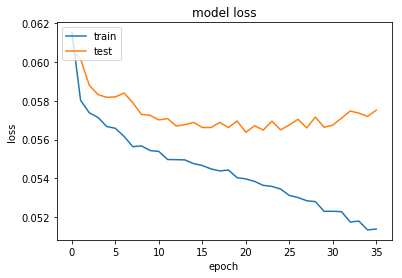

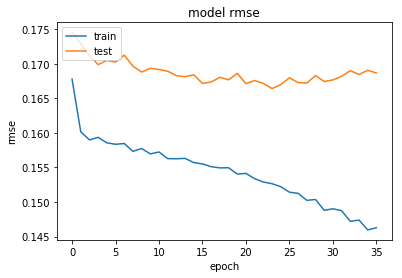

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  145.65721440315247 s =  2.427620255947113 min =  0.040460337731573315 h


## Evaluate performance on validation data to improve model

In [15]:
model.load_weights(experiment_name+'.hdf5')

## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05838821115929489
Delay 100 ms: 0.004732174342478058
Delay 200 ms: 0.013143651071196687
Delay 300 ms: 0.02426136362436334
Delay 400 ms: 0.03682188860217938
Delay 500 ms: 0.05011311650057684
Delay 600 ms: 0.0637564513061642
Delay 700 ms: 0.07751294509028223
Delay 800 ms: 0.09119384960560797
Delay 900 ms: 0.10464062408842836
Delay 1000 ms: 0.1177060473616715

RMSE
Average rmse: 0.12547108826362285
Delay 100 ms: 0.015024319529371683
Delay 200 ms: 0.030014381807108716
Delay 300 ms: 0.05018568865743079
Delay 400 ms: 0.07277275716519419
Delay 500 ms: 0.09611382826908782
Delay 600 ms: 0.11944569292547064
Delay 700 ms: 0.14231922030984512
Delay 800 ms: 0.16446032688518789
Delay 900 ms: 0.18574917370572006
Delay 1000 ms: 0.2060835885158401

SMAPE
Average smape: 12.856886463905251
Delay 100 ms: 2.0101256587666563
Delay 200 ms: 4.68669000968531
Delay 300 ms: 7.417911701567635
Delay 400 ms: 9.986716011670309
Delay 500 ms: 12.376093826406304
Delay 600 ms: 14.590007763594496
Delay

(6053, 25, 3) (6053, 10, 3)


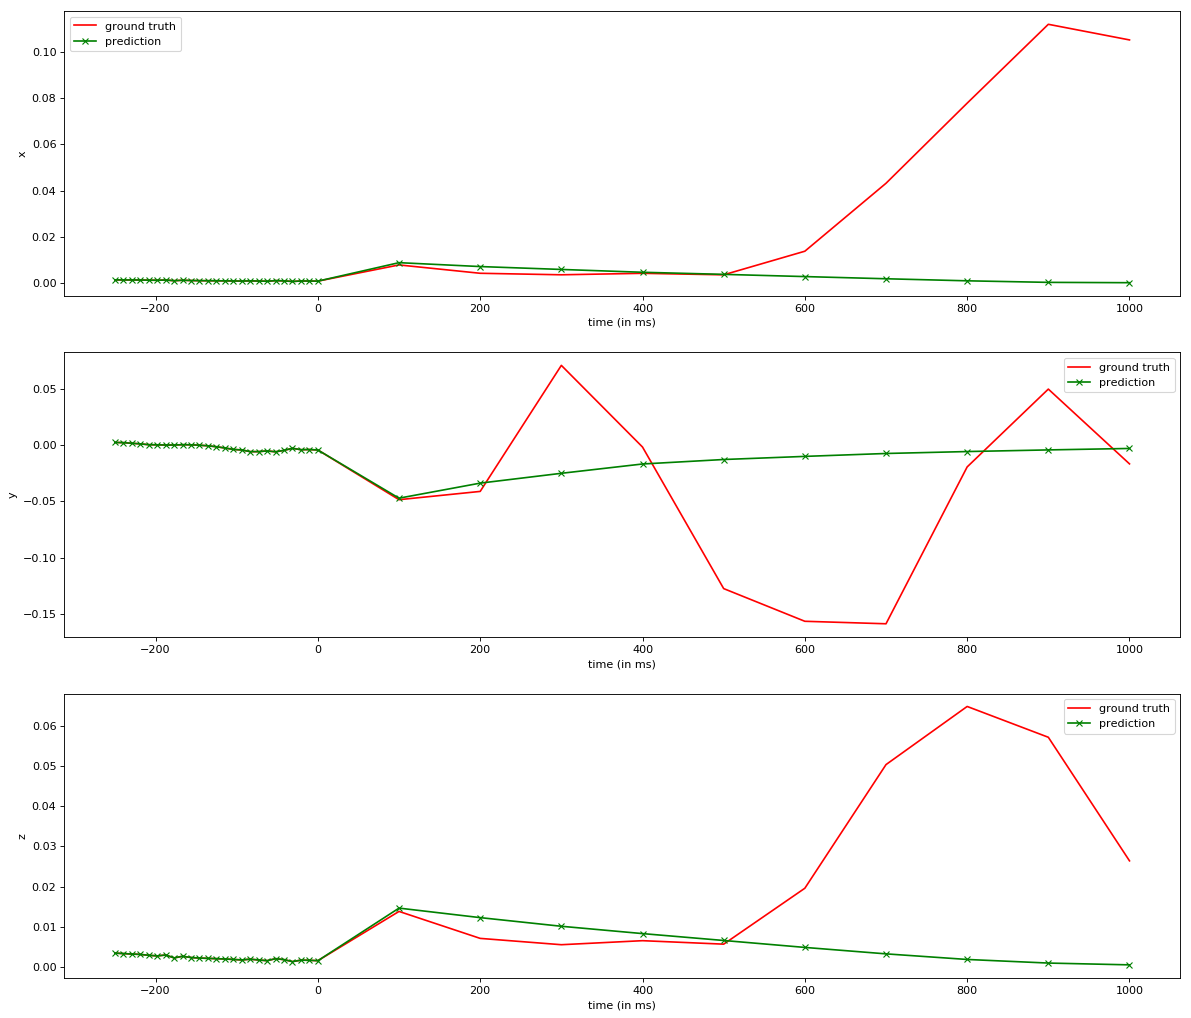

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

## Evaluate performance on test data